# Self-driving Car Engineer Nanodegree

## Project: Advanced Lane Finding

In this project i will use the tools I learned about the lesson to identify curvature lane lines, to make transform perspective, to apply Sobel gradient, to change color image space and to calibrate camera. Firs, I will develop my pipeline on a series of individual images (included in "test_images" folder), and later apply the result to a video stream contained in this repository ("project_video.mp4"). The output video can be seen in "the output_images" folder. 

    Note: Run the cell below to import the packages. If you get an `import error` for a package you have already installed, try changing your kernel (This notebook was written in python 3). If you still have problems, try relaunching Jupyter  Notebook from the terminal prompt.Otherwise, feel free create a issue. Finally, you can write me via email.
    
## Import Packages

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import cv2
import glob
import imageio
import os, sys


## Camera Calibration using chessboard images

In this step any distortion produced by the camera will be removed on the images. For it, the distortion coefficients and calibration matrix will be calculated by using 20 test chessboard images

In [36]:
# read the image to calibration camera
images = glob.glob('camera_cal/calibration*.jpg')

# declare the object points
obj = np.zeros((6*9, 3), np.float32)
obj[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# array to store object points and image points
objpoints = [] # 3D coordinates. Real world.
imgpoints = [] # 2D coordinate. Plane image.

# search fo chessboard corners
for image in images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    #If the corners were founded ret==True.
    if ret :
        #save the object and image points
        objpoints.append(obj)
        imgpoints.append(corners)


# perfom the camera calibration. Obtain matrix and sitortion coefficients.
val, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


* #### Testing Camera Calibration

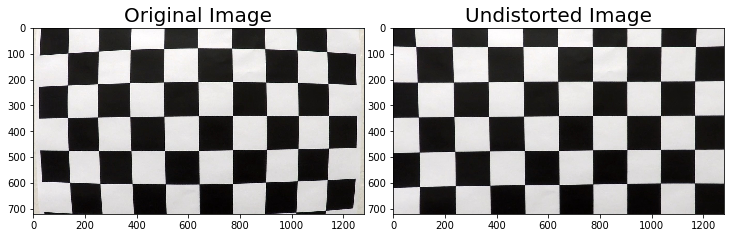

In [37]:
#read image example to corroborate the camera calibration
example = mpimg.imread('camera_cal/calibration1.jpg')
# undistort the image example
undist = cv2.undistort(example, mtx, dist, None, mtx)
#show the original and undistorted images
f, ax = plt.subplots(1,2, figsize= (10,10))
ax[0].imshow(example)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(undist)
ax[1].set_title('Undistorted Image', fontsize=20)
# remove all of the extra white space around the figure
f.tight_layout(pad=0)
f.savefig('output_images/CalibrationExample.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

## Gradient and Color Thresholding
In this section, after having the camera calibrated, I will create binary thresholded images to warp the images, therefore, i will get a top-down view the lane lines. For that, I will use the S-Channel of HLS space, the L-Channel of LUV space and the B-Channel of LAB space.

In [253]:
def gradient_thresh(img, kernel=3, sobel_thresh =(20, 100), lab_thresh = (0,255), hls_thresh = (0,255), show = True):
    # copy images
    image1 = np.copy(img)
    # undistort the image example
    undist1 = cv2.undistort(image1, mtx, dist, None, mtx)
    #Change color space to HLS. Avoid the shadow errors
    hls1 = cv2.cvtColor(undist1, cv2.COLOR_BGR2HSV)[:,:,2]
    #hls1 = cv2.cvtColor(undist1, cv2.COLOR_RGB2HLS)[:,:,2]
    # reduce noise
    cv2.GaussianBlur(hls1, (kernel,kernel), 0)
    #Change color space to LAB. Detect better the yellow lines
    lab1 = cv2.cvtColor(image1, cv2.COLOR_RGB2LAB)[:,:,2]
    #applied sobel gradient to lines closer to vertical
    sobelx1 = np.absolute(cv2.Sobel(hls1, cv2.CV_64F, 1, 0, ksize= kernel))
    #scale to 8-bit, 0-255 values
    scaled_sobel1 = np.uint8(255*sobelx1/np.max(sobelx1))
    # Threshold by gradient
    sobel_binary1 = np.zeros_like(scaled_sobel1)
    #aplly threshold sobel image
    sobel_binary1[(scaled_sobel1>=sobel_thresh[0]) & (scaled_sobel1<=sobel_thresh[1])] = 1
    #Threshold color b-channel. The b-channel works very well finding yellow lines
    b_binaryLAB = np.zeros_like(lab1)
    b_binaryLAB[lab1>=lab_thresh[0]] = 1
    #Threshold color s-channel. The s-channel works very well finding white lines
    s_binaryHLS = np.zeros_like(hls1)
    s_binaryHLS[hls1>=hls_thresh[0]] = 1
    #combined threshold
    combined_binary = np.zeros_like(hls1)
    combined_binary[(sobel_binary1 == 1) | (b_binaryLAB == 1) | (s_binaryHLS == 1) ] = 1
    
    if show:
        fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharey='col',sharex= 'row', figsize=(15,10))
        fig.tight_layout()

        ax1.set_title('Original Image', fontsize= 20)
        ax1.imshow(img)
        ax2.set_title('Sobel Gradient', fontsize= 20)
        ax2.imshow(sobel_binary1, cmap = 'gray')
        ax3.set_title('B-channel Image', fontsize= 20)
        ax3.imshow(b_binaryLAB, cmap = 'gray')
        ax4.set_title('S-channel Image', fontsize= 20)
        ax4.imshow(s_binaryHLS, cmap = 'gray')
        f.tight_layout(pad=0)
        fig.savefig('camera_cal/TransformExample2.jpg', transparent= False, bbox_inches='tight', pad_inches=0)
        plt.figure(figsize=(30,20))
        plt.title('Combined threshold', fontsize= 30)
        plt.imshow(combined_binary, cmap = 'gray')
    return combined_binary

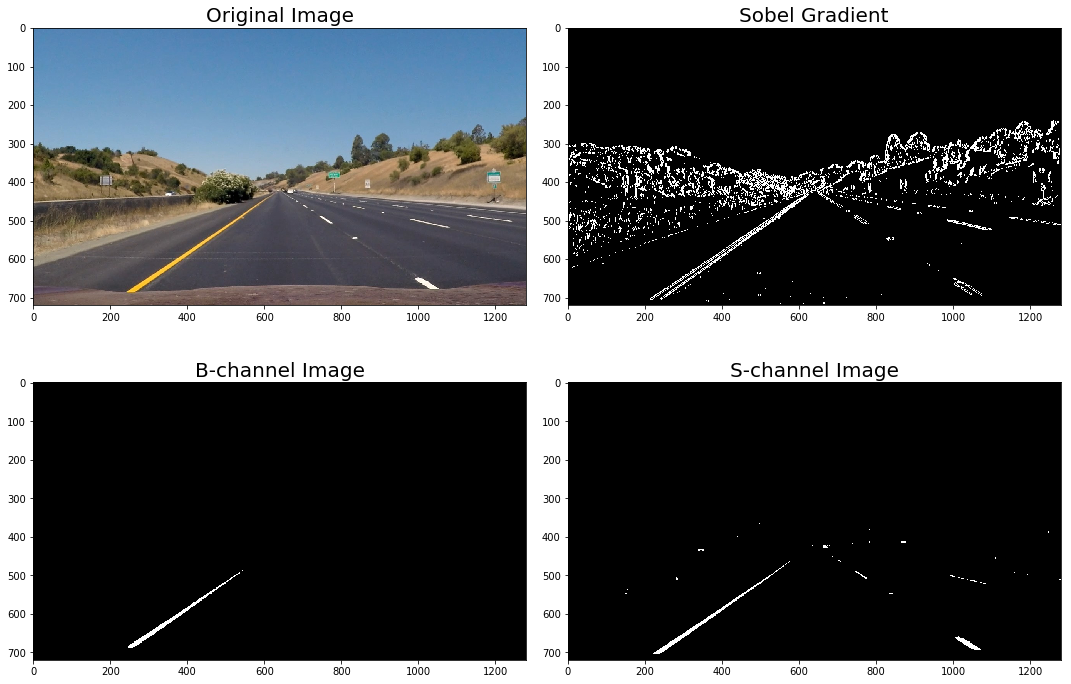

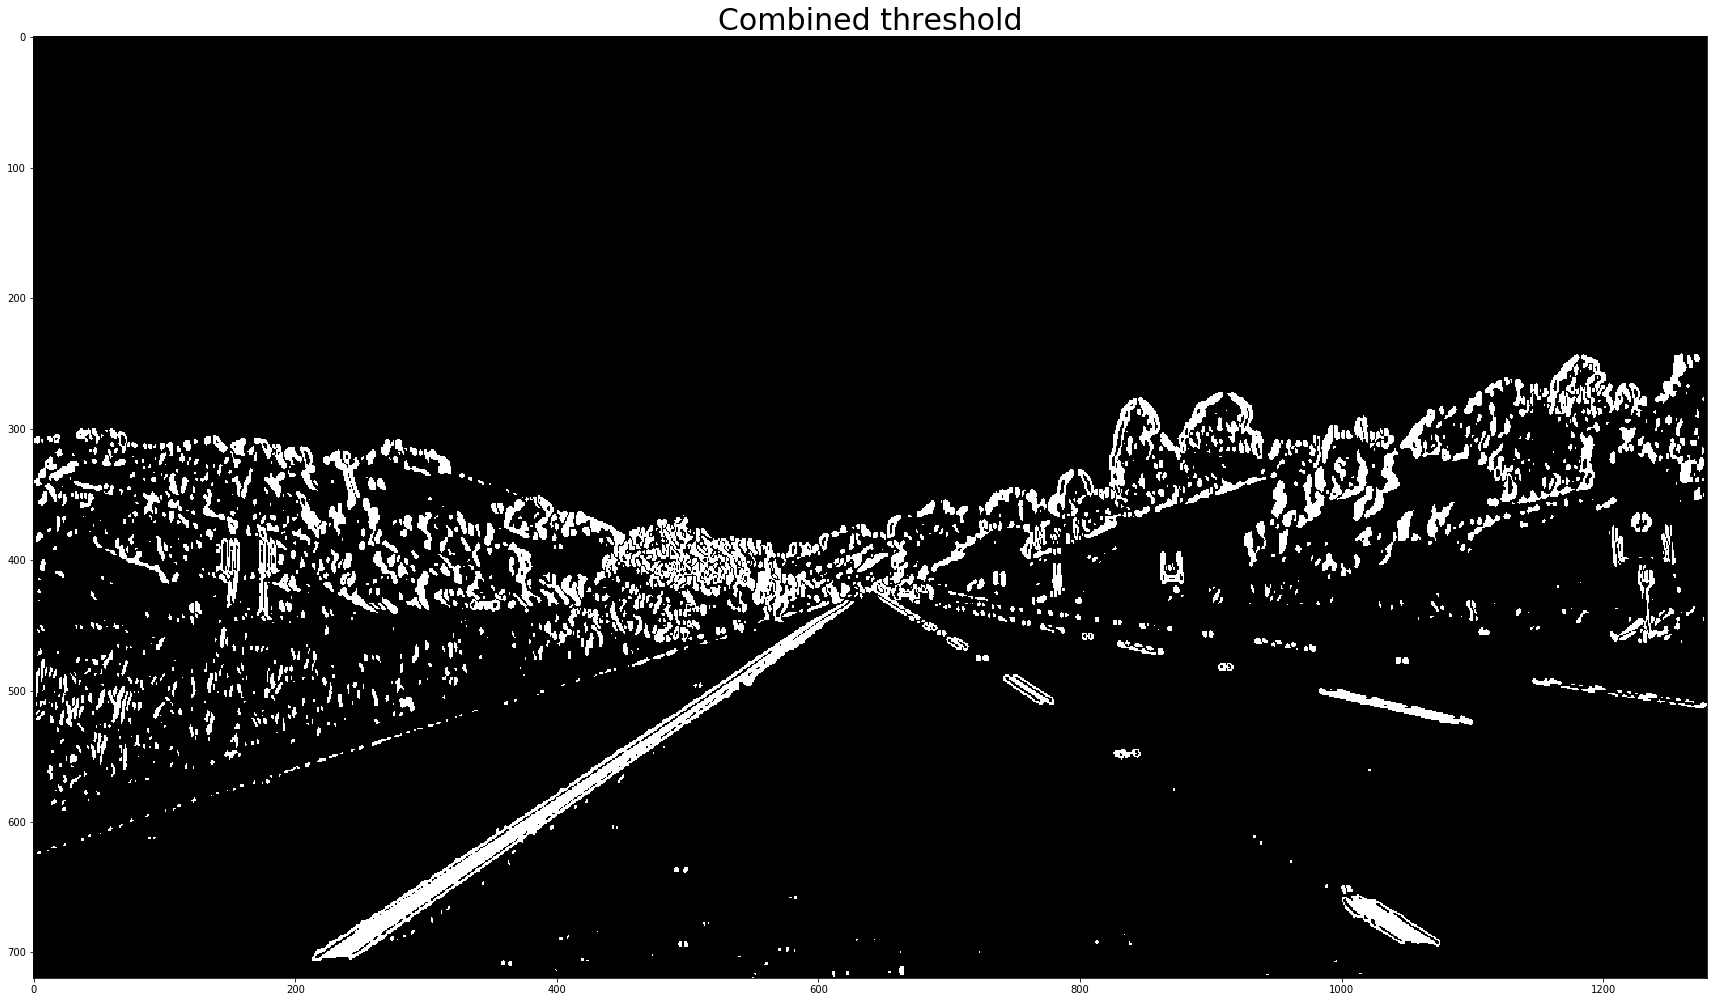

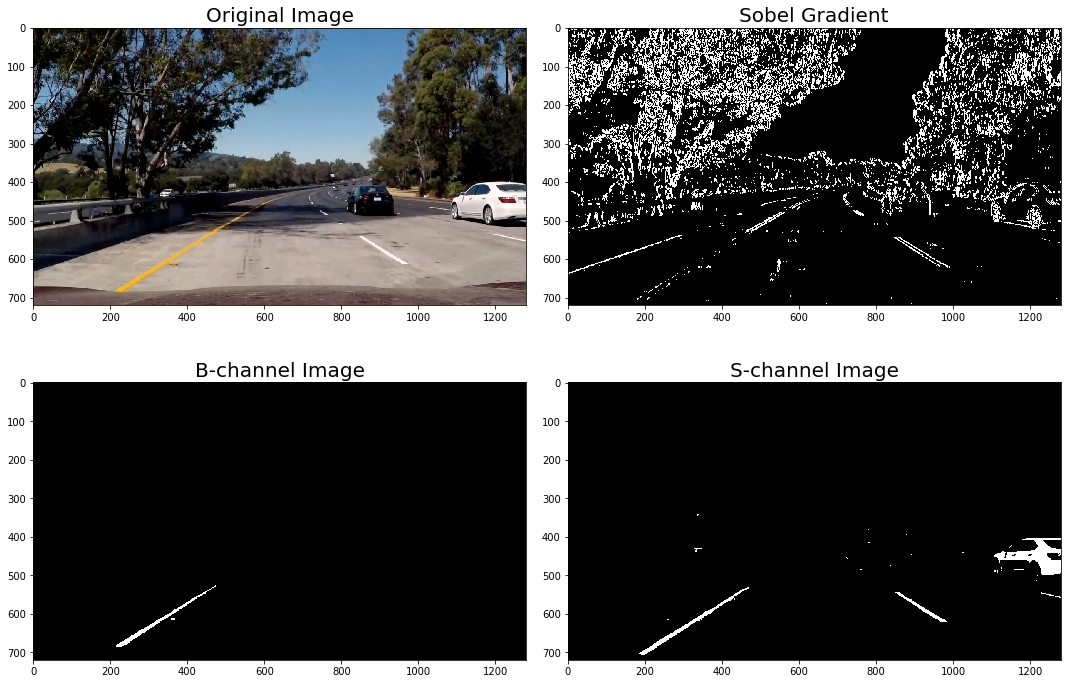

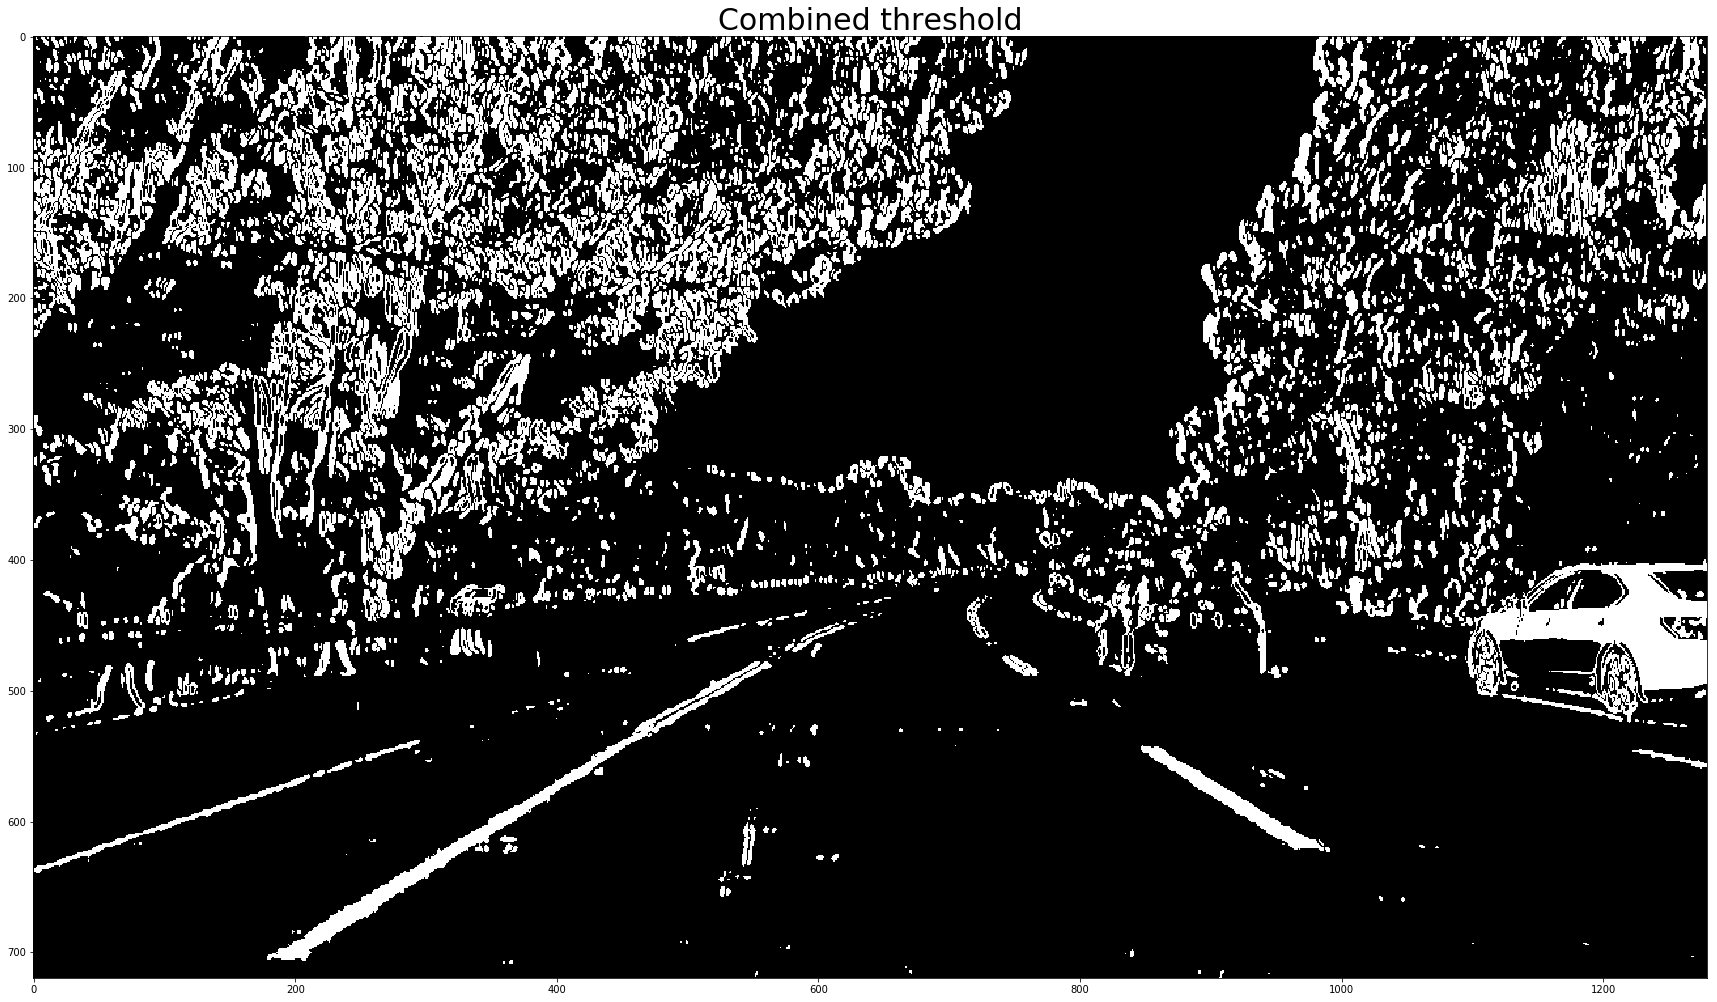

In [229]:
# import two images 
img1 = mpimg.imread('test_images/straight_lines1.jpg')
img2 = mpimg.imread('test_images/test5.jpg')

binary_img1 = gradient_thresh(img1, 7, (20, 100), (180, 255), (220, 255), show = True )
binary_img2 = gradient_thresh(img2, 7, (20, 100), (180, 255), (220, 255), show = True )

## Apply Mask
I will us this function to define the region of interest on the images.

In [230]:
# Apply mask 
def region_of_interest(img, vertices):
    """Applies an image mask
    
    Only keeps the region of the image defined by th epolygon formed
    from ´vertices´. The rest of the image is set to black. 
    ´vertices´ should be a numpe array of integer points"""
    # defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape)>2 :
        channel_count = img.shape[2]
        ignore_mask_color = (255,)*channel_count
    else:
        ignore_mask_color = 255    
    #filling pixels inside the polygon defined by ¨vertices¨ with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

* #### Testing mask region of interest

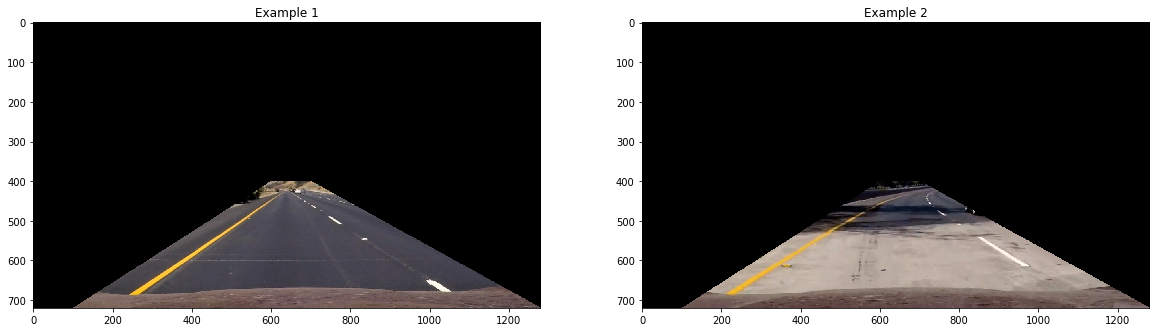

In [231]:
vertices = np.array([[(100, img1.shape[0]),(600,400), (700, 400), (img1.shape[1], img1.shape[0])]], dtype=np.int32)
masked1 = region_of_interest(img1, vertices)
masked2 = region_of_interest(img2, vertices)
plt.figure(figsize=(20,30))
plt.subplot(1, 2, 1)
plt.title('Example 1')
plt.imshow(masked1)
plt.subplot(1, 2, 2)
plt.title('Example 2')
plt.imshow(masked2)

* #### Applying mask to threshold binary  image.

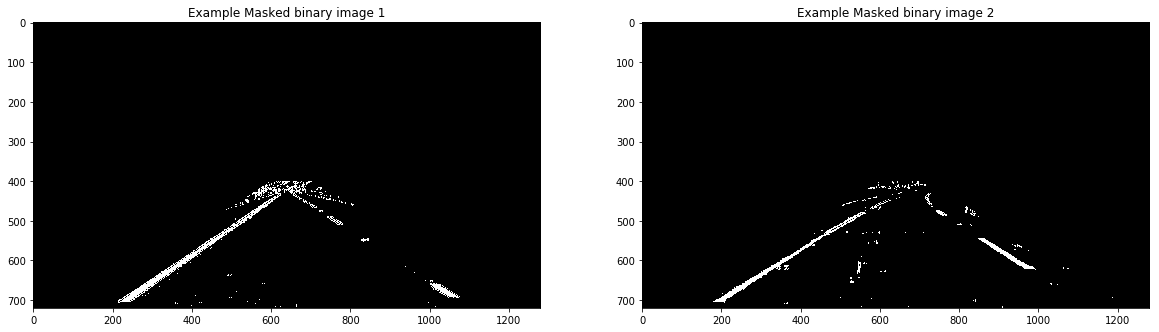

In [232]:
masked_binary1 = region_of_interest(binary_img1, vertices)
masked_binary2 = region_of_interest(binary_img2, vertices)
plt.figure(figsize=(20,30))
plt.subplot(1, 2, 1)
plt.title('Example Masked binary image 1')
plt.imshow(masked_binary1, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.title('Example Masked binary image 2')
plt.imshow(masked_binary2, cmap = 'gray')

## Perspective Transformation

In [233]:
# define perspective transform function
def warped(img, src, dst):
    #img: unwarped image. src: source original coordinates. dst: destination coordinates. 
    #compute and apply perpective transform function
    img_size = (img.shape[1], img.shape[0])
    # Get matrix coefficients
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_NEAREST)
    return warped, M

* #### Testing Perspective Transformation

[[ 575.  460.]
 [ 188.  720.]
 [1120.  720.]
 [ 708.  460.]]
----
[[400.   1.]
 [400. 720.]
 [800. 720.]
 [800.   1.]]


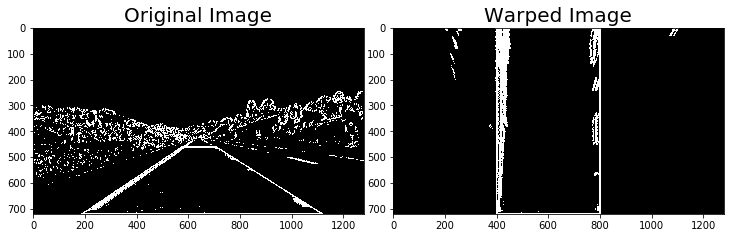

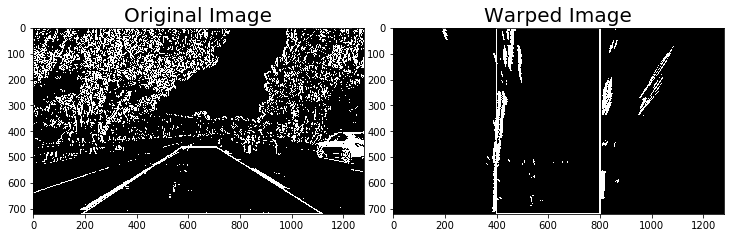

In [234]:
#define array with points of a square manually
bottom_left = [188,720]
bottom_right = [1120, 720]
top_left = [575, 460]
top_right = [708, 460]
global src
src = np.float32([top_left,bottom_left,bottom_right,top_right])
print(src)
print('----')
#define array destination points
bottom_left_dst = [400,720]
bottom_right_dst = [800, 720]
top_left_dst = [400, 1]
top_right_dst = [800, 1]
global dst
dst = np.float32([top_left_dst,bottom_left_dst,bottom_right_dst,top_right_dst])
print(dst)
# make shape of src equal to dst shape
src =src.reshape(dst.shape[0],dst.shape[1])

#Visualize de src points over the original image
pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy1 = binary_img1.copy()*255
cv2.polylines(copy1,[pts],True,(255,255,0), thickness=3)


#call warped function
warped_img1, M_coeff = warped(masked_binary1, src, dst)
warped_img_dst1 = warped_img1.copy()*255
#Visualize de dst points over the warped image 
pts_dst = np.array([bottom_left_dst,bottom_right_dst,top_right_dst,top_left_dst], np.int32)
pts_dst = pts_dst.reshape((-1,1,2))
cv2.polylines(warped_img_dst1,[pts_dst],True,(255,255,0), thickness=3)
# visualize images
f, ax = plt.subplots(1,2, figsize= (10,10))
ax[0].imshow(copy1, cmap = 'gray')
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(warped_img_dst1, cmap = 'gray')
ax[1].set_title('Warped Image', fontsize=20)
# remove all of the extra white space around the figure
f.tight_layout(pad=0)
f.savefig('camera_cal/TransformExample1Binary.jpg', transparent= False, bbox_inches='tight', pad_inches=0)


copy2 = binary_img2.copy()*255
cv2.polylines(copy2,[pts],True,(255,255,0), thickness=3)

#call warped function second example image
warped_img2, M_coeff = warped(masked_binary2, src, dst)
warped_img_dst2 = warped_img2.copy()*255
#Visualize de dst points over the warped image 
pts_dst = np.array([bottom_left_dst,bottom_right_dst,top_right_dst,top_left_dst], np.int32)
pts_dst = pts_dst.reshape((-1,1,2))
cv2.polylines(warped_img_dst2,[pts_dst],True,(255,255,0), thickness=3)

# visualize images
f, ax = plt.subplots(1,2, figsize= (10,10))
ax[0].imshow(copy2, cmap = 'gray')
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(warped_img_dst2, cmap = 'gray')
ax[1].set_title('Warped Image', fontsize=20)
# remove all of the extra white space around the figure
f.tight_layout(pad=0)
f.savefig('output_images/TransformExample2Binary.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

## Identifying Lane Pixels
Type Markdown and LaTeX:  𝛼2

In this point i will create a histogram function on warped binery image in order to find the x-axis position pixels correspond to lane lines.

In [235]:
def histo(img_binary_warped):
    # Lane lines are likely to be mostly vertical nearest to the car
    img_binary_warped = img_binary_warped
    bottom_half = img_binary_warped[img_binary_warped.shape[0]//2:,:]
    # Sum across image pixels vertically, the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    return histogram

* #### Testing Histogram function.

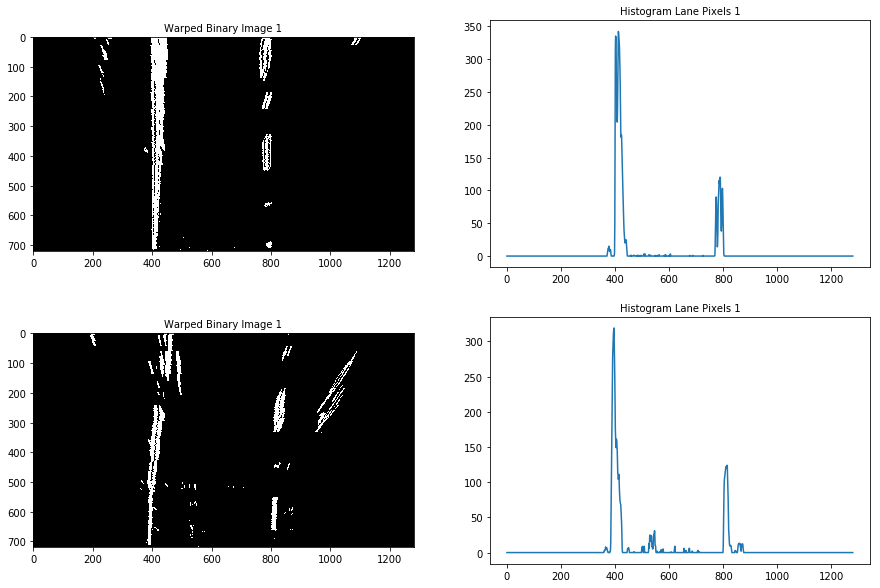

In [236]:
warped_binary1, M1_coeff = warped(masked_binary1, src, dst)
warped_binary2, M1_coeff = warped(masked_binary2, src, dst)
histo1 = histo(warped_binary1)
histo2 = histo(warped_binary2)
fig2, ax = plt.subplots(2, 2, figsize=(15,10))
ax[0,0].imshow(warped_binary1, cmap = 'gray')
ax[0,0].set_title('Warped Binary Image 1', fontsize = 10)
ax[0,1].plot(histo1)
ax[0,1].set_title('Histogram Lane Pixels 1', fontsize = 10)
ax[1,0].imshow(warped_binary2, cmap = 'gray')
ax[1,0].set_title('Warped Binary Image 1', fontsize = 10)
ax[1,1].plot(histo2)
ax[1,1].set_title('Histogram Lane Pixels 1', fontsize = 10)
fig2.savefig('output_images/histogramExample.jpg', transparent= False, bbox_inches='tight', pad_inches=0)


Next, i will perform a sliding window search, starting with the base likely positions of the 2 lanes, calculated from the histogram. I have used 20 windows of height 36 pixels.

The x & y coordinates of non zeros pixels are found, a polynomial is fit for these coordinates and the lane lines are drawn.

In [237]:
def find_lane_pixels(binary_img_warped, histo, out_img):
    # Define middle point of the histrogram in order to separate the two lines
    midpoint = np.int(histo.shape[0]//2)
    print(histo.shape[0]//2)
    #Find the position of the left lane
    leftx_base = np.argmax(histo[:midpoint])
    #Find the position of the rigth lane
    rightx_base = np.argmax(histo[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_img_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_img_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_img_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        #Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<=win_y_high) & 
        (nonzerox>=win_xleft_low) & (nonzerox<=win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low) & (nonzeroy<=win_y_high) & 
        (nonzerox>=win_xright_low) & (nonzerox<=win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If it found > minpix pixels, recenter next window #
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

#  the coefficients are obtained from real 
def fit_polynomial(binary_img_warped, histo):
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_img_warped, binary_img_warped, binary_img_warped))
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_img_warped, histo, out_img)
    #Fit a second order polynomial to each lane
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    print('coeff left', left_fit)
    print('coeff right', right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_img_warped.shape[0]-1, binary_img_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    return out_img, left_fitx, right_fitx, ploty

* #### Testing Slide Search Window

640
coeff left [-1.00635681e-05 -1.50114982e-02  4.24083610e+02]
coeff right [1.81250577e-05 5.11953500e-03 7.80509311e+02]
640
coeff left [ 1.12129378e-04 -1.86118692e-01  4.65333993e+02]
coeff right [ 1.13620729e-04 -1.44498928e-01  8.58672601e+02]


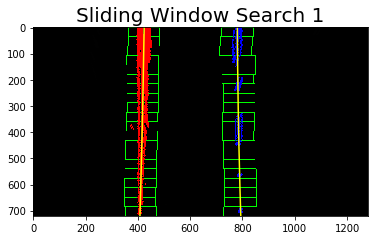

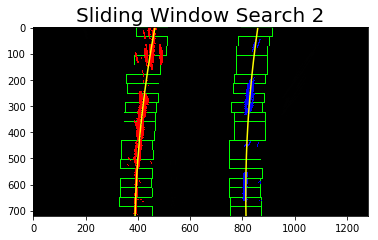

In [238]:
out_img1, left_fitx1, right_fitx1, ploty1 = fit_polynomial(warped_binary1, histo1)
out_img2, left_fitx2, right_fitx2, ploty2 = fit_polynomial(warped_binary2, histo2)

plt.figure()
plt.imshow(out_img1)
plt.title('Sliding Window Search 1', fontsize = 20)
plt.plot(left_fitx1, ploty1, color='yellow')
plt.plot(right_fitx1, ploty1, color='yellow')
plt.savefig('output_images/SlidingWindowSearch1.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

plt.figure()
plt.imshow(out_img2)
plt.title('Sliding Window Search 2', fontsize = 20)
plt.plot(left_fitx2, ploty2, color='yellow')
plt.plot(right_fitx2, ploty2, color='yellow')


Now, I search in a margin around the previous line position, like in the above image. The green shaded area shows where I searched for the lines this time. So, once I know where the lines are in one frame of video, I can do a highly targeted search for them in the next frame.

In [239]:
def search_around_poly(binary_warped, left_fitx, right_fitx, ploty, show = False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 60

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = np.polyfit(ploty,left_fitx,2)
    right_fit = np.polyfit(ploty,right_fitx,2)
    print('coeff left  \n', left_fit,)
    print('coeff right  \n', right_fit)
    print('------ \n')
    ###  Set the area of search based on activated x-values, within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox>left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy
    + left_fit[2] - margin) & (nonzerox<left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy
    + left_fit[2] + margin))
    right_lane_inds = ((nonzerox>right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy
    + right_fit[2] - margin) & (nonzerox<right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy
    + right_fit[2] + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    #left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #--------------------
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if show:
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        ## End visualization steps ##
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)        
    return result, left_fitx, right_fitx, ploty 



* #### Testing Search Around previous Window

coeff left  
 [-1.00635681e-05 -1.50114982e-02  4.24083610e+02]
coeff right  
 [1.81250577e-05 5.11953500e-03 7.80509311e+02]
------ 

coeff left  
 [ 1.12129378e-04 -1.86118692e-01  4.65333993e+02]
coeff right  
 [ 1.13620729e-04 -1.44498928e-01  8.58672601e+02]
------ 



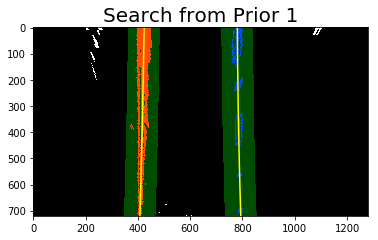

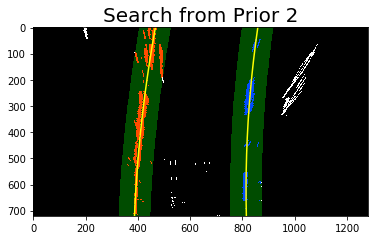

In [240]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result1, left_fitx1, right_fitx1, ploty1  = search_around_poly(warped_binary1, left_fitx1, right_fitx1, ploty1, True)
result2, left_fitx2, right_fitx2, ploty2  = search_around_poly(warped_binary2, left_fitx2, right_fitx2, ploty2, True)
# View the output
plt.figure()
plt.imshow(result1)
plt.title('Search from Prior 1', fontsize = 20)
plt.plot(left_fitx1, ploty1, color='yellow')
plt.plot(right_fitx1, ploty1, color='yellow')
plt.savefig('output_images/SearchfromPrior1.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

plt.figure()
plt.imshow(result2)
plt.title('Search from Prior 2', fontsize = 20)
plt.plot(left_fitx2, ploty2, color='yellow')
plt.plot(right_fitx2, ploty2, color='yellow')


## Computing the radius of curvature and center offset.
The radius of curvature is computed according to the formula and method described in [here](https://www.intmath.com/applications-differentiation/8-radius-curvature.php). Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.

The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [241]:
def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, imgshape[1]-1, imgshape[1])
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

global imgshape 

imgshape = (img.shape[1], img.shape[0])

# to the fisrt image
left_curve_rad1 = measure_radius_of_curvature(left_fitx1)
right_curve_rad1 = measure_radius_of_curvature(right_fitx1)
average_curve_rad1 = (left_curve_rad1 + right_curve_rad1)/2

# to second image
left_curve_rad2 = measure_radius_of_curvature(left_fitx2)
right_curve_rad2 = measure_radius_of_curvature(right_fitx2)
average_curve_rad2 = (left_curve_rad2 + right_curve_rad2)/2

Next. I applied the transform inverse in order to fill the space in between the identified lane lines and to highlight the driveable area in the lane. 

In [242]:
def fill_lane(Original_img, warped_binary, left_fitx, right_fitx):  
    # compute the offset from the center
    #get the center with respect to lane lines
    lane_center = (right_fitx[-1] + left_fitx[-1])/2
    print('center lane',lane_center)
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #get de diference between the middle of image and lane lines center
    center_offset_pixels = abs(imgshape[0]/2 - lane_center)
    #obtain the offset center in meters
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    print('offset car',center_offset_mtrs)
    print('------')
    if center_offset_mtrs < 640:
        offset_lane = 'Vehicle is {:.2f}m left of center'.format(center_offset_mtrs)
    else:
        offset_lane = 'Vehicle is {:.2f}m right of center'.format(center_offset_mtrs)
    # Create an output image to draw on and visualize the result
    Out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    #create a vector correspond to y axis image
    y_points = np.linspace(0, imgshape[1]-1, imgshape[1])
    #generate a vector of  x-axis and y-axis lane points 
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
    #stack in a consecutive vector
    point_lane = np.vstack((left_line_window, right_line_window))
    cv2.fillPoly(Out_img, np.int_([point_lane]), [0,255, 0])
    #get the matriz inverse transformation coefficient
    M_inv = cv2.getPerspectiveTransform(dst, src)
    #unwarped the image 
    unwarped = cv2.warpPerspective(Out_img, M_inv, imgshape , flags=cv2.INTER_NEAREST)
    result = cv2.addWeighted(Original_img, 1, unwarped, 0.3, 0)
    return result, offset_lane


* #### Testing Fill Lane

center lane 600.7302059396359
offset car 0.20756891146192463
------
center lane 601.127090744666
offset car 0.2054710917781939
------


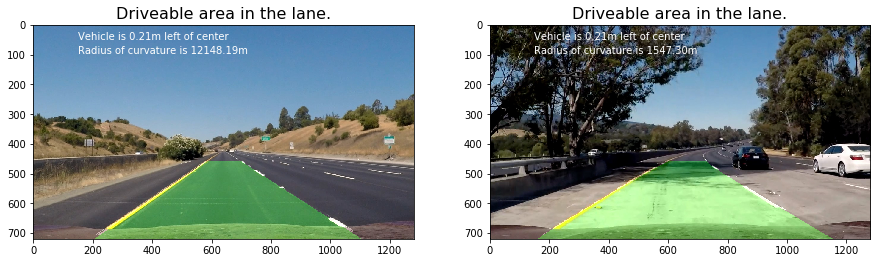

In [243]:
fill_lane1, curvature_string1 = fill_lane(img1, warped_binary1, left_fitx1, right_fitx1) 
fill_lane2, curvature_string2 = fill_lane(img2, warped_binary2, left_fitx2, right_fitx2) 
fig4, ax = plt.subplots(1,2, figsize= (15,7))
ax[0].imshow(fill_lane1)
ax[0].set_title('Driveable area in the lane.', fontsize=16)
ax[0].text(150, 50,curvature_string1 , color='white', fontsize=10)
ax[0].text(150, 95, 'Radius of curvature is {:.2f}m'.format(average_curve_rad1), color='white', fontsize=10)
ax[1].imshow(fill_lane2)
ax[1].set_title('Driveable area in the lane.', fontsize=16)
ax[1].text(150, 50,curvature_string2 , color='white', fontsize=10)
ax[1].text(150, 95, 'Radius of curvature is {:.2f}m'.format(average_curve_rad2), color='white', fontsize=10)
fig4.savefig('output_images/FillLaneExample.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

## Puting up all together
#### Figuring out bad frames

There will be some frames where no lanes will be detected or the lanes might not make sense. We determine the bad frames if any of the following conditions are met:

No pixels were detected using the sliding window search or search around the previously detected line.

The average gap between the lanes is less than 0.7 times pr greater than 1.3 times the globally maintained moving average of the lane gap.

#### Averaging lanes

The lane for each frame is a simple average of 10 previously computed lanes. This is done in the get_averaged_line method in the code block below.

if a bad frame is detected: 

* Perform a sliding window search again (this is done in the find_lane_pixels method in the code block made before)
* If this still results in a bad frame then we fall back to the previous well detected frame.



In [244]:
def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 10
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line

In [245]:
def get_mean_distance_between_lines(left_line, right_line, running_average):
    """
        Returns running weighted average of simple difference between left and right lines
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average

## Final Pipeline
We combine all the code described in the code block above, plus the averaging and fallback techniques described in this block. The final code is in the pipeline_final method.

In [246]:
def pipeline_final(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_shape = img.shape
    print(img_shape)
    img_size = (img_shape[1], img_shape[0])
    # undistort the image example
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # get binary image by applying threshold
    binary_img = gradient_thresh(undist, 7, (20, 100), (155, 255), (160, 255), show = False )
    #Apply the mask
    vertices = np.array([[(100, img_size[1]),(600,400), (700, 400), (img_size[0], img_size[1])]], dtype=np.int32)
    masked = region_of_interest(binary_img, vertices)


    # perform a perspective transform
    warped_img, M_coeff = warped(binary_img, src, dst)
    
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    
    non_zeros = warped_img.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped_img.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        histogram = histo(warped_img)
        out_img, left_x_predictions, right_x_predictions, y_points = fit_polynomial(warped_img, histogram)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = search_around_poly(binary_warped, left_fitx, right_fitx, ploty, show = False)
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not brute:
            out_img, left_x_predictions, right_x_predictions, y_points = fit_polynomial(binary_img_warped, histo)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not brute:
                out_img, left_x_predictions, right_x_predictions, y_points = fit_polynomial(binary_img_warped, histo)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = get_averaged_line(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = get_averaged_line(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_x_predictions)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    # compute the offset from the center and unwarped the image.
    result, offset_lane = fill_lane(img, warped_img, left_x_predictions, right_x_predictions)
    # Put the the info text on image
    cv2.putText(result,'Radius of curvature is {:.2f}m'.format(average_curve_rad) , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_lane, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    return result

#### Testing Final Pipeline

(720, 1280, 3)
640
coeff left [-1.35569490e-04  1.76837053e-01  3.87289696e+02]
coeff right [-1.56180291e-04  1.97482176e-01  7.50970802e+02]
center lane 628.2863826057414
offset car 0.061914834798223836
------


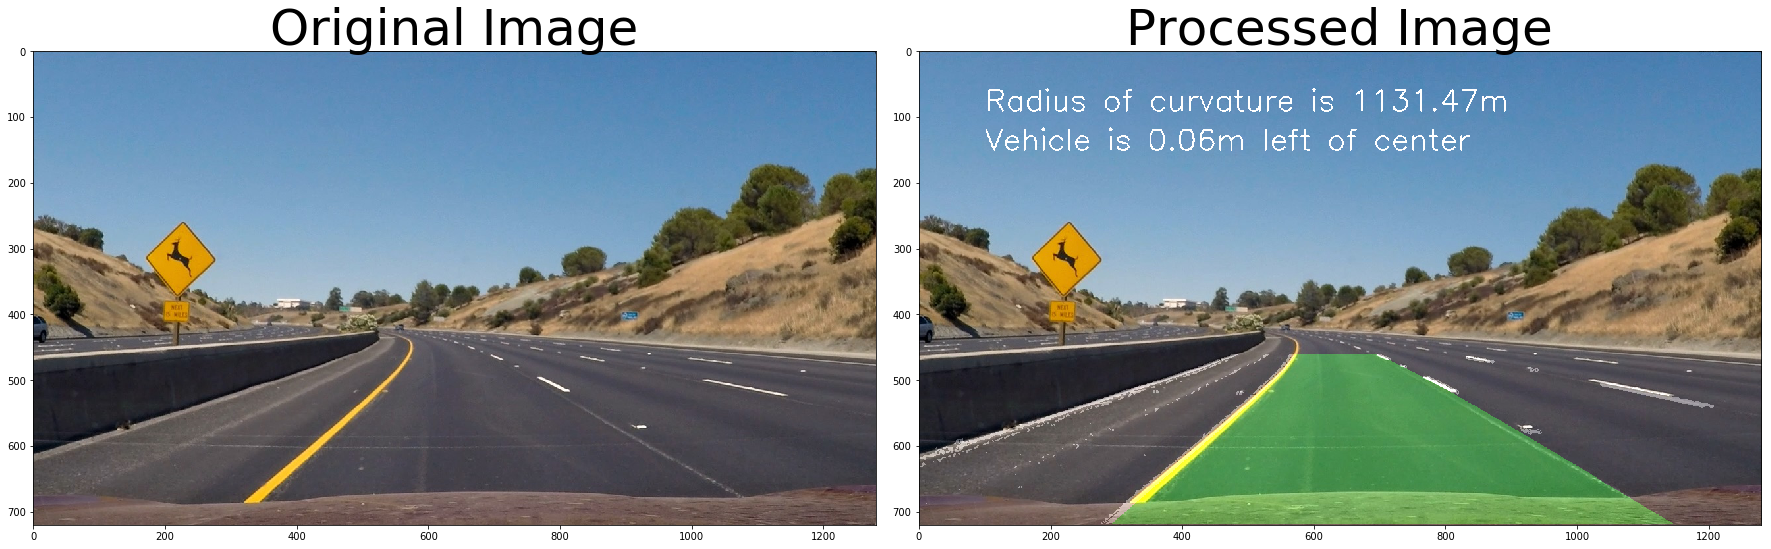

In [247]:
# Some global variables
polyfit_left=None
polyfit_right=None

past_good_left_lines = []
past_good_right_lines = []

img = mpimg.imread('test_images/test2.jpg')

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

# Apply pipeline
processed = pipeline_final(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed)
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.savefig('output_images/FinalPipeline.jpg', transparent= False, bbox_inches='tight', pad_inches=0)

In [248]:
import moviepy.editor as mpe

## Issues Images

In the first final pipeline test, the next images caused some problems so I will test the pipeline algorithm with each image.

In [249]:
def save_image_fix_dpi(data, out_path, dpi=100):
    shape=np.shape(data)[0:2][::-1]
    size = [float(i)/dpi for i in shape]

    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig,[0,0,1,1])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data)
    fig.savefig(out_path,transparent= False, bbox_inches='tight', pad_inches=0, dpi=dpi)
    plt.show()

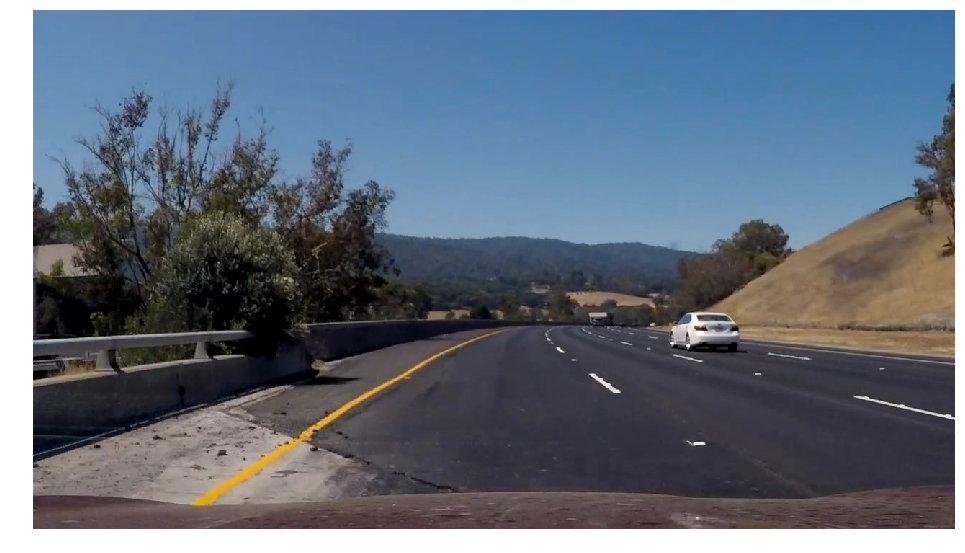

In [250]:
clip1 = mpe.VideoFileClip("project_video.mp4")
np_frame = clip1.get_frame(618*1.0/clip1.fps)
out_path = 'test_images/IssueImage1.jpg'
save_image_fix_dpi(np_frame, out_path, dpi=100)

In [251]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'project_video_output.mp4'
clip1 = mpe.VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

                                                                

                                                         


                                                   
t:  36%|███▋      | 176/485 [3:07:50<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:02:08<01:39,  6.48it/s, now=None]


t:   1%|          | 3/485 [2:00:28<00:46, 10.47it/s, now=None]
                                                                

                                                           


                                                     
t:  36%|███▋      | 176/485 [3:07:50<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:02:08<01:39,  6.48it/s, now=None]


t:  36%|███▌      | 175/485 [2:57:53<00:50,  6.11it/s, now=None]





(720, 1280, 3)
640
coeff left [-1.33960623e-04  1.64450305e-01  3.90260821e+02]
coeff right [-9.27403345e-05  1.73161567e-01  7.56069778e+02]
center lane 635.9389904788729
offset car 0.021465336040243043
------
Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]



t:   0%|          | 2/1260 [00:00<02:01, 10.38it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.33960623e-04  1.64450305e-01  3.90260821e+02]
coeff right [-9.27403345e-05  1.73161567e-01  7.56069778e+02]
center lane 635.9389904788729
offset car 0.021465336040243043
------






t:   0%|          | 3/1260 [00:00<02:31,  8.30it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.36158341e-04  1.67265785e-01  3.90357880e+02]
coeff right [-1.05543104e-04  1.87363521e-01  7.50958031e+02]
center lane 635.6720801907547
offset car 0.022876147563153513
------
(720, 1280, 3)






t:   0%|          | 4/1260 [00:00<02:55,  7.16it/s, now=None]

640
coeff left [-1.31708989e-04  1.65167430e-01  3.90182678e+02]
coeff right [-1.67103290e-04  2.43298591e-01  7.38872554e+02]
center lane 634.1340032833956
offset car 0.03100598264490897
------
(720, 1280, 3)
640
coeff left [-1.29784119e-04  1.65154199e-01  3.90344857e+02]
coeff right [-1.73917958e-04  2.57883967e-01  7.32730875e+02]
center lane 635.1190216596373
offset car 0.025799456941917293
------






t:   0%|          | 5/1260 [00:00<03:04,  6.80it/s, now=None]



t:   0%|          | 6/1260 [00:00<03:24,  6.13it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.25130812e-04  1.64778436e-01  3.89711923e+02]
coeff right [-1.60119194e-04  2.48630499e-01  7.33081024e+02]
center lane 636.2854213406924
offset car 0.019634201484911403
------






t:   1%|          | 7/1260 [00:01<03:28,  6.02it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.40560245e-04  1.79746071e-01  3.86865154e+02]
coeff right [-1.10602898e-04  2.12456402e-01  7.35669598e+02]
center lane 637.3433904357232
offset car 0.014042079125462969
------
(720, 1280, 3)






t:   1%|          | 8/1260 [00:01<03:52,  5.38it/s, now=None]

640
coeff left [-1.45067426e-04  1.87188301e-01  3.84088156e+02]
coeff right [-9.95953052e-05  2.02400184e-01  7.38748473e+02]
center lane 638.2348300805882
offset car 0.009330183859748332
------
(720, 1280, 3)
640






t:   1%|          | 9/1260 [00:01<03:40,  5.67it/s, now=None]

coeff left [-1.38857706e-04  1.85655508e-01  3.83819984e+02]
coeff right [1.42226528e-05 1.41337441e-01 7.41651403e+02]
center lane 648.0739282253933
offset car 0.04267647776279302
------
(720, 1280, 3)






t:   1%|          | 10/1260 [00:01<04:22,  4.76it/s, now=None]

640
coeff left [-1.28459335e-04  1.82394657e-01  3.81732302e+02]
coeff right [2.92791003e-05 1.23283954e-01 7.47107024e+02]
center lane 648.674967458743
offset car 0.04585339942478457
------
(720, 1280, 3)






t:   1%|          | 11/1260 [00:01<03:59,  5.21it/s, now=None]

640
coeff left [-1.15568760e-04  1.74281528e-01  3.81564078e+02]
coeff right [1.04110588e-04 1.17270176e-01 1.09613331e+03]
center lane 648.674967458743
offset car 0.04585339942478457
------
(720, 1280, 3)
640






t:   1%|          | 12/1260 [00:02<04:02,  5.15it/s, now=None]

coeff left [-1.17559192e-04  1.75255767e-01  3.81371831e+02]
coeff right [1.82317288e-04 6.49832397e-02 1.09903514e+03]
center lane 648.674967458743
offset car 0.04585339942478457
------
(720, 1280, 3)
640






t:   1%|          | 13/1260 [00:02<04:17,  4.85it/s, now=None]

coeff left [-1.23318467e-04  1.84219442e-01  3.76142831e+02]
coeff right [1.47058250e-04 4.79375450e-02 1.12247965e+03]
center lane 648.674967458743
offset car 0.04585339942478457
------
(720, 1280, 3)
640






t:   1%|          | 14/1260 [00:02<04:22,  4.75it/s, now=None]

coeff left [-9.91080549e-05  1.67922969e-01  3.77260821e+02]
coeff right [1.57510922e-04 3.19110472e-02 1.12287378e+03]
center lane 648.674967458743
offset car 0.04585339942478457
------
(720, 1280, 3)
640






t:   1%|          | 15/1260 [00:02<04:30,  4.61it/s, now=None]

coeff left [-1.02284370e-04  1.70116754e-01  3.76609857e+02]
coeff right [-2.99036984e-05  1.46744907e-01  7.46648028e+02]
center lane 639.0849305065235
offset car 0.004836795894090041
------
(720, 1280, 3)
640
coeff left [-9.42280503e-05  1.61352405e-01  3.79554391e+02]
coeff right [-1.30740420e-04  2.36687219e-01  7.25201725e+02]
center lane 639.223365525002
offset car 0.004105067939275094
------






t:   1%|▏         | 16/1260 [00:02<04:20,  4.78it/s, now=None]



t:   1%|▏         | 17/1260 [00:03<04:19,  4.79it/s, now=None]

(720, 1280, 3)
640
coeff left [-9.11086615e-05  1.56954583e-01  3.81292310e+02]
coeff right [-1.52419506e-04  2.65330742e-01  7.13362871e+02]
center lane 639.275345708797
offset car 0.003830315539215982
------
(720, 1280, 3)






t:   1%|▏         | 18/1260 [00:03<04:17,  4.83it/s, now=None]

640
coeff left [-8.54871346e-05  1.53617187e-01  3.80865209e+02]
coeff right [-1.21108472e-04  2.40973621e-01  7.15563122e+02]
center lane 639.52880794918
offset car 0.0024905865543344784
------
(720, 1280, 3)
640






t:   2%|▏         | 19/1260 [00:03<04:10,  4.95it/s, now=None]



t:   2%|▏         | 20/1260 [00:03<04:00,  5.17it/s, now=None]

coeff left [-8.56461112e-05  1.53373096e-01  3.80982678e+02]
coeff right [-9.05929545e-05  2.17572950e-01  7.16855567e+02]
center lane 639.6888922098697
offset car 0.0016444268906889194
------
(720, 1280, 3)
640
coeff left [-7.57584207e-05  1.45900319e-01  3.80658525e+02]
coeff right [-8.07731029e-05  2.02006837e-01  7.23625187e+02]
center lane 639.7357632738115
offset car 0.0013966798384250783
------






t:   2%|▏         | 21/1260 [00:03<03:56,  5.25it/s, now=None]

(720, 1280, 3)
640
coeff left [-7.62899083e-05  1.47675113e-01  3.78587563e+02]
coeff right [-6.61117393e-05  1.86801014e-01  7.28502844e+02]
center lane 639.6995564339607
offset car 0.0015880588490651268
------
(720, 1280, 3)






t:   2%|▏         | 22/1260 [00:04<04:18,  4.78it/s, now=None]

640
coeff left [-7.11160794e-05  1.43211329e-01  3.77926199e+02]
coeff right [-1.94398992e-05  1.54617439e-01  7.35960711e+02]
center lane 639.9366677088849
offset car 0.00033475639589411395
------
(720, 1280, 3)






t:   2%|▏         | 23/1260 [00:04<04:34,  4.51it/s, now=None]

640
coeff left [-6.41427578e-05  1.38296220e-01  3.76761597e+02]
coeff right [-1.98099862e-05  1.46120173e-01  7.41840864e+02]
center lane 639.1141525701883
offset car 0.004682336414719235
------
(720, 1280, 3)
640






t:   2%|▏         | 24/1260 [00:04<04:19,  4.76it/s, now=None]



t:   2%|▏         | 25/1260 [00:04<03:55,  5.25it/s, now=None]

coeff left [-8.07982511e-05  1.50493000e-01  3.73485021e+02]
coeff right [-1.41898253e-04  2.29708759e-01  1.09870517e+03]
center lane 639.8487768384282
offset car 0.0007993224254509772
------
(720, 1280, 3)
640
coeff left [-9.57400637e-05  1.57705839e-01  3.74191684e+02]
coeff right [9.21814822e-05 1.10473840e-01 1.10112481e+03]
center lane 639.8487768384282
offset car 0.0007993224254509772
------
(720, 1280, 3)






t:   2%|▏         | 26/1260 [00:04<03:39,  5.63it/s, now=None]



t:   2%|▏         | 27/1260 [00:05<03:30,  5.85it/s, now=None]

640
coeff left [-1.00138344e-04  1.58154202e-01  3.75304436e+02]
coeff right [1.68289794e-04 5.34527279e-02 1.10461775e+03]
center lane 639.8487768384282
offset car 0.0007993224254509772
------
(720, 1280, 3)
640
coeff left [-1.01958839e-04  1.59950423e-01  3.73419506e+02]
coeff right [1.54985905e-04 3.15292612e-02 1.12095008e+03]
center lane 639.8487768384282
offset car 0.0007993224254509772
------


(720, 1280, 3)
640
coeff left [-1.14431799e-04  1.67930610e-01  3.72580664e+02]
coeff right [-6.96944043e-05  1.62589585e-01  7.47350052e+02]
center lane 637.3660893654106
offset car 0.013922099068543812
------


t:   2%|▏         | 28/1260 [00:05<03:48,  5.39it/s, now=None]



t:   2%|▏         | 29/1260 [00:05<03:40,  5.59it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.06699341e-04  1.62901587e-01  3.71313686e+02]
coeff right [-6.23359377e-05  1.46159039e-01  7.56406882e+02]
center lane 636.3563477070545
offset car 0.01925930497699759
------
(720, 1280, 3)






t:   2%|▏         | 30/1260 [00:05<03:37,  5.66it/s, now=None]



t:   2%|▏         | 31/1260 [00:05<03:21,  6.10it/s, now=None]

640
coeff left [-1.04312804e-04  1.60450787e-01  3.72573893e+02]
coeff right [-1.36846701e-04  2.13252037e-01  7.42681623e+02]
center lane 635.5879030160022
offset car 0.02332108405827408
------
(720, 1280, 3)
640
coeff left [-9.65151335e-05  1.48833628e-01  3.77430512e+02]
coeff right [-1.76919840e-04  2.57158484e-01  7.30093720e+02]
center lane 634.8725820042746
offset car 0.027102066548834305
------
(720, 1280, 3)






t:   3%|▎         | 32/1260 [00:05<03:13,  6.36it/s, now=None]



t:   3%|▎         | 33/1260 [00:06<03:04,  6.65it/s, now=None]

640
coeff left [-1.02846228e-04  1.50294357e-01  3.80043845e+02]
coeff right [-1.51675432e-04  2.44321636e-01  7.27809960e+02]
center lane 634.2059660127323
offset car 0.03062560821841474
------
(720, 1280, 3)
640
coeff left [-1.18989905e-04  1.58998272e-01  3.81603824e+02]
coeff right [-1.24295838e-04  2.29360050e-01  7.24799419e+02]
center lane 633.5271613515673
offset car 0.03421357571314419
------
(720, 1280, 3)






t:   3%|▎         | 34/1260 [00:06<02:59,  6.82it/s, now=None]



t:   3%|▎         | 35/1260 [00:06<02:56,  6.93it/s, now=None]

640
coeff left [-1.22140823e-04  1.63650947e-01  3.79304208e+02]
coeff right [-8.96449966e-05  2.01747990e-01  7.32001945e+02]
center lane 633.0788971300755
offset car 0.03658297231245828
------
(720, 1280, 3)
640
coeff left [-1.36566298e-04  1.74910839e-01  3.78558845e+02]
coeff right [2.53864742e-07 1.52390347e-01 7.35549954e+02]
center lane 633.3292719302499
offset car 0.03525956265439345
------
(720, 1280, 3)






t:   3%|▎         | 36/1260 [00:06<02:57,  6.88it/s, now=None]



t:   3%|▎         | 37/1260 [00:06<02:52,  7.09it/s, now=None]

640
coeff left [-1.49200400e-04  1.85276777e-01  3.77622649e+02]
coeff right [-4.99670907e-05  1.77729112e-01  7.33249355e+02]
center lane 632.7142482669439
offset car 0.03851040201758248
------
(720, 1280, 3)
640
coeff left [-1.70680757e-04  2.03986952e-01  3.75548838e+02]
coeff right [-2.53014365e-04  3.23804098e-01  1.06963749e+03]
center lane 634.4557061967671
offset car 0.02930555295994535
------
(720, 1280, 3)






t:   3%|▎         | 38/1260 [00:06<02:51,  7.11it/s, now=None]



t:   3%|▎         | 39/1260 [00:06<02:49,  7.20it/s, now=None]

640
coeff left [-1.78834672e-04  2.10399945e-01  3.74952851e+02]
coeff right [-9.93473065e-05  2.47970649e-01  1.07104953e+03]
center lane 634.4557061967671
offset car 0.02930555295994535
------
(720, 1280, 3)
640
coeff left [-1.89617773e-04  2.20132575e-01  3.74089856e+02]
coeff right [-6.19456671e-05  2.32979512e-01  1.06789688e+03]
center lane 634.4557061967671
offset car 0.02930555295994535
------
(720, 1280, 3)






t:   3%|▎         | 40/1260 [00:07<02:54,  7.01it/s, now=None]



t:   3%|▎         | 41/1260 [00:07<02:51,  7.12it/s, now=None]

640
coeff left [-1.89008554e-04  2.19703706e-01  3.74998094e+02]
coeff right [2.36770362e-06 1.89919024e-01 1.06534920e+03]
center lane 634.4557061967671
offset car 0.02930555295994535
------
(720, 1280, 3)
640
coeff left [-1.98958220e-04  2.30424479e-01  3.72187216e+02]
coeff right [-2.03728188e-04  3.03584416e-01  7.05954267e+02]
center lane 631.4254060924516
offset car 0.045322853511327435
------
(720, 1280, 3)






t:   3%|▎         | 42/1260 [00:07<02:53,  7.03it/s, now=None]



t:   3%|▎         | 43/1260 [00:07<02:47,  7.26it/s, now=None]

640
coeff left [-1.78681228e-04  2.17662019e-01  3.72955977e+02]
coeff right [-1.94823335e-04  3.00560825e-01  7.05220701e+02]
center lane 631.1905530947323
offset car 0.04656421935641494
------
(720, 1280, 3)
640
coeff left [-1.73299200e-04  2.18968595e-01  3.71155670e+02]
coeff right [-1.78588813e-04  2.88591549e-01  7.07433667e+02]
center lane 631.1436626846373
offset car 0.04681206866691703
------
(720, 1280, 3)






t:   3%|▎         | 44/1260 [00:07<03:03,  6.64it/s, now=None]

640
coeff left [-1.66883178e-04  2.15960333e-01  3.70651978e+02]
coeff right [-1.66863919e-04  2.76517397e-01  7.11501952e+02]
center lane 631.36533253204
offset car 0.045640385187788346
------
(720, 1280, 3)
640
coeff left [-1.64846674e-04  2.17206279e-01  3.68578680e+02]
coeff right [-1.52442476e-04  2.57421538e-01  7.18583127e+02]
center lane 631.6811198647815
offset car 0.043971223571869104
------






t:   4%|▎         | 45/1260 [00:07<03:01,  6.69it/s, now=None]



t:   4%|▎         | 46/1260 [00:07<03:00,  6.71it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.68075155e-04  2.22993966e-01  3.65939444e+02]
coeff right [-1.33943873e-04  2.39910073e-01  7.23522939e+02]
center lane 631.9887897083605
offset car 0.04234496868438014
------
(720, 1280, 3)






t:   4%|▎         | 47/1260 [00:08<02:56,  6.85it/s, now=None]



t:   4%|▍         | 48/1260 [00:08<02:56,  6.86it/s, now=None]

640
coeff left [-1.64683800e-04  2.19888930e-01  3.66298537e+02]
coeff right [-7.71999151e-05  2.02567794e-01  7.28477968e+02]
center lane 632.6695300269114
offset car 0.03874676985775409
------
(720, 1280, 3)
640
coeff left [-1.62790409e-04  2.19785474e-01  3.64934304e+02]
coeff right [-4.66415173e-05  1.81563595e-01  7.32130788e+02]
center lane 633.3107277593921
offset car 0.0353575818432133
------






t:   4%|▍         | 49/1260 [00:08<03:08,  6.42it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.63238570e-04  2.21243436e-01  3.64336858e+02]
coeff right [-7.36685772e-05  1.98538235e-01  7.28460790e+02]
center lane 632.9696664732589
offset car 0.03716033435563132
------
(720, 1280, 3)






t:   4%|▍         | 50/1260 [00:08<03:05,  6.52it/s, now=None]



t:   4%|▍         | 51/1260 [00:08<03:00,  6.68it/s, now=None]

640
coeff left [-1.58623079e-04  2.20634775e-01  3.62203353e+02]
coeff right [-9.91261809e-05  2.09148433e-01  7.31055849e+02]
center lane 632.9754464762889
offset car 0.03712978291104449
------
(720, 1280, 3)
640
coeff left [-1.52690582e-04  2.18818518e-01  3.61145946e+02]
coeff right [-1.82202644e-04  2.83170199e-01  1.09068311e+03]
center lane 634.5135062270659
offset car 0.029000038514080076
------
(720, 1280, 3)






t:   4%|▍         | 52/1260 [00:08<03:00,  6.69it/s, now=None]



t:   4%|▍         | 53/1260 [00:08<03:01,  6.64it/s, now=None]

640
coeff left [-1.44035416e-04  2.12950793e-01  3.61347788e+02]
coeff right [2.25449801e-05 1.62296911e-01 1.10173712e+03]
center lane 634.5135062270659
offset car 0.029000038514080076
------
(720, 1280, 3)
640
coeff left [-1.23534868e-04  1.95703536e-01  3.64723547e+02]
coeff right [3.32930318e-05 1.57822702e-01 1.09377634e+03]
center lane 634.5135062270659
offset car 0.029000038514080076
------
(720, 1280, 3)






t:   4%|▍         | 54/1260 [00:09<03:01,  6.65it/s, now=None]



t:   4%|▍         | 55/1260 [00:09<02:59,  6.70it/s, now=None]

640
coeff left [-1.06483155e-04  1.82578488e-01  3.66519698e+02]
coeff right [-6.18356247e-05  2.11265975e-01  1.08433965e+03]
center lane 634.5135062270659
offset car 0.029000038514080076
------
(720, 1280, 3)
640
coeff left [-1.01300959e-04  1.78798411e-01  3.66507266e+02]
coeff right [-1.94531912e-04  3.03530093e-01  7.03889058e+02]
center lane 633.4922340083938
offset car 0.034398191669918594
------
(720, 1280, 3)






t:   4%|▍         | 56/1260 [00:09<03:29,  5.75it/s, now=None]

640
coeff left [-8.83724898e-05  1.70221763e-01  3.67035871e+02]
coeff right [-1.81060940e-04  2.90739343e-01  7.07052316e+02]
center lane 633.9192857830361
offset car 0.03214091800395196
------
(720, 1280, 3)






t:   5%|▍         | 57/1260 [00:09<04:01,  4.98it/s, now=None]

640
coeff left [-7.60783750e-05  1.59542246e-01  3.68076340e+02]
coeff right [-1.54287962e-04  2.66314995e-01  7.12084037e+02]
center lane 634.201716748774
offset car 0.030648068613623423
------
(720, 1280, 3)
640
coeff left [-8.36884929e-05  1.63135620e-01  3.68300419e+02]
coeff right [-1.26766726e-04  2.44151140e-01  7.14967878e+02]
center lane 634.3816744167104
offset car 0.02969686379738768
------






t:   5%|▍         | 58/1260 [00:09<03:44,  5.37it/s, now=None]



t:   5%|▍         | 59/1260 [00:10<03:30,  5.70it/s, now=None]

(720, 1280, 3)
640
coeff left [-8.67618156e-05  1.63708261e-01  3.68169215e+02]
coeff right [-9.89682250e-05  2.22264715e-01  7.18507596e+02]
center lane 634.57082955846
offset car 0.028697043762425763
------
(720, 1280, 3)






t:   5%|▍         | 60/1260 [00:10<03:22,  5.94it/s, now=None]

640
coeff left [-1.02435741e-04  1.71783593e-01  3.69414919e+02]
coeff right [-1.04848100e-04  2.37336730e-01  7.09742703e+02]
center lane 634.5707867884705
offset car 0.028697269832370143
------
(720, 1280, 3)
640
coeff left [-1.09654006e-04  1.73061194e-01  3.71302194e+02]
coeff right [-1.08365831e-04  2.49531224e-01  7.01577605e+02]
center lane 634.0976644358511
offset car 0.031198059410501175
------






t:   5%|▍         | 61/1260 [00:10<03:21,  5.95it/s, now=None]



t:   5%|▍         | 62/1260 [00:10<03:10,  6.29it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.14474107e-04  1.73502753e-01  3.72709752e+02]
coeff right [-7.20830948e-05  2.21228093e-01  7.05197861e+02]
center lane 633.4931323700845
offset car 0.034393443186696314
------
(720, 1280, 3)






t:   5%|▌         | 63/1260 [00:10<03:07,  6.37it/s, now=None]



t:   5%|▌         | 64/1260 [00:10<03:03,  6.50it/s, now=None]

640
coeff left [-1.13442335e-04  1.69059642e-01  3.74968064e+02]
coeff right [1.01005399e-04 2.09870901e-01 1.03489013e+03]
center lane 632.638146432331
offset car 0.0389126545719645
------
(720, 1280, 3)
640
coeff left [-1.17092794e-04  1.69771219e-01  3.74808371e+02]
coeff right [1.36317303e-04 1.71242424e-01 1.04510133e+03]
center lane 632.638146432331
offset car 0.0389126545719645
------
(720, 1280, 3)





t:   5%|▌         | 65/1260 [00:10<03:08,  6.34it/s, now=None]


640
coeff left [-1.08580647e-04  1.60061503e-01  3.77571600e+02]
coeff right [-1.46537470e-04  3.29117337e-01  1.02874614e+03]
center lane 632.638146432331
offset car 0.0389126545719645
------
(720, 1280, 3)






t:   5%|▌         | 66/1260 [00:11<03:09,  6.31it/s, now=None]



t:   5%|▌         | 67/1260 [00:11<03:04,  6.47it/s, now=None]

640
coeff left [-1.17282839e-04  1.69132947e-01  3.74217055e+02]
coeff right [-2.87695893e-06  2.22410775e-01  1.04740022e+03]
center lane 632.638146432331
offset car 0.0389126545719645
------
(720, 1280, 3)
640
coeff left [-1.24302182e-04  1.70846322e-01  3.75658299e+02]
coeff right [1.35619506e-05 2.04632620e-01 1.04758758e+03]
center lane 632.638146432331
offset car 0.0389126545719645
------
(720, 1280, 3)






t:   5%|▌         | 68/1260 [00:11<03:06,  6.39it/s, now=None]

640
coeff left [-1.18955196e-04  1.66364737e-01  3.76026473e+02]
coeff right [-1.14307701e-04  2.40942447e-01  7.02886823e+02]
center lane 632.4446536647431
offset car 0.03993540205778647
------
(720, 1280, 3)
640
coeff left [-1.04725913e-04  1.54908328e-01  3.76809717e+02]
coeff right [-8.87401338e-05  2.14162639e-01  7.09566516e+02]
center lane 631.5794959163727
offset car 0.04450837872774426
------






t:   5%|▌         | 69/1260 [00:11<03:14,  6.13it/s, now=None]



t:   6%|▌         | 70/1260 [00:11<03:09,  6.27it/s, now=None]

(720, 1280, 3)
640
coeff left [-9.65726211e-05  1.45741588e-01  3.79854758e+02]
coeff right [-7.53180685e-05  2.05644102e-01  7.08112359e+02]
center lane 630.9543051441386
offset car 0.047812958523838676
------
(720, 1280, 3)






t:   6%|▌         | 71/1260 [00:11<03:04,  6.43it/s, now=None]



t:   6%|▌         | 72/1260 [00:12<03:02,  6.49it/s, now=None]

640
coeff left [-1.05309701e-04  1.54275452e-01  3.76519324e+02]
coeff right [-5.72960734e-05  1.84179137e-01  7.16072504e+02]
center lane 630.2366644753039
offset car 0.05160620205910805
------
(720, 1280, 3)
640
coeff left [-1.01084725e-04  1.50129863e-01  3.77530885e+02]
coeff right [-7.94173816e-05  2.02922642e-01  7.11991995e+02]
center lane 629.3763524604257
offset car 0.05615356556632149
------






t:   6%|▌         | 73/1260 [00:12<03:06,  6.35it/s, now=None]

(720, 1280, 3)
640
coeff left [-8.42602512e-05  1.37588531e-01  3.78025633e+02]
coeff right [-9.56296069e-05  2.07582780e-01  7.14295108e+02]
center lane 628.3859792528665
offset car 0.06138839537770569
------
(720, 1280, 3)






t:   6%|▌         | 74/1260 [00:12<03:06,  6.35it/s, now=None]



t:   6%|▌         | 75/1260 [00:12<03:00,  6.57it/s, now=None]

640
coeff left [-7.00934722e-05  1.27262995e-01  3.78551915e+02]
coeff right [-1.03116628e-04  2.10022141e-01  7.14840916e+02]
center lane 627.2950684806141
offset car 0.06715463803103988
------
(720, 1280, 3)
640
coeff left [-7.27204311e-05  1.28016295e-01  3.78615390e+02]
coeff right [-9.07819554e-05  1.99622263e-01  7.16244829e+02]
center lane 626.2825940910369
offset car 0.07250628837594775
------
(720, 1280, 3)






t:   6%|▌         | 76/1260 [00:12<02:59,  6.58it/s, now=None]



t:   6%|▌         | 77/1260 [00:12<03:03,  6.45it/s, now=None]

640
coeff left [-6.96745173e-05  1.27925388e-01  3.76303227e+02]
coeff right [-4.95346957e-05  2.24157773e-01  1.06303093e+03]
center lane 622.9539926119252
offset car 0.09010032476553838
------
(720, 1280, 3)
640
coeff left [-5.41012410e-05  1.14293020e-01  3.78848847e+02]
coeff right [-1.73444584e-04  2.55760495e-01  7.10629563e+02]
center lane 624.977522852682
offset car 0.07940452206439515
------






t:   6%|▌         | 78/1260 [00:13<03:02,  6.48it/s, now=None]

(720, 1280, 3)
640
coeff left [-5.53988840e-05  1.18941667e-01  3.74469674e+02]
coeff right [-1.31149328e-04  2.13789462e-01  7.23693138e+02]
center lane 623.7616254120504
offset car 0.08583140853630492
------
(720, 1280, 3)






t:   6%|▋         | 79/1260 [00:13<03:02,  6.47it/s, now=None]



t:   6%|▋         | 80/1260 [00:13<02:57,  6.66it/s, now=None]

640
coeff left [-4.89916624e-05  1.12998864e-01  3.74610537e+02]
coeff right [-1.66585391e-04  2.40645868e-01  7.21281448e+02]
center lane 623.1385392797285
offset car 0.08912486380714911
------
(720, 1280, 3)
640
coeff left [-4.23849156e-05  1.06252189e-01  3.74633808e+02]
coeff right [-1.79506658e-04  2.50877583e-01  7.21036019e+02]
center lane 622.4391885928044
offset car 0.09282143172374825
------
(720, 1280, 3)






t:   6%|▋         | 81/1260 [00:13<03:03,  6.43it/s, now=None]



t:   7%|▋         | 82/1260 [00:13<03:04,  6.39it/s, now=None]

640
coeff left [-3.28532597e-05  9.67561503e-02  3.76281816e+02]
coeff right [-1.75755055e-04  2.51137324e-01  7.19419827e+02]
center lane 621.7512907084961
offset car 0.09645746339794933
------
(720, 1280, 3)
640
coeff left [-3.75087388e-05  9.61192060e-02  3.77985606e+02]
coeff right [-1.47653646e-04  2.32798619e-01  7.19236030e+02]
center lane 621.0568901106228
offset car 0.10012786655813655
------






t:   7%|▋         | 83/1260 [00:13<03:02,  6.46it/s, now=None]

(720, 1280, 3)
640
coeff left [-5.29411660e-05  1.06866829e-01  3.75809147e+02]
coeff right [-1.29417620e-04  2.14418684e-01  7.23410052e+02]
center lane 620.35169114155
offset car 0.10385534682323591
------
(720, 1280, 3)






t:   7%|▋         | 84/1260 [00:13<02:59,  6.53it/s, now=None]

640
coeff left [-6.30525869e-05  1.11941033e-01  3.75371805e+02]
coeff right [-9.03959896e-05  1.86491650e-01  7.27785397e+02]
center lane 619.8967160549565
offset car 0.10626021513808694
------
(720, 1280, 3)
640
coeff left [-5.39539160e-05  1.06078661e-01  3.73553175e+02]
coeff right [-3.86931595e-05  1.48691296e-01  7.38348212e+02]
center lane 619.9381202065281
offset car 0.10604136462263727
------






t:   7%|▋         | 85/1260 [00:14<03:04,  6.37it/s, now=None]



t:   7%|▋         | 86/1260 [00:14<03:04,  6.37it/s, now=None]

(720, 1280, 3)
640
coeff left [-6.76116329e-05  1.13858861e-01  3.73151679e+02]
coeff right [-1.19280943e-05  1.29943895e-01  7.40661712e+02]
center lane 620.0421526787505
offset car 0.10549147869803287
------
(720, 1280, 3)






t:   7%|▋         | 87/1260 [00:14<03:07,  6.26it/s, now=None]



t:   7%|▋         | 88/1260 [00:14<03:00,  6.49it/s, now=None]

640
coeff left [-8.61958036e-05  1.26015005e-01  3.72579879e+02]
coeff right [-4.44219726e-06  1.17751027e-01  7.43450452e+02]
center lane 620.3685139940217
offset car 0.10376642603159976
------
(720, 1280, 3)
640
coeff left [-1.16380174e-04  1.43364617e-01  3.75053933e+02]
coeff right [-9.62252727e-05  1.91755695e-01  7.26187009e+02]
center lane 619.934782883812
offset car 0.10605900475699384
------
(720, 1280, 3)






t:   7%|▋         | 89/1260 [00:14<03:05,  6.31it/s, now=None]



t:   7%|▋         | 90/1260 [00:14<03:02,  6.41it/s, now=None]

640
coeff left [-1.33926935e-04  1.54374529e-01  3.76040249e+02]
coeff right [5.10872186e-05 1.76926436e-01 1.06200891e+03]
center lane 616.1418609239176
offset car 0.12610730654500674
------
(720, 1280, 3)
640
coeff left [-1.24939125e-04  1.45200137e-01  3.79685622e+02]
coeff right [-1.45582160e-04  2.37185354e-01  7.12904777e+02]
center lane 619.3827327020526
offset car 0.10897698428915036
------
(720, 1280, 3)






t:   7%|▋         | 91/1260 [00:15<02:58,  6.54it/s, now=None]

640
coeff left [-1.38887033e-04  1.54443485e-01  3.81297149e+02]
coeff right [-1.71668667e-04  2.71647235e-01  7.00488570e+02]
center lane 618.875878604082
offset car 0.11165607023556655
------
(720, 1280, 3)
640
coeff left [-1.32750932e-04  1.50435554e-01  3.81382446e+02]
coeff right [-1.58731601e-04  2.55618534e-01  7.06888012e+02]






t:   7%|▋         | 92/1260 [00:15<03:09,  6.15it/s, now=None]



t:   7%|▋         | 93/1260 [00:15<03:11,  6.09it/s, now=None]

center lane 618.4530565351499
offset car 0.1138909868856361
------
(720, 1280, 3)
640
coeff left [-1.19217051e-04  1.40880010e-01  3.82576532e+02]
coeff right [-1.42414727e-04  2.40572786e-01  7.10463116e+02]
center lane 618.1560046079501
offset car 0.11546111850083529
------
(720, 1280, 3)






t:   7%|▋         | 94/1260 [00:15<03:07,  6.22it/s, now=None]



t:   8%|▊         | 95/1260 [00:15<03:05,  6.27it/s, now=None]

640
coeff left [-1.22773775e-04  1.43494125e-01  3.83798884e+02]
coeff right [-1.14928652e-04  2.19954290e-01  7.11592506e+02]
center lane 618.0498452967184
offset car 0.11602224628877394
------
(720, 1280, 3)
640
coeff left [-1.30148442e-04  1.50475819e-01  3.83263347e+02]
coeff right [-9.62084576e-05  2.03861581e-01  7.13926680e+02]
center lane 617.8767231493067
offset car 0.11693732049652167
------






t:   8%|▊         | 96/1260 [00:15<03:23,  5.72it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.25199275e-04  1.48880471e-01  3.82065155e+02]
coeff right [-7.30505560e-05  1.79489606e-01  7.20567162e+02]
center lane 617.3295687167556
offset car 0.11982942249714897
------
(720, 1280, 3)





t:   8%|▊         | 97/1260 [00:16<03:22,  5.73it/s, now=None]


640
coeff left [-1.25861641e-04  1.51730091e-01  3.81048076e+02]
coeff right [3.79532691e-07 1.38106940e-01 7.25540241e+02]
center lane 617.4357263155991
offset car 0.11926830376040455
------
(720, 1280, 3)






t:   8%|▊         | 98/1260 [00:16<03:19,  5.84it/s, now=None]



t:   8%|▊         | 99/1260 [00:16<03:07,  6.19it/s, now=None]

640
coeff left [-1.28477039e-04  1.54947504e-01  3.80524389e+02]
coeff right [-6.00646985e-05  1.71843049e-01  7.22149809e+02]
center lane 617.2220305143669
offset car 0.12039783870977493
------
(720, 1280, 3)
640
coeff left [-1.26214540e-04  1.54323541e-01  3.79403837e+02]
coeff right [-8.37490707e-05  1.78637434e-01  7.25628563e+02]
center lane 617.4022616064482
offset car 0.11944518865163106
------
(720, 1280, 3)






t:   8%|▊         | 100/1260 [00:16<03:07,  6.19it/s, now=None]



t:   8%|▊         | 101/1260 [00:16<03:06,  6.20it/s, now=None]

640
coeff left [-1.22299111e-04  1.49525870e-01  3.81698863e+02]
coeff right [-1.00759060e-04  1.94236130e-01  7.21151647e+02]
center lane 617.7535815578032
offset car 0.1175882117658976
------
(720, 1280, 3)
640
coeff left [-1.18668039e-04  1.48738512e-01  3.80595210e+02]
coeff right [-9.85254904e-05  1.86178928e-01  7.25941881e+02]
center lane 618.1267007924309
offset car 0.11561601009715076
------






t:   8%|▊         | 102/1260 [00:16<03:03,  6.32it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.13979136e-04  1.46401074e-01  3.81319026e+02]
coeff right [-1.16062226e-04  2.00000447e-01  7.23520113e+02]
center lane 618.3987594453947
offset car 0.11417798578862794
------
(720, 1280, 3)






t:   8%|▊         | 103/1260 [00:17<03:02,  6.34it/s, now=None]



t:   8%|▊         | 104/1260 [00:17<02:58,  6.48it/s, now=None]

640
coeff left [-1.17415222e-04  1.45719025e-01  3.83259210e+02]
coeff right [-1.84790065e-04  2.56559342e-01  7.12909872e+02]
center lane 618.25516430838
offset car 0.11493698865570563
------
(720, 1280, 3)
640
coeff left [-1.16219740e-04  1.45033818e-01  3.83599589e+02]
coeff right [-1.88347368e-04  2.61511883e-01  7.13048878e+02]
center lane 618.1390439435178
offset car 0.11555076772712032
------
(720, 1280, 3)






t:   8%|▊         | 105/1260 [00:17<03:03,  6.31it/s, now=None]



t:   8%|▊         | 106/1260 [00:17<03:00,  6.39it/s, now=None]

640
coeff left [-1.08999534e-04  1.39460908e-01  3.85003944e+02]
coeff right [-1.80940275e-04  2.57655519e-01  7.13710242e+02]
center lane 618.1096637009191
offset car 0.11570606329514191
------
(720, 1280, 3)
640
coeff left [-9.31963614e-05  1.31319580e-01  3.84033010e+02]
coeff right [-1.71772393e-04  2.43341530e-01  7.21681408e+02]
center lane 618.2033772416899
offset car 0.11521072029392508
------
(720, 1280, 3)






t:   8%|▊         | 107/1260 [00:17<03:01,  6.36it/s, now=None]



t:   9%|▊         | 108/1260 [00:17<02:57,  6.47it/s, now=None]

640
coeff left [-9.58766582e-05  1.35094645e-01  3.82739265e+02]
coeff right [-1.49059957e-04  2.21004453e-01  7.28184608e+02]
center lane 617.7146102799452
offset car 0.117794202806004
------
(720, 1280, 3)
640
coeff left [-9.74700985e-05  1.37125470e-01  3.81829046e+02]
coeff right [-1.41527285e-04  2.10128131e-01  7.34075402e+02]
center lane 617.8075893368955
offset car 0.11730274207640956
------
(720, 1280, 3)





t:   9%|▊         | 109/1260 [00:17<03:07,  6.15it/s, now=None]


640
coeff left [-1.15086248e-04  1.48579727e-01  3.82979666e+02]
coeff right [-1.13988108e-04  1.94278414e-01  7.33693511e+02]
center lane 618.2514557484565
offset car 0.11495659104387297
------
(720, 1280, 3)






t:   9%|▊         | 110/1260 [00:18<03:06,  6.17it/s, now=None]



t:   9%|▉         | 111/1260 [00:18<03:02,  6.28it/s, now=None]

640
coeff left [-1.16906811e-04  1.50380890e-01  3.82751853e+02]
coeff right [-4.18378198e-05  1.49179596e-01  7.39528021e+02]
center lane 619.2962591139117
offset car 0.10943405896932401
------
(720, 1280, 3)
640
coeff left [-1.27366894e-04  1.58268943e-01  3.81984567e+02]
coeff right [-1.94778744e-05  1.30254844e-01  7.43489774e+02]
center lane 620.3936480273918
offset car 0.10363357471235761
------
(720, 1280, 3)






t:   9%|▉         | 112/1260 [00:18<03:02,  6.28it/s, now=None]



t:   9%|▉         | 113/1260 [00:18<03:04,  6.22it/s, now=None]

640
coeff left [-1.32761893e-04  1.61655054e-01  3.82154361e+02]
coeff right [-8.79816149e-05  1.74374421e-01  7.38022790e+02]
center lane 621.0280049832443
offset car 0.10028054508856599
------
(720, 1280, 3)
640
coeff left [-1.27379253e-04  1.60327229e-01  3.80158407e+02]
coeff right [-9.51475720e-05  1.68374533e-01  7.45980368e+02]
center lane 621.9409435778783
offset car 0.09545501251692884
------






t:   9%|▉         | 114/1260 [00:18<03:00,  6.36it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.42170961e-04  1.69464339e-01  3.81205927e+02]
coeff right [-1.14257692e-04  1.91315061e-01  7.37842896e+02]
center lane 622.659948111999
offset car 0.09165455997943371
------
(720, 1280, 3)






t:   9%|▉         | 115/1260 [00:18<03:04,  6.21it/s, now=None]



t:   9%|▉         | 116/1260 [00:19<03:00,  6.34it/s, now=None]

640
coeff left [-1.45357294e-04  1.72900659e-01  3.81063451e+02]
coeff right [-1.05252818e-04  1.85729316e-01  7.38476332e+02]
center lane 623.3342359197599
offset car 0.0880904672812693
------
(720, 1280, 3)
640
coeff left [-1.47613417e-04  1.71457429e-01  3.83910226e+02]
coeff right [-1.81907216e-04  2.54178179e-01  7.23649361e+02]
center lane 623.5904874126244
offset car 0.08673599510469969
------






t:   9%|▉         | 117/1260 [00:19<03:04,  6.21it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.38322406e-04  1.63659963e-01  3.85815357e+02]
coeff right [-2.16542023e-04  2.87465267e-01  7.16235050e+02]
center lane 623.7215838709312
offset car 0.08604305668222066
------
(720, 1280, 3)






t:   9%|▉         | 118/1260 [00:19<03:00,  6.34it/s, now=None]



t:   9%|▉         | 119/1260 [00:19<02:56,  6.46it/s, now=None]

640
coeff left [-1.31751450e-04  1.60564552e-01  3.85172463e+02]
coeff right [-1.99507892e-04  2.77197169e-01  7.17474456e+02]
center lane 623.9276825636928
offset car 0.08495367787762394
------
(720, 1280, 3)
640
coeff left [-1.31357977e-04  1.63015942e-01  3.84436508e+02]
coeff right [-1.72995748e-04  2.58161512e-01  7.19331357e+02]
center lane 624.1521713570592
offset car 0.08376709425554445
------
(720, 1280, 3)






t:  10%|▉         | 120/1260 [00:19<02:54,  6.53it/s, now=None]

640
coeff left [-1.40959225e-04  1.72405402e-01  3.82656047e+02]
coeff right [-1.56734791e-04  2.46220767e-01  7.20808518e+02]
center lane 623.9002465649102
offset car 0.08509869672833201
------
(720, 1280, 3)
640
coeff left [-1.53354976e-04  1.81709798e-01  3.82888575e+02]
coeff right [-1.31735459e-04  2.33395870e-01  7.18990041e+02]
center lane 623.6976980881614
offset car 0.08616931010543281
------






t:  10%|▉         | 121/1260 [00:19<03:00,  6.31it/s, now=None]



t:  10%|▉         | 122/1260 [00:20<02:57,  6.40it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.57453361e-04  1.85051988e-01  3.82566691e+02]
coeff right [-1.08590708e-04  2.17921149e-01  7.23242818e+02]
center lane 624.2150094581493
offset car 0.083434950006925
------
(720, 1280, 3)






t:  10%|▉         | 123/1260 [00:20<02:55,  6.47it/s, now=None]



t:  10%|▉         | 124/1260 [00:20<02:52,  6.57it/s, now=None]

640
coeff left [-1.58378081e-04  1.87012067e-01  3.82301822e+02]
coeff right [-1.26505720e-04  2.36041975e-01  7.19021447e+02]
center lane 624.754392391585
offset car 0.08058392593019335
------
(720, 1280, 3)
640
coeff left [-1.66453145e-04  1.94400484e-01  3.81907431e+02]
coeff right [-1.60185266e-04  2.62211322e-01  7.12194766e+02]
center lane 625.1374506800337
offset car 0.07855918926267912
------






t:  10%|▉         | 125/1260 [00:20<03:01,  6.26it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.69382332e-04  1.96978101e-01  3.81858887e+02]
coeff right [-1.01547749e-04  2.22113876e-01  7.17111009e+02]
center lane 625.7573337588607
offset car 0.07528266441745068
------
(720, 1280, 3)






t:  10%|█         | 126/1260 [00:20<03:04,  6.16it/s, now=None]



t:  10%|█         | 127/1260 [00:20<02:57,  6.37it/s, now=None]

640
coeff left [-1.66161253e-04  1.95252062e-01  3.82344952e+02]
coeff right [-1.72292129e-05  2.47218580e-01  1.03667680e+03]
center lane 630.1183709307741
offset car 0.0522314679373371
------
(720, 1280, 3)
640
coeff left [-1.62595572e-04  1.96086851e-01  3.79962628e+02]
coeff right [-1.06436205e-04  2.17147948e-01  7.23163381e+02]
center lane 626.6533647566582
offset car 0.07054650057194942
------
(720, 1280, 3)






t:  10%|█         | 128/1260 [00:20<02:55,  6.46it/s, now=None]

640
coeff left [-1.57538378e-04  1.92740570e-01  3.80860335e+02]
coeff right [-2.18208181e-04  3.07475989e-01  7.07265143e+02]
center lane 627.1821892251912
offset car 0.06775128552398925
------
(720, 1280, 3)
640
coeff left [-1.47832177e-04  1.87864693e-01  3.80432873e+02]
coeff right [-1.97308221e-04  2.88731073e-01  7.12512307e+02]
center lane 627.7343879761788
offset car 0.06483252069734051
------






t:  10%|█         | 129/1260 [00:21<02:58,  6.33it/s, now=None]



t:  10%|█         | 130/1260 [00:21<02:56,  6.39it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.40004691e-04  1.81492445e-01  3.82772390e+02]
coeff right [-1.79699824e-04  2.89422810e-01  7.04445447e+02]
center lane 628.2981725798123
offset car 0.061852516363849114
------
(720, 1280, 3)






t:  10%|█         | 131/1260 [00:21<02:57,  6.38it/s, now=None]



t:  10%|█         | 132/1260 [00:21<02:52,  6.53it/s, now=None]

640
coeff left [-1.39181225e-04  1.83209617e-01  3.81299628e+02]
coeff right [-1.60627629e-04  2.70172955e-01  7.08961403e+02]
center lane 628.8328240868625
offset car 0.05902650125515535
------
(720, 1280, 3)
640
coeff left [-1.36087950e-04  1.80838818e-01  3.82254550e+02]
coeff right [-1.37250582e-04  2.52160992e-01  7.10693432e+02]
center lane 629.3333505368248
offset car 0.05638086144821172
------






t:  11%|█         | 133/1260 [00:21<03:01,  6.20it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.52929410e-04  1.95958192e-01  3.80270640e+02]
coeff right [-1.26590643e-04  2.42548414e-01  7.11040633e+02]
center lane 629.537539036885
offset car 0.05530157937646474
------
(720, 1280, 3)






t:  11%|█         | 134/1260 [00:21<02:57,  6.33it/s, now=None]



t:  11%|█         | 135/1260 [00:22<02:51,  6.57it/s, now=None]

640
coeff left [-1.40027081e-04  1.85647280e-01  3.81821030e+02]
coeff right [-1.35944826e-04  2.44973824e-01  7.14141678e+02]
center lane 629.7719019366904
offset car 0.05406280404892234
------
(720, 1280, 3)
640
coeff left [-1.43507982e-04  1.89795915e-01  3.81386509e+02]
coeff right [-1.54847107e-04  2.64335435e-01  7.09962958e+02]
center lane 630.2761618130509
offset car 0.05139743041673116
------
(720, 1280, 3)






t:  11%|█         | 136/1260 [00:22<02:54,  6.42it/s, now=None]

640
coeff left [-1.38588839e-04  1.86590118e-01  3.81712250e+02]
coeff right [-1.57513370e-04  2.60252903e-01  7.13143065e+02]
center lane 630.4174323008228
offset car 0.050650714981364996
------
(720, 1280, 3)
640
coeff left [-1.26443058e-04  1.77694473e-01  3.82802864e+02]
coeff right [-1.33480094e-04  2.41949059e-01  7.18099915e+02]
center lane 630.7721049376294
offset car 0.048776016758244785
------






t:  11%|█         | 137/1260 [00:22<02:58,  6.30it/s, now=None]



t:  11%|█         | 138/1260 [00:22<02:57,  6.32it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.30579327e-04  1.80649344e-01  3.81892687e+02]
coeff right [-1.01400503e-04  2.14455107e-01  7.25171883e+02]
center lane 631.6563689150544
offset car 0.04410205002042689
------
(720, 1280, 3)






t:  11%|█         | 139/1260 [00:22<02:59,  6.26it/s, now=None]



t:  11%|█         | 140/1260 [00:22<02:59,  6.26it/s, now=None]

640
coeff left [-1.28381872e-04  1.80545445e-01  3.80422646e+02]
coeff right [-8.65939078e-05  1.96598226e-01  7.32493741e+02]
center lane 632.444128017466
offset car 0.03993818047910814
------
(720, 1280, 3)
640
coeff left [-1.22056072e-04  1.74193047e-01  3.81415726e+02]
coeff right [-6.47320096e-05  1.79631172e-01  7.36007696e+02]
center lane 633.1806151261358
offset car 0.036045320047568115
------






t:  11%|█         | 141/1260 [00:23<03:01,  6.17it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.11888079e-04  1.67583224e-01  3.80443374e+02]
coeff right [-7.14849532e-05  1.76580104e-01  7.41307649e+02]
center lane 633.8383218812139
offset car 0.03256887005644074
------
(720, 1280, 3)






t:  11%|█▏        | 142/1260 [00:23<03:00,  6.19it/s, now=None]



t:  11%|█▏        | 143/1260 [00:23<02:55,  6.36it/s, now=None]

640
coeff left [-9.16631672e-05  1.49099794e-01  3.84002309e+02]
coeff right [-1.33244298e-04  2.51298864e-01  1.07852062e+03]
center lane 637.2038748512983
offset car 0.01477951864313736
------
(720, 1280, 3)
640
coeff left [-9.33217569e-05  1.50281613e-01  3.83748950e+02]
coeff right [-1.47997178e-04  2.40354277e-01  7.29338362e+02]
center lane 634.1499496743627
offset car 0.03092169457836865
------
(720, 1280, 3)






t:  11%|█▏        | 144/1260 [00:23<02:53,  6.42it/s, now=None]

640
coeff left [-9.45404613e-05  1.49775495e-01  3.85172781e+02]
coeff right [-1.18816613e-04  2.24347009e-01  7.26152376e+02]
center lane 634.546219454849
offset car 0.028827125738655014
------
(720, 1280, 3)
640
coeff left [-9.59589721e-05  1.49084217e-01  3.85615669e+02]
coeff right [-1.05034443e-04  2.10104863e-01  7.28588696e+02]
center lane 634.8283688518395
offset car 0.027335764640276858
------






t:  12%|█▏        | 145/1260 [00:23<02:56,  6.32it/s, now=None]



t:  12%|█▏        | 146/1260 [00:23<02:54,  6.38it/s, now=None]

(720, 1280, 3)
640
coeff left [-9.07604748e-05  1.44086409e-01  3.86156578e+02]
coeff right [-9.11172936e-05  1.97176273e-01  7.31604243e+02]
center lane 635.102019534276
offset car 0.02588932531882688
------
(720, 1280, 3)






t:  12%|█▏        | 147/1260 [00:23<02:56,  6.32it/s, now=None]



t:  12%|█▏        | 148/1260 [00:24<02:52,  6.44it/s, now=None]

640
coeff left [-8.71256304e-05  1.38917599e-01  3.88230461e+02]
coeff right [-7.33544778e-05  1.84892028e-01  7.32319862e+02]
center lane 635.4692863336006
offset car 0.023948057950968146
------
(720, 1280, 3)
640
coeff left [-8.80788411e-05  1.39981301e-01  3.87521251e+02]
coeff right [-8.04386050e-05  1.87112239e-01  7.34289629e+02]
center lane 635.5501784314816
offset car 0.023520485433597044
------
(720, 1280, 3)





t:  12%|█▏        | 149/1260 [00:24<02:56,  6.31it/s, now=None]


640
coeff left [-9.98281433e-05  1.44749623e-01  3.90627130e+02]
coeff right [-1.03115146e-04  2.16372153e-01  7.22209823e+02]
center lane 635.3676583984738
offset car 0.024485234179495365
------
(720, 1280, 3)






t:  12%|█▏        | 150/1260 [00:24<02:53,  6.38it/s, now=None]



t:  12%|█▏        | 151/1260 [00:24<02:50,  6.50it/s, now=None]

640
coeff left [-9.84095265e-05  1.42319008e-01  3.91607130e+02]
coeff right [-1.22528313e-04  2.29082529e-01  7.21205533e+02]
center lane 635.001934850351
offset car 0.0264183443624307
------
(720, 1280, 3)
640
coeff left [-9.57437010e-05  1.41144462e-01  3.90566641e+02]
coeff right [-1.08500588e-04  2.11136618e-01  7.27785085e+02]
center lane 634.5416652900799
offset car 0.028851197752434863
------
(720, 1280, 3)






t:  12%|█▏        | 152/1260 [00:24<02:49,  6.53it/s, now=None]





640
coeff left [-9.71272214e-05  1.40769663e-01  3.90555423e+02]
coeff right [-1.11248085e-04  2.57737583e-01  1.05751006e+03]
center lane 633.0277454143238
offset car 0.036853345667145536
------
(720, 1280, 3)
640
coeff left [-8.67866451e-05  1.32001786e-01  3.90725400e+02]
coeff right [-1.86252023e-04  2.63828028e-01  7.23359041e+02]
center lane 633.6980645261805
offset car 0.033310230361617496
------


t:  12%|█▏        | 153/1260 [00:24<02:53,  6.39it/s, now=None]



t:  12%|█▏        | 154/1260 [00:25<02:51,  6.46it/s, now=None]

(720, 1280, 3)
640
coeff left [-8.53583138e-05  1.29689747e-01  3.91923479e+02]
coeff right [-1.87859192e-04  2.76695598e-01  7.15919688e+02]
center lane 633.177534290096
offset car 0.03606160446663548
------
(720, 1280, 3)






t:  12%|█▏        | 155/1260 [00:25<02:49,  6.50it/s, now=None]



t:  12%|█▏        | 156/1260 [00:25<02:47,  6.58it/s, now=None]

640
coeff left [-7.50887599e-05  1.24883125e-01  3.89734069e+02]
coeff right [-1.75534327e-04  2.61091678e-01  7.23391525e+02]
center lane 632.7303925388328
offset car 0.03842506800902662
------
(720, 1280, 3)
640
coeff left [-7.83433388e-05  1.30082833e-01  3.87097959e+02]
coeff right [-1.51991861e-04  2.41422841e-01  7.27562596e+02]
center lane 632.4375556976561
offset car 0.03997291988381786
------
(720, 1280, 3)





t:  12%|█▏        | 157/1260 [00:25<02:57,  6.23it/s, now=None]


640
coeff left [-8.30657908e-05  1.32678635e-01  3.86642956e+02]
coeff right [-1.33168546e-04  2.27726092e-01  7.28342572e+02]
center lane 632.0988972665892
offset car 0.04176297159088548
------
(720, 1280, 3)






t:  13%|█▎        | 158/1260 [00:25<02:57,  6.20it/s, now=None]



t:  13%|█▎        | 159/1260 [00:25<02:52,  6.39it/s, now=None]

640
coeff left [-8.55758863e-05  1.36938116e-01  3.84449198e+02]
coeff right [-1.19439887e-04  2.15785479e-01  7.29728504e+02]
center lane 631.6685632379316
offset car 0.04403759431379008
------
(720, 1280, 3)
640
coeff left [-1.07809059e-04  1.51243017e-01  3.83807321e+02]
coeff right [-8.35987752e-05  1.97318413e-01  7.26213390e+02]
center lane 631.2591535664338
offset car 0.04620161686313543
------
(720, 1280, 3)






t:  13%|█▎        | 160/1260 [00:25<02:55,  6.26it/s, now=None]

640
coeff left [-1.19405367e-04  1.61867752e-01  3.80254637e+02]
coeff right [-2.03456333e-05  1.60445503e-01  7.31458719e+02]
center lane 631.4412047858937
offset car 0.04523934613170494
------
(720, 1280, 3)
640






t:  13%|█▎        | 161/1260 [00:26<03:08,  5.82it/s, now=None]



t:  13%|█▎        | 162/1260 [00:26<03:03,  5.97it/s, now=None]

coeff left [-1.23988855e-04  1.64522269e-01  3.80109092e+02]
coeff right [-6.99876097e-05  1.97471715e-01  7.23249559e+02]
center lane 631.3272016433052
offset car 0.045841934171101
------
(720, 1280, 3)
640
coeff left [-1.28333686e-04  1.70824460e-01  3.76689332e+02]
coeff right [-7.25763334e-05  1.90257632e-01  7.28704629e+02]
center lane 631.0818941122384
offset car 0.047138559692454236
------
(720, 1280, 3)






t:  13%|█▎        | 163/1260 [00:26<03:01,  6.04it/s, now=None]



t:  13%|█▎        | 164/1260 [00:26<02:56,  6.22it/s, now=None]

640
coeff left [-1.18494789e-04  1.65873325e-01  3.75316327e+02]
coeff right [-6.06681772e-05  1.79341056e-01  7.30905749e+02]
center lane 631.2956548938757
offset car 0.04600868127522826
------
(720, 1280, 3)
640
coeff left [-1.23510668e-04  1.71289884e-01  3.72931647e+02]
coeff right [1.30322476e-04 1.14807090e-01 1.08712451e+03]
center lane 630.9054750286784
offset car 0.048071060562699684
------
(720, 1280, 3)






t:  13%|█▎        | 165/1260 [00:26<02:57,  6.18it/s, now=None]

640
coeff left [-1.07723878e-04  1.57551150e-01  3.76037767e+02]
coeff right [5.31740435e-05 1.61529882e-01 1.07426734e+03]
center lane 630.9054750286784
offset car 0.048071060562699684
------
(720, 1280, 3)






t:  13%|█▎        | 166/1260 [00:26<02:58,  6.13it/s, now=None]



t:  13%|█▎        | 167/1260 [00:27<02:52,  6.33it/s, now=None]

640
coeff left [-1.02960058e-04  1.52679764e-01  3.77942564e+02]
coeff right [-6.39387565e-05  2.41506025e-01  1.05231415e+03]
center lane 630.9054750286784
offset car 0.048071060562699684
------
(720, 1280, 3)
640
coeff left [-1.11215626e-04  1.61623390e-01  3.74718665e+02]
coeff right [-1.53007686e-06  1.88404766e-01  1.06214000e+03]
center lane 630.9054750286784
offset car 0.048071060562699684
------
(720, 1280, 3)






t:  13%|█▎        | 168/1260 [00:27<02:51,  6.37it/s, now=None]



t:  13%|█▎        | 169/1260 [00:27<02:52,  6.33it/s, now=None]

640
coeff left [-1.16295131e-04  1.64712629e-01  3.75356713e+02]
coeff right [-1.36751987e-04  2.92473837e-01  1.04092399e+03]
center lane 630.9054750286784
offset car 0.048071060562699684
------
(720, 1280, 3)
640
coeff left [-1.01654574e-04  1.56646183e-01  3.73937189e+02]
coeff right [-1.21113016e-04  2.29365364e-01  7.18173284e+02]
center lane 631.0806140991588
offset car 0.0471453254758751
------






t:  13%|█▎        | 170/1260 [00:27<02:49,  6.42it/s, now=None]

(720, 1280, 3)
640
coeff left [-9.58324974e-05  1.54604228e-01  3.72073517e+02]
coeff right [-1.10571952e-04  2.17153009e-01  7.21894660e+02]
center lane 630.7545872345218
offset car 0.048868610331813604
------
(720, 1280, 3)






t:  14%|█▎        | 171/1260 [00:27<02:49,  6.42it/s, now=None]



t:  14%|█▎        | 172/1260 [00:27<02:45,  6.59it/s, now=None]

640
coeff left [-9.54136467e-05  1.56618008e-01  3.69006627e+02]
coeff right [-1.03987822e-04  2.03319986e-01  7.28440523e+02]
center lane 630.2776355383289
offset car 0.0513896407259757
------
(720, 1280, 3)
640
coeff left [-9.22190554e-05  1.55833950e-01  3.67749753e+02]
coeff right [-9.22002446e-05  1.92272406e-01  7.30718170e+02]
center lane 629.8319854889321
offset car 0.053745219558501735
------
(720, 1280, 3)






t:  14%|█▎        | 173/1260 [00:28<02:48,  6.45it/s, now=None]



t:  14%|█▍        | 174/1260 [00:28<02:42,  6.67it/s, now=None]

640
coeff left [-8.85195628e-05  1.51894498e-01  3.68026005e+02]
coeff right [-8.26074045e-05  1.87942256e-01  7.29582626e+02]
center lane 629.4162096000523
offset car 0.05594289211400928
------
(720, 1280, 3)
640
coeff left [-9.57422660e-05  1.56716166e-01  3.67567461e+02]
coeff right [-1.80725169e-04  2.54201334e-01  7.18575806e+02]
center lane 628.265413256755
offset car 0.06202567278572367
------
(720, 1280, 3)






t:  14%|█▍        | 175/1260 [00:28<02:44,  6.58it/s, now=None]



t:  14%|█▍        | 176/1260 [00:28<02:39,  6.79it/s, now=None]

640
coeff left [-1.06009280e-04  1.62032671e-01  3.68402310e+02]
coeff right [-1.80134925e-04  2.67763487e-01  7.09255690e+02]
center lane 626.6426769793521
offset car 0.07060299310913874
------
(720, 1280, 3)
640
coeff left [-1.06060348e-04  1.60288074e-01  3.69661836e+02]
coeff right [-1.83575899e-04  3.50428343e-01  1.02680961e+03]
center lane 619.3780218382781
offset car 0.10900188456910162
------
(720, 1280, 3)






t:  14%|█▍        | 177/1260 [00:28<02:50,  6.35it/s, now=None]



t:  14%|█▍        | 178/1260 [00:28<02:47,  6.47it/s, now=None]

640
coeff left [-1.04562921e-04  1.57831506e-01  3.69950725e+02]
coeff right [-3.18022016e-04  3.85337817e-01  6.85886999e+02]
center lane 624.8708008554752
offset car 0.07996862404963119
------
(720, 1280, 3)
640
coeff left [-9.35838171e-05  1.51883024e-01  3.68042550e+02]
coeff right [-2.91397568e-04  3.59687576e-01  6.95289982e+02]
center lane 623.419905403551
offset car 0.08763764286694495
------
(720, 1280, 3)






t:  14%|█▍        | 179/1260 [00:28<02:44,  6.57it/s, now=None]



t:  14%|█▍        | 180/1260 [00:29<02:41,  6.67it/s, now=None]

640
coeff left [-8.90583458e-05  1.47245265e-01  3.68733693e+02]
coeff right [-2.77045990e-04  3.53752375e-01  6.97062714e+02]
center lane 622.1669602356233
offset car 0.09426035304027704
------
(720, 1280, 3)
640
coeff left [-9.68892938e-05  1.53390887e-01  3.67736400e+02]
coeff right [-2.49969362e-04  3.36059493e-01  7.00361455e+02]
center lane 621.4774433103889
offset car 0.09790494250222992
------
(720, 1280, 3)






t:  14%|█▍        | 181/1260 [00:29<02:51,  6.28it/s, now=None]



t:  14%|█▍        | 182/1260 [00:29<02:46,  6.46it/s, now=None]

640
coeff left [-9.32651595e-05  1.49357684e-01  3.68396219e+02]
coeff right [-2.29917921e-04  3.18586076e-01  7.06117897e+02]
center lane 620.9441459379129
offset car 0.1007238000424602
------
(720, 1280, 3)
640
coeff left [-1.11576451e-04  1.58737360e-01  3.70155496e+02]
coeff right [-2.04425815e-04  3.05908216e-01  7.04143323e+02]
center lane 620.5370637491553
offset car 0.10287552018303615
------
(720, 1280, 3)






t:  15%|█▍        | 183/1260 [00:29<02:48,  6.40it/s, now=None]



t:  15%|█▍        | 184/1260 [00:29<02:42,  6.64it/s, now=None]

640
coeff left [-1.15493860e-04  1.60575647e-01  3.69297306e+02]
coeff right [-1.82668026e-04  2.83454072e-01  7.11456466e+02]
center lane 620.1597771077904
offset car 0.10486974957310771
------
(720, 1280, 3)
640
coeff left [-1.32659186e-04  1.70871334e-01  3.70007999e+02]
coeff right [-1.43538102e-04  2.65692837e-01  7.09131385e+02]
center lane 619.9978024555321
offset car 0.10572590130647314
------
(720, 1280, 3)





t:  15%|█▍        | 185/1260 [00:29<02:50,  6.29it/s, now=None]


640
coeff left [-1.39990726e-04  1.72771545e-01  3.72261828e+02]
coeff right [-1.46727856e-04  2.83322225e-01  7.00882180e+02]
center lane 620.7069542790209
offset car 0.101977527382318
------
(720, 1280, 3)






t:  15%|█▍        | 186/1260 [00:30<02:49,  6.33it/s, now=None]



t:  15%|█▍        | 187/1260 [00:30<02:42,  6.59it/s, now=None]

640
coeff left [-1.58026963e-04  1.85219050e-01  3.71866877e+02]
coeff right [-1.32743354e-04  2.81035974e-01  6.97069430e+02]
center lane 621.461989882539
offset car 0.09798662490657957
------
(720, 1280, 3)
640
coeff left [-1.89301530e-04  2.07067083e-01  3.72378063e+02]
coeff right [-2.24907901e-04  3.59261709e-01  6.76346734e+02]
center lane 622.1554169315242
offset car 0.0943213676476578
------
(720, 1280, 3)






t:  15%|█▍        | 188/1260 [00:30<02:44,  6.53it/s, now=None]



t:  15%|█▌        | 189/1260 [00:30<02:43,  6.54it/s, now=None]

640
coeff left [-1.87347091e-04  2.06040391e-01  3.72968568e+02]
coeff right [-3.29883452e-04  4.75618877e-01  9.86588868e+02]
center lane 620.8925384461234
offset car 0.10099658249906228
------
(720, 1280, 3)
640
coeff left [-1.97142789e-04  2.14459108e-01  3.72815243e+02]
coeff right [-1.51485787e-04  3.93223230e-01  9.85660470e+02]
center lane 620.8925384461234
offset car 0.10099658249906228
------
(720, 1280, 3)






t:  15%|█▌        | 190/1260 [00:30<02:42,  6.58it/s, now=None]



t:  15%|█▌        | 191/1260 [00:30<02:39,  6.69it/s, now=None]

640
coeff left [-1.87751533e-04  2.09709361e-01  3.73114814e+02]
coeff right [-2.17030362e-04  4.20001802e-01  9.87969891e+02]
center lane 620.8925384461234
offset car 0.10099658249906228
------
(720, 1280, 3)
640
coeff left [-1.85646587e-04  2.11022983e-01  3.72825246e+02]
coeff right [-1.72156084e-04  3.91357141e-01  9.91813369e+02]
center lane 620.8925384461234
offset car 0.10099658249906228
------
(720, 1280, 3)






t:  15%|█▌        | 192/1260 [00:30<02:38,  6.76it/s, now=None]

640
coeff left [-1.91056019e-04  2.16850592e-01  3.72942091e+02]
coeff right [-1.52082762e-04  3.09756406e-01  6.77916148e+02]
center lane 623.1538105793404
offset car 0.08904414408062923
------
(720, 1280, 3)
640
coeff left [-1.76666593e-04  2.10041204e-01  3.72498838e+02]
coeff right [-1.46127214e-04  2.98351356e-01  6.83196052e+02]
center lane 624.0340747989544
offset car 0.08439131891981243
------






t:  15%|█▌        | 193/1260 [00:31<02:44,  6.50it/s, now=None]



t:  15%|█▌        | 194/1260 [00:31<02:41,  6.61it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.76756431e-04  2.12128531e-01  3.72944625e+02]
coeff right [-1.69419051e-04  3.21453538e-01  6.77272974e+02]
center lane 624.7442549259376
offset car 0.08063750967718676
------
(720, 1280, 3)






t:  15%|█▌        | 195/1260 [00:31<02:40,  6.63it/s, now=None]



t:  16%|█▌        | 196/1260 [00:31<02:40,  6.64it/s, now=None]

640
coeff left [-1.68877307e-04  2.08777956e-01  3.72841880e+02]
coeff right [-1.68178518e-04  3.14152642e-01  6.80861836e+02]
center lane 625.3219282981041
offset car 0.07758409328144962
------
(720, 1280, 3)
640
coeff left [-1.75804657e-04  2.15373219e-01  3.71484982e+02]
coeff right [-1.85105496e-04  3.23395999e-01  6.80771111e+02]
center lane 625.7237555341892
offset car 0.07546014931928569
------






t:  16%|█▌        | 197/1260 [00:31<02:45,  6.44it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.55737730e-04  2.03461382e-01  3.68751240e+02]
coeff right [-1.65002852e-04  2.82980498e-01  7.00472007e+02]
center lane 626.0883311716916
offset car 0.0735331066639158
------
(720, 1280, 3)






t:  16%|█▌        | 198/1260 [00:31<02:59,  5.91it/s, now=None]

640
coeff left [-1.42207049e-04  1.96095419e-01  3.65770341e+02]
coeff right [-6.24439845e-05  2.00026774e-01  7.21680741e+02]
center lane 626.8993581657821
offset car 0.06924624969515158
------
(720, 1280, 3)






t:  16%|█▌        | 199/1260 [00:32<03:15,  5.43it/s, now=None]

640
coeff left [-1.31767564e-04  1.92024768e-01  3.61647670e+02]
coeff right [-4.00187582e-05  1.63450052e-01  7.38001975e+02]
center lane 627.5781635392505
offset car 0.06565827843539046
------
(720, 1280, 3)






t:  16%|█▌        | 200/1260 [00:32<03:31,  5.01it/s, now=None]

640
coeff left [-1.24554869e-04  1.91417226e-01  3.57221755e+02]
coeff right [-2.87884542e-05  1.39797348e-01  7.50066934e+02]
center lane 628.1932982564266
offset car 0.06240685207317368
------
(720, 1280, 3)






t:  16%|█▌        | 201/1260 [00:32<03:55,  4.49it/s, now=None]

640
coeff left [-1.22010573e-04  1.89260701e-01  3.57379740e+02]
coeff right [-8.22030448e-05  1.79828025e-01  7.42135052e+02]
center lane 629.0699998866282
offset car 0.057772857742107886
------
(720, 1280, 3)






t:  16%|█▌        | 202/1260 [00:32<04:01,  4.39it/s, now=None]

640
coeff left [-1.13192595e-04  1.83769560e-01  3.56053349e+02]
coeff right [-1.30055797e-04  2.04653269e-01  1.12146617e+03]
center lane 629.65955474814
offset car 0.054656639188403106
------
(720, 1280, 3)






t:  16%|█▌        | 203/1260 [00:33<04:06,  4.29it/s, now=None]

640
coeff left [-1.07075897e-04  1.75768909e-01  3.58547342e+02]
coeff right [-1.25731481e-05  1.50535434e-01  1.11037676e+03]
center lane 629.65955474814
offset car 0.054656639188403106
------
(720, 1280, 3)






t:  16%|█▌        | 204/1260 [00:33<04:06,  4.28it/s, now=None]

640
coeff left [-9.14495020e-05  1.58491833e-01  3.63047393e+02]
coeff right [-2.16196269e-04  2.95975331e-01  1.07970693e+03]
center lane 629.65955474814
offset car 0.054656639188403106
------
(720, 1280, 3)






t:  16%|█▋        | 205/1260 [00:33<04:12,  4.17it/s, now=None]

640
coeff left [-8.09286441e-05  1.50308037e-01  3.63918056e+02]
coeff right [-1.77857736e-04  2.74061094e-01  7.16046837e+02]
center lane 629.0302263132518
offset car 0.05798308948709777
------
(720, 1280, 3)






t:  16%|█▋        | 206/1260 [00:33<04:14,  4.14it/s, now=None]

640
coeff left [-9.60575906e-05  1.59173757e-01  3.64926703e+02]
coeff right [-1.67418154e-04  2.74001153e-01  7.10217283e+02]
center lane 628.8318628346732
offset car 0.05903158215958458
------
(720, 1280, 3)






t:  16%|█▋        | 207/1260 [00:34<04:08,  4.24it/s, now=None]

640
coeff left [-1.01663501e-04  1.60258421e-01  3.66319839e+02]
coeff right [-1.50223612e-04  2.61524458e-01  7.10640461e+02]
center lane 628.5869874312715
offset car 0.06032592357756496
------
(720, 1280, 3)






t:  17%|█▋        | 208/1260 [00:34<04:15,  4.13it/s, now=None]

640
coeff left [-1.22827884e-04  1.74112530e-01  3.67622848e+02]
coeff right [-1.23868767e-04  2.55969163e-01  7.02395150e+02]
center lane 628.4003918783897
offset car 0.061312214357083256
------
(720, 1280, 3)






t:  17%|█▋        | 209/1260 [00:34<04:17,  4.09it/s, now=None]

640
coeff left [-1.33060614e-04  1.79781070e-01  3.68573317e+02]
coeff right [-1.39630089e-04  2.75362845e-01  6.95642646e+02]
center lane 628.2723565492582
offset car 0.06198897252534934
------
(720, 1280, 3)






t:  17%|█▋        | 210/1260 [00:34<04:10,  4.19it/s, now=None]

640
coeff left [-1.37377294e-04  1.84636636e-01  3.66735646e+02]
coeff right [-1.47855484e-04  2.71526046e-01  7.01215730e+02]
center lane 628.0380333923124
offset car 0.0632275377834916
------
(720, 1280, 3)






t:  17%|█▋        | 211/1260 [00:35<04:03,  4.31it/s, now=None]

640
coeff left [-1.34134190e-04  1.84037966e-01  3.65241166e+02]
coeff right [-1.53722326e-04  2.66984169e-01  7.06328059e+02]
center lane 627.0668939425273
offset car 0.06836070344664164
------
(720, 1280, 3)






t:  17%|█▋        | 212/1260 [00:35<04:03,  4.31it/s, now=None]

640
coeff left [-1.38660906e-04  1.89499083e-01  3.62279256e+02]
coeff right [-1.47426418e-04  2.49465850e-01  7.16913161e+02]
center lane 626.0910441377151
offset car 0.07351876670064861
------
(720, 1280, 3)






t:  17%|█▋        | 213/1260 [00:35<04:15,  4.10it/s, now=None]

640
coeff left [-1.35121487e-04  1.85767991e-01  3.63603493e+02]
coeff right [-1.31297898e-04  2.43866398e-01  7.14447782e+02]
center lane 625.2445701400839
offset car 0.07799298640241394
------
(720, 1280, 3)






t:  17%|█▋        | 214/1260 [00:35<04:15,  4.10it/s, now=None]

640
coeff left [-1.41912694e-04  1.91526671e-01  3.62236659e+02]
coeff right [-8.39238566e-05  2.43166359e-01  1.08044593e+03]
center lane 624.6149850689075
offset car 0.08132079320720344
------
(720, 1280, 3)






t:  17%|█▋        | 215/1260 [00:36<04:12,  4.14it/s, now=None]

640
coeff left [-1.38305470e-04  1.88579563e-01  3.63045528e+02]
coeff right [-5.24041987e-05  2.24121236e-01  1.07857382e+03]
center lane 624.6149850689075
offset car 0.08132079320720344
------
(720, 1280, 3)






t:  17%|█▋        | 216/1260 [00:36<04:15,  4.08it/s, now=None]

640
coeff left [-1.35750029e-04  1.88116720e-01  3.62068076e+02]
coeff right [-1.85439185e-04  3.14165037e-01  1.05910284e+03]
center lane 624.6149850689075
offset car 0.08132079320720344
------
(720, 1280, 3)






t:  17%|█▋        | 217/1260 [00:36<04:47,  3.62it/s, now=None]

640
coeff left [-1.30086216e-04  1.85659993e-01  3.61272590e+02]
coeff right [-1.66617156e-04  2.83211561e-01  6.99900125e+02]
center lane 624.5239791699696
offset car 0.0818018243873035
------
(720, 1280, 3)






t:  17%|█▋        | 218/1260 [00:36<04:38,  3.74it/s, now=None]

640
coeff left [-1.35537052e-04  1.90875463e-01  3.59949316e+02]
coeff right [-1.41902101e-04  2.65404066e-01  6.99992293e+02]
center lane 624.1878559769204
offset car 0.08357847555056336
------
(720, 1280, 3)






t:  17%|█▋        | 219/1260 [00:37<04:23,  3.96it/s, now=None]

640
coeff left [-1.26685765e-04  1.86412771e-01  3.58207814e+02]
coeff right [-1.31575005e-04  2.47923170e-01  7.06713740e+02]
center lane 623.8532703699871
offset car 0.08534699947292555
------
(720, 1280, 3)






t:  17%|█▋        | 220/1260 [00:37<04:13,  4.11it/s, now=None]

640
coeff left [-1.38863664e-04  1.95008077e-01  3.58045263e+02]
coeff right [-9.94564489e-05  2.30131767e-01  7.03029171e+02]
center lane 623.5303404752023
offset car 0.08705391463107381
------
(720, 1280, 3)






t:  18%|█▊        | 221/1260 [00:37<04:17,  4.03it/s, now=None]

640
coeff left [-1.29854684e-04  1.92812994e-01  3.54919410e+02]
coeff right [-8.23772906e-05  2.08870723e-01  7.11228642e+02]
center lane 623.2067806145154
offset car 0.08876415960898991
------
(720, 1280, 3)






t:  18%|█▊        | 222/1260 [00:37<04:12,  4.11it/s, now=None]

640
coeff left [-1.32201492e-04  1.95368937e-01  3.54058670e+02]
coeff right [-2.65975265e-05  1.75877196e-01  7.14562243e+02]
center lane 623.3547807742837
offset car 0.08798187305021497
------
(720, 1280, 3)






t:  18%|█▊        | 223/1260 [00:38<04:05,  4.22it/s, now=None]

640
coeff left [-1.27986452e-04  1.91811917e-01  3.54569203e+02]
coeff right [-6.73346428e-05  1.93524132e-01  7.13988372e+02]
center lane 623.1629148690431
offset car 0.08899602140648644
------
(720, 1280, 3)






t:  18%|█▊        | 224/1260 [00:38<03:56,  4.39it/s, now=None]

640
coeff left [-1.23115895e-04  1.89580350e-01  3.53818472e+02]
coeff right [-1.02066126e-04  2.16485756e-01  7.11680423e+02]
center lane 622.8632426685347
offset car 0.09058000303774534
------
(720, 1280, 3)






t:  18%|█▊        | 225/1260 [00:38<03:56,  4.39it/s, now=None]

640
coeff left [-1.25006251e-04  1.88398113e-01  3.56270242e+02]
coeff right [-2.31937747e-05  2.17793641e-01  1.05901756e+03]
center lane 620.5250515417497
offset car 0.10293901327932307
------
(720, 1280, 3)
640






t:  18%|█▊        | 226/1260 [00:38<03:48,  4.53it/s, now=None]

coeff left [-1.15088291e-04  1.81197073e-01  3.56339065e+02]
coeff right [-5.74710475e-05  1.86346495e-01  7.12740435e+02]
center lane 622.7244757650026
offset car 0.09131348524212922
------
(720, 1280, 3)
640






t:  18%|█▊        | 227/1260 [00:38<03:49,  4.50it/s, now=None]

coeff left [-1.12613029e-04  1.77322150e-01  3.58214911e+02]
coeff right [-2.08589786e-04  3.37138547e-01  1.03844527e+03]
center lane 622.0684385234064
offset car 0.0947811106619949
------
(720, 1280, 3)
640






t:  18%|█▊        | 228/1260 [00:39<03:47,  4.53it/s, now=None]

coeff left [-1.10690172e-04  1.75994944e-01  3.57319983e+02]
coeff right [-1.30007373e-04  2.75509292e-01  1.04986686e+03]
center lane 622.0684385234064
offset car 0.0947811106619949
------
(720, 1280, 3)






t:  18%|█▊        | 229/1260 [00:39<03:57,  4.35it/s, now=None]

640
coeff left [-9.83194816e-05  1.68528950e-01  3.56387878e+02]
coeff right [-8.85668150e-05  2.32599677e-01  1.06039649e+03]
center lane 622.0684385234064
offset car 0.0947811106619949
------
(720, 1280, 3)






t:  18%|█▊        | 230/1260 [00:39<03:53,  4.41it/s, now=None]

640
coeff left [-9.76300451e-05  1.66577289e-01  3.56630431e+02]
coeff right [-1.38844600e-04  2.50282461e-01  7.00373453e+02]
center lane 621.9868710393199
offset car 0.09521225307788049
------
(720, 1280, 3)






t:  18%|█▊        | 231/1260 [00:39<03:46,  4.54it/s, now=None]

640
coeff left [-9.32707732e-05  1.64712630e-01  3.54182283e+02]
coeff right [-1.31426952e-04  2.35367843e-01  7.06847801e+02]
center lane 621.367905678105
offset car 0.09848392713001648
------
(720, 1280, 3)






t:  18%|█▊        | 232/1260 [00:39<03:38,  4.71it/s, now=None]

640
coeff left [-1.00808753e-04  1.68924727e-01  3.53983076e+02]
coeff right [-1.13114765e-04  2.23352902e-01  7.05978476e+02]
center lane 620.7097898131815
offset car 0.10196253955889786
------
(720, 1280, 3)
640






t:  18%|█▊        | 233/1260 [00:40<03:34,  4.78it/s, now=None]

coeff left [-9.25845684e-05  1.65031523e-01  3.51458398e+02]
coeff right [-1.01257010e-04  2.06464874e-01  7.11936537e+02]
center lane 620.0394877911522
offset car 0.1055055645324814
------
(720, 1280, 3)
640






t:  19%|█▊        | 234/1260 [00:40<03:41,  4.63it/s, now=None]

coeff left [-8.45263256e-05  1.58225638e-01  3.51890823e+02]
coeff right [-6.14752956e-05  1.85181146e-01  7.12556694e+02]
center lane 619.656091447772
offset car 0.10753208806177636
------
(720, 1280, 3)
640






t:  19%|█▊        | 235/1260 [00:40<03:41,  4.63it/s, now=None]

coeff left [-8.62857974e-05  1.59363952e-01  3.50919146e+02]
coeff right [-9.17791438e-05  2.01807090e-01  7.10312221e+02]
center lane 618.8369777034303
offset car 0.11186168928186838
------
(720, 1280, 3)
640






t:  19%|█▊        | 236/1260 [00:40<03:39,  4.66it/s, now=None]

coeff left [-9.13395643e-05  1.60565228e-01  3.50915183e+02]
coeff right [-1.41621525e-04  2.35626035e-01  7.05391097e+02]
center lane 617.2010786188853
offset car 0.12050858444303497
------
(720, 1280, 3)






t:  19%|█▉        | 237/1260 [00:41<03:58,  4.29it/s, now=None]

640
coeff left [-9.47787842e-05  1.59455214e-01  3.53564461e+02]
coeff right [-1.61328984e-04  3.20603357e-01  1.03258894e+03]
center lane 610.3680006801296
offset car 0.15662628211931484
------
(720, 1280, 3)
640






t:  19%|█▉        | 238/1260 [00:41<03:45,  4.53it/s, now=None]

coeff left [-9.23435247e-05  1.56728245e-01  3.53652128e+02]
coeff right [-2.06565426e-04  3.44975242e-01  1.03240139e+03]
center lane 610.3680006801296
offset car 0.15662628211931484
------
(720, 1280, 3)
640






t:  19%|█▉        | 239/1260 [00:41<03:45,  4.52it/s, now=None]

coeff left [-9.42462764e-05  1.55671317e-01  3.54773065e+02]
coeff right [-2.14290240e-04  3.61069378e-01  1.02592873e+03]
center lane 610.3680006801296
offset car 0.15662628211931484
------
(720, 1280, 3)
640





t:  19%|█▉        | 240/1260 [00:41<03:49,  4.44it/s, now=None]


coeff left [-1.12218739e-04  1.67089830e-01  3.53932581e+02]
coeff right [-1.96991328e-04  3.58149946e-01  1.02003337e+03]
center lane 610.3680006801296
offset car 0.15662628211931484
------
(720, 1280, 3)






t:  19%|█▉        | 241/1260 [00:42<03:59,  4.25it/s, now=None]

640
coeff left [-9.94476044e-05  1.55623765e-01  3.55500079e+02]
coeff right [-1.86273823e-04  3.47975355e-01  1.02519426e+03]
center lane 610.3680006801296
offset car 0.15662628211931484
------
(720, 1280, 3)






t:  19%|█▉        | 242/1260 [00:42<03:55,  4.33it/s, now=None]

640
coeff left [-1.05244678e-04  1.62456939e-01  3.53425322e+02]
coeff right [-1.77932196e-04  2.90718440e-01  6.84127935e+02]
center lane 615.8187860706468
offset car 0.12781498791229576
------
(720, 1280, 3)






t:  19%|█▉        | 243/1260 [00:42<03:50,  4.42it/s, now=None]

640
coeff left [-1.01944975e-04  1.59756379e-01  3.51970065e+02]
coeff right [-1.74223741e-04  2.80734977e-01  6.90814117e+02]
center lane 614.6027315313444
offset car 0.13424270476289402
------
(720, 1280, 3)






t:  19%|█▉        | 244/1260 [00:42<03:44,  4.52it/s, now=None]

640
coeff left [-1.12863397e-04  1.64262081e-01  3.53905687e+02]
coeff right [-1.49937164e-04  2.70029716e-01  6.87109213e+02]
center lane 613.2665407443833
offset car 0.14130542749397404
------
(720, 1280, 3)






t:  19%|█▉        | 245/1260 [00:42<03:48,  4.45it/s, now=None]

640
coeff left [-1.13621239e-04  1.64244417e-01  3.53427183e+02]
coeff right [-1.38022073e-04  2.55297598e-01  6.91782681e+02]
center lane 612.381186681636
offset car 0.1459851561113526
------
(720, 1280, 3)
640






t:  20%|█▉        | 246/1260 [00:43<03:35,  4.69it/s, now=None]

coeff left [-1.26471125e-04  1.71785834e-01  3.53580713e+02]
coeff right [-1.43033552e-04  2.70714775e-01  6.84208057e+02]
center lane 611.5859525373655
offset car 0.1501885365882108
------
(720, 1280, 3)
640
coeff left [-1.34577788e-04  1.77395910e-01  3.53286834e+02]
coeff right





t:  20%|█▉        | 247/1260 [00:43<03:35,  4.70it/s, now=None]

 [-1.26150930e-04  2.59158799e-01  6.84426052e+02]
center lane 610.8554571294112
offset car 0.15404972660168362
------
(720, 1280, 3)
640





t:  20%|█▉        | 248/1260 [00:43<03:35,  4.70it/s, now=None]


coeff left [-1.30063067e-04  1.72180873e-01  3.53973730e+02]
coeff right [-1.34597745e-04  2.60381852e-01  6.85909644e+02]
center lane 610.0446744755743
offset car 0.15833529205767866
------
(720, 1280, 3)






t:  20%|█▉        | 249/1260 [00:43<03:46,  4.46it/s, now=None]

640
coeff left [-1.33209562e-04  1.72984170e-01  3.56033538e+02]
coeff right [-2.14247674e-04  3.25557213e-01  6.71384234e+02]
center lane 608.5630412529852
offset car 0.16616678194850704
------
(720, 1280, 3)






t:  20%|█▉        | 250/1260 [00:44<03:49,  4.41it/s, now=None]

640
coeff left [-1.32520788e-04  1.74687736e-01  3.53792856e+02]
coeff right [-1.07987382e-04  3.19601684e-01  1.02053314e+03]
center lane 603.1235931070298
offset car 0.19491815071998525
------
(720, 1280, 3)






t:  20%|█▉        | 251/1260 [00:44<03:46,  4.45it/s, now=None]

640
coeff left [-1.32657440e-04  1.71823276e-01  3.55946775e+02]
coeff right [-7.21060637e-05  2.98742269e-01  1.02041612e+03]
center lane 603.1235931070298
offset car 0.19491815071998525
------
(720, 1280, 3)






t:  20%|██        | 252/1260 [00:44<03:39,  4.59it/s, now=None]



t:  20%|██        | 253/1260 [00:44<03:19,  5.04it/s, now=None]

640
coeff left [-1.24815060e-04  1.65545104e-01  3.56021307e+02]
coeff right [-1.61274246e-04  3.33113913e-01  1.02624197e+03]
center lane 603.1235931070298
offset car 0.19491815071998525
------
(720, 1280, 3)
640
coeff left [-1.22003330e-04  1.63375817e-01  3.56229797e+02]
coeff right [-1.31259548e-04  3.02867743e-01  1.03438204e+03]
center lane 603.1235931070298
offset car 0.19491815071998525
------






t:  20%|██        | 254/1260 [00:44<03:02,  5.50it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.22006833e-04  1.63698872e-01  3.56543374e+02]
coeff right [-1.54789490e-04  2.66236430e-01  6.88477565e+02]
center lane 607.6725813161795
offset car 0.17087349875733693
------
(720, 1280, 3)






t:  20%|██        | 255/1260 [00:44<03:08,  5.34it/s, now=None]

640
coeff left [-1.20364442e-04  1.63359904e-01  3.55523452e+02]
coeff right [-1.45099522e-04  2.50720537e-01  6.95529525e+02]
center lane 607.2128961093989
offset car 0.17330326342174862
------
(720, 1280, 3)






t:  20%|██        | 256/1260 [00:45<03:25,  4.89it/s, now=None]

640
coeff left [-1.21979645e-04  1.62539542e-01  3.57948561e+02]
coeff right [-1.22660214e-04  2.35596531e-01  6.95520838e+02]
center lane 607.0261468915483
offset car 0.1742903664303878
------
(720, 1280, 3)






t:  20%|██        | 257/1260 [00:45<03:44,  4.47it/s, now=None]

640
coeff left [-1.22012344e-04  1.60889409e-01  3.58920638e+02]
coeff right [-1.17673973e-04  2.25070458e-01  6.99263353e+02]
center lane 606.7787291344346
offset car 0.175598146003703
------
(720, 1280, 3)






t:  20%|██        | 258/1260 [00:45<03:43,  4.48it/s, now=None]

640
coeff left [-1.29806301e-04  1.64389394e-01  3.60313410e+02]
coeff right [-1.56859112e-04  2.50951245e-01  6.95417241e+02]
center lane 606.2163626405279
offset car 0.1785706546143525
------
(720, 1280, 3)






t:  21%|██        | 259/1260 [00:45<03:41,  4.51it/s, now=None]



t:  21%|██        | 260/1260 [00:46<03:20,  4.99it/s, now=None]

640
coeff left [-1.24165955e-04  1.55675837e-01  3.64226065e+02]
coeff right [-1.71151696e-04  2.61704541e-01  6.93147510e+02]
center lane 605.6179408777382
offset car 0.1817337410748124
------
(720, 1280, 3)
640
coeff left [-1.21916126e-04  1.54107317e-01  3.64531668e+02]
coeff right [-1.52111434e-04  2.45344678e-01  6.98570050e+02]
center lane 605.2190829482977
offset car 0.18384199013042654
------






t:  21%|██        | 261/1260 [00:46<03:12,  5.20it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.21717468e-04  1.51472030e-01  3.67332740e+02]
coeff right [-2.00094900e-04  2.85240491e-01  6.91115202e+02]
center lane 604.6826158415623
offset car 0.18667760198031344
------
(720, 1280, 3)






t:  21%|██        | 262/1260 [00:46<03:02,  5.46it/s, now=None]

640
coeff left [-1.12027103e-04  1.44973274e-01  3.67117405e+02]
coeff right [-1.82468868e-04  2.62217379e-01  7.01661868e+02]
center lane 604.4441040701258
offset car 0.18793830705790632
------
(720, 1280, 3)
640






t:  21%|██        | 263/1260 [00:46<03:05,  5.36it/s, now=None]



t:  21%|██        | 264/1260 [00:46<03:02,  5.45it/s, now=None]

coeff left [-1.04803019e-04  1.37258626e-01  3.69948528e+02]
coeff right [-2.20601650e-04  2.91843046e-01  6.97655631e+02]
center lane 604.5270816978125
offset car 0.18749971102584828
------
(720, 1280, 3)
640
coeff left [-1.00663242e-04  1.32458779e-01  3.71416292e+02]
coeff right [-2.10702299e-04  2.85964920e-01  6.99691549e+02]
center lane 604.5240377679006
offset car 0.18751580036966822
------
(720, 1280, 3)
640
coeff left [-9.12266014e-05  1.22760645e-01  3.73303761e+02]
coeff right [-1.82156740e-04  2.62812063e-01  7.05150674e+02]
center lane 604.6645572317856
offset car 0.1867730546319905
------






t:  21%|██        | 265/1260 [00:47<03:32,  4.68it/s, now=None]



t:  21%|██        | 266/1260 [00:47<03:13,  5.14it/s, now=None]

(720, 1280, 3)
640
coeff left [-9.19524773e-05  1.23249427e-01  3.73182806e+02]
coeff right [-1.63611108e-04  2.47017506e-01  7.08817295e+02]
center lane 604.8068397308126
offset car 0.1860209899942762
------
(720, 1280, 3)






t:  21%|██        | 267/1260 [00:47<02:58,  5.57it/s, now=None]

640
coeff left [-9.36986143e-05  1.25494170e-01  3.71179810e+02]
coeff right [-1.52682245e-04  2.30819179e-01  7.16758696e+02]
center lane 605.0557323170827
offset car 0.1847054148954198
------
(720, 1280, 3)
640
coeff left [-9.73257186e-05  1.25226324e-01  3.73444371e+02]
coeff right [-1.31301360e-04  2.16498418e-01  7.17436256e+02]
center lane 605.6669173981386
offset car 0.18147486518126743
------






t:  21%|██▏       | 268/1260 [00:47<02:53,  5.71it/s, now=None]

(720, 1280, 3)
640
coeff left [-9.94890788e-05  1.26722315e-01  3.72939123e+02]
coeff right [-1.12588269e-04  1.97175590e-01  7.22965827e+02]
center lane 606.3843907277751
offset car 0.17768250615318879
------






t:  21%|██▏       | 269/1260 [00:47<03:15,  5.07it/s, now=None]



t:  21%|██▏       | 270/1260 [00:47<03:02,  5.41it/s, now=None]

(720, 1280, 3)
640
coeff left [-9.90662282e-05  1.27015425e-01  3.71656111e+02]
coeff right [-9.24777675e-05  1.76746327e-01  7.30547725e+02]
center lane 607.0314716711011
offset car 0.17426222116703682
------
(720, 1280, 3)






t:  22%|██▏       | 271/1260 [00:48<02:53,  5.71it/s, now=None]



t:  22%|██▏       | 272/1260 [00:48<02:47,  5.90it/s, now=None]

640
coeff left [-1.05551684e-04  1.29827781e-01  3.72377895e+02]
coeff right [-3.59243250e-05  1.44912473e-01  7.33199939e+02]
center lane 608.2264065180823
offset car 0.16794613697585078
------
(720, 1280, 3)
640
coeff left [-1.06194234e-04  1.26373212e-01  3.75682228e+02]
coeff right [-1.25670703e-04  2.06036391e-01  7.23426010e+02]
center lane 608.6733661547285
offset car 0.16558363603929246
------






t:  22%|██▏       | 273/1260 [00:48<03:02,  5.41it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.18137524e-04  1.32217807e-01  3.78567070e+02]
coeff right [-9.63290596e-05  1.96285048e-01  7.18308131e+02]
center lane 609.3879239316129
offset car 0.16180668779004595
------






t:  22%|██▏       | 274/1260 [00:48<03:14,  5.08it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.18529503e-04  1.31766053e-01  3.79670778e+02]
coeff right [-1.25476845e-04  2.16798790e-01  7.15607567e+02]
center lane 609.8261270727401
offset car 0.15949047118694537
------
(720, 1280, 3)






t:  22%|██▏       | 275/1260 [00:48<03:00,  5.44it/s, now=None]



t:  22%|██▏       | 276/1260 [00:48<02:52,  5.70it/s, now=None]

640
coeff left [-1.22983302e-04  1.33955514e-01  3.82023029e+02]
coeff right [-1.65664854e-04  2.57519811e-01  7.04522710e+02]
center lane 610.0483256342084
offset car 0.1583159930763272
------
(720, 1280, 3)
640
coeff left [-1.18855372e-04  1.31518510e-01  3.82085259e+02]
coeff right [-1.53741258e-04  2.43170191e-01  7.09959787e+02]
center lane 610.2692643796345
offset car 0.15714817399336062
------






t:  22%|██▏       | 277/1260 [00:49<02:53,  5.66it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.03180636e-04  1.21280472e-01  3.82453745e+02]
coeff right [-1.38400868e-04  2.25268322e-01  7.17219477e+02]
center lane 610.6290183648327
offset car 0.15524661721445548
------
(720, 1280, 3)






t:  22%|██▏       | 278/1260 [00:49<03:05,  5.30it/s, now=None]

640
coeff left [-9.78249361e-05  1.17745959e-01  3.83196323e+02]
coeff right [-1.18207643e-04  2.06259034e-01  7.21505689e+02]
center lane 611.0086058814102
offset car 0.15324022605540336
------
(720, 1280, 3)
640
coeff left [-9.35194177e-05  1.16556024e-01  3.82327455e+02]
coeff right [-1.08475673e-04  1.90728731e-01  7.28350833e+02]
center lane 611.4106367378681
offset car 0.15111520581412569
------






t:  22%|██▏       | 279/1260 [00:49<02:55,  5.59it/s, now=None]



t:  22%|██▏       | 280/1260 [00:49<02:48,  5.81it/s, now=None]

(720, 1280, 3)
640
coeff left [-8.93814566e-05  1.09400311e-01  3.86640543e+02]
coeff right [-8.53473290e-05  1.74672544e-01  7.28213358e+02]
center lane 611.7699644787772
offset car 0.1492159020407492
------
(720, 1280, 3)






t:  22%|██▏       | 281/1260 [00:49<02:49,  5.78it/s, now=None]



t:  22%|██▏       | 282/1260 [00:49<02:43,  5.97it/s, now=None]

640
coeff left [-8.74528187e-05  1.06300405e-01  3.88159722e+02]
coeff right [-7.46415373e-05  1.62143262e-01  7.31506199e+02]
center lane 611.715062428397
offset car 0.1495060985927587
------
(720, 1280, 3)
640
coeff left [-8.52445523e-05  1.04711381e-01  3.88968190e+02]
coeff right [-7.00385669e-05  1.62090561e-01  7.32164596e+02]
center lane 612.4371850476246
offset car 0.14568916474827023
------
(720, 1280, 3)






t:  22%|██▏       | 283/1260 [00:50<02:39,  6.13it/s, now=None]



t:  23%|██▎       | 284/1260 [00:50<02:37,  6.19it/s, now=None]

640
coeff left [-8.53685073e-05  1.01720588e-01  3.91766215e+02]
coeff right [-1.09818031e-04  1.88775923e-01  7.27847106e+02]
center lane 612.7061145398416
offset car 0.14426768028940887
------
(720, 1280, 3)
640
coeff left [-7.68450057e-05  9.58735273e-02  3.92388701e+02]
coeff right [-9.63551809e-05  1.72890941e-01  7.34699819e+02]
center lane 613.2580010143497
offset car 0.14135056606700871
------
(720, 1280, 3)
640
coeff left [-7.10640927e-05  8.94255768e-02  3.95289903e+02]
coeff right [-6.59160161e-05  1.51144414e-01  7.38453383e+02]






t:  23%|██▎       | 285/1260 [00:50<03:03,  5.31it/s, now=None]

center lane 614.1131548581893
offset car 0.13683046717814218
------
(720, 1280, 3)






t:  23%|██▎       | 286/1260 [00:50<03:26,  4.71it/s, now=None]

640
coeff left [-6.71000507e-05  8.71203618e-02  3.95570417e+02]
coeff right [-7.11916223e-05  1.47084020e-01  7.44111545e+02]
center lane 614.9161106694406
offset car 0.13258627217581384
------
(720, 1280, 3)






t:  23%|██▎       | 287/1260 [00:51<03:31,  4.60it/s, now=None]

640
coeff left [-6.92118401e-05  8.94848677e-02  3.94282911e+02]
coeff right [-6.93265684e-05  1.40686860e-01  7.50035122e+02]
center lane 615.628058745787
offset car 0.12882311805798285
------
(720, 1280, 3)






t:  23%|██▎       | 288/1260 [00:51<03:35,  4.51it/s, now=None]

640
coeff left [-6.00058421e-05  7.96434004e-02  3.97424266e+02]
coeff right [-1.23257967e-04  1.81053985e-01  7.44855974e+02]
center lane 616.078070462054
offset car 0.12644448470057157
------
(720, 1280, 3)






t:  23%|██▎       | 289/1260 [00:51<03:53,  4.15it/s, now=None]

640
coeff left [-5.05976791e-05  7.15672618e-02  3.98830747e+02]
coeff right [-1.26311001e-04  1.77887403e-01  7.49681673e+02]
center lane 616.5392201022455
offset car 0.12400697945955946
------
(720, 1280, 3)






t:  23%|██▎       | 290/1260 [00:51<03:57,  4.09it/s, now=None]

640
coeff left [-5.60417537e-05  7.07170543e-02  4.03482694e+02]
coeff right [-1.19234087e-04  1.80218977e-01  7.44785415e+02]
center lane 617.004521449786
offset car 0.12154752947970252
------
(720, 1280, 3)






t:  23%|██▎       | 291/1260 [00:52<03:53,  4.14it/s, now=None]

640
coeff left [-5.46716022e-05  6.92007212e-02  4.03730740e+02]
coeff right [-9.99294002e-05  1.61579023e-01  7.50093901e+02]
center lane 617.5521280123797
offset car 0.11865303764884995
------
(720, 1280, 3)






t:  23%|██▎       | 292/1260 [00:52<03:53,  4.14it/s, now=None]

640
coeff left [-6.61364180e-05  7.26879432e-02  4.07224328e+02]
coeff right [-7.80710807e-05  1.49751493e-01  7.48348623e+02]
center lane 617.9655873398989
offset car 0.11646760977482017
------
(720, 1280, 3)






t:  23%|██▎       | 293/1260 [00:52<03:57,  4.07it/s, now=None]

640
coeff left [-5.89990556e-05  6.42581179e-02  4.10593170e+02]
coeff right [-6.13422249e-05  1.37985122e-01  7.49006394e+02]
center lane 618.7267983886387
offset car 0.11244406566005252
------
(720, 1280, 3)






t:  23%|██▎       | 294/1260 [00:52<04:07,  3.91it/s, now=None]

640
coeff left [-6.78241028e-05  7.18156113e-02  4.09297834e+02]
coeff right [-6.43731789e-05  1.40025660e-01  7.50568196e+02]
center lane 619.3791301280601
offset car 0.1089960264659682
------
(720, 1280, 3)
640
coeff left [-5.94963211e-05  6.27938545e-02  4.12713864e+02]
coeff right [-9.48893254e-05  1.62495266e-01  7.46059627e+02]
center lane 619.6313939531794
offset car 0.10766263196176581
------






t:  23%|██▎       | 295/1260 [00:52<03:40,  4.37it/s, now=None]



t:  23%|██▎       | 296/1260 [00:53<03:32,  4.53it/s, now=None]

(720, 1280, 3)
640
coeff left [-6.82233017e-05  7.26717847e-02  4.09870354e+02]
coeff right [-7.50467247e-05  1.45767455e-01  7.50553496e+02]
center lane 619.9730507492263
offset car 0.1058567317540894
------
(720, 1280, 3)
640
coeff left [-6.18466009e-05  6.53008342e-02  4.12606098e+02]
coeff right [-9.09400703e-05  1.62631263e-01  7.45787973e+02]
center lane 620.2280481410395
offset car 0.10450888839736268
------






t:  24%|██▎       | 297/1260 [00:53<03:33,  4.51it/s, now=None]



t:  24%|██▎       | 298/1260 [00:53<03:31,  4.55it/s, now=None]

(720, 1280, 3)
640
coeff left [-5.98990562e-05  6.48659262e-02  4.11749742e+02]
coeff right [-1.13659623e-04  1.75110773e-01  7.46137699e+02]
center lane 620.5143582406145
offset car 0.10299553501389502
------






t:  24%|██▎       | 299/1260 [00:53<03:24,  4.71it/s, now=None]

(720, 1280, 3)
640
coeff left [-5.49948643e-05  6.25925002e-02  4.10867772e+02]
coeff right [-1.26058620e-04  1.85537102e-01  7.45116032e+02]
center lane 620.7331563575458
offset car 0.10183903068154367
------
(720, 1280, 3)






t:  24%|██▍       | 300/1260 [00:53<03:10,  5.05it/s, now=None]



t:  24%|██▍       | 301/1260 [00:54<02:54,  5.50it/s, now=None]

640
coeff left [-4.18147817e-05  5.36890295e-02  4.11222666e+02]
coeff right [-1.51040407e-04  2.04024927e-01  7.43194878e+02]
center lane 620.829902623562
offset car 0.10132765756117218
------
(720, 1280, 3)
640
coeff left [-4.32767923e-05  5.70815582e-02  4.08902566e+02]
coeff right [-1.36679392e-04  1.93378664e-01  7.46340267e+02]
center lane 620.9529433773275
offset car 0.10067729929126878
------
(720, 1280, 3)






t:  24%|██▍       | 302/1260 [00:54<02:46,  5.75it/s, now=None]

640
coeff left [-4.61536211e-05  5.97303875e-02  4.08835624e+02]
coeff right [-1.03258630e-04  1.70373910e-01  7.47835665e+02]
center lane 621.1488793858738
offset car 0.09964163753181
------
(720, 1280, 3)






t:  24%|██▍       | 303/1260 [00:54<02:57,  5.39it/s, now=None]



t:  24%|██▍       | 304/1260 [00:54<02:47,  5.72it/s, now=None]

640
coeff left [-3.95979876e-05  5.88912791e-02  4.05465557e+02]
coeff right [-9.56396102e-05  1.57772571e-01  7.54264684e+02]
center lane 621.2887933732197
offset car 0.09890209217012427
------
(720, 1280, 3)
640
coeff left [-4.08897922e-05  5.85726345e-02  4.05904725e+02]
coeff right [-7.24028003e-05  1.41686048e-01  7.55080068e+02]
center lane 621.4169868016223
offset car 0.09822449833428198
------






t:  24%|██▍       | 305/1260 [00:54<02:42,  5.89it/s, now=None]

(720, 1280, 3)
640
coeff left [-4.12680038e-05  5.73972946e-02  4.06698502e+02]
coeff right [-4.11571282e-05  1.17212978e-01  7.58304970e+02]
center lane 621.7666202106222
offset car 0.09637643602956811
------
(720, 1280, 3)






t:  24%|██▍       | 306/1260 [00:55<03:01,  5.24it/s, now=None]

640
coeff left [-3.40921126e-05  5.26924064e-02  4.06096441e+02]
coeff right [5.86351398e-05 6.20385080e-02 7.66036706e+02]
center lane 622.9614110020607
offset car 0.0900611132748221
------
(720, 1280, 3)






t:  24%|██▍       | 307/1260 [00:55<03:18,  4.81it/s, now=None]

640
coeff left [-4.00880725e-05  5.13760230e-02  4.10525270e+02]
coeff right [3.89479567e-05 7.53713904e-02 7.59823739e+02]
center lane 623.8413363256516
offset car 0.08541007942155593
------
(720, 1280, 3)






t:  24%|██▍       | 308/1260 [00:55<03:25,  4.64it/s, now=None]

640
coeff left [-4.66199565e-05  5.98339169e-02  4.07147878e+02]
coeff right [1.70658390e-05 7.95135073e-02 7.64892094e+02]
center lane 624.6535775140674
offset car 0.08111680456850108
------
(720, 1280, 3)






t:  25%|██▍       | 309/1260 [00:55<03:24,  4.65it/s, now=None]

640
coeff left [-4.70749096e-05  5.24220672e-02  4.14385634e+02]
coeff right [2.35528657e-05 8.07611523e-02 7.59204011e+02]
center lane 625.4734276591744
offset car 0.07678331094436401
------
(720, 1280, 3)






t:  25%|██▍       | 310/1260 [00:55<03:31,  4.50it/s, now=None]

640
coeff left [-3.60280122e-05  4.27706025e-02  4.16555101e+02]
coeff right [-4.71641336e-05  2.05174485e-01  1.06781316e+03]
center lane 628.5942004399561
offset car 0.060287797674517626
------
(720, 1280, 3)






t:  25%|██▍       | 311/1260 [00:56<03:42,  4.27it/s, now=None]

640
coeff left [-3.26293983e-05  3.60627189e-02  4.20151336e+02]
coeff right [-3.73497806e-05  1.17635881e-01  7.56682571e+02]
center lane 626.0309989741554
offset car 0.07383614827946428
------
(720, 1280, 3)






t:  25%|██▍       | 312/1260 [00:56<03:45,  4.20it/s, now=None]

640
coeff left [-1.49157866e-05  1.68907445e-02  4.26814700e+02]
coeff right [-4.75946258e-05  1.26703262e-01  7.52760118e+02]
center lane 626.4415019559196
offset car 0.07166634680442473
------
(720, 1280, 3)






t:  25%|██▍       | 313/1260 [00:56<03:42,  4.25it/s, now=None]

640
coeff left [-9.15779910e-06  1.02360650e-02  4.28931206e+02]
coeff right [-3.19183526e-05  1.11285056e-01  7.56370388e+02]
center lane 626.7697289182458
offset car 0.06993143286070053
------
(720, 1280, 3)
640






t:  25%|██▍       | 314/1260 [00:56<03:27,  4.55it/s, now=None]

coeff left [ 2.03992790e-07 -4.41563167e-03  4.36754840e+02]
coeff right [-6.99000671e-06  9.49151386e-02  7.54342544e+02]
center lane 627.1227008847295
offset car 0.06806572389500117
------
(720, 1280, 3)






t:  25%|██▌       | 315/1260 [00:57<03:44,  4.22it/s, now=None]

640
coeff left [ 2.43900496e-06 -6.22898710e-03  4.36904477e+02]
coeff right [-1.12542168e-06  8.16164108e-02  7.60480455e+02]
center lane 627.4159321875438
offset car 0.0665157870086969
------
(720, 1280, 3)






t:  25%|██▌       | 316/1260 [00:57<04:00,  3.93it/s, now=None]

640
coeff left [ 8.73285783e-07 -5.90088480e-03  4.37415235e+02]
coeff right [3.41228135e-07 7.51673594e-02 7.64188334e+02]
center lane 627.6207492622897
offset car 0.06543318247075457
------
(720, 1280, 3)






t:  25%|██▌       | 317/1260 [00:57<03:53,  4.04it/s, now=None]

640
coeff left [ 1.60508257e-06 -4.45282487e-03  4.35993058e+02]
coeff right [-5.45693541e-06  7.20284850e-02  7.68536308e+02]
center lane 626.8113765312149
offset car 0.06971129547786394
------
(720, 1280, 3)
640
coeff left [ 1.93532383e-06 -5.08729332e-03  4.36146481e+02]
coeff right [1.97570454e-06 6.03824726e-02 7.74564572e+02]






t:  25%|██▌       | 318/1260 [00:57<03:30,  4.47it/s, now=None]

center lane 626.3913331302631
offset car 0.07193152488289509
------
(720, 1280, 3)
640
coeff left [-2.80876005e-06 -8.73991536e-03  4.41516243e+02]
coeff right [-2.73331332e-05  8.31356562e-02  7.67234394e+02]






t:  25%|██▌       | 319/1260 [00:58<03:25,  4.59it/s, now=None]

center lane 625.8766605558385
offset car 0.0746519370619965
------
(720, 1280, 3)
640






t:  25%|██▌       | 320/1260 [00:58<03:24,  4.59it/s, now=None]

coeff left [-5.83896223e-06 -5.67090219e-03  4.40584552e+02]
coeff right [-4.02836331e-05  8.53511776e-02  7.70774998e+02]
center lane 625.25754477196
offset car 0.077924406205354
------
(720, 1280, 3)
640






t:  25%|██▌       | 321/1260 [00:58<03:29,  4.48it/s, now=None]

coeff left [-1.24203947e-06 -1.43494784e-02  4.45025695e+02]
coeff right [-8.76113670e-05  1.27484224e-01  7.61784795e+02]
center lane 624.8102413789493
offset car 0.08028872413983949
------
(720, 1280, 3)
640






t:  26%|██▌       | 322/1260 [00:58<03:31,  4.44it/s, now=None]

coeff left [-1.65016050e-06 -1.25860271e-02  4.43835946e+02]
coeff right [-9.37666875e-05  1.28432258e-01  7.65005684e+02]
center lane 624.4254822623247
offset car 0.08232245089914061
------
(720, 1280, 3)
640






t:  26%|██▌       | 323/1260 [00:58<03:30,  4.45it/s, now=None]

coeff left [ 2.56640598e-06 -1.67946700e-02  4.44751913e+02]
coeff right [-9.87378706e-05  1.32566584e-01  7.65075317e+02]
center lane 624.0209736333968
offset car 0.08446056793775975
------
(720, 1280, 3)
640
coeff left [ 4.26576126e-06 -1.87565615e-02  4.45693791e+02]
coeff right [-8.95489349e-05  1.27866649e-01  7.65342434e+02]
center lane 623.6579675725624
offset car 0.0863793142593132
------






t:  26%|██▌       | 324/1260 [00:59<03:19,  4.70it/s, now=None]



t:  26%|██▌       | 325/1260 [00:59<03:17,  4.73it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.20718165e-06 -1.40843841e-02  4.41534497e+02]
coeff right [-8.47793987e-05  1.15181097e-01  7.73696479e+02]
center lane 623.357930499513
offset car 0.08796522450257398
------
(720, 1280, 3)
640
coeff left [ 1.14396321e-05 -2.21029965e-02  4.44276924e+02]
coeff right [-5.98736927e-05  1.00193633e-01  7.73725579e+02]
center lane 623.2117870023469
offset car 0.0887376972733092
------






t:  26%|██▌       | 326/1260 [00:59<03:22,  4.61it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.06732576e-05 -2.28395286e-02  4.44617990e+02]
coeff right [-4.36583707e-05  8.54426243e-02  7.76647121e+02]
center lane 623.1167725560465
offset car 0.08923991648946851
------






t:  26%|██▌       | 327/1260 [00:59<03:35,  4.32it/s, now=None]



t:  26%|██▌       | 328/1260 [01:00<03:28,  4.47it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.36269796e-06 -1.34446078e-02  4.41194177e+02]
coeff right [-4.00353928e-05  8.00158405e-02  7.80364944e+02]
center lane 622.963843839285
offset car 0.0900482539923507
------
(720, 1280, 3)






t:  26%|██▌       | 329/1260 [01:00<03:18,  4.69it/s, now=None]

640
coeff left [ 2.03285499e-06 -1.49437472e-02  4.41309427e+02]
coeff right [-2.11347458e-05  6.34349761e-02  7.83793341e+02]
center lane 623.1355456713234
offset car 0.08914068716586218
------
(720, 1280, 3)
640
coeff left [ 3.53970377e-06 -1.19764240e-02  4.37129520e+02]
coeff right [1.81134701e-05 3.67361641e-02 7.93045395e+02]
center lane 623.853792116086
offset car 0.08534424167211702
------






t:  26%|██▌       | 330/1260 [01:00<03:06,  4.99it/s, now=None]

(720, 1280, 3)
640






t:  26%|██▋       | 331/1260 [01:00<03:21,  4.61it/s, now=None]

coeff left [ 5.51251979e-06 -1.87103148e-02  4.41491975e+02]
coeff right [-1.25324816e-05  6.04807157e-02  7.86090770e+02]
center lane 624.442091684126
offset car 0.08223465824104823
------
(720, 1280, 3)
640





t:  26%|██▋       | 332/1260 [01:00<03:26,  4.50it/s, now=None]


coeff left [ 1.39121386e-05 -2.94352522e-02  4.45289761e+02]
coeff right [9.15598692e-07 5.43921049e-02 7.84726193e+02]
center lane 625.0829422811523
offset car 0.0788473050853377
------
(720, 1280, 3)






t:  26%|██▋       | 333/1260 [01:01<03:24,  4.54it/s, now=None]

640
coeff left [ 7.03271361e-06 -3.15785444e-02  4.50927971e+02]
coeff right [-5.49738004e-05  1.03473920e-01  7.70418017e+02]
center lane 625.3281798690059
offset car 0.07755104926382592
------
(720, 1280, 3)
640






t:  27%|██▋       | 334/1260 [01:01<03:17,  4.69it/s, now=None]

coeff left [ 1.34663183e-05 -4.02286240e-02  4.54247151e+02]
coeff right [-7.91921419e-05  1.25048526e-01  7.64461617e+02]
center lane 625.3440942455145
offset car 0.07746693041656623
------
(720, 1280, 3)






t:  27%|██▋       | 335/1260 [01:01<03:27,  4.45it/s, now=None]

640
coeff left [ 1.24379791e-05 -3.90044819e-02  4.53851269e+02]
coeff right [-7.69113889e-05  1.20741476e-01  7.66479281e+02]
center lane 625.3192138224314
offset car 0.07759844122429128
------
(720, 1280, 3)






t:  27%|██▋       | 336/1260 [01:01<03:27,  4.46it/s, now=None]

640
coeff left [ 1.69962545e-05 -4.23784931e-02  4.54529586e+02]
coeff right [-4.92586160e-05  1.01614696e-01  7.69237261e+02]
center lane 625.3476210328092
offset car 0.0774482888265798
------
(720, 1280, 3)






t:  27%|██▋       | 337/1260 [01:02<03:31,  4.37it/s, now=None]

640
coeff left [ 1.95032707e-05 -3.61734159e-02  4.48424397e+02]
coeff right [-5.40177994e-05  9.26431600e-02  7.79408768e+02]
center lane 625.4159973442836
offset car 0.07708687118021527
------
(720, 1280, 3)






t:  27%|██▋       | 338/1260 [01:02<03:19,  4.62it/s, now=None]

640
coeff left [ 1.87356014e-05 -3.63197722e-02  4.48776934e+02]
coeff right [-3.60827348e-05  7.80134743e-02  7.82237290e+02]
center lane 625.5456294302148
offset car 0.07640167301172161
------
(720, 1280, 3)






t:  27%|██▋       | 339/1260 [01:02<03:30,  4.38it/s, now=None]

640
coeff left [ 3.20989588e-05 -4.54245498e-02  4.49783581e+02]
coeff right [-2.86067217e-05  6.96777261e-02  7.84656519e+02]
center lane 625.7251521846875
offset car 0.07545276702379441
------
(720, 1280, 3)






t:  27%|██▋       | 340/1260 [01:02<03:35,  4.27it/s, now=None]

640
coeff left [ 3.62420022e-05 -5.07755361e-02  4.51804738e+02]
coeff right [-2.75221279e-06  4.77813275e-02  7.87927008e+02]
center lane 625.5111927431926
offset car 0.07658369550026757
------
(720, 1280, 3)






t:  27%|██▋       | 341/1260 [01:02<03:35,  4.26it/s, now=None]

640
coeff left [ 3.46966033e-05 -5.44023813e-02  4.55730019e+02]
coeff right [1.82057573e-05 3.50638363e-02 7.86822172e+02]
center lane 625.6116736174727
offset car 0.07605258230764451
------
(720, 1280, 3)
640






t:  27%|██▋       | 342/1260 [01:03<03:17,  4.65it/s, now=None]

coeff left [ 3.15259380e-05 -5.28113572e-02  4.56152189e+02]
coeff right [3.19069359e-05 2.91799299e-02 7.88085692e+02]
center lane 625.8323693335439
offset car 0.07488604780841107
------
(720, 1280, 3)
640






t:  27%|██▋       | 343/1260 [01:03<03:15,  4.69it/s, now=None]

coeff left [ 1.40717463e-05 -4.64456213e-02  4.60167500e+02]
coeff right [1.97831149e-05 4.59487256e-02 7.80104373e+02]
center lane 626.290427207424
offset car 0.07246488476075862
------
(720, 1280, 3)
640






t:  27%|██▋       | 344/1260 [01:03<03:17,  4.63it/s, now=None]

coeff left [ 1.45014718e-05 -4.34093197e-02  4.57189517e+02]
coeff right [3.80238270e-05 2.52106072e-02 7.86900879e+02]
center lane 626.9125503144693
offset car 0.06917651976637663
------
(720, 1280, 3)
640
coeff left





t:  27%|██▋       | 345/1260 [01:03<03:17,  4.64it/s, now=None]

 [ 9.76624067e-06 -3.60815158e-02  4.53910660e+02]
coeff right [3.29414988e-05 2.36385873e-02 7.89839515e+02]
center lane 627.4681870405105
offset car 0.06623958278587284
------
(720, 1280, 3)
640
coeff left [ 2.34014345e-06 -2.68803608e-02  4.50953903e+02]
coeff right [3.50390904e-06 3.95988236e-02 7.89732331e+02]
center lane 627.6268200652778
offset car 0.0654010939406745
------






t:  27%|██▋       | 346/1260 [01:03<03:07,  4.87it/s, now=None]

(720, 1280, 3)
640






t:  28%|██▊       | 347/1260 [01:04<03:22,  4.50it/s, now=None]

coeff left [ 5.03392381e-07 -2.22324901e-02  4.47848981e+02]
coeff right [-1.96271191e-05  5.09563520e-02  7.91661080e+02]
center lane 627.6110225975658
offset car 0.06548459484143788
------
(720, 1280, 3)






t:  28%|██▊       | 348/1260 [01:04<03:25,  4.43it/s, now=None]

640
coeff left [ 6.14241397e-06 -2.82485464e-02  4.50568641e+02]
coeff right [-5.36933555e-05  8.32602819e-02  7.83485799e+02]
center lane 627.4611071698251
offset car 0.06627700495949569
------
(720, 1280, 3)






t:  28%|██▊       | 349/1260 [01:04<03:23,  4.48it/s, now=None]

640
coeff left [ 7.73509207e-06 -2.53815730e-02  4.47563241e+02]
coeff right [-5.62994161e-05  7.91205007e-02  7.88677965e+02]
center lane 627.2656146214258
offset car 0.06731032271532071
------
(720, 1280, 3)






t:  28%|██▊       | 350/1260 [01:04<03:35,  4.21it/s, now=None]

640
coeff left [ 9.05457099e-06 -2.99516905e-02  4.50454502e+02]
coeff right [-4.48607072e-05  7.68168143e-02  7.85502942e+02]
center lane 627.0781779290867
offset car 0.06830105951768471
------
(720, 1280, 3)






t:  28%|██▊       | 351/1260 [01:05<03:53,  3.90it/s, now=None]

640
coeff left [ 1.25538247e-05 -2.87832871e-02  4.47599896e+02]
coeff right [-4.12738887e-05  6.78786903e-02  7.90613834e+02]
center lane 626.8521747784386
offset car 0.06949564759968194
------
(720, 1280, 3)






t:  28%|██▊       | 352/1260 [01:05<03:35,  4.22it/s, now=None]

640
coeff left [ 2.65229129e-06 -2.28009335e-02  4.47248898e+02]
coeff right [-1.74902053e-05  4.89398494e-02  7.92775429e+02]
center lane 626.4075936866976
offset car 0.07184557622745542
------
(720, 1280, 3)
640






t:  28%|██▊       | 353/1260 [01:05<03:20,  4.52it/s, now=None]

coeff left [-7.59352338e-06 -1.51982515e-02  4.46111530e+02]
coeff right [-5.27294803e-06  3.63320387e-02  7.95636050e+02]
center lane 626.051346725498
offset car 0.07372859587951068
------
(720, 1280, 3)
640






t:  28%|██▊       | 354/1260 [01:05<03:18,  4.55it/s, now=None]

coeff left [-8.01450517e-06 -1.31937411e-02  4.43509283e+02]
coeff right [7.08000933e-06 2.24424760e-02 8.01862424e+02]
center lane 625.720316565577
offset car 0.0754783267248071
------
(720, 1280, 3)






t:  28%|██▊       | 355/1260 [01:06<03:33,  4.24it/s, now=None]

640
coeff left [-2.00035169e-05 -4.79930057e-03  4.43020582e+02]
coeff right [3.68730944e-05 8.67678635e-03 8.01137402e+02]
center lane 625.6595597954195
offset car 0.07579946965278289
------
(720, 1280, 3)
640






t:  28%|██▊       | 356/1260 [01:06<03:16,  4.61it/s, now=None]

coeff left [-2.98855562e-05  4.59038408e-03  4.40613881e+02]
coeff right [1.07518774e-05 2.15792109e-02 8.01533884e+02]
center lane 625.57057894321
offset car 0.07626979701446161
------
(720, 1280, 3)
640
coeff left [-3.28488571e-05  6.07822761e-03  4.41001400e+02]
coeff right [-5.39269198e-06  3.30036555e-02  7.99679127e+02]
center lane 625.5073147153691
offset car 0.0766041936473345
------






t:  28%|██▊       | 357/1260 [01:06<03:09,  4.76it/s, now=None]

(720, 1280, 3)
640
coeff left [-4.35987611e-05  1.30007990e-02  4.42447687e+02]
coeff right [-2.82253490e-05  5.40851160e-02  7.93054909e+02]
center lane 625.386375190629
offset car 0.07724344542096102
------






t:  28%|██▊       | 358/1260 [01:06<03:10,  4.73it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.99812308e-05  5.53914536e-03  4.42249740e+02]
coeff right [-4.43347262e-05  6.39007906e-02  7.93476375e+02]






t:  28%|██▊       | 359/1260 [01:06<03:20,  4.49it/s, now=None]

center lane 625.2594424290928
offset car 0.07791437573193799
------
(720, 1280, 3)






t:  29%|██▊       | 360/1260 [01:07<03:31,  4.26it/s, now=None]

640
coeff left [-1.43121521e-05 -9.50859659e-03  4.47353725e+02]
coeff right [-8.70275472e-05  1.06651546e-01  7.82303093e+02]
center lane 625.0579841871344
offset car 0.07897922643943264
------
(720, 1280, 3)






t:  29%|██▊       | 361/1260 [01:07<03:43,  4.03it/s, now=None]

640
coeff left [-1.19396961e-05 -8.33498101e-03  4.45595540e+02]
coeff right [-8.05447646e-05  9.98233618e-02  7.85516706e+02]
center lane 624.9382522041494
offset car 0.07961209549235307
------
(720, 1280, 3)






t:  29%|██▊       | 362/1260 [01:07<03:36,  4.15it/s, now=None]

640
coeff left [-2.75739673e-06 -1.24252379e-02  4.45397514e+02]
coeff right [-5.72843381e-05  8.17234548e-02  7.88339379e+02]
center lane 625.0070267059816
offset car 0.07924857312552575
------
(720, 1280, 3)






t:  29%|██▉       | 363/1260 [01:07<03:33,  4.20it/s, now=None]

640
coeff left [ 1.72893706e-05 -3.03878117e-02  4.50140010e+02]
coeff right [-2.93529891e-05  6.13239496e-02  7.88879687e+02]
center lane 625.2437792447382
offset car 0.07799716684924084
------
(720, 1280, 3)






t:  29%|██▉       | 364/1260 [01:08<04:08,  3.60it/s, now=None]

640
coeff left [ 2.60134732e-05 -3.50467795e-02  4.50181424e+02]
coeff right [-1.56784246e-05  4.71309758e-02  7.93081959e+02]
center lane 625.531593613139
offset car 0.07647586233055118
------
(720, 1280, 3)






t:  29%|██▉       | 365/1260 [01:08<03:48,  3.91it/s, now=None]

640
coeff left [ 4.48812405e-05 -5.75037548e-02  4.58393960e+02]
coeff right [-1.23107315e-05  5.31912902e-02  7.86414610e+02]
center lane 625.675532699117
offset car 0.07571504144752467
------
(720, 1280, 3)
640






t:  29%|██▉       | 366/1260 [01:08<03:30,  4.24it/s, now=None]

coeff left [ 5.41053842e-05 -6.15983032e-02  4.57386957e+02]
coeff right [-1.29242342e-06  4.61601588e-02  7.89601017e+02]
center lane 626.2814252384505
offset car 0.07251246659676144
------
(720, 1280, 3)
640






t:  29%|██▉       | 367/1260 [01:09<03:50,  3.87it/s, now=None]

coeff left [ 5.71830779e-05 -6.54995575e-02  4.58413588e+02]
coeff right [-1.51733698e-05  5.65810411e-02  7.87848661e+02]
center lane 626.9092354965052
offset car 0.06919404094704408
------
(720, 1280, 3)






t:  29%|██▉       | 368/1260 [01:09<04:13,  3.51it/s, now=None]

640
coeff left [ 6.89407650e-05 -7.38478354e-02  4.58319540e+02]
coeff right [8.53157338e-06 3.55197878e-02 7.92868199e+02]
center lane 627.7628827626836
offset car 0.06468190539724382
------
(720, 1280, 3)
640






t:  29%|██▉       | 369/1260 [01:09<03:50,  3.87it/s, now=None]

coeff left [ 6.60159334e-05 -7.03902573e-02  4.56247875e+02]
coeff right [2.06470619e-05 2.17988398e-02 7.97489158e+02]
center lane 628.5811935252962
offset car 0.060356548509148886
------
(720, 1280, 3)






t:  29%|██▉       | 370/1260 [01:09<04:08,  3.58it/s, now=None]

640
coeff left [ 7.96546010e-05 -8.84852743e-02  4.62471593e+02]
coeff right [-4.39006293e-05  7.40143537e-02  7.85820886e+02]
center lane 629.0440619971556
offset car 0.057909958015034645
------
(720, 1280, 3)






t:  29%|██▉       | 371/1260 [01:10<04:27,  3.33it/s, now=None]

640
coeff left [ 7.79161309e-05 -8.65058755e-02  4.60518869e+02]
coeff right [-4.88452676e-05  7.44316691e-02  7.88552836e+02]
center lane 629.360928096794
offset car 0.05623509434551714
------
(720, 1280, 3)
640






t:  30%|██▉       | 372/1260 [01:10<03:53,  3.80it/s, now=None]



t:  30%|██▉       | 373/1260 [01:10<03:30,  4.22it/s, now=None]

coeff left [ 8.27750745e-05 -9.37478213e-02  4.62313013e+02]
coeff right [-6.01299750e-05  8.75086471e-02  7.84819308e+02]
center lane 629.4524237370719
offset car 0.05575147453262021
------
(720, 1280, 3)
640
coeff left [ 7.63976331e-05 -8.77708906e-02  4.59117055e+02]
coeff right [-4.99206370e-05  7.54567475e-02  7.89087739e+02]
center lane 629.3530307398967
offset car 0.05627683751768905
------






t:  30%|██▉       | 374/1260 [01:10<03:05,  4.76it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.95482468e-05 -9.12639871e-02  4.58978771e+02]
coeff right [-4.07894014e-05  6.77163948e-02  7.90826708e+02]
center lane 629.1338724861994
offset car 0.057435245430088995
------
(720, 1280, 3)






t:  30%|██▉       | 375/1260 [01:10<02:54,  5.07it/s, now=None]



t:  30%|██▉       | 376/1260 [01:11<02:43,  5.41it/s, now=None]

640
coeff left [ 7.18935207e-05 -9.14308897e-02  4.61390364e+02]
coeff right [-1.12011091e-05  4.61522657e-02  7.90938112e+02]
center lane 628.7640306776158
offset car 0.05939012356117374
------
(720, 1280, 3)
640
coeff left [ 5.31334839e-05 -8.08392782e-02  4.61386372e+02]
coeff right [8.87123815e-06 2.98252371e-02 7.92555882e+02]
center lane 628.0703802938774
offset car 0.06305656130379085
------






t:  30%|██▉       | 377/1260 [01:11<02:33,  5.75it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.00161028e-05 -6.29990502e-02  4.63436463e+02]
coeff right [5.09366511e-06 4.05671868e-02 7.85332692e+02]
center lane 627.2730902505225
offset car 0.06727080867580965
------
(720, 1280, 3)






t:  30%|███       | 378/1260 [01:11<02:27,  5.99it/s, now=None]

640
coeff left [ 1.01694647e-05 -5.39085809e-02  4.61054995e+02]
coeff right [2.68625329e-05 2.79052795e-02 7.87492563e+02]
center lane 626.538851888581
offset car 0.07115178287464326
------
(720, 1280, 3)
640
coeff left [ 1.56003804e-06 -4.90283987e-02  4.61523807e+02]
coeff right [2.31078369e-05 3.00408424e-02 7.86526386e+02]
center lane 625.7163157321338
offset car 0.07549947398729273
------






t:  30%|███       | 379/1260 [01:11<02:26,  6.01it/s, now=None]



t:  30%|███       | 380/1260 [01:11<02:24,  6.11it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.64515698e-05 -3.21174844e-02  4.57232943e+02]
coeff right [1.91467316e-05 2.73327925e-02 7.90246985e+02]
center lane 625.169402353717
offset car 0.07839030184463855
------
(720, 1280, 3)






t:  30%|███       | 381/1260 [01:11<02:30,  5.83it/s, now=None]



t:  30%|███       | 382/1260 [01:12<02:27,  5.96it/s, now=None]

640
coeff left [-6.14502665e-06 -3.75271359e-02  4.56667209e+02]
coeff right [1.71039941e-05 2.51581327e-02 7.93162355e+02]
center lane 624.7285401395338
offset car 0.08072057354817831
------
(720, 1280, 3)
640
coeff left [-1.05898767e-05 -3.10760895e-02  4.54269845e+02]
coeff right [-1.86986502e-05  4.64067745e-02  7.92973035e+02]
center lane 624.1671215835477
offset car 0.08368807162981946
------






t:  30%|███       | 383/1260 [01:12<02:29,  5.87it/s, now=None]

(720, 1280, 3)
640
coeff left [-3.52967574e-06 -3.58450535e-02  4.54677477e+02]
coeff right [-3.04869283e-05  5.16900168e-02  7.93314138e+02]
center lane 623.6051408571791
offset car 0.08665854118348193
------
(720, 1280, 3)






t:  30%|███       | 384/1260 [01:12<02:39,  5.49it/s, now=None]



t:  31%|███       | 385/1260 [01:12<02:32,  5.73it/s, now=None]

640
coeff left [ 4.66759802e-06 -4.44877568e-02  4.57928657e+02]
coeff right [-5.75053845e-05  7.60563116e-02  7.87633081e+02]
center lane 623.0067849762306
offset car 0.08982127941135244
------
(720, 1280, 3)
640
coeff left [-4.91999341e-06 -3.65576170e-02  4.56959966e+02]
coeff right [-5.56380066e-05  7.79891573e-02  7.86262642e+02]
center lane 622.5346352978138
offset car 0.09231692771155567
------






t:  31%|███       | 386/1260 [01:12<02:30,  5.82it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.66433891e-06 -3.79946664e-02  4.55866938e+02]
coeff right [-3.89975844e-05  6.57249084e-02  7.88329677e+02]
center lane 622.3105175869125
offset car 0.09350154989774816
------






t:  31%|███       | 387/1260 [01:12<02:47,  5.20it/s, now=None]

(720, 1280, 3)
640
coeff left [ 5.31347261e-07 -3.43001414e-02  4.53549977e+02]
coeff right [-2.58480931e-05  5.36567275e-02  7.91585745e+02]
center lane 622.3277136392135
offset car 0.09341065647844309
------
(720, 1280, 3)






t:  31%|███       | 388/1260 [01:13<03:30,  4.14it/s, now=None]

640
coeff left [ 2.47160985e-06 -2.88920598e-02  4.49105054e+02]
coeff right [-1.47178760e-05  3.82983776e-02  7.97757233e+02]
center lane 622.2426788327225
offset car 0.09386012616989534
------
(720, 1280, 3)






t:  31%|███       | 389/1260 [01:13<03:50,  3.77it/s, now=None]

640
coeff left [-1.42450048e-05 -1.41514097e-02  4.47024322e+02]
coeff right [-2.07754242e-07  3.05909868e-02  7.96458129e+02]
center lane 622.2767050665645
offset car 0.09368027321958741
------
(720, 1280, 3)






t:  31%|███       | 390/1260 [01:13<03:46,  3.84it/s, now=None]

640
coeff left [-1.00265980e-05 -1.46971294e-02  4.45045366e+02]
coeff right [1.96911447e-05 1.37722467e-02 8.00655882e+02]
center lane 622.5066761860496
offset car 0.09246471158802345
------
(720, 1280, 3)
640






t:  31%|███       | 391/1260 [01:14<03:26,  4.21it/s, now=None]

coeff left [-1.31765698e-05 -6.32287675e-03  4.40417135e+02]
coeff right [ 5.37055808e-05 -9.53835202e-03  8.04558011e+02]
center lane 622.9027377278355
offset car 0.09037124343858363
------
(720, 1280, 3)
640






t:  31%|███       | 392/1260 [01:14<03:22,  4.29it/s, now=None]

coeff left [-1.69787588e-05 -1.86960575e-03  4.39073066e+02]
coeff right [ 5.99936937e-05 -1.17988878e-02  8.03629873e+02]
center lane 623.5021236969832
offset car 0.08720306045880322
------
(720, 1280, 3)






t:  31%|███       | 393/1260 [01:14<03:33,  4.06it/s, now=None]

640
coeff left [-1.47387896e-05  4.56861888e-04  4.36182469e+02]
coeff right [2.22544685e-05 9.92927967e-03 8.01878880e+02]
center lane 623.88289430021
offset car 0.08519041584174739
------
(720, 1280, 3)






t:  31%|███▏      | 394/1260 [01:14<03:32,  4.08it/s, now=None]

640
coeff left [-3.12439658e-05  1.29198711e-02  4.35579390e+02]
coeff right [5.36891643e-06 2.82321557e-02 7.94641368e+02]
center lane 624.157305282936
offset car 0.08373995779019532
------
(720, 1280, 3)






t:  31%|███▏      | 395/1260 [01:15<03:22,  4.28it/s, now=None]

640
coeff left [-2.47631344e-05  1.20919848e-02  4.32945169e+02]
coeff right [2.90270595e-05 9.05791335e-03 7.98468755e+02]
center lane 624.5132663719548
offset car 0.08185844917681012
------
(720, 1280, 3)
640






t:  31%|███▏      | 396/1260 [01:15<03:10,  4.54it/s, now=None]

coeff left [-2.15010287e-05  1.01071528e-02  4.32914282e+02]
coeff right [2.50028397e-05 1.27737100e-02 7.96293172e+02]
center lane 624.6449796903559
offset car 0.08116225020811907
------
(720, 1280, 3)
640






t:  32%|███▏      | 397/1260 [01:15<03:14,  4.44it/s, now=None]

coeff left [-4.03124409e-06 -1.97026675e-03  4.33434158e+02]
coeff right [1.01115800e-06 2.99410615e-02 7.93478824e+02]
center lane 624.6198486759829
offset car 0.0812950855698047
------
(720, 1280, 3)
640
coeff left [-7.93155018e-06  4.19984371e-03  4.30431016e+02]
coeff right [-3.04943349e-05  5.44685430e-02  7.90978758e+02]
center lane 624.4415023652041






t:  32%|███▏      | 398/1260 [01:15<03:04,  4.66it/s, now=None]



t:  32%|███▏      | 399/1260 [01:15<03:02,  4.71it/s, now=None]

offset car 0.08223777321249269
------
(720, 1280, 3)
640
coeff left [-1.00566379e-05  7.79985720e-03  4.28673976e+02]
coeff right [-2.83897259e-05  5.48272406e-02  7.89803457e+02]
center lane 624.2315048901047
offset car 0.08334775986658943
------
(720, 1280, 3)





t:  32%|███▏      | 400/1260 [01:16<03:02,  4.72it/s, now=None]


640
coeff left [-1.30671772e-05  1.09992252e-02  4.27147817e+02]
coeff right [-2.33509061e-05  4.76993132e-02  7.92432518e+02]
center lane 623.877775115534
offset car 0.08521747438932055
------
(720, 1280, 3)
640
coeff left [-1.67376016e-05  1.30601219e-02  4.27182240e+02]
coeff right [-9.36690855e-06  3.75218128e-02  7.92991470e+02]
center lane 623.303988432891
offset car 0.08825034685471929
------






t:  32%|███▏      | 401/1260 [01:16<03:02,  4.70it/s, now=None]



t:  32%|███▏      | 402/1260 [01:16<03:01,  4.73it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.55425429e-05  1.41892624e-02  4.25433048e+02]
coeff right [1.72294083e-05 1.44380469e-02 7.98246221e+02]
center lane 622.8050890037186
offset car 0.09088738669463
------
(720, 1280, 3)






t:  32%|███▏      | 403/1260 [01:16<03:00,  4.75it/s, now=None]

640
coeff left [-1.60449336e-05  1.48037069e-02  4.24695849e+02]
coeff right [ 7.03791147e-05 -1.86279331e-02  8.02124332e+02]
center lane 622.9423349142406
offset car 0.09016194402472809
------
(720, 1280, 3)
640
coeff left [-1.42415795e-05  1.22219635e-02  4.25991916e+02]
coeff right [ 9.42355812e-05 -3.49891035e-02  8.01984257e+02]
center lane 623.2687201541319
offset car 0.0884367648995887
------






t:  32%|███▏      | 404/1260 [01:16<02:50,  5.03it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.08238538e-05  1.13434227e-02  4.24103469e+02]
coeff right [ 9.28677050e-05 -4.21943210e-02  8.06248458e+02]
center lane 623.3566511050291
offset car 0.0879719870162749
------






t:  32%|███▏      | 405/1260 [01:17<02:54,  4.90it/s, now=None]



t:  32%|███▏      | 406/1260 [01:17<02:49,  5.04it/s, now=None]

(720, 1280, 3)
640
coeff left [-4.81123769e-06  4.13258456e-03  4.26541785e+02]
coeff right [1.15863476e-05 1.74259038e-02 7.95328022e+02]
center lane 623.0268377710472
offset car 0.08971528606732188
------
(720, 1280, 3)






t:  32%|███▏      | 407/1260 [01:17<02:47,  5.09it/s, now=None]

640
coeff left [ 1.55880981e-05 -1.00779400e-02  4.26686241e+02]
coeff right [5.70736652e-06 1.68989850e-02 7.97919335e+02]
center lane 622.7796435644212
offset car 0.09102188401663062
------
(720, 1280, 3)
640






t:  32%|███▏      | 408/1260 [01:17<02:45,  5.16it/s, now=None]

coeff left [ 2.56347492e-05 -1.82755989e-02  4.27027228e+02]
coeff right [2.74622587e-05 2.91047835e-04 8.00010155e+02]
center lane 622.6710392072634
offset car 0.09159593561875035
------
(720, 1280, 3)






t:  32%|███▏      | 409/1260 [01:17<03:00,  4.72it/s, now=None]

640
coeff left [ 4.07015782e-05 -3.18118756e-02  4.29141367e+02]
coeff right [1.81911402e-05 5.16452831e-03 7.99234482e+02]
center lane 622.4725691824476
offset car 0.09264499146420548
------
(720, 1280, 3)






t:  33%|███▎      | 410/1260 [01:18<03:03,  4.62it/s, now=None]

640
coeff left [ 2.84919349e-05 -1.93451943e-02  4.25641653e+02]
coeff right [-2.71700029e-05  4.37378319e-02  7.92460455e+02]
center lane 622.1408665023774
offset car 0.09439827705886214
------
(720, 1280, 3)






t:  33%|███▎      | 411/1260 [01:18<03:12,  4.40it/s, now=None]



t:  33%|███▎      | 412/1260 [01:18<02:52,  4.91it/s, now=None]

640
coeff left [ 4.19396645e-05 -3.46544546e-02  4.30228287e+02]
coeff right [-4.33861683e-05  6.33883210e-02  7.85688034e+02]
center lane 621.7799203890919
offset car 0.09630613508622854
------
(720, 1280, 3)
640
coeff left [ 4.51725999e-05 -3.88235682e-02  4.30532763e+02]
coeff right [-3.61236781e-05  5.65604298e-02  7.86950534e+02]
center lane 621.2689050143521
offset car 0.09900721635271048
------
(720, 1280, 3)






t:  33%|███▎      | 413/1260 [01:18<02:37,  5.36it/s, now=None]



t:  33%|███▎      | 414/1260 [01:18<02:28,  5.71it/s, now=None]

640
coeff left [ 3.06032486e-05 -2.81863061e-02  4.28821535e+02]
coeff right [-1.50461653e-05  3.94134045e-02  7.88905215e+02]
center lane 620.3530161706772
offset car 0.10384834309784928
------
(720, 1280, 3)
640
coeff left [ 2.84722251e-05 -2.99076951e-02  4.29943355e+02]
coeff right [1.15576101e-06 2.84563189e-02 7.90189201e+02]
center lane 619.4252737229394
offset car 0.10875212460732013
------






t:  33%|███▎      | 415/1260 [01:19<02:29,  5.67it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.92624664e-05 -2.37154856e-02  4.29286949e+02]
coeff right [ 5.81383758e-05 -5.23981055e-03  7.93148258e+02]
center lane 618.9775719371903
offset car 0.11111854833199411
------
(720, 1280, 3)






t:  33%|███▎      | 416/1260 [01:19<02:47,  5.04it/s, now=None]

640
coeff left [ 1.87299511e-06 -1.51531375e-02  4.31015145e+02]
coeff right [ 7.79269206e-05 -1.84769893e-02  7.91501718e+02]
center lane 618.9134429166863
offset car 0.1114575160118008
------
(720, 1280, 3)






t:  33%|███▎      | 417/1260 [01:19<03:11,  4.40it/s, now=None]

640
coeff left [-1.87986067e-05  5.50627816e-03  4.24177519e+02]
coeff right [ 7.03745178e-05 -2.31390188e-02  7.97121736e+02]
center lane 618.6517037321901
offset car 0.11284099455842392
------
(720, 1280, 3)






t:  33%|███▎      | 418/1260 [01:19<03:21,  4.18it/s, now=None]

640
coeff left [-2.48814117e-05  7.09307044e-03  4.25545112e+02]
coeff right [3.81879778e-06 2.69722849e-02 7.87323504e+02]
center lane 617.8975778684774
offset car 0.11682708840947684
------
(720, 1280, 3)






t:  33%|███▎      | 419/1260 [01:20<03:36,  3.89it/s, now=None]

640
coeff left [-1.69446055e-05  2.38487305e-03  4.25007113e+02]
coeff right [1.25737090e-05 1.95061554e-02 7.89277200e+02]
center lane 617.3027145962985
offset car 0.1199713657052792
------
(720, 1280, 3)
640






t:  33%|███▎      | 420/1260 [01:20<03:12,  4.37it/s, now=None]

coeff left [-2.32186245e-05  1.08787337e-02  4.21913579e+02]
coeff right [ 3.76939998e-05 -2.90083733e-03  7.93917782e+02]
center lane 616.9390581365053
offset car 0.12189354984990051
------
(720, 1280, 3)
640






t:  33%|███▎      | 421/1260 [01:20<03:13,  4.33it/s, now=None]

coeff left [-1.17597321e-05 -1.55305531e-03  4.26223020e+02]
coeff right [1.09249772e-06 2.89351910e-02 7.86183308e+02]
center lane 616.4766258449831
offset car 0.12433783481937495
------
(720, 1280, 3)






t:  33%|███▎      | 422/1260 [01:20<03:14,  4.30it/s, now=None]

640
coeff left [-5.50299781e-06 -7.55089382e-03  4.27681158e+02]
coeff right [-3.57640936e-05  5.84150150e-02  7.81839388e+02]
center lane 615.9688424606256
offset car 0.12702183270812165
------
(720, 1280, 3)






t:  34%|███▎      | 423/1260 [01:21<03:27,  4.03it/s, now=None]

640
coeff left [-7.46561731e-06 -8.41529481e-03  4.29899429e+02]
coeff right [-2.53358534e-05  5.80576368e-02  7.76549436e+02]
center lane 615.5360019611396
offset car 0.1293097039196906
------
(720, 1280, 3)






t:  34%|███▎      | 424/1260 [01:21<03:22,  4.12it/s, now=None]

640
coeff left [-1.36655853e-05 -4.44641205e-04  4.25960272e+02]
coeff right [-5.96026660e-06  3.55492596e-02  7.83084712e+02]
center lane 615.0226957002642
offset car 0.13202289415574642
------
(720, 1280, 3)






t:  34%|███▎      | 425/1260 [01:21<03:17,  4.24it/s, now=None]

640
coeff left [-6.73469792e-06 -5.03494243e-03  4.25671080e+02]
coeff right [7.99447845e-07 3.03422907e-02 7.83454997e+02]
center lane 614.1539057674067
offset car 0.1366150695151358
------
(720, 1280, 3)
640






t:  34%|███▍      | 426/1260 [01:21<03:04,  4.52it/s, now=None]

coeff left [-1.16155268e-05 -1.36899346e-04  4.24116652e+02]
coeff right [2.00204548e-05 1.60841643e-02 7.85218903e+02]
center lane 613.4317263893781
offset car 0.14043230337042992
------
(720, 1280, 3)
640






t:  34%|███▍      | 427/1260 [01:21<03:01,  4.59it/s, now=None]

coeff left [-9.41831659e-06  3.57361786e-03  4.19219583e+02]
coeff right [ 3.55027979e-05 -1.23861120e-03  7.91926057e+02]
center lane 612.9829824177993
offset car 0.142804235791632
------
(720, 1280, 3)
640






t:  34%|███▍      | 428/1260 [01:22<03:01,  4.59it/s, now=None]

coeff left [-1.27067877e-05  5.39022902e-03  4.19502783e+02]
coeff right [ 7.51081844e-05 -2.34156321e-02  7.92158061e+02]
center lane 613.2073129824942
offset car 0.14161848852110231
------
(720, 1280, 3)
640






t:  34%|███▍      | 429/1260 [01:22<03:01,  4.57it/s, now=None]

coeff left [-9.07231880e-06  2.51852217e-03  4.19577388e+02]
coeff right [2.98182451e-05 2.99851476e-03 7.89080980e+02]
center lane 612.9865916435208
offset car 0.1427851584556758
------
(720, 1280, 3)
640






t:  34%|███▍      | 430/1260 [01:22<03:02,  4.56it/s, now=None]

coeff left [-1.82570473e-05  8.09218597e-03  4.19519477e+02]
coeff right [-9.19365652e-06  3.25661516e-02  7.82768539e+02]
center lane 612.400578891804
offset car 0.145882654429036
------
(720, 1280, 3)
640






t:  34%|███▍      | 431/1260 [01:22<03:02,  4.53it/s, now=None]

coeff left [-1.75893925e-05  7.60078923e-03  4.19093555e+02]
coeff right [2.59135936e-05 5.73811932e-03 7.86604136e+02]
center lane 612.0511846370262
offset car 0.14772945263286177
------
(720, 1280, 3)
640
coeff left [-2.70224505e-05  2.07010260e-02  4.13053816e+02]
coeff right [2.23201679e-05 2.56256208e-03 7.90353005e+02]
center lane 611.6983881903743
offset car 0.1495942338508786
------






t:  34%|███▍      | 432/1260 [01:22<02:54,  4.73it/s, now=None]



t:  34%|███▍      | 433/1260 [01:23<02:49,  4.87it/s, now=None]

(720, 1280, 3)
640
coeff left [-9.21275793e-06  4.97063194e-03  4.15953234e+02]
coeff right [6.34166572e-06 1.61114599e-02 7.87261328e+02]
center lane 611.2835738955507
offset car 0.15178682369494623
------
(720, 1280, 3)






t:  34%|███▍      | 434/1260 [01:23<02:50,  4.84it/s, now=None]

640
coeff left [-1.19711748e-05  1.33217446e-02  4.10287420e+02]
coeff right [-2.68873672e-07  1.30363932e-02  7.92770059e+02]
center lane 610.8606712619094
offset car 0.15402216618705045
------
(720, 1280, 3)






t:  35%|███▍      | 435/1260 [01:23<02:52,  4.78it/s, now=None]

640
coeff left [ 5.73249279e-06 -2.87191353e-03  4.13860341e+02]
coeff right [-4.48443583e-05  5.73527206e-02  7.82245620e+02]
center lane 610.4009004386894
offset car 0.15645238339549886
------
(720, 1280, 3)
640






t:  35%|███▍      | 436/1260 [01:23<02:42,  5.06it/s, now=None]

coeff left [ 6.33246086e-06 -4.74285869e-03  4.14513926e+02]
coeff right [-3.97834035e-05  5.30530327e-02  7.82849495e+02]
center lane 609.8838476435075
offset car 0.15918537674146055
------
(720, 1280, 3)
640






t:  35%|███▍      | 437/1260 [01:23<02:44,  5.01it/s, now=None]

coeff left [-8.12128937e-08 -4.36312337e-03  4.16621306e+02]
coeff right [-1.62497212e-05  3.56428860e-02  7.83896372e+02]
center lane 609.2966577398228
offset car 0.16228909480379397
------
(720, 1280, 3)
640






t:  35%|███▍      | 438/1260 [01:24<02:49,  4.84it/s, now=None]

coeff left [ 9.82356155e-06 -1.72735560e-02  4.21879760e+02]
coeff right [3.57832077e-05 1.02309833e-02 7.82121668e+02]
center lane 608.8744113160222
offset car 0.16452096875816813
------
(720, 1280, 3)






t:  35%|███▍      | 439/1260 [01:24<02:52,  4.77it/s, now=None]

640
coeff left [ 1.76335194e-05 -2.03720714e-02  4.19255970e+02]
coeff right [ 4.56900924e-05 -2.70184535e-03  7.87344488e+02]
center lane 608.844221232255
offset car 0.1646805449152236
------
(720, 1280, 3)
640






t:  35%|███▍      | 440/1260 [01:24<02:45,  4.96it/s, now=None]



t:  35%|███▌      | 441/1260 [01:24<02:39,  5.12it/s, now=None]

coeff left [ 1.78434045e-05 -2.83585879e-02  4.25350869e+02]
coeff right [-3.34728042e-06  3.22683934e-02  7.78989338e+02]
center lane 608.7099647745138
offset car 0.16539018619185583
------
(720, 1280, 3)
640
coeff left [ 1.89989662e-05 -3.60886983e-02  4.30607571e+02]
coeff right [-8.99293496e-06  4.38680139e-02  7.72650300e+02]
center lane 608.4315784577982
offset car 0.1668616567230667
------






t:  35%|███▌      | 442/1260 [01:24<02:39,  5.12it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.35002287e-05 -3.65640954e-02  4.28137961e+02]
coeff right [-5.85267630e-06  3.65508389e-02  7.76626604e+02]
center lane 608.2403627586407
offset car 0.16787236827575638
------
(720, 1280, 3)






t:  35%|███▌      | 443/1260 [01:25<02:43,  4.99it/s, now=None]

640
coeff left [ 1.43660723e-05 -3.07287299e-02  4.27530421e+02]
coeff right [-3.31651523e-05  5.67714324e-02  7.73704492e+02]
center lane 607.9080068695874
offset car 0.1696291065464664
------
(720, 1280, 3)
640
coeff left [ 1.44639490e-05 -2.23035396e-02  4.19500955e+02]
coeff right [7.20069362e-06 1.30436335e-02 7.88250870e+02]
center lane 607.7386256686702
offset car 0.1705244071798859
------






t:  35%|███▌      | 444/1260 [01:25<02:35,  5.24it/s, now=None]



t:  35%|███▌      | 445/1260 [01:25<02:40,  5.08it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.26806024e-05 -3.98003254e-02  4.22951136e+02]
coeff right [-5.05654394e-05  6.21267362e-02  7.78966823e+02]
center lane 607.4219523725253
offset car 0.17219825174522335
------






t:  35%|███▌      | 446/1260 [01:25<02:34,  5.28it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.60397819e-05 -3.94148032e-02  4.20197999e+02]
coeff right [-6.22840943e-05  7.15812758e-02  7.78541667e+02]
center lane 607.0966759120597
offset car 0.17391757017911297
------
(720, 1280, 3)






t:  35%|███▌      | 447/1260 [01:25<02:31,  5.37it/s, now=None]



t:  36%|███▌      | 448/1260 [01:26<02:17,  5.89it/s, now=None]

640
coeff left [ 3.63640049e-05 -4.50937906e-02  4.23362394e+02]
coeff right [-5.13988210e-05  6.69001868e-02  7.76639209e+02]
center lane 606.7638067556206
offset car 0.17567702143457664
------
(720, 1280, 3)
640
coeff left [ 3.27891918e-05 -4.89592147e-02  4.27844436e+02]
coeff right [-3.20721059e-05  5.60289060e-02  7.74301212e+02]
center lane 606.0180429074028
offset car 0.179618916060871
------
(720, 1280, 3)






t:  36%|███▌      | 449/1260 [01:26<02:09,  6.28it/s, now=None]



t:  36%|███▌      | 450/1260 [01:26<02:02,  6.62it/s, now=None]

640
coeff left [ 2.54728083e-05 -4.54565480e-02  4.27307875e+02]
coeff right [-2.09269905e-05  4.26434471e-02  7.78012517e+02]
center lane 605.1631245031073
offset car 0.18413777048357588
------
(720, 1280, 3)
640
coeff left [ 2.53762976e-05 -4.98179757e-02  4.30389274e+02]
coeff right [-7.85379605e-06  3.75708347e-02  7.75928226e+02]
center lane 604.7593728557241
offset car 0.18627188633402972
------
(720, 1280, 3)






t:  36%|███▌      | 451/1260 [01:26<02:27,  5.48it/s, now=None]

640
coeff left [ 2.35562334e-05 -4.91508740e-02  4.30056442e+02]
coeff right [-3.04078461e-05  4.67242580e-02  7.76805227e+02]
center lane 604.1369222599941
offset car 0.18956198234003122
------
(720, 1280, 3)
640
coeff left [ 2.12766036e-05 -4.96233768e-02  4.31279896e+02]
coeff right [-6.29643354e-05  7.23491130e-02  7.72452617e+02]
center lane 603.3690850741448
offset car 0.1936205503223776
------






t:  36%|███▌      | 452/1260 [01:26<02:25,  5.55it/s, now=None]



t:  36%|███▌      | 453/1260 [01:26<02:32,  5.30it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.59119110e-05 -4.64449699e-02  4.31069180e+02]
coeff right [ 8.02997239e-04 -9.05569451e-01  1.39528416e+03]
center lane 599.260692950181
offset car 0.21533633726332896
------
(720, 1280, 3)
640
coeff left [ 1.32775328e-05 -4.36347315e-02  4.29406045e+02]
coeff right [-9.26478106e-06  3.48479931e-02  7.80478910e+02]
center lane 603.139110140279
offset car 0.19483613211566844
------






t:  36%|███▌      | 454/1260 [01:27<02:42,  4.97it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.26614099e-05 -5.04303469e-02  4.35878759e+02]
coeff right [-4.84978502e-05  6.91353778e-02  7.72511790e+02]
center lane 602.6900949459757
offset car 0.1972094981426998
------






t:  36%|███▌      | 455/1260 [01:27<02:50,  4.72it/s, now=None]



t:  36%|███▌      | 456/1260 [01:27<02:49,  4.75it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.39291000e-06 -4.66667157e-02  4.35970952e+02]
coeff right [-5.13870556e-05  7.18631187e-02  7.72478125e+02]
center lane 602.4449523640966
offset car 0.19850525178977516
------
(720, 1280, 3)






t:  36%|███▋      | 457/1260 [01:27<02:39,  5.02it/s, now=None]

640
coeff left [ 6.57038693e-06 -4.61941819e-02  4.36437064e+02]
coeff right [-5.28114512e-05  7.48989869e-02  7.72165662e+02]
center lane 602.2967813458578
offset car 0.19928844145760896
------
(720, 1280, 3)
640






t:  36%|███▋      | 458/1260 [01:27<02:35,  5.15it/s, now=None]

coeff left [ 1.49669044e-05 -5.21602589e-02  4.38416699e+02]
coeff right [-4.52987372e-05  6.95297331e-02  7.72732401e+02]
center lane 602.2992508496583
offset car 0.19927538836609196
------
(720, 1280, 3)






t:  36%|███▋      | 459/1260 [01:28<03:05,  4.32it/s, now=None]

640
coeff left [ 1.20093009e-05 -4.99611988e-02  4.38760767e+02]
coeff right [-2.95285375e-05  5.42549470e-02  7.76572968e+02]
center lane 602.3874866293855
offset car 0.19880899924467646
------
(720, 1280, 3)






t:  37%|███▋      | 460/1260 [01:28<03:13,  4.14it/s, now=None]

640
coeff left [ 5.17622697e-06 -5.02200815e-02  4.43134410e+02]
coeff right [-7.63172087e-06  4.04178938e-02  7.75505867e+02]
center lane 602.6212529932087
offset car 0.1975733770358968
------
(720, 1280, 3)
640
coeff left [-6.21394939e-06 -3.82222045e-02  4.39577239e+02]
coeff right [5.69811088e-06 2.52090780e-02 7.80177102e+02]
center lane 602.7993019617415
offset car 0.1966322610593661
------






t:  37%|███▋      | 461/1260 [01:28<02:55,  4.56it/s, now=None]



t:  37%|███▋      | 462/1260 [01:28<02:51,  4.65it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.01360776e-05 -3.35714044e-02  4.38700370e+02]
coeff right [ 5.44499861e-05 -6.79966349e-04  7.83413423e+02]
center lane 603.7403371900172
offset car 0.19165821770990932
------


(720, 1280, 3)
640
coeff left [-1.59136951e-05 -2.58570975e-02  4.35004242e+02]
coeff right [ 7.95754478e-05 -2.55941941e-02  7.90863665e+02]
center lane 604.9035214885398
offset car 0.1855099578462896
------






t:  37%|███▋      | 463/1260 [01:29<02:59,  4.44it/s, now=None]



t:  37%|███▋      | 464/1260 [01:29<02:49,  4.70it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.72708079e-05 -2.04639059e-02  4.31405021e+02]
coeff right [ 7.30183666e-05 -3.01372192e-02  7.95957664e+02]
center lane 605.611424644465
offset car 0.18176818402211334
------
(720, 1280, 3)






t:  37%|███▋      | 465/1260 [01:29<02:41,  4.91it/s, now=None]



t:  37%|███▋      | 466/1260 [01:29<02:31,  5.24it/s, now=None]

640
coeff left [-2.99194261e-05 -1.51209785e-02  4.34366595e+02]
coeff right [-3.50117628e-07  2.25395612e-02  7.85499465e+02]
center lane 605.9233458057486
offset car 0.18011945788390044
------
(720, 1280, 3)
640
coeff left [-3.58706835e-05 -9.74420754e-03  4.33503168e+02]
coeff right [2.70954960e-05 2.48940638e-03 7.88524516e+02]
center lane 606.3459966821911
offset car 0.17788544610841864
------
(720, 1280, 3)
640
coeff left [-2.98382303e-05 -1.65976125e-02  4.36786949e+02]
coeff right [2.76066163e-05 7.44877195e-03 7.84572472e+02]
center lane 606.7605513637671
offset car 0.1756942285058022
------






t:  37%|███▋      | 467/1260 [01:29<02:42,  4.89it/s, now=None]



t:  37%|███▋      | 468/1260 [01:30<02:45,  4.80it/s, now=None]

(720, 1280, 3)
640
coeff left [-3.27262358e-05 -1.12657492e-02  4.34610377e+02]
coeff right [9.35630569e-06 1.72250248e-02 7.84746852e+02]
center lane 606.9407127184916
offset car 0.17474194705940171
------
(720, 1280, 3)






t:  37%|███▋      | 469/1260 [01:30<02:36,  5.06it/s, now=None]

640
coeff left [-2.82658265e-05 -1.33350432e-02  4.34801516e+02]
coeff right [-2.80554632e-09  2.43178132e-02  7.83598414e+02]
center lane 607.0566419304771
offset car 0.1741291783674782
------
(720, 1280, 3)
640
coeff left [-2.36591402e-05 -1.30594480e-02  4.34035127e+02]
coeff right [1.92787200e-06 2.11626754e-02 7.84131472e+02]
center lane 607.1784165097563
offset car 0.17348551273414534
------






t:  37%|███▋      | 470/1260 [01:30<02:31,  5.23it/s, now=None]

(720, 1280, 3)
640
coeff left [-3.31041714e-05  6.62562927e-04  4.27588312e+02]
coeff right [-2.29223971e-07  1.52036011e-02  7.89715579e+02]
center lane 607.2458346486699
offset car 0.17312915971417356
------






t:  37%|███▋      | 471/1260 [01:30<02:40,  4.91it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.77246981e-05 -1.41464158e-02  4.31975056e+02]
coeff right [ 2.56921280e-05 -2.69433172e-03  7.89385494e+02]
center lane 606.8945987995004
offset car 0.17498569205978368
------






t:  37%|███▋      | 472/1260 [01:30<02:48,  4.68it/s, now=None]



t:  38%|███▊      | 473/1260 [01:31<02:39,  4.95it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.59816811e-05 -1.10827275e-02  4.29475615e+02]
coeff right [ 3.26006012e-05 -1.09315514e-02  7.92153708e+02]
center lane 606.5249647032017
offset car 0.17693947228307672
------
(720, 1280, 3)






t:  38%|███▊      | 474/1260 [01:31<02:35,  5.06it/s, now=None]

640
coeff left [-1.24469307e-05 -1.18776827e-02  4.29140285e+02]
coeff right [ 7.37608627e-05 -3.72074147e-02  7.96126773e+02]
center lane 606.6185644547016
offset car 0.1764447307394342
------
(720, 1280, 3)






t:  38%|███▊      | 475/1260 [01:31<02:36,  5.02it/s, now=None]

640
coeff left [-9.19748791e-06 -1.57069572e-02  4.31026831e+02]
coeff right [ 8.15731583e-05 -4.19414827e-02  7.95316281e+02]
center lane 607.2564362280738
offset car 0.17307312279446724
------
(720, 1280, 3)






t:  38%|███▊      | 476/1260 [01:31<02:44,  4.76it/s, now=None]

640
coeff left [-1.30666661e-05 -5.66157672e-03  4.24826410e+02]
coeff right [ 6.72271633e-05 -4.43369341e-02  8.02146139e+02]
center lane 607.5938079027064
offset car 0.17128987251426603
------
(720, 1280, 3)
640






t:  38%|███▊      | 477/1260 [01:31<02:37,  4.98it/s, now=None]

coeff left [-8.95496910e-06 -9.65819968e-03  4.26498443e+02]
coeff right [-2.60324500e-06  3.47340157e-03  7.95624986e+02]
center lane 607.4974912009009
offset car 0.17179897508095257
------
(720, 1280, 3)
640
coeff left [-9.41241409e-06 -4.18229572e-03  4.22428386e+02]
coeff right [ 6.55433196e-06 -8.34510312e-03  8.01371538e+02]
center lane 607.5852213165413
offset car 0.17133525875542474
------






t:  38%|███▊      | 478/1260 [01:32<02:33,  5.09it/s, now=None]

(720, 1280, 3)
640
coeff left [ 9.24878089e-07 -9.74894430e-03  4.21764903e+02]
coeff right [-1.57104846e-05  5.81777344e-03  8.01585962e+02]
center lane 607.6451217883314
offset car 0.1710186419759627
------






t:  38%|███▊      | 479/1260 [01:32<02:40,  4.86it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.09763685e-05 -1.63256716e-02  4.21804603e+02]
coeff right [-1.21108733e-05  1.25324886e-03  8.03962394e+02]
center lane 607.7243632030187
offset car 0.17059979449832974
------






t:  38%|███▊      | 480/1260 [01:32<02:42,  4.80it/s, now=None]



t:  38%|███▊      | 481/1260 [01:32<02:38,  4.91it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.42357891e-05 -1.56716854e-02  4.18993468e+02]
coeff right [ 2.29513853e-05 -3.10451882e-02  8.12479316e+02]
center lane 608.0057668579914
offset car 0.16911237517918845
------
(720, 1280, 3)






t:  38%|███▊      | 482/1260 [01:32<02:32,  5.11it/s, now=None]

640
coeff left [ 1.93726549e-05 -2.34766182e-02  4.22809373e+02]
coeff right [-3.67383717e-05  2.41522313e-02  8.01142713e+02]
center lane 608.110244371381
offset car 0.16856013689412908
------
(720, 1280, 3)
640
coeff left [ 2.46744709e-05 -2.54442737e-02  4.20325929e+02]
coeff right [-4.41928409e-05  2.56891379e-02  8.04492052e+02]
center lane 608.1358150301007
offset car 0.16842497769803902
------






t:  38%|███▊      | 483/1260 [01:33<02:27,  5.28it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.10968748e-05 -2.98001249e-02  4.19709327e+02]
coeff right [-4.30404586e-05  2.52550522e-02  8.05040180e+02]
center lane 607.8175874510769
offset car 0.17010703775859373
------






t:  38%|███▊      | 484/1260 [01:33<02:33,  5.05it/s, now=None]



t:  38%|███▊      | 485/1260 [01:33<02:38,  4.89it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.07601240e-05 -3.54746535e-02  4.23753971e+02]
coeff right [-2.69044141e-05  1.55359086e-02  8.04125095e+02]
center lane 607.4789413612741
offset car 0.17189702423326542
------






t:  39%|███▊      | 486/1260 [01:33<02:33,  5.03it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.51144321e-05 -3.30198937e-02  4.23700520e+02]
coeff right [ 9.18045223e-06 -6.64758996e-03  8.07220977e+02]
center lane 607.5343017903438
offset car 0.1716044048224687
------
(720, 1280, 3)






t:  39%|███▊      | 487/1260 [01:33<02:33,  5.05it/s, now=None]

640
coeff left [ 1.99000976e-05 -3.61079086e-02  4.28393117e+02]
coeff right [ 5.86849056e-05 -3.47263039e-02  8.06922245e+02]
center lane 608.1997783935326
offset car 0.16808688563418486
------
(720, 1280, 3)
640
coeff left [ 9.00216369e-06 -2.88266651e-02  4.28301741e+02]
coeff right [ 7.80101615e-05 -4.83035976e-02  8.08502659e+02]
center lane 608.8505040213813
offset car 0.1646473358869845
------






t:  39%|███▊      | 488/1260 [01:34<02:28,  5.21it/s, now=None]



t:  39%|███▉      | 489/1260 [01:34<02:34,  5.00it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.65473541e-06 -3.17313230e-02  4.33056649e+02]
coeff right [2.28773398e-06 6.76566813e-03 7.98253697e+02]
center lane 609.0280686937926
offset car 0.16370877976138173
------






t:  39%|███▉      | 490/1260 [01:34<02:38,  4.87it/s, now=None]

(720, 1280, 3)
640
coeff left [-6.85944789e-07 -3.18909065e-02  4.35815561e+02]
coeff right [ 2.50766398e-05 -6.53365685e-03  7.97673011e+02]
center lane 609.234414646462
offset car 0.16261809401155786
------


(720, 1280, 3)
640
coeff left [-4.05943535e-06 -2.78325555e-02  4.34710366e+02]
coeff right [ 1.55185750e-05 -3.51740682e-03  7.98813454e+02]






t:  39%|███▉      | 491/1260 [01:34<02:49,  4.55it/s, now=None]



t:  39%|███▉      | 492/1260 [01:35<02:40,  4.79it/s, now=None]

center lane 609.2243874229159
offset car 0.16267109505030156
------
(720, 1280, 3)
640
coeff left [ 9.32612998e-06 -3.94035378e-02  4.37595177e+02]
coeff right [-4.78533178e-05  4.85164877e-02  7.89472697e+02]
center lane 609.1365163258707
offset car 0.1631355565632547
------






t:  39%|███▉      | 493/1260 [01:35<02:36,  4.89it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.09628585e-05 -3.58981875e-02  4.34260133e+02]
coeff right [-5.30414403e-05  4.82132291e-02  7.93158994e+02]
center lane 609.1173590017229
offset car 0.16323681670517903
------
(720, 1280, 3)






t:  39%|███▉      | 494/1260 [01:35<02:35,  4.92it/s, now=None]

640
coeff left [ 1.51984636e-05 -3.78257272e-02  4.34211633e+02]
coeff right [-5.37825138e-05  5.48772439e-02  7.89977337e+02]
center lane 609.1771254218404
offset car 0.1629209084845579
------
(720, 1280, 3)






t:  39%|███▉      | 495/1260 [01:35<02:45,  4.61it/s, now=None]

640
coeff left [ 2.25851720e-05 -3.87171384e-02  4.30925840e+02]
coeff right [-5.09867229e-05  4.75151409e-02  7.94549512e+02]
center lane 609.2562384625147
offset car 0.16250273955527936
------
(720, 1280, 3)






t:  39%|███▉      | 496/1260 [01:35<02:46,  4.60it/s, now=None]

640
coeff left [ 2.04733313e-05 -3.48401352e-02  4.28757813e+02]
coeff right [-4.83900049e-05  4.42129374e-02  7.96160772e+02]
center lane 609.1110436932302
offset car 0.16327019762149775
------
(720, 1280, 3)
640
coeff left [ 1.70938173e-05 -3.37390434e-02  4.29475557e+02]
coeff right [-3.24104523e-05  3.22361487e-02  7.96602550e+02]






t:  39%|███▉      | 497/1260 [01:36<02:34,  4.95it/s, now=None]



t:  40%|███▉      | 498/1260 [01:36<02:29,  5.11it/s, now=None]

center lane 608.714467572704
offset car 0.16536638568713574
------
(720, 1280, 3)
640
coeff left [ 8.16067360e-06 -2.63348712e-02  4.28134687e+02]
coeff right [1.13472119e-05 7.34038269e-03 7.98774840e+02]
center lane 608.5648468623776
offset car 0.1661572380131468
------
(720, 1280, 3)
640
coeff left [-9.42795989e-07 -2.16167374e-02  4.29136253e+02]
coeff right [ 5.56830097e-05 -1.73946080e-02  7.98553493e+02]
center lane 609.140200850705
offset car 0.16311608121770207
------






t:  40%|███▉      | 499/1260 [01:36<02:35,  4.89it/s, now=None]



t:  40%|███▉      | 500/1260 [01:36<02:37,  4.83it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.52089923e-06 -2.11158526e-02  4.26825863e+02]
coeff right [ 5.42861851e-05 -2.51262427e-02  8.02701542e+02]
center lane 609.4731546483756
offset car 0.16135618257287176
------
(720, 1280, 3)






t:  40%|███▉      | 501/1260 [01:36<02:32,  4.98it/s, now=None]

640
coeff left [-3.53063730e-06 -1.11947626e-02  4.21332694e+02]
coeff right [6.85034216e-06 1.07943188e-03 8.03649090e+02]
center lane 609.5990492952922
offset car 0.16069073943917
------
(720, 1280, 3)
640
coeff left [-3.63297394e-06 -7.15062547e-03  4.18307968e+02]
coeff right [ 1.22755730e-05 -6.60745437e-03  8.07862254e+02]
center lane 609.951200175664
offset car 0.1588293705000618
------






t:  40%|███▉      | 502/1260 [01:37<02:25,  5.21it/s, now=None]

(720, 1280, 3)
640






t:  40%|███▉      | 503/1260 [01:37<02:38,  4.77it/s, now=None]

coeff left [-7.50931588e-06  1.36431364e-03  4.13803251e+02]
coeff right [-2.44437434e-06 -8.25997481e-04  8.11976469e+02]
center lane 610.2762223096192
offset car 0.15711139636344115
------
(720, 1280, 3)
640






t:  40%|████      | 504/1260 [01:37<02:39,  4.74it/s, now=None]





coeff left [-5.61793704e-06 -5.94591307e-03  4.19129849e+02]
coeff right [-3.61712943e-07  3.99018077e-03  8.07459768e+02]
center lane 610.5557042251008
offset car 0.1556341348101813
------
(720, 1280, 3)
640
coeff left [-1.42594213e-05  1.23970064e-03  4.17908616e+02]
coeff right [ 2.18113984e-05 -1.67356316e-02  8.11830685e+02]
center lane 610.8248633829237
offset car 0.15421143640454618
------


t:  40%|████      | 505/1260 [01:37<02:31,  4.97it/s, now=None]



t:  40%|████      | 506/1260 [01:37<02:25,  5.19it/s, now=None]

(720, 1280, 3)
640
coeff left [-6.67771312e-07 -7.01590528e-03  4.18529204e+02]
coeff right [ 2.30093820e-05 -1.89087184e-02  8.12466766e+02]
center lane 611.1588688287311
offset car 0.15244597904813562
------
(720, 1280, 3)






t:  40%|████      | 507/1260 [01:38<02:31,  4.98it/s, now=None]

640
coeff left [ 7.54080628e-06 -1.42567408e-02  4.20049109e+02]
coeff right [-3.02788706e-05  2.97940062e-02  8.02925094e+02]
center lane 611.4244378961532
offset car 0.1510422568346187
------
(720, 1280, 3)
640






t:  40%|████      | 508/1260 [01:38<02:28,  5.06it/s, now=None]

coeff left [ 5.50962896e-06 -9.57909034e-03  4.17116636e+02]
coeff right [-3.69035959e-05  3.48550024e-02  8.02978592e+02]
center lane 611.3595301988972
offset car 0.15138534037725748
------
(720, 1280, 3)
640
coeff left [ 1.27964563e-05 -1.73629285e-02  4.19384663e+02]
coeff right [-2.93283587e-05  2.92662793e-02  8.01716124e+02]
center lane 611.0182203658703
offset car 0.1531894066375426
------






t:  40%|████      | 509/1260 [01:38<02:27,  5.10it/s, now=None]



t:  40%|████      | 510/1260 [01:38<02:29,  5.03it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.13544213e-05 -1.45932284e-02  4.17006600e+02]
coeff right [-2.41152271e-05  2.17114603e-02  8.04164759e+02]
center lane 610.7463755349759
offset car 0.15462630074369899
------






t:  41%|████      | 511/1260 [01:38<02:36,  4.78it/s, now=None]

(720, 1280, 3)
640
coeff left [ 5.82705097e-06 -1.11206022e-02  4.17132214e+02]
coeff right [ 1.40603892e-05 -3.98081822e-04  8.04612855e+02]
center lane 610.9623329235767
offset car 0.15348481168966605
------
(720, 1280, 3)






t:  41%|████      | 512/1260 [01:39<02:33,  4.89it/s, now=None]

640
coeff left [-1.01224129e-05  2.90025548e-03  4.14416259e+02]
coeff right [ 4.65611717e-05 -2.27996891e-02  8.06348501e+02]
center lane 611.1897546613917
offset car 0.1522827253612153
------
(720, 1280, 3)
640
coeff left [-1.01033340e-05  2.46903399e-03  4.15184177e+02]
coeff right [ 4.80412241e-05 -2.49001103e-02  8.05378132e+02]
center lane 611.3410384261647
offset car 0.1514830826045581
------






t:  41%|████      | 513/1260 [01:39<02:22,  5.25it/s, now=None]



t:  41%|████      | 514/1260 [01:39<02:20,  5.32it/s, now=None]

(720, 1280, 3)
640
coeff left [-7.70530403e-06 -4.36833439e-03  4.19792114e+02]
coeff right [-7.28546315e-04  3.37837972e-01  1.18377227e+03]
center lane 612.0233873054192
offset car 0.1478763813856414
------
(720, 1280, 3)






t:  41%|████      | 515/1260 [01:39<02:28,  5.03it/s, now=None]

640
coeff left [-1.35813578e-05  3.07828339e-03  4.16785206e+02]
coeff right [-2.52397662e-05  3.01632864e-02  7.94589050e+02]
center lane 610.9967253389516
offset car 0.15330302320839873
------
(720, 1280, 3)
640






t:  41%|████      | 516/1260 [01:39<02:26,  5.09it/s, now=None]

coeff left [-1.26326254e-05  3.66115910e-03  4.16763115e+02]
coeff right [5.67256185e-06 9.18160878e-03 7.96233011e+02]
center lane 610.8032348452583
offset car 0.15432575867506318
------
(720, 1280, 3)
640






t:  41%|████      | 517/1260 [01:40<02:28,  5.00it/s, now=None]

coeff left [-2.01099701e-06 -7.82104251e-04  4.14796019e+02]
coeff right [6.94931456e-06 3.62039114e-03 7.99631789e+02]
center lane 610.5590122092385
offset car 0.15561664975116785
------
(720, 1280, 3)
640






t:  41%|████      | 518/1260 [01:40<02:26,  5.08it/s, now=None]

coeff left [ 1.45161804e-05 -9.75527594e-03  4.14153442e+02]
coeff right [-2.11394357e-05  2.34706434e-02  7.98952886e+02]
center lane 610.4166575987474
offset car 0.156369095549478
------
(720, 1280, 3)
640






t:  41%|████      | 519/1260 [01:40<02:27,  5.01it/s, now=None]

coeff left [ 4.43953651e-05 -3.81541375e-02  4.20517099e+02]
coeff right [-5.77734722e-05  5.75028734e-02  7.91724817e+02]
center lane 610.276584834323
offset car 0.15710948016143564
------
(720, 1280, 3)
640
coeff left [ 4.00729826e-05 -3.27940958e-02  4.18320846e+02]
coeff right [-5.85497496e-05  5.35384323e-02  7.95905618e+02]






t:  41%|████▏     | 520/1260 [01:40<02:27,  5.01it/s, now=None]

center lane 610.2004311404021
offset car 0.15751200682930325
------
(720, 1280, 3)
640
coeff left [ 3.43691186e-05 -3.59769348e-02  4.23346693e+02]
coeff right [-5.53001972e-05  5.43677712e-02  7.93242581e+02]






t:  41%|████▏     | 521/1260 [01:40<02:28,  4.97it/s, now=None]



t:  41%|████▏     | 522/1260 [01:41<02:23,  5.16it/s, now=None]

center lane 610.1653914341474
offset car 0.15769721670522086
------
(720, 1280, 3)
640
coeff left [ 2.77313745e-05 -3.04828648e-02  4.22610180e+02]
coeff right [-4.02755724e-05  3.95717896e-02  7.96518898e+02]
center lane 609.937140768107
offset car 0.15890368451143422
------






t:  42%|████▏     | 523/1260 [01:41<02:26,  5.04it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.15625263e-05 -2.83532752e-02  4.23700003e+02]
coeff right [-8.39791000e-07  1.70924800e-02  7.99391143e+02]
center lane 609.9577905686914
offset car 0.15879453556548837
------
(720, 1280, 3)






t:  42%|████▏     | 524/1260 [01:41<02:26,  5.03it/s, now=None]

640
coeff left [ 3.90173132e-06 -1.93859492e-02  4.25240702e+02]
coeff right [ 3.98339214e-05 -1.37915363e-02  8.04006136e+02]
center lane 610.1555444864351
offset car 0.1577492648574143
------
(720, 1280, 3)






t:  42%|████▏     | 525/1260 [01:41<02:29,  4.90it/s, now=None]

640
coeff left [-2.49134726e-05 -2.47422898e-03  4.25754649e+02]
coeff right [ 3.05570076e-05 -1.13113359e-02  8.03095303e+02]
center lane 610.4880284932872
offset car 0.15599184939262495
------
(720, 1280, 3)






t:  42%|████▏     | 526/1260 [01:41<02:32,  4.82it/s, now=None]

640
coeff left [-3.07518484e-05  2.68104244e-03  4.25970097e+02]
coeff right [-2.93184653e-05  3.08813649e-02  7.95824589e+02]
center lane 610.3000311469996
offset car 0.15698554965157369
------
(720, 1280, 3)
640






t:  42%|████▏     | 527/1260 [01:42<02:24,  5.06it/s, now=None]

coeff left [-2.35038191e-05  1.83980469e-03  4.21986574e+02]
coeff right [-5.37037972e-06  9.48706944e-03  8.03592734e+02]
center lane 610.2887832023036
offset car 0.15704500307353786
------
(720, 1280, 3)
640






t:  42%|████▏     | 528/1260 [01:42<02:39,  4.58it/s, now=None]

coeff left [-2.30442762e-05  4.43447379e-03  4.19534189e+02]
coeff right [-3.35342506e-05  2.79735065e-02  8.02834230e+02]
center lane 610.132640890856
offset car 0.1578703267197611
------
(720, 1280, 3)






t:  42%|████▏     | 529/1260 [01:42<03:05,  3.94it/s, now=None]

640
coeff left [-2.13071114e-05  8.88629349e-03  4.15017976e+02]
coeff right [-4.47893018e-05  2.90870803e-02  8.07644563e+02]
center lane 609.9605624184717
offset car 0.15877988435950682
------
(720, 1280, 3)
640






t:  42%|████▏     | 530/1260 [01:42<02:57,  4.12it/s, now=None]

coeff left [-1.14251212e-05 -1.90599338e-03  4.19315675e+02]
coeff right [-3.33774213e-05  2.54229406e-02  8.05355036e+02]
center lane 609.9019801516611
offset car 0.15908953348407723
------
(720, 1280, 3)
640
coeff left [-1.69977407e-05 -5.33386954e-03  4.25809765e+02]
coeff right [2.04766298e-06 1.87110956e-03 8.03767861e+02]
center lane 609.9203581966822
offset car 0.15899239238896568
------






t:  42%|████▏     | 531/1260 [01:43<02:42,  4.50it/s, now=None]



t:  42%|████▏     | 532/1260 [01:43<02:26,  4.96it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.10144035e-06 -2.63805122e-02  4.32796183e+02]
coeff right [-3.82507709e-05  3.99577783e-02  7.94581019e+02]
center lane 609.9098216839386
offset car 0.1590480853848959
------
(720, 1280, 3)






t:  42%|████▏     | 533/1260 [01:43<02:31,  4.80it/s, now=None]

640
coeff left [-9.88885375e-06 -2.41968278e-02  4.38472461e+02]
coeff right [-1.26588196e-05  3.87788606e-02  7.84364880e+02]
center lane 609.7077254158115
offset car 0.1601163085164248
------
(720, 1280, 3)






t:  42%|████▏     | 534/1260 [01:43<02:29,  4.86it/s, now=None]

640
coeff left [-2.14063703e-05 -1.45028650e-02  4.37181493e+02]
coeff right [5.19070353e-05 2.44847759e-03 7.88143088e+02]
center lane 609.9288892711153
offset car 0.1589472995669621
------
(720, 1280, 3)






t:  42%|████▏     | 535/1260 [01:43<02:35,  4.65it/s, now=None]

640
coeff left [-3.11103880e-05 -5.45222620e-03  4.35596074e+02]
coeff right [ 8.86627488e-05 -1.78507596e-02  7.90164563e+02]
center lane 610.774014230301
offset car 0.15448021049698063
------
(720, 1280, 3)






t:  43%|████▎     | 536/1260 [01:44<02:34,  4.69it/s, now=None]

640
coeff left [-3.04147874e-05 -1.54471834e-03  4.31875216e+02]
coeff right [ 1.06587649e-04 -2.88126568e-02  7.92770708e+02]
center lane 612.1402803246294
offset car 0.14725851828410158
------
(720, 1280, 3)
640






t:  43%|████▎     | 537/1260 [01:44<02:36,  4.63it/s, now=None]

coeff left [-3.01274835e-05  2.99153737e-03  4.28173196e+02]
coeff right [ 1.14062088e-04 -4.15512112e-02  7.99081214e+02]
center lane 613.3465016805094
offset car 0.14088277683159323
------
(720, 1280, 3)
640
coeff left [-5.95961774e-05  2.70489844e-02  4.24695752e+02]
coeff right [ 9.81137423e-05 -4.22250585e-02  8.02066863e+02]
center lane 614.3136131779343
offset car 0.13577090177377607
------






t:  43%|████▎     | 538/1260 [01:44<02:27,  4.89it/s, now=None]

(720, 1280, 3)
640






t:  43%|████▎     | 539/1260 [01:44<02:39,  4.51it/s, now=None]

coeff left [-6.07812093e-05  3.08506510e-02  4.22058221e+02]
coeff right [ 7.24053547e-05 -3.36361166e-02  8.05985624e+02]
center lane 615.1263230583066
offset car 0.13147514954895062
------
(720, 1280, 3)
640






t:  43%|████▎     | 540/1260 [01:44<02:42,  4.43it/s, now=None]

coeff left [-8.82515825e-05  5.45561619e-02  4.19293343e+02]
coeff right [ 1.26908880e-04 -1.83528398e-02  1.17408335e+03]
center lane 616.0251624668429
offset car 0.12672414124668777
------
(720, 1280, 3)
640






t:  43%|████▎     | 541/1260 [01:45<02:50,  4.23it/s, now=None]

coeff left [-9.69791968e-05  6.47358345e-02  4.16543380e+02]
coeff right [ 3.85921316e-05 -2.14288822e-02  8.06892537e+02]
center lane 615.424900641629
offset car 0.1298969537513893
------
(720, 1280, 3)
640






t:  43%|████▎     | 542/1260 [01:45<02:46,  4.31it/s, now=None]

coeff left [-1.05967303e-04  7.48557408e-02  4.15115161e+02]
coeff right [ 4.49743033e-05 -2.45192047e-02  8.05165912e+02]
center lane 615.7040379465057
offset car 0.1284215137113273
------
(720, 1280, 3)
640






t:  43%|████▎     | 543/1260 [01:45<02:42,  4.41it/s, now=None]

coeff left [-9.57328107e-05  7.10192642e-02  4.15021737e+02]
coeff right [ 4.35761150e-05 -2.52727966e-02  8.04465881e+02]
center lane 616.0264342873693
offset car 0.12671741876676237
------
(720, 1280, 3)
640






t:  43%|████▎     | 544/1260 [01:45<02:41,  4.42it/s, now=None]

coeff left [-8.03739212e-05  6.45067534e-02  4.13947606e+02]
coeff right [ 5.14524447e-05 -3.70758078e-02  8.07568270e+02]
center lane 616.2575290797943
offset car 0.12549591772108745
------
(720, 1280, 3)
640






t:  43%|████▎     | 545/1260 [01:46<02:37,  4.54it/s, now=None]

coeff left [-7.24007045e-05  5.98639676e-02  4.14736663e+02]
coeff right [ 3.64182450e-05 -2.60540147e-02  8.04032392e+02]
center lane 615.8601167153907
offset car 0.12759652593293463
------
(720, 1280, 3)
640






t:  43%|████▎     | 546/1260 [01:46<02:34,  4.63it/s, now=None]

coeff left [-5.42272968e-05  5.23195946e-02  4.12865764e+02]
coeff right [ 6.98457589e-05 -2.25944252e-02  1.16315393e+03]
center lane 612.2384413918586
offset car 0.1467396669287474
------
(720, 1280, 3)
640






t:  43%|████▎     | 547/1260 [01:46<02:32,  4.68it/s, now=None]

coeff left [-4.02445652e-05  4.73764705e-02  4.12027926e+02]
coeff right [ 1.45234199e-05 -1.05334158e-03  1.15577338e+03]
center lane 612.2384413918586
offset car 0.1467396669287474
------
(720, 1280, 3)
640






t:  43%|████▎     | 548/1260 [01:46<02:58,  3.98it/s, now=None]

coeff left [-1.74009299e-05  3.63089062e-02  4.10520679e+02]
coeff right [ 4.41016541e-05 -1.31274318e-02  1.12549368e+03]
center lane 612.2384413918586
offset car 0.1467396669287474
------
(720, 1280, 3)
640






t:  44%|████▎     | 549/1260 [01:47<03:21,  3.53it/s, now=None]

coeff left [5.49100498e-06 2.10271026e-02 4.11520282e+02]
coeff right [ 8.85042901e-05 -6.64880637e-02  1.05328421e+03]
center lane 612.2384413918586
offset car 0.1467396669287474
------
(720, 1280, 3)
640






t:  44%|████▎     | 550/1260 [01:47<04:54,  2.41it/s, now=None]

coeff left [2.57899106e-05 9.86581902e-03 4.11347931e+02]
coeff right [ 2.93978527e-05 -1.38826751e-02  1.01509824e+03]
center lane 612.2384413918586
offset car 0.1467396669287474
------
(720, 1280, 3)
640






t:  44%|████▎     | 551/1260 [01:48<05:26,  2.17it/s, now=None]

coeff left [ 4.49794140e-05 -4.22521117e-03  4.09456690e+02]
coeff right [-2.32421331e-05  3.52511845e-03  8.10209230e+02]
center lane 615.4422048376714
offset car 0.12980548871516548
------
(720, 1280, 3)
640






t:  44%|████▍     | 552/1260 [01:49<06:07,  1.93it/s, now=None]

coeff left [ 5.99978187e-05 -1.55526965e-02  4.10421984e+02]
coeff right [-2.68485116e-05  6.36187698e-03  8.10966805e+02]
center lane 614.9282107747694
offset car 0.13252231447621912
------
(720, 1280, 3)
640
coeff left [ 6.43325634e-05 -1.84178209e-02  4.08650439e+02]
coeff right [-2.96117766e-05  1.24574985e-02  8.09742475e+02]
center lane 614.3850014349093
offset car 0.1353935638440507
------






t:  44%|████▍     | 553/1260 [01:49<05:54,  1.99it/s, now=None]

(720, 1280, 3)
640






t:  44%|████▍     | 554/1260 [01:50<05:41,  2.07it/s, now=None]

coeff left [ 7.12474483e-05 -2.58497731e-02  4.09396501e+02]
coeff right [-5.62018959e-05  2.80150496e-02  8.08254980e+02]
center lane 613.9461605549313
offset car 0.13771315135250578
------
(720, 1280, 3)
640






t:  44%|████▍     | 555/1260 [01:50<05:31,  2.13it/s, now=None]

coeff left [ 7.91493916e-05 -3.25294673e-02  4.09071737e+02]
coeff right [-6.84670104e-05  3.49068024e-02  8.08448950e+02]
center lane 613.5812626045512
offset car 0.1396418976616581
------
(720, 1280, 3)
640






t:  44%|████▍     | 556/1260 [01:50<05:26,  2.15it/s, now=None]

coeff left [ 8.31045445e-05 -3.62840877e-02  4.09489882e+02]
coeff right [-6.28087739e-05  2.76424428e-02  8.12099989e+02]
center lane 613.6552061213592
offset car 0.13925105335852972
------
(720, 1280, 3)
640






t:  44%|████▍     | 557/1260 [01:51<06:08,  1.91it/s, now=None]

coeff left [ 6.78575762e-05 -3.26204191e-02  4.11461022e+02]
coeff right [-1.74939193e-05  8.39201514e-03  8.12277577e+02]
center lane 614.025825216507
offset car 0.13729206671274885
------
(720, 1280, 3)
640






t:  44%|████▍     | 558/1260 [01:52<06:00,  1.95it/s, now=None]

coeff left [ 6.81080413e-05 -3.40758382e-02  4.10685604e+02]
coeff right [-5.58068921e-05  3.23841365e-02  8.07211747e+02]
center lane 613.9070193044644
offset car 0.13792004081925976
------
(720, 1280, 3)
640






t:  44%|████▍     | 559/1260 [01:52<06:47,  1.72it/s, now=None]

coeff left [ 4.59267597e-05 -2.34825000e-02  4.07888572e+02]
coeff right [-3.02253197e-05  2.16248582e-02  8.13522061e+02]
center lane 614.0022478375366
offset car 0.13741669000159212
------
(720, 1280, 3)
640






t:  44%|████▍     | 560/1260 [01:53<06:33,  1.78it/s, now=None]

coeff left [ 7.37909636e-06 -3.91502397e-03  3.88326036e+02]
coeff right [-3.97373454e-05  3.02850533e-02  8.13116613e+02]
center lane 612.9621410365767
offset car 0.14291439737809475
------
(720, 1280, 3)
640






t:  45%|████▍     | 561/1260 [01:53<06:42,  1.74it/s, now=None]

coeff left [ 2.72120431e-05 -1.27485753e-02  3.55941689e+02]
coeff right [ 2.46082436e-05 -2.01072895e-03  8.48060812e+02]
center lane 612.4511284791824
offset car 0.1456154637528928
------
(720, 1280, 3)
640






t:  45%|████▍     | 562/1260 [01:54<06:34,  1.77it/s, now=None]

coeff left [-5.77830545e-06 -8.77438277e-04  3.31335273e+02]
coeff right [-5.11248431e-05  3.05538146e-02  8.17606576e+02]
center lane 607.8983768193573
offset car 0.16968000824054008
------
(720, 1280, 3)
640






t:  45%|████▍     | 563/1260 [01:55<06:29,  1.79it/s, now=None]

coeff left [-3.03079658e-05  1.08123905e-02  3.29485663e+02]
coeff right [-1.26387343e-05  1.20938446e-02  8.26287534e+02]
center lane 603.7975905722247
offset car 0.1913555926896692
------
(720, 1280, 3)
640






t:  45%|████▍     | 564/1260 [01:55<06:17,  1.84it/s, now=None]

coeff left [-6.31052073e-05  2.33993921e-02  3.37557242e+02]
coeff right [-4.17319575e-05  3.79468877e-02  8.04272432e+02]
center lane 599.0353228122679
offset car 0.21652757942086995
------
(720, 1280, 3)
640






t:  45%|████▍     | 565/1260 [01:56<06:21,  1.82it/s, now=None]

coeff left [-9.26246426e-05  3.49598895e-02  3.49883613e+02]
coeff right [-5.10314408e-05  7.37448659e-02  8.05026836e+02]
center lane 595.7379332935529
offset car 0.2339566383055059
------
(720, 1280, 3)
640






t:  45%|████▍     | 566/1260 [01:56<06:14,  1.86it/s, now=None]

coeff left [-5.66704390e-05  8.70667493e-03  3.65106737e+02]
coeff right [-4.16893343e-05  7.13881689e-02  7.87657474e+02]
center lane 592.4197126276615
offset car 0.2514958046823606
------
(720, 1280, 3)
640






t:  45%|████▌     | 567/1260 [01:57<06:05,  1.90it/s, now=None]

coeff left [ 5.29793838e-05 -5.48680717e-02  3.90194278e+02]
coeff right [-5.06755346e-05  8.89244269e-02  7.95332067e+02]
center lane 591.3621846961374
offset car 0.2570855951775593
------
(720, 1280, 3)
640






t:  45%|████▌     | 568/1260 [01:57<05:44,  2.01it/s, now=None]

coeff left [ 6.76350498e-05 -6.37423819e-02  3.97714799e+02]
coeff right [-4.01960855e-05  8.68363382e-02  7.92291888e+02]
center lane 591.249978883774
offset car 0.25767868304290875
------
(720, 1280, 3)
640






t:  45%|████▌     | 569/1260 [01:58<06:12,  1.86it/s, now=None]

coeff left [-1.11970361e-05 -5.57282650e-02  3.95408630e+02]
coeff right [-4.10828400e-05  1.04436661e-01  7.86834083e+02]
center lane 589.3522474453255
offset car 0.26770954921756535
------
(720, 1280, 3)
640






t:  45%|████▌     | 570/1260 [01:58<06:03,  1.90it/s, now=None]

coeff left [-4.76360642e-06  1.14427749e-04  3.98119403e+02]
coeff right [2.60917591e-05 3.81734793e-02 7.77860499e+02]
center lane 589.8952466574842
offset car 0.26483941052472626
------
(720, 1280, 3)
640






t:  45%|████▌     | 571/1260 [01:59<05:46,  1.99it/s, now=None]

coeff left [-2.22539649e-05  9.95387118e-03  4.02297610e+02]
coeff right [ 8.26230169e-05 -1.14315406e-02  7.83436420e+02]
center lane 589.6802667726971
offset car 0.2659757327728867
------
(720, 1280, 3)
640






t:  45%|████▌     | 572/1260 [01:59<06:15,  1.83it/s, now=None]

coeff left [-3.74696285e-05  1.59275370e-02  4.21917151e+02]
coeff right [ 1.33191958e-04 -4.95205809e-02  7.87851981e+02]
center lane 594.3921662579
offset car 0.24106997835109978
------
(720, 1280, 3)
640






t:  45%|████▌     | 573/1260 [02:00<06:05,  1.88it/s, now=None]

coeff left [-5.19844242e-05  2.15427921e-02  4.10621108e+02]
coeff right [ 4.85426054e-05 -1.99013105e-02  7.65310722e+02]
center lane 595.65675417042
offset car 0.23438572795635165
------
(720, 1280, 3)
640






t:  46%|████▌     | 574/1260 [02:00<06:11,  1.84it/s, now=None]

coeff left [-5.87413447e-05  2.77155791e-02  4.19950503e+02]
coeff right [ 4.37262063e-05 -2.06415278e-02  7.62533217e+02]
center lane 598.0600941418988
offset car 0.22168235953567755
------
(720, 1280, 3)
640






t:  46%|████▌     | 575/1260 [02:01<05:51,  1.95it/s, now=None]

coeff left [-8.44237548e-05  4.17227103e-02  4.05766310e+02]
coeff right [ 2.68821460e-05 -1.35879524e-02  7.49928997e+02]
center lane 597.4287368652172
offset car 0.2250195337124236
------
(720, 1280, 3)
640






t:  46%|████▌     | 576/1260 [02:01<05:44,  1.99it/s, now=None]

coeff left [-6.13060587e-05  3.23950999e-02  4.19326280e+02]
coeff right [-1.37308914e-05  1.07943650e-02  7.44978639e+02]
center lane 597.2818733710246
offset car 0.22579581218172695
------
(720, 1280, 3)
640






t:  46%|████▌     | 577/1260 [02:02<05:37,  2.02it/s, now=None]

coeff left [-3.73011317e-05  2.04204084e-02  4.23260335e+02]
coeff right [ 1.24883229e-04 -6.58742637e-02  7.93885772e+02]
center lane 598.2087458321178
offset car 0.22089662917309186
------
(720, 1280, 3)
640






t:  46%|████▌     | 578/1260 [02:02<05:27,  2.08it/s, now=None]

coeff left [-5.09673312e-05  2.76771890e-02  4.20653587e+02]
coeff right [-9.98758266e-05  4.99827725e-02  7.46587292e+02]
center lane 594.4238581111798
offset car 0.24090246426947814
------
(720, 1280, 3)
640






t:  46%|████▌     | 579/1260 [02:03<05:19,  2.13it/s, now=None]

coeff left [-2.82542375e-05  1.56290516e-02  4.23651830e+02]
coeff right [-6.61109713e-05  4.59210896e-02  6.76539897e+02]
center lane 572.5491806186533
offset car 0.3565257595871184
------
(720, 1280, 3)
640






t:  46%|████▌     | 580/1260 [02:03<05:40,  2.00it/s, now=None]

coeff left [-1.28307166e-05  9.47937898e-03  4.20061406e+02]
coeff right [ 1.21857475e-05 -1.16094903e-02  7.85584777e+02]
center lane 595.1010489844988
offset car 0.2373230267962207
------
(720, 1280, 3)
640






t:  46%|████▌     | 581/1260 [02:04<05:29,  2.06it/s, now=None]

coeff left [-1.38835113e-05  9.60809852e-03  4.20076466e+02]
coeff right [ 3.97379646e-05 -1.55551541e-02  7.89323679e+02]
center lane 595.2988102441252
offset car 0.23627771728105249
------
(720, 1280, 3)
640






t:  46%|████▌     | 582/1260 [02:04<04:58,  2.27it/s, now=None]

coeff left [ 7.09119149e-06 -5.93388770e-03  4.24597154e+02]
coeff right [ 3.14830537e-05 -1.51258541e-02  7.92651538e+02]
center lane 595.6072146315114
offset car 0.23464757980486833
------
(720, 1280, 3)
640






t:  46%|████▋     | 583/1260 [02:04<04:46,  2.37it/s, now=None]

coeff left [-8.70244032e-06  9.76230528e-04  4.16104024e+02]
coeff right [ 5.84801110e-05 -4.27405550e-02  8.00216111e+02]
center lane 594.4534273751101
offset car 0.2407461695887038
------
(720, 1280, 3)
640






t:  46%|████▋     | 584/1260 [02:05<04:22,  2.58it/s, now=None]

coeff left [-1.57536061e-05  4.84359361e-03  4.11862977e+02]
coeff right [-9.57853383e-05 -7.86321662e-03  7.94056681e+02]
center lane 592.9911521405595
offset car 0.24847533868561406
------
(720, 1280, 3)
640






t:  46%|████▋     | 585/1260 [02:05<04:29,  2.50it/s, now=None]

coeff left [-8.35064965e-06 -1.04951182e-02  4.18648415e+02]
coeff right [-6.45856635e-06  1.07794658e-02  7.88211559e+02]
center lane 593.9711976744442
offset car 0.2432950980065094
------
(720, 1280, 3)






t:  47%|████▋     | 586/1260 [02:05<04:23,  2.56it/s, now=None]

640
coeff left [-4.09071844e-05  5.14989441e-03  4.12526527e+02]
coeff right [-9.02022017e-06  7.38162738e-03  7.93732456e+02]
center lane 596.1352574574669
offset car 0.23185649629624652
------
(720, 1280, 3)
640






t:  47%|████▋     | 587/1260 [02:06<04:25,  2.54it/s, now=None]

coeff left [-7.70880583e-05  2.01145925e-02  4.25808768e+02]
coeff right [-6.18924054e-05  5.17121641e-02  7.84932824e+02]
center lane 597.8337866287288
offset car 0.22287855639100476
------
(720, 1280, 3)
640






t:  47%|████▋     | 588/1260 [02:06<04:02,  2.77it/s, now=None]

coeff left [-9.32568954e-05  4.97010920e-02  4.19898928e+02]
coeff right [-7.15897392e-05  5.56887025e-02  7.86460300e+02]
center lane 596.192481382275
offset car 0.23155402697940364
------
(720, 1280, 3)
640






t:  47%|████▋     | 589/1260 [02:06<03:48,  2.93it/s, now=None]

coeff left [-6.01908993e-05  2.81896742e-02  4.24388734e+02]
coeff right [-1.08503675e-04  9.30800645e-02  7.78573814e+02]
center lane 599.0849120460534
offset car 0.21626546489943188
------
(720, 1280, 3)
640






t:  47%|████▋     | 590/1260 [02:07<03:39,  3.06it/s, now=None]

coeff left [-6.94675793e-05  3.89910535e-02  4.23053632e+02]
coeff right [-1.19864999e-04  1.05057985e-01  7.77208653e+02]
center lane 599.1936508538515
offset car 0.21569070262964196
------
(720, 1280, 3)
640






t:  47%|████▋     | 591/1260 [02:07<03:17,  3.39it/s, now=None]

coeff left [-6.58560259e-05  4.97940266e-02  4.14936730e+02]
coeff right [-1.35299262e-04  1.14654379e-01  7.81993533e+02]
center lane 598.8281144752393
offset car 0.21762282348802076
------
(720, 1280, 3)
640






t:  47%|████▋     | 592/1260 [02:07<03:00,  3.69it/s, now=None]

coeff left [-6.12067232e-05  5.51860886e-02  4.08743859e+02]
coeff right [-1.84688420e-04  1.41002948e-01  7.79660087e+02]
center lane 597.8429917359346
offset car 0.2228299008243459
------
(720, 1280, 3)
640






t:  47%|████▋     | 593/1260 [02:07<02:47,  3.98it/s, now=None]

coeff left [-6.78751776e-05  6.01729132e-02  4.10526552e+02]
coeff right [-8.05151532e-05  7.38258114e-02  7.85937764e+02]
center lane 598.046626023865
offset car 0.22175354815957085
------
(720, 1280, 3)
640






t:  47%|████▋     | 594/1260 [02:08<02:39,  4.19it/s, now=None]

coeff left [-5.54242337e-05  4.67957171e-02  4.09290877e+02]
coeff right [-1.20144982e-04  1.05405143e-01  7.81286739e+02]
center lane 601.2046426769516
offset car 0.20506117442182722
------
(720, 1280, 3)
640
coeff left [-7.11899928e-05  5.92752935e-02  4.07067861e+02]
coeff right [-6.88815608e-05  6.97766554e-02  7.87407080e+02]
center lane 601.9767991139408
offset car 0.200979776112027
------






t:  47%|████▋     | 595/1260 [02:08<02:30,  4.41it/s, now=None]



t:  47%|████▋     | 596/1260 [02:08<02:23,  4.64it/s, now=None]

(720, 1280, 3)
640
coeff left [-5.92765630e-05  3.74341635e-02  4.14357304e+02]
coeff right [4.35978493e-06 2.68549840e-02 7.88863016e+02]
center lane 603.5565870596506
offset car 0.19262946839898965
------
(720, 1280, 3)






t:  47%|████▋     | 597/1260 [02:08<02:20,  4.72it/s, now=None]

640
coeff left [-9.71853354e-05  5.77893934e-02  4.09036990e+02]
coeff right [1.63686739e-05 1.55999829e-02 7.92023118e+02]
center lane 604.6321099107555
offset car 0.18694456190029235
------
(720, 1280, 3)
640






t:  47%|████▋     | 598/1260 [02:08<02:18,  4.78it/s, now=None]

coeff left [-8.20725943e-05  5.56707415e-02  4.09467741e+02]
coeff right [-6.27602435e-05  7.66956989e-02  7.82120317e+02]
center lane 605.3806794907304
offset car 0.18298783697756812
------
(720, 1280, 3)
640






t:  48%|████▊     | 599/1260 [02:09<02:18,  4.77it/s, now=None]

coeff left [-5.84337728e-05  4.48314740e-02  4.08267998e+02]
coeff right [-8.92105266e-05  9.79217618e-02  7.79259006e+02]
center lane 605.9253425534266
offset car 0.1801089036461736
------
(720, 1280, 3)
640
coeff left [-1.48290283e-06  2.00165004e-02  4.08815006e+02]
coeff right [4.59609027e-06 1.58437797e-02 7.92389108e+02]
center lane 607.0573958704967
offset car 0.17412519325594578
------






t:  48%|████▊     | 600/1260 [02:09<02:13,  4.96it/s, now=None]

(720, 1280, 3)
640
coeff left [2.66796854e-05 5.56793187e-03 4.10055033e+02]
coeff right [ 1.26344057e-04 -8.90730030e-02  8.11409041e+02]
center lane 608.5249961907116
offset car 0.1663678772776673
------






t:  48%|████▊     | 601/1260 [02:09<02:15,  4.86it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.73108169e-05  2.74534027e-02  4.07022449e+02]
coeff right [ 2.05111539e-04 -1.73437927e-01  8.35187002e+02]
center lane 610.1243243850133
offset car 0.157914285393501
------






t:  48%|████▊     | 602/1260 [02:09<02:19,  4.71it/s, now=None]



t:  48%|████▊     | 603/1260 [02:09<02:18,  4.75it/s, now=None]

(720, 1280, 3)
640
coeff left [-4.37741753e-05  4.73181383e-02  4.00830503e+02]
coeff right [ 2.20445152e-04 -1.90534397e-01  8.40811391e+02]
center lane 610.8195255608307
offset car 0.15423965060703776
------


(720, 1280, 3)
640
coeff left [-1.16774709e-04  9.65111440e-02  3.95130010e+02]
coeff right [ 2.33697382e-04 -2.20140915e-01  8.51175329e+02]






t:  48%|████▊     | 604/1260 [02:10<02:25,  4.49it/s, now=None]

center lane 611.2501454275441
offset car 0.15196351702583827
------
(720, 1280, 3)
640
coeff left [-1.14145953e-04  1.00854505e-01  3.93619795e+02]
coeff right [ 2.42863966e-04 -2.15694860e-01  8.45675476e+02]
center lane 611.6709197435777
offset car 0.14973942421251812
------






t:  48%|████▊     | 605/1260 [02:10<02:20,  4.66it/s, now=None]



t:  48%|████▊     | 606/1260 [02:10<02:12,  4.95it/s, now=None]

(720, 1280, 3)
640
coeff left [-5.07006439e-05  4.78398503e-02  4.05287349e+02]
coeff right [ 2.83123299e-04 -2.45055904e-01  8.43313833e+02]
center lane 611.9660148588118
offset car 0.14817963574628032
------
(720, 1280, 3)






t:  48%|████▊     | 607/1260 [02:10<02:06,  5.15it/s, now=None]

640
coeff left [ 1.04893263e-07 -1.64521905e-02  4.22723339e+02]
coeff right [ 2.87448012e-04 -2.54298880e-01  8.40161906e+02]
center lane 612.2070576049484
offset car 0.1469055526595583
------
(720, 1280, 3)
640






t:  48%|████▊     | 608/1260 [02:10<02:03,  5.28it/s, now=None]



t:  48%|████▊     | 609/1260 [02:11<02:00,  5.39it/s, now=None]

coeff left [ 3.83161759e-05 -5.56136271e-02  4.32181797e+02]
coeff right [ 2.90879265e-04 -2.67649459e-01  8.42755005e+02]
center lane 612.247319995014
offset car 0.14669273716921183
------
(720, 1280, 3)
640
coeff left [ 4.95831076e-05 -6.27229034e-02  4.28155617e+02]
coeff right [-3.99900686e-05  9.26889472e-02  6.32903656e+02]
center lane 606.3459238557391
offset car 0.1778858310482362
------






t:  48%|████▊     | 610/1260 [02:11<01:58,  5.51it/s, now=None]

(720, 1280, 3)
640
coeff left [ 8.77107408e-05 -8.52119798e-02  4.27831457e+02]
coeff right [-3.78099380e-04  5.30739135e-01  4.98978237e+02]
center lane 606.3459238557391
offset car 0.1778858310482362
------
(720, 1280, 3)






t:  48%|████▊     | 611/1260 [02:11<01:53,  5.73it/s, now=None]

640
coeff left [ 1.35090254e-04 -1.11376128e-01  4.27397099e+02]
coeff right [ 1.84194983e-04 -2.13073166e-01  8.43380103e+02]
center lane 611.6831169415984
offset car 0.14967495330869404
------
(720, 1280, 3)
640






t:  49%|████▊     | 612/1260 [02:11<01:50,  5.88it/s, now=None]



t:  49%|████▊     | 613/1260 [02:11<01:50,  5.84it/s, now=None]

coeff left [ 1.86145967e-04 -1.44389599e-01  4.29814735e+02]
coeff right [-2.69535185e-04  3.80037956e-01  5.39759054e+02]
center lane 601.2780873492445
offset car 0.204672966868279
------
(720, 1280, 3)
640
coeff left [ 1.86720547e-04 -1.65913082e-01  4.39306162e+02]
coeff right [-1.26482574e-03  1.69530492e+00  1.10580299e+02]
center lane 601.2780873492445
offset car 0.204672966868279
------






t:  49%|████▊     | 614/1260 [02:11<01:45,  6.13it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.06800506e-04 -1.92163217e-01  4.45031111e+02]
coeff right [-5.10053229e-03  6.46007265e+00 -1.37736520e+03]
center lane 601.2780873492445
offset car 0.204672966868279
------
(720, 1280, 3)






t:  49%|████▉     | 615/1260 [02:12<01:40,  6.39it/s, now=None]



t:  49%|████▉     | 616/1260 [02:12<01:37,  6.58it/s, now=None]

640
coeff left [ 1.97853029e-04 -2.07662573e-01  4.52393983e+02]
coeff right [ 6.54302081e-05 -5.27974238e-02  1.14967357e+03]
center lane 601.2780873492445
offset car 0.204672966868279
------
(720, 1280, 3)
640
coeff left [ 1.89129006e-04 -2.06301872e-01  4.51896836e+02]
coeff right [ 9.90535474e-05 -8.37820944e-02  1.15671297e+03]
center lane 601.2780873492445
offset car 0.204672966868279
------






t:  49%|████▉     | 617/1260 [02:12<01:44,  6.13it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.18051804e-04 -2.52324715e-01  4.66791220e+02]
coeff right [ 4.75523481e-05 -4.06474998e-02  1.14188496e+03]
center lane 601.2780873492445
offset car 0.204672966868279
------
(720, 1280, 3)






t:  49%|████▉     | 618/1260 [02:12<01:40,  6.40it/s, now=None]



t:  49%|████▉     | 619/1260 [02:12<01:35,  6.73it/s, now=None]

640
coeff left [ 1.76912989e-04 -2.39504136e-01  4.72069938e+02]
coeff right [ 3.84008976e-05 -1.13118957e-01  8.35269815e+02]
center lane 608.5088959092539
offset car 0.16645297876537252
------
(720, 1280, 3)
640
coeff left [ 1.81373971e-04 -2.45528324e-01  4.74888112e+02]
coeff right [ 1.19266865e-04 -1.51887596e-01  8.39457204e+02]
center lane 605.6834769679656
offset car 0.18138733602646762
------
(720, 1280, 3)






t:  49%|████▉     | 620/1260 [02:12<01:32,  6.90it/s, now=None]



t:  49%|████▉     | 621/1260 [02:12<01:33,  6.83it/s, now=None]

640
coeff left [ 1.77951936e-04 -2.65922030e-01  4.90464340e+02]
coeff right [ 8.94920680e-05 -1.31839633e-01  8.34258302e+02]
center lane 602.8163719182196
offset car 0.19654203414655355
------
(720, 1280, 3)
640
coeff left [ 1.31380976e-04 -2.35443048e-01  4.87023266e+02]
coeff right [ 8.35625052e-05 -1.30167318e-01  8.37466506e+02]
center lane 599.9529672399324
offset car 0.21167717316035745
------
(720, 1280, 3)






t:  49%|████▉     | 622/1260 [02:13<01:36,  6.60it/s, now=None]



t:  49%|████▉     | 623/1260 [02:13<01:32,  6.89it/s, now=None]

640
coeff left [ 1.40982199e-04 -2.50363290e-01  4.95005580e+02]
coeff right [ 5.45071186e-05 -1.10325162e-01  8.35511645e+02]
center lane 597.6720966145809
offset car 0.22373320360864363
------
(720, 1280, 3)
640
coeff left [ 1.59111680e-04 -2.50387206e-01  4.91335984e+02]
coeff right [ 4.43197993e-05 -1.11338040e-01  8.42770101e+02]
center lane 595.4683229042289
offset car 0.23538172179193298
------
(720, 1280, 3)






t:  50%|████▉     | 624/1260 [02:13<01:31,  6.98it/s, now=None]



t:  50%|████▉     | 625/1260 [02:13<01:30,  6.98it/s, now=None]

640
coeff left [ 1.50877568e-04 -2.45809264e-01  4.93655933e+02]
coeff right [ 2.27686549e-05 -9.71985301e-02  8.44585378e+02]
center lane 593.1898601788428
offset car 0.24742502476897396
------
(720, 1280, 3)
640
coeff left [ 1.58584866e-04 -2.55218277e-01  4.98411301e+02]
coeff right [ 3.39195121e-05 -1.08446594e-01  8.49288409e+02]
center lane 591.6335132489448
offset car 0.255651429969863
------
(720, 1280, 3)






t:  50%|████▉     | 626/1260 [02:13<01:33,  6.79it/s, now=None]



t:  50%|████▉     | 627/1260 [02:13<01:31,  6.95it/s, now=None]

640
coeff left [ 1.82508496e-04 -3.06147973e-01  5.27174238e+02]
coeff right [ 7.72940131e-05 -1.30413134e-01  8.44472922e+02]
center lane 590.6022953124079
offset car 0.26110215334870096
------
(720, 1280, 3)
640
coeff left [ 1.81718431e-04 -3.08873772e-01  5.31735080e+02]
coeff right [ 8.71121858e-05 -1.43599136e-01  8.49876231e+02]
center lane 590.2373982964039
offset car 0.2630308947190082
------
(720, 1280, 3)






t:  50%|████▉     | 628/1260 [02:13<01:32,  6.86it/s, now=None]

640
coeff left [ 1.75102902e-04 -3.06278371e-01  5.33381270e+02]
coeff right [ 9.00571780e-05 -1.48389537e-01  8.53384705e+02]
center lane 591.8286251862986
offset car 0.2546201240152788
------
(720, 1280, 3)
640
coeff left [ 1.70026949e-04 -3.18794164e-01  5.47121092e+02]
coeff right [ 2.64616238e-05 -4.66870059e-03  1.12897695e+03]
center lane 598.4685845967122
offset car 0.21952319570309287
------






t:  50%|████▉     | 629/1260 [02:14<01:35,  6.63it/s, now=None]



t:  50%|█████     | 630/1260 [02:14<01:34,  6.65it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.57100557e-04 -3.01433693e-01  5.40859163e+02]
coeff right [-1.61982169e-05  1.14340135e-03  1.14519511e+03]
center lane 598.4685845967122
offset car 0.21952319570309287
------
(720, 1280, 3)






t:  50%|█████     | 631/1260 [02:14<01:32,  6.81it/s, now=None]



t:  50%|█████     | 632/1260 [02:14<01:28,  7.08it/s, now=None]

640
coeff left [ 1.33029097e-04 -2.56144037e-01  5.18257204e+02]
coeff right [ 1.59568362e-04 -1.96150441e-01  8.72516937e+02]
center lane 593.4692766760206
offset car 0.2459481089981767
------
(720, 1280, 3)
640
coeff left [ 1.09773793e-04 -2.19575523e-01  5.00433803e+02]
coeff right [ 1.27316379e-04 -1.83974869e-01  8.79276230e+02]
center lane 595.2259540183459
offset car 0.23666281447445753
------
(720, 1280, 3)






t:  50%|█████     | 633/1260 [02:14<01:30,  6.92it/s, now=None]



t:  50%|█████     | 634/1260 [02:14<01:28,  7.04it/s, now=None]

640
coeff left [ 9.92384878e-05 -1.98516932e-01  4.89169987e+02]
coeff right [ 1.25104947e-04 -1.89413157e-01  8.84541752e+02]
center lane 597.1276288737357
offset car 0.2266111045245398
------
(720, 1280, 3)
640
coeff left [ 1.06042698e-04 -2.02262939e-01  4.88851886e+02]
coeff right [ 1.18027484e-04 -1.86799710e-01  8.83836703e+02]
center lane 598.95490421621
offset car 0.21695264914288986
------
(720, 1280, 3)






t:  50%|█████     | 635/1260 [02:14<01:26,  7.19it/s, now=None]



t:  50%|█████     | 636/1260 [02:15<01:26,  7.24it/s, now=None]

640
coeff left [ 1.04251803e-04 -2.12350231e-01  4.97842111e+02]
coeff right [ 1.11949614e-04 -1.73952003e-01  8.75333866e+02]
center lane 600.354934076146
offset car 0.20955249131179954
------
(720, 1280, 3)
640
coeff left [ 1.17054457e-04 -2.43364922e-01  5.16118786e+02]
coeff right [ 7.99589393e-05 -1.40780427e-01  8.61421015e+02]
center lane 601.4449593073463
offset car 0.20379092937545545
------
(720, 1280, 3)






t:  51%|█████     | 637/1260 [02:15<01:28,  7.00it/s, now=None]



t:  51%|█████     | 638/1260 [02:15<01:27,  7.11it/s, now=None]

640
coeff left [ 1.21998471e-04 -2.64827122e-01  5.32718698e+02]
coeff right [ 1.10811475e-04 -1.53931800e-01  8.55025692e+02]
center lane 602.5083824560676
offset car 0.19816997844649994
------
(720, 1280, 3)
640
coeff left [ 1.32226657e-04 -2.94742855e-01  5.52976818e+02]
coeff right [ 1.49968931e-04 -1.78046046e-01  8.51461351e+02]
center lane 603.4243611378771
offset car 0.1933283768426496
------
(720, 1280, 3)






t:  51%|█████     | 639/1260 [02:15<01:27,  7.13it/s, now=None]



t:  51%|█████     | 640/1260 [02:15<01:25,  7.28it/s, now=None]

640
coeff left [ 1.22445113e-04 -2.85648296e-01  5.53172059e+02]
coeff right [ 1.40745759e-04 -1.72671343e-01  8.51810081e+02]
center lane 604.2369361736605
offset car 0.18903333736779437
------
(720, 1280, 3)
640
coeff left [ 1.07412764e-04 -2.61674072e-01  5.43483085e+02]
coeff right [ 1.35244993e-04 -1.73101271e-01  8.57024911e+02]
center lane 605.0575337583368
offset car 0.18469589299164818
------
(720, 1280, 3)






t:  51%|█████     | 641/1260 [02:15<01:25,  7.20it/s, now=None]



t:  51%|█████     | 642/1260 [02:15<01:27,  7.08it/s, now=None]

640
coeff left [ 9.50886780e-05 -2.28269547e-01  5.26106879e+02]
coeff right [ 1.18120156e-04 -1.71342765e-01  8.66892484e+02]
center lane 605.0106776218279
offset car 0.1849435611417669
------
(720, 1280, 3)
640
coeff left [ 9.16736695e-05 -2.00771584e-01  5.08616512e+02]
coeff right [ 2.01249842e-04 -2.29259257e-01  1.22822120e+03]
center lane 607.9493816353852
offset car 0.1694104113558212
------
(720, 1280, 3)






t:  51%|█████     | 643/1260 [02:16<01:26,  7.15it/s, now=None]



t:  51%|█████     | 644/1260 [02:16<01:27,  7.02it/s, now=None]

640
coeff left [ 8.33230364e-05 -1.86032541e-01  5.03095485e+02]
coeff right [ 1.12625657e-04 -1.73193661e-01  8.78721084e+02]
center lane 605.6460320806527
offset car 0.18158525900226413
------
(720, 1280, 3)
640
coeff left [ 7.61618104e-05 -1.86419388e-01  5.07689883e+02]
coeff right [ 1.48210836e-04 -1.94816019e-01  8.80027291e+02]
center lane 606.5877326133726
offset car 0.17660769904360185
------
(720, 1280, 3)






t:  51%|█████     | 645/1260 [02:16<01:30,  6.79it/s, now=None]



t:  51%|█████▏    | 646/1260 [02:16<01:29,  6.86it/s, now=None]

640
coeff left [ 7.11616288e-05 -1.89478416e-01  5.13974611e+02]
coeff right [ 1.21633013e-04 -1.75742155e-01  8.74586663e+02]
center lane 607.4300778324166
offset car 0.17215530288579797
------
(720, 1280, 3)
640
coeff left [ 7.14268330e-05 -1.90519632e-01  5.16349267e+02]
coeff right [ 1.30144576e-04 -1.80884911e-01  8.74060272e+02]
center lane 608.4491707604033
offset car 0.16676866883786848
------
(720, 1280, 3)






t:  51%|█████▏    | 647/1260 [02:16<01:28,  6.90it/s, now=None]



t:  51%|█████▏    | 648/1260 [02:16<01:26,  7.11it/s, now=None]

640
coeff left [ 8.24061673e-05 -2.04226494e-01  5.23629427e+02]
coeff right [ 1.17874241e-04 -1.66734079e-01  8.68264428e+02]
center lane 609.7253120804767
offset car 0.1600233504317662
------
(720, 1280, 3)
640
coeff left [ 7.95680047e-05 -1.97819777e-01  5.21458501e+02]
coeff right [ 1.06619922e-04 -1.60045750e-01  8.68252893e+02]
center lane 610.8076915938499
offset car 0.15430220157536492
------
(720, 1280, 3)






t:  52%|█████▏    | 649/1260 [02:16<01:27,  6.96it/s, now=None]



t:  52%|█████▏    | 650/1260 [02:17<01:24,  7.18it/s, now=None]

640
coeff left [ 8.05416761e-05 -1.94747658e-01  5.19749856e+02]
coeff right [ 8.06377222e-05 -1.40983043e-01  8.65947838e+02]
center lane 611.6698776021136
offset car 0.14974493267454234
------
(720, 1280, 3)
640
coeff left [ 8.13226403e-05 -1.93593526e-01  5.19325245e+02]
coeff right [ 9.70380220e-05 -1.51672654e-01  8.65902270e+02]
center lane 612.5537227622077
offset car 0.14507317968547354
------
(720, 1280, 3)






t:  52%|█████▏    | 651/1260 [02:17<01:24,  7.19it/s, now=None]



t:  52%|█████▏    | 652/1260 [02:17<01:23,  7.25it/s, now=None]

640
coeff left [ 7.43092872e-05 -1.80464786e-01  5.13030394e+02]
coeff right [ 9.14167248e-05 -1.49069152e-01  8.67363186e+02]
center lane 613.3428949158981
offset car 0.14090184115882426
------
(720, 1280, 3)
640
coeff left [ 8.09665908e-05 -1.84564133e-01  5.13932224e+02]
coeff right [ 1.01911244e-04 -1.56266542e-01  8.67547116e+02]
center lane 614.0960964120845
offset car 0.13692063325041032
------
(720, 1280, 3)






t:  52%|█████▏    | 653/1260 [02:17<01:26,  7.02it/s, now=None]



t:  52%|█████▏    | 654/1260 [02:17<01:25,  7.09it/s, now=None]

640
coeff left [ 9.07280282e-05 -1.88294012e-01  5.13383132e+02]
coeff right [ 1.08423847e-04 -1.61750748e-01  8.68446630e+02]
center lane 614.5096249069918
offset car 0.13473483977732906
------
(720, 1280, 3)
640
coeff left [ 9.79160573e-05 -1.94877813e-01  5.15776048e+02]
coeff right [ 4.06281128e-04 -3.35464160e-01  1.21608116e+03]
center lane 616.5506662728758
offset car 0.12394647827194227
------
(720, 1280, 3)






t:  52%|█████▏    | 655/1260 [02:17<01:22,  7.32it/s, now=None]



t:  52%|█████▏    | 656/1260 [02:17<01:23,  7.20it/s, now=None]

640
coeff left [ 1.09195142e-04 -2.03184427e-01  5.16861643e+02]
coeff right [ 3.37348931e-04 -2.95335255e-01  1.21221068e+03]
center lane 616.5506662728758
offset car 0.12394647827194227
------
(720, 1280, 3)
640
coeff left [ 1.15697022e-04 -2.08007874e-01  5.18415202e+02]
coeff right [ 1.13774999e-04 -1.59742155e-01  8.65904612e+02]
center lane 614.9563651557968
offset car 0.132373498462217
------
(720, 1280, 3)






t:  52%|█████▏    | 657/1260 [02:18<01:28,  6.83it/s, now=None]



t:  52%|█████▏    | 658/1260 [02:18<01:26,  6.97it/s, now=None]

640
coeff left [ 1.22790104e-04 -2.11416631e-01  5.18420197e+02]
coeff right [ 1.01588413e-04 -1.50848961e-01  8.65451071e+02]
center lane 615.6444780011977
offset car 0.12873633056509767
------
(720, 1280, 3)
640
coeff left [ 1.20703936e-04 -2.10479825e-01  5.18914507e+02]
coeff right [ 1.02751699e-04 -1.52215193e-01  8.66129727e+02]
center lane 616.2549847586376
offset car 0.12550936627577244
------
(720, 1280, 3)






t:  52%|█████▏    | 659/1260 [02:18<01:23,  7.21it/s, now=None]



t:  52%|█████▏    | 660/1260 [02:18<01:23,  7.22it/s, now=None]

640
coeff left [ 1.26544233e-04 -2.18811713e-01  5.22836911e+02]
coeff right [ 1.11099894e-04 -1.56508482e-01  8.64865880e+02]
center lane 616.8544824082793
offset car 0.12234059298480944
------
(720, 1280, 3)
640
coeff left [ 1.29676128e-04 -2.17779429e-01  5.20053462e+02]
coeff right [ 8.71672478e-05 -1.41348582e-01  8.64557592e+02]
center lane 617.3464626767588
offset car 0.11974012585141752
------
(720, 1280, 3)






t:  52%|█████▏    | 661/1260 [02:18<01:25,  7.02it/s, now=None]



t:  53%|█████▎    | 662/1260 [02:18<01:23,  7.17it/s, now=None]

640
coeff left [ 1.35200824e-04 -2.24218765e-01  5.22063063e+02]
coeff right [ 7.22839653e-05 -1.27224297e-01  8.60812955e+02]
center lane 617.8374235712206
offset car 0.11714504683783399
------
(720, 1280, 3)
640
coeff left [ 1.21778232e-04 -2.09447865e-01  5.17333240e+02]
coeff right [ 6.29448560e-05 -1.21264571e-01  8.61455911e+02]
center lane 618.2031687257522
offset car 0.11521182244959541
------
(720, 1280, 3)






t:  53%|█████▎    | 663/1260 [02:18<01:22,  7.26it/s, now=None]



t:  53%|█████▎    | 664/1260 [02:18<01:20,  7.42it/s, now=None]

640
coeff left [ 1.24551993e-04 -2.08687571e-01  5.15089700e+02]
coeff right [ 5.29984569e-05 -1.13430703e-01  8.61276602e+02]
center lane 618.5740365823033
offset car 0.11325152092211124
------
(720, 1280, 3)
640
coeff left [ 1.27180612e-04 -2.11778623e-01  5.15495250e+02]
coeff right [ 7.37744188e-05 -1.29416204e-01  8.63612576e+02]
center lane 618.9096298994336
offset car 0.11147767053156506
------
(720, 1280, 3)






t:  53%|█████▎    | 665/1260 [02:19<01:21,  7.34it/s, now=None]



t:  53%|█████▎    | 666/1260 [02:19<01:19,  7.43it/s, now=None]

640
coeff left [ 1.27297119e-04 -2.12200802e-01  5.15179573e+02]
coeff right [ 7.69478723e-05 -1.30456083e-01  8.63620276e+02]
center lane 619.1553754633605
offset car 0.11017872969366571
------
(720, 1280, 3)
640
coeff left [ 1.34978498e-04 -2.22296652e-01  5.18977170e+02]
coeff right [ 4.34063715e-04 -3.42584191e-01  1.22262574e+03]
center lane 619.0081219121455
offset car 0.11095706989294524
------
(720, 1280, 3)






t:  53%|█████▎    | 667/1260 [02:19<01:18,  7.53it/s, now=None]



t:  53%|█████▎    | 668/1260 [02:19<01:17,  7.66it/s, now=None]

640
coeff left [ 1.30253476e-04 -2.23085025e-01  5.21897867e+02]
coeff right [ 5.06050603e-04 -4.14160903e-01  1.23268388e+03]
center lane 619.0081219121455
offset car 0.11095706989294524
------
(720, 1280, 3)
640
coeff left [ 1.30575611e-04 -2.25765184e-01  5.23851327e+02]
coeff right [ 1.34052440e-04 -1.53717065e-01  8.60997213e+02]
center lane 619.6687532644358
offset car 0.10746516131655337
------
(720, 1280, 3)






t:  53%|█████▎    | 669/1260 [02:19<01:20,  7.32it/s, now=None]



t:  53%|█████▎    | 670/1260 [02:19<01:20,  7.32it/s, now=None]

640
coeff left [ 1.26919022e-04 -2.17462487e-01  5.19864359e+02]
coeff right [ 1.00221744e-04 -1.36863388e-01  8.62066017e+02]
center lane 619.9285402343951
offset car 0.1060920016181974
------
(720, 1280, 3)
640
coeff left [ 1.11024031e-04 -2.04123188e-01  5.17100669e+02]
coeff right [ 9.16019763e-05 -1.32561236e-01  8.63008734e+02]
center lane 620.0784742528643
offset car 0.10529949323485993
------
(720, 1280, 3)






t:  53%|█████▎    | 671/1260 [02:19<01:19,  7.44it/s, now=None]



t:  53%|█████▎    | 672/1260 [02:20<01:19,  7.42it/s, now=None]

640
coeff left [ 1.06094154e-04 -1.99439403e-01  5.16154139e+02]
coeff right [ 9.40933457e-05 -1.34986213e-01  8.63650144e+02]
center lane 620.185528210054
offset car 0.10473363660400013
------
(720, 1280, 3)
640
coeff left [ 1.08825168e-04 -2.01621020e-01  5.16382689e+02]
coeff right [ 1.01132528e-04 -1.41314219e-01  8.66020093e+02]
center lane 620.4792633721524
offset car 0.10318103646147994
------






t:  53%|█████▎    | 673/1260 [02:20<01:32,  6.38it/s, now=None]

(720, 1280, 3)
640
coeff left [ 9.38408692e-05 -1.95184466e-01  5.18904881e+02]
coeff right [ 6.56340428e-05 -1.11534827e-01  8.58996279e+02]
center lane 620.5973782536346
offset car 0.10255671494507433
------
(720, 1280, 3)






t:  53%|█████▎    | 674/1260 [02:20<01:33,  6.30it/s, now=None]



t:  54%|█████▎    | 675/1260 [02:20<01:27,  6.69it/s, now=None]

640
coeff left [ 7.99684779e-05 -1.82300840e-01  5.15924649e+02]
coeff right [ 6.86298879e-05 -1.13937808e-01  8.59808932e+02]
center lane 620.7501788109118
offset car 0.1017490548566088
------
(720, 1280, 3)
640
coeff left [ 7.45946344e-05 -1.79830686e-01  5.16723909e+02]
coeff right [ 6.26233106e-05 -1.06019044e-01  8.57312101e+02]
center lane 620.8950017721132
offset car 0.10098356206168721
------
(720, 1280, 3)






t:  54%|█████▎    | 676/1260 [02:20<01:23,  7.00it/s, now=None]



t:  54%|█████▎    | 677/1260 [02:20<01:23,  6.97it/s, now=None]

640
coeff left [ 7.52336747e-05 -1.80896685e-01  5.17676088e+02]
coeff right [ 6.63492164e-05 -1.07469512e-01  8.56538476e+02]
center lane 621.0148738941405
offset car 0.10034995227382898
------
(720, 1280, 3)
640
coeff left [ 7.96023487e-05 -1.86810925e-01  5.20533553e+02]
coeff right [ 8.33394303e-05 -1.20827649e-01  8.57688899e+02]
center lane 621.177304836572
offset car 0.09949138872097639
------
(720, 1280, 3)






t:  54%|█████▍    | 678/1260 [02:20<01:25,  6.84it/s, now=None]



t:  54%|█████▍    | 679/1260 [02:21<01:22,  7.01it/s, now=None]

640
coeff left [ 7.69776556e-05 -1.83820165e-01  5.20239976e+02]
coeff right [ 9.07101216e-05 -1.24475294e-01  8.57272190e+02]
center lane 620.863934247978
offset car 0.10114777611783046
------
(720, 1280, 3)
640
coeff left [ 8.13667194e-05 -1.83322919e-01  5.18221788e+02]
coeff right [ 1.06506702e-04 -1.38250423e-01  8.60678589e+02]
center lane 620.8749035327146
offset car 0.10108979561279427
------
(720, 1280, 3)






t:  54%|█████▍    | 680/1260 [02:21<01:20,  7.17it/s, now=None]



t:  54%|█████▍    | 681/1260 [02:21<01:22,  7.02it/s, now=None]

640
coeff left [ 7.35946712e-05 -1.76145161e-01  5.17563958e+02]
coeff right [ 1.69239640e-04 -1.70741146e-01  8.62540036e+02]
center lane 621.5471817060709
offset car 0.09753632526791103
------
(720, 1280, 3)
640
coeff left [ 7.01495399e-05 -1.71582372e-01  5.15979175e+02]
coeff right [ 1.30013078e-04 -1.50274304e-01  8.61099841e+02]
center lane 621.8621285255167
offset car 0.09587160636512597
------






t:  54%|█████▍    | 682/1260 [02:21<01:21,  7.05it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.09504669e-05 -1.71786285e-01  5.16197202e+02]
coeff right [ 1.09556955e-04 -1.37513535e-01  8.59088981e+02]
center lane 621.9542597324435
offset car 0.09538462712851314
------
(720, 1280, 3)






t:  54%|█████▍    | 683/1260 [02:21<01:20,  7.20it/s, now=None]



t:  54%|█████▍    | 684/1260 [02:21<01:18,  7.35it/s, now=None]

640
coeff left [ 6.38728856e-05 -1.64399753e-01  5.14405393e+02]
coeff right [ 1.04504229e-04 -1.35165213e-01  8.59292631e+02]
center lane 622.2314055920538
offset car 0.0939197132991444
------
(720, 1280, 3)
640
coeff left [ 6.49202952e-05 -1.61823154e-01  5.12512112e+02]
coeff right [ 1.10867185e-04 -1.40310130e-01  8.60191099e+02]
center lane 622.5707605015546
offset car 0.09212598020606876
------
(720, 1280, 3)






t:  54%|█████▍    | 685/1260 [02:21<01:21,  7.04it/s, now=None]



t:  54%|█████▍    | 686/1260 [02:22<01:22,  6.96it/s, now=None]

640
coeff left [ 6.11046824e-05 -1.54728403e-01  5.09288911e+02]
coeff right [ 9.29520646e-05 -1.28173055e-01  8.59550170e+02]
center lane 622.8521546239986
offset car 0.09063861127315048
------
(720, 1280, 3)
640
coeff left [ 6.33353929e-05 -1.55155430e-01  5.09382918e+02]
coeff right [ 7.66289096e-05 -1.13903341e-01  8.56661582e+02]
center lane 623.0959159987337
offset car 0.08935015829240736
------
(720, 1280, 3)






t:  55%|█████▍    | 687/1260 [02:22<01:21,  7.01it/s, now=None]



t:  55%|█████▍    | 688/1260 [02:22<01:19,  7.17it/s, now=None]

640
coeff left [ 6.51503330e-05 -1.58242954e-01  5.11312265e+02]
coeff right [ 7.15435121e-05 -1.07287469e-01  8.53203162e+02]
center lane 623.2458948242972
offset car 0.08855741307157175
------
(720, 1280, 3)
640
coeff left [ 8.15755770e-05 -1.70724676e-01  5.12803878e+02]
coeff right [ 7.52624016e-05 -1.09141425e-01  8.52833156e+02]
center lane 623.3937274449519
offset car 0.08777601207668294
------
(720, 1280, 3)






t:  55%|█████▍    | 689/1260 [02:22<01:19,  7.16it/s, now=None]



t:  55%|█████▍    | 690/1260 [02:22<01:18,  7.22it/s, now=None]

640
coeff left [ 9.13293176e-05 -1.75081876e-01  5.11534852e+02]
coeff right [ 7.51040097e-05 -1.10350121e-01  8.54067857e+02]
center lane 623.4739407803021
offset car 0.08735202730411755
------
(720, 1280, 3)
640
coeff left [ 9.38401207e-05 -1.69448809e-01  5.06408124e+02]
coeff right [ 7.46659256e-05 -1.15056212e-01  8.58439613e+02]
center lane 623.0324944039727
offset car 0.08968538672185863
------
(720, 1280, 3)






t:  55%|█████▍    | 691/1260 [02:22<01:16,  7.40it/s, now=None]



t:  55%|█████▍    | 692/1260 [02:22<01:17,  7.36it/s, now=None]

640
coeff left [ 1.07163605e-04 -1.79936024e-01  5.08507485e+02]
coeff right [ 8.69016297e-05 -1.24547726e-01  8.58690311e+02]
center lane 623.0053846704856
offset car 0.08982868102743342
------
(720, 1280, 3)
640
coeff left [ 1.06006603e-04 -1.78093880e-01  5.07830531e+02]
coeff right [ 1.03725066e-04 -1.36997400e-01  8.59954468e+02]
center lane 623.1775122598062
offset car 0.08891886376959562
------
(720, 1280, 3)






t:  55%|█████▌    | 693/1260 [02:23<01:18,  7.21it/s, now=None]



t:  55%|█████▌    | 694/1260 [02:23<01:19,  7.10it/s, now=None]

640
coeff left [ 1.20875403e-04 -1.95020590e-01  5.12835737e+02]
coeff right [ 9.26605458e-05 -1.28197103e-01  8.56862825e+02]
center lane 623.2944913972785
offset car 0.08830054547152776
------
(720, 1280, 3)
640
coeff left [ 1.33794214e-04 -2.03635184e-01  5.13755577e+02]
coeff right [ 5.74787125e-05 -1.05292617e-01  8.53893874e+02]
center lane 623.1978090834207
offset car 0.08881158055906213
------
(720, 1280, 3)






t:  55%|█████▌    | 695/1260 [02:23<01:18,  7.23it/s, now=None]



t:  55%|█████▌    | 696/1260 [02:23<01:16,  7.38it/s, now=None]

640
coeff left [ 1.27394416e-04 -1.99303998e-01  5.12581627e+02]
coeff right [ 6.30581625e-05 -1.09348874e-01  8.55022859e+02]
center lane 623.1510772496913
offset car 0.08905859168020315
------
(720, 1280, 3)
640
coeff left [ 1.33431841e-04 -2.05072355e-01  5.13803626e+02]
coeff right [ 7.71905020e-05 -1.15788980e-01  8.54775085e+02]
center lane 623.2418581999235
offset car 0.08857874951469001
------
(720, 1280, 3)






t:  55%|█████▌    | 697/1260 [02:23<01:19,  7.06it/s, now=None]



t:  55%|█████▌    | 698/1260 [02:23<01:18,  7.19it/s, now=None]

640
coeff left [ 1.35399235e-04 -2.07962111e-01  5.13962016e+02]
coeff right [ 5.83028732e-05 -1.02645836e-01  8.53382952e+02]
center lane 623.2363507356051
offset car 0.08860786039751575
------
(720, 1280, 3)
640
coeff left [ 1.33674304e-04 -2.10747379e-01  5.16319629e+02]
coeff right [ 5.39606267e-05 -9.42762063e-02  8.49625481e+02]
center lane 623.1433841460962
offset car 0.08909925522777726
------
(720, 1280, 3)






t:  55%|█████▌    | 699/1260 [02:23<01:17,  7.26it/s, now=None]



t:  56%|█████▌    | 700/1260 [02:24<01:15,  7.37it/s, now=None]

640
coeff left [ 1.36540341e-04 -2.17380633e-01  5.19309697e+02]
coeff right [ 6.20858035e-05 -9.69782434e-02  8.48172932e+02]
center lane 623.0295803755735
offset car 0.08970078944339743
------
(720, 1280, 3)
640
coeff left [ 1.31996541e-04 -2.15614318e-01  5.19906097e+02]
coeff right [ 7.81097976e-05 -1.09305214e-01  8.49794198e+02]
center lane 622.8945929917174
offset car 0.09041429418663637
------
(720, 1280, 3)






t:  56%|█████▌    | 701/1260 [02:24<01:20,  6.98it/s, now=None]



t:  56%|█████▌    | 702/1260 [02:24<01:19,  7.00it/s, now=None]

640
coeff left [ 1.44585235e-04 -2.32373824e-01  5.25997713e+02]
coeff right [ 1.00398707e-04 -1.24240272e-01  8.49612915e+02]
center lane 622.7572980331217
offset car 0.09113999611064222
------
(720, 1280, 3)
640
coeff left [ 1.46565033e-04 -2.36463693e-01  5.27836281e+02]
coeff right [ 1.10413485e-04 -1.32776578e-01  8.50465142e+02]
center lane 622.5577019727327
offset car 0.09219500385841271
------
(720, 1280, 3)






t:  56%|█████▌    | 703/1260 [02:24<01:18,  7.06it/s, now=None]



t:  56%|█████▌    | 704/1260 [02:24<01:18,  7.10it/s, now=None]

640
coeff left [ 1.39441836e-04 -2.28849482e-01  5.24994589e+02]
coeff right [ 1.09576980e-04 -1.33467210e-01  8.52033904e+02]
center lane 622.4357524221036
offset car 0.09283959434030938
------
(720, 1280, 3)
640
coeff left [ 1.42709911e-04 -2.31329352e-01  5.25252520e+02]
coeff right [ 1.17165512e-04 -1.37986015e-01  8.52891453e+02]
center lane 622.5627863462801
offset car 0.09216812931251966
------
(720, 1280, 3)






t:  56%|█████▌    | 705/1260 [02:24<01:19,  6.95it/s, now=None]



t:  56%|█████▌    | 706/1260 [02:24<01:18,  7.09it/s, now=None]

640
coeff left [ 1.36853378e-04 -2.28850698e-01  5.25413428e+02]
coeff right [ 1.24560356e-04 -1.38690770e-01  8.52222028e+02]
center lane 622.7814973450243
offset car 0.09101208546201461
------
(720, 1280, 3)
640
coeff left [ 1.35707921e-04 -2.31110578e-01  5.27220743e+02]
coeff right [ 1.29760937e-04 -1.40497230e-01  8.50993609e+02]
center lane 622.8566191358682
offset car 0.09061501313898244
------
(720, 1280, 3)






t:  56%|█████▌    | 707/1260 [02:25<01:16,  7.20it/s, now=None]



t:  56%|█████▌    | 708/1260 [02:25<01:14,  7.45it/s, now=None]

640
coeff left [ 1.25545602e-04 -2.22662190e-01  5.25004864e+02]
coeff right [ 1.45834313e-04 -1.54474194e-01  8.53955219e+02]
center lane 623.0534973962441
offset car 0.08957437090556691
------
(720, 1280, 3)
640
coeff left [ 1.22758187e-04 -2.19273580e-01  5.23330113e+02]
coeff right [ 1.27385149e-04 -1.45108759e-01  8.53963828e+02]
center lane 623.1027121615057
offset car 0.08931423571775571
------
(720, 1280, 3)






t:  56%|█████▋    | 709/1260 [02:25<01:15,  7.30it/s, now=None]



t:  56%|█████▋    | 710/1260 [02:25<01:13,  7.49it/s, now=None]

640
coeff left [ 1.19221267e-04 -2.17053664e-01  5.22783938e+02]
coeff right [ 1.06954014e-04 -1.30386485e-01  8.51329755e+02]
center lane 622.9570850665664
offset car 0.09008397893386343
------
(720, 1280, 3)
640
coeff left [ 1.15426476e-04 -2.16310218e-01  5.24009429e+02]
coeff right [ 9.17014366e-05 -1.17871513e-01  8.48057206e+02]
center lane 622.6654395368615
offset car 0.09162553387658907
------
(720, 1280, 3)






t:  56%|█████▋    | 711/1260 [02:25<01:12,  7.56it/s, now=None]



t:  57%|█████▋    | 712/1260 [02:25<01:11,  7.63it/s, now=None]

640
coeff left [ 1.12138936e-04 -2.15175885e-01  5.24573016e+02]
coeff right [ 9.68035614e-05 -1.21743850e-01  8.48195702e+02]
center lane 622.2997551595572
offset car 0.09355843701376905
------
(720, 1280, 3)
640
coeff left [ 1.08589303e-04 -2.10676556e-01  5.23421961e+02]
coeff right [ 1.06216572e-04 -1.31001021e-01  8.50279845e+02]
center lane 621.9705725351736
offset car 0.09529840231408254
------
(720, 1280, 3)






t:  57%|█████▋    | 713/1260 [02:25<01:12,  7.50it/s, now=None]



t:  57%|█████▋    | 714/1260 [02:25<01:13,  7.48it/s, now=None]

640
coeff left [ 1.10767789e-04 -2.08582531e-01  5.20913156e+02]
coeff right [ 1.06931511e-04 -1.34985517e-01  8.52506762e+02]
center lane 621.6546091220698
offset car 0.09696849464048812
------
(720, 1280, 3)
640
coeff left [ 1.15981635e-04 -2.11542406e-01  5.20391457e+02]
coeff right [ 9.99091165e-05 -1.32174120e-01  8.53319153e+02]
center lane 621.2163013207694
offset car 0.0992852644473618
------
(720, 1280, 3)






t:  57%|█████▋    | 715/1260 [02:26<01:14,  7.36it/s, now=None]

640
coeff left [ 1.18091832e-04 -2.17210437e-01  5.23983481e+02]
coeff right [ 1.22398909e-04 -1.50023580e-01  8.54519939e+02]
center lane 620.729933783922
offset car 0.10185606428498382
------
(720, 1280, 3)
640
coeff left [ 1.21630842e-04 -2.23270618e-01  5.27590891e+02]
coeff right [ 1.17309418e-04 -1.45684285e-01  8.53329070e+02]






t:  57%|█████▋    | 716/1260 [02:26<01:20,  6.72it/s, now=None]



t:  57%|█████▋    | 717/1260 [02:26<01:20,  6.70it/s, now=None]

center lane 620.2748736136252
offset car 0.10426138232798092
------
(720, 1280, 3)
640
coeff left [ 1.23613352e-04 -2.23761755e-01  5.27586624e+02]
coeff right [ 1.32369519e-04 -1.52100616e-01  8.54372941e+02]
center lane 620.0726648965767
offset car 0.10533019983238016
------
(720, 1280, 3)






t:  57%|█████▋    | 718/1260 [02:26<01:17,  6.96it/s, now=None]



t:  57%|█████▋    | 719/1260 [02:26<01:15,  7.14it/s, now=None]

640
coeff left [ 1.12517459e-04 -2.09630564e-01  5.22649230e+02]
coeff right [ 1.23113126e-04 -1.54184413e-01  8.58851346e+02]
center lane 619.9282670273847
offset car 0.10609344571239536
------
(720, 1280, 3)
640
coeff left [ 1.06806748e-04 -2.02136428e-01  5.19882609e+02]
coeff right [ 1.19427310e-04 -1.54369186e-01  8.61730187e+02]
center lane 619.9788380022891
offset car 0.10582614198790058
------
(720, 1280, 3)






t:  57%|█████▋    | 720/1260 [02:26<01:15,  7.14it/s, now=None]



t:  57%|█████▋    | 721/1260 [02:26<01:18,  6.90it/s, now=None]

640
coeff left [ 1.02003092e-04 -1.99859538e-01  5.20868921e+02]
coeff right [ 1.17125386e-04 -1.55493595e-01  8.63218060e+02]
center lane 620.1289346585099
offset car 0.10503277394787607
------
(720, 1280, 3)
640
coeff left [ 1.00688453e-04 -1.97644906e-01  5.19921973e+02]
coeff right [ 1.24152774e-04 -1.63300332e-01  8.66348626e+02]
center lane 620.3512630734429
offset car 0.10385760946894493
------






t:  57%|█████▋    | 722/1260 [02:27<01:17,  6.95it/s, now=None]



t:  57%|█████▋    | 723/1260 [02:27<01:14,  7.20it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.03018904e-04 -2.00423093e-01  5.21213822e+02]
coeff right [ 1.15815324e-04 -1.60238919e-01  8.68124039e+02]
center lane 620.5547004714354
offset car 0.10278229750812742
------
(720, 1280, 3)
640
coeff left [ 1.02454532e-04 -2.00229001e-01  5.21468158e+02]
coeff right [ 8.53658745e-05 -1.40701402e-01  8.67534617e+02]
center lane 620.656355607176
offset car 0.10224497750492681
------
(720, 1280, 3)






t:  57%|█████▋    | 724/1260 [02:27<01:12,  7.37it/s, now=None]



t:  58%|█████▊    | 725/1260 [02:27<01:12,  7.38it/s, now=None]

640
coeff left [ 1.03168389e-04 -2.01335368e-01  5.22220905e+02]
coeff right [ 7.22316047e-05 -1.31095267e-01  8.67873390e+02]
center lane 620.8346604807227
offset car 0.10130250888760842
------
(720, 1280, 3)
640
coeff left [ 1.00156067e-04 -1.99052460e-01  5.21710704e+02]
coeff right [ 7.47872137e-05 -1.33567840e-01  8.68980358e+02]
center lane 620.9941317202924
offset car 0.10045958947845424
------
(720, 1280, 3)






t:  58%|█████▊    | 726/1260 [02:27<01:13,  7.26it/s, now=None]



t:  58%|█████▊    | 727/1260 [02:27<01:13,  7.25it/s, now=None]

640
coeff left [ 8.87871926e-05 -1.87202892e-01  5.18152448e+02]
coeff right [ 7.06623245e-05 -1.34859166e-01  8.73050498e+02]
center lane 621.1393980910796
offset car 0.09969175294715092
------
(720, 1280, 3)
640
coeff left [ 1.01461796e-04 -1.98564060e-01  5.21787468e+02]
coeff right [ 8.55160575e-05 -1.45772698e-01  8.73991098e+02]
center lane 621.1800488480482
offset car 0.09947688466031687
------
(720, 1280, 3)






t:  58%|█████▊    | 728/1260 [02:27<01:13,  7.25it/s, now=None]



t:  58%|█████▊    | 729/1260 [02:28<01:14,  7.09it/s, now=None]

640
coeff left [ 1.10107664e-04 -2.08561653e-01  5.25428061e+02]
coeff right [ 9.07809715e-05 -1.50574065e-01  8.75662305e+02]
center lane 621.4297459844627
offset car 0.09815705693926875
------
(720, 1280, 3)
640
coeff left [ 1.09853628e-04 -2.09481114e-01  5.26893398e+02]
coeff right [ 1.37830723e-04 -1.77493945e-01  8.78481745e+02]
center lane 622.0769350619767
offset car 0.09473620038669482
------
(720, 1280, 3)






t:  58%|█████▊    | 730/1260 [02:28<01:13,  7.19it/s, now=None]



t:  58%|█████▊    | 731/1260 [02:28<01:13,  7.22it/s, now=None]

640
coeff left [ 1.08337719e-04 -2.11404686e-01  5.29072322e+02]
coeff right [ 1.39393604e-04 -1.81684492e-01  8.80204699e+02]
center lane 622.7191539932537
offset car 0.09134161460708752
------
(720, 1280, 3)
640
coeff left [ 1.14709566e-04 -2.16671143e-01  5.30572330e+02]
coeff right [ 1.22295938e-04 -1.72568954e-01  8.80599344e+02]
center lane 623.2614303906983
offset car 0.08847529650630925
------
(720, 1280, 3)






t:  58%|█████▊    | 732/1260 [02:28<01:11,  7.36it/s, now=None]



t:  58%|█████▊    | 733/1260 [02:28<01:14,  7.05it/s, now=None]

640
coeff left [ 1.14696449e-04 -2.20027939e-01  5.33822146e+02]
coeff right [ 9.99607068e-05 -1.56937420e-01  8.78125787e+02]
center lane 623.6978594255538
offset car 0.08616845732207269
------
(720, 1280, 3)
640
coeff left [ 1.15604331e-04 -2.26441453e-01  5.38511550e+02]
coeff right [ 9.60168789e-05 -1.53338585e-01  8.76087254e+02]
center lane 624.19622080502
offset car 0.08353426145918028
------






t:  58%|█████▊    | 734/1260 [02:28<01:13,  7.20it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.24503471e-04 -2.38318354e-01  5.43808891e+02]
coeff right [ 8.27625095e-05 -1.38544151e-01  8.71332077e+02]
center lane 624.6749024018497
offset car 0.08100408730450848
------
(720, 1280, 3)






t:  58%|█████▊    | 735/1260 [02:28<01:11,  7.38it/s, now=None]



t:  58%|█████▊    | 736/1260 [02:29<01:14,  7.02it/s, now=None]

640
coeff left [ 1.15018700e-04 -2.31301120e-01  5.43305495e+02]
coeff right [ 7.84296500e-05 -1.34583506e-01  8.70830303e+02]
center lane 625.129606579353
offset car 0.07860065093770567
------
(720, 1280, 3)
640
coeff left [ 1.09299129e-04 -2.25505431e-01  5.42081985e+02]
coeff right [ 7.77442137e-05 -1.34189282e-01  8.71791075e+02]
center lane 625.6234649012655
offset car 0.07599025695045383
------






t:  58%|█████▊    | 737/1260 [02:29<01:14,  7.00it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.12514361e-04 -2.27976423e-01  5.43332211e+02]
coeff right [ 8.36368546e-05 -1.39192650e-01  8.73068085e+02]
center lane 626.0708431595643
offset car 0.07362554329944566
------
(720, 1280, 3)






t:  59%|█████▊    | 738/1260 [02:29<01:12,  7.22it/s, now=None]



t:  59%|█████▊    | 739/1260 [02:29<01:12,  7.15it/s, now=None]

640
coeff left [ 1.12722152e-04 -2.26760954e-01  5.42978138e+02]
coeff right [ 9.60339802e-05 -1.51695335e-01  8.76259596e+02]
center lane 626.4869964748184
offset car 0.07142587577595991
------
(720, 1280, 3)
640
coeff left [ 1.27474449e-04 -2.39242543e-01  5.46746160e+02]
coeff right [ 1.09039542e-04 -1.61445361e-01  8.77438878e+02]
center lane 626.645782425125
offset car 0.07058657861005332
------
(720, 1280, 3)






t:  59%|█████▊    | 740/1260 [02:29<01:17,  6.73it/s, now=None]



t:  59%|█████▉    | 741/1260 [02:29<01:17,  6.67it/s, now=None]

640
coeff left [ 1.27315837e-04 -2.35545894e-01  5.44743626e+02]
coeff right [ 1.10316369e-04 -1.64110487e-01  8.80069784e+02]
center lane 626.9254684383785
offset car 0.06910823825428498
------
(720, 1280, 3)
640
coeff left [ 1.20044888e-04 -2.33959995e-01  5.47582301e+02]
coeff right [ 1.57699178e-04 -1.87809126e-01  8.80401478e+02]
center lane 627.6496677112793
offset car 0.06528032781180923
------






t:  59%|█████▉    | 742/1260 [02:29<01:19,  6.55it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.18230731e-04 -2.33807130e-01  5.48277135e+02]
coeff right [ 1.44411764e-04 -1.81835174e-01  8.80201076e+02]
center lane 628.3260729337508
offset car 0.061705043064460244
------
(720, 1280, 3)






t:  59%|█████▉    | 743/1260 [02:30<01:19,  6.54it/s, now=None]





640
coeff left [ 1.16688449e-04 -2.34747859e-01  5.50613974e+02]
coeff right [ 1.61518740e-04 -1.92517863e-01  8.80567948e+02]
center lane 629.1692362176339
offset car 0.05724832284964964
------
(720, 1280, 3)
640
coeff left [ 1.19102461e-04 -2.35358412e-01  5.50910086e+02]
coeff right [ 1.51456089e-04 -1.88924632e-01  8.81003913e+02]
center lane 629.9391088032892
offset car 0.05317899632547152
------


t:  59%|█████▉    | 744/1260 [02:30<01:19,  6.52it/s, now=None]



t:  59%|█████▉    | 745/1260 [02:30<01:21,  6.36it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.22379233e-04 -2.38264210e-01  5.52170225e+02]
coeff right [ 1.20613322e-04 -1.65708412e-01  8.77073584e+02]
center lane 630.6058669930999
offset car 0.04965470303647206
------
(720, 1280, 3)






t:  59%|█████▉    | 746/1260 [02:30<01:21,  6.30it/s, now=None]

640
coeff left [ 1.16921079e-04 -2.31211590e-01  5.50076816e+02]
coeff right [ 1.16817927e-04 -1.64100039e-01  8.78430868e+02]
center lane 631.2641619145556
offset car 0.046175144165920175
------
(720, 1280, 3)
640
coeff left 





t:  59%|█████▉    | 747/1260 [02:30<01:24,  6.05it/s, now=None]



t:  59%|█████▉    | 748/1260 [02:30<01:20,  6.34it/s, now=None]

[ 1.11740690e-04 -2.26579621e-01  5.48801493e+02]
coeff right [ 1.04686983e-04 -1.58083433e-01  8.79873285e+02]
center lane 631.7730842783683
offset car 0.0434851259571962
------
(720, 1280, 3)
640
coeff left [ 1.05626245e-04 -2.19115431e-01  5.47246830e+02]
coeff right [ 9.88580404e-05 -1.55575631e-01  8.81658979e+02]
center lane 632.2814291020218
offset car 0.04079816046074205
------
(720, 1280, 3)






t:  59%|█████▉    | 749/1260 [02:31<01:19,  6.45it/s, now=None]



t:  60%|█████▉    | 750/1260 [02:31<01:15,  6.73it/s, now=None]

640
coeff left [ 9.92204478e-05 -2.12617506e-01  5.45582570e+02]
coeff right [ 1.04063987e-04 -1.62470985e-01  8.85017626e+02]
center lane 632.6635666570076
offset car 0.03877829052724581
------
(720, 1280, 3)
640
coeff left [ 9.84238534e-05 -2.10273251e-01  5.44766826e+02]
coeff right [ 9.95793071e-05 -1.64013873e-01  8.88580398e+02]
center lane 632.9779486290167
offset car 0.03711655724662582
------
(720, 1280, 3)






t:  60%|█████▉    | 751/1260 [02:31<01:13,  6.92it/s, now=None]



t:  60%|█████▉    | 752/1260 [02:31<01:13,  6.94it/s, now=None]

640
coeff left [ 9.59159992e-05 -2.10022238e-01  5.46379290e+02]
coeff right [ 1.11366291e-04 -1.74310545e-01  8.90752292e+02]
center lane 632.9598756141197
offset car 0.03721208603965296
------
(720, 1280, 3)
640
coeff left [ 1.06833189e-04 -2.17601426e-01  5.48684704e+02]
coeff right [ 1.21327820e-04 -1.86732507e-01  8.95367117e+02]
center lane 633.2538128557683
offset car 0.035658417762367695
------






t:  60%|█████▉    | 753/1260 [02:31<01:19,  6.35it/s, now=None]

(720, 1280, 3)
640
coeff left [ 9.50915766e-05 -2.07322214e-01  5.46737211e+02]
coeff right [ 1.59776180e-04 -2.09080607e-01  8.99910463e+02]
center lane 633.8143428918897
offset car 0.03269561614286853
------
(720, 1280, 3)






t:  60%|█████▉    | 754/1260 [02:31<01:15,  6.66it/s, now=None]



t:  60%|█████▉    | 755/1260 [02:31<01:12,  6.99it/s, now=None]

640
coeff left [ 9.56043441e-05 -2.09850131e-01  5.49237468e+02]
coeff right [ 1.48580956e-04 -2.05444380e-01  9.00781362e+02]
center lane 634.361025173363
offset car 0.029806009797938262
------
(720, 1280, 3)
640
coeff left [ 8.95726601e-05 -2.10184223e-01  5.53570633e+02]
coeff right [ 1.18748359e-04 -1.86093339e-01  8.97911113e+02]
center lane 634.8533678512874
offset car 0.02720362707176644
------
(720, 1280, 3)






t:  60%|██████    | 756/1260 [02:32<01:10,  7.17it/s, now=None]



t:  60%|██████    | 757/1260 [02:32<01:11,  7.08it/s, now=None]

640
coeff left [ 9.23296020e-05 -2.12735322e-01  5.55586614e+02]
coeff right [ 1.35359126e-04 -1.96438253e-01  8.99796297e+02]
center lane 635.542404342462
offset car 0.023561577046986762
------
(720, 1280, 3)
640
coeff left [ 9.10867224e-05 -2.06797709e-01  5.52786215e+02]
coeff right [ 1.29430115e-04 -1.98112240e-01  9.04468430e+02]
center lane 636.349218740561
offset car 0.01929698665703464
------
(720, 1280, 3)






t:  60%|██████    | 758/1260 [02:32<01:11,  6.99it/s, now=None]



t:  60%|██████    | 759/1260 [02:32<01:11,  6.96it/s, now=None]

640
coeff left [ 9.23415900e-05 -2.04922524e-01  5.51763624e+02]
coeff right [ 1.15122546e-04 -1.90352102e-01  9.05951102e+02]
center lane 637.1267087305866
offset car 0.015187396709756319
------
(720, 1280, 3)
640
coeff left [ 8.58037848e-05 -1.96467969e-01  5.49124836e+02]
coeff right [ 9.63458058e-05 -1.77836756e-01  9.05588681e+02]
center lane 637.814256640323
offset car 0.01155321490114966
------
(720, 1280, 3)






t:  60%|██████    | 760/1260 [02:32<01:10,  7.14it/s, now=None]



t:  60%|██████    | 761/1260 [02:32<01:11,  6.97it/s, now=None]

640
coeff left [ 8.79458412e-05 -1.94968300e-01  5.47920150e+02]
coeff right [ 6.53776016e-05 -1.51390338e-01  9.02017359e+02]
center lane 638.4929164081291
offset car 0.007966013271317738
------
(720, 1280, 3)
640
coeff left [ 1.02204168e-04 -2.05017327e-01  5.49317380e+02]
coeff right [ 6.98349890e-05 -1.52336596e-01  9.01699084e+02]
center lane 639.2460842094706
offset car 0.003984983464226779
------
(720, 1280, 3)






t:  60%|██████    | 762/1260 [02:32<01:11,  6.93it/s, now=None]



t:  61%|██████    | 763/1260 [02:33<01:09,  7.15it/s, now=None]

640
coeff left [ 1.07510978e-04 -2.08026717e-01  5.49401903e+02]
coeff right [ 8.21228892e-05 -1.61614578e-01  9.02658887e+02]
center lane 639.897881522644
offset car 0.00053976909459623
------
(720, 1280, 3)
640
coeff left [ 1.06190373e-04 -2.02393983e-01  5.45841183e+02]
coeff right [ 8.07772268e-05 -1.61501981e-01  9.04642297e+02]
center lane 640.2222066809492
offset car 0.0011745210278741882
------
(720, 1280, 3)






t:  61%|██████    | 764/1260 [02:33<01:07,  7.31it/s, now=None]



t:  61%|██████    | 765/1260 [02:33<01:08,  7.27it/s, now=None]

640
coeff left [ 1.16783006e-04 -2.07660958e-01  5.45714672e+02]
coeff right [ 9.14819621e-05 -1.68499618e-01  9.05211188e+02]
center lane 640.7459525773016
offset car 0.003942892194308651
------
(720, 1280, 3)
640
coeff left [ 1.30527661e-04 -2.16567903e-01  5.46069313e+02]
coeff right [ 1.22189986e-04 -1.83380106e-01  9.07314577e+02]
center lane 641.8566735088104
offset car 0.009813845689426639
------
(720, 1280, 3)






t:  61%|██████    | 766/1260 [02:33<01:07,  7.27it/s, now=None]



t:  61%|██████    | 767/1260 [02:33<01:08,  7.21it/s, now=None]

640
coeff left [ 1.34949941e-04 -2.19324596e-01  5.46083114e+02]
coeff right [ 1.34684704e-04 -1.90867050e-01  9.08084957e+02]
center lane 642.8435520311166
offset car 0.01503020359304482
------
(720, 1280, 3)
640
coeff left [ 1.44797417e-04 -2.30664176e-01  5.49749028e+02]
coeff right [ 1.19713726e-04 -1.79372447e-01  9.04863570e+02]
center lane 643.6643127508564
offset car 0.019368510254526818
------
(720, 1280, 3)






t:  61%|██████    | 768/1260 [02:33<01:07,  7.28it/s, now=None]



t:  61%|██████    | 769/1260 [02:33<01:10,  7.00it/s, now=None]

640
coeff left [ 1.49609473e-04 -2.32138679e-01  5.48639124e+02]
coeff right [ 8.06994105e-05 -1.52108882e-01  9.01601463e+02]
center lane 644.2775209869769
offset car 0.0226097537883066
------
(720, 1280, 3)
640
coeff left [ 1.39018842e-04 -2.25722997e-01  5.48923316e+02]
coeff right [ 1.06483893e-04 -1.71124718e-01  9.03782379e+02]
center lane 645.0042646184784
offset car 0.026451112983385688
------






t:  61%|██████    | 770/1260 [02:34<01:18,  6.26it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.43316428e-04 -2.33130969e-01  5.52743572e+02]
coeff right [ 7.92242651e-05 -1.44614547e-01  8.96848052e+02]
center lane 645.6477429898688
offset car 0.02985235580359217
------
(720, 1280, 3)






t:  61%|██████    | 771/1260 [02:34<01:13,  6.65it/s, now=None]



t:  61%|██████▏   | 772/1260 [02:34<01:11,  6.79it/s, now=None]

640
coeff left [ 1.41496681e-04 -2.34394727e-01  5.54486167e+02]
coeff right [ 4.38205735e-05 -1.13465338e-01  8.90853058e+02]
center lane 646.048398150564
offset car 0.03197010451012414
------
(720, 1280, 3)
640
coeff left [ 1.37555899e-04 -2.30355175e-01  5.53466606e+02]
coeff right [ 4.39015061e-05 -1.11331483e-01  8.91519965e+02]
center lane 646.4883107814171
offset car 0.034295356987490457
------






t:  61%|██████▏   | 773/1260 [02:34<01:16,  6.34it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.32148030e-04 -2.21664057e-01  5.49388487e+02]
coeff right [ 3.9615265e-05 -1.0851156e-01  8.9334536e+02]
center lane 646.9200739784438
offset car 0.03657753388606029
------
(720, 1280, 3)






t:  61%|██████▏   | 774/1260 [02:34<01:19,  6.10it/s, now=None]



t:  62%|██████▏   | 775/1260 [02:34<01:16,  6.33it/s, now=None]

640
coeff left [ 1.27691416e-04 -2.18359054e-01  5.48186374e+02]
coeff right [ 5.23987268e-05 -1.20741354e-01  8.96535637e+02]
center lane 647.2139302631265
offset car 0.03813077424795428
------
(720, 1280, 3)
640
coeff left [ 1.25755629e-04 -2.17149386e-01  5.48108262e+02]
coeff right [ 6.82356454e-05 -1.28933388e-01  8.96081447e+02]
center lane 647.1727141286912
offset car 0.03791291753736754
------






t:  62%|██████▏   | 776/1260 [02:35<01:13,  6.56it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.35903473e-04 -2.24154429e-01  5.48724196e+02]
coeff right [ 8.51180909e-05 -1.41123784e-01  8.97891682e+02]
center lane 647.1531890493245
offset car 0.037809713546429556
------
(720, 1280, 3)






t:  62%|██████▏   | 777/1260 [02:35<01:20,  5.98it/s, now=None]



t:  62%|██████▏   | 778/1260 [02:35<01:16,  6.34it/s, now=None]

640
coeff left [ 1.28596247e-04 -2.22284296e-01  5.50613059e+02]
coeff right [ 1.38424757e-04 -1.65777666e-01  8.97161619e+02]
center lane 647.666157148259
offset car 0.040521116355083306
------
(720, 1280, 3)
640
coeff left [ 1.34437064e-04 -2.30050486e-01  5.53329655e+02]
coeff right [ 1.23422085e-04 -1.54485818e-01  8.94086662e+02]
center lane 648.2266839861263
offset car 0.04348390106952482
------
(720, 1280, 3)






t:  62%|██████▏   | 779/1260 [02:35<01:11,  6.69it/s, now=None]



t:  62%|██████▏   | 780/1260 [02:35<01:09,  6.92it/s, now=None]

640
coeff left [ 1.25760769e-04 -2.26157802e-01  5.54595233e+02]
coeff right [ 1.15173850e-04 -1.45317968e-01  8.89432560e+02]
center lane 648.5868334339557
offset car 0.045387548150908646
------
(720, 1280, 3)
640
coeff left [ 1.19196210e-04 -2.20968880e-01  5.53950471e+02]
coeff right [ 1.05996098e-04 -1.36563876e-01  8.87100338e+02]
center lane 648.9549804389316
offset car 0.04733346803435252
------
(720, 1280, 3)






t:  62%|██████▏   | 781/1260 [02:35<01:09,  6.92it/s, now=None]



t:  62%|██████▏   | 782/1260 [02:35<01:08,  7.03it/s, now=None]

640
coeff left [ 1.12120156e-04 -2.14127592e-01  5.52308193e+02]
coeff right [ 9.10851595e-05 -1.26969900e-01  8.86130897e+02]
center lane 649.3154596453662
offset car 0.04923885812550716
------
(720, 1280, 3)
640
coeff left [ 1.13692999e-04 -2.11038966e-01  5.49590252e+02]
coeff right [ 8.37479160e-05 -1.18651303e-01  8.84653212e+02]
center lane 649.6227170569073
offset car 0.050862933015081324
------
(720, 1280, 3)






t:  62%|██████▏   | 783/1260 [02:36<01:07,  7.05it/s, now=None]



t:  62%|██████▏   | 784/1260 [02:36<01:05,  7.28it/s, now=None]

640
coeff left [ 1.01319830e-04 -1.94146503e-01  5.42464886e+02]
coeff right [ 6.33810218e-05 -1.06434910e-01  8.85409235e+02]
center lane 649.7610920298133
offset car 0.05159434358615608
------
(720, 1280, 3)
640
coeff left [ 9.72818367e-05 -1.91446100e-01  5.42250349e+02]
coeff right [ 5.85320311e-05 -9.96464570e-02  8.81788397e+02]
center lane 649.825316666069
offset car 0.051933816663507874
------
(720, 1280, 3)






t:  62%|██████▏   | 785/1260 [02:36<01:05,  7.23it/s, now=None]



t:  62%|██████▏   | 786/1260 [02:36<01:04,  7.38it/s, now=None]

640
coeff left [ 8.96347860e-05 -1.80590329e-01  5.38263816e+02]
coeff right [ 6.06476737e-05 -1.00234796e-01  8.81469688e+02]
center lane 649.8187312462514
offset car 0.0518990080159005
------
(720, 1280, 3)
640
coeff left [ 9.10038966e-05 -1.76245697e-01  5.34616102e+02]
coeff right [ 7.76377443e-05 -1.16784205e-01  8.85292599e+02]
center lane 649.7267803331371
offset car 0.05141298176086738
------
(720, 1280, 3)






t:  62%|██████▏   | 787/1260 [02:36<01:04,  7.38it/s, now=None]



t:  63%|██████▎   | 788/1260 [02:36<01:03,  7.47it/s, now=None]

640
coeff left [ 9.89600677e-05 -1.84692259e-01  5.37540371e+02]
coeff right [ 9.09272684e-05 -1.24233311e-01  8.84317041e+02]
center lane 649.2821154430492
offset car 0.04906261019897423
------
(720, 1280, 3)
640
coeff left [ 9.48659249e-05 -1.81480040e-01  5.36765034e+02]
coeff right [ 9.81274351e-05 -1.29017535e-01  8.84822111e+02]
center lane 648.97569503193
offset car 0.04744295945448685
------
(720, 1280, 3)






t:  63%|██████▎   | 789/1260 [02:36<01:04,  7.32it/s, now=None]



t:  63%|██████▎   | 790/1260 [02:36<01:02,  7.48it/s, now=None]

640
coeff left [ 1.03093086e-04 -1.88154786e-01  5.38582135e+02]
coeff right [ 1.69227914e-04 -1.67414610e-01  8.86812250e+02]
center lane 649.4271355469241
offset car 0.049829145033741626
------
(720, 1280, 3)
640
coeff left [ 1.03445799e-04 -1.91001537e-01  5.40880935e+02]
coeff right [ 1.33518026e-04 -1.45584609e-01  8.81889822e+02]
center lane 649.5704344014578
offset car 0.050586581836276734
------
(720, 1280, 3)






t:  63%|██████▎   | 791/1260 [02:37<01:01,  7.58it/s, now=None]



t:  63%|██████▎   | 792/1260 [02:37<01:00,  7.76it/s, now=None]

640
coeff left [ 1.01776962e-04 -1.90977713e-01  5.41774960e+02]
coeff right [ 1.05336095e-04 -1.29773264e-01  8.79724408e+02]
center lane 649.5559130722374
offset car 0.05050982623896935
------
(720, 1280, 3)
640
coeff left [ 8.89765759e-05 -1.78318084e-01  5.39131147e+02]
coeff right [ 1.23959633e-04 -1.41853862e-01  8.81457999e+02]
center lane 649.6159040731567
offset car 0.050826921529542476
------
(720, 1280, 3)






t:  63%|██████▎   | 793/1260 [02:37<01:01,  7.56it/s, now=None]



t:  63%|██████▎   | 794/1260 [02:37<01:04,  7.27it/s, now=None]

640
coeff left [ 7.85938649e-05 -1.66805884e-01  5.35418518e+02]
coeff right [ 1.06177572e-04 -1.33498797e-01  8.82242580e+02]
center lane 649.6339869502585
offset car 0.05092250245136653
------
(720, 1280, 3)
640
coeff left [ 7.03372720e-05 -1.61551354e-01  5.35778850e+02]
coeff right [ 4.63268674e-05 -8.65074723e-02  8.72967590e+02]
center lane 649.4044901860567
offset car 0.04970944812629973
------
(720, 1280, 3)






t:  63%|██████▎   | 795/1260 [02:37<01:03,  7.28it/s, now=None]



t:  63%|██████▎   | 796/1260 [02:37<01:02,  7.47it/s, now=None]

640
coeff left [ 6.28987686e-05 -1.53615503e-01  5.33746954e+02]
coeff right [ 4.37196559e-05 -8.12630241e-02  8.70651201e+02]
center lane 649.1608728575
offset car 0.048421756532499756
------
(720, 1280, 3)
640
coeff left [ 5.38774724e-05 -1.46733528e-01  5.33468787e+02]
coeff right [ 4.67434186e-05 -7.84633652e-02  8.66719603e+02]
center lane 648.8552501940355
offset car 0.046806322454187824
------
(720, 1280, 3)






t:  63%|██████▎   | 797/1260 [02:37<01:01,  7.51it/s, now=None]



t:  63%|██████▎   | 798/1260 [02:38<01:01,  7.54it/s, now=None]

640
coeff left [ 5.76583652e-05 -1.48929690e-01  5.34299380e+02]
coeff right [ 6.95316169e-05 -9.23330407e-02  8.65638158e+02]
center lane 648.5711311766277
offset car 0.04530455050503192
------
(720, 1280, 3)
640
coeff left [ 6.10030306e-05 -1.48568733e-01  5.32486021e+02]
coeff right [ 7.65301758e-05 -9.94012553e-02  8.67371522e+02]
center lane 648.2989809608302
offset car 0.04386604222153132
------
(720, 1280, 3)






t:  63%|██████▎   | 799/1260 [02:38<01:03,  7.31it/s, now=None]



t:  63%|██████▎   | 800/1260 [02:38<01:02,  7.39it/s, now=None]

640
coeff left [ 5.89585625e-05 -1.44063218e-01  5.30545653e+02]
coeff right [ 8.46017429e-05 -1.04811779e-01  8.67396865e+02]
center lane 647.4338383206538
offset car 0.039293145409169894
------
(720, 1280, 3)
640
coeff left [ 5.13107879e-05 -1.30067772e-01  5.23668392e+02]
coeff right [ 8.57893399e-05 -1.07942594e-01  8.70528049e+02]
center lane 646.9676399638154
offset car 0.036828954094452686
------
(720, 1280, 3)






t:  64%|██████▎   | 801/1260 [02:38<01:04,  7.14it/s, now=None]

640
coeff left [ 5.14932258e-05 -1.24897536e-01  5.19725810e+02]
coeff right [ 1.36857928e-04 -1.37470232e-01  8.74749984e+02]
center lane 647.2303790172593
offset car 0.038217717662656504
------
(720, 1280, 3)
640






t:  64%|██████▎   | 802/1260 [02:38<01:08,  6.67it/s, now=None]



t:  64%|██████▎   | 803/1260 [02:38<01:08,  6.64it/s, now=None]

coeff left [ 4.87243547e-05 -1.18536585e-01  5.16209848e+02]
coeff right [ 1.02750291e-04 -1.16502491e-01  8.72351428e+02]
center lane 647.1008505923332
offset car 0.03753306741661858
------
(720, 1280, 3)
640
coeff left [ 4.66922561e-05 -1.12699389e-01  5.12485593e+02]
coeff right [ 5.29910792e-05 -8.43422270e-02  8.68846133e+02]
center lane 646.7973276095671
offset car 0.035928731650568986
------
(720, 1280, 3)






t:  64%|██████▍   | 804/1260 [02:38<01:07,  6.72it/s, now=None]

640
coeff left [ 4.27042060e-05 -1.08360840e-01  5.10959297e+02]
coeff right [ 2.54642071e-05 -6.19453612e-02  8.64363837e+02]
center lane 646.6678491876391
offset car 0.035244345706092646
------
(720, 1280, 3)
640
coeff left [ 5.23974242e-05 -1.19934137e-01  5.15533704e+02]
coeff right [ 3.12410978e-05 -5.56732729e-02  8.56810502e+02]
center lane 646.6019627114815
offset car 0.03489608861783089
------






t:  64%|██████▍   | 805/1260 [02:39<01:08,  6.65it/s, now=None]



t:  64%|██████▍   | 806/1260 [02:39<01:06,  6.82it/s, now=None]

(720, 1280, 3)
640
coeff left [ 5.95492407e-05 -1.28601498e-01  5.19072099e+02]
coeff right [-6.20135561e-06 -1.69886048e-02  8.45012904e+02]
center lane 646.4367423994878
offset car 0.03402278125443551
------
(720, 1280, 3)






t:  64%|██████▍   | 807/1260 [02:39<01:06,  6.84it/s, now=None]



t:  64%|██████▍   | 808/1260 [02:39<01:03,  7.08it/s, now=None]

640
coeff left [ 6.40579800e-05 -1.29360348e-01  5.17620821e+02]
coeff right [ 1.66105311e-06 -1.85430560e-02  8.42851807e+02]
center lane 646.2308605751842
offset car 0.03293454875454526
------
(720, 1280, 3)
640
coeff left [ 6.35314255e-05 -1.25086870e-01  5.14663193e+02]
coeff right [ 1.45663327e-05 -2.61852706e-02  8.43329952e+02]
center lane 646.0776378832036
offset car 0.03212465738264749
------
(720, 1280, 3)






t:  64%|██████▍   | 809/1260 [02:39<01:05,  6.90it/s, now=None]



t:  64%|██████▍   | 810/1260 [02:39<01:05,  6.92it/s, now=None]

640
coeff left [ 8.70411562e-05 -1.43728006e-01  5.17707400e+02]
coeff right [ 3.51676761e-05 -3.95204220e-02  8.43119090e+02]
center lane 646.0292177706933
offset car 0.03186872250223613
------
(720, 1280, 3)
640
coeff left [ 8.83075964e-05 -1.37893840e-01  5.12439583e+02]
coeff right [ 4.10826624e-05 -4.79582749e-02  8.47102072e+02]
center lane 645.9722824825049
offset car 0.03156777883609708
------






t:  64%|██████▍   | 811/1260 [02:39<01:04,  6.97it/s, now=None]

(720, 1280, 3)
640
coeff left [ 9.18700553e-05 -1.36339697e-01  5.08930461e+02]
coeff right [ 4.34572943e-05 -5.29212188e-02  8.49870797e+02]
center lane 645.4461850489447
offset car 0.028786978115850553
------
(720, 1280, 3)






t:  64%|██████▍   | 812/1260 [02:40<01:03,  7.04it/s, now=None]



t:  65%|██████▍   | 813/1260 [02:40<01:02,  7.15it/s, now=None]

640
coeff left [ 1.06043977e-04 -1.44020457e-01  5.07702992e+02]
coeff right [ 7.61000258e-05 -7.29695246e-02  8.52359442e+02]
center lane 645.4628509748954
offset car 0.02887506943873307
------
(720, 1280, 3)
640
coeff left [ 9.95614398e-05 -1.33057547e-01  5.01143607e+02]
coeff right [ 1.43598002e-04 -1.11287693e-01  8.59071545e+02]
center lane 646.4150346035824
offset car 0.033908040047506964
------
(720, 1280, 3)






t:  65%|██████▍   | 814/1260 [02:40<01:04,  6.87it/s, now=None]



t:  65%|██████▍   | 815/1260 [02:40<01:04,  6.90it/s, now=None]

640
coeff left [ 1.05096194e-04 -1.36736733e-01  4.99929145e+02]
coeff right [ 1.53056647e-04 -1.23120768e-01  8.61521458e+02]
center lane 647.4127658147368
offset car 0.03918176216360858
------
(720, 1280, 3)
640
coeff left [ 1.02260966e-04 -1.34535604e-01  4.97667490e+02]
coeff right [ 1.42813257e-04 -1.19159984e-01  8.60733621e+02]
center lane 648.0811391135355
offset car 0.04271459245725922
------
(720, 1280, 3)






t:  65%|██████▍   | 816/1260 [02:40<01:03,  7.04it/s, now=None]



t:  65%|██████▍   | 817/1260 [02:40<01:03,  7.00it/s, now=None]

640
coeff left [ 9.76121264e-05 -1.33815913e-01  4.97525368e+02]
coeff right [ 1.10936598e-04 -1.00392624e-01  8.56951425e+02]
center lane 648.4265350201556
offset car 0.04454025653510816
------
(720, 1280, 3)
640
coeff left [ 9.64973661e-05 -1.41146028e-01  5.02337718e+02]
coeff right [ 1.43745319e-04 -1.17039927e-01  8.52821269e+02]
center lane 648.7072912859519
offset car 0.04602425394003146
------
(720, 1280, 3)






t:  65%|██████▍   | 818/1260 [02:40<01:05,  6.73it/s, now=None]



t:  65%|██████▌   | 819/1260 [02:41<01:06,  6.62it/s, now=None]

640
coeff left [ 9.89663810e-05 -1.52678724e-01  5.08593136e+02]
coeff right [ 9.34948922e-05 -7.64069878e-02  8.41198388e+02]
center lane 648.4558861808655
offset car 0.04469539838457474
------
(720, 1280, 3)
640
coeff left [ 1.02869319e-04 -1.57956945e-01  5.09979771e+02]
coeff right [ 9.97753038e-05 -8.04769082e-02  8.40060067e+02]
center lane 648.0117458286851
offset car 0.04234779938019264
------






t:  65%|██████▌   | 820/1260 [02:41<01:04,  6.80it/s, now=None]

(720, 1280, 3)
640
coeff left [ 9.76061583e-05 -1.51164175e-01  5.06723227e+02]
coeff right [ 9.84664898e-05 -8.39346247e-02  8.42386681e+02]
center lane 647.4433499251902
offset car 0.03934342103314823
------
(720, 1280, 3)






t:  65%|██████▌   | 821/1260 [02:41<01:06,  6.56it/s, now=None]



t:  65%|██████▌   | 822/1260 [02:41<01:06,  6.61it/s, now=None]

640
coeff left [ 9.33790742e-05 -1.46886245e-01  5.04789568e+02]
coeff right [ 1.05012827e-04 -9.58410657e-02  8.45859013e+02]
center lane 646.7436948658894
offset car 0.03564524429112989
------
(720, 1280, 3)
640
coeff left [ 9.75228801e-05 -1.48392226e-01  5.02432482e+02]
coeff right [ 1.12753514e-04 -1.06481811e-01  8.49095055e+02]
center lane 645.6821856915265
offset car 0.030034410083782697
------






t:  65%|██████▌   | 823/1260 [02:41<01:06,  6.56it/s, now=None]

(720, 1280, 3)
640
coeff left [ 8.30808249e-05 -1.31603928e-01  4.95024899e+02]
coeff right [ 1.06372999e-04 -1.08637931e-01  8.53279916e+02]
center lane 643.8459998632187
offset car 0.020328856419870315
------
(720, 1280, 3)






t:  65%|██████▌   | 824/1260 [02:41<01:04,  6.78it/s, now=None]



t:  65%|██████▌   | 825/1260 [02:41<01:04,  6.75it/s, now=None]

640
coeff left [ 8.46108317e-05 -1.32538650e-01  4.94308729e+02]
coeff right [ 1.19225940e-04 -1.23405354e-01  8.56670519e+02]
center lane 642.0591578874373
offset car 0.010884120262168706
------
(720, 1280, 3)
640
coeff left [ 7.92758951e-05 -1.30533413e-01  4.94018898e+02]
coeff right [ 1.49446816e-04 -1.42046531e-01  8.57963164e+02]
center lane 640.6366581232802
offset car 0.0033651929373381953
------






t:  66%|██████▌   | 826/1260 [02:42<01:03,  6.86it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.29367681e-05 -1.28572249e-01  4.94515152e+02]
coeff right [ 1.53500303e-04 -1.49733476e-01  8.58509247e+02]
center lane 639.4411234128196
offset car 0.0029540619608107235
------
(720, 1280, 3)






t:  66%|██████▌   | 827/1260 [02:42<01:02,  6.97it/s, now=None]



t:  66%|██████▌   | 828/1260 [02:42<01:00,  7.11it/s, now=None]

640
coeff left [ 7.38343295e-05 -1.31657349e-01  4.96366236e+02]
coeff right [ 1.29705507e-04 -1.33685194e-01  8.54310087e+02]
center lane 638.0110138674802
offset car 0.010513212414747581
------
(720, 1280, 3)
640
coeff left [ 7.78101814e-05 -1.35773582e-01  4.97395291e+02]
coeff right [ 1.31014912e-04 -1.36966667e-01  8.54117233e+02]
center lane 636.9506561494994
offset car 0.016117960352645906
------
(720, 1280, 3)






t:  66%|██████▌   | 829/1260 [02:42<01:02,  6.92it/s, now=None]



t:  66%|██████▌   | 830/1260 [02:42<01:02,  6.93it/s, now=None]

640
coeff left [ 7.93438054e-05 -1.37119823e-01  4.97441313e+02]
coeff right [ 1.52124352e-04 -1.54315100e-01  8.56730876e+02]
center lane 635.9969174373437
offset car 0.021159150688326397
------
(720, 1280, 3)
640
coeff left [ 8.00352758e-05 -1.37407774e-01  4.97303640e+02]
coeff right [ 1.09745249e-04 -1.23569104e-01  8.51490816e+02]
center lane 634.888188822048
offset car 0.027019573369174592
------
(720, 1280, 3)





t:  66%|██████▌   | 831/1260 [02:42<01:02,  6.90it/s, now=None]


640
coeff left [ 7.83506042e-05 -1.35320033e-01  4.95655968e+02]
coeff right [ 1.00935028e-04 -1.18989957e-01  8.51277099e+02]
center lane 633.7921560361956
offset car 0.032812889522966154
------
(720, 1280, 3)






t:  66%|██████▌   | 832/1260 [02:42<01:01,  6.99it/s, now=None]



t:  66%|██████▌   | 833/1260 [02:43<01:01,  6.96it/s, now=None]

640
coeff left [ 8.23060139e-05 -1.36061307e-01  4.94296585e+02]
coeff right [ 9.52491209e-05 -1.16899143e-01  8.51850780e+02]
center lane 632.746160087444
offset car 0.03834172525208188
------
(720, 1280, 3)
640
coeff left [ 8.62017027e-05 -1.37153233e-01  4.92583895e+02]
coeff right [ 1.00291492e-04 -1.24299433e-01  8.53925088e+02]
center lane 631.8173134874968
offset car 0.043251342994659825
------
(720, 1280, 3)






t:  66%|██████▌   | 834/1260 [02:43<01:01,  6.90it/s, now=None]



t:  66%|██████▋   | 835/1260 [02:43<01:01,  6.97it/s, now=None]

640
coeff left [ 1.02444903e-04 -1.50764918e-01  4.94311788e+02]
coeff right [ 1.09436006e-04 -1.34655352e-01  8.55763132e+02]
center lane 630.9203505853379
offset car 0.04799243262035666
------
(720, 1280, 3)
640
coeff left [ 1.08415253e-04 -1.48931140e-01  4.89344647e+02]
coeff right [ 1.07268208e-04 -1.37517365e-01  8.58789257e+02]
center lane 629.8923287795983
offset car 0.053426262164980406
------
(720, 1280, 3)






t:  66%|██████▋   | 836/1260 [02:43<00:59,  7.11it/s, now=None]



t:  66%|██████▋   | 837/1260 [02:43<00:58,  7.19it/s, now=None]

640
coeff left [ 1.26426197e-04 -1.62114057e-01  4.89419415e+02]
coeff right [ 1.30134817e-04 -1.50915925e-01  8.60332074e+02]
center lane 629.2589914136888
offset car 0.05677390252764482
------
(720, 1280, 3)
640
coeff left [ 1.30389424e-04 -1.60431216e-01  4.84846717e+02]
coeff right [ 1.28692397e-04 -1.54722427e-01  8.63498155e+02]
center lane 628.7873618353187
offset car 0.05926680172760098
------
(720, 1280, 3)






t:  67%|██████▋   | 838/1260 [02:43<01:00,  7.02it/s, now=None]

640
coeff left [ 1.25040876e-04 -1.52314348e-01  4.79610912e+02]
coeff right [ 1.52026194e-04 -1.73676755e-01  8.67816221e+02]
center lane 628.4326460937579
offset car 0.06114172779013707
------
(720, 1280, 3)
640
coeff left [ 1.20987259e-04 -1.53821491e-01  4.80853194e+02]
coeff right [ 1.45485792e-04 -1.72004250e-01  8.66442870e+02]
center lane 627.7572981522221
offset car 0.06471142405254023
------






t:  67%|██████▋   | 839/1260 [02:44<01:02,  6.70it/s, now=None]



t:  67%|██████▋   | 840/1260 [02:44<01:02,  6.70it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.18798348e-04 -1.55454876e-01  4.81793577e+02]
coeff right [ 1.03405251e-04 -1.41492210e-01  8.60680482e+02]
center lane 626.9862225485352
offset car 0.06878710938631374
------
(720, 1280, 3)






t:  67%|██████▋   | 841/1260 [02:44<00:59,  6.99it/s, now=None]



t:  67%|██████▋   | 842/1260 [02:44<00:57,  7.22it/s, now=None]

640
coeff left [ 1.17147927e-04 -1.59871677e-01  4.83605059e+02]
coeff right [ 1.06697150e-04 -1.44241603e-01  8.59686732e+02]
center lane 626.1655051903776
offset car 0.07312518685086103
------
(720, 1280, 3)
640
coeff left [ 1.12068839e-04 -1.53740082e-01  4.80315004e+02]
coeff right [ 1.22665483e-04 -1.59360234e-01  8.63045886e+02]
center lane 625.3421237652367
offset car 0.07747734581232034
------
(720, 1280, 3)






t:  67%|██████▋   | 843/1260 [02:44<00:59,  6.97it/s, now=None]

640
coeff left [ 1.08204862e-04 -1.44985196e-01  4.73719678e+02]
coeff right [ 1.25133329e-04 -1.66428223e-01  8.66902899e+02]
center lane 624.4625662140588
offset car 0.08212643572568908
------
(720, 1280, 3)
640






t:  67%|██████▋   | 844/1260 [02:44<01:04,  6.42it/s, now=None]



t:  67%|██████▋   | 845/1260 [02:44<01:06,  6.25it/s, now=None]

coeff left [ 1.10885828e-04 -1.48086190e-01  4.73138823e+02]
coeff right [ 1.02127063e-04 -1.50342060e-01  8.64797899e+02]
center lane 623.4172789128813
offset car 0.0876515257461987
------
(720, 1280, 3)
640
coeff left [ 1.01972108e-04 -1.39726159e-01  4.69382731e+02]
coeff right [ 7.27457496e-05 -1.26553672e-01  8.61756232e+02]
center lane 622.2337146863309
offset car 0.09390750808653653
------
(720, 1280, 3)






t:  67%|██████▋   | 846/1260 [02:45<01:04,  6.40it/s, now=None]



t:  67%|██████▋   | 847/1260 [02:45<01:03,  6.50it/s, now=None]

640
coeff left [ 9.97881741e-05 -1.40865353e-01  4.69787626e+02]
coeff right [ 7.02626305e-05 -1.25201054e-01  8.61069707e+02]
center lane 620.7412271588495
offset car 0.1017963707317956
------
(720, 1280, 3)
640
coeff left [ 1.19102138e-04 -1.62848988e-01  4.76713885e+02]
coeff right [ 7.67909897e-05 -1.28681026e-01  8.59322454e+02]
center lane 619.3417654664943
offset car 0.10919352539138738
------
(720, 1280, 3)





t:  67%|██████▋   | 848/1260 [02:45<01:01,  6.66it/s, now=None]


640
coeff left [ 1.23492572e-04 -1.69608609e-01  4.77998247e+02]
coeff right [ 8.35310666e-05 -1.36581195e-01  8.61619299e+02]
center lane 617.8526566781118
offset car 0.11706452898712351
------
(720, 1280, 3)






t:  67%|██████▋   | 849/1260 [02:45<01:01,  6.66it/s, now=None]

640
coeff left [ 1.32966026e-04 -1.75558823e-01  4.76254046e+02]
coeff right [ 7.73296829e-05 -1.37550624e-01  8.65228423e+02]
center lane 616.567052935529
offset car 0.12385986305506112
------
(720, 1280, 3)
640
coeff left [ 1.17114963e-04 -1.64781106e-01  4.74959547e+02]
coeff right [ 1.18660438e-04 -1.64355866e-01  8.69134273e+02]






t:  67%|██████▋   | 850/1260 [02:45<01:04,  6.38it/s, now=None]



t:  68%|██████▊   | 851/1260 [02:45<01:02,  6.52it/s, now=None]

center lane 615.841619177082
offset car 0.12769429863542398
------
(720, 1280, 3)
640
coeff left [ 1.09760456e-04 -1.64850008e-01  4.77011077e+02]
coeff right [ 1.10698740e-04 -1.62758919e-01  8.70141015e+02]
center lane 615.1024473380533
offset car 0.13160134978457566
------
(720, 1280, 3)






t:  68%|██████▊   | 852/1260 [02:45<01:00,  6.79it/s, now=None]



t:  68%|██████▊   | 853/1260 [02:46<00:58,  6.98it/s, now=None]

640
coeff left [ 1.01878733e-04 -1.63360139e-01  4.79791358e+02]
coeff right [ 8.95166768e-05 -1.50383002e-01  8.69849957e+02]
center lane 614.2731327391585
offset car 0.13598486980730487
------
(720, 1280, 3)
640
coeff left [ 9.32953060e-05 -1.58917303e-01  4.79380551e+02]
coeff right [ 5.84533850e-05 -1.28985230e-01  8.68932203e+02]
center lane 613.3939284652457
offset car 0.1406320923979869
------
(720, 1280, 3)






t:  68%|██████▊   | 854/1260 [02:46<00:56,  7.15it/s, now=None]



t:  68%|██████▊   | 855/1260 [02:46<00:58,  6.92it/s, now=None]

640
coeff left [ 7.87482330e-05 -1.53958007e-01  4.82166844e+02]
coeff right [ 8.23543618e-05 -1.46481730e-01  8.70815013e+02]
center lane 612.7320923403554
offset car 0.1441303690581215
------
(720, 1280, 3)
640
coeff left [ 7.31551453e-05 -1.45597675e-01  4.79032301e+02]
coeff right [ 8.59083665e-05 -1.51999379e-01  8.74071631e+02]
center lane 612.2998523287099
offset car 0.14641506626253337
------






t:  68%|██████▊   | 856/1260 [02:46<00:58,  6.93it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.35765944e-05 -1.38190020e-01  4.77394364e+02]
coeff right [ 8.91086286e-05 -1.58363345e-01  8.77232688e+02]
center lane 611.9434657181346
offset car 0.1482988240612887
------
(720, 1280, 3)






t:  68%|██████▊   | 857/1260 [02:46<01:00,  6.64it/s, now=None]



t:  68%|██████▊   | 858/1260 [02:46<00:58,  6.83it/s, now=None]

640
coeff left [ 5.65165408e-05 -1.33185094e-01  4.77989803e+02]
coeff right [ 4.94363108e-05 -1.21024449e-01  8.69651889e+02]
center lane 611.540623513016
offset car 0.15042813285977236
------
(720, 1280, 3)
640
coeff left [ 4.98188111e-05 -1.27849237e-01  4.77317287e+02]
coeff right [ 4.95684617e-05 -1.20049012e-01  8.68952886e+02]
center lane 611.1866461296445
offset car 0.15229915617187914
------
(720, 1280, 3)






t:  68%|██████▊   | 859/1260 [02:46<00:59,  6.77it/s, now=None]



t:  68%|██████▊   | 860/1260 [02:47<00:58,  6.86it/s, now=None]

640
coeff left [ 5.08905461e-05 -1.31441701e-01  4.79604293e+02]
coeff right [-8.19702772e-04  3.15790212e-01  1.21135099e+03]
center lane 609.7053384165563
offset car 0.1601289255124882
------
(720, 1280, 3)
640
coeff left [ 7.36593446e-05 -1.50560225e-01  4.84054644e+02]
coeff right [-3.83707273e-04  6.94863809e-02  1.23426064e+03]
center lane 609.7053384165563
offset car 0.1601289255124882
------
(720, 1280, 3)






t:  68%|██████▊   | 861/1260 [02:47<00:58,  6.78it/s, now=None]



t:  68%|██████▊   | 862/1260 [02:47<00:59,  6.73it/s, now=None]

640
coeff left [ 6.84113549e-05 -1.45313391e-01  4.82574494e+02]
coeff right [ 1.37534439e-04 -1.76968385e-01  8.72195686e+02]
center lane 611.4088496707896
offset car 0.1511246517401124
------
(720, 1280, 3)
640
coeff left [ 7.51870727e-05 -1.50734014e-01  4.84402051e+02]
coeff right [ 1.45065153e-04 -1.82658879e-01  8.71817954e+02]
center lane 611.460914801522
offset car 0.1508494503348123
------






t:  68%|██████▊   | 863/1260 [02:47<00:59,  6.68it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.74091864e-05 -1.38888161e-01  4.80039085e+02]
coeff right [ 1.45765720e-04 -1.86307325e-01  8.73369531e+02]
center lane 611.6722195283893
offset car 0.1497325539213709
------
(720, 1280, 3)






t:  69%|██████▊   | 864/1260 [02:47<00:58,  6.80it/s, now=None]



t:  69%|██████▊   | 865/1260 [02:47<00:57,  6.84it/s, now=None]

640
coeff left [ 6.56009005e-05 -1.35297820e-01  4.78756809e+02]
coeff right [ 1.06187777e-04 -1.60963051e-01  8.70959925e+02]
center lane 611.7976822265115
offset car 0.14906939394558216
------
(720, 1280, 3)
640
coeff left [ 6.24327866e-05 -1.25990864e-01  4.73988242e+02]
coeff right [ 1.05201060e-04 -1.63840388e-01  8.73789953e+02]
center lane 612.1122171524742
offset car 0.14740685219406516
------
(720, 1280, 3)






t:  69%|██████▊   | 866/1260 [02:48<00:58,  6.74it/s, now=None]



t:  69%|██████▉   | 867/1260 [02:48<00:58,  6.75it/s, now=None]

640
coeff left [ 6.36617225e-05 -1.21112002e-01  4.69449854e+02]
coeff right [ 1.03818293e-04 -1.67636448e-01  8.77478912e+02]
center lane 612.3947082459432
offset car 0.14591368498572876
------
(720, 1280, 3)
640
coeff left [ 5.65951817e-05 -1.17674249e-01  4.70747719e+02]
coeff right [ 1.16355090e-04 -1.77327624e-01  8.77723402e+02]
center lane 612.6153101381142
offset car 0.14474764641282503
------
(720, 1280, 3)






t:  69%|██████▉   | 868/1260 [02:48<00:56,  6.90it/s, now=None]



t:  69%|██████▉   | 869/1260 [02:48<00:57,  6.77it/s, now=None]

640
coeff left [ 5.02289529e-05 -1.06001631e-01  4.64718391e+02]
coeff right [ 1.21475377e-04 -1.88594561e-01  8.83477356e+02]
center lane 612.8557121309922
offset car 0.14347695016475565
------
(720, 1280, 3)
640
coeff left [ 5.26335754e-05 -1.11381588e-01  4.67079225e+02]
coeff right [ 9.33246750e-05 -1.64314896e-01  8.78905783e+02]
center lane 613.0344839575687
offset car 0.14253201336713697
------






t:  69%|██████▉   | 870/1260 [02:48<00:57,  6.83it/s, now=None]

(720, 1280, 3)
640
coeff left [ 5.75517121e-05 -1.17285030e-01  4.69931324e+02]
coeff right [-4.63728039e-04  8.68313936e-02  1.23418264e+03]
center lane 611.6069797346246
offset car 0.15007739283127003
------
(720, 1280, 3)






t:  69%|██████▉   | 871/1260 [02:48<00:57,  6.80it/s, now=None]



t:  69%|██████▉   | 872/1260 [02:48<00:56,  6.88it/s, now=None]

640
coeff left [ 5.71772325e-05 -1.16483489e-01  4.68649542e+02]
coeff right [-5.48344604e-04  1.69321457e-01  1.22114596e+03]
center lane 611.6069797346246
offset car 0.15007739283127003
------
(720, 1280, 3)
640
coeff left [ 6.72431591e-05 -1.26442725e-01  4.71492610e+02]
coeff right [ 7.73921034e-05 -1.58964029e-01  8.79110938e+02]
center lane 613.0722942456168
offset car 0.1423321589874539
------
(720, 1280, 3)






t:  69%|██████▉   | 873/1260 [02:49<00:57,  6.75it/s, now=None]

640
coeff left [ 6.70375378e-05 -1.21712215e-01  4.67229725e+02]
coeff right [ 9.99952852e-05 -1.72547454e-01  8.83187364e+02]
center lane 612.8562100347938
offset car 0.14347431838751862
------
(720, 1280, 3)
640
coeff left [ 7.65840414e-05 -1.28289537e-01  4.67665151e+02]
coeff right [ 1.14142653e-04 -1.85759193e-01  8.85772594e+02]
center lane 612.6493422647695
offset car 0.14456776231478963
------






t:  69%|██████▉   | 874/1260 [02:49<00:59,  6.50it/s, now=None]



t:  69%|██████▉   | 875/1260 [02:49<01:00,  6.37it/s, now=None]

(720, 1280, 3)
640
coeff left [ 8.13680067e-05 -1.28518678e-01  4.65227046e+02]
coeff right [ 1.25227066e-04 -1.97074574e-01  8.90024497e+02]
center lane 612.5571130357337
offset car 0.14505525966826494
------
(720, 1280, 3)






t:  70%|██████▉   | 876/1260 [02:49<00:58,  6.54it/s, now=None]



t:  70%|██████▉   | 877/1260 [02:49<00:58,  6.57it/s, now=None]

640
coeff left [ 8.49603026e-05 -1.33408032e-01  4.66909892e+02]
coeff right [ 1.47505266e-04 -2.15196641e-01  8.93012165e+02]
center lane 612.7539988127597
offset car 0.14401457770398426
------
(720, 1280, 3)
640
coeff left [ 8.45252124e-05 -1.38445386e-01  4.71304293e+02]
coeff right [ 7.05681153e-05 -1.56795807e-01  8.83416341e+02]
center lane 612.5824854344294
offset car 0.14492114841801618
------






t:  70%|██████▉   | 878/1260 [02:49<01:00,  6.30it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.88683345e-05 -1.30149088e-01  4.67755342e+02]
coeff right [ 7.38078901e-05 -1.60936611e-01  8.86258955e+02]
center lane 612.4700887654787
offset car 0.14551524509675517
------
(720, 1280, 3)






t:  70%|██████▉   | 879/1260 [02:50<01:01,  6.20it/s, now=None]

640
coeff left [ 8.80871537e-05 -1.37232659e-01  4.68257919e+02]
coeff right [ 8.89638985e-05 -1.75158631e-01  8.89775821e+02]
center lane 612.4290673473539
offset car 0.14573207259255794
------
(720, 1280, 3)
640
coeff left [ 9.41561117e-05 -1.45011096e-01  4.71678497e+02]
coeff right [ 1.03733897e-04 -1.86959463e-01  8.91063022e+02]
center lane 612.4895961718761
offset car 0.14541213452008356
------






t:  70%|██████▉   | 880/1260 [02:50<01:01,  6.19it/s, now=None]



t:  70%|██████▉   | 881/1260 [02:50<01:00,  6.21it/s, now=None]

(720, 1280, 3)
640
coeff left [ 9.86396387e-05 -1.50820936e-01  4.73219629e+02]
coeff right [-1.00085425e-03  4.03289670e-01  1.20726905e+03]
center lane 613.1780521368737
offset car 0.14177315299081045
------
(720, 1280, 3)






t:  70%|███████   | 882/1260 [02:50<00:58,  6.50it/s, now=None]



t:  70%|███████   | 883/1260 [02:50<00:57,  6.53it/s, now=None]

640
coeff left [ 1.04906188e-04 -1.60168657e-01  4.76722951e+02]
coeff right [-5.68667541e-04  2.08593670e-01  1.21776528e+03]
center lane 613.1780521368737
offset car 0.14177315299081045
------
(720, 1280, 3)
640
coeff left [ 1.00455633e-04 -1.50872325e-01  4.71201458e+02]
coeff right [-4.57244582e-04  1.88167937e-01  1.21405299e+03]
center lane 613.1780521368737
offset car 0.14177315299081045
------
(720, 1280, 3)






t:  70%|███████   | 884/1260 [02:50<00:56,  6.65it/s, now=None]

640
coeff left [ 1.00589915e-04 -1.56557550e-01  4.74698621e+02]
coeff right [-1.72688666e-04  1.10536791e-02  1.23009722e+03]
center lane 613.1780521368737
offset car 0.14177315299081045
------
(720, 1280, 3)
640
coeff left [ 1.07551242e-04 -1.66729818e-01  4.78989386e+02]
coeff right [ 7.56710612e-05 -1.45842642e-01  8.78487321e+02]
center lane 612.7016928521205
offset car 0.14429105206736328
------






t:  70%|███████   | 885/1260 [02:50<00:58,  6.40it/s, now=None]



t:  70%|███████   | 886/1260 [02:51<01:00,  6.22it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.03665620e-04 -1.68961369e-01  4.82044192e+02]
coeff right [ 1.11282034e-04 -1.68718768e-01  8.79633328e+02]
center lane 613.1936015044021
offset car 0.14169096347673193
------
(720, 1280, 3)






t:  70%|███████   | 887/1260 [02:51<01:02,  5.99it/s, now=None]

640
coeff left [ 9.39956877e-05 -1.71905371e-01  4.89043295e+02]
coeff right [ 1.12247340e-04 -1.65243920e-01  8.74796991e+02]
center lane 613.3363867322698
offset car 0.14093624155800233
------
(720, 1280, 3)
640
coeff left [ 8.47634404e-05 -1.62690309e-01  4.86896065e+02]
coeff right [ 6.54934951e-05 -1.33254379e-01  8.71481691e+02]
center lane 613.1881632420508
offset car 0.14171970857773153
------






t:  70%|███████   | 888/1260 [02:51<01:02,  5.95it/s, now=None]



t:  71%|███████   | 889/1260 [02:51<00:59,  6.19it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.23854880e-05 -1.58192656e-01  4.89188175e+02]
coeff right [ 8.92669004e-05 -1.47035496e-01  8.70638975e+02]
center lane 612.9873881694327
offset car 0.14278094824728413
------
(720, 1280, 3)






t:  71%|███████   | 890/1260 [02:51<00:56,  6.51it/s, now=None]



t:  71%|███████   | 891/1260 [02:51<00:56,  6.56it/s, now=None]

640
coeff left [ 5.81730151e-05 -1.46851376e-01  4.88489294e+02]
coeff right [ 1.12785417e-04 -1.65828294e-01  8.72744727e+02]
center lane 612.7546506808173
offset car 0.14401113211567973
------
(720, 1280, 3)
640
coeff left [ 4.73222732e-05 -1.32892440e-01  4.83048123e+02]
coeff right [ 1.20816235e-04 -1.78183132e-01  8.78062426e+02]
center lane 612.8420930173454
offset car 0.14354893690831716
------
(720, 1280, 3)






t:  71%|███████   | 892/1260 [02:52<00:55,  6.57it/s, now=None]

640
coeff left [ 3.50349150e-05 -1.19329412e-01  4.79748708e+02]
coeff right [ 8.04177930e-05 -1.44871760e-01  8.73857395e+02]
center lane 612.8260267222623
offset car 0.14363385875375628
------
(720, 1280, 3)
640
coeff left [ 2.61780580e-05 -1.07851363e-01  4.76013124e+02]
coeff right [-6.40001590e-04  1.76218366e-01  1.23058814e+03]






t:  71%|███████   | 893/1260 [02:52<00:58,  6.31it/s, now=None]



t:  71%|███████   | 894/1260 [02:52<00:56,  6.47it/s, now=None]

center lane 611.6650035037392
offset car 0.1497706957659501
------
(720, 1280, 3)
640
coeff left [ 2.84869261e-05 -1.08443434e-01  4.76811991e+02]
coeff right [-3.51224259e-04  4.47969418e-02  1.23868861e+03]
center lane 611.6650035037392
offset car 0.1497706957659501
------
(720, 1280, 3)






t:  71%|███████   | 895/1260 [02:52<00:56,  6.45it/s, now=None]

640
coeff left [ 3.39202775e-05 -1.12072253e-01  4.78009903e+02]
coeff right [-2.01435849e-04  1.83842916e-02  1.22457230e+03]
center lane 611.6650035037392
offset car 0.1497706957659501
------
(720, 1280, 3)
640
coeff left [ 5.01040491e-05 -1.28449586e-01  4.83954629e+02]
coeff right [ 5.63833087e-05 -1.21190364e-01  8.68808068e+02]
center lane 612.9944513574362
offset car 0.14274361425355142
------






t:  71%|███████   | 896/1260 [02:52<00:57,  6.30it/s, now=None]



t:  71%|███████   | 897/1260 [02:52<00:56,  6.41it/s, now=None]

(720, 1280, 3)
640
coeff left [ 5.44362547e-05 -1.33019664e-01  4.86752236e+02]
coeff right [ 1.05866645e-04 -1.51601687e-01  8.71819016e+02]
center lane 613.5165885689123
offset car 0.1399837461357492
------
(720, 1280, 3)






t:  71%|███████▏  | 898/1260 [02:52<00:55,  6.55it/s, now=None]



t:  71%|███████▏  | 899/1260 [02:53<00:55,  6.54it/s, now=None]

640
coeff left [ 5.65306897e-05 -1.31146925e-01  4.84916897e+02]
coeff right [ 1.08971951e-04 -1.58551308e-01  8.75881255e+02]
center lane 614.0469705439411
offset car 0.13718029855345396
------
(720, 1280, 3)
640
coeff left [ 6.08801443e-05 -1.32426958e-01  4.85080096e+02]
coeff right [ 1.03819433e-04 -1.56911211e-01  8.76498302e+02]
center lane 614.4810933759941
offset car 0.13488564929831703
------






t:  71%|███████▏  | 900/1260 [02:53<00:55,  6.49it/s, now=None]

(720, 1280, 3)
640
coeff left [ 5.71348233e-05 -1.26550184e-01  4.82993624e+02]
coeff right [ 4.54828544e-05 -1.15796629e-01  8.71405304e+02]
center lane 614.7386613174938
offset car 0.13352421875039003
------
(720, 1280, 3)






t:  72%|███████▏  | 901/1260 [02:53<00:55,  6.50it/s, now=None]



t:  72%|███████▏  | 902/1260 [02:53<00:54,  6.57it/s, now=None]

640
coeff left [ 6.32998141e-05 -1.33803585e-01  4.86206487e+02]
coeff right [ 6.85079217e-05 -1.29622929e-01  8.70991444e+02]
center lane 615.3718225969297
offset car 0.1301775091305142
------
(720, 1280, 3)
640
coeff left [ 5.41838512e-05 -1.31418649e-01  4.89130462e+02]
coeff right [ 7.78363500e-05 -1.33983632e-01  8.69215275e+02]
center lane 615.9635577599975
offset car 0.12704976612572774
------






t:  72%|███████▏  | 903/1260 [02:53<00:55,  6.45it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.91717751e-05 -1.22581231e-01  4.84828629e+02]
coeff right [ 6.45136482e-05 -1.23580991e-01  8.68770504e+02]
center lane 616.4927200204977
offset car 0.12425276560594073
------
(720, 1280, 3)






t:  72%|███████▏  | 904/1260 [02:53<00:56,  6.29it/s, now=None]



t:  72%|███████▏  | 905/1260 [02:54<00:54,  6.51it/s, now=None]

640
coeff left [ 4.94264227e-05 -1.19636845e-01  4.83036019e+02]
coeff right [ 5.83339926e-05 -1.18702440e-01  8.68141457e+02]
center lane 617.0502798899289
offset car 0.12130566343894723
------
(720, 1280, 3)
640
coeff left [ 4.93444921e-05 -1.13447719e-01  4.78596439e+02]
coeff right [-5.54152091e-04  1.77211161e-01  1.22015403e+03]
center lane 617.7597313512123
offset car 0.1175557057150208
------
(720, 1280, 3)






t:  72%|███████▏  | 906/1260 [02:54<00:52,  6.69it/s, now=None]

640
coeff left [ 6.05414475e-05 -1.16551064e-01  4.76318469e+02]
coeff right [-3.07177166e-04  5.30576541e-02  1.23367213e+03]
center lane 617.7597313512123
offset car 0.1175557057150208
------
(720, 1280, 3)
640
coeff left [ 6.11362134e-05 -1.17263693e-01  4.76500843e+02]
coeff right [-2.23277129e-04  4.38887703e-02  1.22143036e+03]
center lane 617.7597313512123
offset car 0.1175557057150208
------






t:  72%|███████▏  | 907/1260 [02:54<00:54,  6.47it/s, now=None]



t:  72%|███████▏  | 908/1260 [02:54<00:55,  6.35it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.88897071e-05 -1.20307655e-01  4.74300867e+02]
coeff right [ 1.23325878e-04 -1.64595891e-01  8.76401593e+02]
center lane 618.1450181316508
offset car 0.1155191898755602
------
(720, 1280, 3)






t:  72%|███████▏  | 909/1260 [02:54<00:53,  6.56it/s, now=None]



t:  72%|███████▏  | 910/1260 [02:54<00:51,  6.76it/s, now=None]

640
coeff left [ 7.63818468e-05 -1.30691518e-01  4.78612828e+02]
coeff right [ 1.70707535e-04 -1.97243648e-01  8.78248508e+02]
center lane 619.1695252086977
offset car 0.11010393818259799
------
(720, 1280, 3)
640
coeff left [ 7.16842013e-05 -1.27213811e-01  4.77963874e+02]
coeff right [ 1.73170029e-04 -2.02416224e-01  8.78516797e+02]
center lane 619.6324209730844
offset car 0.10765720342798227
------
(720, 1280, 3)






t:  72%|███████▏  | 911/1260 [02:54<00:54,  6.43it/s, now=None]

640
coeff left [ 6.91481230e-05 -1.29432310e-01  4.80390933e+02]
coeff right [ 1.32835114e-04 -1.74830538e-01  8.73225349e+02]
center lane 619.6926818516314
offset car 0.10733868164137693
------
(720, 1280, 3)
640
coeff left [ 6.22266552e-05 -1.21875394e-01  4.78605793e+02]
coeff right [ 1.27810690e-04 -1.73252385e-01  8.73270632e+02]
center lane 619.6543786655959
offset car 0.10754114133899303
------






t:  72%|███████▏  | 912/1260 [02:55<00:54,  6.41it/s, now=None]



t:  72%|███████▏  | 913/1260 [02:55<00:52,  6.61it/s, now=None]

(720, 1280, 3)
640
coeff left [ 5.99338363e-05 -1.16772770e-01  4.74849318e+02]
coeff right [ 1.31940882e-04 -1.80281930e-01  8.76581096e+02]
center lane 619.8463248984272
offset car 0.1065265683940279
------
(720, 1280, 3)






t:  73%|███████▎  | 914/1260 [02:55<00:51,  6.65it/s, now=None]

640
coeff left [ 5.88670539e-05 -1.18930999e-01  4.77601158e+02]
coeff right [ 1.34271492e-04 -1.83809598e-01  8.75439784e+02]
center lane 619.8104159592677
offset car 0.10671637278672765
------
(720, 1280, 3)
640






t:  73%|███████▎  | 915/1260 [02:55<00:56,  6.11it/s, now=None]



t:  73%|███████▎  | 916/1260 [02:55<00:54,  6.36it/s, now=None]

coeff left [ 6.46299226e-05 -1.22930863e-01  4.77553786e+02]
coeff right [ 9.65717326e-05 -1.53337324e-01  8.70631680e+02]
center lane 619.6660568030879
offset car 0.1074794140408209
------
(720, 1280, 3)
640
coeff left [ 7.03604896e-05 -1.23552327e-01  4.75036497e+02]
coeff right [ 9.26951589e-05 -1.52551694e-01  8.72130345e+02]
center lane 619.5441586037466
offset car 0.10812373309448221
------
(720, 1280, 3)






t:  73%|███████▎  | 917/1260 [02:55<00:52,  6.48it/s, now=None]

640
coeff left [ 9.20631359e-05 -1.42223190e-01  4.79062413e+02]
coeff right [ 9.02660688e-05 -1.50277499e-01  8.71408842e+02]
center lane 619.4892028570797
offset car 0.10841421346972158
------
(720, 1280, 3)
640
coeff left [ 9.58967239e-05 -1.41131881e-01  4.75904991e+02]
coeff right [-4.81074536e-04  1.41244145e-01  1.21480351e+03]
center lane 617.2101738845422
offset car 0.1204605094674198
------






t:  73%|███████▎  | 918/1260 [02:56<00:54,  6.32it/s, now=None]



t:  73%|███████▎  | 919/1260 [02:56<00:55,  6.14it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.21603082e-04 -1.64757692e-01  4.80691307e+02]
coeff right [ 7.83458159e-05 -1.51948049e-01  8.74587599e+02]
center lane 618.7746272857114
offset car 0.11219125577552544
------
(720, 1280, 3)






t:  73%|███████▎  | 920/1260 [02:56<00:53,  6.33it/s, now=None]

640
coeff left [ 1.25186584e-04 -1.68153938e-01  4.79903030e+02]
coeff right [ 1.06465889e-04 -1.69397156e-01  8.77665017e+02]
center lane 618.0652561717837
offset car 0.11594078880628593
------
(720, 1280, 3)
640
coeff left [ 1.50833289e-04 -1.96071578e-01  4.87251463e+02]
coeff right [ 1.37263426e-04 -1.89077609e-01  8.78378039e+02]
center lane 617.6445180586632
offset car 0.11816469026135192
------






t:  73%|███████▎  | 921/1260 [02:56<00:54,  6.26it/s, now=None]



t:  73%|███████▎  | 922/1260 [02:56<00:55,  6.14it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.39510977e-04 -1.93484098e-01  4.89095664e+02]
coeff right [ 1.12312362e-04 -1.71611879e-01  8.75049418e+02]
center lane 617.2722765200244
offset car 0.12013225267987085
------
(720, 1280, 3)






t:  73%|███████▎  | 923/1260 [02:56<00:53,  6.28it/s, now=None]



t:  73%|███████▎  | 924/1260 [02:57<00:52,  6.44it/s, now=None]

640
coeff left [ 1.27398691e-04 -1.86533968e-01  4.87771994e+02]
coeff right [ 7.64148080e-05 -1.46757268e-01  8.72324626e+02]
center lane 616.6673966876731
offset car 0.12332947465087081
------
(720, 1280, 3)
640
coeff left [ 1.27375239e-04 -1.91513939e-01  4.90173564e+02]
coeff right [ 8.12234484e-05 -1.47939058e-01  8.71467812e+02]
center lane 616.0860079828174
offset car 0.12640252923367964
------
(720, 1280, 3)






t:  73%|███████▎  | 925/1260 [02:57<00:53,  6.22it/s, now=None]

640
coeff left [ 1.16172207e-04 -1.83648012e-01  4.89060117e+02]
coeff right [ 9.33376503e-05 -1.56760147e-01  8.72706304e+02]
center lane 615.5912995413709
offset car 0.1290174167098969
------
(720, 1280, 3)






t:  73%|███████▎  | 926/1260 [02:57<00:52,  6.39it/s, now=None]

640
coeff left [ 1.06584921e-04 -1.84407622e-01  4.93861341e+02]
coeff right [ 5.18039695e-05 -1.16582517e-01  8.62667452e+02]
center lane 615.0470072388104
offset car 0.1318943903091453
------
(720, 1280, 3)
640
coeff left [ 9.36099255e-05 -1.77074969e-01  4.94361751e+02]
coeff right [ 5.60494779e-05 -1.15872159e-01  8.60589506e+02]
center lane 614.4844514596241
offset car 0.13486789942770122
------






t:  74%|███████▎  | 927/1260 [02:57<00:53,  6.26it/s, now=None]



t:  74%|███████▎  | 928/1260 [02:57<00:56,  5.93it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.78146387e-05 -1.61760369e-01  4.90021917e+02]
coeff right [ 4.66365097e-05 -1.09948598e-01  8.61526697e+02]
center lane 613.7897468815095
offset car 0.1385399093405928
------
(720, 1280, 3)






t:  74%|███████▎  | 929/1260 [02:57<00:53,  6.13it/s, now=None]



t:  74%|███████▍  | 930/1260 [02:57<00:51,  6.40it/s, now=None]

640
coeff left [ 7.49405049e-05 -1.59278310e-01  4.89457246e+02]
coeff right [ 5.37881039e-05 -1.15073615e-01  8.62422584e+02]
center lane 613.3015071279146
offset car 0.1411206051810226
------
(720, 1280, 3)
640
coeff left [ 6.77343406e-05 -1.49878940e-01  4.85989466e+02]
coeff right [-4.86222291e-04  1.46172691e-01  1.20821533e+03]
center lane 610.584232671329
offset car 0.15548334159440383
------
(720, 1280, 3)






t:  74%|███████▍  | 931/1260 [02:58<00:51,  6.43it/s, now=None]



t:  74%|███████▍  | 932/1260 [02:58<00:50,  6.55it/s, now=None]

640
coeff left [ 7.71821219e-05 -1.60013894e-01  4.89002410e+02]
coeff right [ 8.90397448e-05 -1.41737816e-01  8.67386561e+02]
center lane 612.8382876662056
offset car 0.14356905090719904
------
(720, 1280, 3)
640
coeff left [ 7.11283257e-05 -1.57478714e-01  4.90384007e+02]
coeff right [ 1.34916269e-04 -1.69090917e-01  8.69346285e+02]
center lane 612.528374946683
offset car 0.14520716099610406
------
(720, 1280, 3)






t:  74%|███████▍  | 933/1260 [02:58<00:50,  6.54it/s, now=None]



t:  74%|███████▍  | 934/1260 [02:58<00:48,  6.68it/s, now=None]

640
coeff left [ 6.54335821e-05 -1.53598597e-01  4.90387515e+02]
coeff right [ 1.44722404e-04 -1.79562909e-01  8.72352913e+02]
center lane 612.5291666618352
offset car 0.14520297621601377
------
(720, 1280, 3)
640
coeff left [ 6.37630807e-05 -1.54000463e-01  4.92677105e+02]
coeff right [ 9.42931822e-05 -1.44250164e-01  8.67149989e+02]
center lane 612.5926649149163
offset car 0.14486734259258513
------






t:  74%|███████▍  | 935/1260 [02:58<00:49,  6.56it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.58964345e-05 -1.52446747e-01  4.91372834e+02]
coeff right [ 1.21282094e-04 -1.64136655e-01  8.71237672e+02]
center lane 612.9096140322256
offset car 0.14319204011537903
------
(720, 1280, 3)






t:  74%|███████▍  | 936/1260 [02:58<00:48,  6.68it/s, now=None]



t:  74%|███████▍  | 937/1260 [02:59<00:47,  6.78it/s, now=None]

640
coeff left [ 6.58751590e-05 -1.56311144e-01  4.94791146e+02]
coeff right [ 1.51584170e-04 -1.88878426e-01  8.74174788e+02]
center lane 613.3031763509434
offset car 0.1411117821450133
------
(720, 1280, 3)
640
coeff left [ 6.80249140e-05 -1.55802049e-01  4.94941159e+02]
coeff right [ 1.25941899e-04 -1.71441669e-01  8.72237554e+02]
center lane 613.8114761021469
offset car 0.13842505488865203
------
(720, 1280, 3)






t:  74%|███████▍  | 938/1260 [02:59<00:46,  6.86it/s, now=None]

640
coeff left [ 7.02726954e-05 -1.56371752e-01  4.94739579e+02]
coeff right [ 1.13054941e-04 -1.64859162e-01  8.73107459e+02]
center lane 614.309721245563
offset car 0.13579147341631004
------
(720, 1280, 3)
640
coeff left [ 6.98887143e-05 -1.58768914e-01  4.97166799e+02]
coeff right [ 1.05840509e-04 -1.58959550e-01  8.71831912e+02]
center lane 614.8532634380198
offset car 0.1329184646847526
------






t:  75%|███████▍  | 939/1260 [02:59<00:48,  6.67it/s, now=None]



t:  75%|███████▍  | 940/1260 [02:59<00:48,  6.58it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.28147067e-05 -1.56990366e-01  4.95162120e+02]
coeff right [ 1.05668060e-04 -1.61695852e-01  8.73293140e+02]
center lane 615.3742651348209
offset car 0.13016459857308946
------
(720, 1280, 3)






t:  75%|███████▍  | 941/1260 [02:59<00:51,  6.17it/s, now=None]

640
coeff left [ 8.69288655e-05 -1.69039369e-01  4.97621701e+02]
coeff right [ 1.10718811e-04 -1.67376104e-01  8.74130554e+02]
center lane 615.7085629605946
offset car 0.12839759577971438
------
(720, 1280, 3)
640
coeff left [ 1.13593699e-04 -1.86811424e-01  4.99421711e+02]
coeff right [ 1.35210648e-04 -1.84164400e-01  8.77016661e+02]
center lane 616.0528205671797
offset car 0.12657794843062184
------






t:  75%|███████▍  | 942/1260 [02:59<00:51,  6.20it/s, now=None]



t:  75%|███████▍  | 943/1260 [02:59<00:50,  6.28it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.20678422e-04 -1.91265042e-01  4.98891325e+02]
coeff right [ 1.48270260e-04 -1.95622070e-01  8.79881505e+02]
center lane 616.4426816909296
offset car 0.12451725391937217
------
(720, 1280, 3)






t:  75%|███████▍  | 944/1260 [03:00<00:50,  6.27it/s, now=None]



t:  75%|███████▌  | 945/1260 [03:00<00:49,  6.37it/s, now=None]

640
coeff left [ 1.19713360e-04 -1.93042359e-01  5.00739186e+02]
coeff right [ 1.88495165e-04 -2.25498976e-01  8.83407168e+02]
center lane 617.2153369891819
offset car 0.12043321877146722
------
(720, 1280, 3)
640
coeff left [ 1.16508076e-04 -1.82073919e-01  4.93144627e+02]
coeff right [ 1.62732882e-04 -2.16887086e-01  8.87461971e+02]
center lane 617.5333010611137
offset car 0.11875255153411352
------






t:  75%|███████▌  | 946/1260 [03:00<00:48,  6.48it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.15823266e-04 -1.90157700e-01  4.99099731e+02]
coeff right [ 1.15347486e-04 -1.83765648e-01  8.81561585e+02]
center lane 617.4395044151652
offset car 0.11924833380555551
------
(720, 1280, 3)






t:  75%|███████▌  | 947/1260 [03:00<00:49,  6.28it/s, now=None]

640
coeff left [ 1.08181191e-04 -1.84142070e-01  4.98482035e+02]
coeff right [ 1.09250951e-04 -1.79340726e-01  8.81638676e+02]
center lane 617.3903423971186
offset car 0.11950819018665874
------
(720, 1280, 3)
640
coeff left [ 1.13394386e-04 -1.84267043e-01  4.95147660e+02]
coeff right [ 1.05737398e-04 -1.81419254e-01  8.85186290e+02]
center lane 617.3419843761628
offset car 0.11976379686885363
------






t:  75%|███████▌  | 948/1260 [03:00<00:49,  6.25it/s, now=None]



t:  75%|███████▌  | 949/1260 [03:00<00:49,  6.30it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.04662691e-04 -1.84258932e-01  4.99387403e+02]
coeff right [ 8.62857339e-05 -1.67139048e-01  8.82009677e+02]
center lane 617.1448703906544
offset car 0.12080568507796943
------
(720, 1280, 3)






t:  75%|███████▌  | 950/1260 [03:01<00:51,  6.06it/s, now=None]

640
coeff left [ 9.22087062e-05 -1.72582026e-01  4.96211636e+02]
coeff right [ 8.06287681e-05 -1.60089237e-01  8.82315102e+02]
center lane 616.9997621091117
offset car 0.12157268599469553
------
(720, 1280, 3)
640






t:  75%|███████▌  | 951/1260 [03:01<00:53,  5.77it/s, now=None]

coeff left [ 8.74587724e-05 -1.70721356e-01  4.96365571e+02]
coeff right [ 7.49079810e-05 -1.54684388e-01  8.81275542e+02]
center lane 616.7780616400272
offset car 0.12274453133128478
------
(720, 1280, 3)






t:  76%|███████▌  | 952/1260 [03:01<01:00,  5.07it/s, now=None]

640
coeff left [ 8.69800632e-05 -1.68684859e-01  4.95088329e+02]
coeff right [-3.68593650e-04  5.51596017e-02  1.23153299e+03]
center lane 613.8058308177694
offset car 0.13845489424893292
------
(720, 1280, 3)






t:  76%|███████▌  | 953/1260 [03:01<01:01,  4.99it/s, now=None]

640
coeff left [ 8.10882584e-05 -1.57188104e-01  4.88602484e+02]
coeff right [-3.06381470e-04  6.01013659e-02  1.22954632e+03]
center lane 613.8058308177694
offset car 0.13845489424893292
------
(720, 1280, 3)
640






t:  76%|███████▌  | 954/1260 [03:01<01:04,  4.77it/s, now=None]

coeff left [ 9.69279687e-05 -1.76037637e-01  4.96212715e+02]
coeff right [-2.78473699e-04  4.10493250e-02  1.23102563e+03]
center lane 613.8058308177694
offset car 0.13845489424893292
------
(720, 1280, 3)
640
coeff left [ 9.31227195e-05 -1.67537345e-01  4.91928304e+02]
coeff right [ 9.90433867e-05 -1.76232003e-01  8.91017413e+02]






t:  76%|███████▌  | 955/1260 [03:02<01:03,  4.80it/s, now=None]

center lane 616.6175135972325
offset car 0.12359314241462843
------
(720, 1280, 3)
640






t:  76%|███████▌  | 956/1260 [03:02<01:05,  4.64it/s, now=None]

coeff left [ 1.04614170e-04 -1.84835569e-01  4.98405923e+02]
coeff right [ 1.26888209e-04 -1.92450901e-01  8.91763943e+02]
center lane 616.5645945847206
offset car 0.12387285719504844
------
(720, 1280, 3)
640






t:  76%|███████▌  | 957/1260 [03:02<01:04,  4.73it/s, now=None]



t:  76%|███████▌  | 958/1260 [03:02<01:00,  4.97it/s, now=None]

coeff left [ 1.01906987e-04 -1.88151607e-01  5.02969746e+02]
coeff right [ 1.09108472e-04 -1.80038006e-01  8.88835789e+02]
center lane 616.2454467333616
offset car 0.12555978155223138
------
(720, 1280, 3)
640
coeff left [ 9.18205906e-05 -1.78338796e-01  5.00387089e+02]
coeff right [ 6.59831912e-05 -1.51970694e-01  8.88017173e+02]
center lane 615.9644376664838
offset car 0.1270451151914426
------






t:  76%|███████▌  | 959/1260 [03:02<00:57,  5.21it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.59360357e-05 -1.71007830e-01  5.03202943e+02]
coeff right [ 7.79178153e-05 -1.56213552e-01  8.86608153e+02]
center lane 616.1023711999502
offset car 0.12631603794312038
------
(720, 1280, 3)






t:  76%|███████▌  | 960/1260 [03:03<00:54,  5.48it/s, now=None]

640
coeff left [ 7.52583412e-05 -1.67402650e-01  5.01427305e+02]
coeff right [ 8.45939991e-05 -1.64614391e-01  8.91460743e+02]
center lane 616.3836064306101
offset car 0.12482950886677496
------
(720, 1280, 3)
640
coeff left [ 7.01145570e-05 -1.72097836e-01  5.08207121e+02]
coeff right [ 4.26377265e-05 -1.26659173e-01  8.83203794e+02]
center lane 616.5938599292953
offset car 0.12371816894515361
------






t:  76%|███████▋  | 961/1260 [03:03<00:52,  5.68it/s, now=None]



t:  76%|███████▋  | 962/1260 [03:03<00:50,  5.91it/s, now=None]

(720, 1280, 3)
640
coeff left [ 8.01150450e-05 -1.78680188e-01  5.10263007e+02]
coeff right [ 3.02178240e-05 -1.12847331e-01  8.81149520e+02]
center lane 617.1632204760024
offset car 0.12070869176970171
------
(720, 1280, 3)






t:  76%|███████▋  | 963/1260 [03:03<00:49,  5.99it/s, now=None]



t:  77%|███████▋  | 964/1260 [03:03<00:48,  6.15it/s, now=None]

640
coeff left [ 7.30869785e-05 -1.73645541e-01  5.10334479e+02]
coeff right [-2.44699877e-04 -1.65461341e-02  1.24052764e+03]
center lane 619.421015639952
offset car 0.10877463161739671
------
(720, 1280, 3)
640
coeff left [ 7.80135739e-05 -1.81701590e-01  5.15218002e+02]
coeff right [-5.15762871e-04  1.87683400e-01  1.20436212e+03]
center lane 619.421015639952
offset car 0.10877463161739671
------






t:  77%|███████▋  | 965/1260 [03:03<00:47,  6.26it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.93834764e-05 -1.76118917e-01  5.12524865e+02]
coeff right [-2.34540841e-04  1.46225774e-02  1.23681719e+03]
center lane 619.421015639952
offset car 0.10877463161739671
------
(720, 1280, 3)






t:  77%|███████▋  | 966/1260 [03:04<00:53,  5.45it/s, now=None]

640
coeff left [ 8.54441104e-05 -1.85624192e-01  5.17358976e+02]
coeff right [ 9.21903987e-05 -1.46348076e-01  8.85311295e+02]
center lane 618.5195200066785
offset car 0.11353967996469949
------
(720, 1280, 3)
640






t:  77%|███████▋  | 967/1260 [03:04<00:53,  5.49it/s, now=None]



t:  77%|███████▋  | 968/1260 [03:04<00:51,  5.62it/s, now=None]

coeff left [ 6.83072202e-05 -1.72446823e-01  5.17159058e+02]
coeff right [ 1.29623568e-04 -1.66827267e-01  8.85476206e+02]
center lane 620.1899214599118
offset car 0.10471041514046604
------
(720, 1280, 3)
640
coeff left [ 6.36283236e-05 -1.65142261e-01  5.15076217e+02]
coeff right [ 1.34042533e-04 -1.71498488e-01  8.86930431e+02]
center lane 621.5415281906104
offset car 0.09756620813534507
------






t:  77%|███████▋  | 969/1260 [03:04<00:51,  5.69it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.27747387e-05 -1.65963505e-01  5.17042336e+02]
coeff right [ 8.58388200e-05 -1.37257728e-01  8.80962174e+02]
center lane 622.4533912459757
offset car 0.09274636055698562
------
(720, 1280, 3)






t:  77%|███████▋  | 970/1260 [03:04<00:50,  5.74it/s, now=None]

640
coeff left [ 4.98484810e-05 -1.51021250e-01  5.12802704e+02]
coeff right [ 8.04968090e-05 -1.32704176e-01  8.80674549e+02]
center lane 623.4882980943439
offset car 0.08727613864418216
------
(720, 1280, 3)






t:  77%|███████▋  | 971/1260 [03:05<00:53,  5.40it/s, now=None]

640
coeff left [ 4.97757427e-05 -1.44137951e-01  5.08066514e+02]
coeff right [ 7.32219363e-05 -1.29650450e-01  8.82481511e+02]
center lane 624.7277495644148
offset car 0.08072475230237888
------
(720, 1280, 3)






t:  77%|███████▋  | 972/1260 [03:05<00:56,  5.06it/s, now=None]

640
coeff left [ 3.83981880e-05 -1.33479070e-01  5.06114077e+02]
coeff right [ 9.47004536e-05 -1.44285333e-01  8.83622695e+02]
center lane 625.9655300762169
offset car 0.07418219816856808
------
(720, 1280, 3)






t:  77%|███████▋  | 973/1260 [03:05<01:03,  4.55it/s, now=None]

640
coeff left [ 3.04843494e-05 -1.23299367e-01  5.02917218e+02]
coeff right [ 9.94530765e-05 -1.50517172e-01  8.85544365e+02]
center lane 627.0632726551199
offset car 0.06837984453722322
------
(720, 1280, 3)






t:  77%|███████▋  | 974/1260 [03:05<01:03,  4.49it/s, now=None]

640
coeff left [-3.22982696e-05 -6.98698984e-02  4.94229834e+02]
coeff right [ 4.09099994e-05 -9.60404339e-02  8.73351402e+02]
center lane 627.9557964904611
offset car 0.06366221855041977
------
(720, 1280, 3)






t:  77%|███████▋  | 975/1260 [03:06<01:11,  3.98it/s, now=None]

640
coeff left [-3.24819861e-05 -6.07688768e-02  4.88825120e+02]
coeff right [ 2.77184189e-05 -8.67094425e-02  8.73569700e+02]
center lane 628.7084614292907
offset car 0.059683846730892276
------
(720, 1280, 3)






t:  77%|███████▋  | 976/1260 [03:06<01:14,  3.81it/s, now=None]

640
coeff left [-8.73088303e-05 -1.19815642e-02  4.79841259e+02]
coeff right [ 3.37660886e-05 -8.79513837e-02  8.71235674e+02]
center lane 628.4951269293003
offset car 0.060811471945126774
------
(720, 1280, 3)






t:  78%|███████▊  | 977/1260 [03:06<01:11,  3.94it/s, now=None]

640
coeff left [-1.10539800e-04  1.77717629e-02  4.72447963e+02]
coeff right [-2.52750345e-04  1.57771775e-02  1.23047645e+03]
center lane 625.7728171307683
offset car 0.07520082373736747
------
(720, 1280, 3)






t:  78%|███████▊  | 978/1260 [03:06<01:08,  4.12it/s, now=None]

640
coeff left [-1.07015635e-04  2.29803079e-02  4.68330617e+02]
coeff right [-5.68821805e-05 -2.77213892e-02  8.61338772e+02]
center lane 627.5207310740045
offset car 0.0659618500374047
------
(720, 1280, 3)






t:  78%|███████▊  | 979/1260 [03:07<01:11,  3.91it/s, now=None]

640
coeff left [-1.29461987e-04  4.76314868e-02  4.63363998e+02]
coeff right [ 3.43189322e-05 -6.98834652e-02  8.59077343e+02]
center lane 627.2760734127572
offset car 0.06725504053256894
------
(720, 1280, 3)






t:  78%|███████▊  | 980/1260 [03:07<01:10,  3.95it/s, now=None]

640
coeff left [-1.11744885e-04  3.93041694e-02  4.62314417e+02]
coeff right [-1.31480575e-05 -3.27981684e-02  8.51920053e+02]
center lane 627.1526557632262
offset car 0.06790739096580427
------
(720, 1280, 3)






t:  78%|███████▊  | 981/1260 [03:07<01:38,  2.84it/s, now=None]

640
coeff left [-1.04079110e-04  4.36460130e-02  4.57719632e+02]
coeff right [ 2.20805403e-05 -5.15614596e-02  8.51985729e+02]
center lane 627.3907552388154
offset car 0.06664886516626167
------


(720, 1280, 3)
640






t:  78%|███████▊  | 982/1260 [03:08<02:04,  2.24it/s, now=None]

coeff left [-8.65170370e-05  4.74449791e-02  4.49922944e+02]
coeff right [ 3.41484703e-05 -6.10818989e-02  8.53029000e+02]
center lane 627.8305214335041
offset car 0.06432438670862095
------
(720, 1280, 3)
640






t:  78%|███████▊  | 983/1260 [03:09<02:24,  1.92it/s, now=None]

coeff left [-6.92450497e-05  4.06027474e-02  4.47150449e+02]
coeff right [ 5.89293463e-06 -3.82849208e-02  8.49671368e+02]
center lane 628.1758608299785
offset car 0.06249902132725626
------
(720, 1280, 3)
640
coeff left [-4.15086094e-05  2.76517198e-02  4.44820847e+02]
coeff right [-1.26566354e-05 -1.37933411e-02  8.41730192e+02]
center lane 628.6635518324308
offset car 0.059921226028579994
------






t:  78%|███████▊  | 984/1260 [03:09<02:19,  1.97it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.22367311e-05  1.96517698e-02  4.41288014e+02]
coeff right [-3.09948670e-05 -2.82680082e-03  8.43404834e+02]
center lane 629.4899370847047
offset car 0.05555318969513227
------






t:  78%|███████▊  | 985/1260 [03:10<02:17,  2.00it/s, now=None]

(720, 1280, 3)
640






t:  78%|███████▊  | 986/1260 [03:10<01:58,  2.32it/s, now=None]

coeff left [-1.45897468e-06  1.19205316e-02  4.37653674e+02]
coeff right [-2.61952158e-05  7.20347415e-04  8.39149985e+02]
center lane 630.3749862047887
offset car 0.05087507291754553
------
(720, 1280, 3)






t:  78%|███████▊  | 987/1260 [03:10<01:49,  2.49it/s, now=None]

640
coeff left [ 2.18682723e-05 -3.19493015e-04  4.35509387e+02]
coeff right [-4.21839994e-04  5.37406339e-02  1.23368178e+03]
center lane 635.798156229087
offset car 0.022209745646254435
------
(720, 1280, 3)






t:  78%|███████▊  | 988/1260 [03:11<01:53,  2.40it/s, now=None]

640
coeff left [ 4.34278894e-05 -1.09321895e-02  4.32263991e+02]
coeff right [-1.21228579e-04 -9.09525582e-02  1.25006933e+03]
center lane 635.798156229087
offset car 0.022209745646254435
------
(720, 1280, 3)
640






t:  78%|███████▊  | 989/1260 [03:12<02:28,  1.82it/s, now=None]

coeff left [ 5.98487341e-05 -2.15409459e-02  4.32179491e+02]
coeff right [-1.83007317e-05 -1.28117369e-01  1.24444619e+03]
center lane 635.798156229087
offset car 0.022209745646254435
------
(720, 1280, 3)
640






t:  79%|███████▊  | 990/1260 [03:12<02:38,  1.70it/s, now=None]

coeff left [ 6.43084600e-05 -2.56451150e-02  4.29599544e+02]
coeff right [ 2.26182819e-04 -2.55016235e-01  1.25610904e+03]
center lane 635.798156229087
offset car 0.022209745646254435
------
(720, 1280, 3)
640
coeff left [ 5.91392984e-05 -2.49956743e-02  4.27658339e+02]
coeff right [-1.22452014e-05 -1.55934453e-03  8.29359368e+02]
center lane 630.9060578802764
offset car 0.04806797977568177
------






t:  79%|███████▊  | 991/1260 [03:13<02:43,  1.65it/s, now=None]

(720, 1280, 3)
640






t:  79%|███████▊  | 992/1260 [03:14<02:31,  1.77it/s, now=None]

coeff left [ 6.94115435e-05 -3.09999300e-02  4.24176976e+02]
coeff right [-9.62221198e-06 -1.41133520e-03  8.26337257e+02]
center lane 631.7354334928269
offset car 0.04368413725220052
------
(720, 1280, 3)






t:  79%|███████▉  | 993/1260 [03:14<02:20,  1.89it/s, now=None]

640
coeff left [ 7.31727132e-05 -3.42363696e-02  4.18522427e+02]
coeff right [-1.11919084e-05  9.34813640e-04  8.25144841e+02]
center lane 631.4608429300392
offset car 0.04513554451264976
------
(720, 1280, 3)
640






t:  79%|███████▉  | 994/1260 [03:14<02:18,  1.92it/s, now=None]

coeff left [ 6.01684785e-05 -2.97478545e-02  4.17312172e+02]
coeff right [-5.97153942e-06  4.48200679e-04  8.20103781e+02]
center lane 630.9618280112526
offset car 0.047773194797664946
------
(720, 1280, 3)
640






t:  79%|███████▉  | 995/1260 [03:15<02:24,  1.84it/s, now=None]

coeff left [ 3.97914524e-05 -2.05466407e-02  4.14665187e+02]
coeff right [-3.87701956e-06  1.01505152e-03  8.16986639e+02]
center lane 629.689372153613
offset car 0.05449903290233118
------
(720, 1280, 3)
640






t:  79%|███████▉  | 996/1260 [03:16<02:36,  1.69it/s, now=None]

coeff left [ 2.14275157e-05 -1.14071671e-02  4.12952565e+02]
coeff right [-6.41563254e-06  2.35492237e-03  8.13882884e+02]
center lane 627.7900196877913
offset car 0.0645384673645317
------
(720, 1280, 3)
640






t:  79%|███████▉  | 997/1260 [03:17<02:56,  1.49it/s, now=None]

coeff left [ 6.33388373e-05 -5.63333335e-02  3.31155833e+02]
coeff right [-1.06910828e-05  4.06666255e-03  8.12775785e+02]
center lane 621.1815674660369
offset car 0.09946885767951935
------
(720, 1280, 3)
640






t:  79%|███████▉  | 998/1260 [03:17<03:08,  1.39it/s, now=None]

coeff left [ 1.13302849e-05 -8.16584170e-03  3.26223288e+02]
coeff right [-1.32295716e-05  5.21415496e-03  8.13698317e+02]
center lane 614.5967470363955
offset car 0.13427433709333794
------
(720, 1280, 3)
640






t:  79%|███████▉  | 999/1260 [03:18<03:20,  1.30it/s, now=None]

coeff left [ 7.06131791e-06 -5.65362775e-03  3.26927746e+02]
coeff right [-1.49596426e-05  7.99049781e-03  8.10366498e+02]
center lane 607.8777464422982
offset car 0.169789054519281
------
(720, 1280, 3)
640






t:  79%|███████▉  | 1000/1260 [03:19<03:24,  1.27it/s, now=None]

coeff left [ 2.64781132e-06 -1.66483638e-03  3.26161652e+02]
coeff right [-1.65351488e-05  9.75336282e-03  8.09136333e+02]
center lane 600.9946520158454
offset car 0.2061711250591028
------
(720, 1280, 3)
640






t:  79%|███████▉  | 1001/1260 [03:20<03:53,  1.11it/s, now=None]

coeff left [ 2.41682020e-06 -1.55847241e-03  3.26158389e+02]
coeff right [-8.28523691e-06  5.65559535e-03  8.09440905e+02]
center lane 594.6618677707299
offset car 0.23964441321185603
------
(720, 1280, 3)
640






t:  80%|███████▉  | 1002/1260 [03:21<04:09,  1.04it/s, now=None]

coeff left [ 2.52674095e-06 -1.59294288e-03  3.26155017e+02]
coeff right [ 3.40676329e-06 -1.17039125e-03  8.11050482e+02]
center lane 588.6702060961243
offset car 0.27131462492048597
------
(720, 1280, 3)
640






t:  80%|███████▉  | 1003/1260 [03:23<04:43,  1.10s/it, now=None]

coeff left [ 2.57051417e-06 -1.62254321e-03  3.26158040e+02]
coeff right [ 4.76598764e-05 -2.30047177e-02  8.48745324e+02]
center lane 585.2401265087174
offset car 0.28944504559677964
------
(720, 1280, 3)
640






t:  80%|███████▉  | 1004/1260 [03:24<05:05,  1.19s/it, now=None]

coeff left [ 2.68590422e-06 -1.66577698e-03  3.26160181e+02]
coeff right [ 4.50382924e-05 -2.26684743e-02  8.48799631e+02]
center lane 582.1285178939509
offset car 0.30589211970340263
------
(720, 1280, 3)
640






t:  80%|███████▉  | 1005/1260 [03:25<04:44,  1.12s/it, now=None]

coeff left [ 2.53591739e-06 -1.59885822e-03  3.26155607e+02]
coeff right [ 3.19372874e-05 -1.65770228e-02  8.44353862e+02]
center lane 579.0828847763777
offset car 0.3219904661820037
------
(720, 1280, 3)
640






t:  80%|███████▉  | 1006/1260 [03:26<04:15,  1.01s/it, now=None]

coeff left [ 6.72491203e-06 -2.72843017e-03  3.25182306e+02]
coeff right [ 1.99473586e-05 -1.04616215e-02  8.50866917e+02]
center lane 576.696217569998
offset car 0.3346057071300106
------
(720, 1280, 3)
640






t:  80%|███████▉  | 1007/1260 [03:27<04:03,  1.04it/s, now=None]

coeff left [ 1.71368592e-05 -8.11571421e-03  3.23619044e+02]
coeff right [ 1.13941440e-05 -5.69590178e-03  8.53452216e+02]
center lane 579.1122879609167
offset car 0.3218350493494405
------
(720, 1280, 3)
640






t:  80%|████████  | 1008/1260 [03:28<03:57,  1.06it/s, now=None]

coeff left [ 1.35029640e-05 -6.58790004e-03  3.24511952e+02]
coeff right [ 1.14974726e-05 -4.02123032e-03  8.03211244e+02]
center lane 578.9223878299207
offset car 0.3228388071847049
------
(720, 1280, 3)
640






t:  80%|████████  | 1009/1260 [03:29<03:48,  1.10it/s, now=None]

coeff left [ 8.09039017e-05 -7.05914944e-02  3.38122045e+02]
coeff right [4.38306274e-07 1.99873780e-04 8.41956174e+02]
center lane 580.7536910821023
offset car 0.31315906142317385
------
(720, 1280, 3)
640






t:  80%|████████  | 1010/1260 [03:29<03:42,  1.12it/s, now=None]

coeff left [ 2.81420679e-05 -2.27687664e-02  3.29994296e+02]
coeff right [ 1.79006538e-06 -7.77745655e-04  8.59050304e+02]
center lane 583.436390063442
offset car 0.29897908109323523
------
(720, 1280, 3)
640






t:  80%|████████  | 1011/1260 [03:30<03:50,  1.08it/s, now=None]

coeff left [ 5.27886145e-06 -2.95944511e-03  3.25262847e+02]
coeff right [ 1.09122571e-05 -4.99875305e-03  8.59354285e+02]
center lane 586.024089102596
offset car 0.2853012433148497
------
(720, 1280, 3)
640






t:  80%|████████  | 1012/1260 [03:31<03:47,  1.09it/s, now=None]

coeff left [ 3.07744188e-06 -1.82495238e-03  3.25169218e+02]
coeff right [ 1.39700660e-05 -5.96081167e-03  8.55399027e+02]
center lane 588.298945382548
offset car 0.2732770029779604
------
(720, 1280, 3)
640






t:  80%|████████  | 1013/1260 [03:32<03:42,  1.11it/s, now=None]

coeff left [ 3.65947731e-06 -2.06477188e-03  3.26186186e+02]
coeff right [ 5.27521378e-06 -2.38769203e-03  8.58169039e+02]
center lane 588.4294090407445
offset car 0.2725874093560646
------
(720, 1280, 3)
640






t:  80%|████████  | 1014/1260 [03:33<03:47,  1.08it/s, now=None]

coeff left [ 2.69221403e-06 -1.55866854e-03  3.26144115e+02]
coeff right [ 2.22020630e-06 -9.01411572e-04  8.57053591e+02]
center lane 588.5210793032145
offset car 0.272102866540152
------
(720, 1280, 3)
640






t:  81%|████████  | 1015/1260 [03:34<03:58,  1.03it/s, now=None]

coeff left [ 3.09870844e-06 -1.75892478e-03  3.34157937e+02]
coeff right [-2.31011673e-05  1.24073182e-02  8.44959124e+02]
center lane 588.5796019252955
offset car 0.271793532680581
------
(720, 1280, 3)
640






t:  81%|████████  | 1016/1260 [03:35<03:53,  1.05it/s, now=None]

coeff left [ 3.24104346e-06 -1.91753335e-03  3.38177591e+02]
coeff right [-1.83092541e-05  1.04347870e-02  8.46074004e+02]
center lane 588.6911881231831
offset car 0.27120371992031783
------
(720, 1280, 3)
640






t:  81%|████████  | 1017/1260 [03:36<03:45,  1.08it/s, now=None]

coeff left [ 8.73668805e-06 -4.80982545e-03  3.25415732e+02]
coeff right [-5.42747791e-07  1.58547977e-03  8.59558178e+02]
center lane 588.941259558235
offset car 0.2698819137636153
------
(720, 1280, 3)
640






t:  81%|████████  | 1018/1260 [03:37<03:20,  1.21it/s, now=None]

coeff left [ 2.92768898e-05 -2.34661900e-02  3.28951213e+02]
coeff right [-2.47336190e-05  2.09571434e-02  8.57208999e+02]
center lane 591.6255305172556
offset car 0.25569362440879195
------
(720, 1280, 3)
640






t:  81%|████████  | 1019/1260 [03:37<03:03,  1.31it/s, now=None]

coeff left [ 1.10921212e-04 -9.57714372e-02  3.42952160e+02]
coeff right [-3.02324584e-05  2.95947792e-02  8.46496539e+02]
center lane 592.2286918686166
offset car 0.25250548583731236
------
(720, 1280, 3)
640






t:  81%|████████  | 1020/1260 [03:38<03:00,  1.33it/s, now=None]

coeff left [ 1.82463463e-04 -1.63670979e-01  3.60439583e+02]
coeff right [-7.30323079e-06  9.94091383e-03  8.46090163e+02]
center lane 592.176713627147
offset car 0.2527802279707943
------
(720, 1280, 3)
640






t:  81%|████████  | 1021/1260 [03:38<02:41,  1.48it/s, now=None]

coeff left [ 2.80036798e-04 -2.56774781e-01  3.78263191e+02]
coeff right [-2.45068603e-06 -3.51133944e-02  8.40785878e+02]
center lane 590.4475786909202
offset car 0.2619199412051362
------
(720, 1280, 3)
640






t:  81%|████████  | 1022/1260 [03:39<02:54,  1.37it/s, now=None]

coeff left [ 4.74461065e-04 -4.56838920e-01  4.35732420e+02]
coeff right [-8.13426077e-05  8.13176149e-02  8.40267549e+02]
center lane 591.7197728563001
offset car 0.2551954863309852
------
(720, 1280, 3)
640






t:  81%|████████  | 1023/1260 [03:40<02:57,  1.34it/s, now=None]

coeff left [ 4.77872976e-04 -4.66332990e-01  4.38017040e+02]
coeff right [-1.19747836e-05  2.27966441e-02  8.45436768e+02]
center lane 592.7012519049288
offset car 0.2500076685025194
------
(720, 1280, 3)
640






t:  81%|████████▏ | 1024/1260 [03:41<02:52,  1.37it/s, now=None]

coeff left [ 4.74095560e-04 -4.63741119e-01  4.37231166e+02]
coeff right [-5.27258435e-05  5.24890278e-02  8.43099329e+02]
center lane 593.626427504246
offset car 0.24511745462041426
------
(720, 1280, 3)
640






t:  81%|████████▏ | 1025/1260 [03:41<02:34,  1.52it/s, now=None]

coeff left [ 4.73244055e-04 -4.77522673e-01  4.42337594e+02]
coeff right [-6.85180372e-05  7.97057391e-02  8.34123680e+02]
center lane 594.7877124917459
offset car 0.23897923397220036
------
(720, 1280, 3)
640






t:  81%|████████▏ | 1026/1260 [03:42<02:47,  1.39it/s, now=None]

coeff left [ 4.37470787e-04 -4.58389874e-01  4.41349019e+02]
coeff right [-9.82572354e-05  1.03985530e-01  8.30590378e+02]
center lane 595.2825638773909
offset car 0.23636359093379106
------
(720, 1280, 3)
640
coeff left [ 3.81014969e-04 -4.15344380e-01  4.62227457e+02]
coeff right [-2.22901254e-05  2.47127762e-02  8.44076072e+02]






t:  82%|████████▏ | 1027/1260 [03:43<02:32,  1.53it/s, now=None]

center lane 596.4822941610737
offset car 0.23002215943432475
------
(720, 1280, 3)
640






t:  82%|████████▏ | 1028/1260 [03:43<02:27,  1.58it/s, now=None]

coeff left [ 4.66320095e-04 -5.73961221e-01  4.99507977e+02]
coeff right [-6.70687081e-05  5.05776337e-02  8.41059355e+02]
center lane 595.6796455221055
offset car 0.23426473081172813
------
(720, 1280, 3)
640
coeff left [ 2.41680268e-04 -2.79241713e-01  4.73684511e+02]
coeff right [-2.93009886e-04  2.57419486e-01  8.17590895e+02]
center lane 598.9531052194
offset car 0.2169621581260288
------






t:  82%|████████▏ | 1029/1260 [03:44<02:19,  1.65it/s, now=None]

(720, 1280, 3)






t:  82%|████████▏ | 1030/1260 [03:44<02:06,  1.82it/s, now=None]

640
coeff left [ 2.23088415e-04 -2.65640267e-01  4.76053583e+02]
coeff right [ 8.27178740e-04 -9.81127638e-01  1.15798280e+03]
center lane 603.6535339466684
offset car 0.19211703485332415
------
(720, 1280, 3)
640






t:  82%|████████▏ | 1031/1260 [03:45<02:06,  1.82it/s, now=None]

coeff left [ 2.22666328e-04 -2.69541481e-01  4.76948045e+02]
coeff right [-1.45491381e-04  1.27028082e-01  8.16321953e+02]
center lane 607.5543657854724
offset car 0.17149835227678853
------
(720, 1280, 3)






t:  82%|████████▏ | 1032/1260 [03:45<01:50,  2.06it/s, now=None]

640
coeff left [ 2.10146538e-04 -2.58772385e-01  4.80843184e+02]
coeff right [-2.46608784e-04  2.41651789e-01  7.96027998e+02]
center lane 609.3786084548769
offset car 0.1618559267385076
------
(720, 1280, 3)






t:  82%|████████▏ | 1033/1260 [03:45<01:42,  2.21it/s, now=None]

640
coeff left [ 1.71543875e-04 -2.28290768e-01  4.74988588e+02]
coeff right [-3.43579797e-05  5.68425453e-02  8.21443232e+02]
center lane 611.312505175534
offset car 0.15163390121503428
------
(720, 1280, 3)
640
coeff left [ 1.41019503e-04 -2.00273169e-01  4.65100772e+02]
coeff right [ 4.66465556e-05 -4.09786448e-02  8.37073689e+02]





t:  82%|████████▏ | 1034/1260 [03:46<01:44,  2.17it/s, now=None]


center lane 612.4754296457355
offset car 0.1454870147296837
------
(720, 1280, 3)






t:  82%|████████▏ | 1035/1260 [03:46<01:44,  2.16it/s, now=None]

640
coeff left [ 1.58513567e-04 -2.00581401e-01  4.68429703e+02]
coeff right [ 1.01173687e-04 -9.83711588e-02  8.47329066e+02]
center lane 614.2455094530276
offset car 0.13613087860542566
------
(720, 1280, 3)






t:  82%|████████▏ | 1036/1260 [03:47<01:36,  2.32it/s, now=None]

640
coeff left [ 1.43053762e-04 -1.96445116e-01  4.72780510e+02]
coeff right [ 1.57257316e-04 -1.61260837e-01  8.54707994e+02]
center lane 615.8987188828041
offset car 0.12739248590517815
------
(720, 1280, 3)






t:  82%|████████▏ | 1037/1260 [03:47<01:34,  2.36it/s, now=None]

640
coeff left [ 1.50627405e-04 -2.11969488e-01  4.84446376e+02]
coeff right [ 1.22960902e-04 -1.68682224e-01  8.53830247e+02]
center lane 615.6555372821496
offset car 0.12867787436578088
------
(720, 1280, 3)






t:  82%|████████▏ | 1038/1260 [03:48<01:36,  2.31it/s, now=None]

640
coeff left [ 1.11147465e-04 -1.91690196e-01  4.82826460e+02]
coeff right [ 2.69277034e-04 -2.37923423e-01  8.62199834e+02]
center lane 618.7628774301704
offset car 0.1122533621548135
------
(720, 1280, 3)






t:  82%|████████▏ | 1039/1260 [03:48<01:32,  2.39it/s, now=None]

640
coeff left [ 7.14725525e-05 -1.66099607e-01  4.78848903e+02]
coeff right [ 2.09797395e-04 -2.26322111e-01  8.65979335e+02]
center lane 616.7145175271378
offset car 0.12308040735655743
------
(720, 1280, 3)






t:  83%|████████▎ | 1040/1260 [03:48<01:22,  2.67it/s, now=None]

640
coeff left [ 9.17043834e-05 -1.95110788e-01  4.90061637e+02]
coeff right [ 1.68100804e-04 -2.04329698e-01  8.62332693e+02]
center lane 612.661935399819
offset car 0.14450119860095695
------
(720, 1280, 3)






t:  83%|████████▎ | 1041/1260 [03:49<01:23,  2.61it/s, now=None]

640
coeff left [ 1.09336652e-04 -1.92960928e-01  4.81463372e+02]
coeff right [ 1.75064187e-04 -2.14690231e-01  8.69153327e+02]
center lane 611.3539531895563
offset car 0.1514148188552027
------
(720, 1280, 3)






t:  83%|████████▎ | 1042/1260 [03:49<01:15,  2.89it/s, now=None]

640
coeff left [ 1.11307074e-04 -1.90815179e-01  4.78149386e+02]
coeff right [ 1.71062035e-04 -2.13145683e-01  8.70944084e+02]
center lane 609.299328753172
offset car 0.16227497659037685
------
(720, 1280, 3)






t:  83%|████████▎ | 1043/1260 [03:49<01:08,  3.16it/s, now=None]

640
coeff left [ 1.49883211e-04 -2.27962569e-01  4.87490585e+02]
coeff right [-1.68534180e-05 -2.32708077e-01  1.26961748e+03]
center lane 602.3097129601165
offset car 0.1992200886393843
------
(720, 1280, 3)






t:  83%|████████▎ | 1044/1260 [03:49<01:07,  3.20it/s, now=None]

640
coeff left [ 1.67577030e-04 -2.37247336e-01  4.84752826e+02]
coeff right [ 1.37752486e-04 -2.02885055e-01  8.73215538e+02]
center lane 607.0631448097915
offset car 0.1740948060053876
------
(720, 1280, 3)






t:  83%|████████▎ | 1045/1260 [03:50<01:04,  3.32it/s, now=None]

640
coeff left [ 1.69509259e-04 -2.40909194e-01  4.86027262e+02]
coeff right [ 1.18732704e-04 -1.90770179e-01  8.72530904e+02]
center lane 605.6361503113601
offset car 0.18163749121138234
------
(720, 1280, 3)






t:  83%|████████▎ | 1046/1260 [03:50<01:02,  3.43it/s, now=None]

640
coeff left [ 1.48393935e-04 -2.02007399e-01  4.68295706e+02]
coeff right [-5.30340857e-04  2.62362710e-01  1.19281154e+03]
center lane 598.5952750087315
offset car 0.2188535463824192
------
(720, 1280, 3)






t:  83%|████████▎ | 1047/1260 [03:50<01:00,  3.50it/s, now=None]

640
coeff left [ 1.81289723e-04 -2.56458458e-01  4.90298429e+02]
coeff right [ 1.19752461e-03 -1.20070452e+00  1.45345691e+03]
center lane 598.5952750087315
offset car 0.2188535463824192
------
(720, 1280, 3)






t:  83%|████████▎ | 1048/1260 [03:51<01:10,  3.03it/s, now=None]

640
coeff left [ 1.75306229e-04 -2.49617906e-01  4.89163754e+02]
coeff right [ 1.04669521e-03 -1.05665691e+00  1.42696343e+03]
center lane 598.5952750087315
offset car 0.2188535463824192
------
(720, 1280, 3)






t:  83%|████████▎ | 1049/1260 [03:51<01:24,  2.51it/s, now=None]

640
coeff left [ 1.59044191e-04 -2.16870291e-01  4.68316784e+02]
coeff right [ 4.46711823e-05 -1.53039725e-01  8.79219629e+02]
center lane 603.2273479900391
offset car 0.19436973205265046
------
(720, 1280, 3)






t:  83%|████████▎ | 1050/1260 [03:52<01:21,  2.58it/s, now=None]

640
coeff left [ 1.48275543e-04 -2.09399371e-01  4.65601933e+02]
coeff right [ 3.51838518e-05 -1.49332199e-01  8.80944693e+02]
center lane 601.1229950313161
offset car 0.20549274054875766
------
(720, 1280, 3)






t:  83%|████████▎ | 1051/1260 [03:52<01:22,  2.53it/s, now=None]

640
coeff left [ 1.42716583e-04 -2.00018159e-01  4.59117029e+02]
coeff right [ 6.56011463e-05 -1.66047527e-01  8.84827619e+02]
center lane 600.2436467255369
offset car 0.2101407244507335
------
(720, 1280, 3)






t:  83%|████████▎ | 1052/1260 [03:53<01:27,  2.39it/s, now=None]

640
coeff left [ 1.20362422e-04 -2.04060470e-01  4.71770668e+02]
coeff right [ 1.09384404e-04 -1.88507051e-01  8.82451795e+02]
center lane 598.1405383742483
offset car 0.22125715430754467
------
(720, 1280, 3)






t:  84%|████████▎ | 1053/1260 [03:53<01:29,  2.31it/s, now=None]

640
coeff left [ 9.40832731e-05 -1.88933406e-01  4.71476040e+02]
coeff right [ 1.05831041e-04 -1.86469860e-01  8.82593180e+02]
center lane 597.1115163603172
offset car 0.2266962706668949
------
(720, 1280, 3)






t:  84%|████████▎ | 1054/1260 [03:53<01:31,  2.26it/s, now=None]

640
coeff left [ 7.34662322e-05 -1.70531553e-01  4.66541936e+02]
coeff right [ 1.27312257e-04 -2.03873985e-01  8.88786506e+02]
center lane 596.6325032818359
offset car 0.22922819693886765
------
(720, 1280, 3)






t:  84%|████████▎ | 1055/1260 [03:54<01:20,  2.53it/s, now=None]

640
coeff left [ 6.43471625e-05 -1.90729458e-01  4.89344042e+02]
coeff right [ 6.93748923e-05 -1.49787633e-01  8.72377381e+02]
center lane 595.7064565009998
offset car 0.2341230156375724
------
(720, 1280, 3)






t:  84%|████████▍ | 1056/1260 [03:54<01:20,  2.52it/s, now=None]

640
coeff left [ 5.53445697e-05 -1.94818896e-01  5.00070695e+02]
coeff right [ 4.18002569e-05 -1.20424464e-01  8.64423005e+02]
center lane 594.8781757210118
offset car 0.23850107118893787
------
(720, 1280, 3)






t:  84%|████████▍ | 1057/1260 [03:55<01:19,  2.55it/s, now=None]

640
coeff left [ 6.56480781e-05 -2.09457889e-01  5.08601738e+02]
coeff right [ 4.62513838e-05 -1.17410722e-01  8.60646734e+02]
center lane 594.5142243228855
offset car 0.24042481429331938
------
(720, 1280, 3)






t:  84%|████████▍ | 1058/1260 [03:55<01:19,  2.53it/s, now=None]

640
coeff left [ 7.36120757e-05 -2.20911446e-01  5.16769365e+02]
coeff right [ 6.01727940e-05 -1.22866482e-01  8.57658475e+02]
center lane 594.475350257949
offset car 0.24063029149369813
------
(720, 1280, 3)






t:  84%|████████▍ | 1059/1260 [03:55<01:22,  2.44it/s, now=None]

640
coeff left [ 7.76522458e-05 -2.24425315e-01  5.19632746e+02]
coeff right [ 8.45372493e-05 -1.40375563e-01  8.59200098e+02]
center lane 595.1504823315765
offset car 0.23706173624738117
------
(720, 1280, 3)






t:  84%|████████▍ | 1060/1260 [03:56<01:16,  2.60it/s, now=None]

640
coeff left [ 8.58418240e-05 -2.36970352e-01  5.28975962e+02]
coeff right [ 1.02603919e-04 -1.47174861e-01  8.55122498e+02]
center lane 596.24334089851
offset car 0.2312851981078755
------
(720, 1280, 3)






t:  84%|████████▍ | 1061/1260 [03:56<01:25,  2.34it/s, now=None]

640
coeff left [ 8.62964227e-05 -2.39053525e-01  5.34766641e+02]
coeff right [ 1.48521907e-04 -1.67920947e-01  8.53313781e+02]
center lane 597.6644476519228
offset car 0.22377363383983642
------
(720, 1280, 3)






t:  84%|████████▍ | 1062/1260 [03:57<01:21,  2.42it/s, now=None]

640
coeff left [ 8.23257683e-05 -2.42060408e-01  5.42737425e+02]
coeff right [ 1.78460165e-04 -1.84910271e-01  8.51054136e+02]
center lane 599.2084093659831
offset car 0.21561269335123204
------
(720, 1280, 3)






t:  84%|████████▍ | 1063/1260 [03:57<01:16,  2.57it/s, now=None]

640
coeff left [ 8.54001862e-05 -2.36899112e-01  5.40449025e+02]
coeff right [ 1.54491287e-04 -1.72656072e-01  8.51504843e+02]
center lane 600.9082119647477
offset car 0.20662802247204792
------
(720, 1280, 3)






t:  84%|████████▍ | 1064/1260 [03:57<01:18,  2.51it/s, now=None]

640
coeff left [ 7.93544962e-05 -2.03337506e-01  5.19770097e+02]
coeff right [ 1.39536934e-04 -1.73793359e-01  8.62416458e+02]
center lane 602.6213262792153
offset car 0.19757298966700496
------
(720, 1280, 3)






t:  85%|████████▍ | 1065/1260 [03:58<01:16,  2.56it/s, now=None]

640
coeff left [ 7.34147031e-05 -1.85201831e-01  5.09432605e+02]
coeff right [ 1.37303349e-04 -1.79964636e-01  8.69621400e+02]
center lane 604.5920066859285
offset car 0.18715653608866376
------
(720, 1280, 3)






t:  85%|████████▍ | 1066/1260 [03:58<01:09,  2.77it/s, now=None]

640
coeff left [ 6.39085905e-05 -1.58533003e-01  4.94214054e+02]
coeff right [ 1.24764790e-04 -1.80453220e-01  8.77819109e+02]
center lane 606.4812586205419
offset car 0.17717049014856429
------
(720, 1280, 3)






t:  85%|████████▍ | 1067/1260 [03:58<01:08,  2.81it/s, now=None]

640
coeff left [ 5.50593497e-05 -1.41766289e-01  4.85740833e+02]
coeff right [ 1.15070954e-04 -1.81497721e-01  8.83650674e+02]
center lane 608.1231494909633
offset car 0.16849192411919384
------
(720, 1280, 3)






t:  85%|████████▍ | 1068/1260 [03:59<01:10,  2.74it/s, now=None]

640
coeff left [ 4.51052850e-05 -1.35619698e-01  4.86861478e+02]
coeff right [ 1.24497593e-04 -1.87415236e-01  8.82856437e+02]
center lane 609.5591896113923
offset car 0.16090142633978358
------
(720, 1280, 3)






t:  85%|████████▍ | 1069/1260 [03:59<01:14,  2.57it/s, now=None]

640
coeff left [ 4.13506600e-05 -1.28462235e-01  4.84154951e+02]
coeff right [ 1.40231665e-04 -2.06775876e-01  8.88823049e+02]
center lane 610.8304956928391
offset car 0.15418166562356464
------
(720, 1280, 3)






t:  85%|████████▍ | 1070/1260 [04:00<01:14,  2.56it/s, now=None]

640
coeff left [ 3.78100768e-05 -1.31675899e-01  4.89497747e+02]
coeff right [ 9.25109421e-05 -1.60928237e-01  8.78163330e+02]
center lane 611.7971175364004
offset car 0.14907237873616944
------
(720, 1280, 3)






t:  85%|████████▌ | 1071/1260 [04:00<01:10,  2.68it/s, now=None]

640
coeff left [ 6.00743935e-05 -1.50989994e-01  4.94116999e+02]
coeff right [ 8.26698745e-05 -1.51150569e-01  8.76052350e+02]
center lane 612.2904079410588
offset car 0.1464649865972607
------
(720, 1280, 3)






t:  85%|████████▌ | 1072/1260 [04:00<01:13,  2.55it/s, now=None]

640
coeff left [ 5.25343295e-05 -1.36381844e-01  4.86868580e+02]
coeff right [ 8.17310308e-05 -1.56855894e-01  8.80932773e+02]
center lane 612.5282866891014
offset car 0.14520762750046415
------
(720, 1280, 3)






t:  85%|████████▌ | 1073/1260 [04:01<01:16,  2.45it/s, now=None]

640
coeff left [ 8.23632389e-05 -1.66126295e-01  4.95537209e+02]
coeff right [ 7.14742165e-05 -1.52862347e-01  8.79992175e+02]
center lane 612.7386010510198
offset car 0.1440959658731809
------
(720, 1280, 3)






t:  85%|████████▌ | 1074/1260 [04:01<01:16,  2.44it/s, now=None]

640
coeff left [ 7.09278463e-05 -1.53493248e-01  4.92192828e+02]
coeff right [ 8.22617103e-05 -1.63262155e-01  8.84404519e+02]
center lane 612.9313732319297
offset car 0.1430770272026574
------
(720, 1280, 3)






t:  85%|████████▌ | 1075/1260 [04:02<01:14,  2.47it/s, now=None]

640
coeff left [ 6.75676016e-05 -1.53731386e-01  4.94361519e+02]
coeff right [ 1.17255460e-04 -1.84970200e-01  8.86623682e+02]
center lane 613.3100104901005
offset car 0.1410756588380404
------
(720, 1280, 3)






t:  85%|████████▌ | 1076/1260 [04:02<01:09,  2.64it/s, now=None]

640
coeff left [ 7.81840394e-05 -1.63875643e-01  4.98521115e+02]
coeff right [ 1.17924092e-04 -1.87173426e-01  8.87155813e+02]
center lane 613.75071319916
offset car 0.13874623023301128
------
(720, 1280, 3)






t:  85%|████████▌ | 1077/1260 [04:02<01:11,  2.56it/s, now=None]

640
coeff left [ 7.88690332e-05 -1.60785758e-01  4.96492308e+02]
coeff right [ 8.57252906e-05 -1.68577932e-01  8.87919853e+02]
center lane 614.1393681308157
offset car 0.1366919113085457
------
(720, 1280, 3)






t:  86%|████████▌ | 1078/1260 [04:03<01:12,  2.51it/s, now=None]

640
coeff left [ 8.09349636e-05 -1.76591567e-01  5.08976419e+02]
coeff right [ 8.92097367e-05 -1.62159919e-01  8.81141516e+02]
center lane 614.6083641738683
offset car 0.13421293222383918
------
(720, 1280, 3)






t:  86%|████████▌ | 1079/1260 [04:03<01:06,  2.73it/s, now=None]

640
coeff left [ 7.01911012e-05 -1.67215458e-01  5.08856666e+02]
coeff right [ 9.48101439e-05 -1.66689107e-01  8.82485805e+02]
center lane 615.1459401865168
offset car 0.13137145901412559
------
(720, 1280, 3)






t:  86%|████████▌ | 1080/1260 [04:03<01:00,  2.97it/s, now=None]

640
coeff left [ 6.79294868e-05 -1.62726815e-01  5.07284836e+02]
coeff right [ 7.67589898e-05 -1.54464671e-01  8.83320472e+02]
center lane 615.7806072376363
offset car 0.12801679031535082
------
(720, 1280, 3)
640
coeff left [ 6.77739033e-05 -1.57837880e-01  5.04934970e+02]
coeff right [ 5.18896956e-05 -1.33483091e-01  8.81681893e+02]
center lane 616.395356961142
offset car 0.12476739891967771
------






t:  86%|████████▌ | 1081/1260 [04:04<01:06,  2.68it/s, now=None]

(720, 1280, 3)






t:  86%|████████▌ | 1082/1260 [04:04<01:11,  2.49it/s, now=None]

640
coeff left [ 7.39662181e-05 -1.49487193e-01  4.96704445e+02]
coeff right [-4.08769679e-04  2.37273755e-01  1.19220036e+03]
center lane 619.5092493488215
offset car 0.10830825344194336
------
(720, 1280, 3)






t:  86%|████████▌ | 1083/1260 [04:05<01:13,  2.41it/s, now=None]

640
coeff left [ 6.99080283e-05 -1.49451619e-01  4.98845638e+02]
coeff right [ 4.55698706e-05 -1.34538190e-01  8.88085095e+02]
center lane 617.1986697454629
offset car 0.12052131705969614
------
(720, 1280, 3)






t:  86%|████████▌ | 1084/1260 [04:05<01:11,  2.44it/s, now=None]

640
coeff left [ 9.22365360e-05 -1.65735518e-01  5.00935326e+02]
coeff right [ 5.56849994e-05 -1.43514311e-01  8.90594536e+02]
center lane 618.1958889836201
offset car 0.11525030108657959
------
(720, 1280, 3)






t:  86%|████████▌ | 1085/1260 [04:05<01:08,  2.54it/s, now=None]

640
coeff left [ 9.98912328e-05 -1.70171108e-01  5.00134686e+02]
coeff right [ 7.81944250e-05 -1.56323381e-01  8.93460592e+02]
center lane 619.3391810324654
offset car 0.10920718597125445
------
(720, 1280, 3)






t:  86%|████████▌ | 1086/1260 [04:06<01:06,  2.61it/s, now=None]

640
coeff left [ 8.79671592e-05 -1.64765791e-01  5.01407678e+02]
coeff right [ 9.54973832e-05 -1.67041093e-01  8.93808529e+02]
center lane 620.2634807642369
offset car 0.10432160167474795
------
(720, 1280, 3)






t:  86%|████████▋ | 1087/1260 [04:06<01:04,  2.69it/s, now=None]

640
coeff left [ 8.15086877e-05 -1.51823734e-01  4.94177443e+02]
coeff right [ 1.02151981e-04 -1.76450957e-01  8.99219251e+02]
center lane 621.1464653043522
offset car 0.0996543976769955
------
(720, 1280, 3)






t:  86%|████████▋ | 1088/1260 [04:07<01:06,  2.60it/s, now=None]

640
coeff left [ 8.12595377e-05 -1.58084286e-01  4.98662139e+02]
coeff right [ 1.37275387e-04 -1.98712660e-01  8.98895592e+02]
center lane 622.2117775295003
offset car 0.09402346162978416
------
(720, 1280, 3)






t:  86%|████████▋ | 1089/1260 [04:07<01:05,  2.62it/s, now=None]

640
coeff left [ 7.78426676e-05 -1.58265838e-01  5.01288852e+02]
coeff right [ 8.37893401e-05 -1.58001259e-01  8.91076776e+02]
center lane 622.9124393853006
offset car 0.09031996324912563
------
(720, 1280, 3)






t:  87%|████████▋ | 1090/1260 [04:07<01:04,  2.62it/s, now=None]

640
coeff left [ 7.62358658e-05 -1.57407742e-01  5.01302957e+02]
coeff right [ 8.67684657e-05 -1.58648042e-01  8.90130889e+02]
center lane 623.5070554775953
offset car 0.08717699247556793
------
(720, 1280, 3)






t:  87%|████████▋ | 1091/1260 [04:08<01:01,  2.76it/s, now=None]

640
coeff left [ 6.72890520e-05 -1.56196581e-01  5.05620081e+02]
coeff right [ 1.34425227e-04 -1.90105185e-01  8.89490293e+02]
center lane 624.1598000021293
offset car 0.08372677141731677
------
(720, 1280, 3)






t:  87%|████████▋ | 1092/1260 [04:08<01:00,  2.76it/s, now=None]

640
coeff left [ 6.37621206e-05 -1.44480848e-01  4.99165102e+02]
coeff right [ 1.34048431e-04 -1.97959772e-01  8.94208570e+02]
center lane 624.6798353907901
offset car 0.08097801293439509
------
(720, 1280, 3)






t:  87%|████████▋ | 1093/1260 [04:08<01:00,  2.78it/s, now=None]

640
coeff left [ 5.86956554e-05 -1.38339370e-01  4.96898288e+02]
coeff right [ 9.88963938e-05 -1.66175316e-01  8.88463451e+02]
center lane 624.952085099879
offset car 0.07953897875778236
------
(720, 1280, 3)






t:  87%|████████▋ | 1094/1260 [04:09<00:58,  2.83it/s, now=None]

640
coeff left [ 6.13024771e-05 -1.33797834e-01  4.93744925e+02]
coeff right [ 7.71593503e-05 -1.45423049e-01  8.84534651e+02]
center lane 625.1245963645014
offset car 0.07862713350192133
------
(720, 1280, 3)






t:  87%|████████▋ | 1095/1260 [04:09<00:55,  2.95it/s, now=None]

640
coeff left [ 5.21040573e-05 -1.22093602e-01  4.89088418e+02]
coeff right [ 6.43826689e-05 -1.38066390e-01  8.85073168e+02]
center lane 624.9454246843203
offset car 0.07957418381144984
------
(720, 1280, 3)






t:  87%|████████▋ | 1096/1260 [04:09<00:57,  2.87it/s, now=None]

640
coeff left [ 5.62835559e-05 -1.33584330e-01  4.96196415e+02]
coeff right [ 7.99645583e-05 -1.47757242e-01  8.81395525e+02]
center lane 624.6579867804212
offset car 0.0810934984463451
------
(720, 1280, 3)






t:  87%|████████▋ | 1097/1260 [04:10<00:54,  3.00it/s, now=None]

640
coeff left [ 3.85514720e-05 -1.20290795e-01  4.95209953e+02]
coeff right [ 9.77432401e-05 -1.58686728e-01  8.81668194e+02]
center lane 624.3799750067831
offset car 0.08256298924986091
------
(720, 1280, 3)






t:  87%|████████▋ | 1098/1260 [04:10<00:56,  2.89it/s, now=None]

640
coeff left [ 3.27785566e-05 -1.16295316e-01  4.95848262e+02]
coeff right [ 1.19296249e-04 -1.70843747e-01  8.81954475e+02]
center lane 624.1785617890075
offset car 0.08362760197238885
------
(720, 1280, 3)






t:  87%|████████▋ | 1099/1260 [04:10<00:54,  2.94it/s, now=None]

640
coeff left [ 2.72281460e-05 -1.12928501e-01  4.96243507e+02]
coeff right [ 1.26071990e-04 -1.74835044e-01  8.81345185e+02]
center lane 624.2490550592759
offset car 0.08325499468668474
------
(720, 1280, 3)






t:  87%|████████▋ | 1100/1260 [04:11<00:55,  2.88it/s, now=None]

640
coeff left [ 2.23803326e-05 -1.05166940e-01  4.94054195e+02]
coeff right [ 4.00533573e-05 -1.17412996e-01  8.76516491e+02]
center lane 623.9667987933205
offset car 0.0847469206638771
------
(720, 1280, 3)






t:  87%|████████▋ | 1101/1260 [04:11<00:53,  2.99it/s, now=None]

640
coeff left [ 1.94951732e-05 -1.02392508e-01  4.94867910e+02]
coeff right [ 4.04445383e-05 -1.13473003e-01  8.74944376e+02]
center lane 623.7264816273639
offset car 0.08601716854107648
------
(720, 1280, 3)
640
coeff left [ 2.43154736e-05 -1.05595188e-01  4.96605383e+02]
coeff right [ 8.31806768e-04 -7.20818437e-01  1.34569947e+03]
center lane 622.795738263173
offset car 0.09093681203751411
------






t:  87%|████████▋ | 1102/1260 [04:11<00:59,  2.67it/s, now=None]

(720, 1280, 3)
640






t:  88%|████████▊ | 1103/1260 [04:12<00:53,  2.94it/s, now=None]

coeff left [ 2.14698177e-05 -8.82991605e-02  4.85088599e+02]
coeff right [ 6.41488244e-05 -1.16886710e-01  1.24755943e+03]
center lane 622.795738263173
offset car 0.09093681203751411
------
(720, 1280, 3)






t:  88%|████████▊ | 1104/1260 [04:12<00:49,  3.18it/s, now=None]

640
coeff left [ 2.35472242e-05 -9.09974806e-02  4.87849975e+02]
coeff right [ 2.72162731e-04 -2.70390628e-01  1.26804742e+03]
center lane 622.795738263173
offset car 0.09093681203751411
------
(720, 1280, 3)






t:  88%|████████▊ | 1105/1260 [04:12<00:54,  2.82it/s, now=None]

640
coeff left [ 3.81503616e-05 -9.67140008e-02  4.86484787e+02]
coeff right [-1.60005066e-04  4.13005095e-02  1.22860182e+03]
center lane 622.795738263173
offset car 0.09093681203751411
------
(720, 1280, 3)






t:  88%|████████▊ | 1106/1260 [04:13<00:59,  2.59it/s, now=None]

640
coeff left [ 4.78847453e-05 -1.04118686e-01  4.87599455e+02]
coeff right [ 6.87724720e-06 -8.41761047e-02  8.79404896e+02]
center lane 624.2520318582413
offset car 0.08323926017786766
------
(720, 1280, 3)






t:  88%|████████▊ | 1107/1260 [04:13<00:57,  2.66it/s, now=None]

640
coeff left [ 7.52773022e-05 -1.33564614e-01  4.97746878e+02]
coeff right [ 4.27231181e-05 -1.02786097e-01  8.76008450e+02]
center lane 625.0988397518524
offset car 0.0787632755973514
------
(720, 1280, 3)






t:  88%|████████▊ | 1108/1260 [04:14<00:56,  2.71it/s, now=None]

640
coeff left [ 7.44392132e-05 -1.22822444e-01  4.89797687e+02]
coeff right [ 5.41357501e-05 -1.12860548e-01  8.82829070e+02]
center lane 626.1258298446069
offset car 0.07333489939279227
------
(720, 1280, 3)






t:  88%|████████▊ | 1109/1260 [04:14<00:56,  2.69it/s, now=None]

640
coeff left [ 8.34594816e-05 -1.36526764e-01  4.95795287e+02]
coeff right [ 9.80557447e-05 -1.34057934e-01  8.80093075e+02]
center lane 627.5182603906816
offset car 0.06597490936354025
------
(720, 1280, 3)






t:  88%|████████▊ | 1110/1260 [04:14<00:55,  2.70it/s, now=None]

640
coeff left [ 8.15793262e-05 -1.29316728e-01  4.91216257e+02]
coeff right [ 1.18208379e-04 -1.51330665e-01  8.85225024e+02]
center lane 629.1280576845032
offset car 0.05746598081048292
------
(720, 1280, 3)






t:  88%|████████▊ | 1111/1260 [04:15<00:53,  2.81it/s, now=None]

640
coeff left [ 8.93242725e-05 -1.37781527e-01  4.93231864e+02]
coeff right [ 1.45659994e-04 -1.70771607e-01  8.85602572e+02]
center lane 630.7135614673459
offset car 0.049085460815457255
------
(720, 1280, 3)






t:  88%|████████▊ | 1112/1260 [04:15<00:58,  2.53it/s, now=None]

640
coeff left [ 7.84224349e-05 -1.37875193e-01  4.97680333e+02]
coeff right [ 1.30991939e-04 -1.54682558e-01  8.77248224e+02]
center lane 631.8571666344185
offset car 0.043040690646645126
------
(720, 1280, 3)






t:  88%|████████▊ | 1113/1260 [04:16<00:56,  2.60it/s, now=None]

640
coeff left [ 7.32624143e-05 -1.30017405e-01  4.93139128e+02]
coeff right [ 1.34659599e-04 -1.63855156e-01  8.80447645e+02]
center lane 632.8493206024066
offset car 0.037796448244422375
------
(720, 1280, 3)






t:  88%|████████▊ | 1114/1260 [04:16<00:53,  2.75it/s, now=None]

640
coeff left [ 5.83543601e-05 -1.22136431e-01  4.94306314e+02]
coeff right [ 1.61960670e-04 -1.83852434e-01  8.79003500e+02]
center lane 634.0686507886016
offset car 0.031351417260248454
------
(720, 1280, 3)






t:  88%|████████▊ | 1115/1260 [04:16<00:52,  2.75it/s, now=None]

640
coeff left [ 5.56170785e-05 -1.17655782e-01  4.91463236e+02]
coeff right [ 1.55841779e-04 -1.85580040e-01  8.80297104e+02]
center lane 634.9415652420822
offset car 0.026737440863279695
------
(720, 1280, 3)






t:  89%|████████▊ | 1116/1260 [04:16<00:48,  2.96it/s, now=None]

640
coeff left [ 4.51335938e-05 -1.03142463e-01  4.84953009e+02]
coeff right [ 1.20180358e-04 -1.59620078e-01  8.78016396e+02]
center lane 634.920254919867
offset car 0.026850081137845677
------
(720, 1280, 3)






t:  89%|████████▊ | 1117/1260 [04:17<00:49,  2.86it/s, now=None]

640
coeff left [ 5.87220160e-05 -1.21964395e-01  4.93968745e+02]
coeff right [ 1.22852221e-04 -1.54518222e-01  8.70380356e+02]
center lane 634.6504607517898
offset car 0.028276136026254173
------
(720, 1280, 3)






t:  89%|████████▊ | 1118/1260 [04:17<00:51,  2.76it/s, now=None]

640
coeff left [ 6.66835745e-05 -1.30008119e-01  4.96501610e+02]
coeff right [ 1.32714518e-04 -1.65568951e-01  8.70614341e+02]
center lane 634.0523681413365
offset car 0.03143748268150707
------
(720, 1280, 3)






t:  89%|████████▉ | 1119/1260 [04:18<00:47,  2.96it/s, now=None]

640
coeff left [ 6.14945815e-05 -1.24720458e-01  4.94878102e+02]
coeff right [ 1.35424357e-04 -1.72431129e-01  8.72282263e+02]
center lane 633.0590445267349
offset car 0.03668790750154436
------
(720, 1280, 3)






t:  89%|████████▉ | 1120/1260 [04:18<00:43,  3.22it/s, now=None]

640
coeff left [ 5.42589104e-05 -1.15125349e-01  4.90811613e+02]
coeff right [ 1.48385973e-04 -1.83576814e-01  8.75683353e+02]
center lane 631.9865123291148
offset car 0.04235700626039311
------
(720, 1280, 3)






t:  89%|████████▉ | 1121/1260 [04:18<00:44,  3.15it/s, now=None]

640
coeff left [ 3.59084713e-05 -9.37101228e-02  4.83136199e+02]
coeff right [ 1.57180381e-04 -1.95194209e-01  8.81428034e+02]
center lane 630.8964618474556
offset car 0.048118701663448914
------
(720, 1280, 3)






t:  89%|████████▉ | 1122/1260 [04:18<00:46,  2.99it/s, now=None]

640
coeff left [ 2.89392169e-05 -8.29012810e-02  4.78162857e+02]
coeff right [ 1.72263492e-04 -2.10253668e-01  8.86400141e+02]
center lane 630.144459146348
offset car 0.05209357308358901
------
(720, 1280, 3)






t:  89%|████████▉ | 1123/1260 [04:19<00:45,  3.00it/s, now=None]

640
coeff left [ 2.13710448e-05 -7.06846232e-02  4.72353567e+02]
coeff right [ 1.79490203e-04 -2.22307583e-01  8.92519754e+02]
center lane 629.5579282820579
offset car 0.05519380765197967
------
(720, 1280, 3)






t:  89%|████████▉ | 1124/1260 [04:19<00:45,  2.96it/s, now=None]

640
coeff left [ 1.53627662e-05 -5.92790028e-02  4.65676286e+02]
coeff right [ 1.71536801e-04 -2.25139405e-01  8.98379134e+02]
center lane 629.0069419662926
offset car 0.058106163892453246
------
(720, 1280, 3)






t:  89%|████████▉ | 1125/1260 [04:19<00:44,  3.02it/s, now=None]

640
coeff left [ 2.79362245e-05 -7.37808911e-02  4.71572972e+02]
coeff right [ 8.85274253e-05 -1.60400029e-01  8.86636419e+02]
center lane 628.3564774322176
offset car 0.06154433357256403
------
(720, 1280, 3)






t:  89%|████████▉ | 1126/1260 [04:20<00:43,  3.07it/s, now=None]

640
coeff left [ 3.07790165e-05 -6.88800071e-02  4.66356966e+02]
coeff right [ 8.31152672e-05 -1.62112522e-01  8.91827859e+02]
center lane 627.9302821460673
offset car 0.063797080085073
------
(720, 1280, 3)






t:  89%|████████▉ | 1127/1260 [04:20<00:42,  3.14it/s, now=None]

640
coeff left [ 4.02752699e-05 -7.75814703e-02  4.68412303e+02]
coeff right [ 1.02042787e-04 -1.76885207e-01  8.93867444e+02]
center lane 627.6035917844742
offset car 0.06552387199635042
------
(720, 1280, 3)






t:  90%|████████▉ | 1128/1260 [04:20<00:41,  3.20it/s, now=None]

640
coeff left [ 7.15262104e-05 -1.04859768e-01  4.74694846e+02]
coeff right [-1.85682433e-04  2.91792526e-02  1.24809540e+03]
center lane 626.4455456514127
offset car 0.07164497298539024
------
(720, 1280, 3)






t:  90%|████████▉ | 1129/1260 [04:21<00:40,  3.20it/s, now=None]

640
coeff left [ 7.34493165e-05 -1.03365355e-01  4.71690934e+02]
coeff right [-1.53670441e-04  6.68351818e-03  1.25607629e+03]
center lane 626.4455456514127
offset car 0.07164497298539024
------
(720, 1280, 3)






t:  90%|████████▉ | 1130/1260 [04:21<00:40,  3.24it/s, now=None]

640
coeff left [ 9.82271735e-05 -1.34401520e-01  4.82755237e+02]
coeff right [ 5.39512112e-05 -1.30825185e-01  8.81349050e+02]
center lane 627.3235668472996
offset car 0.0670040038071306
------
(720, 1280, 3)






t:  90%|████████▉ | 1131/1260 [04:21<00:42,  3.04it/s, now=None]

640
coeff left [ 1.18915246e-04 -1.57042178e-01  4.88867713e+02]
coeff right [ 7.11630304e-05 -1.40489508e-01  8.81325605e+02]
center lane 627.2847322111123
offset car 0.06720927259840627
------
(720, 1280, 3)






t:  90%|████████▉ | 1132/1260 [04:22<00:39,  3.27it/s, now=None]

640
coeff left [ 1.26954194e-04 -1.66622222e-01  4.90525147e+02]
coeff right [ 1.06995679e-04 -1.64289246e-01  8.84500652e+02]
center lane 627.3625222614718
offset car 0.06679809661793487
------
(720, 1280, 3)






t:  90%|████████▉ | 1133/1260 [04:22<00:38,  3.30it/s, now=None]

640
coeff left [ 1.16404763e-04 -1.72924339e-01  4.98908561e+02]
coeff right [ 1.26256389e-04 -1.70544461e-01  8.78692142e+02]
center lane 627.3341004165279
offset car 0.06694832636978101
------
(720, 1280, 3)






t:  90%|█████████ | 1134/1260 [04:22<00:45,  2.78it/s, now=None]

640
coeff left [ 1.04508847e-04 -1.54721399e-01  4.89546478e+02]
coeff right [ 1.36018853e-04 -1.86973290e-01  8.86771335e+02]
center lane 627.1933117784552
offset car 0.06769249488530847
------
(720, 1280, 3)






t:  90%|█████████ | 1135/1260 [04:23<00:49,  2.53it/s, now=None]

640
coeff left [ 8.87355107e-05 -1.47968030e-01  4.90480552e+02]
coeff right [ 8.03103394e-05 -1.43803494e-01  8.78065227e+02]
center lane 626.5984521809844
offset car 0.07083675275765391
------
(720, 1280, 3)






t:  90%|█████████ | 1136/1260 [04:23<00:53,  2.33it/s, now=None]

640
coeff left [ 7.78767726e-05 -1.39575819e-01  4.88908474e+02]
coeff right [ 8.90630331e-05 -1.47658117e-01  8.76980880e+02]
center lane 626.0730097205927
offset car 0.07361409147686704
------
(720, 1280, 3)






t:  90%|█████████ | 1137/1260 [04:24<00:54,  2.27it/s, now=None]

640
coeff left [ 6.57138020e-05 -1.32876928e-01  4.89171455e+02]
coeff right [ 9.21178144e-05 -1.48632677e-01  8.75789184e+02]
center lane 625.7783871642127
offset car 0.07517138213201835
------
(720, 1280, 3)






t:  90%|█████████ | 1138/1260 [04:24<00:54,  2.23it/s, now=None]

640
coeff left [ 5.47882511e-05 -1.29096483e-01  4.92442247e+02]
coeff right [ 5.80421245e-05 -1.13382494e-01  8.66222729e+02]
center lane 625.3619569576026
offset car 0.07737251322410046
------
(720, 1280, 3)






t:  90%|█████████ | 1139/1260 [04:25<00:51,  2.33it/s, now=None]

640
coeff left [ 4.46576019e-05 -1.17597954e-01  4.89052548e+02]
coeff right [ 4.69339276e-05 -1.04636022e-01  8.65727680e+02]
center lane 624.834564812885
offset car 0.0801601574176079
------
(720, 1280, 3)






t:  90%|█████████ | 1140/1260 [04:25<00:47,  2.51it/s, now=None]

640
coeff left [ 6.13518978e-05 -1.30944376e-01  4.91427380e+02]
coeff right [ 5.00496665e-05 -1.04546087e-01  8.64233855e+02]
center lane 624.4274288230586
offset car 0.08231216193526189
------
(720, 1280, 3)






t:  91%|█████████ | 1141/1260 [04:25<00:48,  2.46it/s, now=None]

640
coeff left [ 6.43992288e-05 -1.33692910e-01  4.92616945e+02]
coeff right [ 6.50772345e-05 -1.15186303e-01  8.64324117e+02]
center lane 623.9474336547851
offset car 0.08484927925327891
------
(720, 1280, 3)






t:  91%|█████████ | 1142/1260 [04:26<00:46,  2.54it/s, now=None]

640
coeff left [ 5.72625845e-05 -1.20109001e-01  4.85566820e+02]
coeff right [ 6.53019952e-05 -1.18785537e-01  8.68775915e+02]
center lane 623.342196362076
offset car 0.08804839065759809
------
(720, 1280, 3)






t:  91%|█████████ | 1143/1260 [04:26<00:44,  2.63it/s, now=None]

640
coeff left [ 4.59305987e-05 -1.10730042e-01  4.84383093e+02]
coeff right [ 1.03516515e-04 -1.41332897e-01  8.69839114e+02]
center lane 623.0499111225238
offset car 0.08959332692380287
------
(720, 1280, 3)






t:  91%|█████████ | 1144/1260 [04:27<00:42,  2.70it/s, now=None]

640
coeff left [ 4.05989130e-05 -1.06007439e-01  4.83749535e+02]
coeff right [ 1.24139337e-04 -1.55345538e-01  8.70741246e+02]
center lane 622.8878345893762
offset car 0.09045001717044003
------
(720, 1280, 3)






t:  91%|█████████ | 1145/1260 [04:27<00:43,  2.63it/s, now=None]

640
coeff left [ 4.16711907e-05 -1.06220960e-01  4.83652237e+02]
coeff right [ 1.30496549e-04 -1.60709944e-01  8.71055083e+02]
center lane 623.1696266877158
offset car 0.08896054465064518
------
(720, 1280, 3)






t:  91%|█████████ | 1146/1260 [04:27<00:40,  2.79it/s, now=None]

640
coeff left [ 4.69489443e-05 -1.15583287e-01  4.89496949e+02]
coeff right [ 1.11344158e-04 -1.41353342e-01  8.63686846e+02]
center lane 623.4000365270911
offset car 0.08774266407109012
------
(720, 1280, 3)






t:  91%|█████████ | 1147/1260 [04:28<00:40,  2.80it/s, now=None]

640
coeff left [ 4.31034127e-05 -1.05020293e-01  4.83748163e+02]
coeff right [ 1.10318999e-04 -1.46896968e-01  8.68704431e+02]
center lane 623.7245096678099
offset car 0.0860275917558619
------
(720, 1280, 3)






t:  91%|█████████ | 1148/1260 [04:28<00:38,  2.93it/s, now=None]

640
coeff left [ 4.69475970e-05 -1.08750192e-01  4.84302064e+02]
coeff right [ 1.29906966e-04 -1.63979944e-01  8.71006516e+02]
center lane 624.124061120593
offset car 0.08391567693400867
------
(720, 1280, 3)






t:  91%|█████████ | 1149/1260 [04:28<00:38,  2.92it/s, now=None]

640
coeff left [ 5.16665781e-05 -1.12679777e-01  4.85578563e+02]
coeff right [ 9.46740059e-05 -1.35174326e-01  8.65124234e+02]
center lane 624.4143022676102
offset car 0.08238154515691753
------
(720, 1280, 3)






t:  91%|█████████▏| 1150/1260 [04:29<00:37,  2.90it/s, now=None]

640
coeff left [ 4.50222306e-05 -9.80544631e-02  4.77536520e+02]
coeff right [ 8.32931915e-05 -1.32011008e-01  8.69609729e+02]
center lane 624.6207716506406
offset car 0.08129020698947131
------
(720, 1280, 3)






t:  91%|█████████▏| 1151/1260 [04:29<00:36,  2.97it/s, now=None]

640
coeff left [ 7.36414773e-05 -1.24381268e-01  4.83816451e+02]
coeff right [ 6.79541993e-05 -1.13893503e-01  8.63212846e+02]
center lane 624.8196711822078
offset car 0.08023888089404449
------
(720, 1280, 3)






t:  91%|█████████▏| 1152/1260 [04:29<00:35,  3.06it/s, now=None]

640
coeff left [ 8.81503715e-05 -1.33506534e-01  4.83684540e+02]
coeff right [ 7.84478406e-05 -1.27673315e-01  8.66509239e+02]
center lane 624.949250041465
offset car 0.07955396406654211
------
(720, 1280, 3)






t:  92%|█████████▏| 1153/1260 [04:30<00:37,  2.88it/s, now=None]

640
coeff left [ 9.19461043e-05 -1.38684141e-01  4.84849034e+02]
coeff right [ 8.76903740e-05 -1.34081258e-01  8.66999799e+02]
center lane 624.8666641657578
offset car 0.07999048940956587
------
(720, 1280, 3)






t:  92%|█████████▏| 1154/1260 [04:30<00:35,  2.99it/s, now=None]

640
coeff left [ 8.25201969e-05 -1.33390575e-01  4.85021035e+02]
coeff right [ 1.25934122e-04 -1.58147213e-01  8.69173401e+02]
center lane 624.8966780917322
offset car 0.07983184437227289
------
(720, 1280, 3)






t:  92%|█████████▏| 1155/1260 [04:30<00:36,  2.90it/s, now=None]

640
coeff left [ 7.02988570e-05 -1.15008132e-01  4.76118332e+02]
coeff right [ 1.15122833e-04 -1.58857816e-01  8.75525651e+02]
center lane 624.8367851483661
offset car 0.08014842135863653
------
(720, 1280, 3)






t:  92%|█████████▏| 1156/1260 [04:31<00:34,  2.98it/s, now=None]

640
coeff left [ 6.96162032e-05 -1.17994214e-01  4.78342449e+02]
coeff right [ 1.42673861e-04 -1.78188189e-01  8.76557396e+02]
center lane 624.9074181765045
offset car 0.07977507535276189
------
(720, 1280, 3)






t:  92%|█████████▏| 1157/1260 [04:31<00:35,  2.93it/s, now=None]

640
coeff left [ 7.55041601e-05 -1.22235962e-01  4.78175798e+02]
coeff right [ 1.74978621e-04 -2.04904146e-01  8.81646903e+02]
center lane 625.0804834867355
offset car 0.07886030157011242
------
(720, 1280, 3)






t:  92%|█████████▏| 1158/1260 [04:31<00:34,  2.92it/s, now=None]

640
coeff left [ 6.31211076e-05 -1.04869723e-01  4.69871220e+02]
coeff right [ 1.68199982e-04 -2.09048141e-01  8.88163993e+02]
center lane 625.1439698102296
offset car 0.07852473100307224
------
(720, 1280, 3)






t:  92%|█████████▏| 1159/1260 [04:32<00:33,  3.04it/s, now=None]

640
coeff left [ 8.32065556e-05 -1.27240854e-01  4.76801636e+02]
coeff right [ 8.69000254e-05 -1.47933782e-01  8.78526156e+02]
center lane 625.007351117257
offset car 0.07924685838021284
------
(720, 1280, 3)






t:  92%|█████████▏| 1160/1260 [04:32<00:32,  3.05it/s, now=None]

640
coeff left [ 8.94592989e-05 -1.34624716e-01  4.78541364e+02]
coeff right [ 1.10728997e-04 -1.69702502e-01  8.83114454e+02]
center lane 624.9208934595478
offset car 0.07970384885667615
------
(720, 1280, 3)






t:  92%|█████████▏| 1161/1260 [04:32<00:33,  2.98it/s, now=None]

640
coeff left [ 8.75507746e-05 -1.40949859e-01  4.83417656e+02]
coeff right [ 1.19975536e-04 -1.77309123e-01  8.82918922e+02]
center lane 624.7150033822745
offset car 0.08079212497940613
------
(720, 1280, 3)






t:  92%|█████████▏| 1162/1260 [04:33<00:32,  3.01it/s, now=None]

640
coeff left [ 1.16869226e-04 -1.74520659e-01  4.94402154e+02]
coeff right [ 8.02892949e-05 -1.37128344e-01  8.71881694e+02]
center lane 624.4950650924694
offset car 0.08195465593980451
------
(720, 1280, 3)






t:  92%|█████████▏| 1163/1260 [04:33<00:32,  3.01it/s, now=None]

640
coeff left [ 1.28344036e-04 -1.78778776e-01  4.91622991e+02]
coeff right [ 8.09662178e-05 -1.44504222e-01  8.76861573e+02]
center lane 624.2777531366316
offset car 0.08310330484923274
------
(720, 1280, 3)






t:  92%|█████████▏| 1164/1260 [04:33<00:30,  3.11it/s, now=None]

640
coeff left [ 1.30997304e-04 -1.90001402e-01  4.98272223e+02]
coeff right [ 1.01131732e-04 -1.56968372e-01  8.75688686e+02]
center lane 623.8852422157253
offset car 0.08517800543116644
------
(720, 1280, 3)






t:  92%|█████████▏| 1165/1260 [04:34<00:32,  2.96it/s, now=None]

640
coeff left [ 1.24219001e-04 -1.88872617e-01  4.99533749e+02]
coeff right [ 1.19001933e-04 -1.71553419e-01  8.78066602e+02]
center lane 623.565223273067
offset car 0.08686953412807455
------
(720, 1280, 3)






t:  93%|█████████▎| 1166/1260 [04:34<00:30,  3.03it/s, now=None]

640
coeff left [ 1.25420354e-04 -1.82934667e-01  4.93188302e+02]
coeff right [ 1.26136034e-04 -1.83375594e-01  8.84691431e+02]
center lane 623.2080791415109
offset car 0.08875729596629957
------
(720, 1280, 3)






t:  93%|█████████▎| 1167/1260 [04:34<00:29,  3.10it/s, now=None]

640
coeff left [ 1.18115098e-04 -1.81204302e-01  4.94951246e+02]
coeff right [ 1.63492457e-04 -2.09999860e-01  8.87662151e+02]
center lane 622.8490259177704
offset car 0.09065514872035643
------
(720, 1280, 3)






t:  93%|█████████▎| 1168/1260 [04:35<00:28,  3.24it/s, now=None]

640
coeff left [ 9.93366696e-05 -1.68549264e-01  4.93117403e+02]
coeff right [ 1.55922204e-04 -2.10332980e-01  8.90084840e+02]
center lane 622.3906530012576
offset car 0.09307797699335245
------
(720, 1280, 3)






t:  93%|█████████▎| 1169/1260 [04:35<00:28,  3.19it/s, now=None]

640
coeff left [ 8.80835731e-05 -1.61598308e-01  4.92710771e+02]
coeff right [ 1.50513273e-04 -2.08395949e-01  8.90415704e+02]
center lane 622.1421615350955
offset car 0.09439143188592374
------
(720, 1280, 3)






t:  93%|█████████▎| 1170/1260 [04:35<00:27,  3.23it/s, now=None]

640
coeff left [ 7.29137040e-05 -1.58062859e-01  4.97113966e+02]
coeff right [ 1.38454872e-04 -1.99358500e-01  8.86840067e+02]
center lane 621.6373263047722
offset car 0.09705984667477573
------
(720, 1280, 3)






t:  93%|█████████▎| 1171/1260 [04:35<00:28,  3.18it/s, now=None]

640
coeff left [ 6.20797942e-05 -1.49033931e-01  4.95615078e+02]
coeff right [ 1.45136827e-04 -2.08121596e-01  8.89931197e+02]
center lane 621.191475529177
offset car 0.0994164864886361
------
(720, 1280, 3)






t:  93%|█████████▎| 1172/1260 [04:36<00:28,  3.13it/s, now=None]

640
coeff left [ 6.50600901e-05 -1.58221037e-01  5.01619015e+02]
coeff right [ 1.03246076e-04 -1.71275663e-01  8.82090882e+02]
center lane 620.6753762065645
offset car 0.1021444400510164
------
(720, 1280, 3)






t:  93%|█████████▎| 1173/1260 [04:36<00:28,  3.08it/s, now=None]

640
coeff left [ 5.24138814e-05 -1.48858254e-01  5.01111843e+02]
coeff right [ 8.57947798e-05 -1.57557523e-01  8.80259880e+02]
center lane 620.0882732148677
offset car 0.10524769872141337
------
(720, 1280, 3)






t:  93%|█████████▎| 1174/1260 [04:36<00:27,  3.18it/s, now=None]

640
coeff left [ 5.55416370e-05 -1.46631802e-01  4.98698626e+02]
coeff right [ 3.37687158e-04 -3.83343929e-01  1.28775055e+03]
center lane 616.2536331961902
offset car 0.1255165102487089
------
(720, 1280, 3)






t:  93%|█████████▎| 1175/1260 [04:37<00:26,  3.18it/s, now=None]

640
coeff left [ 6.89696273e-05 -1.64118366e-01  5.06447335e+02]
coeff right [ 8.12947844e-05 -1.57746301e-01  8.80632151e+02]
center lane 619.5306897009476
offset car 0.10819492586641974
------
(720, 1280, 3)






t:  93%|█████████▎| 1176/1260 [04:37<00:25,  3.30it/s, now=None]

640
coeff left [ 6.75960809e-05 -1.59405541e-01  5.04776973e+02]
coeff right [ 8.53423041e-05 -1.63573820e-01  8.84214549e+02]
center lane 619.1128283344527
offset car 0.11040362166074986
------
(720, 1280, 3)






t:  93%|█████████▎| 1177/1260 [04:37<00:25,  3.26it/s, now=None]

640
coeff left [ 6.10469387e-05 -1.50869569e-01  5.02178528e+02]
coeff right [ 1.08469708e-04 -1.81492275e-01  8.89279290e+02]
center lane 618.8916108384417
offset car 0.11157291413966534
------
(720, 1280, 3)






t:  93%|█████████▎| 1178/1260 [04:38<00:25,  3.26it/s, now=None]

640
coeff left [ 5.44672755e-05 -1.48794107e-01  5.05148472e+02]
coeff right [ 1.10910080e-04 -1.82245958e-01  8.88536556e+02]
center lane 618.6037676343736
offset car 0.11309437107545363
------
(720, 1280, 3)






t:  94%|█████████▎| 1179/1260 [04:38<00:24,  3.30it/s, now=None]

640
coeff left [ 4.94542460e-05 -1.37598525e-01  4.99819270e+02]
coeff right [ 1.11846824e-04 -1.87827609e-01  8.93985122e+02]
center lane 618.626996294374
offset car 0.11297159101545197
------
(720, 1280, 3)






t:  94%|█████████▎| 1180/1260 [04:38<00:24,  3.31it/s, now=None]

640
coeff left [ 4.91880214e-05 -1.39954397e-01  5.02640740e+02]
coeff right [ 6.73459381e-05 -1.53305890e-01  8.88455751e+02]
center lane 618.6289957303384
offset car 0.11296102256821146
------
(720, 1280, 3)






t:  94%|█████████▎| 1181/1260 [04:39<00:24,  3.24it/s, now=None]

640
coeff left [ 4.27432126e-05 -1.34591644e-01  5.02525061e+02]
coeff right [ 8.39756296e-05 -1.65674003e-01  8.90876352e+02]
center lane 618.9680820736862
offset car 0.11116870903908714
------
(720, 1280, 3)






t:  94%|█████████▍| 1182/1260 [04:39<00:24,  3.23it/s, now=None]

640
coeff left [ 3.02601213e-05 -1.19378763e-01  4.97995444e+02]
coeff right [ 9.10048088e-05 -1.73352809e-01  8.95102740e+02]
center lane 619.4400350906944
offset car 0.10867410023490084
------
(720, 1280, 3)






t:  94%|█████████▍| 1183/1260 [04:39<00:23,  3.25it/s, now=None]

640
coeff left [ 3.52553263e-05 -1.25384911e-01  5.01695195e+02]
coeff right [ 8.74078739e-05 -1.68778825e-01  8.94194732e+02]
center lane 620.1394749432469
offset car 0.10497706101426633
------
(720, 1280, 3)






t:  94%|█████████▍| 1184/1260 [04:39<00:22,  3.32it/s, now=None]

640
coeff left [ 4.01414659e-05 -1.24142199e-01  4.99656056e+02]
coeff right [ 6.97517378e-04 -4.97550543e-01  1.28732965e+03]
center lane 623.8991454008262
offset car 0.08510451716706137
------
(720, 1280, 3)






t:  94%|█████████▍| 1185/1260 [04:40<00:23,  3.18it/s, now=None]

640
coeff left [ 5.47567878e-05 -1.34984515e-01  5.02733509e+02]
coeff right [ 4.75627046e-04 -4.08719666e-01  1.28657414e+03]
center lane 623.8991454008262
offset car 0.08510451716706137
------
(720, 1280, 3)






t:  94%|█████████▍| 1186/1260 [04:40<00:23,  3.21it/s, now=None]

640
coeff left [ 6.97529554e-05 -1.52716223e-01  5.10178899e+02]
coeff right [ 5.64468984e-04 -4.92132935e-01  1.29503031e+03]
center lane 623.8991454008262
offset car 0.08510451716706137
------
(720, 1280, 3)






t:  94%|█████████▍| 1187/1260 [04:40<00:22,  3.28it/s, now=None]

640
coeff left [ 7.60712406e-05 -1.51568718e-01  5.06999520e+02]
coeff right [ 1.09277122e-04 -1.73043226e-01  8.95862473e+02]
center lane 621.778305606926
offset car 0.09631467036339124
------
(720, 1280, 3)






t:  94%|█████████▍| 1188/1260 [04:41<00:21,  3.36it/s, now=None]

640
coeff left [ 8.00237027e-05 -1.54550167e-01  5.07997112e+02]
coeff right [ 1.45217261e-04 -1.98719195e-01  8.99327581e+02]
center lane 623.5995648598885
offset car 0.08668801431201814
------
(720, 1280, 3)






t:  94%|█████████▍| 1189/1260 [04:41<00:22,  3.20it/s, now=None]

640
coeff left [ 8.03206038e-05 -1.56106101e-01  5.09295338e+02]
coeff right [ 1.74417707e-04 -2.18979471e-01  9.01503078e+02]
center lane 625.4480208553642
offset car 0.07691760405021762
------
(720, 1280, 3)






t:  94%|█████████▍| 1190/1260 [04:41<00:22,  3.16it/s, now=None]

640
coeff left [ 7.69238424e-05 -1.46170288e-01  5.03284449e+02]
coeff right [ 1.66089321e-04 -2.21657250e-01  9.05949578e+02]
center lane 626.9615811938493
offset car 0.06891735654679672
------
(720, 1280, 3)






t:  95%|█████████▍| 1191/1260 [04:42<00:21,  3.22it/s, now=None]

640
coeff left [ 8.19983063e-05 -1.53694679e-01  5.07008071e+02]
coeff right [ 9.84850939e-05 -1.70044522e-01  8.95748310e+02]
center lane 628.0680767021689
offset car 0.06306873743139284
------
(720, 1280, 3)






t:  95%|█████████▍| 1192/1260 [04:42<00:20,  3.34it/s, now=None]

640
coeff left [ 7.97909354e-05 -1.52718910e-01  5.06966042e+02]
coeff right [ 9.70321706e-05 -1.66897835e-01  8.93890916e+02]
center lane 629.0307668307337
offset car 0.05798023246612197
------
(720, 1280, 3)






t:  95%|█████████▍| 1193/1260 [04:42<00:20,  3.27it/s, now=None]

640
coeff left [ 9.37323062e-05 -1.66708100e-01  5.11272916e+02]
coeff right [ 1.13859460e-04 -1.75913016e-01  8.91891444e+02]
center lane 630.2133051795352
offset car 0.05172967262245704
------
(720, 1280, 3)






t:  95%|█████████▍| 1194/1260 [04:43<00:20,  3.24it/s, now=None]

640
coeff left [ 8.71351739e-05 -1.64635457e-01  5.13435070e+02]
coeff right [ 8.08015427e-05 -1.43475867e-01  8.83393607e+02]
center lane 631.1680179066866
offset car 0.0466833339217994
------
(720, 1280, 3)






t:  95%|█████████▍| 1195/1260 [04:43<00:19,  3.32it/s, now=None]

640
coeff left [ 8.26246072e-05 -1.54838988e-01  5.08262389e+02]
coeff right [ 6.63113372e-05 -1.33583328e-01  8.84121624e+02]
center lane 632.0024689398739
offset car 0.04227266417495228
------
(720, 1280, 3)






t:  95%|█████████▍| 1196/1260 [04:43<00:20,  3.10it/s, now=None]

640
coeff left [ 1.15271398e-04 -1.87277576e-01  5.17431243e+02]
coeff right [ 7.08769231e-05 -1.31435106e-01  8.79292316e+02]
center lane 632.802582538864
offset car 0.038043492294575765
------
(720, 1280, 3)






t:  95%|█████████▌| 1197/1260 [04:43<00:18,  3.34it/s, now=None]

640
coeff left [ 1.20824207e-04 -1.94090521e-01  5.20233157e+02]
coeff right [ 8.94622266e-05 -1.46207038e-01  8.79976876e+02]
center lane 632.7506871692781
offset car 0.03831779639095872
------
(720, 1280, 3)






t:  95%|█████████▌| 1198/1260 [04:44<00:17,  3.49it/s, now=None]

640
coeff left [ 1.05770932e-04 -1.76649413e-01  5.14235512e+02]
coeff right [ 6.64925062e-04 -5.85173557e-01  1.29594145e+03]
center lane 632.122986137121
offset car 0.04163564470378921
------
(720, 1280, 3)






t:  95%|█████████▌| 1199/1260 [04:44<00:19,  3.18it/s, now=None]

640
coeff left [ 1.02813775e-04 -1.69041453e-01  5.09781091e+02]
coeff right [ 1.25740755e-04 -1.73972846e-01  8.89889167e+02]
center lane 632.822284212451
offset car 0.037939354877044744
------
(720, 1280, 3)






t:  95%|█████████▌| 1200/1260 [04:44<00:20,  2.99it/s, now=None]

640
coeff left [ 9.47738451e-05 -1.51608134e-01  4.99397367e+02]
coeff right [ 1.05704396e-04 -1.69361397e-01  8.97890475e+02]
center lane 632.689710204736
offset car 0.03864010320353828
------
(720, 1280, 3)






t:  95%|█████████▌| 1201/1260 [04:45<00:19,  3.09it/s, now=None]

640
coeff left [ 7.74674888e-05 -1.28214998e-01  4.89548674e+02]
coeff right [ 1.06273459e-04 -1.76348041e-01  9.05146121e+02]
center lane 632.7050361756053
offset car 0.03855909450037198
------
(720, 1280, 3)






t:  95%|█████████▌| 1202/1260 [04:45<00:17,  3.37it/s, now=None]

640
coeff left [ 7.63095744e-05 -1.37844606e-01  4.96704862e+02]
coeff right [ 1.68410822e-04 -2.14930450e-01  9.06914528e+02]
center lane 633.3647486976049
offset car 0.03507204259837405
------
(720, 1280, 3)






t:  95%|█████████▌| 1203/1260 [04:45<00:18,  3.06it/s, now=None]

640
coeff left [ 7.44762319e-05 -1.35270969e-01  4.95676726e+02]
coeff right [ 1.82923660e-04 -2.32621725e-01  9.12981409e+02]
center lane 634.1020399898356
offset car 0.0311749314822976
------
(720, 1280, 3)






t:  96%|█████████▌| 1204/1260 [04:46<00:18,  3.04it/s, now=None]

640
coeff left [ 7.86465622e-05 -1.46264306e-01  5.01883718e+02]
coeff right [ 1.09642357e-04 -1.77222792e-01  9.04191997e+02]
center lane 634.4365347313951
offset car 0.029406887848340117
------
(720, 1280, 3)






t:  96%|█████████▌| 1205/1260 [04:46<00:17,  3.15it/s, now=None]

640
coeff left [ 7.72013014e-05 -1.52925218e-01  5.08385674e+02]
coeff right [ 1.38618193e-04 -1.99436485e-01  9.05578726e+02]
center lane 634.9401962218652
offset car 0.026744677112998116
------
(720, 1280, 3)






t:  96%|█████████▌| 1206/1260 [04:46<00:19,  2.76it/s, now=None]

640
coeff left [ 7.98464218e-05 -1.58888036e-01  5.12683535e+02]
coeff right [ 1.46345883e-04 -2.08834091e-01  9.07716718e+02]
center lane 635.4871062303048
offset car 0.023853867068388972
------
(720, 1280, 3)






t:  96%|█████████▌| 1207/1260 [04:47<00:17,  3.06it/s, now=None]

640
coeff left [ 1.11792029e-04 -1.94852466e-01  5.25965653e+02]
coeff right [ 1.09309279e-04 -1.68996260e-01  8.95829304e+02]
center lane 636.0215018978545
offset car 0.021029204254197763
------
(720, 1280, 3)






t:  96%|█████████▌| 1208/1260 [04:47<00:15,  3.36it/s, now=None]

640
coeff left [ 1.21130806e-04 -2.10147119e-01  5.33673944e+02]
coeff right [ 1.31511714e-04 -1.88170909e-01  8.97266484e+02]
center lane 636.5670080937593
offset car 0.01814581436155777
------
(720, 1280, 3)






t:  96%|█████████▌| 1209/1260 [04:47<00:17,  2.89it/s, now=None]

640
coeff left [ 1.13447144e-04 -2.01982933e-01  5.31540152e+02]
coeff right [ 2.79854341e-04 -2.85162985e-01  1.27709335e+03]
center lane 637.5780480961714
offset car 0.012801745777379666
------
(720, 1280, 3)






t:  96%|█████████▌| 1210/1260 [04:48<00:17,  2.81it/s, now=None]

640
coeff left [ 1.06296640e-04 -2.06889125e-01  5.38923452e+02]
coeff right [ 1.85447333e-04 -2.25839353e-01  9.01723522e+02]
center lane 637.0239429966869
offset car 0.015730587017512336
------
(720, 1280, 3)






t:  96%|█████████▌| 1211/1260 [04:48<00:17,  2.75it/s, now=None]

640
coeff left [ 8.71909898e-05 -1.85998618e-01  5.33218995e+02]
coeff right [ 1.77028120e-04 -2.29457175e-01  9.06603559e+02]
center lane 637.401474625156
offset car 0.013735062695604159
------
(720, 1280, 3)






t:  96%|█████████▌| 1212/1260 [04:49<00:17,  2.69it/s, now=None]

640
coeff left [ 8.65610780e-05 -1.86455598e-01  5.34164677e+02]
coeff right [ 1.63228937e-04 -2.25074195e-01  9.07627445e+02]
center lane 637.6181257495111
offset car 0.012589906752583991
------
(720, 1280, 3)






t:  96%|█████████▋| 1213/1260 [04:49<00:17,  2.75it/s, now=None]

640
coeff left [ 8.41208040e-05 -1.82448128e-01  5.32444677e+02]
coeff right [ 1.26553936e-04 -2.03306222e-01  9.06720229e+02]
center lane 637.3297821264014
offset car 0.014114008760449907
------
(720, 1280, 3)






t:  96%|█████████▋| 1214/1260 [04:49<00:16,  2.79it/s, now=None]

640
coeff left [ 6.92506645e-05 -1.59968512e-01  5.22915853e+02]
coeff right [ 1.21782432e-04 -2.07567372e-01  9.14296376e+02]
center lane 637.0548619160869
offset car 0.015567158443540638
------
(720, 1280, 3)






t:  96%|█████████▋| 1215/1260 [04:50<00:15,  2.89it/s, now=None]

640
coeff left [ 7.01072306e-05 -1.62151401e-01  5.24688732e+02]
coeff right [ 1.33466606e-04 -2.16459631e-01  9.15543142e+02]
center lane 637.17604976225
offset car 0.01492659411382119
------
(720, 1280, 3)






t:  97%|█████████▋| 1216/1260 [04:50<00:14,  3.00it/s, now=None]

640
coeff left [ 7.47077026e-05 -1.68131480e-01  5.26831042e+02]
coeff right [ 1.42615427e-04 -2.26904828e-01  9.17543506e+02]
center lane 637.2012711647651
offset car 0.014793280986241598
------
(720, 1280, 3)






t:  97%|█████████▋| 1217/1260 [04:50<00:13,  3.10it/s, now=None]

640
coeff left [ 6.14054942e-05 -1.52116422e-01  5.20839914e+02]
coeff right [ 1.39789532e-04 -2.29741807e-01  9.21982719e+02]
center lane 637.1680663872719
offset car 0.014968791952991427
------
(720, 1280, 3)






t:  97%|█████████▋| 1218/1260 [04:50<00:13,  3.23it/s, now=None]

640
coeff left [ 5.93588297e-05 -1.55732409e-01  5.24886206e+02]
coeff right [-2.85253069e-04  8.14901184e-02  1.23755511e+03]
center lane 636.1382740868858
offset car 0.020411979826460994
------
(720, 1280, 3)






t:  97%|█████████▋| 1219/1260 [04:51<00:13,  3.12it/s, now=None]

640
coeff left [ 7.08939098e-05 -1.61047188e-01  5.24094041e+02]
coeff right [-2.15558189e-04  1.50645924e-02  1.25513910e+03]
center lane 636.1382740868858
offset car 0.020411979826460994
------
(720, 1280, 3)






t:  97%|█████████▋| 1220/1260 [04:51<00:13,  3.03it/s, now=None]

640
coeff left [ 8.70525758e-05 -1.72870394e-01  5.25660931e+02]
coeff right [-1.64332932e-04  2.15909791e-03  1.25285529e+03]
center lane 636.1382740868858
offset car 0.020411979826460994
------
(720, 1280, 3)






t:  97%|█████████▋| 1221/1260 [04:52<00:13,  2.93it/s, now=None]

640
coeff left [ 8.31581002e-05 -1.74068826e-01  5.28999134e+02]
coeff right [ 9.77942972e-05 -1.83879230e-01  9.11944476e+02]
center lane 637.2998570733059
offset car 0.01427218404109723
------
(720, 1280, 3)






t:  97%|█████████▋| 1222/1260 [04:52<00:12,  3.10it/s, now=None]

640
coeff left [ 7.06851663e-05 -1.60015044e-01  5.24608110e+02]
coeff right [ 1.11059813e-04 -1.95007634e-01  9.16927116e+02]
center lane 637.5535015543917
offset car 0.012931491783929655
------
(720, 1280, 3)






t:  97%|█████████▋| 1223/1260 [04:52<00:11,  3.32it/s, now=None]

640
coeff left [ 6.54100002e-05 -1.59491481e-01  5.27728011e+02]
coeff right [ 1.39886507e-04 -2.12059972e-01  9.17064263e+02]
center lane 637.7255822378295
offset car 0.012021922457187008
------
(720, 1280, 3)
640






t:  97%|█████████▋| 1224/1260 [04:52<00:09,  3.69it/s, now=None]

coeff left [ 6.07507884e-05 -1.62548580e-01  5.32813526e+02]
coeff right [ 1.11115360e-04 -1.89685224e-01  9.10516392e+02]
center lane 637.7866369872182
offset car 0.011699204496132211
------
(720, 1280, 3)






t:  97%|█████████▋| 1225/1260 [04:53<00:10,  3.42it/s, now=None]

640
coeff left [ 5.13513808e-05 -1.50973048e-01  5.29523612e+02]
coeff right [ 1.16458566e-04 -1.95056760e-01  9.12955998e+02]
center lane 638.0567109840697
offset car 0.010271670512774465
------
(720, 1280, 3)






t:  97%|█████████▋| 1226/1260 [04:53<00:10,  3.33it/s, now=None]

640
coeff left [ 5.24752156e-05 -1.53455524e-01  5.32314028e+02]
coeff right [ 1.71977964e-04 -2.34478395e-01  9.15970419e+02]
center lane 638.7904783280335
offset car 0.006393185980394427
------
(720, 1280, 3)






t:  97%|█████████▋| 1227/1260 [04:53<00:09,  3.49it/s, now=None]

640
coeff left [ 4.65399906e-05 -1.39781338e-01  5.24984644e+02]
coeff right [ 1.43383843e-04 -2.20336175e-01  9.19043346e+02]
center lane 639.3692844787223
offset car 0.0033337820410392367
------
(720, 1280, 3)






t:  97%|█████████▋| 1228/1260 [04:53<00:08,  3.82it/s, now=None]

640
coeff left [ 3.89024461e-05 -1.23395228e-01  5.16440335e+02]
coeff right [ 1.43379712e-04 -2.26857486e-01  9.24727551e+02]
center lane 639.8852182529115
offset car 0.0006067035203249296
------
(720, 1280, 3)






t:  98%|█████████▊| 1229/1260 [04:54<00:07,  4.01it/s, now=None]

640
coeff left [ 5.06052026e-05 -1.27899695e-01  5.14469085e+02]
coeff right [-3.01301826e-04  4.92217517e-02  1.25605972e+03]
center lane 641.7844755498415
offset car 0.009432227906305312
------
(720, 1280, 3)






t:  98%|█████████▊| 1230/1260 [04:54<00:07,  4.20it/s, now=None]

640
coeff left [ 6.55163525e-05 -1.28943969e-01  5.08797727e+02]
coeff right [-3.53275502e-04  9.55769237e-02  1.25261706e+03]
center lane 641.7844755498415
offset car 0.009432227906305312
------
(720, 1280, 3)






t:  98%|█████████▊| 1231/1260 [04:54<00:06,  4.32it/s, now=None]

640
coeff left [ 7.52851858e-05 -1.35461631e-01  5.09431927e+02]
coeff right [-3.02311430e-04  7.35770485e-02  1.25349859e+03]
center lane 641.7844755498415
offset car 0.009432227906305312
------
(720, 1280, 3)






t:  98%|█████████▊| 1232/1260 [04:54<00:06,  4.45it/s, now=None]

640
coeff left [ 8.41860840e-05 -1.45952126e-01  5.13298333e+02]
coeff right [ 6.71007021e-05 -1.57358958e-01  9.09402944e+02]
center lane 640.3921657730165
offset car 0.0020728762288013546
------
(720, 1280, 3)






t:  98%|█████████▊| 1233/1260 [04:54<00:06,  4.45it/s, now=None]

640
coeff left [ 7.32017074e-05 -1.36854847e-01  5.11845416e+02]
coeff right [ 7.69196716e-05 -1.62274702e-01  9.09985620e+02]
center lane 640.9965277455088
offset car 0.00526736094054674
------
(720, 1280, 3)






t:  98%|█████████▊| 1234/1260 [04:55<00:06,  3.95it/s, now=None]

640
coeff left [ 5.89428905e-05 -1.30685832e-01  5.15228697e+02]
coeff right [ 1.28461556e-04 -1.88885096e-01  9.07957901e+02]
center lane 641.6551078027838
offset car 0.008748426957571756
------
(720, 1280, 3)






t:  98%|█████████▊| 1235/1260 [04:55<00:06,  3.66it/s, now=None]

640
coeff left [ 4.91322840e-05 -1.21950006e-01  5.13421249e+02]
coeff right [ 1.11023275e-04 -1.77897486e-01  9.06888388e+02]
center lane 642.0193319119356
offset car 0.01067361153451694
------
(720, 1280, 3)






t:  98%|█████████▊| 1236/1260 [04:55<00:06,  3.54it/s, now=None]

640
coeff left [ 3.67283073e-05 -1.08179249e-01  5.08982553e+02]
coeff right [ 2.70258822e-05 -1.18106704e-01  9.01231703e+02]
center lane 641.8541327542326
offset car 0.009800415986658225
------
(720, 1280, 3)






t:  98%|█████████▊| 1237/1260 [04:56<00:06,  3.68it/s, now=None]

640
coeff left [ 3.21992766e-05 -1.02472463e-01  5.07578806e+02]
coeff right [ 3.62580530e-05 -1.19232681e-01  9.00077834e+02]
center lane 642.0900578436388
offset car 0.011047448602090592
------
(720, 1280, 3)






t:  98%|█████████▊| 1238/1260 [04:56<00:05,  3.77it/s, now=None]

640
coeff left [ 1.94463423e-05 -8.60222684e-02  5.01442117e+02]
coeff right [ 5.74094691e-05 -1.39087026e-01  9.06826572e+02]
center lane 642.3756172203583
offset car 0.012556833879036845
------
(720, 1280, 3)






t:  98%|█████████▊| 1239/1260 [04:56<00:05,  3.62it/s, now=None]

640
coeff left [ 2.12024089e-05 -8.50570231e-02  5.00435082e+02]
coeff right [ 7.25545366e-05 -1.49692765e-01  9.08394848e+02]
center lane 642.5316180974223
offset car 0.013381409943518
------
(720, 1280, 3)






t:  98%|█████████▊| 1240/1260 [04:57<00:05,  3.50it/s, now=None]

640
coeff left [ 1.70516818e-05 -8.19534992e-02  5.01257662e+02]
coeff right [-1.24895885e-04 -2.54891001e-02  1.25704537e+03]
center lane 644.2567584072204
offset car 0.022500008723879496
------
(720, 1280, 3)






t:  98%|█████████▊| 1241/1260 [04:57<00:06,  2.94it/s, now=None]

640
coeff left [ 2.15819536e-05 -8.03583400e-02  4.99148383e+02]
coeff right [-1.18112621e-04 -1.14379191e-02  1.25410932e+03]
center lane 644.2567584072204
offset car 0.022500008723879496
------
(720, 1280, 3)






t:  99%|█████████▊| 1242/1260 [04:57<00:05,  3.28it/s, now=None]

640
coeff left [ 3.83564124e-05 -9.42350572e-02  5.02229945e+02]
coeff right [-1.04191592e-05 -6.72494179e-02  1.25323735e+03]
center lane 644.2567584072204
offset car 0.022500008723879496
------
(720, 1280, 3)






t:  99%|█████████▊| 1243/1260 [04:58<00:05,  3.24it/s, now=None]

640
coeff left [ 3.88532540e-05 -9.42117220e-02  5.02261627e+02]
coeff right [ 3.81596870e-05 -8.46954531e-02  8.83952808e+02]
center lane 643.2369256651253
offset car 0.017109464229948232
------
(720, 1280, 3)






t:  99%|█████████▊| 1244/1260 [04:58<00:04,  3.26it/s, now=None]

640
coeff left [ 4.33877293e-05 -8.96089316e-02  4.96776941e+02]
coeff right [ 5.62214130e-05 -9.83678716e-02  8.88349224e+02]
center lane 644.1317223785859
offset car 0.021839104001096857
------
(720, 1280, 3)






t:  99%|█████████▉| 1245/1260 [04:58<00:04,  3.31it/s, now=None]

640
coeff left [ 3.59602426e-05 -8.34828385e-02  4.96876083e+02]
coeff right [ 1.01129200e-04 -1.21428277e-01  8.86268658e+02]
center lane 645.3244008577615
offset car 0.028143261676739226
------
(720, 1280, 3)






t:  99%|█████████▉| 1246/1260 [04:58<00:04,  3.19it/s, now=None]

640
coeff left [ 3.09704215e-05 -7.31794851e-02  4.92022378e+02]
coeff right [ 7.91994289e-05 -1.09865467e-01  8.85923813e+02]
center lane 646.2707308045385
offset car 0.03314529139541787
------
(720, 1280, 3)






t:  99%|█████████▉| 1247/1260 [04:59<00:04,  3.04it/s, now=None]

640
coeff left [ 2.44482184e-05 -6.30761330e-02  4.88251273e+02]
coeff right [ 1.25955565e-05 -5.87020619e-02  8.78183381e+02]
center lane 646.6572522199767
offset car 0.03518833316273413
------
(720, 1280, 3)






t:  99%|█████████▉| 1248/1260 [04:59<00:04,  2.92it/s, now=None]

640
coeff left [ 2.40144133e-05 -6.93640956e-02  4.94214974e+02]
coeff right [ 3.93643189e-05 -6.47450029e-02  8.69567364e+02]
center lane 647.2876902337654
offset car 0.038520648378474125
------
(720, 1280, 3)






t:  99%|█████████▉| 1249/1260 [05:00<00:04,  2.74it/s, now=None]

640
coeff left [ 1.60928117e-05 -5.79656649e-02  4.89640657e+02]
coeff right [ 5.01831049e-05 -7.59975399e-02  8.73669722e+02]
center lane 648.3266809737157
offset car 0.04401245657535455
------
(720, 1280, 3)






t:  99%|█████████▉| 1250/1260 [05:00<00:03,  2.78it/s, now=None]

640
coeff left [ 2.08938523e-05 -6.15548765e-02  4.90237711e+02]
coeff right [-1.23009043e-05 -1.55819418e-02  8.60052490e+02]
center lane 649.1082128236148
offset car 0.048143410639107063
------
(720, 1280, 3)






t:  99%|█████████▉| 1251/1260 [05:00<00:03,  2.84it/s, now=None]

640
coeff left [ 3.84958965e-05 -7.64335627e-02  4.92928873e+02]
coeff right [-2.56235184e-05  5.12351379e-03  8.50891348e+02]
center lane 649.7610252886384
offset car 0.05159399081137437
------
(720, 1280, 3)






t:  99%|█████████▉| 1252/1260 [05:01<00:02,  2.98it/s, now=None]

640
coeff left [ 2.72309393e-05 -5.92015568e-02  4.84945910e+02]
coeff right [-3.02799328e-05  2.15914862e-03  8.56763058e+02]
center lane 650.2913127739544
offset car 0.054396938948044475
------
(720, 1280, 3)






t:  99%|█████████▉| 1253/1260 [05:01<00:02,  3.04it/s, now=None]

640
coeff left [ 3.16261910e-05 -6.06457115e-02  4.83637146e+02]
coeff right [ 5.21628624e-05 -5.97194278e-02  1.23704375e+03]
center lane 649.5596332603809
offset car 0.05052949009058479
------
(720, 1280, 3)






t: 100%|█████████▉| 1254/1260 [05:01<00:01,  3.04it/s, now=None]

640
coeff left [ 3.85522942e-05 -6.39141605e-02  4.82234730e+02]
coeff right [ 2.60357308e-06 -1.78861647e-02  8.55742371e+02]
center lane 650.4436018447449
offset car 0.05520189546508006
------
(720, 1280, 3)






t: 100%|█████████▉| 1255/1260 [05:02<00:01,  3.22it/s, now=None]

640
coeff left [ 2.40261811e-05 -4.57630706e-02  4.75032570e+02]
coeff right [ 4.72866611e-05 -4.49838903e-02  8.59370271e+02]
center lane 650.6714442821877
offset car 0.05640620549156375
------
(720, 1280, 3)






t: 100%|█████████▉| 1256/1260 [05:02<00:01,  3.28it/s, now=None]

640
coeff left [ 1.75588526e-05 -4.13700085e-02  4.74504062e+02]
coeff right [ 9.37053125e-05 -6.94511337e-02  8.56894019e+02]
center lane 650.7991127176031
offset car 0.05708102436447335
------
(720, 1280, 3)






t: 100%|█████████▉| 1257/1260 [05:02<00:00,  3.20it/s, now=None]

640
coeff left [ 1.49162987e-05 -3.49447106e-02  4.70145981e+02]
coeff right [ 7.26515077e-05 -5.63657179e-02  8.54127185e+02]
center lane 650.8290988323172
offset car 0.05723952239939084
------
(720, 1280, 3)






t: 100%|█████████▉| 1258/1260 [05:02<00:00,  3.32it/s, now=None]

640
coeff left [ 1.49586289e-05 -3.16784668e-02  4.67019679e+02]
coeff right [ 1.70570014e-05 -1.04338564e-02  8.43926087e+02]
center lane 650.7886747411803
offset car 0.057025852203381744
------
(720, 1280, 3)






t: 100%|█████████▉| 1259/1260 [05:03<00:00,  3.29it/s, now=None]

640
coeff left [ 8.23385461e-06 -2.84361740e-02  4.67065517e+02]
coeff right [ 4.18726241e-04 -3.30800941e-01  8.92581667e+02]
center lane 651.8864341159455
offset car 0.0628282946128546
------
(720, 1280, 3)






t: 100%|██████████| 1260/1260 [05:03<00:00,  3.22it/s, now=None]

640
coeff left [ 1.56694449e-06 -1.52865263e-02  4.59394024e+02]
coeff right [ 9.72421853e-04 -8.20803358e-01  9.83250729e+02]
center lane 654.074306576099
offset car 0.07439276333080926
------
(720, 1280, 3)


640
coeff left [-1.83584992e-06 -1.08381616e-02  4.56572522e+02]
coeff right [ 2.52905379e-05 -1.23912598e-02  8.38713780e+02]
center lane 653.6462295360783
offset car 0.07213007040498527
------


                                                                

                                                           


                                                     
t:  36%|███▋      | 176/485 [3:12:56<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:07:15<01:39,  6.48it/s, now=None]


t:   1%|          | 3/485 [2:05:34<00:46, 10.47it/s, now=None]
                                                                

                                                           


                                                     
t:  36%|███▋      | 176/485 [3:12:57<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:07:15<01:39,  6.48it/s, now=None]


t:  36%|███▌      | 175/485 [3:02:59<00:50,  6.11it/s, now=None]

Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 4min 16s, sys: 31.7 s, total: 4min 48s
Wall time: 5min 6s


In [252]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'challenge_video_output1.mp4'
clip1 = mpe.VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

                                                                

                                                           


                                                     
t:  36%|███▋      | 176/485 [3:13:06<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:07:24<01:39,  6.48it/s, now=None]


t:   1%|          | 3/485 [2:05:44<00:46, 10.47it/s, now=None]
                                                                

                                                           


                                                     
t:  36%|███▋      | 176/485 [3:13:06<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:07:24<01:39,  6.48it/s, now=None]


t:  36%|███▌      | 175/485 [3:03:09<00:50,  6.11it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.38604810e-04 -2.30592170e-02  5.71308929e+02]
coeff right [ 2.87015868e-04 -3.51327168e-01  8.60381764e+02]
center lane 593.7667555674244
offset car 0.24437572057218526
------
Moviepy - Building video challenge_video_output1.mp4.
Moviepy - Writing video challenge_video_output1.mp4







t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.38604810e-04 -2.30592170e-02  5.71308929e+02]
coeff right [ 2.87015868e-04 -3.51327168e-01  8.60381764e+02]






t:   0%|          | 2/485 [00:00<00:54,  8.84it/s, now=None]

center lane 593.7667555674244
offset car 0.24437572057218526
------
(720, 1280, 3)
640






t:   1%|          | 3/485 [00:00<01:09,  6.97it/s, now=None]

coeff left [-2.17796226e-04 -4.53179936e-02  5.76926304e+02]
coeff right [ 3.15702980e-04 -3.73657703e-01  8.64679508e+02]
center lane 595.4881294937986
offset car 0.235277029818493
------
(720, 1280, 3)
640






t:   1%|          | 4/485 [00:00<01:19,  6.02it/s, now=None]

coeff left [-2.14121958e-04 -5.41701936e-02  5.81482558e+02]
coeff right [ 2.78422391e-04 -3.36308535e-01  8.56005070e+02]
center lane 594.9871195100068
offset car 0.23792522544710704
------
(720, 1280, 3)
640






t:   1%|          | 5/485 [00:00<01:32,  5.19it/s, now=None]

coeff left [-2.54589957e-04 -2.12627600e-02  5.75908328e+02]
coeff right [ 2.77977012e-04 -3.39768339e-01  8.58121546e+02]
center lane 593.2693543854921
offset car 0.24700484110525617
------
(720, 1280, 3)
640






t:   1%|          | 6/485 [00:01<01:44,  4.57it/s, now=None]

coeff left [-2.67522757e-04 -3.52520356e-03  5.71254928e+02]
coeff right [ 2.68132672e-04 -3.31403519e-01  8.56153362e+02]
center lane 593.4549207414209
offset car 0.2460239903667753
------
(720, 1280, 3)
640






t:   1%|▏         | 7/485 [00:01<01:49,  4.35it/s, now=None]

coeff left [-2.30773732e-04 -4.15180050e-02  5.81179453e+02]
coeff right [ 2.80850759e-04 -3.46870267e-01  8.60075755e+02]
center lane 593.945955407948
offset car 0.24342852141513222
------
(720, 1280, 3)






t:   2%|▏         | 8/485 [00:01<02:02,  3.88it/s, now=None]

640
coeff left [-2.35884813e-04 -3.50747522e-02  5.80547947e+02]
coeff right [ 2.60690852e-04 -3.32777059e-01  8.58174169e+02]
center lane 593.530209182613
offset car 0.2456260371776169
------
(720, 1280, 3)
640
coeff left [-3.07430759e-04  3.29970645e-02  5.65630215e+02]
coeff right [ 2.65945536e-04 -3.37404902e-01  8.58716505e+02]
center lane 592.0156212595417
offset car 0.2536317161995652
------






t:   2%|▏         | 9/485 [00:02<02:37,  3.03it/s, now=None]

(720, 1280, 3)
640






t:   2%|▏         | 10/485 [00:02<02:31,  3.13it/s, now=None]

coeff left [-2.99874761e-04  2.20645909e-02  5.70522851e+02]
coeff right [ 2.51640454e-04 -3.26609614e-01  8.57754157e+02]
center lane 592.1869399052099
offset car 0.2527261747867477
------
(720, 1280, 3)






t:   2%|▏         | 11/485 [00:02<02:36,  3.03it/s, now=None]

640
coeff left [-2.97617850e-04  4.59399612e-02  5.56964565e+02]
coeff right [ 2.58931881e-04 -3.32165843e-01  8.59057406e+02]
center lane 593.775821804836
offset car 0.244327799031581
------
(720, 1280, 3)






t:   2%|▏         | 12/485 [00:03<02:21,  3.34it/s, now=None]

640
coeff left [-2.58284012e-04  1.13355556e-02  5.62933598e+02]
coeff right [ 2.44302345e-04 -3.20630833e-01  8.58909547e+02]
center lane 594.0107395150596
offset car 0.24308609113468477
------
(720, 1280, 3)






t:   3%|▎         | 13/485 [00:03<02:21,  3.34it/s, now=None]

640
coeff left [-2.47617628e-04  9.65813900e-04  5.64599857e+02]
coeff right [ 2.54587199e-04 -3.35192097e-01  8.64358650e+02]
center lane 594.0745668698821
offset car 0.24274871797348024
------
(720, 1280, 3)






t:   3%|▎         | 14/485 [00:03<02:36,  3.01it/s, now=None]

640
coeff left [-1.92443077e-04 -7.70411468e-02  5.90198280e+02]
coeff right [ 2.71692899e-04 -3.54933139e-01  8.69924350e+02]
center lane 594.1009641487528
offset car 0.2426091894994493
------
(720, 1280, 3)






t:   3%|▎         | 15/485 [00:04<02:13,  3.51it/s, now=None]

640
coeff left [-2.46483511e-04 -3.10759668e-03  5.66039270e+02]
coeff right [ 2.27450708e-04 -3.22547362e-01  8.66526943e+02]
center lane 594.2030827444619
offset car 0.24206941977927293
------
(720, 1280, 3)
640






t:   3%|▎         | 16/485 [00:04<01:57,  3.98it/s, now=None]

coeff left [-1.47905717e-04 -1.17341388e-01  5.97412053e+02]
coeff right [ 1.83617829e-04 -2.86514857e-01  8.61256870e+02]
center lane 594.1954932744525
offset car 0.24210953554932266
------
(720, 1280, 3)
640






t:   4%|▎         | 17/485 [00:04<01:55,  4.05it/s, now=None]

coeff left [-1.51424005e-04 -1.16738024e-01  5.98181638e+02]
coeff right [ 1.94295014e-04 -2.92886350e-01  8.62440504e+02]
center lane 594.2141405974776
offset car 0.24201097112761852
------
(720, 1280, 3)






t:   4%|▎         | 18/485 [00:04<02:01,  3.85it/s, now=None]

640
coeff left [-1.39193656e-04 -1.14723859e-01  5.92385766e+02]
coeff right [ 2.17481731e-04 -3.16184917e-01  8.68252265e+02]
center lane 594.425444783103
offset car 0.24089407757502707
------
(720, 1280, 3)






t:   4%|▍         | 19/485 [00:04<02:00,  3.88it/s, now=None]

640
coeff left [-2.08236977e-04 -2.07470332e-02  5.62377480e+02]
coeff right [ 2.46985311e-04 -3.28916731e-01  8.66239082e+02]
center lane 595.0858672956745
offset car 0.23740327286572072
------
(720, 1280, 3)






t:   4%|▍         | 20/485 [00:05<01:53,  4.10it/s, now=None]

640
coeff left [-1.98635285e-04 -4.01517364e-02  5.69169044e+02]
coeff right [ 2.95453544e-04 -3.72934166e-01  8.76210974e+02]
center lane 595.7882991928373
offset car 0.23369041855214592
------
(720, 1280, 3)
640






t:   4%|▍         | 21/485 [00:05<01:49,  4.25it/s, now=None]

coeff left [-1.88506890e-04 -7.16519630e-02  5.84243389e+02]
coeff right [ 3.84254307e-04 -4.62729199e-01  8.97284378e+02]
center lane 596.202052505779
offset car 0.23150343675516832
------
(720, 1280, 3)
640






t:   5%|▍         | 22/485 [00:05<01:46,  4.36it/s, now=None]

coeff left [-1.76592646e-04 -7.33319907e-02  5.80328931e+02]
coeff right [ 2.95270665e-04 -3.66719271e-01  8.73783960e+02]
center lane 596.5438562688553
offset car 0.22969675972176495
------
(720, 1280, 3)
640






t:   5%|▍         | 23/485 [00:05<01:46,  4.34it/s, now=None]

coeff left [-1.47544088e-04 -1.00042512e-01  5.86922237e+02]
coeff right [ 2.23711393e-04 -3.09505026e-01  8.63647957e+02]
center lane 596.7052679533753
offset car 0.2288435836750165
------
(720, 1280, 3)
640






t:   5%|▍         | 24/485 [00:06<01:45,  4.39it/s, now=None]

coeff left [-2.11384274e-04 -3.47413812e-02  5.69454590e+02]
coeff right [ 3.08564026e-04 -3.95626024e-01  8.85126398e+02]
center lane 596.9494069762463
offset car 0.2275531345541265
------
(720, 1280, 3)
640
coeff left [-1.97563121e-04 -4.23213511e-02  5.70397936e+02]
coeff right [ 2.89736304e-04 -3.79515790e-01  8.81064957e+02]
center lane 597.3109493724689
offset car 0.22564212474552134
------






t:   5%|▌         | 25/485 [00:06<01:37,  4.71it/s, now=None]



t:   5%|▌         | 26/485 [00:06<01:34,  4.87it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.79714157e-04 -7.14757073e-02  5.81740652e+02]
coeff right [ 4.50093257e-04 -5.20141857e-01  9.05127176e+02]
center lane 598.0365592104383
offset car 0.2218067584591117
------
(720, 1280, 3)






t:   6%|▌         | 27/485 [00:06<01:32,  4.96it/s, now=None]

640
coeff left [-9.94571037e-05 -1.49724611e-01  6.01532909e+02]
coeff right [ 3.62975757e-04 -4.43511575e-01  8.90327924e+02]
center lane 598.700960462919
offset car 0.21829492326742786
------
(720, 1280, 3)






t:   6%|▌         | 28/485 [00:06<01:34,  4.83it/s, now=None]

640
coeff left [-8.67658386e-05 -1.59441905e-01  6.01619814e+02]
coeff right [ 5.00324174e-04 -5.67599237e-01  9.15029896e+02]
center lane 599.5216683338383
offset car 0.21395689594971182
------
(720, 1280, 3)






t:   6%|▌         | 29/485 [00:07<01:37,  4.69it/s, now=None]

640
coeff left [-8.33396327e-06 -2.19486300e-01  6.11530703e+02]
coeff right [ 4.78630209e-04 -5.49054639e-01  9.10379698e+02]
center lane 600.2823978770039
offset car 0.20993589693583675
------
(720, 1280, 3)






t:   6%|▌         | 30/485 [00:07<01:36,  4.71it/s, now=None]

640
coeff left [-2.62998759e-05 -2.04239556e-01  6.09225618e+02]
coeff right [ 5.56294610e-04 -6.33150559e-01  9.32534303e+02]
center lane 601.0444237986703
offset car 0.20590804563559972
------
(720, 1280, 3)






t:   6%|▋         | 31/485 [00:07<01:39,  4.58it/s, now=None]

640
coeff left [-2.35237329e-05 -1.98802530e-01  6.04623482e+02]
coeff right [ 5.58477493e-04 -6.42512019e-01  9.34936175e+02]
center lane 601.6795855807422
offset car 0.20255076193036245
------
(720, 1280, 3)
640






t:   7%|▋         | 32/485 [00:07<01:33,  4.85it/s, now=None]



t:   7%|▋         | 33/485 [00:07<01:28,  5.10it/s, now=None]

coeff left [-9.04406064e-06 -2.34496742e-01  6.19318590e+02]
coeff right [ 5.96051017e-04 -6.70259441e-01  9.40860698e+02]
center lane 602.3821532651459
offset car 0.19883718988422874
------
(720, 1280, 3)
640
coeff left [-1.25296879e-05 -2.19041288e-01  6.11473987e+02]
coeff right [ 1.92629735e-04 -2.07013616e-01  8.09665193e+02]
center lane 603.0036215123537
offset car 0.19555228629184487
------






t:   7%|▋         | 34/485 [00:08<01:27,  5.15it/s, now=None]

(720, 1280, 3)
640
coeff left [-6.67292970e-05 -1.88465978e-01  6.12570407e+02]
coeff right [ 2.05833458e-04 -2.21643414e-01  8.13917457e+02]
center lane 603.41090509153
offset car 0.1933995016590556
------
(720, 1280, 3)






t:   7%|▋         | 35/485 [00:08<01:26,  5.22it/s, now=None]

640
coeff left [-5.53271154e-05 -1.97647585e-01  6.13789906e+02]
coeff right [ 2.29234183e-04 -2.38400975e-01  8.14631547e+02]
center lane 603.8605941697148
offset car 0.1910225736743648
------
(720, 1280, 3)
640
coeff left [-3.36892434e-05 -2.15362062e-01  6.16240922e+02]
coeff right [ 2.59684734e-04 -2.66925895e-01  8.20654005e+02]
center lane 604.1451188284677
offset car 0.1895186576209563
------






t:   7%|▋         | 36/485 [00:08<01:22,  5.45it/s, now=None]



t:   8%|▊         | 37/485 [00:08<01:22,  5.40it/s, now=None]

(720, 1280, 3)
640
coeff left [-6.39486600e-05 -1.99573235e-01  6.18686944e+02]
coeff right [ 2.59026641e-04 -2.72715766e-01  8.22938480e+02]
center lane 604.2123417705245
offset car 0.189163336355799
------
(720, 1280, 3)






t:   8%|▊         | 38/485 [00:08<01:22,  5.44it/s, now=None]

640
coeff left [-6.96184639e-05 -2.30291254e-01  6.39150585e+02]
coeff right [ 2.10710415e-04 -2.41747952e-01  8.20840348e+02]
center lane 603.503997746681
offset car 0.1929074404818292
------
(720, 1280, 3)
640
coeff left [-4.11337462e-05 -2.49972032e-01  6.41328952e+02]
coeff right [ 2.51533334e-04 -2.70650993e-01  8.21855181e+02]






t:   8%|▊         | 39/485 [00:08<01:18,  5.70it/s, now=None]



t:   8%|▊         | 40/485 [00:09<01:15,  5.89it/s, now=None]

center lane 602.762511532975
offset car 0.19682672475427473
------
(720, 1280, 3)
640
coeff left [ 5.79170463e-04 -6.26210936e-01  6.37920066e+02]
coeff right [ 2.00700575e-04 -2.36395656e-01  8.18991035e+02]
center lane 604.0723533684372
offset car 0.18990327505254606
------
(720, 1280, 3)






t:   8%|▊         | 41/485 [00:09<01:14,  6.00it/s, now=None]



t:   9%|▊         | 42/485 [00:09<01:11,  6.22it/s, now=None]

640
coeff left [ 5.91067185e-04 -6.36817961e-01  6.39081355e+02]
coeff right [ 2.10287748e-04 -2.46911240e-01  8.22331880e+02]
center lane 605.5261763748401
offset car 0.18221878201870215
------
(720, 1280, 3)
640
coeff left [ 6.38849410e-04 -6.60295780e-01  6.32693562e+02]
coeff right [ 2.20411499e-04 -2.49046665e-01  8.24372319e+02]
center lane 607.2428637469695
offset car 0.17314486305173246
------






t:   9%|▉         | 43/485 [00:09<01:10,  6.28it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.74861050e-04 -6.92080121e-01  6.35968713e+02]
coeff right [ 1.81056541e-04 -2.26551001e-01  8.23015092e+02]
center lane 608.8955456158776
offset car 0.16440925888750407
------
(720, 1280, 3)






t:   9%|▉         | 44/485 [00:09<01:12,  6.10it/s, now=None]

640
coeff left [ 6.75655849e-04 -7.10080306e-01  6.45606673e+02]
coeff right [ 1.82244514e-04 -2.24855463e-01  8.22178284e+02]
center lane 610.6723722450076
offset car 0.15501746099067393
------
(720, 1280, 3)
640
coeff left [ 7.01394703e-04 -7.42138914e-01  6.53391665e+02]
coeff right [ 2.29066186e-04 -2.64132543e-01  8.27918005e+02]
center lane 612.3727110031147
offset car 0.14602995612639394
------






t:   9%|▉         | 45/485 [00:09<01:12,  6.05it/s, now=None]



t:   9%|▉         | 46/485 [00:10<01:13,  5.97it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.45973711e-04 -7.98059297e-01  6.70398242e+02]
coeff right [ 2.04672393e-04 -2.42355284e-01  8.22831139e+02]
center lane 613.8555868073864
offset car 0.1381918983038146
------
(720, 1280, 3)






t:  10%|▉         | 47/485 [00:10<01:10,  6.17it/s, now=None]

640
coeff left [ 7.09077934e-04 -7.60993850e-01  6.58477376e+02]
coeff right [ 2.07084410e-04 -2.46775011e-01  8.26248884e+02]
center lane 615.3987522952822
offset car 0.13003516643922278
------
(720, 1280, 3)
640
coeff left [ 6.64024035e-04 -7.32993150e-01  6.54315337e+02]
coeff right [ 2.71626512e-04 -3.03352477e-01  8.37136658e+02]
center lane 617.2227799828437
offset car 0.1203938772335405
------






t:  10%|▉         | 48/485 [00:10<01:10,  6.17it/s, now=None]



t:  10%|█         | 49/485 [00:10<01:14,  5.85it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.35610238e-04 -7.18867036e-01  6.53167134e+02]
coeff right [ 2.64103811e-04 -3.08831567e-01  8.44202557e+02]
center lane 618.5201255243171
offset car 0.11353647937146671
------
(720, 1280, 3)






t:  10%|█         | 50/485 [00:10<01:15,  5.72it/s, now=None]

640
coeff left [ 6.90889255e-04 -7.82015859e-01  6.68464717e+02]
coeff right [ 3.37968719e-04 -3.72530549e-01  8.55830946e+02]
center lane 617.8299440273722
offset car 0.11718458156960398
------
(720, 1280, 3)
640
coeff left [ 6.75505665e-04 -7.80775457e-01  6.73017012e+02]
coeff right [ 3.34130767e-04 -3.63045988e-01  8.52384017e+02]
center lane 617.0626881969474
offset car 0.12124007667327794
------






t:  11%|█         | 51/485 [00:10<01:14,  5.79it/s, now=None]



t:  11%|█         | 52/485 [00:11<01:14,  5.83it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.98101167e-04 -8.11054828e-01  6.82071044e+02]
coeff right [ 3.89099206e-04 -4.16359426e-01  8.64178802e+02]
center lane 615.9789955951916
offset car 0.12696816613970166
------
(720, 1280, 3)






t:  11%|█         | 53/485 [00:11<01:16,  5.64it/s, now=None]

640
coeff left [ 6.86266119e-04 -8.07902374e-01  6.83946960e+02]
coeff right [ 3.74791508e-04 -4.08882440e-01  8.65345867e+02]
center lane 615.0782913852372
offset car 0.13172903124946048
------
(720, 1280, 3)
640
coeff left [ 7.05145694e-04 -8.31152136e-01  6.89878752e+02]
coeff right [ 3.71240541e-04 -4.12531979e-01  8.68313157e+02]
center lane 614.1465696606789
offset car 0.13665384607926873
------






t:  11%|█         | 54/485 [00:11<01:16,  5.66it/s, now=None]



t:  11%|█▏        | 55/485 [00:11<01:15,  5.68it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.89038859e-04 -7.99928490e-01  6.74642765e+02]
coeff right [ 3.89488416e-04 -4.24656062e-01  8.70723764e+02]
center lane 613.3282841518524
offset car 0.1409790694830661
------
(720, 1280, 3)






t:  12%|█▏        | 56/485 [00:11<01:14,  5.73it/s, now=None]

640
coeff left [ 6.58681114e-04 -7.78159703e-01  6.73158301e+02]
coeff right [ 3.49967385e-04 -3.99998200e-01  8.70380496e+02]
center lane 612.3911313273752
offset car 0.1459325915553025
------
(720, 1280, 3)
640






t:  12%|█▏        | 57/485 [00:12<01:16,  5.56it/s, now=None]

coeff left [ 6.56773860e-04 -7.86683245e-01  6.78052562e+02]
coeff right [ 3.46732414e-04 -4.02024688e-01  8.72881644e+02]
center lane 611.4544392449528
offset car 0.15088367827667795
------
(720, 1280, 3)
640
coeff left [ 6.81561886e-04 -8.20521859e-01  6.88350633e+02]
coeff right [ 3.47439585e-04 -4.11707209e-01  8.76961703e+02]
center lane 610.5183859071096
offset car 0.15583138877670624
------






t:  12%|█▏        | 58/485 [00:12<01:16,  5.55it/s, now=None]



t:  12%|█▏        | 59/485 [00:12<01:14,  5.72it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.97049752e-04 -8.32053020e-01  6.93056915e+02]
coeff right [ 3.76386418e-04 -4.38411162e-01  8.82624291e+02]
center lane 610.1969171802966
offset car 0.15753058061843214
------
(720, 1280, 3)






t:  12%|█▏        | 60/485 [00:12<01:16,  5.57it/s, now=None]

640
coeff left [ 6.66708393e-04 -8.28966615e-01  6.99063068e+02]
coeff right [ 3.38044395e-04 -4.09306170e-01  8.78228826e+02]
center lane 609.2136934418077
offset car 0.16272762037901664
------
(720, 1280, 3)






t:  13%|█▎        | 61/485 [00:12<01:40,  4.24it/s, now=None]

640
coeff left [ 6.50417466e-04 -8.13891268e-01  6.94137276e+02]
coeff right [ 3.75475388e-04 -4.44362563e-01  8.87819694e+02]
center lane 608.3478429965667
offset car 0.16730425844671903
------
(720, 1280, 3)
640
coeff left [ 5.74993098e-04 -7.41898444e-01  6.82656594e+02]
coeff right [ 4.04271564e-04 -4.74705151e-01  8.94479985e+02]






t:  13%|█▎        | 62/485 [00:13<01:31,  4.61it/s, now=None]



t:  13%|█▎        | 63/485 [00:13<01:25,  4.94it/s, now=None]

center lane 607.4908951320003
offset car 0.17183384001656968
------
(720, 1280, 3)
640
coeff left [ 5.81118412e-04 -7.38469004e-01  6.75267720e+02]
coeff right [ 3.67342736e-04 -4.45571404e-01  8.91346339e+02]
center lane 606.6237187257846
offset car 0.1764174867351388
------
(720, 1280, 3)






t:  13%|█▎        | 64/485 [00:13<01:20,  5.25it/s, now=None]

640
coeff left [ 5.63379748e-04 -7.32844090e-01  6.78453164e+02]
coeff right [ 3.34875628e-04 -4.23505307e-01  8.90777835e+02]
center lane 605.7110209618477
offset car 0.18124174634451942
------
(720, 1280, 3)
640
coeff left [ 5.87627785e-04 -7.59347772e-01  6.87040249e+02]
coeff right [ 3.46021951e-04 -4.38157305e-01  8.96494338e+02]






t:  13%|█▎        | 65/485 [00:13<01:18,  5.32it/s, now=None]



t:  14%|█▎        | 66/485 [00:13<01:16,  5.48it/s, now=None]

center lane 604.848129087424
offset car 0.18580274625218737
------
(720, 1280, 3)
640
coeff left [ 5.55394225e-04 -7.44932408e-01  6.88177694e+02]
coeff right [ 2.82716791e-04 -4.01638717e-01  8.95937441e+02]
center lane 603.6044292897705
offset car 0.19237658803978477
------
(720, 1280, 3)






t:  14%|█▍        | 67/485 [00:13<01:13,  5.72it/s, now=None]

640
coeff left [ 5.55830910e-04 -7.54972589e-01  6.93959131e+02]
coeff right [ 3.04955958e-04 -4.18735074e-01  8.97814755e+02]
center lane 602.4966546613391
offset car 0.19823196821863615
------
(720, 1280, 3)
640
coeff left [ 5.57245560e-04 -7.70153636e-01  7.02283839e+02]
coeff right [ 3.36266629e-04 -4.50164947e-01  9.04586667e+02]
center lane 601.5006113167533
offset car 0.20349676875430403
------






t:  14%|█▍        | 68/485 [00:14<01:11,  5.85it/s, now=None]



t:  14%|█▍        | 69/485 [00:14<01:14,  5.61it/s, now=None]

(720, 1280, 3)
640
coeff left [ 5.31946585e-04 -7.49775674e-01  6.99323209e+02]
coeff right [ 3.50370864e-04 -4.58257307e-01  9.06313778e+02]
center lane 600.3027557414426
offset car 0.20982829108094606
------
(720, 1280, 3)






t:  14%|█▍        | 70/485 [00:14<01:14,  5.58it/s, now=None]

640
coeff left [ 5.52491202e-04 -7.76168829e-01  7.11248392e+02]
coeff right [ 3.59557992e-04 -4.67155639e-01  9.08193896e+02]
center lane 599.8324602512135
offset car 0.21231413867215698
------
(720, 1280, 3)
640






t:  15%|█▍        | 71/485 [00:14<01:17,  5.33it/s, now=None]

coeff left [ 5.34143838e-04 -7.56797495e-01  7.05961972e+02]
coeff right [ 3.86247943e-04 -4.87731014e-01  9.13363428e+02]
center lane 599.4673100157929
offset car 0.21424421848795172
------
(720, 1280, 3)
640
coeff left [ 5.10087484e-04 -7.41313517e-01  7.04932077e+02]
coeff right [ 3.95967927e-04 -5.01641327e-01  9.16681644e+02]
center lane 598.8515233730843
offset car 0.2174990907422686
------






t:  15%|█▍        | 72/485 [00:14<01:16,  5.41it/s, now=None]



t:  15%|█▌        | 73/485 [00:15<01:19,  5.19it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.69672196e-04 -7.02702706e-01  6.92999215e+02]
coeff right [ 3.70425536e-04 -4.83322352e-01  9.17168122e+02]
center lane 598.1568561274216
offset car 0.22117090332648567
------


(720, 1280, 3)
640
coeff left [ 4.59421374e-04 -6.94116998e-01  6.92045869e+02]
coeff right [ 3.33076625e-04 -4.61508509e-01  9.16560061e+02]
center lane 597.4180045647454
offset car 0.2250762615863458
------


t:  15%|█▌        | 74/485 [00:15<01:22,  4.98it/s, now=None]



t:  15%|█▌        | 75/485 [00:15<01:18,  5.22it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.53266847e-04 -6.78161382e-01  6.83885207e+02]
coeff right [ 2.94582032e-04 -4.36088720e-01  9.15824817e+02]
center lane 596.4172028782984
offset car 0.2303662133575654
------
(720, 1280, 3)






t:  16%|█▌        | 76/485 [00:15<01:17,  5.29it/s, now=None]

640
coeff left [ 4.52833055e-04 -6.77826096e-01  6.83998129e+02]
coeff right [ 2.74459335e-04 -4.25929045e-01  9.16050235e+02]
center lane 595.8886535571845
offset car 0.23315997405488187
------
(720, 1280, 3)
640






t:  16%|█▌        | 77/485 [00:15<01:18,  5.22it/s, now=None]



t:  16%|█▌        | 78/485 [00:15<01:14,  5.50it/s, now=None]

coeff left [ 4.35517273e-04 -6.66347606e-01  6.84139414e+02]
coeff right [ 3.20713319e-04 -4.63470246e-01  9.21373891e+02]
center lane 595.4508873463885
offset car 0.23547388116908924
------
(720, 1280, 3)
640
coeff left [ 4.26677972e-04 -6.56407395e-01  6.82104820e+02]
coeff right [ 2.81823236e-04 -4.40496873e-01  9.21083987e+02]
center lane 594.9213739752904
offset car 0.2382727375591793
------
(720, 1280, 3)






t:  16%|█▋        | 79/485 [00:16<01:13,  5.56it/s, now=None]

640
coeff left [ 3.99787654e-04 -6.38184811e-01  6.79649437e+02]
coeff right [ 2.64065823e-04 -4.20406617e-01  9.18440607e+02]
center lane 594.2695830752325
offset car 0.24171791803091391
------
(720, 1280, 3)
640
coeff left [ 4.05976405e-04 -6.48468744e-01  6.85341166e+02]
coeff right [ 2.94146547e-04 -4.42871708e-01  9.22846166e+02]






t:  16%|█▋        | 80/485 [00:16<01:12,  5.58it/s, now=None]

center lane 593.6927805943617
offset car 0.2447667311440882
------
(720, 1280, 3)
640






t:  17%|█▋        | 81/485 [00:16<01:16,  5.30it/s, now=None]

coeff left [ 4.10051333e-04 -6.55492274e-01  6.87693974e+02]
coeff right [ 3.18107225e-04 -4.59444634e-01  9.24814999e+02]
center lane 593.0419233275587
offset car 0.24820697669718964
------
(720, 1280, 3)
640
coeff left [ 4.13613765e-04 -6.66231617e-01  6.92846262e+02]
coeff right [ 2.95481166e-04 -4.43861926e-01  9.23277907e+02]
center lane 592.4527651191818
offset car 0.25132109865575347
------






t:  17%|█▋        | 82/485 [00:16<01:16,  5.29it/s, now=None]



t:  17%|█▋        | 83/485 [00:16<01:14,  5.37it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.76202778e-04 -6.11348113e-01  6.72301702e+02]
coeff right [ 3.00199205e-04 -4.41384641e-01  9.24292945e+02]
center lane 592.3347730075541
offset car 0.2519447712457856
------
(720, 1280, 3)






t:  17%|█▋        | 84/485 [00:17<01:14,  5.37it/s, now=None]

640
coeff left [ 2.96365154e-04 -4.87497248e-01  8.09918713e+02]
coeff right [ 2.76253889e-04 -4.22559541e-01  9.21721060e+02]
center lane 594.6766213137748
offset car 0.23956643019861876
------
(720, 1280, 3)
640






t:  18%|█▊        | 85/485 [00:17<01:14,  5.38it/s, now=None]

coeff left [ 3.65306541e-04 -5.35998939e-01  8.16544489e+02]
coeff right [ 3.0889994e-04 -4.4513540e-01  9.2546115e+02]
center lane 594.6766213137748
offset car 0.23956643019861876
------
(720, 1280, 3)
640
coeff left [ 4.31434061e-04 -5.74057970e-01  8.20679671e+02]
coeff right [ 2.79276242e-04 -4.24580969e-01  9.23713968e+02]
center lane 594.6766213137748
offset car 0.23956643019861876
------






t:  18%|█▊        | 86/485 [00:17<01:15,  5.30it/s, now=None]



t:  18%|█▊        | 87/485 [00:17<01:11,  5.53it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.20802784e-04 -5.77466440e-01  8.22108796e+02]
coeff right [ 2.68527526e-04 -4.13521704e-01  9.21806192e+02]
center lane 594.6766213137748
offset car 0.23956643019861876
------
(720, 1280, 3)






t:  18%|█▊        | 88/485 [00:17<01:11,  5.55it/s, now=None]

640
coeff left [ 4.13055019e-04 -5.76648961e-01  8.24255095e+02]
coeff right [ 2.82338500e-04 -4.22924854e-01  9.21745730e+02]
center lane 594.6766213137748
offset car 0.23956643019861876
------
(720, 1280, 3)
640






t:  18%|█▊        | 89/485 [00:18<01:14,  5.35it/s, now=None]

coeff left [ 5.23749539e-04 -6.55479618e-01  8.35910909e+02]
coeff right [ 2.54639109e-04 -4.00486410e-01  9.18329332e+02]
center lane 594.6766213137748
offset car 0.23956643019861876
------
(720, 1280, 3)
640
coeff left [ 4.60146187e-04 -6.26014608e-01  8.34843916e+02]
coeff right [ 3.01128020e-04 -4.30044727e-01  9.20386820e+02]






t:  19%|█▊        | 90/485 [00:18<01:14,  5.30it/s, now=None]



t:  19%|█▉        | 91/485 [00:18<01:12,  5.42it/s, now=None]

center lane 594.6766213137748
offset car 0.23956643019861876
------
(720, 1280, 3)
640
coeff left [ 3.81038676e-04 -6.18364084e-01  6.79729625e+02]
coeff right [ 2.84490584e-04 -4.12450266e-01  9.17857838e+02]
center lane 592.9889164498945
offset car 0.24848715590770035
------






t:  19%|█▉        | 92/485 [00:18<01:12,  5.42it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.75453955e-04 -6.18794176e-01  6.85518435e+02]
coeff right [ 2.91287903e-04 -4.18992138e-01  9.16955001e+02]
center lane 593.7795019570945
offset car 0.24430834679821503
------
(720, 1280, 3)






t:  19%|█▉        | 93/485 [00:18<01:13,  5.33it/s, now=None]

640
coeff left [ 3.73385375e-04 -6.16269328e-01  6.84040500e+02]
coeff right [ 2.66328921e-04 -3.96234365e-01  9.13070521e+02]
center lane 594.6494014038249
offset car 0.23971030686549713
------
(720, 1280, 3)
640
coeff left [ 3.85698065e-04 -6.16740200e-01  6.79186315e+02]
coeff right [ 2.67440348e-04 -3.94404831e-01  9.12666970e+02]
center lane 595.5679565323339
offset car 0.23485508690052062
------






t:  19%|█▉        | 94/485 [00:18<01:11,  5.49it/s, now=None]



t:  20%|█▉        | 95/485 [00:19<01:10,  5.56it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.96421246e-04 -6.13476389e-01  6.72943987e+02]
coeff right [ 2.72301784e-04 -3.93800182e-01  9.11260865e+02]
center lane 596.8126861555352
offset car 0.22827580174931408
------
(720, 1280, 3)






t:  20%|█▉        | 96/485 [00:19<01:09,  5.63it/s, now=None]

640
coeff left [ 4.41276459e-04 -6.62945679e-01  6.87774616e+02]
coeff right [ 2.85004378e-04 -4.02586168e-01  9.09872003e+02]
center lane 598.1546322752456
offset car 0.22118265797370182
------
(720, 1280, 3)
640






t:  20%|██        | 97/485 [00:19<01:10,  5.51it/s, now=None]



t:  20%|██        | 98/485 [00:19<01:08,  5.63it/s, now=None]

coeff left [ 4.67410755e-04 -6.87311340e-01  6.94750401e+02]
coeff right [ 2.91939564e-04 -4.08175051e-01  9.09881503e+02]
center lane 599.3587262661196
offset car 0.21481816116479663
------
(720, 1280, 3)
640
coeff left [ 4.94330785e-04 -7.39019660e-01  7.20524468e+02]
coeff right [ 3.26312554e-04 -4.30767012e-01  9.08482150e+02]
center lane 600.6023108111084
offset car 0.20824492856985563
------
(720, 1280, 3)






t:  20%|██        | 99/485 [00:19<01:07,  5.71it/s, now=None]

640
coeff left [ 4.71698224e-04 -7.22326618e-01  7.21065210e+02]
coeff right [ 3.34623446e-04 -4.33934293e-01  9.06612519e+02]
center lane 602.0333935432351
offset car 0.20068063412861453
------
(720, 1280, 3)
640
coeff left [ 5.17461643e-04 -7.75394879e-01  7.38153713e+02]
coeff right [ 3.08855484e-04 -4.10864550e-01  8.99521410e+02]
center lane 603.16214749286
offset car 0.19471436325202596
------






t:  21%|██        | 100/485 [00:19<01:06,  5.82it/s, now=None]



t:  21%|██        | 101/485 [00:20<01:07,  5.71it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.77965897e-04 -7.27237751e-01  7.24142873e+02]
coeff right [ 3.37496054e-04 -4.38525318e-01  9.05944192e+02]
center lane 603.8111888847203
offset car 0.1912837158950498
------
(720, 1280, 3)






t:  21%|██        | 102/485 [00:20<01:07,  5.67it/s, now=None]

640
coeff left [ 4.43468801e-04 -6.85045747e-01  7.08685424e+02]
coeff right [ 3.57182715e-04 -4.54011625e-01  9.09949796e+02]
center lane 604.4398870898577
offset car 0.18796059681075197
------
(720, 1280, 3)
640
coeff left [ 3.88629518e-04 -6.21670926e-01  6.89643057e+02]
coeff right





t:  21%|██        | 103/485 [00:20<01:08,  5.61it/s, now=None]

 [ 3.05236281e-04 -4.11053654e-01  9.04866412e+02]
center lane 604.982579379913
offset car 0.18509208042046
------
(720, 1280, 3)
640
coeff left [ 1.49441812e-04 -3.42709859e-01  7.76391362e+02]
coeff right [ 3.13322136e-04 -4.12991697e-01  9.04318554e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------






t:  21%|██▏       | 104/485 [00:20<01:08,  5.58it/s, now=None]



t:  22%|██▏       | 105/485 [00:20<01:10,  5.43it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.44106851e-04 -3.19427510e-01  7.66700265e+02]
coeff right [ 2.64633920e-04 -3.69344220e-01  8.97292488e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)






t:  22%|██▏       | 106/485 [00:21<01:07,  5.60it/s, now=None]



t:  22%|██▏       | 107/485 [00:21<01:04,  5.83it/s, now=None]

640
coeff left [ 1.54547165e-04 -3.17335529e-01  7.63653616e+02]
coeff right [ 2.50477107e-04 -3.57194305e-01  8.94814592e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640
coeff left [ 1.33001578e-04 -2.98426718e-01  7.59125931e+02]
coeff right [ 2.18766489e-04 -3.32519708e-01  8.89144340e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------






t:  22%|██▏       | 108/485 [00:21<01:04,  5.89it/s, now=None]

(720, 1280, 3)
640
coeff left [ 9.95162531e-05 -2.60590028e-01  7.49727193e+02]
coeff right [ 2.16170072e-04 -3.25071974e-01  8.85672149e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)






t:  22%|██▏       | 109/485 [00:21<01:08,  5.50it/s, now=None]

640
coeff left [ 1.04388185e-04 -2.56428755e-01  7.46966700e+02]
coeff right [ 2.98511287e-04 -4.02719352e-01  8.98989293e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  23%|██▎       | 110/485 [00:21<01:09,  5.40it/s, now=None]

coeff left [-6.10975844e-05 -1.12209983e-01  7.22087881e+02]
coeff right [ 4.46266333e-04 -5.38949726e-01  9.24727222e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640
coeff left [-2.15822412e-04  3.09670139e-02  6.97043529e+02]
coeff right [ 4.73026324e-04 -5.62691288e-01  9.28719482e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------






t:  23%|██▎       | 111/485 [00:21<01:08,  5.46it/s, now=None]



t:  23%|██▎       | 112/485 [00:22<01:06,  5.62it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.44135285e-04 -5.44926400e-02  7.23393171e+02]
coeff right [ 1.23565382e-04 -1.84819615e-01  8.29774703e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)






t:  23%|██▎       | 113/485 [00:22<01:07,  5.51it/s, now=None]

640
coeff left [-6.41343234e-04  4.19937175e-01  6.25653112e+02]
coeff right [ 6.44804883e-04 -7.52367010e-01  9.77054815e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  24%|██▎       | 114/485 [00:22<01:09,  5.37it/s, now=None]



t:  24%|██▎       | 115/485 [00:22<01:07,  5.51it/s, now=None]

coeff left [-3.40470349e-04 -3.68507079e-03  7.82493012e+02]
coeff right [ 1.96558005e-05 -5.40802984e-02  7.85692294e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640
coeff left [-3.14055050e-04  1.38940432e-01  6.90265998e+02]
coeff right [ 1.69893025e-04 -2.34685578e-01  8.40619495e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------






t:  24%|██▍       | 116/485 [00:22<01:07,  5.47it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.91070344e-04  1.47930243e-01  6.83245092e+02]
coeff right [ 1.62872533e-04 -2.16949397e-01  8.34746711e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)






t:  24%|██▍       | 117/485 [00:23<01:14,  4.97it/s, now=None]

640
coeff left [-4.08099647e-04  2.69054477e-01  6.55425375e+02]
coeff right [ 8.28591316e-04 -9.71215016e-01  1.04713716e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  24%|██▍       | 118/485 [00:23<01:13,  4.98it/s, now=None]



t:  25%|██▍       | 119/485 [00:23<01:10,  5.19it/s, now=None]

coeff left [-1.80669056e-04 -1.04074201e-01  8.00054733e+02]
coeff right [ 2.89864328e-05 -7.16894252e-02  7.99531441e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640
coeff left [-3.08436163e-04  6.38510715e-02  7.47574284e+02]
coeff right [-1.03508084e-04  9.83903189e-02  7.47828711e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------






t:  25%|██▍       | 120/485 [00:23<01:08,  5.33it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.87317675e-04 -8.64948423e-02  7.95680615e+02]
coeff right [ 6.98925216e-05 -9.17952902e-02  7.94947818e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)






t:  25%|██▍       | 121/485 [00:23<01:11,  5.10it/s, now=None]

640
coeff left [-1.77537690e-04 -9.53727100e-02  7.97470549e+02]
coeff right [ 1.25794673e-04 -1.37741846e-01  8.01947883e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  25%|██▌       | 122/485 [00:24<01:09,  5.24it/s, now=None]

coeff left [-2.04801210e-04 -1.36202016e-02  7.57897319e+02]
coeff right [ 8.37753970e-05 -7.63894247e-02  7.77334063e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640
coeff left [-1.57435924e-04 -5.57772945e-02  7.65151139e+02]
coeff right [ 1.37805519e-04 -1.29295077e-01  7.91248811e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------






t:  25%|██▌       | 123/485 [00:24<01:07,  5.37it/s, now=None]



t:  26%|██▌       | 124/485 [00:24<01:07,  5.37it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.05609673e-05 -1.75163675e-01  7.74697095e+02]
coeff right [ 1.77211252e-04 -1.36517851e-01  7.77845137e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)






t:  26%|██▌       | 125/485 [00:24<01:07,  5.32it/s, now=None]

640
coeff left [ 2.80955934e-05 -1.88940809e-01  7.76265795e+02]
coeff right [ 2.13803993e-04 -1.72893894e-01  7.87452473e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640
coeff left [ 3.26778417e-04 -4.03286844e-01  7.88509940e+02]
coeff right [ 8.74330017e-05 -1.47152215e-01  8.21627182e+02]






t:  26%|██▌       | 126/485 [00:24<01:05,  5.48it/s, now=None]





center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640
coeff left [ 2.49513381e-04 -3.47211980e-01  7.83048833e+02]
coeff right [ 3.82228267e-04 -2.75859511e-01  7.79592223e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------


t:  26%|██▌       | 127/485 [00:24<01:05,  5.48it/s, now=None]



t:  26%|██▋       | 128/485 [00:25<01:06,  5.40it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.24169186e-04 -4.82618798e-01  7.95006320e+02]
coeff right [ 1.40804143e-04 -1.41619217e-01  7.92230366e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)






t:  27%|██▋       | 129/485 [00:25<01:07,  5.28it/s, now=None]

640
coeff left [ 4.36105697e-04 -4.97927705e-01  7.96536375e+02]
coeff right [ 5.73183284e-04 -4.30480770e-01  7.90932365e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)






t:  27%|██▋       | 130/485 [00:25<01:10,  5.06it/s, now=None]

640
coeff left [ 4.57756548e-04 -5.25062909e-01  8.00514732e+02]
coeff right [-1.09998826e-04 -7.12711977e-03  8.14837164e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  27%|██▋       | 131/485 [00:25<01:08,  5.17it/s, now=None]



t:  27%|██▋       | 132/485 [00:25<01:05,  5.35it/s, now=None]

coeff left [ 4.31128640e-04 -5.15347310e-01  8.01776474e+02]
coeff right [ 6.51972957e-04 -5.02854077e-01  7.98841205e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640
coeff left [ 4.18783119e-04 -5.08513368e-01  8.01924823e+02]
coeff right [-3.06306169e-06 -4.24039925e-02  7.89448852e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------






t:  27%|██▋       | 133/485 [00:26<01:08,  5.15it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.70158323e-04 -4.39088741e-01  7.99611827e+02]
coeff right [ 3.41691692e-04 -4.64457080e-01  8.01069329e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------






t:  28%|██▊       | 134/485 [00:26<01:09,  5.08it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.07427057e-04 -3.84981900e-01  8.01663317e+02]
coeff right [ 1.28361150e-04 -3.91642292e-01  8.02018658e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)






t:  28%|██▊       | 135/485 [00:26<01:07,  5.15it/s, now=None]

640
coeff left [ 6.58678794e-05 -3.58966426e-01  7.98769628e+02]
coeff right [ 1.09973176e-04 -3.73437575e-01  7.99565932e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  28%|██▊       | 136/485 [00:26<01:08,  5.07it/s, now=None]

coeff left [ 7.76292144e-05 -3.47501683e-01  7.98734294e+02]
coeff right [ 1.01257661e-04 -3.55408780e-01  7.99179242e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  28%|██▊       | 137/485 [00:26<01:11,  4.84it/s, now=None]

coeff left [ 2.85606419e-05 -3.22488281e-01  7.96355865e+02]
coeff right [ 8.43947538e-05 -3.41976114e-01  7.97503487e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  28%|██▊       | 138/485 [00:27<01:13,  4.74it/s, now=None]

coeff left [ 3.11011434e-05 -3.25322512e-01  7.95857587e+02]
coeff right [ 4.23567084e-05 -3.29278070e-01  7.96091280e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  29%|██▊       | 139/485 [00:27<01:13,  4.73it/s, now=None]

coeff left [-3.80266675e-05 -2.83089752e-01  7.93904313e+02]
coeff right [-6.09922209e-05  2.61510056e-02  1.21738827e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  29%|██▉       | 140/485 [00:27<01:14,  4.66it/s, now=None]

coeff left [-4.13894651e-05 -2.80218050e-01  7.93359957e+02]
coeff right [-2.20715161e-04  7.92256164e-02  1.19053408e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  29%|██▉       | 141/485 [00:27<01:14,  4.59it/s, now=None]

coeff left [-6.37300831e-05 -2.57468754e-01  7.91850960e+02]
coeff right [-6.56100661e-05  2.52461520e-02  1.17648776e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  29%|██▉       | 142/485 [00:28<01:16,  4.50it/s, now=None]

coeff left [-1.68263766e-04 -1.78134047e-01  7.78919053e+02]
coeff right [-5.79927528e-06  3.01680253e-03  1.16678174e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  29%|██▉       | 143/485 [00:28<01:15,  4.51it/s, now=None]

coeff left [-2.48615643e-06 -3.70102417e-01  6.39174977e+02]
coeff right [ 2.74195917e-05 -1.05005012e-02  1.14563017e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  30%|██▉       | 144/485 [00:28<01:16,  4.49it/s, now=None]

coeff left [ 1.03339367e-04 -3.98707749e-01  6.46854644e+02]
coeff right [ 3.35161963e-05 -1.20549991e-02  1.13168038e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  30%|██▉       | 145/485 [00:28<01:19,  4.30it/s, now=None]

coeff left [ 1.05388604e-04 -3.88119308e-01  6.42549223e+02]
coeff right [ 4.58794292e-05 -1.68989087e-02  1.13497612e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  30%|███       | 146/485 [00:29<01:17,  4.39it/s, now=None]

coeff left [ 9.64191935e-05 -3.80642712e-01  6.42172079e+02]
coeff right [ 3.40492376e-05 -1.31026218e-02  1.11079246e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  30%|███       | 147/485 [00:29<01:15,  4.47it/s, now=None]

coeff left [ 7.96015351e-05 -3.42281667e-01  6.22894358e+02]
coeff right [ 4.92471782e-05 -1.84411530e-02  1.13108463e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  31%|███       | 148/485 [00:29<01:17,  4.37it/s, now=None]

coeff left [-2.22424407e-06 -3.11928521e-01  6.19592196e+02]
coeff right [ 3.35908176e-05 -1.32204156e-02  1.07881617e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  31%|███       | 149/485 [00:29<01:21,  4.10it/s, now=None]

coeff left [ 4.25022996e-05 -3.27224189e-01  6.21103047e+02]
coeff right [ 8.17331201e-05 -3.29498843e-02  1.08008064e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  31%|███       | 150/485 [00:29<01:21,  4.09it/s, now=None]

coeff left [ 1.41631478e-05 -3.21174944e-01  6.23211775e+02]
coeff right [ 7.62193222e-05 -3.17805127e-02  1.06807479e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  31%|███       | 151/485 [00:30<01:20,  4.12it/s, now=None]

coeff left [ 6.46332981e-05 -3.44018016e-01  6.24298522e+02]
coeff right [ 2.04004963e-04 -8.65756263e-02  1.08176493e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  31%|███▏      | 152/485 [00:30<01:21,  4.09it/s, now=None]

coeff left [ 6.12356414e-05 -3.54655509e-01  6.32592652e+02]
coeff right [ 1.78358160e-04 -7.79886478e-02  1.06435214e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  32%|███▏      | 153/485 [00:30<01:24,  3.94it/s, now=None]

coeff left [ 7.38330553e-05 -3.65527423e-01  6.36594263e+02]
coeff right [ 1.14929504e-04 -5.04697875e-02  1.05847955e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  32%|███▏      | 154/485 [00:31<01:26,  3.82it/s, now=None]

coeff left [ 7.05487279e-05 -3.69865035e-01  6.40748433e+02]
coeff right [ 2.82381294e-05 -1.21099762e-02  1.03581612e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  32%|███▏      | 155/485 [00:31<01:27,  3.77it/s, now=None]

coeff left [ 8.84336675e-05 -3.73853041e-01  6.37551677e+02]
coeff right [ 8.66974734e-07 -3.39588451e-04  1.00201908e+03]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  32%|███▏      | 156/485 [00:31<01:28,  3.70it/s, now=None]

coeff left [ 1.05960062e-04 -3.76371281e-01  6.33444995e+02]
coeff right [ 7.14771213e-06 -3.28836646e-03  9.59236443e+02]
center lane 605.3410269866789
offset car 0.1831974287846972
------
(720, 1280, 3)
640






t:  32%|███▏      | 157/485 [00:31<01:27,  3.75it/s, now=None]

coeff left [ 1.09062737e-04 -3.73471216e-01  6.31859481e+02]
coeff right [ 9.44305654e-05 -7.94795911e-02  7.81677957e+02]
center lane 604.5114200612165
offset car 0.18758249396214116
------
(720, 1280, 3)
640






t:  33%|███▎      | 158/485 [00:32<01:25,  3.85it/s, now=None]

coeff left [ 1.33255077e-04 -3.79504802e-01  6.28713272e+02]
coeff right [ 7.66516966e-05 -6.44910762e-02  7.81860907e+02]
center lane 604.2203217301472
offset car 0.1891211565692217
------
(720, 1280, 3)
640






t:  33%|███▎      | 159/485 [00:32<01:26,  3.79it/s, now=None]

coeff left [ 1.54454939e-04 -3.93974538e-01  6.32530345e+02]
coeff right [ 8.82670118e-05 -7.87696403e-02  7.78520561e+02]
center lane 603.7021985205656
offset car 0.19185980781986747
------
(720, 1280, 3)
640






t:  33%|███▎      | 160/485 [00:32<01:24,  3.84it/s, now=None]

coeff left [ 1.61184952e-04 -3.96550365e-01  6.31603153e+02]
coeff right [ 9.11053162e-05 -8.10372228e-02  7.77953574e+02]
center lane 603.0553881627612
offset car 0.19527866256826207
------
(720, 1280, 3)
640






t:  33%|███▎      | 161/485 [00:32<01:28,  3.64it/s, now=None]

coeff left [ 1.57488660e-04 -3.93624032e-01  6.31653458e+02]
coeff right [ 2.56870716e-04 -2.58265304e-01  7.85958227e+02]
center lane 600.6024025262632
offset car 0.2082444437897518
------
(720, 1280, 3)
640






t:  33%|███▎      | 162/485 [00:33<01:29,  3.62it/s, now=None]

coeff left [ 7.98058565e-05 -2.46257768e-01  7.86732237e+02]
coeff right [ 2.51630000e-04 -2.54173116e-01  7.84432798e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640






t:  34%|███▎      | 163/485 [00:33<01:32,  3.49it/s, now=None]

coeff left [ 8.05376185e-05 -2.46593963e-01  7.86561665e+02]
coeff right [ 2.61422613e-04 -2.67037242e-01  7.85401317e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640






t:  34%|███▍      | 164/485 [00:33<01:33,  3.43it/s, now=None]

coeff left [ 9.14446270e-05 -2.56083372e-01  7.88005791e+02]
coeff right [ 2.83113562e-04 -2.89185446e-01  7.87965664e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640






t:  34%|███▍      | 165/485 [00:34<01:31,  3.50it/s, now=None]

coeff left [ 9.19100435e-05 -2.54097597e-01  7.86686273e+02]
coeff right [ 2.65095317e-04 -2.65267886e-01  7.85029491e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640






t:  34%|███▍      | 166/485 [00:34<01:32,  3.44it/s, now=None]

coeff left [ 1.02741683e-04 -2.63773364e-01  7.88549530e+02]
coeff right [ 2.71620286e-04 -2.68064503e-01  7.86335184e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640






t:  34%|███▍      | 167/485 [00:34<01:30,  3.50it/s, now=None]

coeff left [ 1.16147348e-04 -2.73219798e-01  7.89617234e+02]
coeff right [ 2.81063428e-04 -2.76721561e-01  7.87072374e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640






t:  35%|███▍      | 168/485 [00:34<01:31,  3.46it/s, now=None]

coeff left [ 1.29206490e-04 -2.81857123e-01  7.90736401e+02]
coeff right [ 2.96754748e-04 -2.94235943e-01  7.88830886e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640






t:  35%|███▍      | 169/485 [00:35<01:29,  3.52it/s, now=None]

coeff left [ 1.46051665e-04 -2.94867964e-01  7.92450927e+02]
coeff right [ 2.99155373e-04 -2.91380505e-01  7.89347764e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640






t:  35%|███▌      | 170/485 [00:35<01:35,  3.31it/s, now=None]

coeff left [ 1.63716418e-04 -3.11429068e-01  7.95841441e+02]
coeff right [ 3.37970505e-04 -3.29082918e-01  7.94548946e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640






t:  35%|███▌      | 171/485 [00:35<01:37,  3.22it/s, now=None]

coeff left [ 1.71307275e-04 -3.17846404e-01  7.97007073e+02]
coeff right [ 3.39504452e-04 -3.32212899e-01  7.95325729e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640






t:  35%|███▌      | 172/485 [00:36<01:35,  3.29it/s, now=None]

coeff left [ 1.75847726e-04 -3.21502379e-01  7.97439981e+02]
coeff right [ 3.41268278e-04 -3.33963758e-01  7.95751609e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  36%|███▌      | 173/485 [00:36<01:37,  3.21it/s, now=None]

640
coeff left [ 1.84527988e-04 -3.26007141e-01  7.97271772e+02]
coeff right [ 3.23035429e-04 -3.11232841e-01  7.93609476e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  36%|███▌      | 174/485 [00:36<01:34,  3.28it/s, now=None]

640
coeff left [ 1.93743445e-04 -3.34807095e-01  7.99036334e+02]
coeff right [ 3.34203135e-04 -3.23100975e-01  7.95557411e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  36%|███▌      | 175/485 [00:37<01:34,  3.27it/s, now=None]

640
coeff left [ 1.81292873e-04 -3.21532345e-01  7.95608296e+02]
coeff right [ 3.19919693e-04 -3.06571555e-01  7.92531306e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  36%|███▋      | 176/485 [00:37<01:34,  3.28it/s, now=None]

640
coeff left [ 1.90896162e-04 -3.29599151e-01  7.97082725e+02]
coeff right [ 3.23574434e-04 -3.12680112e-01  7.93537681e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  36%|███▋      | 177/485 [00:37<01:31,  3.37it/s, now=None]

640
coeff left [ 1.84939177e-04 -3.23731419e-01  7.95624548e+02]
coeff right [ 3.17399060e-04 -3.06533423e-01  7.92258844e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  37%|███▋      | 178/485 [00:37<01:31,  3.37it/s, now=None]

640
coeff left [ 1.89809456e-04 -3.23406066e-01  7.93621587e+02]
coeff right [ 2.95459577e-04 -2.83293956e-01  7.89175003e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  37%|███▋      | 179/485 [00:38<01:34,  3.22it/s, now=None]

640
coeff left [ 2.12160045e-04 -3.45338800e-01  7.98513730e+02]
coeff right [ 3.17495489e-04 -3.04848241e-01  7.93489584e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  37%|███▋      | 180/485 [00:38<01:35,  3.20it/s, now=None]

640
coeff left [ 2.11803182e-04 -3.45711800e-01  7.98450760e+02]
coeff right [ 3.05621284e-04 -2.93624746e-01  7.92405412e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  37%|███▋      | 181/485 [00:38<01:32,  3.28it/s, now=None]

640
coeff left [ 2.22629938e-04 -3.54657328e-01  7.99906256e+02]
coeff right [ 3.18517762e-04 -3.05167364e-01  7.94025311e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  38%|███▊      | 182/485 [00:39<01:30,  3.36it/s, now=None]

640
coeff left [ 1.94985219e-04 -3.27434673e-01  7.93520759e+02]
coeff right [ 2.67601846e-04 -2.49030148e-01  7.85838534e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  38%|███▊      | 183/485 [00:39<01:29,  3.39it/s, now=None]

640
coeff left [ 2.18693805e-04 -3.53145831e-01  7.99626775e+02]
coeff right [ 2.78013581e-04 -2.63444655e-01  7.90602937e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  38%|███▊      | 184/485 [00:39<01:26,  3.49it/s, now=None]

640
coeff left [ 2.26031859e-04 -3.60847164e-01  8.01462197e+02]
coeff right [ 3.12893428e-04 -3.00819280e-01  7.94288696e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  38%|███▊      | 185/485 [00:40<01:24,  3.54it/s, now=None]

640
coeff left [ 2.18487953e-04 -3.55468781e-01  8.00030693e+02]
coeff right [ 2.92920128e-04 -2.79940414e-01  7.91832251e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  38%|███▊      | 186/485 [00:40<01:24,  3.54it/s, now=None]

640
coeff left [ 2.29036751e-04 -3.68187595e-01  8.03415292e+02]
coeff right [ 3.14092513e-04 -2.99464769e-01  7.95141146e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  39%|███▊      | 187/485 [00:40<01:23,  3.56it/s, now=None]

640
coeff left [ 2.22810740e-04 -3.72045902e-01  8.06235342e+02]
coeff right [ 3.27876413e-04 -3.13138652e-01  7.99144692e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  39%|███▉      | 188/485 [00:40<01:21,  3.67it/s, now=None]

640
coeff left [ 2.38440490e-04 -3.84649176e-01  8.08797327e+02]
coeff right [ 3.23297731e-04 -3.06288742e-01  7.99976071e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  39%|███▉      | 189/485 [00:41<01:17,  3.83it/s, now=None]

640
coeff left [ 2.47596066e-04 -3.96938220e-01  8.12139904e+02]
coeff right [ 3.17301929e-04 -2.98534227e-01  8.01546691e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  39%|███▉      | 190/485 [00:41<01:15,  3.89it/s, now=None]

640
coeff left [ 2.63149556e-04 -4.15400498e-01  8.17068970e+02]
coeff right [ 3.10119547e-04 -2.93060642e-01  8.04275768e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  39%|███▉      | 191/485 [00:41<01:13,  4.02it/s, now=None]

640
coeff left [ 3.08734553e-04 -4.61139622e-01  8.27397290e+02]
coeff right [ 3.62356426e-04 -3.38480276e-01  8.15054832e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  40%|███▉      | 192/485 [00:41<01:12,  4.06it/s, now=None]

640
coeff left [ 3.29334658e-04 -4.84501999e-01  8.32506698e+02]
coeff right [ 3.92158445e-04 -3.66976124e-01  8.20068002e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  40%|███▉      | 193/485 [00:42<01:11,  4.09it/s, now=None]

640
coeff left [ 3.18017178e-04 -4.77684069e-01  8.31268755e+02]
coeff right [ 3.65482650e-04 -3.45649851e-01  8.19080084e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  40%|████      | 194/485 [00:42<01:14,  3.92it/s, now=None]

640
coeff left [ 3.80740621e-04 -5.38381405e-01  8.45599843e+02]
coeff right [ 4.42584689e-04 -4.23411274e-01  8.34693768e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  40%|████      | 195/485 [00:42<01:12,  4.01it/s, now=None]

640
coeff left [ 3.86056059e-04 -5.54179557e-01  8.51272164e+02]
coeff right [ 4.60634440e-04 -4.42418760e-01  8.41225083e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  40%|████      | 196/485 [00:42<01:10,  4.12it/s, now=None]

640
coeff left [ 4.27009184e-04 -5.96785167e-01  8.62852617e+02]
coeff right [ 4.85571017e-04 -4.78536544e-01  8.52441102e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  41%|████      | 197/485 [00:43<01:07,  4.29it/s, now=None]

640
coeff left [ 3.95936916e-04 -5.84776147e-01  8.64852607e+02]
coeff right [ 3.13741100e-04 -3.92565420e-01  8.61552459e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  41%|████      | 198/485 [00:43<01:05,  4.36it/s, now=None]

640
coeff left [ 3.97945856e-04 -6.06386922e-01  8.72967079e+02]
coeff right [ 3.01888573e-04 -3.76986792e-01  8.62259654e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  41%|████      | 199/485 [00:43<01:03,  4.47it/s, now=None]

640
coeff left [ 3.03295185e-04 -5.58960037e-01  8.76257290e+02]
coeff right [ 2.90203105e-04 -3.60332208e-01  8.59928890e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  41%|████      | 200/485 [00:43<01:05,  4.38it/s, now=None]

640
coeff left [ 3.03912674e-04 -5.74737491e-01  8.83699245e+02]
coeff right [ 3.19309001e-04 -3.83597087e-01  8.64880660e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  41%|████▏     | 201/485 [00:43<01:07,  4.22it/s, now=None]

640
coeff left [ 2.38044100e-04 -5.41059612e-01  8.82900895e+02]
coeff right [ 3.19538637e-04 -3.72331218e-01  8.63560238e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640






t:  42%|████▏     | 202/485 [00:44<01:03,  4.47it/s, now=None]

coeff left [ 3.36149820e-04 -6.31599226e-01  8.93458143e+02]
coeff right [ 3.05174555e-04 -3.65042318e-01  8.65718326e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)
640
coeff left [ 5.19055386e-04 -7.68120067e-01  9.03159251e+02]
coeff right [ 3.17018077e-04 -3.72012248e-01  8.67035570e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------






t:  42%|████▏     | 203/485 [00:44<00:59,  4.71it/s, now=None]



t:  42%|████▏     | 204/485 [00:44<00:58,  4.82it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.72320198e-04 -3.21701262e-01  7.56694560e+02]
coeff right [ 2.60055772e-04 -3.17963481e-01  8.58473746e+02]
center lane 581.5554449150853
offset car 0.308921219734549
------
(720, 1280, 3)






t:  42%|████▏     | 205/485 [00:44<00:59,  4.69it/s, now=None]

640
coeff left [ 4.00298515e-04 -5.94115860e-01  6.65308366e+02]
coeff right [ 2.68240153e-04 -3.30758443e-01  8.62960411e+02]
center lane 600.3888816028348
offset car 0.20937305438501622
------
(720, 1280, 3)






t:  42%|████▏     | 206/485 [00:44<00:59,  4.71it/s, now=None]

640
coeff left [-1.36393376e-04 -3.31472083e-02  6.93466615e+02]
coeff right [ 2.41703437e-04 -3.10559246e-01  8.59739708e+02]
center lane 604.4462857786593
offset car 0.18792677516994355
------
(720, 1280, 3)
640






t:  43%|████▎     | 207/485 [00:45<00:56,  4.88it/s, now=None]

coeff left [-1.95724212e-04  3.62884022e-02  6.74513724e+02]
coeff right [ 2.55715552e-04 -3.24754095e-01  8.62794787e+02]
center lane 604.4462857786593
offset car 0.18792677516994355
------
(720, 1280, 3)
640
coeff left [ 4.21627150e-04 -6.18836428e-01  6.73354462e+02]
coeff right [ 2.88346140e-04 -3.45760152e-01  8.64085144e+02]
center lane 600.3386239264385
offset car 0.209638702103111
------






t:  43%|████▎     | 208/485 [00:45<00:55,  5.00it/s, now=None]



t:  43%|████▎     | 209/485 [00:45<00:56,  4.91it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.98838449e-04 -5.92248540e-01  6.64521336e+02]
coeff right [ 2.80648245e-04 -3.39244570e-01  8.64296609e+02]
center lane 600.1824776783741
offset car 0.21046404655716555
------
(720, 1280, 3)






t:  43%|████▎     | 210/485 [00:45<00:57,  4.80it/s, now=None]

640
coeff left [ 3.75292643e-04 -5.62712519e-01  6.53306484e+02]
coeff right [ 2.21947087e-04 -2.93651562e-01  8.59729785e+02]
center lane 599.8075558623423
offset car 0.21244577615619087
------
(720, 1280, 3)






t:  44%|████▎     | 211/485 [00:45<00:56,  4.85it/s, now=None]

640
coeff left [ 3.83371088e-04 -5.68197378e-01  6.52510010e+02]
coeff right [ 2.26903844e-04 -2.95206544e-01  8.59325907e+02]
center lane 599.6002949433205
offset car 0.21354129815673462
------
(720, 1280, 3)
640






t:  44%|████▎     | 212/485 [00:46<00:55,  4.96it/s, now=None]

coeff left [ 3.53980474e-04 -5.57204890e-01  6.57186796e+02]
coeff right [ 2.51565591e-04 -3.17478295e-01  8.61439553e+02]
center lane 600.0857414040945
offset car 0.2109753668640719
------
(720, 1280, 3)
640






t:  44%|████▍     | 213/485 [00:46<00:55,  4.89it/s, now=None]



t:  44%|████▍     | 214/485 [00:46<00:53,  5.10it/s, now=None]

coeff left [-1.52807303e-04 -3.63753533e-02  6.98948868e+02]
coeff right [ 2.86175657e-04 -3.43638996e-01  8.63318058e+02]
center lane 601.3864189518965
offset car 0.20410035696854692
------
(720, 1280, 3)
640
coeff left [ 4.00337687e-04 -6.13179803e-01  6.75371167e+02]
coeff right [ 2.87211927e-04 -3.45891319e-01  8.63602128e+02]
center lane 600.3348782057708
offset car 0.20965850091235438
------






t:  44%|████▍     | 215/485 [00:46<00:54,  5.00it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.88724482e-04 -5.95680281e-01  6.68305926e+02]
coeff right [ 2.86144356e-04 -3.41446053e-01  8.62429570e+02]
center lane 600.7947235615229
offset car 0.20722788974623604
------






t:  45%|████▍     | 216/485 [00:46<00:52,  5.15it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.84202010e-04 -5.88882511e-01  6.65811793e+02]
coeff right [ 2.78541532e-04 -3.36847094e-01  8.63210877e+02]
center lane 601.2667319106904
offset car 0.20473298847206506
------
(720, 1280, 3)






t:  45%|████▍     | 217/485 [00:47<00:53,  5.01it/s, now=None]

640
coeff left [ 3.70213500e-04 -5.71479716e-01  6.58989558e+02]
coeff right [ 2.73749380e-04 -3.30593296e-01  8.61698329e+02]
center lane 603.3612416718389
offset car 0.19366200830599434
------
(720, 1280, 3)
640






t:  45%|████▍     | 218/485 [00:47<00:51,  5.19it/s, now=None]

coeff left [ 3.75607853e-04 -5.80446448e-01  6.62510128e+02]
coeff right [ 2.81684241e-04 -3.35322481e-01  8.63178375e+02]
center lane 603.2688641316427
offset car 0.1941502895898888
------
(720, 1280, 3)
640
coeff left [ 3.71674031e-04 -5.77432946e-01  6.62354180e+02]
coeff right [ 2.83027387e-04 -3.37109824e-01  8.64091827e+02]
center lane 603.089948500616
offset car 0.19509598649674428
------






t:  45%|████▌     | 219/485 [00:47<00:50,  5.25it/s, now=None]



t:  45%|████▌     | 220/485 [00:47<00:50,  5.23it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.89102394e-04 -6.03644166e-01  6.73124589e+02]
coeff right [ 3.12958672e-04 -3.63253672e-01  8.67011367e+02]
center lane 602.966552559157
offset car 0.1957482221873131
------
(720, 1280, 3)






t:  46%|████▌     | 221/485 [00:47<00:51,  5.15it/s, now=None]

640
coeff left [ 3.67272764e-04 -5.76477651e-01  6.63724325e+02]
coeff right [ 3.06152820e-04 -3.54982539e-01  8.66160962e+02]
center lane 603.0785541547207
offset car 0.19515621375361927
------
(720, 1280, 3)
640






t:  46%|████▌     | 222/485 [00:48<00:51,  5.06it/s, now=None]





coeff left [ 3.59676826e-04 -5.70416571e-01  6.61745028e+02]
coeff right [ 3.11072213e-04 -3.58745124e-01  8.66617523e+02]
center lane 603.1040316451697
offset car 0.19502154701838875
------
(720, 1280, 3)
640
coeff left [ 3.47222325e-04 -5.47390086e-01  6.52071247e+02]
coeff right [ 2.90886303e-04 -3.43495578e-01  8.64686034e+02]
center lane 603.2697779190955
offset car 0.19414545957049506
------


t:  46%|████▌     | 223/485 [00:48<00:50,  5.21it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.21596421e-04 -5.29924419e-01  6.50632510e+02]
coeff right [ 2.65294334e-04 -3.25844207e-01  8.63461967e+02]
center lane 603.1377266273611
offset car 0.19484344496966288
------






t:  46%|████▌     | 224/485 [00:48<00:52,  4.95it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.40454688e-04 -5.41685859e-01  6.50128337e+02]
coeff right [ 2.74953501e-04 -3.33476859e-01  8.64189095e+02]
center lane 603.0074735774167
offset car 0.1955319253765117
------






t:  46%|████▋     | 225/485 [00:48<00:55,  4.69it/s, now=None]



t:  47%|████▋     | 226/485 [00:48<00:55,  4.68it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.61528886e-04 -5.68871829e-01  6.59823551e+02]
coeff right [ 2.84849365e-04 -3.40238524e-01  8.62401250e+02]
center lane 602.8420313656796
offset car 0.19640640563855047
------
(720, 1280, 3)
640
coeff left [ 3.59288108e-04 -5.74545845e-01  6.64820367e+02]
coeff right [ 2.91209115e-04 -3.45768546e-01  8.62663735e+02]
center lane 602.694964592421
offset car 0.19718375858291756
------






t:  47%|████▋     | 227/485 [00:49<00:56,  4.59it/s, now=None]



t:  47%|████▋     | 228/485 [00:49<00:52,  4.89it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.70821227e-04 -5.90802837e-01  6.70741488e+02]
coeff right [ 2.92757029e-04 -3.50947532e-01  8.62843221e+02]
center lane 602.318227174366
offset car 0.19917508493549385
------
(720, 1280, 3)






t:  47%|████▋     | 229/485 [00:49<00:52,  4.92it/s, now=None]

640
coeff left [ 3.89252621e-04 -6.07226406e-01  6.74258806e+02]
coeff right [ 2.89253361e-04 -3.46578540e-01  8.59871083e+02]
center lane 601.9062476379183
offset car 0.20135269105671735
------
(720, 1280, 3)
640






t:  47%|████▋     | 230/485 [00:49<00:50,  5.07it/s, now=None]



t:  48%|████▊     | 231/485 [00:49<00:47,  5.29it/s, now=None]

coeff left [ 3.99997065e-04 -6.23738062e-01  6.80457366e+02]
coeff right [ 3.10547337e-04 -3.66550277e-01  8.62875702e+02]
center lane 601.4444924501307
offset car 0.20379339704930904
------
(720, 1280, 3)
640
coeff left [ 4.09246392e-04 -6.30240550e-01  6.80704238e+02]
coeff right [ 3.32240824e-04 -3.81358967e-01  8.64392462e+02]
center lane 601.0833147048327
offset car 0.205702479417313
------






t:  48%|████▊     | 232/485 [00:50<00:46,  5.49it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.73144790e-04 -5.89362266e-01  6.68417724e+02]
coeff right [ 3.17197492e-04 -3.65452724e-01  8.62455890e+02]
center lane 600.7930790546055
offset car 0.20723658213994223
------
(720, 1280, 3)






t:  48%|████▊     | 233/485 [00:50<00:47,  5.26it/s, now=None]

640
coeff left [ 3.56457861e-04 -5.61092375e-01  6.56248696e+02]
coeff right [ 2.69494064e-04 -3.30568959e-01  8.58100168e+02]
center lane 600.3305457699436
offset car 0.20968140093029827
------
(720, 1280, 3)
640
coeff left [ 3.69763941e-04 -5.81781176e-01  6.65633745e+02]
coeff right [ 3.00765617e-04 -3.54951667e-01  8.59640820e+02]
center lane 600.1407864958067
offset car 0.21068441423645057
------






t:  48%|████▊     | 234/485 [00:50<00:45,  5.49it/s, now=None]



t:  48%|████▊     | 235/485 [00:50<00:45,  5.52it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.54508071e-04 -5.56590595e-01  6.53786132e+02]
coeff right [ 2.73702811e-04 -3.31627884e-01  8.56729142e+02]
center lane 599.8122486179966
offset car 0.2124209715905894
------
(720, 1280, 3)






t:  49%|████▊     | 236/485 [00:50<00:45,  5.50it/s, now=None]

640
coeff left [ 3.55166967e-04 -5.61076459e-01  6.55807989e+02]
coeff right [ 2.91024488e-04 -3.47201069e-01  8.58404070e+02]
center lane 599.4367232549555
offset car 0.21440589136666383
------
(720, 1280, 3)






t:  49%|████▉     | 237/485 [00:51<00:47,  5.23it/s, now=None]

640
coeff left [ 2.97056646e-04 -5.05748592e-01  6.42126491e+02]
coeff right [ 2.53371780e-04 -3.22790002e-01  8.56168501e+02]
center lane 598.6900243841467
offset car 0.2183527282552247
------
(720, 1280, 3)
640
coeff left [ 3.87952583e-04 -5.99581744e-01  6.68556297e+02]
coeff right [ 2.94023138e-04 -3.56609659e-01  8.59288904e+02]






t:  49%|████▉     | 238/485 [00:51<00:45,  5.44it/s, now=None]





center lane 598.3594324004628
offset car 0.2201001430261254
------
(720, 1280, 3)
640
coeff left [ 3.82431555e-04 -5.95780758e-01  6.69523273e+02]
coeff right [ 3.07991343e-04 -3.68628365e-01  8.60665200e+02]
center lane 598.0891704280423
offset car 0.22152867059463366
------


t:  49%|████▉     | 239/485 [00:51<00:44,  5.55it/s, now=None]



t:  49%|████▉     | 240/485 [00:51<00:43,  5.65it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.22819935e-04 -6.41117402e-01  6.84319924e+02]
coeff right [ 3.19592675e-04 -3.75507799e-01  8.60439107e+02]
center lane 598.037389391488
offset car 0.22180237035927786
------
(720, 1280, 3)






t:  50%|████▉     | 241/485 [00:51<00:44,  5.54it/s, now=None]

640
coeff left [ 4.36027203e-04 -6.49863959e-01  6.85246913e+02]
coeff right [ 2.96822657e-04 -3.55942106e-01  8.58462952e+02]
center lane 597.9530634607695
offset car 0.22224809313593266
------
(720, 1280, 3)
640
coeff left [ 3.99908869e-04 -6.15900697e-01  6.79011444e+02]
coeff right [ 3.23620379e-04 -3.81831486e-01  8.65092111e+02]
center lane 597.9295057731752
offset car 0.22237261234178848
------






t:  50%|████▉     | 242/485 [00:51<00:42,  5.77it/s, now=None]



t:  50%|█████     | 243/485 [00:52<00:42,  5.68it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.89852133e-04 -5.91447175e-01  6.66604915e+02]
coeff right [ 2.63506849e-04 -3.36415931e-01  8.59268150e+02]
center lane 597.9126811218076
offset car 0.222461542641874
------
(720, 1280, 3)






t:  50%|█████     | 244/485 [00:52<00:41,  5.81it/s, now=None]

640
coeff left [ 3.76235197e-04 -5.84892114e-01  6.67096676e+02]
coeff right [ 2.65585675e-04 -3.43323991e-01  8.61555677e+02]
center lane 597.645683627689
offset car 0.22387281511078683
------
(720, 1280, 3)
640
coeff left [ 3.62135168e-04 -5.63956227e-01  6.58965145e+02]
coeff right [ 2.92385273e-04 -3.59136316e-01  8.64064446e+02]
center lane 597.6977277294809
offset car 0.2235977248584581
------






t:  51%|█████     | 245/485 [00:52<00:40,  5.86it/s, now=None]



t:  51%|█████     | 246/485 [00:52<00:38,  6.19it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.60466449e-04 -5.57548164e-01  6.55342421e+02]
coeff right [ 2.05136043e-04 -2.99574961e-01  8.59984632e+02]
center lane 597.5094106836752
offset car 0.22459311495771658
------
(720, 1280, 3)






t:  51%|█████     | 247/485 [00:52<00:37,  6.31it/s, now=None]



t:  51%|█████     | 248/485 [00:52<00:36,  6.41it/s, now=None]

640
coeff left [ 3.64180104e-04 -5.54489365e-01  6.51965589e+02]
coeff right [ 2.06150366e-04 -2.95140853e-01  8.59338429e+02]
center lane 597.9160471287527
offset car 0.22244375089087878
------
(720, 1280, 3)
640
coeff left [ 3.75757119e-04 -5.66665523e-01  6.56750878e+02]
coeff right [ 2.36718382e-04 -3.22989121e-01  8.63311986e+02]
center lane 598.1224816134336
offset car 0.22135259718613673
------






t:  51%|█████▏    | 249/485 [00:53<00:40,  5.89it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.93045232e-04 -5.81981374e-01  6.60011648e+02]
coeff right [ 2.09579344e-04 -3.02173829e-01  8.61507609e+02]
center lane 598.3047338610997
offset car 0.2203892638770442
------
(720, 1280, 3)






t:  52%|█████▏    | 250/485 [00:53<00:40,  5.86it/s, now=None]

640
coeff left [ 4.13699072e-04 -6.06116169e-01  6.68488429e+02]
coeff right [ 2.10805836e-04 -3.02203669e-01  8.62050413e+02]
center lane 598.4396180430372
offset car 0.21967630462966067
------
(720, 1280, 3)
640
coeff left [ 4.19944656e-04 -6.02944513e-01  6.63951990e+02]
coeff right [ 1.94539394e-04 -2.88982243e-01  8.62115886e+02]
center lane 598.5919543627881
offset car 0.21887109836812005
------






t:  52%|█████▏    | 251/485 [00:53<00:39,  5.93it/s, now=None]



t:  52%|█████▏    | 252/485 [00:53<00:39,  5.97it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.49911856e-04 -6.44884177e-01  6.79940379e+02]
coeff right [ 2.28386309e-04 -3.12605259e-01  8.65368076e+02]
center lane 598.9297908106809
offset car 0.21708539142925834
------
(720, 1280, 3)






t:  52%|█████▏    | 253/485 [00:53<00:40,  5.76it/s, now=None]



t:  52%|█████▏    | 254/485 [00:53<00:38,  6.01it/s, now=None]

640
coeff left [ 4.35289253e-04 -6.25804872e-01  6.73664786e+02]
coeff right [ 2.22845866e-04 -3.04147995e-01  8.63293679e+02]
center lane 599.5323877185829
offset car 0.21390023634463343
------
(720, 1280, 3)
640
coeff left [ 4.56183957e-04 -6.47079368e-01  6.79985433e+02]
coeff right [ 2.24162680e-04 -3.08216206e-01  8.65121051e+02]
center lane 600.3774032838048
offset car 0.20943372549988878
------
(720, 1280, 3)






t:  53%|█████▎    | 255/485 [00:54<00:40,  5.66it/s, now=None]

640
coeff left [ 4.42923058e-04 -6.25930428e-01  6.71589627e+02]
coeff right [ 2.04860620e-04 -2.91040894e-01  8.64109217e+02]
center lane 601.0567915837888
offset car 0.20584267305711623
------
(720, 1280, 3)






t:  53%|█████▎    | 256/485 [00:54<00:41,  5.46it/s, now=None]

640
coeff left [ 4.27383033e-04 -6.06596506e-01  6.64566618e+02]
coeff right [ 2.10449363e-04 -2.92927658e-01  8.65239594e+02]
center lane 602.123434357316
offset car 0.20020470411132973
------
(720, 1280, 3)
640






t:  53%|█████▎    | 257/485 [00:54<00:43,  5.26it/s, now=None]

coeff left [ 4.09917950e-04 -5.86579493e-01  6.57104176e+02]
coeff right [ 2.33246282e-04 -3.05895151e-01  8.67564123e+02]
center lane 603.1340020211348
offset car 0.19486313217400153
------
(720, 1280, 3)
640
coeff left [ 4.13775933e-04 -5.87355445e-01  6.55317427e+02]
coeff right [ 2.20325833e-04 -3.00389086e-01  8.68480410e+02]






t:  53%|█████▎    | 258/485 [00:54<00:43,  5.18it/s, now=None]



t:  53%|█████▎    | 259/485 [00:54<00:41,  5.43it/s, now=None]

center lane 603.9484160339484
offset car 0.19055837239198686
------
(720, 1280, 3)
640
coeff left [ 4.22055259e-04 -5.99123475e-01  6.59074238e+02]
coeff right [ 1.96889771e-04 -2.84392573e-01  8.67167565e+02]
center lane 604.6293727708774
offset car 0.18695902963964828
------
(720, 1280, 3)






t:  54%|█████▎    | 260/485 [00:55<00:40,  5.50it/s, now=None]

640
coeff left [ 4.25985290e-04 -6.03860172e-01  6.59558527e+02]
coeff right [ 1.72479834e-04 -2.66204510e-01  8.64924552e+02]
center lane 605.0287798257941
offset car 0.18484787806365968
------
(720, 1280, 3)
640






t:  54%|█████▍    | 261/485 [00:55<00:41,  5.45it/s, now=None]

coeff left [ 4.45669954e-04 -6.22753366e-01  6.62963663e+02]
coeff right [ 1.64089178e-04 -2.61529459e-01  8.65317619e+02]
center lane 605.2921195308377
offset car 0.18345593962271511
------
(720, 1280, 3)
640
coeff left [ 4.83001770e-04 -6.68028445e-01  6.77326060e+02]
coeff right [ 2.09699029e-04 -2.91687035e-01  8.66249919e+02]






t:  54%|█████▍    | 262/485 [00:55<00:41,  5.31it/s, now=None]



t:  54%|█████▍    | 263/485 [00:55<00:40,  5.43it/s, now=None]

center lane 605.4977495183512
offset car 0.1823690382601439
------
(720, 1280, 3)
640
coeff left [ 4.88873313e-04 -6.76530513e-01  6.80761124e+02]
coeff right [ 2.32876571e-04 -3.09875684e-01  8.68608911e+02]
center lane 605.7331483992037
offset car 0.18112478703278023
------
(720, 1280, 3)





t:  54%|█████▍    | 264/485 [00:55<00:39,  5.58it/s, now=None]


640
coeff left [ 4.86836905e-04 -6.90009765e-01  6.90841067e+02]
coeff right [ 2.83870950e-04 -3.42342698e-01  8.71075515e+02]
center lane 606.139119429876
offset car 0.17897894015636961
------
(720, 1280, 3)






t:  55%|█████▍    | 265/485 [00:55<00:41,  5.32it/s, now=None]

640
coeff left [ 4.94987097e-04 -7.00917268e-01  6.94470155e+02]
coeff right [ 2.77392000e-04 -3.37400054e-01  8.70001136e+02]
center lane 606.4359017448546
offset car 0.1774102336343399
------
(720, 1280, 3)
640
coeff left [ 4.96433450e-04 -7.03179505e-01  6.95458586e+02]
coeff right [ 2.86369433e-04 -3.40678211e-01  8.70548702e+02]
center lane 606.8043688021031
offset car 0.17546262204602642
------






t:  55%|█████▍    | 266/485 [00:56<00:39,  5.53it/s, now=None]



t:  55%|█████▌    | 267/485 [00:56<00:38,  5.71it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.77336645e-04 -6.78696852e-01  6.86963053e+02]
coeff right [ 2.65083299e-04 -3.24737574e-01  8.69444957e+02]
center lane 606.9679168174961
offset car 0.1745981539646636
------
(720, 1280, 3)






t:  55%|█████▌    | 268/485 [00:56<00:37,  5.72it/s, now=None]

640
coeff left [ 4.71108307e-04 -6.76686514e-01  6.88217783e+02]
coeff right [ 2.57889555e-04 -3.18936417e-01  8.68656101e+02]
center lane 607.1963697147588
offset car 0.17339061722198912
------
(720, 1280, 3)
640






t:  55%|█████▌    | 269/485 [00:56<00:39,  5.41it/s, now=None]



t:  56%|█████▌    | 270/485 [00:56<00:38,  5.55it/s, now=None]

coeff left [ 4.63012711e-04 -6.67867521e-01  6.85674618e+02]
coeff right [ 2.54642059e-04 -3.17471212e-01  8.69291476e+02]
center lane 607.5235130906408
offset car 0.17166143080661297
------
(720, 1280, 3)
640
coeff left [ 4.39613705e-04 -6.36077017e-01  6.73007235e+02]
coeff right [ 2.33797004e-04 -2.99377015e-01  8.67517297e+02]
center lane 607.9120358961943
offset car 0.16960781026297295
------






t:  56%|█████▌    | 271/485 [00:57<00:38,  5.60it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.24908045e-04 -6.21062700e-01  6.68386490e+02]
coeff right [ 2.51881294e-04 -3.12255066e-01  8.68852338e+02]
center lane 608.3297071949369
offset car 0.16740011911247654
------
(720, 1280, 3)






t:  56%|█████▌    | 272/485 [00:57<00:38,  5.54it/s, now=None]

640
coeff left [ 4.04953545e-04 -6.18400529e-01  6.74663547e+02]
coeff right [ 2.71594169e-04 -3.23454447e-01  8.67004580e+02]
center lane 608.458873947776
offset car 0.16671738056175514
------
(720, 1280, 3)
640






t:  56%|█████▋    | 273/485 [00:57<00:39,  5.36it/s, now=None]



t:  56%|█████▋    | 274/485 [00:57<00:38,  5.47it/s, now=None]

coeff left [ 4.22083711e-04 -6.43326199e-01  6.83380423e+02]
coeff right [ 2.82283557e-04 -3.30799289e-01  8.66024701e+02]
center lane 608.4528132329169
offset car 0.1667494157688677
------
(720, 1280, 3)
640
coeff left [ 4.29206659e-04 -6.54414086e-01  6.87468773e+02]
coeff right [ 3.02799208e-04 -3.47948783e-01  8.67515590e+02]
center lane 608.1839572781
offset car 0.16817051153004273
------






t:  57%|█████▋    | 275/485 [00:57<00:39,  5.31it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.31643569e-04 -6.66835455e-01  6.93955853e+02]
coeff right [ 2.96880320e-04 -3.44567184e-01  8.64820209e+02]
center lane 607.7332070880433
offset car 0.17055304824891407
------
(720, 1280, 3)






t:  57%|█████▋    | 276/485 [00:57<00:38,  5.41it/s, now=None]

640
coeff left [ 4.35196990e-04 -6.73095438e-01  6.98529779e+02]
coeff right [ 3.33139995e-04 -3.70658719e-01  8.67212909e+02]
center lane 607.349784697748
offset car 0.17257970945476078
------
(720, 1280, 3)
640






t:  57%|█████▋    | 277/485 [00:58<00:39,  5.24it/s, now=None]





coeff left [ 4.54043883e-04 -6.92173713e-01  7.04408643e+02]
coeff right [ 2.81490363e-04 -3.21411674e-01  8.55628002e+02]
center lane 606.9883075294592
offset car 0.17449037448714405
------
(720, 1280, 3)
640
coeff left [ 4.53111039e-04 -6.91443178e-01  7.05501225e+02]
coeff right [ 2.93022909e-04 -3.29000600e-01  8.54396149e+02]
center lane 606.6901069619317
offset car 0.1760665774869322
------


t:  57%|█████▋    | 278/485 [00:58<00:38,  5.36it/s, now=None]



t:  58%|█████▊    | 279/485 [00:58<00:38,  5.35it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.64264601e-04 -7.11633248e-01  7.15547202e+02]
coeff right [ 3.10628532e-04 -3.41408052e-01  8.53364937e+02]
center lane 606.4330019937954
offset car 0.17742556088993852
------
(720, 1280, 3)






t:  58%|█████▊    | 280/485 [00:58<00:38,  5.31it/s, now=None]

640
coeff left [ 4.64027568e-04 -7.13738004e-01  7.18088985e+02]
coeff right [ 3.08379311e-04 -3.45297329e-01  8.54811993e+02]
center lane 606.167934397525
offset car 0.17882663247022523
------
(720, 1280, 3)






t:  58%|█████▊    | 281/485 [00:58<00:41,  4.86it/s, now=None]

640
coeff left [ 4.52796557e-04 -7.02700297e-01  7.16091056e+02]
coeff right [ 3.51234832e-04 -3.88216615e-01  8.62469400e+02]
center lane 605.8572854285788
offset car 0.1804686341632261
------
(720, 1280, 3)






t:  58%|█████▊    | 282/485 [00:59<00:41,  4.86it/s, now=None]

640
coeff left [ 4.38157884e-04 -6.84352826e-01  7.10711378e+02]
coeff right [ 3.37028406e-04 -3.75689123e-01  8.60350562e+02]
center lane 605.627769197612
offset car 0.18168179138405088
------
(720, 1280, 3)
640






t:  58%|█████▊    | 283/485 [00:59<00:42,  4.78it/s, now=None]



t:  59%|█████▊    | 284/485 [00:59<00:39,  5.09it/s, now=None]

coeff left [ 4.15668376e-04 -6.53859668e-01  7.00167788e+02]
coeff right [ 3.15505535e-04 -3.59841711e-01  8.58845452e+02]
center lane 605.3783211609419
offset car 0.1830003024350212
------
(720, 1280, 3)
640
coeff left [ 4.00731684e-04 -6.35920109e-01  6.94369893e+02]
coeff right [ 3.02294025e-04 -3.49752975e-01  8.57668128e+02]
center lane 605.0819212702543
offset car 0.18456698757151316
------






t:  59%|█████▉    | 285/485 [00:59<00:39,  5.08it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.71769837e-04 -5.99681651e-01  6.81392509e+02]
coeff right [ 2.76517256e-04 -3.28426720e-01  8.54275144e+02]
center lane 604.8469649773535
offset car 0.18580889940541703
------
(720, 1280, 3)






t:  59%|█████▉    | 286/485 [00:59<00:39,  5.01it/s, now=None]

640
coeff left [ 3.60539860e-04 -5.75337266e-01  6.69102314e+02]
coeff right [ 2.65695698e-04 -3.17766231e-01  8.53397637e+02]
center lane 604.4276745742866
offset car 0.18802514867877093
------
(720, 1280, 3)
640






t:  59%|█████▉    | 287/485 [01:00<00:38,  5.19it/s, now=None]

coeff left [ 3.38217222e-04 -5.49723191e-01  6.60118396e+02]
coeff right [ 2.47661002e-04 -3.02932447e-01  8.52355095e+02]
center lane 603.9666250120825
offset car 0.19046212493613512
------
(720, 1280, 3)
640






t:  59%|█████▉    | 288/485 [01:00<00:42,  4.61it/s, now=None]

coeff left [ 2.96717829e-04 -5.11389746e-01  6.51359318e+02]
coeff right [ 2.28364332e-04 -2.89137344e-01  8.50527998e+02]
center lane 603.2583693774558
offset car 0.19420576186201946
------
(720, 1280, 3)






t:  60%|█████▉    | 289/485 [01:00<00:47,  4.13it/s, now=None]

640
coeff left [ 2.97337264e-04 -5.13916118e-01  6.52420903e+02]
coeff right [ 2.01345325e-04 -2.70539319e-01  8.48488922e+02]
center lane 602.3744114946758
offset car 0.1988781106709995
------
(720, 1280, 3)






t:  60%|█████▉    | 290/485 [01:01<00:53,  3.67it/s, now=None]

640
coeff left [ 2.95380525e-04 -5.13029362e-01  6.51419680e+02]
coeff right [ 2.00482828e-04 -2.67396659e-01  8.46920036e+02]
center lane 601.5142423069783
offset car 0.20342471923454325
------
(720, 1280, 3)






t:  60%|██████    | 291/485 [01:01<00:48,  3.96it/s, now=None]

640
coeff left [ 2.96343996e-04 -5.19752550e-01  6.57617881e+02]
coeff right [ 2.16996707e-04 -2.73618257e-01  8.45070674e+02]
center lane 600.90364233853
offset car 0.20665217621062743
------
(720, 1280, 3)
640






t:  60%|██████    | 292/485 [01:01<00:45,  4.27it/s, now=None]

coeff left [ 2.89782352e-04 -5.10933442e-01  6.54092823e+02]
coeff right [ 2.44345253e-04 -2.85352282e-01  8.44667310e+02]
center lane 600.5396913937351
offset car 0.2085759169188288
------
(720, 1280, 3)






t:  60%|██████    | 293/485 [01:01<00:49,  3.85it/s, now=None]

640
coeff left [ 2.95977733e-04 -5.24143401e-01  6.61974301e+02]
coeff right [ 2.16038894e-04 -2.65765837e-01  8.41098739e+02]
center lane 600.1232203993022
offset car 0.21077726360368823
------
(720, 1280, 3)






t:  61%|██████    | 294/485 [01:02<01:02,  3.06it/s, now=None]

640
coeff left [ 2.85276060e-04 -5.19700976e-01  6.64503825e+02]
coeff right [ 2.32727886e-04 -2.75156268e-01  8.40773099e+02]
center lane 599.8625431968073
offset car 0.2121551288168755
------
(720, 1280, 3)






t:  61%|██████    | 295/485 [01:02<01:02,  3.05it/s, now=None]

640
coeff left [ 2.86054480e-04 -5.12668221e-01  6.58922493e+02]
coeff right [ 2.29257898e-04 -2.70012163e-01  8.40385860e+02]
center lane 599.8355773483777
offset car 0.21229766258714655
------
(720, 1280, 3)






t:  61%|██████    | 296/485 [01:02<01:03,  2.96it/s, now=None]

640
coeff left [ 2.64674888e-04 -4.91347092e-01  6.53264348e+02]
coeff right [ 2.18939480e-04 -2.65096755e-01  8.40328177e+02]
center lane 599.616640855226
offset car 0.21345489833666245
------
(720, 1280, 3)






t:  61%|██████    | 297/485 [01:03<01:03,  2.94it/s, now=None]

640
coeff left [ 2.69449854e-04 -4.82125527e-01  6.45118892e+02]
coeff right [ 2.09755915e-04 -2.56598518e-01  8.40557938e+02]
center lane 599.6153736162179
offset car 0.21346159659999123
------
(720, 1280, 3)






t:  61%|██████▏   | 298/485 [01:03<00:59,  3.13it/s, now=None]

640
coeff left [ 2.62437416e-04 -4.70507823e-01  6.40146936e+02]
coeff right [ 2.09174023e-04 -2.53759384e-01  8.40381994e+02]
center lane 599.9068832159405
offset car 0.21192076014431438
------
(720, 1280, 3)






t:  62%|██████▏   | 299/485 [01:03<00:53,  3.46it/s, now=None]

640
coeff left [ 2.28643284e-04 -4.41309429e-01  6.32968461e+02]
coeff right [ 3.79361523e-04 -1.92784106e-01  1.03659076e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  62%|██████▏   | 300/485 [01:03<00:49,  3.74it/s, now=None]

640
coeff left [ 2.20253228e-04 -4.27209749e-01  6.26510541e+02]
coeff right [ 3.73420719e-04 -1.90218968e-01  1.03884937e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)
640
coeff left [ 2.17226496e-04 -4.24551060e-01  6.25897437e+02]
coeff right [ 3.93877901e-04 -2.00103592e-01  1.03957520e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------






t:  62%|██████▏   | 301/485 [01:04<00:59,  3.12it/s, now=None]

(720, 1280, 3)






t:  62%|██████▏   | 302/485 [01:04<01:00,  3.05it/s, now=None]

640
coeff left [ 1.97113592e-04 -4.07268407e-01  6.22448217e+02]
coeff right [ 2.81026632e-04 -1.42132959e-01  1.03733462e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  62%|██████▏   | 303/485 [01:05<00:56,  3.23it/s, now=None]

640
coeff left [ 2.15298537e-04 -4.27062914e-01  6.28240249e+02]
coeff right [ 2.69180172e-04 -1.29027807e-01  1.02532216e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  63%|██████▎   | 304/485 [01:05<00:57,  3.13it/s, now=None]

640
coeff left [ 2.12509811e-04 -4.18907218e-01  6.23302723e+02]
coeff right [ 2.01476374e-04 -9.25208080e-02  1.02569167e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  63%|██████▎   | 305/485 [01:05<00:57,  3.12it/s, now=None]

640
coeff left [ 2.33734816e-04 -4.44021592e-01  6.31723955e+02]
coeff right [ 2.22871624e-04 -9.20378892e-02  1.00951329e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  63%|██████▎   | 306/485 [01:05<00:54,  3.28it/s, now=None]

640
coeff left [ 2.29865899e-04 -4.42928589e-01  6.32800454e+02]
coeff right [ 2.29131613e-04 -1.02059281e-01  1.00852263e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  63%|██████▎   | 307/485 [01:06<00:51,  3.47it/s, now=None]

640
coeff left [ 2.20332321e-04 -4.40791724e-01  6.36343829e+02]
coeff right [ 2.10630294e-04 -7.54534490e-02  9.96842720e+02]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  64%|██████▎   | 308/485 [01:06<00:54,  3.25it/s, now=None]

640
coeff left [ 2.21914461e-04 -4.44207524e-01  6.39275232e+02]
coeff right [ 1.48952067e-04 -2.86737135e-02  9.88436329e+02]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  64%|██████▎   | 309/485 [01:06<00:52,  3.38it/s, now=None]

640
coeff left [ 2.08433159e-04 -4.31447420e-01  6.37185803e+02]
coeff right [ 1.60400678e-04 -4.14050049e-02  9.94518214e+02]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)
640






t:  64%|██████▍   | 310/485 [01:07<00:47,  3.66it/s, now=None]

coeff left [ 2.03033155e-04 -4.22733579e-01  6.33982776e+02]
coeff right [ 1.31905834e-03 -1.25565061e+00  1.30911023e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  64%|██████▍   | 311/485 [01:07<00:52,  3.32it/s, now=None]

640
coeff left [ 1.99473659e-04 -4.10729614e-01  6.28080050e+02]
coeff right [ 1.61649705e-04 -1.52093327e-01  1.05716857e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  64%|██████▍   | 312/485 [01:07<00:53,  3.23it/s, now=None]

640
coeff left [ 1.88347443e-04 -4.01637053e-01  6.26809733e+02]
coeff right [ 7.66609860e-05 -2.06919691e-02  1.01530899e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  65%|██████▍   | 313/485 [01:08<00:52,  3.26it/s, now=None]

640
coeff left [ 1.63760028e-04 -3.75196607e-01  6.17480253e+02]
coeff right [-5.72214893e-06  4.48816700e-02  1.00873073e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  65%|██████▍   | 314/485 [01:08<00:52,  3.24it/s, now=None]

640
coeff left [ 1.38131406e-04 -3.51493175e-01  6.11791058e+02]
coeff right [-4.52628579e-05  7.58034346e-02  1.00322265e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  65%|██████▍   | 315/485 [01:08<00:54,  3.11it/s, now=None]

640
coeff left [ 1.30462315e-04 -3.43787030e-01  6.09387834e+02]
coeff right [-5.32543945e-05  8.43163808e-02  1.00334586e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  65%|██████▌   | 316/485 [01:09<00:53,  3.18it/s, now=None]

640
coeff left [ 1.21953303e-04 -3.37603684e-01  6.08596792e+02]
coeff right [-9.54008314e-05  1.26159900e-01  9.93015084e+02]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  65%|██████▌   | 317/485 [01:09<00:52,  3.22it/s, now=None]

640
coeff left [ 1.21266839e-04 -3.40228299e-01  6.11122183e+02]
coeff right [-1.85624488e-04  2.25984913e-01  9.60370486e+02]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  66%|██████▌   | 318/485 [01:09<00:51,  3.25it/s, now=None]

640
coeff left [ 1.18475862e-04 -3.40352185e-01  6.12989421e+02]
coeff right [-2.13901521e-04  2.72749700e-01  9.46570048e+02]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  66%|██████▌   | 319/485 [01:09<00:53,  3.12it/s, now=None]

640
coeff left [ 1.20965503e-04 -3.44047997e-01  6.14486384e+02]
coeff right [ 2.94011274e-04 -1.98357497e-01  1.04315033e+03]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  66%|██████▌   | 320/485 [01:10<00:53,  3.10it/s, now=None]

640
coeff left [ 1.22841147e-04 -3.39149929e-01  6.10271393e+02]
coeff right [-7.90183240e-05  1.54970134e-01  9.67551418e+02]
center lane 601.792764282565
offset car 0.20195253164929913
------
(720, 1280, 3)






t:  66%|██████▌   | 321/485 [01:10<00:51,  3.20it/s, now=None]

640
coeff left [ 1.18050155e-04 -3.26252288e-01  6.03753052e+02]
coeff right [ 8.59103322e-05 -1.46213883e-01  8.08708736e+02]
center lane 599.0825038626365
offset car 0.21627819386892144
------
(720, 1280, 3)






t:  66%|██████▋   | 322/485 [01:10<00:50,  3.25it/s, now=None]

640
coeff left [ 1.08087113e-04 -3.15156236e-01  6.00106211e+02]
coeff right [ 8.48328233e-05 -1.41717054e-01  8.07665027e+02]
center lane 598.35530404834
offset car 0.220121964315917
------
(720, 1280, 3)






t:  67%|██████▋   | 323/485 [01:11<00:49,  3.28it/s, now=None]

640
coeff left [ 1.12174875e-04 -3.20871752e-01  6.02889891e+02]
coeff right [ 8.98969168e-05 -1.40676380e-01  8.04584105e+02]
center lane 597.4779068556462
offset car 0.22475963519158432
------
(720, 1280, 3)






t:  67%|██████▋   | 324/485 [01:11<00:48,  3.32it/s, now=None]

640
coeff left [ 1.22775546e-04 -3.26751457e-01  6.02679659e+02]
coeff right [ 6.91803093e-05 -1.22679576e-01  8.01227609e+02]
center lane 596.3602172057497
offset car 0.23066742334103743
------
(720, 1280, 3)






t:  67%|██████▋   | 325/485 [01:11<00:47,  3.39it/s, now=None]

640
coeff left [ 1.10294530e-04 -3.21205425e-01  6.04235884e+02]
coeff right [ 4.18580359e-05 -1.01287239e-01  7.96752451e+02]
center lane 595.1628235504622
offset car 0.23699650409041392
------
(720, 1280, 3)






t:  67%|██████▋   | 326/485 [01:12<00:46,  3.44it/s, now=None]

640
coeff left [ 9.69542531e-05 -3.14294052e-01  6.06808158e+02]
coeff right [ 4.96168467e-05 -9.76806691e-02  7.92698115e+02]
center lane 594.0381029328316
offset car 0.24294145592646138
------
(720, 1280, 3)






t:  67%|██████▋   | 327/485 [01:12<00:48,  3.28it/s, now=None]

640
coeff left [ 8.46124545e-05 -3.10109368e-01  6.09050037e+02]
coeff right [ 1.60691579e-05 -6.80155745e-02  7.86103568e+02]
center lane 592.6567368057945
offset car 0.2502429625979435
------
(720, 1280, 3)






t:  68%|██████▊   | 328/485 [01:12<00:47,  3.30it/s, now=None]

640
coeff left [ 8.33654003e-05 -3.00644256e-01  6.03340101e+02]
coeff right [-6.64296095e-07 -5.52797534e-02  7.85427439e+02]
center lane 591.4513496200577
offset car 0.25661429486540915
------
(720, 1280, 3)






t:  68%|██████▊   | 329/485 [01:12<00:46,  3.37it/s, now=None]

640
coeff left [ 1.00509846e-04 -3.08638564e-01  6.02793961e+02]
coeff right [ 1.39490893e-05 -6.12481722e-02  7.84600888e+02]
center lane 590.3689573975416
offset car 0.2623355108987085
------
(720, 1280, 3)






t:  68%|██████▊   | 330/485 [01:13<00:45,  3.42it/s, now=None]

640
coeff left [ 8.79298298e-05 -2.97961198e-01  6.01691591e+02]
coeff right [ 1.16139685e-05 -5.53231044e-02  7.82151410e+02]
center lane 589.2542733888018
offset car 0.26822741208776174
------
(720, 1280, 3)






t:  68%|██████▊   | 331/485 [01:13<00:46,  3.34it/s, now=None]

640
coeff left [ 9.63807443e-05 -3.04674552e-01  6.03834784e+02]
coeff right [ 1.15296427e-05 -5.14694925e-02  7.78884965e+02]
center lane 589.4662440832683
offset car 0.2671069955598676
------
(720, 1280, 3)






t:  68%|██████▊   | 332/485 [01:13<00:46,  3.30it/s, now=None]

640
coeff left [ 6.45764324e-05 -2.84570829e-01  6.06503252e+02]
coeff right [ 6.65396148e-06 -3.99970965e-02  7.74562964e+02]
center lane 589.7419334430315
offset car 0.2656497803725479
------
(720, 1280, 3)






t:  69%|██████▊   | 333/485 [01:14<00:45,  3.37it/s, now=None]

640
coeff left [ 7.72896412e-05 -2.90140277e-01  6.05565198e+02]
coeff right [-7.83715550e-06 -2.26195586e-02  7.70775287e+02]
center lane 590.106246702062
offset car 0.26372412457481526
------
(720, 1280, 3)






t:  69%|██████▉   | 334/485 [01:14<00:43,  3.44it/s, now=None]

640
coeff left [ 8.00175274e-05 -2.88800349e-01  6.03998407e+02]
coeff right [-1.30907874e-05 -1.67700498e-02  7.68400465e+02]
center lane 590.4708578604304
offset car 0.26179689416629626
------
(720, 1280, 3)






t:  69%|██████▉   | 335/485 [01:14<00:46,  3.19it/s, now=None]

640
coeff left [ 8.90272637e-05 -2.84091638e-01  5.96597056e+02]
coeff right [-5.24420835e-06 -2.10551736e-02  7.70683189e+02]
center lane 591.2368182332245
offset car 0.25774824648152744
------
(720, 1280, 3)






t:  69%|██████▉   | 336/485 [01:15<00:49,  3.04it/s, now=None]

640
coeff left [ 9.67297390e-05 -2.92505308e-01  5.98939371e+02]
coeff right [ 5.30295257e-06 -2.14975515e-02  7.67318568e+02]
center lane 591.9452589362863
offset car 0.25400363133677223
------
(720, 1280, 3)






t:  69%|██████▉   | 337/485 [01:15<00:47,  3.11it/s, now=None]

640
coeff left [ 9.89302142e-05 -2.87271754e-01  5.94503158e+02]
coeff right [ 2.08843505e-05 -3.08306163e-02  7.67226275e+02]
center lane 592.9264112766948
offset car 0.24881754039461318
------
(720, 1280, 3)






t:  70%|██████▉   | 338/485 [01:15<00:47,  3.13it/s, now=None]

640
coeff left [ 1.09826658e-04 -2.89718259e-01  5.92176747e+02]
coeff right [-1.68103706e-06 -1.16168521e-02  7.63962761e+02]
center lane 593.915171668665
offset car 0.24359123546562766
------
(720, 1280, 3)






t:  70%|██████▉   | 339/485 [01:16<00:46,  3.12it/s, now=None]

640
coeff left [ 1.09208927e-04 -2.91787681e-01  5.93381813e+02]
coeff right [-1.87740375e-05  6.19195642e-03  7.57471662e+02]
center lane 594.4973901775704
offset car 0.2405137947756992
------
(720, 1280, 3)






t:  70%|███████   | 340/485 [01:16<00:44,  3.24it/s, now=None]

640
coeff left [ 1.10436663e-04 -2.82601365e-01  5.86414269e+02]
coeff right [-3.35661018e-05  1.57952250e-02  7.57396028e+02]
center lane 595.0185860040906
offset car 0.23775890254980686
------
(720, 1280, 3)






t:  70%|███████   | 341/485 [01:16<00:43,  3.29it/s, now=None]

640
coeff left [ 1.11551008e-04 -2.83159702e-01  5.85642556e+02]
coeff right [-4.01560074e-05  2.49572370e-02  7.53217860e+02]
center lane 595.4027676331289
offset car 0.2357282282248903
------
(720, 1280, 3)






t:  71%|███████   | 342/485 [01:16<00:43,  3.32it/s, now=None]

640
coeff left [ 9.98642362e-05 -2.61958773e-01  5.75824897e+02]
coeff right [-3.50626392e-05  2.20461287e-02  7.54827679e+02]
center lane 595.7592711991228
offset car 0.2338438522332078
------
(720, 1280, 3)






t:  71%|███████   | 343/485 [01:17<00:44,  3.21it/s, now=None]

640
coeff left [ 1.01461018e-04 -2.65055039e-01  5.76882248e+02]
coeff right [-3.28281395e-05  2.28139870e-02  7.51231736e+02]
center lane 595.8619112001394
offset car 0.23330132651354896
------
(720, 1280, 3)






t:  71%|███████   | 344/485 [01:17<00:44,  3.20it/s, now=None]

640
coeff left [ 1.05323549e-04 -2.67645213e-01  5.77759496e+02]
coeff right [-6.18776177e-06  4.78826791e-03  7.49807737e+02]
center lane 595.988418981361
offset car 0.23263264252709212
------
(720, 1280, 3)






t:  71%|███████   | 345/485 [01:17<00:42,  3.31it/s, now=None]

640
coeff left [ 9.20850115e-05 -2.49149340e-01  5.68433553e+02]
coeff right [-4.08402389e-05  3.17736396e-02  7.47633517e+02]
center lane 595.7420804883743
offset car 0.23393471741859292
------
(720, 1280, 3)






t:  71%|███████▏  | 346/485 [01:18<00:43,  3.21it/s, now=None]

640
coeff left [ 7.31061008e-05 -2.18817986e-01  5.52456039e+02]
coeff right [-3.39330820e-05  1.56776160e-02  7.55969432e+02]
center lane 595.2111635905896
offset car 0.23674099244974042
------
(720, 1280, 3)






t:  72%|███████▏  | 347/485 [01:18<00:40,  3.43it/s, now=None]

640
coeff left [ 8.05462882e-05 -2.29825183e-01  5.57363171e+02]
coeff right [ 1.89397997e-05 -1.54989985e-02  7.53239550e+02]
center lane 594.7457524954424
offset car 0.23920102252409023
------
(720, 1280, 3)






t:  72%|███████▏  | 348/485 [01:18<00:36,  3.70it/s, now=None]

640
coeff left [ 8.78728967e-05 -2.44309725e-01  5.63513180e+02]
coeff right [-5.81122530e-05  4.91584665e-02  7.42465885e+02]
center lane 594.0289410902002
offset car 0.24298988280894185
------
(720, 1280, 3)






t:  72%|███████▏  | 349/485 [01:18<00:34,  3.94it/s, now=None]

640
coeff left [ 1.05647174e-04 -2.63015569e-01  5.70291679e+02]
coeff right [-2.36592319e-05  3.39922826e-02  7.37756672e+02]
center lane 593.7041268883758
offset car 0.24470675787572818
------
(720, 1280, 3)






t:  72%|███████▏  | 350/485 [01:19<00:35,  3.77it/s, now=None]

640
coeff left [ 7.90537894e-05 -2.32584399e-01  5.58730794e+02]
coeff right [-2.18648049e-06  1.49820899e-02  7.44390550e+02]
center lane 593.4384728983181
offset car 0.246110928966033
------
(720, 1280, 3)






t:  72%|███████▏  | 351/485 [01:19<00:36,  3.72it/s, now=None]

640
coeff left [ 1.01170222e-04 -2.52175138e-01  5.64870910e+02]
coeff right [-1.54248321e-05  2.97134371e-02  7.38069590e+02]
center lane 593.2982871591197
offset car 0.24685191073036733
------
(720, 1280, 3)
640






t:  73%|███████▎  | 352/485 [01:19<00:33,  4.01it/s, now=None]

coeff left [ 1.07776338e-04 -2.50031083e-01  5.60775948e+02]
coeff right [1.75460680e-05 2.70811534e-04 7.43485563e+02]
center lane 593.1890565389493
offset car 0.24742927257983927
------
(720, 1280, 3)
640
coeff left [ 1.04048773e-04 -2.50582215e-01  5.62559469e+02]
coeff right [ 2.32655062e-05 -4.61981477e-03  7.43784545e+02]
center lane 593.1514106046604
offset car 0.2476282582325091
------






t:  73%|███████▎  | 353/485 [01:19<00:30,  4.27it/s, now=None]

(720, 1280, 3)
640






t:  73%|███████▎  | 354/485 [01:20<00:35,  3.72it/s, now=None]

coeff left [ 9.66130750e-05 -2.42527298e-01  5.59905083e+02]
coeff right [-4.27327824e-06  1.06710178e-02  7.44748619e+02]
center lane 592.9445448906048
offset car 0.24872169129251756
------
(720, 1280, 3)
640






t:  73%|███████▎  | 355/485 [01:20<00:32,  3.97it/s, now=None]

coeff left [ 6.79955371e-05 -2.25466645e-01  5.58661588e+02]
coeff right [ 1.86566521e-05 -4.95498032e-03  7.46287780e+02]
center lane 592.8348715104128
offset car 0.2493013934449611
------
(720, 1280, 3)






t:  73%|███████▎  | 356/485 [01:20<00:31,  4.06it/s, now=None]

640
coeff left [ 4.52161948e-05 -2.05119964e-01  5.53390143e+02]
coeff right [ 3.90503712e-05 -2.07690828e-02  7.50961359e+02]
center lane 592.9789383920898
offset car 0.24853989707038227
------
(720, 1280, 3)






t:  74%|███████▎  | 357/485 [01:20<00:30,  4.21it/s, now=None]

640
coeff left [ 4.71714725e-05 -2.12429606e-01  5.57972209e+02]
coeff right [ 6.63969231e-05 -4.38056730e-02  7.51875599e+02]
center lane 592.9129388968147
offset car 0.24888875154540804
------
(720, 1280, 3)






t:  74%|███████▍  | 358/485 [01:21<00:31,  3.99it/s, now=None]

640
coeff left [ 4.06107270e-05 -1.98396595e-01  5.52246074e+02]
coeff right [ 4.59341842e-05 -3.43045901e-02  7.53790357e+02]
center lane 593.0336499072799
offset car 0.2482507076329489
------
(720, 1280, 3)






t:  74%|███████▍  | 359/485 [01:21<00:35,  3.60it/s, now=None]

640
coeff left [ 3.91819585e-05 -1.98910238e-01  5.53962834e+02]
coeff right [ 1.08558534e-05 -9.59077056e-03  7.50802179e+02]
center lane 592.7814103410526
offset car 0.2495839739115791
------
(720, 1280, 3)






t:  74%|███████▍  | 360/485 [01:21<00:34,  3.62it/s, now=None]

640
coeff left [ 3.19856583e-05 -1.90865357e-01  5.51294759e+02]
coeff right [ 3.98351119e-05 -3.15051500e-02  7.53835629e+02]
center lane 592.5800026313885
offset car 0.25064855751980347
------
(720, 1280, 3)






t:  74%|███████▍  | 361/485 [01:22<00:34,  3.63it/s, now=None]

640
coeff left [ 5.40429618e-05 -2.12336022e-01  5.57595360e+02]
coeff right [ 6.67290032e-05 -5.06449766e-02  7.53043072e+02]
center lane 592.4135991227138
offset car 0.25152811892279864
------
(720, 1280, 3)






t:  75%|███████▍  | 362/485 [01:22<00:34,  3.58it/s, now=None]

640
coeff left [ 2.07873540e-05 -1.81242606e-01  5.50948073e+02]
coeff right [ 4.41140312e-05 -3.62727957e-02  7.53521254e+02]
center lane 592.0214274629324
offset car 0.25360102626735753
------
(720, 1280, 3)






t:  75%|███████▍  | 363/485 [01:22<00:33,  3.62it/s, now=None]

640
coeff left [ 3.85690927e-05 -1.99689447e-01  5.56087892e+02]
coeff right [ 4.47188153e-05 -3.31481638e-02  7.50007262e+02]
center lane 591.6749895512755
offset car 0.25543219808611506
------
(720, 1280, 3)






t:  75%|███████▌  | 364/485 [01:22<00:31,  3.82it/s, now=None]

640
coeff left [ 3.52006777e-05 -1.87260744e-01  5.48226295e+02]
coeff right [ 6.75169129e-05 -4.76258865e-02  7.53375748e+02]
center lane 591.6817112562487
offset car 0.2553966690741139
------
(720, 1280, 3)






t:  75%|███████▌  | 365/485 [01:23<00:30,  3.92it/s, now=None]

640
coeff left [ 2.39071312e-05 -1.79975310e-01  5.48583895e+02]
coeff right [ 5.84826942e-05 -4.29988006e-02  7.51697077e+02]
center lane 591.6058557708129
offset car 0.2557976194971317
------
(720, 1280, 3)






t:  75%|███████▌  | 366/485 [01:23<00:31,  3.75it/s, now=None]

640
coeff left [ 4.11806122e-05 -1.91993349e-01  5.49780296e+02]
coeff right [ 5.73736843e-05 -4.30255822e-02  7.51078510e+02]
center lane 591.4723116378391
offset car 0.25650349562856484
------
(720, 1280, 3)
640






t:  76%|███████▌  | 367/485 [01:23<00:28,  4.08it/s, now=None]



t:  76%|███████▌  | 368/485 [01:23<00:25,  4.52it/s, now=None]

coeff left [ 5.43732878e-05 -2.10560224e-01  5.57152197e+02]
coeff right [ 4.77220378e-05 -3.87282652e-02  7.48330340e+02]
center lane 591.2072287053721
offset car 0.2579046482716045
------
(720, 1280, 3)
640
coeff left [ 5.20302569e-05 -2.06043223e-01  5.56905180e+02]
coeff right [ 3.48645560e-05 -3.01581357e-02  7.46897604e+02]
center lane 590.9787593702495
offset car 0.25911227190011
------
(720, 1280, 3)





t:  76%|███████▌  | 369/485 [01:23<00:23,  4.90it/s, now=None]


640
coeff left [ 5.00943846e-05 -2.05156284e-01  5.56949081e+02]
coeff right [ 2.71358371e-05 -2.32119220e-02  7.44413600e+02]
center lane 590.7972878088729
offset car 0.26007147872452924
------
(720, 1280, 3)






t:  76%|███████▋  | 370/485 [01:24<00:25,  4.47it/s, now=None]

640
coeff left [ 4.87647936e-05 -1.97072311e-01  5.51997739e+02]
coeff right [ 2.33609030e-05 -2.42048778e-02  7.46046623e+02]
center lane 590.4901730778486
offset car 0.2616947994456576
------
(720, 1280, 3)






t:  76%|███████▋  | 371/485 [01:24<00:26,  4.34it/s, now=None]

640
coeff left [-1.56153213e-06 -1.43960829e-01  5.34435921e+02]
coeff right [ 2.81894454e-05 -2.99560681e-02  7.51917242e+02]
center lane 590.0443239214063
offset car 0.26405143070113807
------
(720, 1280, 3)






t:  77%|███████▋  | 372/485 [01:24<00:26,  4.22it/s, now=None]

640
coeff left [ 1.33185182e-05 -1.46600178e-01  5.29350147e+02]
coeff right [ 2.11782528e-05 -2.58079640e-02  7.53993903e+02]
center lane 589.8237660686975
offset car 0.2652172364940274
------
(720, 1280, 3)






t:  77%|███████▋  | 373/485 [01:24<00:25,  4.36it/s, now=None]

640
coeff left [-9.33243429e-06 -1.27920018e-01  5.24357085e+02]
coeff right [ 3.52804859e-05 -3.79650110e-02  7.55615552e+02]
center lane 589.4424620566103
offset car 0.2672327005579168
------
(720, 1280, 3)






t:  77%|███████▋  | 374/485 [01:25<00:25,  4.29it/s, now=None]

640
coeff left [-1.28086139e-05 -1.22987174e-01  5.21034431e+02]
coeff right [ 3.58997612e-05 -4.54209328e-02  7.58497737e+02]
center lane 588.6706829470787
offset car 0.2713121044225839
------
(720, 1280, 3)






t:  77%|███████▋  | 375/485 [01:25<00:28,  3.88it/s, now=None]

640
coeff left [-2.93602912e-05 -1.08628077e-01  5.18406793e+02]
coeff right [ 5.30227471e-05 -5.50477268e-02  7.58406257e+02]
center lane 588.1110730053376
offset car 0.2742700426860725
------
(720, 1280, 3)






t:  78%|███████▊  | 376/485 [01:25<00:27,  3.96it/s, now=None]

640
coeff left [-5.68714223e-05 -8.38339013e-02  5.12366465e+02]
coeff right [ 3.90094535e-05 -4.86436056e-02  7.59605706e+02]
center lane 587.3439720325323
offset car 0.27832471925661506
------
(720, 1280, 3)






t:  78%|███████▊  | 377/485 [01:25<00:26,  4.12it/s, now=None]

640
coeff left [-4.36295749e-05 -9.15384245e-02  5.12140398e+02]
coeff right [ 4.46112158e-05 -5.11782553e-02  7.59780106e+02]
center lane 586.8835353705997
offset car 0.2807584558982587
------
(720, 1280, 3)






t:  78%|███████▊  | 378/485 [01:26<00:29,  3.68it/s, now=None]

640
coeff left [-3.87590980e-05 -9.19368633e-02  5.09798383e+02]
coeff right [ 6.00230510e-05 -5.91489854e-02  7.61036036e+02]
center lane 586.5985899314085
offset car 0.28226459607684096
------
(720, 1280, 3)






t:  78%|███████▊  | 379/485 [01:26<00:31,  3.36it/s, now=None]

640
coeff left [-3.33320301e-05 -9.90261990e-02  5.12395950e+02]
coeff right [ 6.38256446e-05 -6.21238933e-02  7.60747628e+02]
center lane 586.3960757261366
offset car 0.28333502830470664
------
(720, 1280, 3)






t:  78%|███████▊  | 380/485 [01:26<00:30,  3.40it/s, now=None]

640
coeff left [-2.28688887e-05 -9.96828548e-02  5.08167056e+02]
coeff right [ 6.74073559e-05 -6.32011056e-02  7.62203647e+02]
center lane 586.3985532184915
offset car 0.2833219329879733
------
(720, 1280, 3)






t:  79%|███████▊  | 381/485 [01:27<00:30,  3.43it/s, now=None]

640
coeff left [-1.14183278e-05 -1.10711217e-01  5.10188443e+02]
coeff right [ 8.17994275e-05 -7.39796145e-02  7.61773914e+02]
center lane 586.422624520863
offset car 0.28319469896115274
------
(720, 1280, 3)






t:  79%|███████▉  | 382/485 [01:27<00:30,  3.42it/s, now=None]

640
coeff left [-1.79128911e-05 -1.01324663e-01  5.05080356e+02]
coeff right [ 6.99418746e-05 -7.12311216e-02  7.63720973e+02]
center lane 586.1433542015043
offset car 0.2846708420777631
------
(720, 1280, 3)






t:  79%|███████▉  | 383/485 [01:27<00:28,  3.53it/s, now=None]

640
coeff left [-3.90734249e-05 -8.17439977e-02  4.98582608e+02]
coeff right [ 7.08646201e-05 -7.32093582e-02  7.65106786e+02]
center lane 585.8732195542163
offset car 0.28609869664199933
------
(720, 1280, 3)






t:  79%|███████▉  | 384/485 [01:28<00:28,  3.60it/s, now=None]

640
coeff left [-3.34255522e-05 -8.85471637e-02  5.00197851e+02]
coeff right [ 4.88315438e-05 -6.83889535e-02  7.65726471e+02]
center lane 585.4065989552325
offset car 0.2885651198080566
------
(720, 1280, 3)
640






t:  79%|███████▉  | 385/485 [01:28<00:25,  3.96it/s, now=None]

coeff left [-3.67456519e-05 -7.89410387e-02  4.93649736e+02]
coeff right [ 7.00947652e-05 -8.27820800e-02  7.67953091e+02]
center lane 584.9666680501771
offset car 0.2908904688776355
------
(720, 1280, 3)






t:  80%|███████▉  | 386/485 [01:28<00:26,  3.80it/s, now=None]

640
coeff left [-2.19020587e-05 -9.54295443e-02  4.99235327e+02]
coeff right [ 8.49164992e-05 -9.26842927e-02  7.66369836e+02]
center lane 584.7386890338935
offset car 0.2920955008208488
------
(720, 1280, 3)






t:  80%|███████▉  | 387/485 [01:28<00:27,  3.52it/s, now=None]

640
coeff left [-2.15813968e-06 -1.14816223e-01  5.04099385e+02]
coeff right [ 5.49840031e-05 -7.09713059e-02  7.62627345e+02]
center lane 584.2706753295614
offset car 0.29456928754374684
------
(720, 1280, 3)






t:  80%|████████  | 388/485 [01:29<00:27,  3.48it/s, now=None]

640
coeff left [ 2.16216904e-05 -1.32833197e-01  5.06429507e+02]
coeff right [ 5.24617163e-05 -6.60406000e-02  7.61480955e+02]
center lane 583.7717806239382
offset car 0.29720630241632673
------
(720, 1280, 3)






t:  80%|████████  | 389/485 [01:29<00:27,  3.49it/s, now=None]

640
coeff left [ 2.60306893e-05 -1.28788868e-01  5.01515694e+02]
coeff right [ 4.62032659e-05 -6.74268059e-02  7.63338708e+02]
center lane 583.1756206150748
offset car 0.3003574338917477
------
(720, 1280, 3)






t:  80%|████████  | 390/485 [01:29<00:28,  3.31it/s, now=None]

640
coeff left [-8.27979009e-07 -1.04160389e-01  4.94734832e+02]
coeff right [ 4.12866140e-05 -6.33358373e-02  7.65343357e+02]
center lane 582.389728259491
offset car 0.30451143634269046
------
(720, 1280, 3)






t:  81%|████████  | 391/485 [01:30<00:27,  3.41it/s, now=None]

640
coeff left [ 1.32552426e-05 -1.08457565e-01  4.90384766e+02]
coeff right [ 4.93888049e-05 -7.08373320e-02  7.68472943e+02]
center lane 581.728491989183
offset car 0.3080065423428899
------
(720, 1280, 3)






t:  81%|████████  | 392/485 [01:30<00:26,  3.54it/s, now=None]

640
coeff left [ 6.44751560e-06 -5.36477035e-02  6.15280783e+02]
coeff right [ 6.45185870e-05 -8.21191226e-02  7.69055846e+02]
center lane 581.1646037222044
offset car 0.3109870946112051
------
(720, 1280, 3)






t:  81%|████████  | 393/485 [01:30<00:25,  3.67it/s, now=None]

640
coeff left [-7.10373463e-06 -1.02242685e-01  4.93687360e+02]
coeff right [ 6.31858179e-05 -7.93560204e-02  7.66988071e+02]
center lane 581.1018688066897
offset car 0.3113186934503544
------
(720, 1280, 3)






t:  81%|████████  | 394/485 [01:30<00:25,  3.64it/s, now=None]

640
coeff left [ 1.80055820e-05 -6.02848046e-02  6.14133065e+02]
coeff right [ 7.48677635e-05 -8.52618309e-02  7.67814138e+02]
center lane 579.5491056560129
offset car 0.3195261558182175
------
(720, 1280, 3)






t:  81%|████████▏ | 395/485 [01:30<00:22,  4.02it/s, now=None]

640
coeff left [ 3.61851106e-06 -5.57971174e-02  6.14876585e+02]
coeff right [ 5.03295549e-05 -7.57668526e-02  7.70850415e+02]
center lane 579.5491056560129
offset car 0.3195261558182175
------
(720, 1280, 3)






t:  82%|████████▏ | 396/485 [01:31<00:22,  4.03it/s, now=None]

640
coeff left [ 6.25462181e-06 -5.93114796e-02  6.15423209e+02]
coeff right [ 6.04229616e-05 -8.14319110e-02  7.70540121e+02]
center lane 579.5491056560129
offset car 0.3195261558182175
------
(720, 1280, 3)






t:  82%|████████▏ | 397/485 [01:31<00:21,  4.02it/s, now=None]

640
coeff left [ 4.16105457e-05 -7.87078504e-02  6.14085920e+02]
coeff right [ 7.27287424e-04 -5.96163497e-01  1.11053552e+03]
center lane 579.5491056560129
offset car 0.3195261558182175
------
(720, 1280, 3)






t:  82%|████████▏ | 398/485 [01:31<00:22,  3.94it/s, now=None]

640
coeff left [ 3.88369282e-06 -5.51445576e-02  6.12518375e+02]
coeff right [ 6.06849343e-04 -5.18981804e-01  1.09884549e+03]
center lane 579.5491056560129
offset car 0.3195261558182175
------
(720, 1280, 3)






t:  82%|████████▏ | 399/485 [01:32<00:21,  3.92it/s, now=None]

640
coeff left [ 7.31854756e-06 -6.22620894e-02  6.14750807e+02]
coeff right [ 6.68787678e-04 -5.71594642e-01  1.10603416e+03]
center lane 579.5491056560129
offset car 0.3195261558182175
------
(720, 1280, 3)






t:  82%|████████▏ | 400/485 [01:32<00:20,  4.12it/s, now=None]

640
coeff left [ 9.26491821e-05 -1.90686137e-01  5.13506776e+02]
coeff right [-8.17563548e-06 -3.37903986e-02  7.62747921e+02]
center lane 580.5925117046922
offset car 0.31401100956091244
------
(720, 1280, 3)






t:  83%|████████▎ | 401/485 [01:32<00:20,  4.15it/s, now=None]

640
coeff left [ 1.05805055e-04 -2.00015221e-01  5.13572318e+02]
coeff right [ 6.79416231e-06 -4.67878818e-02  7.65489607e+02]
center lane 580.5309290909704
offset car 0.3143365176620136
------
(720, 1280, 3)






t:  83%|████████▎ | 402/485 [01:32<00:20,  3.99it/s, now=None]

640
coeff left [-4.65056382e-07 -5.60924097e-02  6.11907265e+02]
coeff right [-9.24586156e-06 -3.87688850e-02  7.68604579e+02]
center lane 579.9099490313096
offset car 0.3176188408345066
------
(720, 1280, 3)






t:  83%|████████▎ | 403/485 [01:32<00:19,  4.17it/s, now=None]

640
coeff left [-1.04289368e-05 -4.54757466e-02  6.08370145e+02]
coeff right [ 1.50765307e-05 -7.24856505e-02  7.79831445e+02]
center lane 579.9099490313096
offset car 0.3176188408345066
------
(720, 1280, 3)






t:  83%|████████▎ | 404/485 [01:33<00:19,  4.16it/s, now=None]

640
coeff left [-2.62292977e-06 -4.56710354e-02  6.05131396e+02]
coeff right [ 9.03974847e-06 -7.22189635e-02  7.81437757e+02]
center lane 579.9099490313096
offset car 0.3176188408345066
------
(720, 1280, 3)






t:  84%|████████▎ | 405/485 [01:33<00:18,  4.28it/s, now=None]

640
coeff left [ 1.33767305e-05 -5.53171975e-02  6.04463730e+02]
coeff right [ 1.21658957e-05 -7.27176800e-02  7.81057865e+02]
center lane 579.9099490313096
offset car 0.3176188408345066
------
(720, 1280, 3)






t:  84%|████████▎ | 406/485 [01:33<00:19,  4.10it/s, now=None]

640
coeff left [ 1.79125098e-04 -2.34374467e-01  5.12483224e+02]
coeff right [ 4.95088699e-05 -9.30482121e-02  7.78106758e+02]
center lane 581.0711203177559
offset car 0.31148122117757593
------
(720, 1280, 3)






t:  84%|████████▍ | 407/485 [01:33<00:18,  4.16it/s, now=None]

640
coeff left [ 1.18074178e-04 -1.56639436e-01  6.25476936e+02]
coeff right [ 2.71187950e-05 -7.18322217e-02  7.73312966e+02]
center lane 586.6839601475968
offset car 0.2818133535055595
------
(720, 1280, 3)






t:  84%|████████▍ | 408/485 [01:34<00:18,  4.12it/s, now=None]

640
coeff left [ 1.54179341e-04 -2.01429007e-01  5.21362525e+02]
coeff right [ 4.28563624e-06 -4.70110699e-02  7.65130864e+02]
center lane 582.414013549528
offset car 0.304383071238209
------
(720, 1280, 3)






t:  84%|████████▍ | 409/485 [01:34<00:18,  4.15it/s, now=None]

640
coeff left [ 2.65064071e-04 -2.96013794e-01  5.37315291e+02]
coeff right [-9.55838983e-05  3.51745847e-02  7.49055297e+02]
center lane 583.7133849852086
offset car 0.2975149650781833
------
(720, 1280, 3)






t:  85%|████████▍ | 410/485 [01:34<00:19,  3.89it/s, now=None]

640
coeff left [ 1.11655910e-04 -1.55454778e-01  5.11774487e+02]
coeff right [-1.16929115e-04  2.54806850e-02  7.62162445e+02]
center lane 584.4404392192831
offset car 0.29367196412664637
------
(720, 1280, 3)






t:  85%|████████▍ | 411/485 [01:34<00:18,  4.05it/s, now=None]

640
coeff left [ 1.43299442e-04 -1.49737898e-01  6.08690172e+02]
coeff right [-1.07279836e-04  1.29526506e-02  7.67955265e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)






t:  85%|████████▍ | 412/485 [01:35<00:17,  4.12it/s, now=None]

640
coeff left [ 1.86090292e-04 -1.78745919e-01  6.09328683e+02]
coeff right [-7.33369491e-05 -1.37359091e-02  7.77541757e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)






t:  85%|████████▌ | 413/485 [01:35<00:16,  4.28it/s, now=None]

640
coeff left [ 2.40692432e-04 -2.20638314e-01  6.14038045e+02]
coeff right [-6.14626078e-05 -2.45373243e-02  7.76604629e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)






t:  85%|████████▌ | 414/485 [01:35<00:18,  3.88it/s, now=None]

640
coeff left [ 2.31566728e-04 -2.14409065e-01  6.12478586e+02]
coeff right [-1.40276042e-05 -4.95883917e-02  7.76532764e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)






t:  86%|████████▌ | 415/485 [01:35<00:18,  3.87it/s, now=None]

640
coeff left [ 3.00373277e-04 -2.79836059e-01  6.23783419e+02]
coeff right [-3.79878933e-05 -2.15683890e-02  7.68753084e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)






t:  86%|████████▌ | 416/485 [01:36<00:17,  3.86it/s, now=None]

640
coeff left [ 4.13279510e-04 -3.91921603e-01  6.47804144e+02]
coeff right [-5.33674157e-05 -3.64738016e-03  7.61842284e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)






t:  86%|████████▌ | 417/485 [01:36<00:17,  3.90it/s, now=None]

640
coeff left [ 4.45890915e-04 -4.12662853e-01  6.46249881e+02]
coeff right [ 1.10418977e-05 -4.35433576e-02  7.64898224e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)






t:  86%|████████▌ | 418/485 [01:36<00:16,  3.94it/s, now=None]

640
coeff left [ 4.55799816e-04 -4.19224238e-01  6.44963804e+02]
coeff right [-3.30338255e-05  5.31924999e-04  7.55114831e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)
640
coeff left [ 5.63359056e-04 -5.18142264e-01  6.61974165e+02]
coeff right [-7.99371726e-05  3.97780933e-02  7.50153798e+02]






t:  86%|████████▋ | 419/485 [01:36<00:15,  4.34it/s, now=None]

center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)
640
coeff left [ 3.93938612e-04 -3.66651310e-01  6.27189654e+02]
coeff right [-5.52541003e-05  3.97248384e-02  7.42568527e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------






t:  87%|████████▋ | 420/485 [01:37<00:14,  4.63it/s, now=None]



t:  87%|████████▋ | 421/485 [01:37<00:13,  4.68it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.52653115e-04 -4.22393694e-01  6.37979186e+02]
coeff right [-1.16874998e-04  8.36910794e-02  7.36827359e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)
640
coeff left [ 3.95680069e-04 -3.71051367e-01  6.23008784e+02]
coeff right [ 9.83272527e-05 -1.12518800e-01  7.77286801e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------






t:  87%|████████▋ | 422/485 [01:37<00:13,  4.53it/s, now=None]



t:  87%|████████▋ | 423/485 [01:37<00:12,  4.79it/s, now=None]

(720, 1280, 3)
640
coeff left [ 5.47892505e-04 -5.03610671e-01  6.47278983e+02]
coeff right [ 6.77769896e-05 -9.44535774e-02  7.77670660e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)






t:  87%|████████▋ | 424/485 [01:37<00:12,  4.95it/s, now=None]

640
coeff left [ 6.13224485e-04 -5.52843345e-01  6.52531153e+02]
coeff right [-2.28885167e-05 -3.94332997e-02  7.74610492e+02]
center lane 588.8797590978712
offset car 0.27020698762553785
------
(720, 1280, 3)
640





t:  88%|████████▊ | 425/485 [01:38<00:12,  4.69it/s, now=None]


coeff left [ 6.20012313e-04 -5.62906255e-01  6.54981066e+02]
coeff right [-3.63650891e-05 -4.03497470e-02  7.79145601e+02]
center lane 591.4899884092379
offset car 0.256410061265457
------
(720, 1280, 3)






t:  88%|████████▊ | 426/485 [01:38<00:13,  4.31it/s, now=None]

640
coeff left [ 6.54860032e-04 -6.02506614e-01  6.62160406e+02]
coeff right [-9.51335714e-05  3.38848659e-03  7.72461285e+02]
center lane 598.1224168657204
offset car 0.22135293942404918
------
(720, 1280, 3)






t:  88%|████████▊ | 427/485 [01:38<00:13,  4.31it/s, now=None]

640
coeff left [ 7.51427988e-04 -7.03884889e-01  6.84762163e+02]
coeff right [-1.32147357e-04  4.35207910e-02  7.62510077e+02]
center lane 646.6062540854464
offset car 0.034918771594502296
------
(720, 1280, 3)






t:  88%|████████▊ | 428/485 [01:38<00:13,  4.22it/s, now=None]

640
coeff left [ 1.44203426e-04 -4.02182611e-01  6.56838730e+02]
coeff right [-2.53999251e-04  1.52321553e-01  7.39309244e+02]
center lane 597.9928421729913
offset car 0.22203783422847434
------
(720, 1280, 3)






t:  88%|████████▊ | 429/485 [01:39<00:12,  4.33it/s, now=None]

640
coeff left [-1.57368967e-04 -1.02852301e-01  5.90236185e+02]
coeff right [-3.19591323e-04  2.16900805e-01  7.23275438e+02]
center lane 597.4850630887244
offset car 0.22472180938817124
------
(720, 1280, 3)






t:  89%|████████▊ | 430/485 [01:39<00:13,  4.03it/s, now=None]

640
coeff left [-2.82334092e-05 -2.23184852e-01  6.15216003e+02]
coeff right [-2.22749301e-04  1.61755223e-01  7.23855399e+02]
center lane 597.8165445251684
offset car 0.22296969322410984
------
(720, 1280, 3)






t:  89%|████████▉ | 431/485 [01:39<00:13,  3.98it/s, now=None]

640
coeff left [ 2.12224710e-04 -4.51173293e-01  6.61141700e+02]
coeff right [-1.16485495e-04  5.83918554e-02  7.50419999e+02]
center lane 598.7578139205466
offset car 0.21799441213425372
------
(720, 1280, 3)






t:  89%|████████▉ | 432/485 [01:39<00:12,  4.09it/s, now=None]

640
coeff left [ 1.97739190e-04 -4.35614883e-01  6.56412466e+02]
coeff right [-9.90817818e-05  5.08920668e-02  7.50984524e+02]
center lane 599.1785837771856
offset car 0.21577034289201885
------
(720, 1280, 3)






t:  89%|████████▉ | 433/485 [01:40<00:13,  3.97it/s, now=None]

640
coeff left [ 1.22945378e-04 -3.54342138e-01  6.33914962e+02]
coeff right [-2.27069412e-05  2.30139793e-06  7.56432786e+02]
center lane 599.0591627761183
offset car 0.2164015681833745
------
(720, 1280, 3)






t:  89%|████████▉ | 434/485 [01:40<00:12,  4.00it/s, now=None]

640
coeff left [ 1.07973744e-04 -3.48839775e-01  6.32318161e+02]
coeff right [ 3.93002224e-05 -3.76044135e-02  7.57804994e+02]
center lane 599.1573049875755
offset car 0.215882816494244
------
(720, 1280, 3)






t:  90%|████████▉ | 435/485 [01:40<00:12,  3.92it/s, now=None]

640
coeff left [ 9.46441500e-05 -3.34776772e-01  6.28101631e+02]
coeff right [ 2.10200021e-05 -1.86051796e-02  7.54818270e+02]
center lane 599.7009357050747
offset car 0.21300933984460518
------
(720, 1280, 3)






t:  90%|████████▉ | 436/485 [01:40<00:12,  4.02it/s, now=None]

640
coeff left [-9.14847410e-05 -1.39021439e-01  5.77813556e+02]
coeff right [ 6.91412472e-05 -6.39461852e-02  7.62890444e+02]
center lane 593.7564911983438
offset car 0.2444299750944683
------
(720, 1280, 3)






t:  90%|█████████ | 437/485 [01:41<00:11,  4.08it/s, now=None]

640
coeff left [-1.12389854e-04 -1.21362727e-01  5.77040158e+02]
coeff right [-2.03924318e-05  6.40190983e-03  7.44736632e+02]
center lane 587.619700734901
offset car 0.2768672961155232
------
(720, 1280, 3)






t:  90%|█████████ | 438/485 [01:41<00:12,  3.73it/s, now=None]

640
coeff left [-1.57377194e-04 -8.44280947e-02  5.70594296e+02]
coeff right [-1.37146538e-04  1.00757737e-01  7.26577625e+02]
center lane 587.4655975919414
offset car 0.2776818412997381
------
(720, 1280, 3)






t:  91%|█████████ | 439/485 [01:41<00:12,  3.81it/s, now=None]

640
coeff left [-8.66863465e-05 -1.28069612e-01  5.76301480e+02]
coeff right [-9.59890604e-05  7.32152936e-02  7.29093958e+02]
center lane 588.5944221943989
offset car 0.2717151969724628
------
(720, 1280, 3)






t:  91%|█████████ | 440/485 [01:41<00:11,  3.75it/s, now=None]

640
coeff left [-1.30051538e-04 -7.82072862e-02  5.60731955e+02]
coeff right [-1.26147824e-04  9.46118096e-02  7.28136990e+02]
center lane 588.7475968307883
offset car 0.2709055596086903
------
(720, 1280, 3)






t:  91%|█████████ | 441/485 [01:42<00:11,  3.95it/s, now=None]

640
coeff left [-1.74350957e-04 -4.23181249e-02  5.56474816e+02]
coeff right [-1.05877793e-04  9.44874171e-02  7.21668320e+02]
center lane 588.3546086499877
offset car 0.2729827828500653
------
(720, 1280, 3)






t:  91%|█████████ | 442/485 [01:42<00:11,  3.70it/s, now=None]

640
coeff left [-2.10127949e-04 -6.90424851e-04  5.43504914e+02]
coeff right [-1.82842224e-05  3.39904523e-02  7.34280112e+02]
center lane 588.447820792189
offset car 0.2724900900984298
------
(720, 1280, 3)






t:  91%|█████████▏| 443/485 [01:42<00:11,  3.57it/s, now=None]

640
coeff left [-7.32437839e-05 -8.90000175e-02  5.54628278e+02]
coeff right [-3.15775803e-05  5.20383976e-02  7.28132253e+02]
center lane 589.1778109016907
offset car 0.26863157094820633
------
(720, 1280, 3)






t:  92%|█████████▏| 444/485 [01:43<00:10,  3.75it/s, now=None]

640
coeff left [-1.96855086e-04  9.69055539e-03  5.34650451e+02]
coeff right [-4.27228450e-05  5.61625521e-02  7.28811275e+02]
center lane 589.1054600903342
offset car 0.26901399666537645
------
(720, 1280, 3)






t:  92%|█████████▏| 445/485 [01:43<00:10,  3.71it/s, now=None]

640
coeff left [-1.72930101e-04 -2.80092385e-03  5.36757610e+02]
coeff right [-2.10841410e-05  5.77370886e-02  7.21548033e+02]
center lane 589.5492009309048
offset car 0.2666685093652174
------
(720, 1280, 3)






t:  92%|█████████▏| 446/485 [01:43<00:11,  3.51it/s, now=None]

640
coeff left [-1.48351684e-04 -1.58081518e-02  5.38041114e+02]
coeff right [-2.87385316e-05  6.80053404e-02  7.18097795e+02]
center lane 590.4942203460391
offset car 0.2616734067423646
------
(720, 1280, 3)






t:  92%|█████████▏| 447/485 [01:43<00:10,  3.77it/s, now=None]

640
coeff left [-1.17103989e-04 -4.20557566e-02  5.44524723e+02]
coeff right [2.22666974e-06 3.72621822e-02 7.24418188e+02]
center lane 592.2758472290689
offset car 0.25225623607492176
------
(720, 1280, 3)
640






t:  92%|█████████▏| 448/485 [01:44<00:08,  4.11it/s, now=None]

coeff left [-1.38142836e-04 -2.07545743e-02  5.39946524e+02]
coeff right [2.61460299e-05 2.61495619e-02 7.22224941e+02]
center lane 594.8506887050205
offset car 0.2386463597020345
------
(720, 1280, 3)






t:  93%|█████████▎| 449/485 [01:44<00:09,  3.97it/s, now=None]

640
coeff left [-1.47361647e-04 -8.21210131e-03  5.35817893e+02]
coeff right [3.38230017e-05 2.05623230e-02 7.23143202e+02]
center lane 596.7320252542781
offset car 0.22870215222738696
------
(720, 1280, 3)






t:  93%|█████████▎| 450/485 [01:44<00:09,  3.86it/s, now=None]

640
coeff left [-9.56381974e-05 -5.35650351e-02  5.44655967e+02]
coeff right [4.43053544e-06 4.13600728e-02 7.22258189e+02]
center lane 598.8704885161812
offset car 0.2173988464144706
------
(720, 1280, 3)






t:  93%|█████████▎| 451/485 [01:44<00:08,  3.89it/s, now=None]

640
coeff left [-1.21202227e-04 -2.96045311e-02  5.38589172e+02]
coeff right [-4.52115497e-05  6.51696427e-02  7.23285173e+02]
center lane 600.4020237484248
offset car 0.20930358875832625
------
(720, 1280, 3)






t:  93%|█████████▎| 452/485 [01:45<00:08,  3.88it/s, now=None]

640
coeff left [-9.21729391e-05 -5.35200847e-02  5.42841679e+02]
coeff right [-6.71997843e-05  7.79290471e-02  7.21862816e+02]
center lane 601.2128985365996
offset car 0.205017536306545
------
(720, 1280, 3)






t:  93%|█████████▎| 453/485 [01:45<00:08,  3.91it/s, now=None]

640
coeff left [-8.97301601e-05 -5.16826524e-02  5.40608590e+02]
coeff right [-8.37875769e-05  8.78570277e-02  7.23085400e+02]
center lane 601.1131432343524
offset car 0.20554481433270885
------
(720, 1280, 3)






t:  94%|█████████▎| 454/485 [01:45<00:08,  3.79it/s, now=None]

640
coeff left [-9.84439595e-05 -4.51252786e-02  5.39066374e+02]
coeff right [-5.96525628e-05  7.41551510e-02  7.23295937e+02]
center lane 601.8405126997872
offset car 0.2017001471582679
------
(720, 1280, 3)






t:  94%|█████████▍| 455/485 [01:45<00:07,  3.84it/s, now=None]

640
coeff left [-9.07210618e-05 -4.67897635e-02  5.36402490e+02]
coeff right [-2.44379273e-05  4.97519623e-02  7.28720616e+02]
center lane 602.3511762765207
offset car 0.19900092539553327
------
(720, 1280, 3)






t:  94%|█████████▍| 456/485 [01:46<00:07,  3.63it/s, now=None]

640
coeff left [-8.70504375e-05 -4.71722138e-02  5.33852293e+02]
coeff right [-3.07103775e-05  4.71431081e-02  7.32451284e+02]
center lane 602.5154237700677
offset car 0.19813276007249908
------
(720, 1280, 3)






t:  94%|█████████▍| 457/485 [01:46<00:07,  3.72it/s, now=None]

640
coeff left [-8.08845406e-05 -4.99677693e-02  5.32608823e+02]
coeff right [-1.40826390e-06  2.63206533e-02  7.35210253e+02]
center lane 602.6236934013792
offset car 0.19756047773556695
------
(720, 1280, 3)






t:  94%|█████████▍| 458/485 [01:46<00:07,  3.77it/s, now=None]

640
coeff left [-7.01334344e-05 -6.28263686e-02  5.36104220e+02]
coeff right [-1.07427617e-05  3.72965698e-02  7.30808033e+02]
center lane 602.55339381373
offset car 0.197932061270284
------
(720, 1280, 3)






t:  95%|█████████▍| 459/485 [01:46<00:06,  3.76it/s, now=None]

640
coeff left [-6.22159658e-05 -7.07019023e-02  5.38308253e+02]
coeff right [-1.25909846e-05  4.99451671e-02  7.23520084e+02]
center lane 602.50769963085
offset car 0.1981735876655073
------
(720, 1280, 3)






t:  95%|█████████▍| 460/485 [01:47<00:06,  3.84it/s, now=None]

640
coeff left [-6.76785147e-05 -6.90855729e-02  5.39811734e+02]
coeff right [-4.05674365e-05  7.75658652e-02  7.15046986e+02]
center lane 602.2081561819607
offset car 0.19975688875249342
------
(720, 1280, 3)






t:  95%|█████████▌| 461/485 [01:47<00:06,  3.87it/s, now=None]

640
coeff left [-7.44488589e-05 -5.99648889e-02  5.36725241e+02]
coeff right [-2.89009018e-05  6.67294956e-02  7.16696346e+02]
center lane 602.3802220214476
offset car 0.19884739788663416
------
(720, 1280, 3)






t:  95%|█████████▌| 462/485 [01:47<00:06,  3.74it/s, now=None]

640
coeff left [-6.56084307e-05 -6.73494149e-02  5.36950015e+02]
coeff right [-2.33454087e-05  5.89201780e-02  7.19517584e+02]
center lane 602.6080347986616
offset car 0.1976432446356458
------
(720, 1280, 3)






t:  95%|█████████▌| 463/485 [01:47<00:05,  3.96it/s, now=None]

640
coeff left [-5.80360340e-05 -7.34497806e-02  5.37798482e+02]
coeff right [-1.49261879e-05  5.22406570e-02  7.19205848e+02]
center lane 602.8097789993253
offset car 0.1965768824321376
------
(720, 1280, 3)






t:  96%|█████████▌| 464/485 [01:48<00:05,  3.83it/s, now=None]

640
coeff left [-5.32942361e-05 -7.47078568e-02  5.35631500e+02]
coeff right [-3.49487239e-05  6.06909141e-02  7.19422629e+02]
center lane 602.7024152820193
offset car 0.19714437636646956
------
(720, 1280, 3)






t:  96%|█████████▌| 465/485 [01:48<00:05,  3.90it/s, now=None]

640
coeff left [-5.07386162e-05 -7.31106649e-02  5.32872103e+02]
coeff right [-1.47844337e-05  3.91066193e-02  7.24830852e+02]
center lane 602.2854634452524
offset car 0.19934826464652308
------
(720, 1280, 3)






t:  96%|█████████▌| 466/485 [01:48<00:05,  3.66it/s, now=None]

640
coeff left [-4.12465959e-05 -8.28786402e-02  5.33891889e+02]
coeff right [-5.03412732e-06  2.90865677e-02  7.29039806e+02]
center lane 602.0317116451944
offset car 0.20068952416111543
------
(720, 1280, 3)






t:  96%|█████████▋| 467/485 [01:49<00:04,  3.75it/s, now=None]

640
coeff left [-3.86725438e-05 -8.26276349e-02  5.31611880e+02]
coeff right [-3.96403052e-06  2.81770561e-02  7.29960417e+02]
center lane 601.6370244247473
offset car 0.2027757280406213
------
(720, 1280, 3)






t:  96%|█████████▋| 468/485 [01:49<00:04,  3.70it/s, now=None]

640
coeff left [-4.57036265e-05 -8.04696312e-02  5.33543786e+02]
coeff right [-1.37365994e-05  4.28576819e-02  7.23022914e+02]
center lane 601.2394714630011
offset car 0.20487707940985128
------
(720, 1280, 3)






t:  97%|█████████▋| 469/485 [01:49<00:04,  3.88it/s, now=None]

640
coeff left [-3.72135299e-05 -9.29941226e-02  5.38622077e+02]
coeff right [-5.48426533e-05  6.76578734e-02  7.19717843e+02]
center lane 600.454558002285
offset car 0.2090259077022078
------
(720, 1280, 3)






t:  97%|█████████▋| 470/485 [01:49<00:03,  3.78it/s, now=None]

640
coeff left [-5.79634324e-05 -6.87702719e-02  5.31555545e+02]
coeff right [-3.79283114e-05  5.63733010e-02  7.20991445e+02]
center lane 599.9077661094547
offset car 0.21191609342145398
------
(720, 1280, 3)






t:  97%|█████████▋| 471/485 [01:50<00:03,  3.75it/s, now=None]

640
coeff left [-9.14967010e-06 -1.18625599e-01  5.43174955e+02]
coeff right [-4.37301664e-05  5.97550424e-02  7.20840405e+02]
center lane 599.3824197426284
offset car 0.21469292421753575
------
(720, 1280, 3)






t:  97%|█████████▋| 472/485 [01:50<00:03,  3.69it/s, now=None]

640
coeff left [ 2.28003978e-05 -1.55282352e-01  5.53127653e+02]
coeff right [-3.24797204e-05  5.29147354e-02  7.21202695e+02]
center lane 598.9475641945996
offset car 0.21699144639997336
------
(720, 1280, 3)






t:  98%|█████████▊| 473/485 [01:50<00:03,  3.83it/s, now=None]

640
coeff left [ 1.12853383e-05 -1.41719352e-01  5.49100729e+02]
coeff right [-7.68760209e-06  3.46390174e-02  7.23219522e+02]
center lane 598.6052158396835
offset car 0.21880100199024424
------
(720, 1280, 3)






t:  98%|█████████▊| 474/485 [01:50<00:03,  3.66it/s, now=None]

640
coeff left [-4.01340182e-05 -8.67577923e-02  5.33753087e+02]
coeff right [-2.04084868e-05  4.58988268e-02  7.23315987e+02]
center lane 598.4569950491486
offset car 0.21958445474021432
------
(720, 1280, 3)






t:  98%|█████████▊| 475/485 [01:51<00:02,  3.82it/s, now=None]

640
coeff left [ 1.23041109e-05 -1.38178956e-01  5.43657164e+02]
coeff right [-3.63629767e-05  5.18096135e-02  7.25357337e+02]
center lane 598.2118083058108
offset car 0.22088044181214297
------
(720, 1280, 3)






t:  98%|█████████▊| 476/485 [01:51<00:02,  3.54it/s, now=None]

640
coeff left [ 8.83604224e-06 -1.36703698e-01  5.44460631e+02]
coeff right [-7.46292652e-05  7.33991641e-02  7.22354292e+02]
center lane 597.5596366439258
offset car 0.22432763488210627
------
(720, 1280, 3)
640
coeff left [ 2.17646675e-05 -1.55694399e-01  5.51318553e+02]
coeff right [-5.47662318e-05  5.87798165e-02  7.22188893e+02]
center lane 596.8788593648045
offset car 0.22792602907174767
------






t:  98%|█████████▊| 477/485 [01:51<00:02,  3.56it/s, now=None]

(720, 1280, 3)
640






t:  99%|█████████▊| 478/485 [01:52<00:01,  3.59it/s, now=None]

coeff left [ 3.07149756e-05 -1.68042678e-01  5.56176618e+02]
coeff right [-6.16119955e-05  6.70608867e-02  7.19296819e+02]
center lane 596.2838366532326
offset car 0.23107114911862778
------
(720, 1280, 3)






t:  99%|█████████▉| 479/485 [01:52<00:01,  3.05it/s, now=None]

640
coeff left [ 3.25754194e-05 -1.73625241e-01  5.59368300e+02]
coeff right [-1.38702423e-05  3.55107334e-02  7.22295383e+02]
center lane 596.2586116103853
offset car 0.2312044814879635
------
(720, 1280, 3)






t:  99%|█████████▉| 480/485 [01:52<00:01,  3.20it/s, now=None]

640
coeff left [ 2.30496930e-05 -1.69167250e-01  5.59319217e+02]
coeff right [-2.45645655e-05  3.64742141e-02  7.25097561e+02]
center lane 595.9669154982419
offset car 0.23274630379500733
------
(720, 1280, 3)
640
coeff left [ 2.40540683e-05 -1.76170961e-01  5.63620011e+02]
coeff right [-7.18925423e-06  2.99900685e-02  7.22840072e+02]
center lane 595.7531082834835
offset car 0.23387642764444452
------






t:  99%|█████████▉| 481/485 [01:53<00:01,  2.26it/s, now=None]

(720, 1280, 3)






t:  99%|█████████▉| 482/485 [01:54<00:01,  2.11it/s, now=None]

640
coeff left [-1.39150650e-05 -1.31434559e-01  5.50241784e+02]
coeff right [-3.21602719e-05  5.26069444e-02  7.20245458e+02]
center lane 595.4664499809214
offset car 0.23539162152941534
------
(720, 1280, 3)






t: 100%|█████████▉| 483/485 [01:54<00:00,  2.19it/s, now=None]

640
coeff left [-2.42622983e-05 -1.28358753e-01  5.52372144e+02]
coeff right [-4.23038798e-05  6.13066843e-02  7.18003027e+02]
center lane 594.9946117263428
offset car 0.23788562373218816
------
(720, 1280, 3)






t: 100%|█████████▉| 484/485 [01:54<00:00,  2.52it/s, now=None]

640
coeff left [-1.39947971e-05 -1.39897558e-01  5.54759744e+02]
coeff right [-3.16256434e-05  5.49888298e-02  7.19587575e+02]
center lane 594.6606413385691
offset car 0.23965089578184895
------
(720, 1280, 3)






t: 100%|██████████| 485/485 [01:55<00:00,  2.70it/s, now=None]

640
coeff left [-3.05527502e-06 -1.51367446e-01  5.57387902e+02]
coeff right [-1.43056485e-05  4.25800129e-02  7.21080211e+02]
center lane 594.5005202525085
offset car 0.24049725009388354
------
(720, 1280, 3)


640
coeff left [-3.05527502e-06 -1.51367446e-01  5.57387902e+02]
coeff right [-1.43056485e-05  4.25800129e-02  7.21080211e+02]
center lane 594.6999499947676
offset car 0.2394431214562283
------


                                                                

                                                           


                                                     
t:  36%|███▋      | 176/485 [3:15:05<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:09:23<01:39,  6.48it/s, now=None]


t:   1%|          | 3/485 [2:07:43<00:46, 10.47it/s, now=None]
                                                                

                                                           


                                                     
t:  36%|███▋      | 176/485 [3:15:05<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:09:23<01:39,  6.48it/s, now=None]


t:  36%|███▌      | 175/485 [3:05:08<00:50,  6.11it/s, now=None]

Moviepy - Done !
Moviepy - video ready challenge_video_output1.mp4
CPU times: user 1min 40s, sys: 12.8 s, total: 1min 52s
Wall time: 1min 58s


In [256]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'harder_challenge_video_output1.mp4'
clip1 = mpe.VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

(720, 1280, 3)
640
coeff left [-1.35336846e-04  1.68851885e-01  3.22360829e+02]
coeff right [-1.58996621e-04  6.46809310e-02  8.12063437e+02]
center lane 575.0877187933884
offset car 0.34310777209209004
------


                                                                

                                                           


                                                     
t:  36%|███▋      | 176/485 [3:18:16<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:12:34<01:39,  6.48it/s, now=None]


t:   1%|          | 3/485 [2:10:53<00:46, 10.47it/s, now=None]
                                                                

                                                           


                                                     
t:  36%|███▋      | 176/485 [3:18:16<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:12:34<01:39,  6.48it/s, now=None]


t:  36%|███▌      | 175/485 [3:08:19<00:50,  6.11it/s, now=None]



t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video harder_challenge_video_output1.mp4.
Moviepy - Writing video harder_challenge_video_output1.mp4

(720, 1280, 3)






t:   0%|          | 2/1199 [00:00<02:52,  6.95it/s, now=None]

640
coeff left [-1.35336846e-04  1.68851885e-01  3.22360829e+02]
coeff right [-1.58996621e-04  6.46809310e-02  8.12063437e+02]
center lane 575.0877187933884
offset car 0.34310777209209004
------
(720, 1280, 3)






t:   0%|          | 3/1199 [00:00<03:34,  5.58it/s, now=None]

640
coeff left [-4.49038853e-05  8.85943092e-02  3.35216817e+02]
coeff right [-1.43835859e-04  4.92163688e-02  8.18172314e+02]
center lane 577.4519608988992
offset car 0.3306110638201043
------
(720, 1280, 3)






t:   0%|          | 4/1199 [00:00<04:19,  4.60it/s, now=None]

640
coeff left [-5.16532385e-05  9.76970505e-02  3.30354234e+02]
coeff right [-1.62563420e-04  5.44151087e-02  8.24944328e+02]
center lane 576.9627727439506
offset car 0.33319677263911823
------
(720, 1280, 3)






t:   0%|          | 5/1199 [00:01<05:24,  3.68it/s, now=None]

640
coeff left [-5.58147954e-05  1.05959929e-01  3.26866799e+02]
coeff right [-1.72770595e-04  5.29022997e-02  8.29436960e+02]
center lane 576.1779845171382
offset car 0.33734493898084117
------
(720, 1280, 3)
640






t:   1%|          | 6/1199 [00:01<05:28,  3.63it/s, now=None]

coeff left [-6.83770620e-05  1.20820330e-01  3.23535891e+02]
coeff right [-1.50248566e-04  4.25457431e-02  8.27111594e+02]
center lane 577.5433836932061
offset car 0.3301278290501962
------
(720, 1280, 3)
640






t:   1%|          | 7/1199 [00:01<05:25,  3.67it/s, now=None]

coeff left [-3.47605586e-05  9.20103471e-02  3.28086900e+02]
coeff right [-1.52506058e-04  4.79001578e-02  8.23504526e+02]
center lane 577.688770691998
offset car 0.32935935491372487
------
(720, 1280, 3)






t:   1%|          | 8/1199 [00:02<06:27,  3.07it/s, now=None]

640
coeff left [-8.93182454e-06  7.66175420e-02  3.31691178e+02]
coeff right [-1.65153938e-04  5.83859767e-02  8.20620880e+02]
center lane 579.6920187611197
offset car 0.31877075797693877
------
(720, 1280, 3)






t:   1%|          | 9/1199 [00:02<06:15,  3.17it/s, now=None]

640
coeff left [2.36113903e-05 4.11279060e-02 3.44966301e+02]
coeff right [-1.84404715e-04  7.02470861e-02  8.15675664e+02]
center lane 578.7983534916737
offset car 0.3234944172582964
------
(720, 1280, 3)
640






t:   1%|          | 10/1199 [00:03<08:26,  2.35it/s, now=None]

coeff left [1.66822074e-05 4.84846486e-02 3.43612547e+02]
coeff right [-5.92970233e-05  4.36911257e-02  8.27596175e+02]
center lane 607.726453018719
offset car 0.17058874832962823
------
(720, 1280, 3)
640






t:   1%|          | 11/1199 [00:03<07:20,  2.70it/s, now=None]

coeff left [-1.2178952e-05  5.6888451e-02  3.4831176e+02]
coeff right [-1.54321606e-05  2.25931373e-02  8.32088826e+02]
center lane 583.8766406580314
offset car 0.29665204223611963
------
(720, 1280, 3)
640






t:   1%|          | 12/1199 [00:03<07:05,  2.79it/s, now=None]

coeff left [2.60536136e-06 4.71142429e-02 3.45416866e+02]
coeff right [-2.66627403e-04  1.11260113e-01  8.16702241e+02]
center lane 583.3429272571502
offset car 0.29947309878363454
------
(720, 1280, 3)
640






t:   1%|          | 13/1199 [00:04<07:02,  2.81it/s, now=None]

coeff left [5.12537250e-05 1.55030047e-02 3.47519950e+02]
coeff right [-7.15978358e-05  4.73304953e-02  8.35455310e+02]
center lane 586.4795029334211
offset car 0.2828940559233454
------
(720, 1280, 3)
640






t:   1%|          | 14/1199 [00:04<06:48,  2.90it/s, now=None]

coeff left [6.43687822e-05 1.18010082e-02 3.40542392e+02]
coeff right [-3.20876675e-04  1.32304836e-01  8.24440774e+02]
center lane 585.5827602258951
offset car 0.28763398166312604
------
(720, 1280, 3)
640






t:   1%|▏         | 15/1199 [00:04<06:23,  3.09it/s, now=None]

coeff left [ 1.86847160e-04 -7.67390188e-02  3.51450151e+02]
coeff right [-3.43064008e-04  1.44743489e-01  8.25391812e+02]
center lane 585.213919731118
offset car 0.28958356713551897
------
(720, 1280, 3)
640






t:   1%|▏         | 16/1199 [00:05<06:32,  3.01it/s, now=None]

coeff left [ 2.21315411e-04 -1.03354889e-01  3.59722360e+02]
coeff right [-6.28589210e-05  3.95568188e-02  8.37956635e+02]
center lane 589.1457818027802
offset car 0.268800867613876
------
(720, 1280, 3)
640






t:   1%|▏         | 17/1199 [00:05<06:48,  2.90it/s, now=None]

coeff left [ 2.35656809e-04 -1.14770599e-01  3.63200086e+02]
coeff right [-7.40789038e-05  4.22017758e-02  8.36685414e+02]
center lane 592.9388043241045
offset car 0.2487520342868764
------
(720, 1280, 3)
640






t:   2%|▏         | 18/1199 [00:05<07:23,  2.66it/s, now=None]

coeff left [ 1.74161242e-04 -9.34902410e-02  3.68296585e+02]
coeff right [-7.66832422e-05  4.51488535e-02  8.36273335e+02]
center lane 595.9798417915998
offset car 0.2326779791015438
------
(720, 1280, 3)
640






t:   2%|▏         | 19/1199 [00:06<07:45,  2.53it/s, now=None]

coeff left [ 6.16329162e-05 -1.76784987e-02  3.60798313e+02]
coeff right [-8.22134968e-05  5.15626703e-02  8.34047343e+02]
center lane 598.5284573303916
offset car 0.21920672553935883
------
(720, 1280, 3)
640
coeff left [-9.49215432e-05  1.19060340e-01  3.38418120e+02]
coeff right [-9.62329096e-05  5.78036603e-02  8.30087416e+02]






t:   2%|▏         | 20/1199 [00:06<07:45,  2.53it/s, now=None]

center lane 597.598379781921
offset car 0.22412284972413166
------
(720, 1280, 3)
640






t:   2%|▏         | 21/1199 [00:07<07:31,  2.61it/s, now=None]

coeff left [-1.55992346e-05  7.43174214e-02  3.38683051e+02]
coeff right [-1.68957006e-04  1.06564814e-01  8.22412654e+02]
center lane 596.2217634948697
offset car 0.23139925009854578
------
(720, 1280, 3)
640






t:   2%|▏         | 22/1199 [00:07<06:58,  2.81it/s, now=None]

coeff left [-2.41051309e-05  8.82986991e-02  3.34497689e+02]
coeff right [-1.89927389e-04  1.18653080e-01  8.21917276e+02]
center lane 598.9750464770102
offset car 0.21684618290723176
------
(720, 1280, 3)
640






t:   2%|▏         | 23/1199 [00:07<07:12,  2.72it/s, now=None]

coeff left [6.83308311e-06 6.79031261e-02 3.35152309e+02]
coeff right [-1.75695875e-04  1.08595212e-01  8.25769744e+02]
center lane 598.1197187159648
offset car 0.2213672010727573
------
(720, 1280, 3)
640






t:   2%|▏         | 24/1199 [00:08<06:38,  2.95it/s, now=None]

coeff left [-2.52634929e-06  8.98295281e-02  3.26013757e+02]
coeff right [-1.31980345e-04  7.89790839e-02  8.32653984e+02]
center lane 601.8455050299472
offset car 0.20167375912742216
------
(720, 1280, 3)
640






t:   2%|▏         | 25/1199 [00:08<07:12,  2.72it/s, now=None]

coeff left [1.09298719e-05 8.20437785e-02 3.26168823e+02]
coeff right [-1.27410513e-04  7.44738821e-02  8.35643348e+02]
center lane 605.3031680676761
offset car 0.18339754021371207
------
(720, 1280, 3)
640






t:   2%|▏         | 26/1199 [00:08<07:15,  2.70it/s, now=None]

coeff left [1.90303405e-05 8.87556767e-02 3.24582861e+02]
coeff right [-1.00898026e-04  6.14254404e-02  8.38422637e+02]
center lane 605.0501336359621
offset car 0.18473500792420042
------
(720, 1280, 3)
640






t:   2%|▏         | 27/1199 [00:09<06:29,  3.01it/s, now=None]

coeff left [-1.04911385e-04  2.11261419e-01  2.91412621e+02]
coeff right [-8.27068163e-05  5.16515668e-02  8.42327766e+02]
center lane 604.7774105987223
offset car 0.186176543978182
------
(720, 1280, 3)
640






t:   2%|▏         | 28/1199 [00:09<05:55,  3.29it/s, now=None]

coeff left [4.63163056e-06 1.12170347e-01 3.07036779e+02]
coeff right [-3.80325723e-05  2.28225725e-02  8.49925563e+02]
center lane 605.6049345985289
offset car 0.1818024885506331
------
(720, 1280, 3)
640






t:   2%|▏         | 29/1199 [00:09<05:30,  3.54it/s, now=None]

coeff left [1.45789817e-05 9.75237151e-02 3.10906186e+02]
coeff right [-3.35519870e-05  1.95690513e-02  8.54249783e+02]
center lane 607.153351950361
offset car 0.17361799683380638
------
(720, 1280, 3)
640






t:   3%|▎         | 30/1199 [00:09<05:18,  3.68it/s, now=None]

coeff left [6.78786831e-05 5.83796534e-02 3.13830604e+02]
coeff right [-3.56409077e-05  2.04847509e-02  8.59187782e+02]
center lane 609.630162457652
offset car 0.160526284152411
------
(720, 1280, 3)
640






t:   3%|▎         | 31/1199 [00:10<05:19,  3.66it/s, now=None]

coeff left [1.07770039e-04 2.81946459e-02 3.17003323e+02]
coeff right [-6.05016095e-05  3.38838786e-02  8.63059163e+02]
center lane 612.2997237708631
offset car 0.14641574578258063
------
(720, 1280, 3)
640






t:   3%|▎         | 32/1199 [00:10<05:50,  3.33it/s, now=None]

coeff left [-7.37172331e-05  2.21308056e-01  2.64617491e+02]
coeff right [-5.42972971e-05  2.91587131e-02  8.70610022e+02]
center lane 615.0281123514699
offset car 0.13199426328508782
------
(720, 1280, 3)
640






t:   3%|▎         | 33/1199 [00:10<06:31,  2.98it/s, now=None]

coeff left [-8.08472193e-05  2.18131463e-01  2.68257176e+02]
coeff right [-5.56847048e-05  2.99239903e-02  8.74508351e+02]
center lane 617.5284542465181
offset car 0.1187781704112615
------
(720, 1280, 3)
640






t:   3%|▎         | 34/1199 [00:11<06:30,  2.99it/s, now=None]

coeff left [-3.30077916e-05  1.78345055e-01  2.74696206e+02]
coeff right [-4.55893290e-05  2.55178987e-02  8.76894348e+02]
center lane 619.8799519628521
offset car 0.10634882533921008
------
(720, 1280, 3)
640






t:   3%|▎         | 35/1199 [00:11<06:27,  3.00it/s, now=None]

coeff left [-1.58047416e-05  1.58870146e-01  2.81784933e+02]
coeff right [-5.37403638e-05  2.68455873e-02  8.84306869e+02]
center lane 622.3567963154085
offset car 0.09325693376141236
------
(720, 1280, 3)
640






t:   3%|▎         | 36/1199 [00:11<06:14,  3.11it/s, now=None]

coeff left [1.39768370e-05 1.24246513e-01 2.94947933e+02]
coeff right [-4.42789080e-05  2.16887302e-02  8.85844162e+02]
center lane 624.4263576258569
offset car 0.08231782397761356
------
(720, 1280, 3)
640






t:   3%|▎         | 37/1199 [00:12<06:19,  3.07it/s, now=None]

coeff left [-3.89726767e-05  1.63099471e-01  2.90916518e+02]
coeff right [-4.44550716e-05  2.39996390e-02  8.86135902e+02]
center lane 626.5595704731013
offset car 0.07104227035646454
------
(720, 1280, 3)
640






t:   3%|▎         | 38/1199 [00:12<06:04,  3.19it/s, now=None]

coeff left [-3.32182329e-06  1.48603811e-01  2.89181959e+02]
coeff right [-3.02696867e-05  1.55638188e-02  8.86172007e+02]
center lane 628.5230566488729
offset car 0.06066384342738635
------
(720, 1280, 3)
640






t:   3%|▎         | 39/1199 [00:13<07:30,  2.58it/s, now=None]

coeff left [-3.33382643e-05  1.54378221e-01  2.98582628e+02]
coeff right [-4.04579583e-05  2.35075502e-02  8.85821980e+02]
center lane 630.2539238306613
offset car 0.051514974037933245
------
(720, 1280, 3)
640






t:   3%|▎         | 40/1199 [00:13<09:30,  2.03it/s, now=None]

coeff left [-6.00814408e-05  1.55770559e-01  3.07506551e+02]
coeff right [-9.51958951e-05  7.71130226e-02  8.73560408e+02]
center lane 631.346441930438
offset car 0.04574023551054198
------
(720, 1280, 3)
640






t:   3%|▎         | 41/1199 [00:14<09:45,  1.98it/s, now=None]

coeff left [-9.84238275e-05  1.77486246e-01  3.10933757e+02]
coeff right [-1.03631946e-04  8.77426688e-02  8.68838624e+02]
center lane 632.1906486918547
offset car 0.04127799977162529
------
(720, 1280, 3)
640






t:   4%|▎         | 42/1199 [00:14<08:50,  2.18it/s, now=None]

coeff left [-1.44777979e-04  2.10623475e-01  3.11703589e+02]
coeff right [-1.26086342e-04  1.12766139e-01  8.59440272e+02]
center lane 632.9156537887493
offset car 0.03744582997375372
------
(720, 1280, 3)
640






t:   4%|▎         | 43/1199 [00:15<08:19,  2.31it/s, now=None]

coeff left [-1.08354830e-04  1.63033726e-01  3.28113919e+02]
coeff right [-1.06701025e-04  1.02355083e-01  8.55613423e+02]
center lane 633.5571881954315
offset car 0.03405486239557617
------
(720, 1280, 3)
640






t:   4%|▎         | 44/1199 [00:15<08:29,  2.27it/s, now=None]

coeff left [-5.59528671e-05  1.30035602e-01  3.32770671e+02]
coeff right [-8.62411140e-05  9.10611001e-02  8.52664043e+02]
center lane 634.2250945886212
offset car 0.03052450003157349
------
(720, 1280, 3)
640






t:   4%|▍         | 45/1199 [00:15<08:32,  2.25it/s, now=None]

coeff left [-4.30568769e-05  1.27092899e-01  3.34848580e+02]
coeff right [-3.19157158e-05  4.06343143e-02  8.61523120e+02]
center lane 634.9521122392277
offset car 0.026681692449796207
------
(720, 1280, 3)
640






t:   4%|▍         | 46/1199 [00:16<08:24,  2.29it/s, now=None]

coeff left [-4.40838097e-05  1.35739942e-01  3.37116937e+02]
coeff right [-6.16010116e-06 -2.82197922e-04  8.66915873e+02]
center lane 635.2220241823217
offset car 0.025255015036299792
------
(720, 1280, 3)
640






t:   4%|▍         | 47/1199 [00:16<07:50,  2.45it/s, now=None]

coeff left [-5.05806711e-05  1.24129796e-01  3.45351842e+02]
coeff right [ 4.28450587e-06 -8.92823203e-03  8.66492750e+02]
center lane 635.336695024754
offset car 0.024648897726300172
------
(720, 1280, 3)
640






t:   4%|▍         | 48/1199 [00:17<07:25,  2.58it/s, now=None]

coeff left [-6.70083582e-05  1.14858422e-01  3.55263637e+02]
coeff right [-5.33949783e-06 -1.03670659e-02  8.71381204e+02]
center lane 634.754100775961
offset car 0.027728324469920546
------
(720, 1280, 3)
640






t:   4%|▍         | 49/1199 [00:17<07:08,  2.68it/s, now=None]

coeff left [-6.15692189e-05  1.06423223e-01  3.61421197e+02]
coeff right [-2.49569194e-04  2.17627434e-01  8.25322626e+02]
center lane 633.9908563645886
offset car 0.03176261635860322
------
(720, 1280, 3)
640






t:   4%|▍         | 50/1199 [00:17<06:51,  2.79it/s, now=None]

coeff left [2.54197649e-06 9.27267715e-02 3.51382523e+02]
coeff right [-2.27884501e-04  1.99639771e-01  8.28590960e+02]
center lane 634.2635465264572
offset car 0.030321254074440716
------
(720, 1280, 3)
640






t:   4%|▍         | 51/1199 [00:18<06:39,  2.87it/s, now=None]

coeff left [-8.40798055e-06  9.07184203e-02  3.57379514e+02]
coeff right [-2.51714695e-04  2.23593111e-01  8.22942705e+02]
center lane 634.5546423384955
offset car 0.02878260478223831
------
(720, 1280, 3)
640






t:   4%|▍         | 52/1199 [00:18<06:30,  2.94it/s, now=None]

coeff left [-1.07740511e-04  1.27304412e-01  3.67028964e+02]
coeff right [-1.11482492e-04  8.54144823e-02  7.75662948e+02]
center lane 630.488259929501
offset car 0.050276340372637285
------
(720, 1280, 3)
640






t:   4%|▍         | 53/1199 [00:18<06:25,  2.97it/s, now=None]

coeff left [-7.25995889e-05  1.05061225e-01  3.70494490e+02]
coeff right [-1.46281314e-04  1.22594808e-01  7.65790661e+02]
center lane 626.6607870155458
offset car 0.0705072686321151
------
(720, 1280, 3)
640






t:   5%|▍         | 54/1199 [00:19<06:31,  2.93it/s, now=None]

coeff left [-8.22961325e-05  1.05366006e-01  3.76399466e+02]
coeff right [-1.9767242e-04  1.7014495e-01  7.5801294e+02]
center lane 622.5046600331991
offset car 0.09247536839594754
------
(720, 1280, 3)
640






t:   5%|▍         | 55/1199 [00:19<06:31,  2.93it/s, now=None]

coeff left [-5.44525211e-05  7.79645109e-02  3.84743939e+02]
coeff right [-2.32528446e-04  2.04610229e-01  7.47923279e+02]
center lane 617.9682013923497
offset car 0.11645379264043747
------
(720, 1280, 3)
640






t:   5%|▍         | 56/1199 [00:19<06:24,  2.97it/s, now=None]

coeff left [-9.60085191e-05  1.05912862e-01  3.79908191e+02]
coeff right [-2.12142251e-04  1.85174029e-01  7.53003006e+02]
center lane 613.3405992017465
offset car 0.14091397564791136
------
(720, 1280, 3)
640






t:   5%|▍         | 57/1199 [00:20<06:21,  2.99it/s, now=None]

coeff left [-9.33554853e-05  1.40348893e-01  3.64581732e+02]
coeff right [-2.43696525e-04  2.20653890e-01  7.42973983e+02]
center lane 609.4472375622511
offset car 0.1614931728852443
------
(720, 1280, 3)
640






t:   5%|▍         | 58/1199 [00:20<06:26,  2.95it/s, now=None]

coeff left [-4.13321264e-05  8.37075736e-02  3.80305144e+02]
coeff right [-2.11951243e-04  1.94530997e-01  7.47464027e+02]
center lane 606.0728362617431
offset car 0.1793292940450723
------
(720, 1280, 3)
640






t:   5%|▍         | 59/1199 [00:20<07:05,  2.68it/s, now=None]

coeff left [-6.45304836e-05  7.17060972e-02  3.85367091e+02]
coeff right [-1.56954617e-04  1.49487982e-01  7.55592621e+02]
center lane 602.4033000355033
offset car 0.1987254140980539
------
(720, 1280, 3)
640






t:   5%|▌         | 60/1199 [00:21<07:56,  2.39it/s, now=None]

coeff left [-1.00505634e-04  9.89063992e-02  3.77958371e+02]
coeff right [-1.35521862e-04  1.29961295e-01  7.61901413e+02]
center lane 597.8386457833055
offset car 0.22285287228824216
------
(720, 1280, 3)
640






t:   5%|▌         | 61/1199 [00:21<08:00,  2.37it/s, now=None]

coeff left [-1.10108656e-04  9.44805315e-02  3.81033236e+02]
coeff right [-7.86692919e-05  8.83052152e-02  7.67129324e+02]
center lane 593.3464329360298
offset car 0.24659742590955663
------
(720, 1280, 3)
640






t:   5%|▌         | 62/1199 [00:22<08:23,  2.26it/s, now=None]

coeff left [-1.06354303e-04  7.65670673e-02  3.88792748e+02]
coeff right [-1.6600381e-05  2.6964925e-02  7.8295799e+02]
center lane 593.3624534423927
offset car 0.24651274609020984
------
(720, 1280, 3)
640






t:   5%|▌         | 63/1199 [00:22<08:13,  2.30it/s, now=None]

coeff left [-1.02909945e-04  8.22635309e-02  3.86142443e+02]
coeff right [1.02998789e-05 1.89269268e-03 7.88171360e+02]
center lane 593.3689228179758
offset car 0.24647855081927092
------
(720, 1280, 3)
640






t:   5%|▌         | 64/1199 [00:23<08:05,  2.34it/s, now=None]

coeff left [-1.89741319e-04  1.64610630e-01  3.70779980e+02]
coeff right [-1.35656829e-06  8.32036084e-03  7.90171333e+02]
center lane 593.3052518381302
offset car 0.24681509742702623
------
(720, 1280, 3)
640






t:   5%|▌         | 65/1199 [00:23<07:32,  2.51it/s, now=None]

coeff left [-2.46407835e-04  2.18878695e-01  3.62572685e+02]
coeff right [ 1.96921408e-05 -2.46316299e-03  7.89756939e+02]
center lane 593.4676884663015
offset car 0.24595650382097767
------
(720, 1280, 3)
640






t:   6%|▌         | 66/1199 [00:23<07:14,  2.61it/s, now=None]

coeff left [-3.18766717e-04  2.78929561e-01  3.56949002e+02]
coeff right [ 8.83140319e-05 -6.25432398e-02  7.99434430e+02]
center lane 593.9641587312777
offset car 0.24333230384896057
------
(720, 1280, 3)
640






t:   6%|▌         | 67/1199 [00:24<07:17,  2.59it/s, now=None]

coeff left [-3.51270364e-04  3.12088201e-01  3.52229777e+02]
coeff right [ 1.08821410e-04 -9.23210381e-02  8.10493900e+02]
center lane 594.090440777884
offset car 0.24266481303118428
------
(720, 1280, 3)
640






t:   6%|▌         | 68/1199 [00:24<06:54,  2.73it/s, now=None]

coeff left [-3.54948083e-04  3.27032723e-01  3.50234880e+02]
coeff right [ 1.7882514e-04 -1.6481899e-01  8.2871463e+02]
center lane 594.4728113418919
offset car 0.24064371147857147
------
(720, 1280, 3)
640






t:   6%|▌         | 69/1199 [00:24<06:37,  2.84it/s, now=None]

coeff left [-3.28632832e-04  3.04134363e-01  3.57933916e+02]
coeff right [ 2.42290638e-04 -2.28946073e-01  8.44717994e+02]
center lane 595.8016937240277
offset car 0.23361961888728217
------
(720, 1280, 3)
640






t:   6%|▌         | 70/1199 [00:25<06:31,  2.88it/s, now=None]

coeff left [-2.80017081e-04  2.58787963e-01  3.68856038e+02]
coeff right [ 3.06463778e-04 -2.97007955e-01  8.62356041e+02]
center lane 597.551952258926
offset car 0.22436825234567684
------
(720, 1280, 3)
640






t:   6%|▌         | 71/1199 [00:25<06:24,  2.93it/s, now=None]

coeff left [-1.80779601e-04  1.90541342e-01  3.76807263e+02]
coeff right [ 3.66246191e-04 -3.71425007e-01  8.85429837e+02]
center lane 599.8552554890326
offset car 0.2121936495579704
------
(720, 1280, 3)
640






t:   6%|▌         | 72/1199 [00:25<06:15,  3.00it/s, now=None]

coeff left [-1.07347800e-04  1.41358625e-01  3.83152722e+02]
coeff right [ 1.40309212e-04 -1.62524448e-01  8.43964159e+02]
center lane 602.1708031826194
offset car 0.1999543260347263
------
(720, 1280, 3)
640






t:   6%|▌         | 73/1199 [00:26<06:13,  3.02it/s, now=None]

coeff left [-6.44216996e-05  9.84382338e-02  3.95444296e+02]
coeff right [ 1.08537358e-04 -1.32922866e-01  8.37885029e+02]
center lane 604.3905338973576
offset car 0.18822146368539547
------
(720, 1280, 3)
640






t:   6%|▌         | 74/1199 [00:26<06:19,  2.96it/s, now=None]

coeff left [-6.13470707e-06  5.69041648e-02  4.02805531e+02]
coeff right [ 8.37764414e-05 -1.20228718e-01  8.41461905e+02]
center lane 607.009348423891
offset car 0.17437915833086204
------
(720, 1280, 3)
640






t:   6%|▋         | 75/1199 [00:26<06:18,  2.97it/s, now=None]

coeff left [1.16049180e-05 3.58984405e-02 4.10197568e+02]
coeff right [-1.20107467e-04  1.14716922e-01  7.74599525e+02]
center lane 609.3227850869523
offset car 0.16215099311182352
------
(720, 1280, 3)
640






t:   6%|▋         | 76/1199 [00:27<06:21,  2.95it/s, now=None]

coeff left [1.99627118e-05 1.50185508e-02 4.18557894e+02]
coeff right [-1.28895494e-04  1.39398253e-01  7.64633391e+02]
center lane 611.5764261067134
offset car 0.15023889057880077
------
(720, 1280, 3)
640






t:   6%|▋         | 77/1199 [00:27<06:16,  2.98it/s, now=None]

coeff left [3.06310971e-05 4.08288758e-03 4.17004266e+02]
coeff right [-1.18866953e-05  3.21538408e-02  7.86561809e+02]
center lane 613.7719658587177
offset car 0.13863389474677762
------
(720, 1280, 3)
640






t:   7%|▋         | 78/1199 [00:27<06:33,  2.85it/s, now=None]

coeff left [ 5.09884986e-05 -1.28660257e-02  4.28592137e+02]
coeff right [ 1.12546703e-04 -8.09743938e-02  8.07710041e+02]
center lane 616.2139531978798
offset car 0.1257262473826351
------
(720, 1280, 3)
640






t:   7%|▋         | 79/1199 [00:28<06:27,  2.89it/s, now=None]

coeff left [ 3.36012441e-05 -9.64659869e-04  4.24554845e+02]
coeff right [ 1.83172912e-04 -1.60379310e-01  8.27513792e+02]
center lane 618.0164214097261
offset car 0.11619891540573321
------
(720, 1280, 3)
640






t:   7%|▋         | 80/1199 [00:28<06:18,  2.95it/s, now=None]

coeff left [3.31249571e-05 1.51467217e-02 4.17574589e+02]
coeff right [ 1.83053006e-04 -1.60296211e-01  8.27456328e+02]
center lane 619.7674311027279
offset car 0.10694357845700984
------
(720, 1280, 3)
640






t:   7%|▋         | 81/1199 [00:28<06:13,  2.99it/s, now=None]

coeff left [5.91359799e-06 2.99076583e-02 4.17420749e+02]
coeff right [ 1.32291211e-04 -1.20084403e-01  8.19237757e+02]
center lane 620.5277902937474
offset car 0.10292453701876352
------
(720, 1280, 3)
640






t:   7%|▋         | 82/1199 [00:29<06:21,  2.93it/s, now=None]

coeff left [3.05059182e-06 1.78151270e-02 4.22629803e+02]
coeff right [ 2.56698250e-05 -1.22996059e-02  7.95160688e+02]
center lane 620.9110436785114
offset car 0.10089876912786822
------
(720, 1280, 3)
640






t:   7%|▋         | 83/1199 [00:29<06:16,  2.97it/s, now=None]

coeff left [5.56740395e-06 6.26174503e-03 4.36048694e+02]
coeff right [ 1.50565117e-05 -1.37723568e-02  8.02368358e+02]
center lane 621.5279302939654
offset car 0.09763808273189734
------
(720, 1280, 3)
640






t:   7%|▋         | 84/1199 [00:29<06:11,  3.01it/s, now=None]

coeff left [ 8.35257886e-06 -4.63137753e-03  4.39166614e+02]
coeff right [ 2.20660400e-06 -4.95891265e-03  8.08139738e+02]
center lane 621.8776696823672
offset car 0.09578946025034459
------
(720, 1280, 3)
640






t:   7%|▋         | 85/1199 [00:30<06:05,  3.05it/s, now=None]

coeff left [-1.95968920e-05  1.55882845e-02  4.36463493e+02]
coeff right [-3.04367225e-05  1.75693165e-02  8.10901014e+02]
center lane 622.294741776125
offset car 0.09358493632619662
------
(720, 1280, 3)
640






t:   7%|▋         | 86/1199 [00:30<06:08,  3.02it/s, now=None]

coeff left [-4.21510713e-05  2.64203534e-02  4.40629619e+02]
coeff right [9.70537252e-06 1.55673634e-02 8.22552379e+02]
center lane 624.2294937054138
offset car 0.08335839041424134
------
(720, 1280, 3)
640






t:   7%|▋         | 87/1199 [00:30<06:04,  3.05it/s, now=None]

coeff left [-4.99021299e-05  3.03092941e-02  4.37316132e+02]
coeff right [ 1.39143241e-04 -1.12458178e-01  8.18270917e+02]
center lane 624.396782092761
offset car 0.08247415179540622
------
(720, 1280, 3)
640






t:   7%|▋         | 88/1199 [00:31<05:58,  3.10it/s, now=None]

coeff left [-4.56930905e-05  2.53730934e-02  4.41745212e+02]
coeff right [-2.11823772e-04  2.95113036e-01  6.93419350e+02]
center lane 623.3515659640318
offset car 0.08799886561868903
------
(720, 1280, 3)
640






t:   7%|▋         | 89/1199 [00:31<05:49,  3.17it/s, now=None]

coeff left [-3.65552068e-05  6.93364526e-03  4.48205329e+02]
coeff right [-8.37551137e-06  1.11307810e-01  7.28882118e+02]
center lane 622.8890418123567
offset car 0.09044363613468598
------
(720, 1280, 3)
640






t:   8%|▊         | 90/1199 [00:31<05:51,  3.15it/s, now=None]

coeff left [-1.31555832e-05 -2.91257652e-02  4.64814122e+02]
coeff right [ 2.22552303e-04 -1.10929380e-01  7.68047586e+02]
center lane 622.2884411452976
offset car 0.09361823966056977
------
(720, 1280, 3)
640






t:   8%|▊         | 91/1199 [00:32<05:57,  3.10it/s, now=None]

coeff left [ 7.26663385e-05 -1.17907630e-01  4.83165998e+02]
coeff right [-1.96977170e-04  2.62905967e-01  6.98338481e+02]
center lane 621.199766573415
offset car 0.09937266239766362
------
(720, 1280, 3)
640






t:   8%|▊         | 92/1199 [00:32<05:53,  3.13it/s, now=None]

coeff left [ 1.43702860e-04 -1.56036770e-01  4.81753358e+02]
coeff right [-2.95424084e-04  4.05469038e-01  6.49193096e+02]
center lane 620.962307199073
offset car 0.10062780480489958
------
(720, 1280, 3)
640






t:   8%|▊         | 93/1199 [00:32<05:55,  3.11it/s, now=None]

coeff left [ 7.53277756e-05 -8.71408217e-02  4.65866165e+02]
coeff right [-2.70072857e-04  3.68104207e-01  6.61533142e+02]
center lane 620.2151915106234
offset car 0.10457684487241911
------
(720, 1280, 3)
640






t:   8%|▊         | 94/1199 [00:33<05:51,  3.15it/s, now=None]

coeff left [-7.42406194e-05  7.62947115e-02  4.21890508e+02]
coeff right [6.39607261e-05 1.78609110e-01 6.54635319e+02]
center lane 620.6460790797847
offset car 0.10229929629256646
------
(720, 1280, 3)
640






t:   8%|▊         | 95/1199 [00:33<05:52,  3.13it/s, now=None]

coeff left [-2.25110125e-04  2.16956104e-01  3.93462550e+02]
coeff right [1.29289433e-04 1.08759827e-01 6.66909099e+02]
center lane 620.6304015014955
offset car 0.10238216349209522
------
(720, 1280, 3)
640






t:   8%|▊         | 96/1199 [00:33<05:50,  3.14it/s, now=None]

coeff left [-2.85440128e-04  2.68601495e-01  3.84746208e+02]
coeff right [1.57779276e-04 7.31586224e-02 6.85081148e+02]
center lane 619.2783611478868
offset car 0.10952866250402685
------
(720, 1280, 3)
640






t:   8%|▊         | 97/1199 [00:33<05:46,  3.18it/s, now=None]

coeff left [-3.07726423e-04  2.87077708e-01  3.83755362e+02]
coeff right [2.05233844e-04 3.14612545e-02 6.95630420e+02]
center lane 619.9170838424891
offset car 0.10615255683255766
------
(720, 1280, 3)
640






t:   8%|▊         | 98/1199 [00:34<06:03,  3.03it/s, now=None]

coeff left [-2.95068237e-04  2.85755207e-01  3.81854933e+02]
coeff right [ 2.32161262e-04 -2.58819336e-03  7.07126487e+02]
center lane 621.2965905973241
offset car 0.09886087827128691
------
(720, 1280, 3)
640






t:   8%|▊         | 99/1199 [00:34<06:05,  3.01it/s, now=None]

coeff left [-2.99949442e-04  2.84795950e-01  3.87506546e+02]
coeff right [ 2.45447829e-04 -1.46817489e-02  7.11750197e+02]
center lane 622.6174916378168
offset car 0.09187897277153986
------
(720, 1280, 3)
640






t:   8%|▊         | 100/1199 [00:35<06:02,  3.03it/s, now=None]

coeff left [-2.79795842e-04  2.67079358e-01  4.00354937e+02]
coeff right [1.48941807e-04 1.55924863e-02 7.14786697e+02]
center lane 623.1337046571641
offset car 0.08915041824070395
------
(720, 1280, 3)
640






t:   8%|▊         | 101/1199 [00:35<06:01,  3.04it/s, now=None]

coeff left [-2.23962794e-04  2.28377290e-01  4.14194217e+02]
coeff right [1.29667458e-04 2.87808900e-02 7.13857076e+02]
center lane 625.2690337058416
offset car 0.07786367898340872
------
(720, 1280, 3)
640






t:   9%|▊         | 102/1199 [00:35<05:59,  3.05it/s, now=None]

coeff left [-1.62605375e-04  1.66091120e-01  4.30417616e+02]
coeff right [1.33667441e-04 3.90666593e-03 7.27911238e+02]
center lane 626.9561927180512
offset car 0.06894583849030096
------
(720, 1280, 3)
640






t:   9%|▊         | 103/1199 [00:36<06:13,  2.93it/s, now=None]

coeff left [-1.60078596e-04  1.42532784e-01  4.43172658e+02]
coeff right [ 1.53237024e-04 -1.84119151e-02  7.36911976e+02]
center lane 628.8089099384648
offset car 0.05915290461097173
------
(720, 1280, 3)
640






t:   9%|▊         | 104/1199 [00:36<06:07,  2.98it/s, now=None]

coeff left [-1.44048910e-04  1.04627590e-01  4.60048142e+02]
coeff right [ 1.49567870e-04 -3.64452840e-02  7.48155929e+02]
center lane 629.0885532290158
offset car 0.05767479007520212
------
(720, 1280, 3)
640






t:   9%|▉         | 105/1199 [00:36<06:02,  3.02it/s, now=None]

coeff left [-1.68526720e-04  1.09820727e-01  4.70351776e+02]
coeff right [ 1.26302278e-04 -4.25408035e-02  7.55879287e+02]
center lane 629.4761079519014
offset car 0.055626286539949533
------
(720, 1280, 3)
640






t:   9%|▉         | 106/1199 [00:37<05:59,  3.04it/s, now=None]

coeff left [-2.22328228e-04  1.01802117e-01  4.82495208e+02]
coeff right [ 9.63930692e-05 -3.01801075e-02  7.60460003e+02]
center lane 628.4656415416131
offset car 0.060967323280045144
------
(720, 1280, 3)
640






t:   9%|▉         | 107/1199 [00:37<06:08,  2.96it/s, now=None]

coeff left [-1.24585179e-04  1.88037475e-02  5.01304522e+02]
coeff right [1.61385048e-05 2.38695824e-02 7.57504266e+02]
center lane 627.3655206296003
offset car 0.0667822481006843
------
(720, 1280, 3)
640






t:   9%|▉         | 108/1199 [00:37<06:22,  2.85it/s, now=None]

coeff left [-6.74656988e-05  1.35727371e-02  5.13339679e+02]
coeff right [-3.11705725e-05  6.83675070e-02  7.51412085e+02]
center lane 627.9964028538828
offset car 0.0634475849151907
------
(720, 1280, 3)
640






t:   9%|▉         | 109/1199 [00:38<06:16,  2.89it/s, now=None]

coeff left [-4.79981167e-04  5.90714142e-01  1.38547234e+02]
coeff right [-2.06925988e-05  4.51079991e-02  7.61230621e+02]
center lane 636.3378472344259
offset car 0.01935709318946306
------
(720, 1280, 3)
640






t:   9%|▉         | 110/1199 [00:38<06:17,  2.89it/s, now=None]

coeff left [-4.34952246e-04  5.19138440e-01  1.69822174e+02]
coeff right [-8.17937988e-06  3.32257093e-02  7.65534549e+02]
center lane 636.3378472344259
offset car 0.01935709318946306
------
(720, 1280, 3)
640






t:   9%|▉         | 111/1199 [00:38<06:17,  2.88it/s, now=None]

coeff left [-3.68735353e-04  4.26103436e-01  2.02860287e+02]
coeff right [6.30145634e-06 9.80164847e-03 7.74536594e+02]
center lane 636.3378472344259
offset car 0.01935709318946306
------
(720, 1280, 3)
640






t:   9%|▉         | 112/1199 [00:39<06:14,  2.90it/s, now=None]

coeff left [-2.99156742e-04  3.42728669e-01  2.32108394e+02]
coeff right [ 5.43411596e-05 -4.23896802e-02  7.90383057e+02]
center lane 636.3378472344259
offset car 0.01935709318946306
------
(720, 1280, 3)
640






t:   9%|▉         | 113/1199 [00:39<06:18,  2.87it/s, now=None]

coeff left [-4.08939998e-04  5.20740967e-01  2.45792621e+02]
coeff right [ 9.16973217e-05 -7.69476728e-02  7.96321030e+02]
center lane 636.3378472344259
offset car 0.01935709318946306
------
(720, 1280, 3)
640






t:  10%|▉         | 114/1199 [00:39<06:06,  2.96it/s, now=None]

coeff left [-2.06333279e-04  2.18115933e-01  2.89849261e+02]
coeff right [ 2.16667101e-04 -1.90978195e-01  8.19944475e+02]
center lane 636.3378472344259
offset car 0.01935709318946306
------
(720, 1280, 3)
640






t:  10%|▉         | 115/1199 [00:40<06:07,  2.95it/s, now=None]

coeff left [-3.21157239e-04  4.05550624e-01  3.07243783e+02]
coeff right [ 3.20968313e-04 -3.01025720e-01  8.46736174e+02]
center lane 626.1835053558386
offset car 0.07303004311913866
------
(720, 1280, 3)
640






t:  10%|▉         | 116/1199 [00:40<06:10,  2.93it/s, now=None]

coeff left [-1.77405366e-04  3.03506259e-01  3.41898586e+02]
coeff right [ 4.23524681e-04 -4.19294872e-01  8.79890883e+02]
center lane 626.9352696479875
offset car 0.06905643186063737
------
(720, 1280, 3)
640






t:  10%|▉         | 117/1199 [00:40<06:01,  2.99it/s, now=None]

coeff left [-1.91973482e-04  2.79242918e-01  3.67980382e+02]
coeff right [ 3.03124826e-04 -3.33372526e-01  8.69750867e+02]
center lane 626.5388675412735
offset car 0.07115170013898306
------
(720, 1280, 3)
640






t:  10%|▉         | 118/1199 [00:41<06:12,  2.90it/s, now=None]

coeff left [-2.22794089e-04  2.67586476e-01  3.89104911e+02]
coeff right [ 1.61619154e-04 -2.38893984e-01  8.66596331e+02]
center lane 625.4942979839184
offset car 0.0766729963707171
------
(720, 1280, 3)
640






t:  10%|▉         | 119/1199 [00:41<06:16,  2.87it/s, now=None]

coeff left [-1.77068827e-04  2.08419995e-01  4.16940024e+02]
coeff right [ 2.36780033e-04 -3.30419786e-01  9.01087885e+02]
center lane 625.2636835763424
offset car 0.07789195823933318
------
(720, 1280, 3)
640






t:  10%|█         | 120/1199 [00:41<06:47,  2.65it/s, now=None]

coeff left [-1.51401761e-04  1.65555688e-01  4.35705095e+02]
coeff right [ 1.73407085e-04 -2.05928977e-01  8.93145060e+02]
center lane 627.8195545406454
offset car 0.06438235457087425
------
(720, 1280, 3)
640






t:  10%|█         | 121/1199 [00:42<07:12,  2.49it/s, now=None]

coeff left [-1.41416736e-04  1.27677565e-01  4.59142913e+02]
coeff right [ 2.54773996e-04 -3.61391292e-01  9.38165854e+02]
center lane 629.574201647165
offset car 0.05510779129355667
------
(720, 1280, 3)
640






t:  10%|█         | 122/1199 [00:42<07:17,  2.46it/s, now=None]

coeff left [-1.73261004e-05  3.83386795e-02  4.91439218e+02]
coeff right [ 8.78132592e-04 -9.47259555e-01  1.08965352e+03]
center lane 636.7359089480954
offset car 0.017253052702924543
------
(720, 1280, 3)
640






t:  10%|█         | 123/1199 [00:43<07:44,  2.32it/s, now=None]

coeff left [-1.73351001e-05  3.46186704e-02  4.05440528e+02]
coeff right [ 9.53496121e-04 -1.03915965e+00  1.12208691e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  10%|█         | 124/1199 [00:43<07:41,  2.33it/s, now=None]

coeff left [ 2.35867597e-05 -5.60854569e-03  4.17538170e+02]
coeff right [ 9.88696493e-04 -1.09557598e+00  1.14839438e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  10%|█         | 125/1199 [00:44<07:16,  2.46it/s, now=None]

coeff left [-1.84479722e-05  2.13376594e-02  4.18086149e+02]
coeff right [ 1.05710116e-03 -1.15651087e+00  1.17414155e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  11%|█         | 126/1199 [00:44<07:19,  2.44it/s, now=None]

coeff left [-3.55116079e-05  3.25259613e-02  4.20106642e+02]
coeff right [ 1.11406653e-03 -1.22885864e+00  1.20801712e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640
coeff left [-4.11689419e-05  3.07497231e-02  4.26280072e+02]
coeff right [ 4.99625005e-04 -6.20157133e-01  1.07565996e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------






t:  11%|█         | 127/1199 [00:44<07:16,  2.45it/s, now=None]

(720, 1280, 3)
640






t:  11%|█         | 128/1199 [00:45<08:10,  2.19it/s, now=None]

coeff left [-4.32460016e-05  3.10778835e-02  4.28251025e+02]
coeff right [ 5.92578140e-04 -7.23262688e-01  1.11211838e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  11%|█         | 129/1199 [00:45<07:28,  2.39it/s, now=None]

coeff left [-4.53641066e-05  3.40612087e-02  4.29897167e+02]
coeff right [ 5.19441544e-04 -6.57218164e-01  1.11088228e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  11%|█         | 130/1199 [00:46<06:47,  2.62it/s, now=None]

coeff left [-3.75308229e-05  2.39905324e-02  4.35876442e+02]
coeff right [ 2.92255101e-04 -4.48480407e-01  1.07521540e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  11%|█         | 131/1199 [00:46<06:32,  2.72it/s, now=None]

coeff left [-2.22901303e-05  2.09675111e-02  4.42892207e+02]
coeff right [ 2.17197409e-04 -4.09064829e-01  1.08191504e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  11%|█         | 132/1199 [00:46<06:12,  2.86it/s, now=None]

coeff left [-1.05689775e-05  1.59953972e-02  4.43301284e+02]
coeff right [ 2.87714132e-05 -3.06476106e-01  1.06648116e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  11%|█         | 133/1199 [00:47<06:44,  2.64it/s, now=None]

coeff left [-6.03137560e-07  5.41252800e-03  4.47062143e+02]
coeff right [-3.93679328e-04  1.35079006e-01  9.59357085e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  11%|█         | 134/1199 [00:47<07:16,  2.44it/s, now=None]

coeff left [ 7.29645405e-06 -1.29851173e-02  4.53131028e+02]
coeff right [-2.40303164e-04  2.60142711e-02  9.77580630e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)






t:  11%|█▏        | 135/1199 [00:48<07:04,  2.51it/s, now=None]

640
coeff left [ 5.60992752e-06 -1.96041232e-02  4.61600492e+02]
coeff right [-4.79795873e-05 -1.20026711e-01  1.00392638e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  11%|█▏        | 136/1199 [00:48<06:59,  2.54it/s, now=None]

coeff left [ 4.54641599e-05 -4.94515132e-02  4.65675748e+02]
coeff right [-1.03539622e-03  8.26869781e-01  8.03851165e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  11%|█▏        | 137/1199 [00:49<08:35,  2.06it/s, now=None]

coeff left [ 7.69928885e-05 -7.28843728e-02  4.74113800e+02]
coeff right [ 1.16689302e-04 -4.37169587e-02  5.76529232e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  12%|█▏        | 138/1199 [00:49<08:19,  2.12it/s, now=None]

coeff left [ 8.58822005e-05 -7.67135780e-02  4.74504109e+02]
coeff right [ 1.33806489e-04 -6.53405847e-02  5.79541160e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  12%|█▏        | 139/1199 [00:50<08:32,  2.07it/s, now=None]

coeff left [ 1.33537751e-04 -1.25852076e-01  4.79526665e+02]
coeff right [ 1.42435813e-04 -7.10738596e-02  5.78937807e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  12%|█▏        | 140/1199 [00:50<08:19,  2.12it/s, now=None]

coeff left [ 1.78556817e-04 -1.84878896e-01  4.80864666e+02]
coeff right [ 1.20846879e-04 -5.93383907e-02  5.79605218e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  12%|█▏        | 141/1199 [00:50<07:53,  2.23it/s, now=None]

coeff left [ 2.23344621e-04 -2.29533913e-01  4.82622465e+02]
coeff right [ 1.30862925e-04 -6.22515052e-02  5.78892534e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  12%|█▏        | 142/1199 [00:51<07:58,  2.21it/s, now=None]

coeff left [ 2.71045757e-04 -2.90676914e-01  4.95814134e+02]
coeff right [ 1.42671031e-04 -6.42778587e-02  5.77001698e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  12%|█▏        | 143/1199 [00:51<08:08,  2.16it/s, now=None]

coeff left [ 2.56904642e-04 -2.87294261e-01  4.94024060e+02]
coeff right [ 1.68206818e-04 -7.30233625e-02  5.79719922e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  12%|█▏        | 144/1199 [00:52<08:26,  2.08it/s, now=None]

coeff left [ 2.79903655e-04 -3.08646287e-01  4.95998368e+02]
coeff right [ 1.21435727e-04 -6.12761692e-02  5.85406168e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640
coeff left [ 3.05749541e-04 -3.39738209e-01  5.03346177e+02]
coeff right [ 1.96249037e-04 -9.37811078e-02  5.98544949e+02]






t:  12%|█▏        | 145/1199 [00:52<08:04,  2.17it/s, now=None]

center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640
coeff left [ 2.95448426e-04 -3.34430542e-01  5.01423567e+02]
coeff right [ 2.46296049e-04 -1.13023133e-01  5.91386896e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------






t:  12%|█▏        | 146/1199 [00:53<07:44,  2.27it/s, now=None]

(720, 1280, 3)
640






t:  12%|█▏        | 147/1199 [00:53<07:39,  2.29it/s, now=None]

coeff left [ 3.41172132e-04 -4.37719570e-01  4.94105163e+02]
coeff right [ 2.18155939e-04 -9.57926064e-02  5.71018840e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640
coeff left [ 2.15386841e-04 -2.49503579e-01  4.76738054e+02]
coeff right [ 2.21413085e-04 -9.73505511e-02  5.71289846e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------






t:  12%|█▏        | 148/1199 [00:54<07:33,  2.32it/s, now=None]

(720, 1280, 3)
640






t:  12%|█▏        | 149/1199 [00:54<07:00,  2.50it/s, now=None]

coeff left [ 2.29827403e-04 -2.60355903e-01  4.76239592e+02]
coeff right [ 2.74505035e-04 -5.45494436e-01  1.29651475e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  13%|█▎        | 150/1199 [00:54<06:13,  2.81it/s, now=None]

coeff left [ 2.10051945e-04 -2.31778734e-01  4.65417683e+02]
coeff right [ 2.52267013e-04 -5.51550962e-01  1.31236445e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)






t:  13%|█▎        | 151/1199 [00:55<06:17,  2.77it/s, now=None]

640
coeff left [ 1.76907183e-04 -2.00088041e-01  4.56520071e+02]
coeff right [ 1.44816317e-04 -4.62554931e-01  1.30032999e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)






t:  13%|█▎        | 152/1199 [00:55<06:02,  2.89it/s, now=None]

640
coeff left [ 1.78901534e-04 -2.00381519e-01  4.55018758e+02]
coeff right [ 5.11947915e-05 -3.74895321e-01  1.27857998e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)






t:  13%|█▎        | 153/1199 [00:55<05:28,  3.19it/s, now=None]

640
coeff left [ 1.66988170e-04 -1.97076588e-01  4.48120313e+02]
coeff right [ 4.33055341e-04 -2.07476798e-01  5.56511427e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)






t:  13%|█▎        | 154/1199 [00:55<04:55,  3.54it/s, now=None]

640
coeff left [ 1.30160698e-04 -1.57587333e-01  4.36972983e+02]
coeff right [ 9.75665988e-04 -1.29914247e+00  1.51917298e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)






t:  13%|█▎        | 155/1199 [00:56<04:58,  3.49it/s, now=None]

640
coeff left [ 1.42695588e-04 -2.11345436e-01  4.30584912e+02]
coeff right [-5.27013593e-04  2.24436365e-01  1.17250691e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)






t:  13%|█▎        | 156/1199 [00:56<05:28,  3.17it/s, now=None]

640
coeff left [ 1.10683220e-04 -1.90328986e-01  4.22532877e+02]
coeff right [-8.33623720e-04  5.04204320e-01  1.11837013e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------


(720, 1280, 3)
640






t:  13%|█▎        | 157/1199 [00:56<05:47,  3.00it/s, now=None]

coeff left [ 1.25737175e-04 -1.91445606e-01  4.17623027e+02]
coeff right [ 1.08698608e-03 -1.33762962e+00  1.54942322e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)






t:  13%|█▎        | 158/1199 [00:57<05:27,  3.17it/s, now=None]

640
coeff left [ 8.46634220e-05 -1.68272881e-01  4.11932778e+02]
coeff right [ 1.21945410e-03 -1.44047068e+00  1.57683447e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)






t:  13%|█▎        | 159/1199 [00:57<05:03,  3.42it/s, now=None]

640
coeff left [ 5.21920406e-05 -1.20300478e-01  3.91895164e+02]
coeff right [ 1.15773001e-03 -1.39441752e+00  1.56915439e+03]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)






t:  13%|█▎        | 160/1199 [00:57<05:15,  3.29it/s, now=None]

640
coeff left [ 2.13232255e-05 -8.88837542e-02  3.79953676e+02]
coeff right [ 6.55764391e-04 -3.96204881e-01  5.85500754e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640






t:  13%|█▎        | 161/1199 [00:58<05:24,  3.19it/s, now=None]

coeff left [ 1.13430685e-04 -1.66665516e-01  3.86537892e+02]
coeff right [ 6.54658883e-04 -3.97056408e-01  5.85280259e+02]
center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)
640
coeff left [ 7.65217209e-05 -1.16007750e-01  3.68532421e+02]
coeff right [ 7.71504371e-04 -5.18917054e-01  6.15803260e+02]






t:  14%|█▎        | 162/1199 [00:58<04:49,  3.59it/s, now=None]

center lane 686.2910082326694
offset car 0.24468104351553804
------
(720, 1280, 3)






t:  14%|█▎        | 163/1199 [00:58<05:19,  3.24it/s, now=None]

640
coeff left [ 6.35331603e-05 -8.41864446e-02  3.52994751e+02]
coeff right [ 9.72466174e-04 -7.58042409e-01  6.85577063e+02]
center lane 623.4935243986088
offset car 0.08724851389306794
------
(720, 1280, 3)






t:  14%|█▎        | 164/1199 [00:58<05:39,  3.04it/s, now=None]

640
coeff left [ 3.11881129e-04 -3.39458453e-01  5.05793277e+02]
coeff right [ 1.31107691e-03 -1.14955464e+00  7.95802657e+02]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  14%|█▍        | 165/1199 [00:59<05:37,  3.07it/s, now=None]

640
coeff left [ 2.34639207e-04 -2.49741993e-01  4.78376783e+02]
coeff right [ 7.93844948e-04 -5.42558935e-01  6.31420611e+02]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  14%|█▍        | 166/1199 [00:59<05:10,  3.33it/s, now=None]

640
coeff left [8.58923724e-06 7.14213095e-03 4.04583383e+02]
coeff right [ 7.10786190e-04 -4.48859876e-01  6.03827651e+02]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  14%|█▍        | 167/1199 [00:59<05:09,  3.33it/s, now=None]

640
coeff left [-1.21825185e-05  2.71229291e-02  3.82993146e+02]
coeff right [ 4.04408079e-04 -8.87690020e-02  5.02249316e+02]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  14%|█▍        | 168/1199 [01:00<04:50,  3.55it/s, now=None]

640
coeff left [-6.96823080e-05  9.79406085e-02  3.53477795e+02]
coeff right [3.02242169e-04 3.74436662e-02 4.61637852e+02]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  14%|█▍        | 169/1199 [01:00<04:36,  3.72it/s, now=None]

640
coeff left [ 1.60510139e-04 -1.78611484e-01  4.03420336e+02]
coeff right [ 8.05826959e-04 -5.58241754e-01  6.33245778e+02]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  14%|█▍        | 170/1199 [01:00<04:25,  3.87it/s, now=None]

640
coeff left [ 1.14555777e-04 -1.22533617e-01  3.77553377e+02]
coeff right [ 1.49767013e-03 -2.08559729e+00  1.77123475e+03]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  14%|█▍        | 171/1199 [01:00<04:29,  3.81it/s, now=None]

640
coeff left [-1.19539704e-04  1.60189889e-01  2.86571900e+02]
coeff right [ 1.33388087e-03 -2.02010850e+00  1.76190593e+03]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  14%|█▍        | 172/1199 [01:01<04:26,  3.86it/s, now=None]

640
coeff left [-3.55404049e-04  4.57458433e-01  1.92899045e+02]
coeff right [ 1.44101314e-03 -2.13463993e+00  1.79398271e+03]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  14%|█▍        | 173/1199 [01:01<04:12,  4.06it/s, now=None]

640
coeff left [-2.12176992e-04  2.86268503e-01  2.31253493e+02]
coeff right [ 1.66176413e-03 -2.38809559e+00  1.86502716e+03]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  15%|█▍        | 174/1199 [01:01<04:08,  4.13it/s, now=None]

640
coeff left [ 2.32365496e-03 -2.85053894e+00  1.30021278e+03]
coeff right [ 1.92069902e-03 -2.70675792e+00  1.95289495e+03]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)
640






t:  15%|█▍        | 175/1199 [01:01<03:55,  4.34it/s, now=None]

coeff left [ 2.01519828e-03 -2.51650337e+00  1.20497138e+03]
coeff right [ 2.03450945e-03 -2.80880153e+00  1.97627997e+03]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  15%|█▍        | 176/1199 [01:01<04:00,  4.25it/s, now=None]

640
coeff left [ 7.73573738e-04 -1.01089117e+00  7.37090961e+02]
coeff right [-6.27958817e-04  1.10340782e-01  1.26353743e+03]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  15%|█▍        | 177/1199 [01:02<03:50,  4.43it/s, now=None]

640
coeff left [ 7.86164045e-04 -9.71883535e-01  7.19133374e+02]
coeff right [-2.81032432e-04 -1.75460805e-01  1.32233459e+03]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  15%|█▍        | 178/1199 [01:02<04:02,  4.21it/s, now=None]

640
coeff left [ 3.50013208e-05 -3.61874679e-02  4.18194534e+02]
coeff right [-6.36553867e-04  2.36826131e-01  1.20869568e+03]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)






t:  15%|█▍        | 179/1199 [01:02<03:49,  4.45it/s, now=None]

640
coeff left [-4.96030569e-04  6.53060915e-01  1.92092995e+02]
coeff right [ 3.40327740e-04 -8.28695843e-01  1.46654296e+03]
center lane 484.2902602252675
offset car 0.8230371959521575
------
(720, 1280, 3)
640
coeff left [ 3.05523589e-03 -3.76027391e+00  1.59503043e+03]
coeff right [-1.59641046e-03  1.34488433e+00  9.73849979e+02]
center lane 639.1782972183321
offset car 0.004343286131673235
------






t:  15%|█▌        | 180/1199 [01:02<03:28,  4.88it/s, now=None]



t:  15%|█▌        | 181/1199 [01:02<03:12,  5.28it/s, now=None]

(720, 1280, 3)
640
coeff left [-6.59907199e-04  8.48423456e-01  1.09384338e+02]
coeff right [-3.88344575e-03  3.24874760e+00  5.80779930e+02]
center lane 793.1855754316592
offset car 0.8096951844244845
------
(720, 1280, 3)






t:  15%|█▌        | 182/1199 [01:03<03:11,  5.32it/s, now=None]

640
coeff left [-3.07018303e-04  2.35150042e-01  4.07138762e+02]
coeff right [-5.26008266e-04  3.43888838e-01  1.19695315e+03]
center lane 793.1855754316592
offset car 0.8096951844244845
------
(720, 1280, 3)






t:  15%|█▌        | 183/1199 [01:03<03:59,  4.25it/s, now=None]

640
coeff left [-2.60889496e-04  1.11476838e-01  4.71763409e+02]
coeff right [-2.54052367e-03  2.09289685e+00  8.21586682e+02]
center lane 793.1855754316592
offset car 0.8096951844244845
------
(720, 1280, 3)






t:  15%|█▌        | 184/1199 [01:03<03:46,  4.48it/s, now=None]



t:  15%|█▌        | 185/1199 [01:03<03:21,  5.02it/s, now=None]

640
coeff left [-6.56211208e-04  6.39395922e-01  3.02218463e+02]
coeff right [-2.27666415e-03  1.83322667e+00  8.83326295e+02]
center lane 793.1855754316592
offset car 0.8096951844244845
------
(720, 1280, 3)
640
coeff left [-1.52629405e-04  3.43447961e-02  4.88014514e+02]
coeff right [ 2.51312642e-04 -1.07316644e-01  6.21291262e+02]
center lane 793.1855754316592
offset car 0.8096951844244845
------






t:  16%|█▌        | 186/1199 [01:04<03:21,  5.03it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.00465638e-04 -4.73884025e-01  6.28101592e+02]
coeff right [ 2.47885619e-04 -1.68115077e-01  6.29980191e+02]
center lane 793.1855754316592
offset car 0.8096951844244845
------


(720, 1280, 3)
640






t:  16%|█▌        | 187/1199 [01:04<03:49,  4.40it/s, now=None]

coeff left [ 1.75201148e-04 -3.47498386e-01  5.98284029e+02]
coeff right [ 1.34423957e-03 -1.54116019e+00  1.08322626e+03]
center lane 633.1793307210012
offset car 0.03605210904613663
------
(720, 1280, 3)
640






t:  16%|█▌        | 188/1199 [01:04<03:54,  4.32it/s, now=None]

coeff left [ 1.07260840e-04 -2.59242176e-01  5.70290481e+02]
coeff right [ 2.00834608e-03 -1.68054133e+00  1.58091310e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  16%|█▌        | 189/1199 [01:04<04:01,  4.18it/s, now=None]

640
coeff left [ 5.41719159e-05 -1.59616057e-01  5.34477420e+02]
coeff right [ 5.76670941e-04 -5.68073641e-01  1.37582770e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  16%|█▌        | 190/1199 [01:05<04:00,  4.19it/s, now=None]

640
coeff left [ 1.14388548e-04 -1.66777090e-01  5.14876647e+02]
coeff right [-1.22176650e-04  3.34765758e-02  1.24960781e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  16%|█▌        | 191/1199 [01:05<04:53,  3.43it/s, now=None]

640
coeff left [ 1.30627688e-04 -1.28313554e-01  4.84700119e+02]
coeff right [-6.14314019e-05 -1.47354955e-01  1.30292893e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  16%|█▌        | 192/1199 [01:05<04:45,  3.53it/s, now=None]

640
coeff left [3.46255305e-05 8.89264164e-03 4.34718042e+02]
coeff right [-2.83065168e-04 -3.35369021e-02  1.28406646e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  16%|█▌        | 193/1199 [01:05<04:38,  3.61it/s, now=None]

640
coeff left [ 1.21156360e-04 -2.65119242e-02  4.23381642e+02]
coeff right [ 7.66436603e-04 -9.17782080e-01  1.44672858e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  16%|█▌        | 194/1199 [01:06<04:36,  3.64it/s, now=None]

640
coeff left [ 5.93656773e-04 -8.58194235e-01  8.89583669e+02]
coeff right [ 9.03622520e-05 -4.04564829e-01  1.33509054e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  16%|█▋        | 195/1199 [01:06<04:59,  3.35it/s, now=None]

640
coeff left [ 3.50461744e-04 -6.63491102e-01  8.45098801e+02]
coeff right [ 8.55836864e-04 -1.07721915e+00  1.45579512e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  16%|█▋        | 196/1199 [01:06<05:00,  3.34it/s, now=None]

640
coeff left [ 3.06560849e-04 -6.01063553e-01  8.13943395e+02]
coeff right [ 6.29468487e-05 -4.30033942e-01  1.31402554e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  16%|█▋        | 197/1199 [01:07<05:07,  3.26it/s, now=None]

640
coeff left [-8.90855256e-05 -3.24897495e-01  7.69040977e+02]
coeff right [-3.63558937e-05 -2.86529293e-01  1.26787308e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  17%|█▋        | 198/1199 [01:07<05:07,  3.25it/s, now=None]

640
coeff left [ 8.52149214e-04 -7.75452460e-01  4.99355943e+02]
coeff right [-7.99797080e-05 -2.79217405e-01  1.24719390e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  17%|█▋        | 199/1199 [01:07<05:13,  3.19it/s, now=None]

640
coeff left [ 1.23717763e-03 -9.52895077e-01  4.88231766e+02]
coeff right [-1.80651494e-04 -1.76328094e-01  1.20572931e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  17%|█▋        | 200/1199 [01:08<05:28,  3.04it/s, now=None]

640
coeff left [-6.72231335e-04  1.26251818e-01  6.47269246e+02]
coeff right [-1.78961337e-04 -1.00499238e-01  1.15722692e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  17%|█▋        | 201/1199 [01:08<05:05,  3.26it/s, now=None]

640
coeff left [-6.00986008e-04  1.35705169e-01  6.17491697e+02]
coeff right [-2.80442781e-04  6.04028890e-03  1.10432703e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  17%|█▋        | 202/1199 [01:08<04:45,  3.49it/s, now=None]

640
coeff left [-4.97844759e-04  1.09678918e-01  5.95096809e+02]
coeff right [-2.40572437e-04  3.75517298e-02  1.06247777e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  17%|█▋        | 203/1199 [01:09<05:07,  3.24it/s, now=None]

640
coeff left [ 6.37196908e-04 -6.87644509e-01  4.84844856e+02]
coeff right [-2.46958726e-04  7.59166289e-02  1.02219038e+03]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)
640






t:  17%|█▋        | 204/1199 [01:09<04:49,  3.44it/s, now=None]

coeff left [ 2.09366320e-04 -4.11491351e-01  4.42108119e+02]
coeff right [-2.50474557e-04  9.25891168e-02  9.90778849e+02]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)
640






t:  17%|█▋        | 205/1199 [01:09<05:10,  3.20it/s, now=None]

coeff left [ 3.24922377e-05 -1.28755428e-01  5.62972302e+02]
coeff right [-1.70772835e-04  7.96227997e-02  9.61885820e+02]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)
640






t:  17%|█▋        | 206/1199 [01:10<05:47,  2.86it/s, now=None]

coeff left [ 5.30963406e-05 -1.52279445e-01  5.52409479e+02]
coeff right [-7.10498359e-05  2.32759881e-02  9.48305871e+02]
center lane 554.5281827139165
offset car 0.4517796056550127
------
(720, 1280, 3)






t:  17%|█▋        | 207/1199 [01:10<06:01,  2.75it/s, now=None]

640
coeff left [ 1.07980663e-04 -2.04469565e-01  5.50539995e+02]
coeff right [-1.00989853e-04  4.33990340e-02  9.24563215e+02]
center lane 638.0361273230446
offset car 0.010380469863906911
------
(720, 1280, 3)
640
coeff left [ 7.94006650e-05 -1.62470985e-01  5.26934496e+02]
coeff right [-1.00205077e-04  4.22416364e-02  9.07734133e+02]
center lane 642.0959116557638
offset car 0.011078390180465574
------






t:  17%|█▋        | 208/1199 [01:10<06:06,  2.71it/s, now=None]

(720, 1280, 3)
640






t:  17%|█▋        | 209/1199 [01:11<06:26,  2.56it/s, now=None]

coeff left [ 8.89540466e-05 -1.57300794e-01  5.12086137e+02]
coeff right [-1.15130298e-04  7.53110782e-02  8.83394660e+02]
center lane 646.0105117930499
offset car 0.03176984804897797
------
(720, 1280, 3)
640






t:  18%|█▊        | 210/1199 [01:11<06:13,  2.65it/s, now=None]

coeff left [ 4.86758090e-05 -1.08904987e-01  4.92114695e+02]
coeff right [-1.14789692e-04  7.38072447e-02  8.70586774e+02]
center lane 648.1159852665423
offset car 0.042898779266009504
------
(720, 1280, 3)
640






t:  18%|█▊        | 211/1199 [01:12<06:26,  2.56it/s, now=None]

coeff left [ 1.27035067e-04 -1.67105564e-01  4.95018400e+02]
coeff right [-1.05035454e-04  6.63134268e-02  8.61560102e+02]
center lane 647.3301973455472
offset car 0.038745328826463574
------
(720, 1280, 3)
640






t:  18%|█▊        | 212/1199 [01:12<06:36,  2.49it/s, now=None]

coeff left [ 2.64224257e-04 -3.07852709e-01  5.26944951e+02]
coeff right [-4.28425463e-05  1.79988552e-02  8.59920971e+02]
center lane 647.5820389573631
offset car 0.04007649163177652
------
(720, 1280, 3)
640






t:  18%|█▊        | 213/1199 [01:12<06:21,  2.58it/s, now=None]

coeff left [ 1.72507114e-04 -2.19358644e-01  5.01988726e+02]
coeff right [ 7.61941928e-05 -7.95428524e-02  8.67130530e+02]
center lane 643.0918359522454
offset car 0.016342561461868788
------
(720, 1280, 3)
640






t:  18%|█▊        | 214/1199 [01:13<06:19,  2.59it/s, now=None]

coeff left [ 1.17420680e-04 -1.80169330e-01  4.90131507e+02]
coeff right [ 2.93155386e-04 -2.84618948e-01  9.05378343e+02]
center lane 658.3417545701843
offset car 0.09694927415668855
------
(720, 1280, 3)






t:  18%|█▊        | 215/1199 [01:13<06:15,  2.62it/s, now=None]

640
coeff left [ 8.24751627e-05 -1.51231771e-01  4.83195342e+02]
coeff right [ 3.16343411e-04 -3.11938092e-01  9.05880236e+02]
center lane 642.1347018101628
offset car 0.011283423853717783
------
(720, 1280, 3)






t:  18%|█▊        | 216/1199 [01:13<05:35,  2.93it/s, now=None]

640
coeff left [ 7.91919330e-05 -1.39573629e-01  4.73399923e+02]
coeff right [ 3.10821170e-04 -3.13824625e-01  9.04463834e+02]
center lane 649.3564823063217
offset car 0.04945569219055761
------
(720, 1280, 3)






t:  18%|█▊        | 217/1199 [01:14<05:05,  3.21it/s, now=None]

640
coeff left [ 7.51096935e-05 -1.42258556e-01  4.72401400e+02]
coeff right [ 2.87276634e-04 -2.78491887e-01  8.97442378e+02]
center lane 643.9442989218276
offset car 0.020848437158231425
------
(720, 1280, 3)






t:  18%|█▊        | 218/1199 [01:14<04:43,  3.46it/s, now=None]

640
coeff left [ 3.23405995e-05 -1.00324502e-01  4.60093678e+02]
coeff right [ 2.70038568e-04 -2.67609373e-01  8.91584555e+02]
center lane 639.2434667310072
offset car 0.003998818707533506
------
(720, 1280, 3)
640






t:  18%|█▊        | 219/1199 [01:14<05:16,  3.09it/s, now=None]

coeff left [ 3.62476526e-05 -8.89849632e-02  4.49140476e+02]
coeff right [ 2.71733821e-04 -2.83133989e-01  8.84566078e+02]
center lane 634.3619341035928
offset car 0.0298012054524379
------
(720, 1280, 3)
640






t:  18%|█▊        | 220/1199 [01:15<06:04,  2.68it/s, now=None]

coeff left [-1.38580498e-05 -4.14710648e-02  4.35646182e+02]
coeff right [ 2.79189769e-04 -2.81657285e-01  8.88287956e+02]
center lane 630.63608965357
offset car 0.04949495468827273
------
(720, 1280, 3)






t:  18%|█▊        | 221/1199 [01:15<06:05,  2.68it/s, now=None]

640
coeff left [-8.43397473e-06 -4.51968200e-02  4.33382385e+02]
coeff right [ 2.45133398e-04 -2.60855709e-01  8.84680469e+02]
center lane 626.8807676367207
offset car 0.06934451392019034
------
(720, 1280, 3)






t:  19%|█▊        | 222/1199 [01:15<05:37,  2.89it/s, now=None]

640
coeff left [-4.07152527e-05 -1.42732978e-02  4.26554026e+02]
coeff right [ 2.92374815e-04 -3.22816820e-01  8.93281588e+02]
center lane 622.6137319170577
offset car 0.0918988455812662
------
(720, 1280, 3)
640






t:  19%|█▊        | 223/1199 [01:16<06:08,  2.65it/s, now=None]

coeff left [-1.57948029e-05 -3.10332466e-02  4.26136502e+02]
coeff right [ 2.99271535e-04 -3.39919253e-01  9.04246875e+02]
center lane 618.9855813272113
offset car 0.11107621298474017
------
(720, 1280, 3)
640






t:  19%|█▊        | 224/1199 [01:16<06:01,  2.70it/s, now=None]

coeff left [ 1.96890352e-05 -5.78424836e-02  4.27488416e+02]
coeff right [ 3.29875829e-04 -3.75504233e-01  9.10728328e+02]
center lane 615.6742295221534
offset car 0.1285790725257607
------
(720, 1280, 3)






t:  19%|█▉        | 225/1199 [01:17<06:02,  2.68it/s, now=None]

640
coeff left [-5.33600948e-06 -4.22243298e-02  4.27420769e+02]
coeff right [ 3.28311301e-04 -3.92620798e-01  9.30442238e+02]
center lane 613.1714742510251
offset car 0.14180792181601032
------
(720, 1280, 3)






t:  19%|█▉        | 226/1199 [01:17<05:36,  2.89it/s, now=None]

640
coeff left [ 3.09634305e-05 -6.94263517e-02  4.33830225e+02]
coeff right [ 9.81834487e-05 -1.41360677e-01  8.34819941e+02]
center lane 609.6897851224373
offset car 0.1602111357814026
------
(720, 1280, 3)






t:  19%|█▉        | 227/1199 [01:17<05:23,  3.00it/s, now=None]

640
coeff left [-1.69176712e-06 -5.08122644e-02  4.36433048e+02]
coeff right [-2.56832630e-04  2.63027660e-01  7.21270861e+02]
center lane 605.7885821147685
offset car 0.1808317802505095
------
(720, 1280, 3)






t:  19%|█▉        | 228/1199 [01:17<05:08,  3.14it/s, now=None]

640
coeff left [ 1.73630950e-06 -5.81077242e-02  4.40581640e+02]
coeff right [-3.07347894e-05  1.02539832e-01  7.33381712e+02]
center lane 603.1619291091569
offset car 0.19471551756588518
------
(720, 1280, 3)






t:  19%|█▉        | 229/1199 [01:18<05:01,  3.21it/s, now=None]

640
coeff left [-2.44827218e-05 -4.41087714e-02  4.46116973e+02]
coeff right [-1.54394205e-05  8.50817864e-02  7.49487729e+02]
center lane 602.1148626498771
offset car 0.20025001170779264
------
(720, 1280, 3)






t:  19%|█▉        | 230/1199 [01:18<04:49,  3.35it/s, now=None]

640
coeff left [-1.78744742e-05 -6.94803262e-02  4.57618335e+02]
coeff right [ 9.92524010e-05 -9.09717910e-03  7.59635586e+02]
center lane 600.8176078730224
offset car 0.20710692981402426
------
(720, 1280, 3)






t:  19%|█▉        | 231/1199 [01:18<04:51,  3.32it/s, now=None]

640
coeff left [ 7.89353360e-07 -8.99072050e-02  4.69548169e+02]
coeff right [ 2.08144052e-04 -1.04492260e-01  7.81670315e+02]
center lane 600.7716196196204
offset car 0.20735001058200633
------
(720, 1280, 3)






t:  19%|█▉        | 232/1199 [01:19<04:45,  3.39it/s, now=None]

640
coeff left [ 4.80144781e-05 -1.21972595e-01  4.75503773e+02]
coeff right [ 2.10392071e-04 -1.14857061e-01  7.89630245e+02]
center lane 601.8152998911635
offset car 0.20183341486099307
------
(720, 1280, 3)






t:  19%|█▉        | 233/1199 [01:19<04:37,  3.48it/s, now=None]

640
coeff left [ 2.42129583e-04 -2.99763948e-01  5.09584353e+02]
coeff right [ 7.67414606e-05 -7.03336650e-03  7.82047894e+02]
center lane 603.0989962653719
offset car 0.19504816259732022
------
(720, 1280, 3)






t:  20%|█▉        | 234/1199 [01:19<04:30,  3.56it/s, now=None]

640
coeff left [ 3.96174104e-04 -4.41965226e-01  5.39914167e+02]
coeff right [ 2.15828385e-04 -1.47551768e-01  8.24717964e+02]
center lane 605.5889449948689
offset car 0.18188700502712132
------
(720, 1280, 3)






t:  20%|█▉        | 235/1199 [01:19<04:31,  3.55it/s, now=None]

640
coeff left [ 4.44140860e-04 -4.73259582e-01  5.41158240e+02]
coeff right [-3.53843987e-05  6.14904971e-02  7.66356159e+02]
center lane 606.118374264483
offset car 0.17908859317344697
------
(720, 1280, 3)






t:  20%|█▉        | 236/1199 [01:20<04:37,  3.47it/s, now=None]

640
coeff left [ 3.20829816e-04 -3.57306358e-01  5.17878086e+02]
coeff right [-6.26148502e-05  8.56399957e-02  7.74963670e+02]
center lane 608.4755000238399
offset car 0.16662949987398903
------
(720, 1280, 3)






t:  20%|█▉        | 237/1199 [01:20<04:41,  3.41it/s, now=None]

640
coeff left [ 2.50786072e-04 -2.91742128e-01  4.92523114e+02]
coeff right [-3.84343386e-05  5.83129806e-02  7.90693901e+02]
center lane 610.9014637794047
offset car 0.15380654859457513
------
(720, 1280, 3)






t:  20%|█▉        | 238/1199 [01:20<04:35,  3.49it/s, now=None]

640
coeff left [ 2.31510638e-04 -2.73841913e-01  4.83427941e+02]
coeff right [ 2.68997071e-04 -2.15986885e-01  8.16841379e+02]
center lane 611.6967851149286
offset car 0.14960270724966304
------
(720, 1280, 3)






t:  20%|█▉        | 239/1199 [01:21<04:41,  3.41it/s, now=None]

640
coeff left [ 1.78861669e-04 -2.31437516e-01  4.91331042e+02]
coeff right [ 3.20653879e-04 -2.75681582e-01  8.39815476e+02]
center lane 612.7133768337573
offset car 0.14422929387871167
------
(720, 1280, 3)






t:  20%|██        | 240/1199 [01:21<04:37,  3.45it/s, now=None]

640
coeff left [ 1.71633763e-04 -2.30485224e-01  4.98144357e+02]
coeff right [ 3.97785901e-04 -3.39586890e-01  8.52605536e+02]
center lane 614.3338714714488
offset car 0.13566382222234213
------
(720, 1280, 3)






t:  20%|██        | 241/1199 [01:21<04:40,  3.41it/s, now=None]

640
coeff left [-2.00619530e-05 -6.48988222e-02  4.68261498e+02]
coeff right [ 4.35076971e-04 -3.64506648e-01  8.53111467e+02]
center lane 614.7199374360716
offset car 0.13362318783790708
------
(720, 1280, 3)






t:  20%|██        | 242/1199 [01:22<04:40,  3.41it/s, now=None]

640
coeff left [ 9.97682646e-05 -1.83741437e-01  4.97574028e+02]
coeff right [ 2.63576401e-04 -1.70831466e-01  8.00091991e+02]
center lane 614.826113474316
offset car 0.13306197163575828
------
(720, 1280, 3)






t:  20%|██        | 243/1199 [01:22<04:42,  3.38it/s, now=None]

640
coeff left [ 5.91981651e-05 -1.18182070e-01  4.89986923e+02]
coeff right [-3.77494130e-04  4.43004244e-01  6.59647814e+02]
center lane 613.9634338372364
offset car 0.13762184971746486
------
(720, 1280, 3)






t:  20%|██        | 244/1199 [01:22<04:32,  3.51it/s, now=None]

640
coeff left [ 6.44739935e-05 -1.41266525e-01  4.96821118e+02]
coeff right [-3.70176050e-04  4.35098963e-01  6.62811674e+02]
center lane 611.749005942276
offset car 0.1493266828765413
------
(720, 1280, 3)






t:  20%|██        | 245/1199 [01:22<04:36,  3.44it/s, now=None]

640
coeff left [ 1.98399901e-04 -1.86341189e-01  5.10712340e+02]
coeff right [-2.79245609e-04  3.15731791e-01  6.96032745e+02]
center lane 613.5099696248276
offset car 0.14001873198305417
------
(720, 1280, 3)






t:  21%|██        | 246/1199 [01:23<04:34,  3.47it/s, now=None]

640
coeff left [ 5.70407899e-05 -1.13785893e-01  4.88819342e+02]
coeff right [-1.89064073e-04  2.41619251e-01  7.29458249e+02]
center lane 614.0568785790866
offset car 0.13712792751054212
------
(720, 1280, 3)






t:  21%|██        | 247/1199 [01:23<04:34,  3.47it/s, now=None]

640
coeff left [ 1.38988953e-04 -1.87058293e-01  5.04694906e+02]
coeff right [-1.99912560e-04  2.07364047e-01  7.36741094e+02]
center lane 614.0259628970641
offset car 0.1372913389726611
------
(720, 1280, 3)






t:  21%|██        | 248/1199 [01:23<04:26,  3.56it/s, now=None]

640
coeff left [-8.60966200e-06 -5.72624588e-02  5.07320313e+02]
coeff right [-1.62023716e-04  1.68145576e-01  7.53265712e+02]
center lane 616.2897031029802
offset car 0.12532585502710475
------
(720, 1280, 3)






t:  21%|██        | 249/1199 [01:24<04:30,  3.51it/s, now=None]

640
coeff left [ 2.16233303e-04 -2.60209310e-01  5.43389684e+02]
coeff right [-2.18939598e-04  2.35387991e-01  7.34882235e+02]
center lane 618.0031230202048
offset car 0.116269206893203
------
(720, 1280, 3)






t:  21%|██        | 250/1199 [01:24<04:25,  3.58it/s, now=None]

640
coeff left [ 1.85378655e-04 -2.42894558e-01  5.51609397e+02]
coeff right [-1.84881809e-04  2.09816726e-01  7.36691853e+02]
center lane 619.4800898473886
offset car 0.10846238223523155
------
(720, 1280, 3)






t:  21%|██        | 251/1199 [01:24<04:20,  3.64it/s, now=None]

640
coeff left [ 2.38259295e-04 -3.03732055e-01  5.79244886e+02]
coeff right [-1.37044052e-04  1.81679722e-01  7.39867891e+02]
center lane 622.3053134465166
offset car 0.09352905749698365
------
(720, 1280, 3)






t:  21%|██        | 252/1199 [01:24<04:17,  3.67it/s, now=None]

640
coeff left [ 3.62111164e-04 -4.01219617e-01  6.06358435e+02]
coeff right [-4.55141673e-05  1.02634198e-01  7.53382984e+02]
center lane 626.2134973802357
offset car 0.07287151384732554
------
(720, 1280, 3)






t:  21%|██        | 253/1199 [01:25<04:20,  3.63it/s, now=None]

640
coeff left [ 1.30161465e-03 -1.41706381e+00  7.66942866e+02]
coeff right [ 1.07089232e-04 -3.57918397e-02  7.79888545e+02]
center lane 626.805391799458
offset car 0.06974292906000776
------
(720, 1280, 3)






t:  21%|██        | 254/1199 [01:25<04:16,  3.68it/s, now=None]

640
coeff left [-3.12055257e-04  2.45656543e-01  4.83570461e+02]
coeff right [ 2.24109490e-04 -1.45474555e-01  8.04943259e+02]
center lane 631.9162799803671
offset car 0.04272823438948815
------
(720, 1280, 3)






t:  21%|██▏       | 255/1199 [01:25<04:11,  3.75it/s, now=None]

640
coeff left [-1.95086995e-04  1.38229720e-01  5.07598405e+02]
coeff right [ 3.62839983e-04 -2.78011758e-01  8.36675487e+02]
center lane 635.5417554560215
offset car 0.023565006875314827
------
(720, 1280, 3)






t:  21%|██▏       | 256/1199 [01:25<04:12,  3.73it/s, now=None]

640
coeff left [-3.15090227e-04  2.35220070e-01  4.93799521e+02]
coeff right [ 4.76110779e-04 -4.06776024e-01  8.68064930e+02]
center lane 639.532664394207
offset car 0.0024702024877629064
------
(720, 1280, 3)
640






t:  21%|██▏       | 257/1199 [01:26<04:26,  3.54it/s, now=None]

coeff left [-2.93417396e-04  1.81262147e-01  5.08671715e+02]
coeff right [ 6.45805810e-04 -5.86127677e-01  9.15582992e+02]
center lane 644.0720018884347
offset car 0.021523438553154684
------
(720, 1280, 3)
640






t:  22%|██▏       | 258/1199 [01:26<04:32,  3.45it/s, now=None]

coeff left [-1.84287124e-04  8.79561654e-02  5.24372106e+02]
coeff right [ 7.69307880e-04 -7.32723158e-01  9.59924266e+02]
center lane 647.6240836161494
offset car 0.04029872768536107
------
(720, 1280, 3)
640






t:  22%|██▏       | 259/1199 [01:26<04:15,  3.67it/s, now=None]

coeff left [ 2.39922511e-05 -2.19727808e-03  4.94741421e+02]
coeff right [ 8.19964449e-04 -8.24163022e-01  9.95579139e+02]
center lane 651.2957766949254
offset car 0.05970624824460565
------
(720, 1280, 3)
640






t:  22%|██▏       | 260/1199 [01:26<04:06,  3.81it/s, now=None]

coeff left [ 3.19609530e-05 -5.13846135e-02  5.15196108e+02]
coeff right [ 7.23143458e-04 -7.78879827e-01  1.00332504e+03]
center lane 653.6530469391332
offset car 0.07216610524970415
------
(720, 1280, 3)
640






t:  22%|██▏       | 261/1199 [01:27<04:06,  3.80it/s, now=None]

coeff left [ 6.13695851e-05 -9.86588603e-02  5.36459090e+02]
coeff right [ 6.58061708e-04 -7.59675310e-01  1.01459639e+03]
center lane 654.7605295143279
offset car 0.0780199417185904
------
(720, 1280, 3)
640






t:  22%|██▏       | 262/1199 [01:27<04:03,  3.85it/s, now=None]

coeff left [ 1.71997742e-05 -9.14425811e-02  5.53088415e+02]
coeff right [ 6.24517534e-04 -7.18617300e-01  1.02884068e+03]
center lane 655.8861326388512
offset car 0.08396955823392789
------
(720, 1280, 3)
640






t:  22%|██▏       | 263/1199 [01:27<03:59,  3.90it/s, now=None]

coeff left [-1.91632255e-04 -7.83237314e-02  5.56537509e+02]
coeff right [ 6.31961565e-04 -7.27200289e-01  1.04788712e+03]
center lane 657.0067713604086
offset car 0.08989293433358836
------
(720, 1280, 3)
640






t:  22%|██▏       | 264/1199 [01:27<04:02,  3.86it/s, now=None]

coeff left [-1.31305621e-03  1.71836251e+00 -2.28118752e+02]
coeff right [ 4.57291786e-04 -6.33761083e-01  1.04688753e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  22%|██▏       | 265/1199 [01:28<03:58,  3.92it/s, now=None]

coeff left [-1.35116765e-03  1.76039552e+00 -2.34208026e+02]
coeff right [ 2.10152280e-04 -1.88816659e-01  8.81390539e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  22%|██▏       | 266/1199 [01:28<03:59,  3.90it/s, now=None]

coeff left [-1.35677184e-03  1.78290679e+00 -2.37511789e+02]
coeff right [ 3.32033654e-04 -5.09412427e-01  1.03815133e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  22%|██▏       | 267/1199 [01:28<03:51,  4.03it/s, now=None]

coeff left [-7.75745119e-04  1.20049529e+00 -9.72162609e+01]
coeff right [ 3.86967800e-05 -7.73672297e-02  8.63938887e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  22%|██▏       | 268/1199 [01:28<03:43,  4.16it/s, now=None]

coeff left [-2.02662046e-04  5.20384111e-01  8.60573846e+01]
coeff right [ 1.49568478e-05 -6.39991978e-02  8.76499844e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  22%|██▏       | 269/1199 [01:29<03:43,  4.16it/s, now=None]

coeff left [-2.40696283e-04  5.49879778e-01  9.04351970e+01]
coeff right [-3.93616790e-04  1.19268287e-01  8.70244790e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  23%|██▎       | 270/1199 [01:29<03:35,  4.32it/s, now=None]

coeff left [-1.75922729e-04  4.80297170e-01  1.16821508e+02]
coeff right [-3.56477165e-04  9.70461551e-02  8.75953263e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  23%|██▎       | 271/1199 [01:29<03:34,  4.32it/s, now=None]

coeff left [-1.28741846e-04 -8.13298941e-04  6.77335898e+02]
coeff right [-2.93245717e-04  1.56086465e-01  8.18949529e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640
coeff left [1.88048252e-04 1.34556921e-01 2.14787968e+02]
coeff right [-1.36796112e-04  4.92157940e-02  8.14301280e+02]






t:  23%|██▎       | 272/1199 [01:29<03:25,  4.52it/s, now=None]

center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  23%|██▎       | 273/1199 [01:30<03:34,  4.32it/s, now=None]

coeff left [ 6.46524504e-05 -2.20729830e-01  7.39952211e+02]
coeff right [1.29991127e-04 2.83749677e-02 7.13262999e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640
coeff left [ 2.79688347e-04 -5.02826819e-01  7.88745386e+02]
coeff right [1.03693406e-04 3.26078874e-02 7.27017725e+02]






t:  23%|██▎       | 274/1199 [01:30<03:24,  4.53it/s, now=None]

center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640
coeff left [ 3.23975915e-04 -5.26336022e-01  8.10416376e+02]
coeff right [ 3.24531083e-04 -1.67507007e-01  7.62393207e+02]






t:  23%|██▎       | 275/1199 [01:30<03:19,  4.64it/s, now=None]

center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  23%|██▎       | 276/1199 [01:30<03:18,  4.65it/s, now=None]

coeff left [ 1.45494635e-04 -3.92314399e-01  7.96394637e+02]
coeff right [ 2.21388156e-04 -1.18385251e-01  7.64806791e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  23%|██▎       | 277/1199 [01:30<03:27,  4.45it/s, now=None]

coeff left [ 1.55146456e-04 -4.21929526e-01  8.22888473e+02]
coeff right [ 3.70857605e-04 -2.81899987e-01  8.02180742e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640
coeff left [2.62779963e-05 1.14580262e-01 2.88366451e+02]
coeff right [ 4.61771033e-04 -3.92668815e-01  8.35955367e+02]






t:  23%|██▎       | 278/1199 [01:31<03:19,  4.62it/s, now=None]

center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640
coeff left [ 1.97206086e-04 -3.10862034e-02  3.27879093e+02]
coeff right [ 4.89111965e-04 -4.67133080e-01  8.64719097e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------






t:  23%|██▎       | 279/1199 [01:31<03:12,  4.78it/s, now=None]



t:  23%|██▎       | 280/1199 [01:31<03:07,  4.89it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.28665344e-04 -5.04092592e-03  3.38893731e+02]
coeff right [ 5.16931574e-04 -5.41795598e-01  8.98229450e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)






t:  23%|██▎       | 281/1199 [01:31<03:10,  4.81it/s, now=None]

640
coeff left [ 1.19046637e-04 -2.82630879e-02  3.58313393e+02]
coeff right [ 5.17990492e-04 -5.95052200e-01  9.26137977e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)






t:  24%|██▎       | 282/1199 [01:31<03:17,  4.64it/s, now=None]

640
coeff left [ 1.12719664e-04 -4.23665871e-02  3.71545542e+02]
coeff right [ 5.24070944e-04 -6.17597333e-01  9.44900890e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)






t:  24%|██▎       | 283/1199 [01:32<03:15,  4.69it/s, now=None]

640
coeff left [ 1.55780077e-04 -9.98130730e-02  3.91171654e+02]
coeff right [ 5.41750405e-04 -6.68229572e-01  9.68664085e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  24%|██▎       | 284/1199 [01:32<03:09,  4.83it/s, now=None]

coeff left [ 3.24794909e-04 -2.08363597e-01  4.05556866e+02]
coeff right [ 4.69898662e-04 -6.40970778e-01  9.80067379e+02]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640
coeff left [ 3.54886864e-04 -2.46328393e-01  4.17521297e+02]
coeff right [ 5.12221439e-04 -6.72939267e-01  1.00126432e+03]






t:  24%|██▍       | 285/1199 [01:32<03:07,  4.87it/s, now=None]

center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640
coeff left [ 3.70160666e-04 -2.67838650e-01  4.27891854e+02]
coeff right [ 5.04528870e-04 -6.84837101e-01  1.01759860e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------






t:  24%|██▍       | 286/1199 [01:32<03:02,  5.00it/s, now=None]



t:  24%|██▍       | 287/1199 [01:32<03:03,  4.98it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.51405216e-04 -2.49138785e-01  4.26210629e+02]
coeff right [ 4.79148479e-04 -6.85366426e-01  1.03245924e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)






t:  24%|██▍       | 288/1199 [01:33<03:04,  4.93it/s, now=None]

640
coeff left [1.38712789e-04 1.71020363e-02 3.53430142e+02]
coeff right [ 5.14159801e-04 -7.25523176e-01  1.05938923e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640





t:  24%|██▍       | 289/1199 [01:33<03:05,  4.91it/s, now=None]


coeff left [-4.76822906e-04  6.56750719e-01  1.94043137e+02]
coeff right [ 5.45283736e-04 -7.96176648e-01  1.08960458e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  24%|██▍       | 290/1199 [01:33<03:01,  5.02it/s, now=None]

coeff left [ 5.72379731e-04 -4.76425454e-01  4.92211263e+02]
coeff right [ 4.05953971e-04 -7.28141837e-01  1.09506521e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  24%|██▍       | 291/1199 [01:33<03:03,  4.95it/s, now=None]

coeff left [-2.34432936e-04  4.37943802e-01  2.41041106e+02]
coeff right [ 4.54058440e-04 -7.84651301e-01  1.11831333e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640
coeff left [-3.03413970e-04  5.13736214e-01  2.20632947e+02]
coeff right [ 4.52452721e-04 -7.90613557e-01  1.13671557e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------






t:  24%|██▍       | 292/1199 [01:33<03:02,  4.97it/s, now=None]



t:  24%|██▍       | 293/1199 [01:34<02:58,  5.09it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.58596249e-04  4.55481913e-01  2.37558383e+02]
coeff right [ 4.55967907e-04 -8.07964036e-01  1.15724109e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)






t:  25%|██▍       | 294/1199 [01:34<02:59,  5.03it/s, now=None]

640
coeff left [ 5.95861309e-04 -4.80467885e-01  4.82364324e+02]
coeff right [ 6.42733879e-04 -9.20335438e-01  1.18385209e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  25%|██▍       | 295/1199 [01:34<03:03,  4.93it/s, now=None]

coeff left [1.49817261e-05 1.52073648e-01 3.14446495e+02]
coeff right [ 5.85190461e-04 -8.94977622e-01  1.20166657e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  25%|██▍       | 296/1199 [01:34<03:08,  4.79it/s, now=None]

coeff left [9.32202804e-06 1.61865787e-01 3.10245246e+02]
coeff right [ 5.74972580e-04 -9.21889976e-01  1.22423564e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640
coeff left [7.86114249e-05 8.58554648e-02 3.31354766e+02]
coeff right [ 6.47204539e-04 -9.93254403e-01  1.25015189e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------






t:  25%|██▍       | 297/1199 [01:34<02:59,  5.02it/s, now=None]



t:  25%|██▍       | 298/1199 [01:35<02:55,  5.13it/s, now=None]

(720, 1280, 3)
640
coeff left [1.40438357e-04 1.86809626e-02 3.50264289e+02]
coeff right [ 4.22048250e-04 -7.30520320e-01  1.18368633e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)






t:  25%|██▍       | 299/1199 [01:35<02:53,  5.19it/s, now=None]

640
coeff left [1.14065817e-04 3.62681898e-02 3.50757153e+02]
coeff right [ 4.60409100e-04 -8.16696805e-01  1.23924152e+03]
center lane 626.4429710621142
offset car 0.07165858152882482
------
(720, 1280, 3)
640






t:  25%|██▌       | 300/1199 [01:35<02:57,  5.07it/s, now=None]



t:  25%|██▌       | 301/1199 [01:35<02:48,  5.34it/s, now=None]

coeff left [ 1.67691354e-04 -2.99684021e-02  3.72901215e+02]
coeff right [ 9.89594430e-04 -8.13892580e-01  8.81440439e+02]
center lane 653.5466307121272
offset car 0.07160361947838684
------
(720, 1280, 3)
640
coeff left [ 1.32542557e-04 -1.08274769e-02  3.75255863e+02]
coeff right [ 9.77500466e-04 -8.32996023e-01  8.95265669e+02]
center lane 648.9050821248053
offset car 0.04706971980254225
------
(720, 1280, 3)






t:  25%|██▌       | 302/1199 [01:35<02:44,  5.47it/s, now=None]

640
coeff left [ 1.76657724e-04 -6.91248419e-02  3.95537541e+02]
coeff right [ 9.05361286e-04 -8.04623076e-01  9.04287048e+02]
center lane 644.365302098721
offset car 0.02307373966466831
------
(720, 1280, 3)
640
coeff left





t:  25%|██▌       | 303/1199 [01:36<02:42,  5.51it/s, now=None]

 [ 2.40063776e-04 -1.34705077e-01  4.11936612e+02]
coeff right [ 7.98939787e-04 -7.40418905e-01  9.05631279e+02]
center lane 639.872832581197
offset car 0.0006721706422442659
------
(720, 1280, 3)






t:  25%|██▌       | 304/1199 [01:36<03:07,  4.77it/s, now=None]

640
coeff left [ 2.98213233e-04 -2.01230356e-01  4.31507302e+02]
coeff right [ 7.56896388e-04 -7.21941529e-01  9.12825223e+02]
center lane 635.0168648378854
offset car 0.026339428714034576
------
(720, 1280, 3)
640






t:  25%|██▌       | 305/1199 [01:36<02:58,  5.01it/s, now=None]



t:  26%|██▌       | 306/1199 [01:36<02:51,  5.20it/s, now=None]

coeff left [ 3.20188245e-04 -2.32161703e-01  4.44359513e+02]
coeff right [ 8.09100405e-04 -7.79352689e-01  9.33354689e+02]
center lane 630.1055319145051
offset car 0.05229933130904421
------
(720, 1280, 3)
640
coeff left [ 3.82007231e-04 -3.15191538e-01  4.73454339e+02]
coeff right [ 8.86691745e-04 -8.51514649e-01  9.57253548e+02]
center lane 626.8952062334704
offset car 0.06926819562308509
------






t:  26%|██▌       | 307/1199 [01:36<02:45,  5.38it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.99034177e-04 -3.58040139e-01  4.95650621e+02]
coeff right [ 9.06736910e-04 -8.96309328e-01  9.76043398e+02]
center lane 623.846123507513
offset car 0.08538477574600287
------
(720, 1280, 3)






t:  26%|██▌       | 308/1199 [01:37<02:46,  5.34it/s, now=None]

640
coeff left [ 4.32510586e-04 -4.18261498e-01  5.22910452e+02]
coeff right [ 7.98619381e-04 -8.56845507e-01  9.89071846e+02]
center lane 618.8655072669185
offset car 0.11171089016057373
------
(720, 1280, 3)
640
coeff left [ 4.61438226e-04 -4.75538203e-01  5.49420828e+02]
coeff right [ 6.26276101e-04 -7.55524038e-01  9.88147051e+02]






t:  26%|██▌       | 309/1199 [01:37<02:43,  5.44it/s, now=None]



t:  26%|██▌       | 310/1199 [01:37<02:39,  5.57it/s, now=None]

center lane 616.9582109141008
offset car 0.12179231373975268
------
(720, 1280, 3)
640
coeff left [ 5.18920615e-04 -5.53445522e-01  5.76784681e+02]
coeff right [ 5.18425124e-04 -6.92998523e-01  9.91001983e+02]
center lane 615.0573840333833
offset car 0.13183954153783115
------






t:  26%|██▌       | 311/1199 [01:37<02:38,  5.59it/s, now=None]

(720, 1280, 3)
640
coeff left [ 5.23756148e-04 -5.77887678e-01  5.90929923e+02]
coeff right [ 5.17477494e-04 -7.02437716e-01  1.00143054e+03]
center lane 613.6784989411227
offset car 0.1391279341683514
------
(720, 1280, 3)






t:  26%|██▌       | 312/1199 [01:37<02:37,  5.63it/s, now=None]

640
coeff left [ 5.72650794e-04 -6.56776344e-01  6.23459183e+02]
coeff right [ 2.41490778e-04 -5.13618440e-01  9.85282697e+02]
center lane 611.5357992830079
offset car 0.15045363236124387
------
(720, 1280, 3)
640
coeff left [ 6.10006857e-04 -7.07920183e-01  6.41826747e+02]
coeff right [ 1.12723364e-04 -4.27389987e-01  9.78373660e+02]
center lane 609.1386825036193
offset car 





t:  26%|██▌       | 313/1199 [01:37<02:36,  5.65it/s, now=None]

0.16312410676658373
------
(720, 1280, 3)
640
coeff left [ 5.86346043e-04 -6.73782679e-01  6.33168551e+02]
coeff right [ 3.23082902e-05 -3.82315765e-01  9.80013370e+02]
center lane 606.5209243926346
offset car 0.17696082821036008
------






t:  26%|██▌       | 314/1199 [01:38<02:39,  5.55it/s, now=None]



t:  26%|██▋       | 315/1199 [01:38<02:46,  5.30it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.36740027e-04 -8.78726076e-01  6.96099509e+02]
coeff right [-2.70044286e-04 -7.72349391e-02  9.04208633e+02]
center lane 602.521030620612
offset car 0.19810312386247939
------
(720, 1280, 3)






t:  26%|██▋       | 316/1199 [01:38<02:52,  5.12it/s, now=None]

640
coeff left [ 7.28450170e-04 -8.63136310e-01  6.96140926e+02]
coeff right [-3.15347828e-04 -4.34043877e-02  9.06753779e+02]
center lane 598.3678163423072
offset car 0.22005582790494793
------
(720, 1280, 3)
640






t:  26%|██▋       | 317/1199 [01:38<02:53,  5.10it/s, now=None]

coeff left [ 5.85252917e-04 -7.53553694e-01  6.80778972e+02]
coeff right [-3.93277174e-04  3.06692481e-02  8.93345824e+02]
center lane 593.8060849102653
offset car 0.2441678369028833
------
(720, 1280, 3)
640






t:  27%|██▋       | 318/1199 [01:38<02:55,  5.02it/s, now=None]

coeff left [ 5.25987330e-04 -6.91716937e-01  6.64956617e+02]
coeff right [-4.05559140e-04  3.56798658e-02  8.97865253e+02]
center lane 589.8941525181567
offset car 0.26484519383260025
------
(720, 1280, 3)






t:  27%|██▋       | 319/1199 [01:39<03:11,  4.60it/s, now=None]

640
coeff left [ 4.79757557e-04 -6.65016575e-01  6.69134935e+02]
coeff right [-4.40688994e-04  9.23809112e-02  8.79260698e+02]
center lane 587.0005275077864
offset car 0.28014006888741483
------
(720, 1280, 3)






t:  27%|██▋       | 320/1199 [01:39<03:14,  4.51it/s, now=None]

640
coeff left [ 5.87117033e-04 -8.16344003e-01  7.23990910e+02]
coeff right [-4.51940669e-04  1.14096125e-01  8.71164753e+02]
center lane 584.613510526076
offset car 0.29275715864788415
------
(720, 1280, 3)






t:  27%|██▋       | 321/1199 [01:39<03:15,  4.49it/s, now=None]

640
coeff left [ 5.47219649e-04 -7.86684370e-01  7.22762949e+02]
coeff right [-4.68051617e-04  1.33834466e-01  8.67604048e+02]
center lane 582.2040613351478
offset car 0.30549281865707595
------
(720, 1280, 3)






t:  27%|██▋       | 322/1199 [01:39<03:09,  4.63it/s, now=None]

640
coeff left [-9.61731855e-05 -7.20937037e-02  5.31584953e+02]
coeff right [-4.80785672e-04  1.58562360e-01  8.60914336e+02]
center lane 580.6189390008421
offset car 0.3138713224241201
------
(720, 1280, 3)






t:  27%|██▋       | 323/1199 [01:40<03:14,  4.50it/s, now=None]

640
coeff left [-5.98747100e-05 -1.14752341e-01  5.46780966e+02]
coeff right [-4.37263082e-04  1.47115642e-01  8.56541812e+02]
center lane 580.2217094377129
offset car 0.31597096440066047
------
(720, 1280, 3)
640






t:  27%|██▋       | 324/1199 [01:40<03:06,  4.68it/s, now=None]

coeff left [-1.07993861e-04 -7.41100920e-02  5.43389656e+02]
coeff right [-4.21301868e-04  1.51341405e-01  8.48231922e+02]
center lane 580.2146264951677
offset car 0.3160084028112562
------
(720, 1280, 3)
640
coeff left [-8.68334375e-05 -9.90012407e-02  5.54026249e+02]
coeff right [-4.29863879e-04  1.87564335e-01  8.32466474e+02]
center lane 581.6557043424823
offset car 0.3083912770468793
------






t:  27%|██▋       | 325/1199 [01:40<02:57,  4.93it/s, now=None]



t:  27%|██▋       | 326/1199 [01:40<02:53,  5.02it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.32723978e-04 -5.57934610e-02  5.46804471e+02]
coeff right [-4.49544629e-04  2.07882255e-01  8.27693046e+02]
center lane 582.5651770749753
offset car 0.3035840640322735
------
(720, 1280, 3)






t:  27%|██▋       | 327/1199 [01:40<02:58,  4.90it/s, now=None]

640
coeff left [ 3.77648850e-04 -6.77511747e-01  7.34876906e+02]
coeff right [-4.31350932e-04  2.08892819e-01  8.23234132e+02]
center lane 584.5550418674629
offset car 0.2930662072719816
------
(720, 1280, 3)
640






t:  27%|██▋       | 328/1199 [01:41<03:00,  4.83it/s, now=None]

coeff left [-3.02465003e-05 -1.30235638e-01  5.59589546e+02]
coeff right [-5.09485284e-04  2.90105537e-01  8.05203920e+02]
center lane 586.9216293019995
offset car 0.28055710226085995
------
(720, 1280, 3)
640
coeff left [ 4.26098033e-04 -7.19816085e-01  7.51467676e+02]
coeff right [-2.90931968e-04  1.65722510e-01  8.20200145e+02]
center lane 591.2357598080606
offset car 0.2577538410145368
------






t:  27%|██▋       | 329/1199 [01:41<02:54,  4.97it/s, now=None]



t:  28%|██▊       | 330/1199 [01:41<02:55,  4.95it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.63760394e-04 -6.59709774e-01  7.32641584e+02]
coeff right [-3.67385568e-05 -3.06637662e-03  1.02429355e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)






t:  28%|██▊       | 331/1199 [01:41<02:54,  4.98it/s, now=None]

640
coeff left [ 1.73315937e-04 -5.26278201e-01  7.25955664e+02]
coeff right [ 5.57124006e-04 -4.41699652e-01  1.08992764e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)
640






t:  28%|██▊       | 332/1199 [01:41<02:52,  5.01it/s, now=None]

coeff left [ 3.32997818e-04 -6.94802191e-01  7.71210884e+02]
coeff right [ 6.93177585e-04 -5.50819883e-01  1.11065541e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)
640
coeff left [ 9.07783813e-05 -4.95786314e-01  7.43007648e+02]
coeff right [ 7.26199672e-04 -5.68348540e-01  1.11306003e+03]






t:  28%|██▊       | 333/1199 [01:42<02:52,  5.01it/s, now=None]

center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)
640
coeff left [-1.06495463e-04 -2.95378047e-01  6.95930363e+02]
coeff right [ 8.09236457e-04 -6.24941611e-01  1.12141351e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------






t:  28%|██▊       | 334/1199 [01:42<02:52,  5.02it/s, now=None]



t:  28%|██▊       | 335/1199 [01:42<02:55,  4.93it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.37947936e-04 -6.99125964e-01  7.72273676e+02]
coeff right [ 8.42024292e-04 -6.52529357e-01  1.13015755e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)






t:  28%|██▊       | 336/1199 [01:42<02:57,  4.88it/s, now=None]

640
coeff left [ 5.73508969e-04 -6.92345527e-01  3.65898510e+02]
coeff right [ 8.19456326e-04 -6.19696574e-01  1.12757413e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)
640






t:  28%|██▊       | 337/1199 [01:42<03:00,  4.78it/s, now=None]

coeff left [ 5.77421570e-04 -6.89508477e-01  3.57751222e+02]
coeff right [ 8.30178882e-04 -6.14645657e-01  1.12523371e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)
640
coeff left [ 5.68133553e-04 -6.73916338e-01  3.47782282e+02]
coeff right [ 8.54674364e-04 -7.32770523e-01  1.13668737e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------






t:  28%|██▊       | 338/1199 [01:43<02:54,  4.93it/s, now=None]



t:  28%|██▊       | 339/1199 [01:43<02:52,  5.00it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.85739099e-04 -5.87410797e-01  3.24062625e+02]
coeff right [ 7.1891535e-04 -6.1762718e-01  1.1257421e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------






t:  28%|██▊       | 340/1199 [01:43<02:53,  4.96it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.44339413e-04 -7.71505700e-01  3.74976946e+02]
coeff right [ 7.67895852e-04 -6.20816457e-01  1.12624412e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)






t:  28%|██▊       | 341/1199 [01:43<02:54,  4.90it/s, now=None]

640
coeff left [ 5.12848873e-04 -6.75731637e-01  3.59486601e+02]
coeff right [ 7.11869781e-04 -6.27206693e-01  1.12500507e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)
640






t:  29%|██▊       | 342/1199 [01:43<02:55,  4.88it/s, now=None]

coeff left [ 6.15995262e-04 -7.52911970e-01  3.65767274e+02]
coeff right [ 7.00704723e-04 -5.85068843e-01  1.11824223e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)
640






t:  29%|██▊       | 343/1199 [01:44<02:57,  4.81it/s, now=None]

coeff left [ 5.82492243e-04 -7.09192402e-01  3.44665275e+02]
coeff right [ 6.77155559e-04 -5.72788499e-01  1.11662973e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)
640






t:  29%|██▊       | 344/1199 [01:44<02:56,  4.85it/s, now=None]

coeff left [ 4.83647441e-04 -7.97205414e-01  7.61588360e+02]
coeff right [ 6.76979705e-04 -5.71567472e-01  1.11076491e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)
640






t:  29%|██▉       | 345/1199 [01:44<02:55,  4.86it/s, now=None]

coeff left [ 4.78065033e-04 -7.97048401e-01  7.60645160e+02]
coeff right [ 6.24877791e-04 -5.34837528e-01  1.10170929e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)
640






t:  29%|██▉       | 346/1199 [01:44<02:56,  4.83it/s, now=None]

coeff left [ 4.69132565e-04 -7.86496309e-01  7.55926102e+02]
coeff right [ 6.45856211e-04 -5.54944595e-01  1.09974212e+03]
center lane 621.5750624908443
offset car 0.09738895540553734
------
(720, 1280, 3)
640






t:  29%|██▉       | 347/1199 [01:45<03:08,  4.52it/s, now=None]

coeff left [-3.38195806e-04  1.83391089e-01  6.96391025e+02]
coeff right [ 6.50216011e-04 -5.74005714e-01  1.09599693e+03]
center lane 616.8716583959676
offset car 0.12224980562131389
------
(720, 1280, 3)
640






t:  29%|██▉       | 348/1199 [01:45<03:08,  4.51it/s, now=None]

coeff left [ 2.46362402e-04 -1.83851780e-01  7.00706073e+02]
coeff right [ 5.87422537e-04 -5.15052160e-01  1.07013481e+03]
center lane 643.7450853579957
offset car 0.019795451177977076
------
(720, 1280, 3)
640






t:  29%|██▉       | 349/1199 [01:45<03:06,  4.55it/s, now=None]

coeff left [ 3.85634888e-04 -1.82420917e-01  6.90581387e+02]
coeff right [ 4.58916282e-04 -4.09286371e-01  1.04237142e+03]
center lane 673.1305982812735
offset car 0.1751188766295884
------
(720, 1280, 3)
640






t:  29%|██▉       | 350/1199 [01:45<03:10,  4.47it/s, now=None]

coeff left [ 3.90320086e-04 -2.26967726e-01  6.92983942e+02]
coeff right [ 4.36253261e-04 -3.90927243e-01  1.02895386e+03]
center lane 699.899916186149
offset car 0.316613842698216
------
(720, 1280, 3)
640






t:  29%|██▉       | 351/1199 [01:45<03:11,  4.43it/s, now=None]

coeff left [ 6.71571267e-04 -6.67577613e-01  8.39149675e+02]
coeff right [ 3.56128783e-04 -3.12785199e-01  9.98663819e+02]
center lane 724.4343079248937
offset car 0.4462956276030095
------
(720, 1280, 3)
640






t:  29%|██▉       | 352/1199 [01:46<03:15,  4.33it/s, now=None]

coeff left [ 6.97494690e-04 -6.37258282e-01  8.33879187e+02]
coeff right [ 2.61616420e-04 -2.35216306e-01  9.73772311e+02]
center lane 832.1067388791326
offset car 1.0154213340754155
------
(720, 1280, 3)
640






t:  29%|██▉       | 353/1199 [01:46<03:14,  4.34it/s, now=None]

coeff left [ 9.74141392e-04 -6.69550544e-01  7.27015575e+02]
coeff right [ 1.98373892e-04 -1.72343206e-01  9.41029019e+02]
center lane 748.7248296694083
offset car 0.5746883853954441
------
(720, 1280, 3)
640






t:  30%|██▉       | 354/1199 [01:46<03:29,  4.04it/s, now=None]

coeff left [ 4.16924486e-04 -4.58783967e-01  7.97290123e+02]
coeff right [ 1.39017020e-04 -1.31406722e-01  9.21512155e+02]
center lane 834.4338305617852
offset car 1.0277216758265788
------
(720, 1280, 3)
640






t:  30%|██▉       | 355/1199 [01:46<03:21,  4.20it/s, now=None]

coeff left [ 2.17524629e-04 -3.55382350e-01  7.75039195e+02]
coeff right [ 1.14439932e-04 -1.11599269e-01  8.95558695e+02]
center lane 834.4338305617852
offset car 1.0277216758265788
------
(720, 1280, 3)
640






t:  30%|██▉       | 356/1199 [01:47<03:21,  4.18it/s, now=None]

coeff left [-4.32317131e-05 -1.89951262e-01  7.57555425e+02]
coeff right [ 3.20664204e-05 -5.91370133e-02  8.79540935e+02]
center lane 834.4338305617852
offset car 1.0277216758265788
------
(720, 1280, 3)
640






t:  30%|██▉       | 357/1199 [01:47<03:19,  4.22it/s, now=None]

coeff left [-3.78358215e-05 -1.41550729e-01  7.37909889e+02]
coeff right [ 3.02132051e-05 -4.83925105e-02  8.60263193e+02]
center lane 834.4338305617852
offset car 1.0277216758265788
------
(720, 1280, 3)
640






t:  30%|██▉       | 358/1199 [01:47<03:20,  4.20it/s, now=None]

coeff left [ 4.73220934e-05 -2.51385027e-01  6.65527383e+02]
coeff right [-1.33353182e-04  7.46930332e-03  8.43411275e+02]
center lane 754.0372964940279
offset car 0.6027685671827191
------
(720, 1280, 3)
640






t:  30%|██▉       | 359/1199 [01:47<03:20,  4.18it/s, now=None]

coeff left [-5.64591516e-05 -2.01873229e-01  6.55209507e+02]
coeff right [-3.92469918e-04  1.66098149e-01  9.72939281e+02]
center lane 762.88407337459
offset car 0.6495301021228329
------
(720, 1280, 3)
640






t:  30%|███       | 360/1199 [01:48<03:22,  4.15it/s, now=None]

coeff left [-2.13260758e-04  7.57926413e-02  6.85605362e+02]
coeff right [-3.21802993e-04  1.45586852e-01  9.48621921e+02]
center lane 778.6876936655485
offset car 0.7330635236607566
------
(720, 1280, 3)
640






t:  30%|███       | 361/1199 [01:48<03:29,  4.01it/s, now=None]

coeff left [-2.34189600e-04  1.16153798e-01  6.59565211e+02]
coeff right [-2.00565745e-04  9.39907359e-02  9.29067944e+02]
center lane 792.2789632474799
offset car 0.804903091450965
------
(720, 1280, 3)
640






t:  30%|███       | 362/1199 [01:48<03:30,  3.97it/s, now=None]

coeff left [-2.11142100e-04  9.45499070e-02  6.70810888e+02]
coeff right [-1.92661544e-04  9.38810239e-02  9.20816103e+02]
center lane 784.5549520482203
offset car 0.7640761751120219
------
(720, 1280, 3)
640






t:  30%|███       | 363/1199 [01:48<03:32,  3.94it/s, now=None]

coeff left [ 2.80187721e-05 -2.58829312e-02  5.81381008e+02]
coeff right [-1.15936889e-04  5.77668232e-02  9.04479419e+02]
center lane 772.7535254304983
offset car 0.7016972058469194
------
(720, 1280, 3)
640






t:  30%|███       | 364/1199 [01:49<03:34,  3.89it/s, now=None]

coeff left [-1.57960844e-04  1.09284972e-01  5.95201392e+02]
coeff right [-9.34892583e-05  4.73051809e-02  9.01247002e+02]
center lane 759.5001021365513
offset car 0.6316433970074854
------
(720, 1280, 3)
640






t:  30%|███       | 365/1199 [01:49<03:39,  3.81it/s, now=None]

coeff left [-3.17404931e-04  1.41502754e-01  7.05071428e+02]
coeff right [-6.90722109e-05  3.56422893e-02  8.84116834e+02]
center lane 739.5234090159016
offset car 0.5260523047983372
------
(720, 1280, 3)
640






t:  31%|███       | 366/1199 [01:49<04:04,  3.40it/s, now=None]

coeff left [-1.07715996e-04  5.23740666e-02  6.02887917e+02]
coeff right [-7.98461576e-05  4.22688799e-02  8.77560892e+02]
center lane 746.8279656387799
offset car 0.5646621040906938
------
(720, 1280, 3)
640






t:  31%|███       | 367/1199 [01:50<05:07,  2.71it/s, now=None]

coeff left [-2.63751184e-05  3.85455350e-02  5.49969068e+02]
coeff right [-4.23727664e-05  2.27851024e-02  8.64131691e+02]
center lane 734.7501673461321
offset car 0.5008223131152698
------
(720, 1280, 3)
640






t:  31%|███       | 368/1199 [01:50<05:47,  2.39it/s, now=None]

coeff left [-1.31321476e-06  1.28452108e-02  5.48807927e+02]
coeff right [ 5.53770792e-06 -2.99064867e-02  6.91683103e+02]
center lane 711.3287559526536
offset car 0.37702342432116925
------
(720, 1280, 3)
640






t:  31%|███       | 369/1199 [01:51<06:18,  2.19it/s, now=None]

coeff left [-4.97577651e-06  2.21861398e-02  5.45533521e+02]
coeff right [-3.62269931e-06 -2.07711052e-02  6.76275020e+02]
center lane 711.3287559526536
offset car 0.37702342432116925
------
(720, 1280, 3)
640






t:  31%|███       | 370/1199 [01:51<06:40,  2.07it/s, now=None]

coeff left [-1.12307166e-05  1.37253331e-03  6.04350916e+02]
coeff right [-1.01750195e-06  7.26609155e-04  8.36922255e+02]
center lane 723.1293144698529
offset car 0.43939780505493703
------
(720, 1280, 3)
640






t:  31%|███       | 371/1199 [01:52<06:56,  1.99it/s, now=None]

coeff left [-1.94732203e-05  1.01386294e-02  5.88563886e+02]
coeff right [ 4.39650922e-06 -1.22236689e-03  8.19033022e+02]
center lane 728.9855691935188
offset car 0.4703522943085995
------
(720, 1280, 3)
640






t:  31%|███       | 372/1199 [01:52<06:56,  1.99it/s, now=None]

coeff left [-4.99138836e-05  3.44612133e-02  6.57796765e+02]
coeff right [ 4.55886136e-05 -2.01307923e-02  8.13383139e+02]
center lane 703.1068150019148
offset car 0.3335645935815497
------
(720, 1280, 3)
640






t:  31%|███       | 373/1199 [01:53<06:54,  1.99it/s, now=None]

coeff left [3.76596034e-06 7.11030996e-04 6.43670875e+02]
coeff right [-4.91543047e-06 -2.61193334e-03  7.49486560e+02]
center lane 703.1068150019148
offset car 0.3335645935815497
------
(720, 1280, 3)
640






t:  31%|███       | 374/1199 [01:54<07:15,  1.90it/s, now=None]

coeff left [-3.60766364e-05  1.96120300e-02  6.49447254e+02]
coeff right [ 5.14870307e-05 -2.38505583e-02  7.78754844e+02]
center lane 703.1068150019148
offset car 0.3335645935815497
------
(720, 1280, 3)
640






t:  31%|███▏      | 375/1199 [01:54<07:13,  1.90it/s, now=None]

coeff left [-3.48379227e-05  1.82050519e-02  6.49937138e+02]
coeff right [ 3.65505954e-05 -1.92991140e-02  7.64601208e+02]
center lane 703.1068150019148
offset car 0.3335645935815497
------
(720, 1280, 3)
640






t:  31%|███▏      | 376/1199 [01:55<07:12,  1.90it/s, now=None]

coeff left [-2.31519965e-05  1.00553084e-02  6.44623527e+02]
coeff right [ 2.42849240e-05 -1.11416123e-02  7.42833943e+02]
center lane 703.1068150019148
offset car 0.3335645935815497
------
(720, 1280, 3)
640






t:  31%|███▏      | 377/1199 [01:55<07:26,  1.84it/s, now=None]

coeff left [-3.71005279e-05  5.75462262e-03  6.50278848e+02]
coeff right [-1.12428312e-05 -6.58109903e-03  6.94275140e+02]
center lane 703.1068150019148
offset car 0.3335645935815497
------
(720, 1280, 3)
640






t:  32%|███▏      | 378/1199 [01:56<07:30,  1.82it/s, now=None]

coeff left [-5.82101781e-05  1.68095903e-02  6.41452520e+02]
coeff right [-2.66566702e-04  1.32866492e-01  9.39599218e+02]
center lane 736.5067780156735
offset car 0.5101072552257028
------
(720, 1280, 3)
640






t:  32%|███▏      | 379/1199 [01:56<07:36,  1.80it/s, now=None]

coeff left [-4.68261060e-05  1.40737781e-03  6.55907222e+02]
coeff right [-2.21123328e-04  1.11274779e-01  9.38215449e+02]
center lane 737.4982624224733
offset car 0.5153479585187876
------
(720, 1280, 3)
640
coeff left [-3.22055892e-05  2.97804446e-03  6.48487715e+02]
coeff right [-1.69864345e-04  8.81318408e-02  9.31829069e+02]






t:  32%|███▏      | 380/1199 [01:57<07:09,  1.91it/s, now=None]

center lane 738.817612400115
offset car 0.5223216655434648
------
(720, 1280, 3)
640






t:  32%|███▏      | 381/1199 [01:57<06:18,  2.16it/s, now=None]

coeff left [-3.90187818e-05  7.86772463e-03  6.44185627e+02]
coeff right [-1.53544141e-04  8.05110588e-02  9.30388406e+02]
center lane 739.8282505437282
offset car 0.5276636100168494
------
(720, 1280, 3)
640






t:  32%|███▏      | 382/1199 [01:58<06:16,  2.17it/s, now=None]

coeff left [-6.89718295e-05  2.10496327e-02  6.30283488e+02]
coeff right [-1.33344358e-04  7.04038045e-02  9.29177578e+02]
center lane 742.6928405484307
offset car 0.5428050143274195
------
(720, 1280, 3)
640






t:  32%|███▏      | 383/1199 [01:58<06:12,  2.19it/s, now=None]

coeff left [-5.20446136e-05  1.34715185e-02  6.32748501e+02]
coeff right [-9.43746626e-05  5.05069118e-02  9.25768682e+02]
center lane 745.1817306116399
offset car 0.5559605760900964
------
(720, 1280, 3)
640






t:  32%|███▏      | 384/1199 [01:59<06:35,  2.06it/s, now=None]

coeff left [-6.42366727e-05  1.95091165e-02  6.31310372e+02]
coeff right [-7.81565977e-05  4.24949855e-02  9.25387509e+02]
center lane 748.9883452893358
offset car 0.5760812536722036
------
(720, 1280, 3)
640






t:  32%|███▏      | 385/1199 [01:59<06:04,  2.24it/s, now=None]

coeff left [-1.63236649e-04  1.30372728e-01  4.19767463e+02]
coeff right [-1.00181738e-05  4.85297003e-03  7.83638338e+02]
center lane 738.4088242864566
offset car 0.5201609283712706
------
(720, 1280, 3)
640






t:  32%|███▏      | 386/1199 [01:59<06:00,  2.25it/s, now=None]

coeff left [-6.15771690e-05  6.58618864e-02  4.06513597e+02]
coeff right [ 1.62475561e-05 -9.22604522e-03  7.70817313e+02]
center lane 726.3172160006093
offset car 0.4562481417175062
------
(720, 1280, 3)
640






t:  32%|███▏      | 387/1199 [02:00<05:49,  2.33it/s, now=None]

coeff left [-1.21040821e-04  9.26526659e-02  4.12215091e+02]
coeff right [-1.47126396e-05  8.04294532e-03  7.78312241e+02]
center lane 715.64394602751
offset car 0.39983228614540983
------
(720, 1280, 3)
640






t:  32%|███▏      | 388/1199 [02:00<06:02,  2.24it/s, now=None]

coeff left [-1.18223783e-04  7.17235432e-02  4.37336347e+02]
coeff right [-1.76307174e-05  9.88071407e-03  7.85135681e+02]
center lane 700.1510534931439
offset car 0.3179412827494748
------
(720, 1280, 3)
640






t:  32%|███▏      | 389/1199 [02:01<05:37,  2.40it/s, now=None]

coeff left [-3.68810126e-06  1.00933865e-02  4.35877652e+02]
coeff right [-8.76603782e-06  4.88210142e-03  7.89573632e+02]
center lane 684.8089845120603
offset car 0.23684748956374735
------
(720, 1280, 3)
640






t:  33%|███▎      | 390/1199 [02:01<05:42,  2.36it/s, now=None]

coeff left [-7.37243798e-05  3.60343423e-02  6.46217894e+02]
coeff right [ 5.94326804e-06 -2.81523922e-03  7.95203848e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  33%|███▎      | 391/1199 [02:01<05:48,  2.32it/s, now=None]

coeff left [-6.86293473e-05  3.46603885e-02  6.45234083e+02]
coeff right [ 2.22909779e-06 -1.23214606e-03  7.81106402e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  33%|███▎      | 392/1199 [02:02<05:34,  2.41it/s, now=None]

coeff left [-6.73058430e-05  3.73868829e-02  6.51057449e+02]
coeff right [-3.30053263e-05  1.93865438e-02  6.84613801e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  33%|███▎      | 393/1199 [02:02<05:30,  2.44it/s, now=None]

coeff left [-1.03185646e-05  5.30743522e-03  6.35576404e+02]
coeff right [-2.69388695e-05  2.08607338e-02  6.52363959e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  33%|███▎      | 394/1199 [02:03<05:53,  2.28it/s, now=None]

coeff left [-2.07644362e-05  1.32326067e-02  6.39259495e+02]
coeff right [-4.72522542e-05  3.75941685e-02  6.50316681e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  33%|███▎      | 395/1199 [02:03<05:50,  2.30it/s, now=None]

coeff left [-5.53026570e-05  3.74301699e-02  6.39286056e+02]
coeff right [-5.94494014e-05  4.33798529e-02  6.41780321e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  33%|███▎      | 396/1199 [02:04<05:43,  2.34it/s, now=None]

coeff left [-6.77799598e-05  3.38949863e-02  6.09619574e+02]
coeff right [ 6.56161085e-05 -5.60932059e-02  7.82016236e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  33%|███▎      | 397/1199 [02:04<05:53,  2.27it/s, now=None]

coeff left [-5.01607797e-05  3.43573576e-02  6.38745379e+02]
coeff right [ 1.00304652e-04 -9.18816909e-02  7.68603455e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  33%|███▎      | 398/1199 [02:04<05:30,  2.43it/s, now=None]

coeff left [-4.27470874e-05  2.50189383e-02  6.38176312e+02]
coeff right [-1.24260889e-04  1.03666186e-01  6.76854493e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  33%|███▎      | 399/1199 [02:05<05:34,  2.39it/s, now=None]

coeff left [-9.09862706e-05  4.31748195e-02  6.01739335e+02]
coeff right [ 7.53113375e-05 -6.89688122e-02  7.64003169e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  33%|███▎      | 400/1199 [02:05<05:38,  2.36it/s, now=None]

coeff left [-2.29837647e-05  1.12184661e-02  6.39150242e+02]
coeff right [-4.12210395e-05  3.04993031e-02  6.97072335e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  33%|███▎      | 401/1199 [02:06<05:32,  2.40it/s, now=None]

coeff left [-2.62789150e-05  1.47944519e-02  6.39723705e+02]
coeff right [-5.37365401e-05  4.13868353e-02  6.99229093e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▎      | 402/1199 [02:06<05:23,  2.46it/s, now=None]

coeff left [-9.89592977e-05  3.84521514e-02  6.17534969e+02]
coeff right [-3.52308041e-05  2.28141666e-02  7.07150215e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▎      | 403/1199 [02:07<06:03,  2.19it/s, now=None]

coeff left [-8.29130775e-05  2.88923078e-02  6.15414179e+02]
coeff right [-1.52921492e-05  1.00639566e-02  7.09718426e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▎      | 404/1199 [02:07<05:52,  2.25it/s, now=None]

coeff left [-1.57725404e-05  6.13763049e-03  6.43622928e+02]
coeff right [-3.82453083e-06  3.44512771e-03  7.17387602e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▍      | 405/1199 [02:07<05:45,  2.30it/s, now=None]

coeff left [-2.03511431e-05  5.17472255e-03  6.41909728e+02]
coeff right [1.15225286e-08 2.08006269e-05 7.11995705e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▍      | 406/1199 [02:08<05:33,  2.37it/s, now=None]

coeff left [-3.13678837e-05  7.49966840e-03  6.43938756e+02]
coeff right [-2.35194270e-05  5.63462696e-03  6.46952703e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▍      | 407/1199 [02:08<06:11,  2.13it/s, now=None]

coeff left [-8.79825726e-05  2.21568756e-02  6.22650657e+02]
coeff right [-2.92783742e-05  8.02475181e-03  6.46798568e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▍      | 408/1199 [02:09<06:03,  2.18it/s, now=None]

coeff left [-8.98231496e-05  2.58851130e-02  6.23203290e+02]
coeff right [-3.49310019e-05  1.04220188e-02  6.47644203e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▍      | 409/1199 [02:09<05:39,  2.32it/s, now=None]

coeff left [-9.77764660e-05  3.10927965e-02  6.25727539e+02]
coeff right [-4.10349968e-05  1.32353563e-02  6.48448276e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▍      | 410/1199 [02:10<05:31,  2.38it/s, now=None]

coeff left [-1.10767315e-04  3.75563657e-02  6.31249297e+02]
coeff right [-4.85380362e-05  1.72495696e-02  6.49133995e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▍      | 411/1199 [02:10<05:28,  2.40it/s, now=None]

coeff left [-1.37730515e-04  4.91546468e-02  6.38488420e+02]
coeff right [-5.87197229e-05  2.12259744e-02  6.56901221e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▍      | 412/1199 [02:10<05:07,  2.56it/s, now=None]

coeff left [-1.22661691e-04  4.67937744e-02  6.38335900e+02]
coeff right [-5.61330638e-05  2.18563630e-02  6.57724034e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  34%|███▍      | 413/1199 [02:11<05:08,  2.55it/s, now=None]

coeff left [-1.18038068e-04  4.88726960e-02  6.39894863e+02]
coeff right [-6.88318103e-05  2.84273009e-02  6.60203947e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  35%|███▍      | 414/1199 [02:11<05:51,  2.23it/s, now=None]

coeff left [-1.44381165e-04  6.09986376e-02  6.53028799e+02]
coeff right [ 1.00532418e-06 -6.48550486e-04  7.54064304e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  35%|███▍      | 415/1199 [02:12<05:30,  2.37it/s, now=None]

coeff left [-1.41415572e-04  6.36918995e-02  6.58524390e+02]
coeff right [ 2.07688796e-06 -1.24244749e-03  7.67115673e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  35%|███▍      | 416/1199 [02:12<05:59,  2.18it/s, now=None]

coeff left [-1.72982084e-04  8.01078024e-02  6.64209292e+02]
coeff right [-8.25408472e-05  3.90933054e-02  6.89111456e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  35%|███▍      | 417/1199 [02:13<05:57,  2.19it/s, now=None]

coeff left [-1.75574471e-04  8.36036578e-02  6.65773781e+02]
coeff right [-7.53265960e-05  3.60177405e-02  6.91307991e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  35%|███▍      | 418/1199 [02:13<05:56,  2.19it/s, now=None]

coeff left [-9.49408706e-05  4.69199374e-02  6.53369171e+02]
coeff right [-3.74823225e-05  1.87795113e-02  6.91526649e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  35%|███▍      | 419/1199 [02:14<05:57,  2.18it/s, now=None]

coeff left [-1.23922141e-04  6.28461091e-02  6.56008188e+02]
coeff right [-9.83023330e-05  5.00884556e-02  6.70004484e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  35%|███▌      | 420/1199 [02:14<05:35,  2.32it/s, now=None]

coeff left [-1.32325336e-04  6.81955126e-02  6.43495216e+02]
coeff right [-5.35567376e-05  2.76790302e-02  7.00758584e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  35%|███▌      | 421/1199 [02:14<05:50,  2.22it/s, now=None]

coeff left [-1.40211561e-04  7.31533703e-02  6.42023102e+02]
coeff right [-4.37330725e-05  2.35133527e-02  7.07023639e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  35%|███▌      | 422/1199 [02:15<06:13,  2.08it/s, now=None]

coeff left [-1.38444647e-04  7.42247911e-02  6.61774674e+02]
coeff right [-4.79934181e-05  2.58858571e-02  7.12815852e+02]
center lane 614.8901777177713
offset car 0.13272334634892324
------
(720, 1280, 3)
640






t:  35%|███▌      | 423/1199 [02:16<06:52,  1.88it/s, now=None]

coeff left [ 7.56727073e-05 -3.94376604e-02  3.69224033e+02]
coeff right [-3.27201385e-05  1.79483625e-02  7.18459315e+02]
center lane 662.4627259839929
offset car 0.1187315516296766
------
(720, 1280, 3)
640






t:  35%|███▌      | 424/1199 [02:16<06:52,  1.88it/s, now=None]

coeff left [ 4.91752048e-05 -2.56636163e-02  3.69099714e+02]
coeff right [-3.59798850e-05  2.01624613e-02  7.22234982e+02]
center lane 640.2442246490174
offset car 0.0012909017162347385
------
(720, 1280, 3)
640






t:  35%|███▌      | 425/1199 [02:17<06:24,  2.01it/s, now=None]

coeff left [ 2.37259749e-05 -1.25689069e-02  3.75041976e+02]
coeff right [-2.23445488e-05  1.24553198e-02  7.25913721e+02]
center lane 619.2923078151307
offset car 0.10945494440573775
------
(720, 1280, 3)
640






t:  36%|███▌      | 426/1199 [02:17<06:00,  2.15it/s, now=None]

coeff left [ 1.21233843e-05 -6.14389940e-03  3.79489060e+02]
coeff right [ 1.73631854e-07 -8.00730723e-05  7.59005217e+02]
center lane 599.8698927907569
offset car 0.212116280963142
------
(720, 1280, 3)
640






t:  36%|███▌      | 427/1199 [02:17<05:34,  2.31it/s, now=None]

coeff left [ 9.17200680e-06 -4.88990083e-03  3.80408511e+02]
coeff right [ 7.25532519e-07 -3.10883640e-04  7.28018746e+02]
center lane 578.9767663946707
offset car 0.3225513776281693
------
(720, 1280, 3)
640






t:  36%|███▌      | 428/1199 [02:18<05:14,  2.45it/s, now=None]

coeff left [ 1.07536214e-05 -5.73154749e-03  3.79478764e+02]
coeff right [-9.74300283e-06  5.53783812e-03  6.87507996e+02]
center lane 571.7919084696235
offset car 0.36052848380341845
------
(720, 1280, 3)
640






t:  36%|███▌      | 429/1199 [02:18<05:01,  2.56it/s, now=None]

coeff left [ 7.93950483e-06 -4.18682988e-03  3.82346029e+02]
coeff right [-1.67088844e-05  9.43067814e-03  6.68167109e+02]
center lane 564.5484884856924
offset car 0.39881513228991183
------
(720, 1280, 3)
640






t:  36%|███▌      | 430/1199 [02:18<04:50,  2.65it/s, now=None]

coeff left [ 3.31987205e-06 -1.81306420e-03  3.87154892e+02]
coeff right [ 1.00680762e-06 -2.77114968e-03  6.67245495e+02]
center lane 557.5781300880059
offset car 0.4356584552491118
------
(720, 1280, 3)
640






t:  36%|███▌      | 431/1199 [02:19<04:43,  2.71it/s, now=None]

coeff left [ 1.14464538e-06 -6.06125625e-04  4.03050351e+02]
coeff right [ 6.30840498e-07 -2.50250565e-03  6.67288011e+02]
center lane 550.4834852206786
offset car 0.473158720976413
------
(720, 1280, 3)
640






t:  36%|███▌      | 432/1199 [02:19<04:29,  2.84it/s, now=None]

coeff left [ 8.1153686e-07 -5.1853374e-04  4.0005101e+02]
coeff right [ 2.27900857e-07 -1.02824864e-04  6.41010536e+02]
center lane 541.0520743298703
offset car 0.5230104642564001
------
(720, 1280, 3)
640






t:  36%|███▌      | 433/1199 [02:19<04:30,  2.83it/s, now=None]

coeff left [ 1.11622834e-06 -6.58705273e-04  3.81060653e+02]
coeff right [2.55300212e-07 2.11698212e-03 6.37765270e+02]
center lane 537.3593795765826
offset car 0.542528993666635
------
(720, 1280, 3)
640






t:  36%|███▌      | 434/1199 [02:20<04:29,  2.83it/s, now=None]

coeff left [ 2.78458211e-06 -1.71725679e-03  3.27164143e+02]
coeff right [1.01074189e-06 3.64739343e-03 6.36554457e+02]
center lane 531.0027581536672
offset car 0.5761282783306164
------
(720, 1280, 3)
640






t:  36%|███▋      | 435/1199 [02:20<04:22,  2.91it/s, now=None]

coeff left [ 2.66022405e-06 -1.67462437e-03  3.26162757e+02]
coeff right [ 1.07564121e-05 -7.33956817e-03  8.00616010e+02]
center lane 483.53420114513847
offset car 0.8270335082328396
------
(720, 1280, 3)
640






t:  36%|███▋      | 436/1199 [02:21<04:38,  2.74it/s, now=None]

coeff left [ 2.62869820e-06 -1.65711369e-03  3.26161238e+02]
coeff right [-5.07714026e-06  9.17165949e-03  8.11588055e+02]
center lane 483.53420114513847
offset car 0.8270335082328396
------
(720, 1280, 3)
640






t:  36%|███▋      | 437/1199 [02:21<04:35,  2.77it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-3.20935038e-05  3.30921314e-02  8.17988316e+02]
center lane 483.53420114513847
offset car 0.8270335082328396
------
(720, 1280, 3)
640






t:  37%|███▋      | 438/1199 [02:21<04:39,  2.72it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-1.11963056e-04  1.05495224e-01  7.64460578e+02]
center lane 483.53420114513847
offset car 0.8270335082328396
------
(720, 1280, 3)
640






t:  37%|███▋      | 439/1199 [02:22<04:46,  2.65it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-1.22498900e-04  1.17581951e-01  7.61942323e+02]
center lane 483.53420114513847
offset car 0.8270335082328396
------
(720, 1280, 3)
640






t:  37%|███▋      | 440/1199 [02:22<04:40,  2.70it/s, now=None]

coeff left [-2.12630796e-05  1.89739707e-02  3.22407359e+02]
coeff right [-1.33137009e-04  1.34541719e-01  7.74240274e+02]
center lane 483.53420114513847
offset car 0.8270335082328396
------
(720, 1280, 3)
640






t:  37%|███▋      | 441/1199 [02:22<04:29,  2.81it/s, now=None]

coeff left [-4.36641574e-05  3.89469310e-02  3.18555694e+02]
coeff right [-3.46337975e-05  2.66168052e-02  7.65323824e+02]
center lane 483.53420114513847
offset car 0.8270335082328396
------
(720, 1280, 3)
640






t:  37%|███▋      | 442/1199 [02:23<04:24,  2.87it/s, now=None]

coeff left [-3.36436318e-05  3.07604695e-02  3.19872339e+02]
coeff right [-1.00970217e-05  3.53086727e-03  7.85002540e+02]
center lane 483.53420114513847
offset car 0.8270335082328396
------
(720, 1280, 3)
640






t:  37%|███▋      | 443/1199 [02:23<04:21,  2.89it/s, now=None]

coeff left [-3.27836661e-05  2.97412302e-02  3.20156930e+02]
coeff right [ 3.42513930e-05 -3.16855983e-02  6.45509223e+02]
center lane 524.1746950807833
offset car 0.6122194688587169
------
(720, 1280, 3)
640






t:  37%|███▋      | 444/1199 [02:23<04:09,  3.03it/s, now=None]

coeff left [-4.67377548e-05  4.27514192e-02  3.17446207e+02]
coeff right [ 5.29580446e-05 -5.15564916e-02  6.50489478e+02]
center lane 515.3969034435675
offset car 0.658616367512572
------
(720, 1280, 3)
640






t:  37%|███▋      | 445/1199 [02:24<04:00,  3.13it/s, now=None]

coeff left [-3.30783220e-05  3.14317453e-02  3.19320968e+02]
coeff right [ 1.11919334e-04 -1.08995057e-01  6.63301732e+02]
center lane 508.28729705538626
offset car 0.696195715564387
------
(720, 1280, 3)
640






t:  37%|███▋      | 446/1199 [02:24<04:09,  3.02it/s, now=None]

coeff left [-9.32746220e-05  8.48688389e-02  3.09091874e+02]
coeff right [ 2.26336895e-04 -2.22612820e-01  6.89401464e+02]
center lane 503.3309714795276
offset car 0.7223934364653541
------
(720, 1280, 3)
640






t:  37%|███▋      | 447/1199 [02:25<04:56,  2.54it/s, now=None]

coeff left [-2.43292826e-04  2.21133676e-01  2.81917270e+02]
coeff right [ 3.56625222e-04 -3.50499607e-01  7.17464420e+02]
center lane 499.09127031362743
offset car 0.7448032854851122
------
(720, 1280, 3)
640






t:  37%|███▋      | 448/1199 [02:25<05:13,  2.40it/s, now=None]

coeff left [-2.62373645e-04  2.42042649e-01  2.76521016e+02]
coeff right [-1.40169914e-04  1.44498184e-01  6.03102729e+02]
center lane 493.89658134646766
offset car 0.772260927168671
------
(720, 1280, 3)
640






t:  37%|███▋      | 449/1199 [02:25<05:28,  2.29it/s, now=None]

coeff left [-1.93426435e-04  1.79788474e-01  2.90661422e+02]
coeff right [-1.20989320e-04  1.27433270e-01  6.06321696e+02]
center lane 488.21226914035606
offset car 0.8023065774009752
------
(720, 1280, 3)
640






t:  38%|███▊      | 450/1199 [02:26<05:20,  2.34it/s, now=None]

coeff left [-1.30228210e-04  1.22967581e-01  3.04936620e+02]
coeff right [ 5.77498559e-05 -4.91747163e-02  6.46622244e+02]
center lane 484.5120348223525
offset car 0.8218649587961367
------
(720, 1280, 3)
640
coeff left [-3.48446798e-05  3.32878483e-02  3.22871690e+02]
coeff right [-8.18005904e-05  8.65702440e-02  6.15744797e+02]
center lane 481.7075323129389
offset car 0.8366887577744658
------






t:  38%|███▊      | 451/1199 [02:26<05:17,  2.36it/s, now=None]

(720, 1280, 3)
640






t:  38%|███▊      | 452/1199 [02:27<04:46,  2.60it/s, now=None]

coeff left [-1.26411858e-05  1.32051937e-02  3.22897290e+02]
coeff right [-1.36600292e-04  1.52906780e-01  5.96596879e+02]
center lane 481.44294490361085
offset car 0.8380872912237712
------
(720, 1280, 3)
640






t:  38%|███▊      | 453/1199 [02:27<04:23,  2.83it/s, now=None]

coeff left [-6.67267836e-06  7.31224739e-03  3.24177452e+02]
coeff right [-1.00410405e-04  1.21840746e-01  6.02040594e+02]
center lane 481.37766290263005
offset car 0.8384323532289555
------
(720, 1280, 3)
640






t:  38%|███▊      | 454/1199 [02:28<05:25,  2.29it/s, now=None]

coeff left [-6.70277214e-07  1.15941292e-03  3.25653222e+02]
coeff right [-5.09274232e-04  5.29156862e-01  5.06883896e+02]
center lane 480.6472934195127
offset car 0.8422928776397185
------
(720, 1280, 3)
640






t:  38%|███▊      | 455/1199 [02:28<05:22,  2.31it/s, now=None]

coeff left [-1.78177749e-05  1.63190534e-02  3.22774559e+02]
coeff right [-3.78202341e-04  3.96021983e-01  5.38409280e+02]
center lane 479.91317748481936
offset car 0.8461732047230978
------
(720, 1280, 3)
640






t:  38%|███▊      | 456/1199 [02:28<05:28,  2.26it/s, now=None]

coeff left [-1.35328585e-05  1.25896949e-02  3.23461737e+02]
coeff right [-2.67524501e-04  2.80795358e-01  5.68079906e+02]
center lane 479.3604965724826
offset car 0.8490945181168778
------
(720, 1280, 3)
640






t:  38%|███▊      | 457/1199 [02:29<05:36,  2.20it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-1.63568426e-04  1.75764652e-01  5.94496392e+02]
center lane 479.24354817260087
offset car 0.849712673944824
------
(720, 1280, 3)
640






t:  38%|███▊      | 458/1199 [02:29<05:08,  2.40it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-7.52966720e-05  8.78281334e-02  6.20046066e+02]
center lane 480.2998548954854
offset car 0.8441293384095773
------
(720, 1280, 3)
640






t:  38%|███▊      | 459/1199 [02:30<04:49,  2.56it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-1.23436548e-04  1.34495328e-01  6.09522287e+02]
center lane 480.9689571530408
offset car 0.8405926550482131
------
(720, 1280, 3)
640






t:  38%|███▊      | 460/1199 [02:30<04:33,  2.70it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-7.10369522e-05  8.54669553e-02  6.18192784e+02]
center lane 481.07281245437923
offset car 0.8400437055982812
------
(720, 1280, 3)
640






t:  38%|███▊      | 461/1199 [02:30<04:24,  2.79it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [1.63935854e-05 7.88322982e-03 6.32888002e+02]
center lane 481.514905174976
offset car 0.8377069297894127
------
(720, 1280, 3)
640






t:  39%|███▊      | 462/1199 [02:31<04:22,  2.80it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-2.74509996e-04  3.09842794e-01  5.57566987e+02]
center lane 481.6629404952886
offset car 0.8369244573820461
------
(720, 1280, 3)
640






t:  39%|███▊      | 463/1199 [02:31<04:26,  2.76it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-2.43292307e-04  2.94772682e-01  5.50349937e+02]
center lane 481.61803836464185
offset car 0.8371617972154646
------
(720, 1280, 3)
640






t:  39%|███▊      | 464/1199 [02:31<04:17,  2.86it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-1.96577347e-04  2.48858036e-01  5.60971524e+02]
center lane 482.33648340636796
offset car 0.8333643019949123
------
(720, 1280, 3)
640






t:  39%|███▉      | 465/1199 [02:32<04:17,  2.85it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-1.34469320e-04  1.82616407e-01  5.73580330e+02]
center lane 482.77350396840023
offset car 0.8310543361670274
------
(720, 1280, 3)
640






t:  39%|███▉      | 466/1199 [02:32<04:13,  2.89it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [-6.32241099e-05  9.59424685e-02  5.98529652e+02]
center lane 482.9706265325216
offset car 0.8300124026138146
------
(720, 1280, 3)
640






t:  39%|███▉      | 467/1199 [02:32<04:09,  2.94it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [5.39113202e-06 8.97065327e-03 6.21395537e+02]
center lane 482.68661461155307
offset car 0.831513608481791
------
(720, 1280, 3)
640






t:  39%|███▉      | 468/1199 [02:33<04:02,  3.02it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [ 2.92058704e-05 -1.60413159e-02  6.27379108e+02]
center lane 482.0203469702475
offset car 0.835035308871549
------
(720, 1280, 3)
640






t:  39%|███▉      | 469/1199 [02:33<03:49,  3.18it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [ 3.16218580e-05 -1.74551412e-02  6.25507800e+02]
center lane 481.36496065458607
offset car 0.8384994936829022
------
(720, 1280, 3)
640






t:  39%|███▉      | 470/1199 [02:33<03:39,  3.32it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [ 3.39306019e-05 -1.87349590e-02  6.24618657e+02]
center lane 480.65340207887203
offset car 0.8422605890116764
------
(720, 1280, 3)
640






t:  39%|███▉      | 471/1199 [02:33<03:48,  3.19it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [ 4.29170680e-05 -2.24710261e-02  6.21863028e+02]
center lane 479.69649823114514
offset car 0.8473185093496615
------
(720, 1280, 3)
640






t:  39%|███▉      | 472/1199 [02:34<03:53,  3.12it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [ 4.43886860e-05 -2.33148260e-02  6.20937133e+02]
center lane 479.13089817733436
offset car 0.8503081096340899
------
(720, 1280, 3)
640






t:  39%|███▉      | 473/1199 [02:34<03:54,  3.10it/s, now=None]

coeff left [ 2.44266367e-06 -1.55174312e-03  3.26151914e+02]
coeff right [ 4.15308505e-05 -2.19361593e-02  6.19835128e+02]
center lane 478.5813284085061
offset car 0.8532129784121819
------
(720, 1280, 3)
640






t:  40%|███▉      | 474/1199 [02:34<03:59,  3.03it/s, now=None]

coeff left [ 2.40879437e-06 -1.53230230e-03  3.26150171e+02]
coeff right [ 7.35455166e-05 -3.12898281e-02  6.11177092e+02]
center lane 478.0019069595785
offset car 0.856275634642228
------
(720, 1280, 3)
640






t:  40%|███▉      | 475/1199 [02:35<03:59,  3.02it/s, now=None]

coeff left [ 6.31012986e-06 -3.63105873e-03  3.25326668e+02]
coeff right [ 8.53695851e-05 -3.64430925e-02  6.06551734e+02]
center lane 477.4413781656431
offset car 0.8592384296958867
------
(720, 1280, 3)
640






t:  40%|███▉      | 476/1199 [02:35<04:12,  2.86it/s, now=None]

coeff left [ 6.45394807e-06 -3.71319426e-03  3.25333998e+02]
coeff right [ 9.20648483e-05 -4.02754770e-02  6.04889585e+02]
center lane 476.86107062098813
offset car 0.8623057695747771
------
(720, 1280, 3)
640






t:  40%|███▉      | 477/1199 [02:36<04:16,  2.82it/s, now=None]

coeff left [ 2.44691444e-06 -1.55412630e-03  3.26152123e+02]
coeff right [ 1.02502144e-04 -4.28810188e-02  5.99940352e+02]
center lane 476.4341390046211
offset car 0.8645624081184313
------
(720, 1280, 3)
640






t:  40%|███▉      | 478/1199 [02:36<04:07,  2.91it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [ 1.07168141e-04 -4.57781204e-02  6.02226064e+02]
center lane 476.1226213600464
offset car 0.8662090013826118
------
(720, 1280, 3)
640






t:  40%|███▉      | 479/1199 [02:36<04:08,  2.89it/s, now=None]

coeff left [ 2.42722237e-06 -1.54297601e-03  3.26151137e+02]
coeff right [ 1.17015938e-04 -4.36490002e-02  5.92672780e+02]
center lane 475.7460790521508
offset car 0.8681992964386317
------
(720, 1280, 3)
640






t:  40%|████      | 480/1199 [02:37<04:08,  2.90it/s, now=None]

coeff left [ 2.38049604e-06 -1.51610290e-03  3.26148723e+02]
coeff right [ 1.16012208e-04 -4.15375219e-02  5.90430893e+02]
center lane 475.3378333127928
offset car 0.8703571667752382
------
(720, 1280, 3)
640






t:  40%|████      | 481/1199 [02:37<03:52,  3.09it/s, now=None]

coeff left [ 2.31178226e-06 -1.47681826e-03  3.26145214e+02]
coeff right [ 1.39351712e-04 -5.08509316e-02  5.91027190e+02]
center lane 475.2671370685558
offset car 0.8707308469233478
------
(720, 1280, 3)
640






t:  40%|████      | 482/1199 [02:37<03:48,  3.14it/s, now=None]

coeff left [ 5.64478138e-06 -3.24907527e-03  3.25292409e+02]
coeff right [ 1.03946243e-04 -5.06249059e-02  5.96042538e+02]
center lane 474.55856108966776
offset car 0.8744761770974704
------
(720, 1280, 3)
640






t:  40%|████      | 483/1199 [02:38<04:32,  2.63it/s, now=None]

coeff left [ 1.77030062e-06 -1.16586144e-03  3.26117316e+02]
coeff right [ 9.16433440e-05 -4.69607657e-02  5.99870878e+02]
center lane 473.9507874938575
offset car 0.8776886946753247
------
(720, 1280, 3)
640






t:  40%|████      | 484/1199 [02:38<05:07,  2.33it/s, now=None]

coeff left [ 3.69408500e-06 -2.23767259e-03  3.25210618e+02]
coeff right [ 9.13886096e-05 -4.61610337e-02  5.98804419e+02]
center lane 473.2196296739478
offset car 0.8815533860091331
------
(720, 1280, 3)
640






t:  40%|████      | 485/1199 [02:39<04:59,  2.38it/s, now=None]

coeff left [ 2.14115614e-06 -1.37716272e-03  3.26136141e+02]
coeff right [ 9.39152884e-05 -5.13402400e-02  5.99396173e+02]
center lane 472.5609303705399
offset car 0.8850350823271463
------
(720, 1280, 3)
640






t:  41%|████      | 486/1199 [02:39<05:32,  2.14it/s, now=None]

coeff left [ 2.09668998e-06 -1.35039117e-03  3.26133637e+02]
coeff right [ 8.89711727e-05 -4.69767420e-02  5.98952391e+02]
center lane 471.9554928162311
offset car 0.8882352522570643
------
(720, 1280, 3)
640






t:  41%|████      | 487/1199 [02:40<05:09,  2.30it/s, now=None]

coeff left [ 1.74072743e-06 -1.14868590e-03  3.26115761e+02]
coeff right [ 8.59149859e-05 -4.73309849e-02  6.00081056e+02]
center lane 471.36830994539434
offset car 0.8913389331457728
------
(720, 1280, 3)
640






t:  41%|████      | 488/1199 [02:40<04:37,  2.56it/s, now=None]

coeff left [ 2.17432907e-06 -1.39776907e-03  3.26138111e+02]
coeff right [ 1.06450515e-04 -5.37216277e-02  5.97368172e+02]
center lane 470.8189365886369
offset car 0.8942427637457764
------
(720, 1280, 3)
640






t:  41%|████      | 489/1199 [02:40<04:17,  2.76it/s, now=None]

coeff left [ 2.11958766e-06 -1.36684640e-03  3.26135381e+02]
coeff right [ 1.03294477e-04 -5.50364513e-02  6.01625384e+02]
center lane 470.5001072210541
offset car 0.8959280046887139
------
(720, 1280, 3)
640






t:  41%|████      | 490/1199 [02:41<04:19,  2.73it/s, now=None]

coeff left [ 2.10477937e-06 -1.35620332e-03  3.26134258e+02]
coeff right [ 1.06507283e-04 -5.49011106e-02  5.98526987e+02]
center lane 470.1767055228472
offset car 0.8976374136649504
------
(720, 1280, 3)
640






t:  41%|████      | 491/1199 [02:41<04:43,  2.49it/s, now=None]

coeff left [ 2.09589723e-06 -1.35100964e-03  3.26133777e+02]
coeff right [ 1.13722907e-04 -5.73309322e-02  5.96651237e+02]
center lane 469.5608680453632
offset car 0.9008925546173661
------
(720, 1280, 3)
640






t:  41%|████      | 492/1199 [02:42<05:36,  2.10it/s, now=None]

coeff left [ 2.33090245e-06 -1.47752836e-03  3.28144409e+02]
coeff right [ 1.07329830e-04 -4.91106963e-02  5.90919006e+02]
center lane 469.567216219629
offset car 0.900858999981961
------
(720, 1280, 3)
640






t:  41%|████      | 493/1199 [02:42<05:44,  2.05it/s, now=None]

coeff left [ 2.04279159e-06 -1.32222792e-03  3.26131334e+02]
coeff right [ 6.56344566e-05 -2.65571488e-03  5.78225637e+02]
center lane 469.40756463127775
offset car 0.9017028726632462
------
(720, 1280, 3)
640






t:  41%|████      | 494/1199 [02:43<06:54,  1.70it/s, now=None]

coeff left [ 2.03387024e-06 -1.31724658e-03  3.26130899e+02]
coeff right [ 9.28240789e-05 -2.48292619e-02  5.89804586e+02]
center lane 469.7977443285563
offset car 0.8996404942633454
------
(720, 1280, 3)
640






t:  41%|████▏     | 495/1199 [02:44<08:09,  1.44it/s, now=None]

coeff left [ 2.15596512e-06 -1.38726928e-03  3.26137173e+02]
coeff right [ 1.40474465e-04 -5.79059189e-02  5.97103752e+02]
center lane 470.65062209541327
offset car 0.8951324260671013
------
(720, 1280, 3)
640






t:  41%|████▏     | 496/1199 [02:45<08:05,  1.45it/s, now=None]

coeff left [ 2.16555687e-06 -1.39272682e-03  3.26137659e+02]
coeff right [ 1.27251607e-04 -6.34026875e-02  5.95079146e+02]
center lane 470.85638086187294
offset car 0.8940448440158145
------
(720, 1280, 3)
640






t:  41%|████▏     | 497/1199 [02:45<08:12,  1.43it/s, now=None]

coeff left [ 2.19716927e-06 -1.41069659e-03  3.26139254e+02]
coeff right [ 1.21581107e-04 -5.84418074e-02  5.95589728e+02]
center lane 471.1578336252948
offset car 0.8924514508377275
------
(720, 1280, 3)
640






t:  42%|████▏     | 498/1199 [02:46<07:35,  1.54it/s, now=None]

coeff left [ 2.24053381e-06 -1.43568364e-03  3.26141504e+02]
coeff right [ 1.41385550e-04 -5.50813132e-02  5.89683464e+02]
center lane 471.62823793884513
offset car 0.889965028037533
------
(720, 1280, 3)
640






t:  42%|████▏     | 499/1199 [02:46<07:32,  1.55it/s, now=None]

coeff left [ 2.18051769e-06 -1.40125625e-03  3.26138418e+02]
coeff right [-1.39996490e-05  7.20393895e-03  1.02042059e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  42%|████▏     | 500/1199 [02:47<07:27,  1.56it/s, now=None]

coeff left [ 2.24736709e-06 -1.43966186e-03  3.26141865e+02]
coeff right [-1.51370853e-05  8.06885578e-03  1.01533115e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  42%|████▏     | 501/1199 [02:48<07:21,  1.58it/s, now=None]

coeff left [ 2.32569076e-06 -1.48447475e-03  3.26145871e+02]
coeff right [-1.61581115e-05  8.39358426e-03  1.01231804e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  42%|████▏     | 502/1199 [02:48<07:00,  1.66it/s, now=None]

coeff left [ 2.30652948e-06 -1.47349052e-03  3.26144887e+02]
coeff right [-2.92240582e-06 -2.10112513e-03  1.01110063e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  42%|████▏     | 503/1199 [02:49<06:18,  1.84it/s, now=None]

coeff left [ 2.23917700e-06 -1.43483942e-03  3.26141422e+02]
coeff right [ 3.89190155e-05 -3.61676193e-02  1.01708913e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  42%|████▏     | 504/1199 [02:49<05:39,  2.05it/s, now=None]

coeff left [ 2.28508511e-06 -1.46119005e-03  3.26143785e+02]
coeff right [ 1.43423240e-04 -1.22411128e-01  1.03287254e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  42%|████▏     | 505/1199 [02:49<05:15,  2.20it/s, now=None]

coeff left [ 2.25595082e-06 -1.44234789e-03  3.26141934e+02]
coeff right [ 2.71242529e-04 -2.35903391e-01  1.05661872e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  42%|████▏     | 506/1199 [02:50<04:44,  2.44it/s, now=None]

coeff left [ 2.21890039e-06 -1.40438363e-03  3.26137208e+02]
coeff right [ 4.10504550e-04 -3.61532714e-01  1.08489655e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  42%|████▏     | 507/1199 [02:50<04:26,  2.60it/s, now=None]

coeff left [ 4.95343468e-06 -2.87250847e-03  3.25260403e+02]
coeff right [ 5.62541669e-04 -5.04280116e-01  1.11756850e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  42%|████▏     | 508/1199 [02:50<04:07,  2.79it/s, now=None]

coeff left [ 3.22204997e-06 -1.92042912e-03  3.27178258e+02]
coeff right [ 7.41887548e-04 -6.78649024e-01  1.15936999e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  42%|████▏     | 509/1199 [02:51<03:53,  2.95it/s, now=None]

coeff left [ 3.36655029e-06 -1.92395054e-03  3.31171860e+02]
coeff right [ 8.82505836e-04 -8.30029252e-01  1.19876115e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 510/1199 [02:51<03:41,  3.12it/s, now=None]

coeff left [ 2.71358446e-06 -1.63695858e-03  3.30153578e+02]
coeff right [ 1.01785272e-03 -9.84923256e-01  1.24061757e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 511/1199 [02:51<03:30,  3.27it/s, now=None]

coeff left [ 3.15454091e-06 -1.92095096e-03  3.27181611e+02]
coeff right [ 1.07630502e-03 -1.08194480e+00  1.27541095e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 512/1199 [02:51<03:23,  3.37it/s, now=None]

coeff left [ 3.71920529e-06 -2.25224478e-03  3.25211938e+02]
coeff right [ 1.11240040e-03 -1.14337337e+00  1.29799723e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 513/1199 [02:52<03:22,  3.39it/s, now=None]

coeff left [ 3.60793464e-06 -2.19044755e-03  3.25206577e+02]
coeff right [ 1.11642795e-04 -1.87959730e-01  1.08439774e+03]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 514/1199 [02:52<03:19,  3.43it/s, now=None]

coeff left [ 8.57286723e-06 -4.73303475e-03  3.24410189e+02]
coeff right [-3.56509895e-04  3.31766259e-01  9.49581961e+02]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 515/1199 [02:52<03:16,  3.48it/s, now=None]

coeff left [ 8.17918869e-06 -4.50563222e-03  3.24389685e+02]
coeff right [-2.19044302e-04  2.46895919e-01  9.59670499e+02]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 516/1199 [02:53<03:12,  3.54it/s, now=None]

coeff left [ 2.54607271e-06 -1.58851760e-03  3.26153277e+02]
coeff right [-2.07496259e-04  2.76268143e-01  9.45221077e+02]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 517/1199 [02:53<03:08,  3.62it/s, now=None]

coeff left [ 7.36536032e-06 -4.20457046e-03  3.24375322e+02]
coeff right [-2.42735803e-04  3.35827990e-01  9.27582262e+02]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 518/1199 [02:53<03:04,  3.68it/s, now=None]

coeff left [ 3.08727097e-06 -1.89094959e-03  3.25179670e+02]
coeff right [-1.97754869e-04  3.12096925e-01  9.31143083e+02]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 519/1199 [02:53<03:01,  3.74it/s, now=None]

coeff left [ 3.24778517e-06 -1.98364354e-03  3.25188030e+02]
coeff right [-2.15119762e-04  3.25077977e-01  9.33340654e+02]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 520/1199 [02:54<02:59,  3.79it/s, now=None]

coeff left [ 3.32887245e-06 -2.02912701e-03  3.25192014e+02]
coeff right [-1.42288593e-04  2.74780456e-01  9.41629637e+02]
center lane 474.71916556042936
offset car 0.8736272677520163
------
(720, 1280, 3)
640






t:  43%|████▎     | 521/1199 [02:54<02:59,  3.77it/s, now=None]

coeff left [ 3.64629714e-06 -2.21166017e-03  3.25208412e+02]
coeff right [2.25607462e-05 3.05863836e-02 5.94030408e+02]
center lane 472.2025634736558
offset car 0.8869293073535337
------
(720, 1280, 3)
640






t:  44%|████▎     | 522/1199 [02:54<03:02,  3.71it/s, now=None]

coeff left [ 5.73001160e-06 -3.29936690e-03  3.25297037e+02]
coeff right [ 5.50024400e-05 -5.92523236e-03  5.96510913e+02]
center lane 472.51313022467673
offset car 0.8852877402409944
------
(720, 1280, 3)
640






t:  44%|████▎     | 523/1199 [02:54<03:01,  3.73it/s, now=None]

coeff left [ 5.95477126e-06 -3.42705787e-03  3.25308376e+02]
coeff right [-1.11177707e-06  7.62521572e-02  5.76529504e+02]
center lane 473.3249433416412
offset car 0.8809967280513252
------
(720, 1280, 3)
640






t:  44%|████▎     | 524/1199 [02:55<03:10,  3.54it/s, now=None]

coeff left [ 5.91040853e-06 -3.40266016e-03  3.25306276e+02]
coeff right [3.01591627e-05 5.31441729e-02 5.72045551e+02]
center lane 473.94402998371277
offset car 0.8777244129432326
------
(720, 1280, 3)
640






t:  44%|████▍     | 525/1199 [02:55<03:26,  3.27it/s, now=None]

coeff left [ 3.08768973e-05 -2.57173768e-02  3.28737674e+02]
coeff right [5.93120067e-05 3.56713206e-02 5.74526587e+02]
center lane 474.97212816106395
offset car 0.8722901797200906
------
(720, 1280, 3)
640






t:  44%|████▍     | 526/1199 [02:55<03:31,  3.18it/s, now=None]

coeff left [ 6.71765437e-05 -6.00779668e-02  3.36075429e+02]
coeff right [1.78843356e-05 7.05312012e-02 5.68406586e+02]
center lane 475.4619802676142
offset car 0.8697009614426108
------
(720, 1280, 3)
640






t:  44%|████▍     | 527/1199 [02:56<03:30,  3.19it/s, now=None]

coeff left [ 1.74870883e-04 -1.64650716e-01  3.60358493e+02]
coeff right [-3.07115412e-05  1.15654972e-01  5.61465008e+02]
center lane 475.8008215466272
offset car 0.8679099432535419
------
(720, 1280, 3)
640






t:  44%|████▍     | 528/1199 [02:56<03:22,  3.31it/s, now=None]

coeff left [ 3.04673283e-04 -2.96191294e-01  3.90714239e+02]
coeff right [-7.51691051e-05  1.48590579e-01  5.57619018e+02]
center lane 476.76684781931226
offset car 0.8628038043836352
------
(720, 1280, 3)
640






t:  44%|████▍     | 529/1199 [02:56<03:24,  3.28it/s, now=None]

coeff left [ 4.26213951e-04 -4.35049245e-01  4.29198005e+02]
coeff right [-1.09592140e-04  2.11794262e-01  5.38755307e+02]
center lane 478.18837443312367
offset car 0.8552900208534893
------
(720, 1280, 3)
640






t:  44%|████▍     | 530/1199 [02:57<03:35,  3.10it/s, now=None]

coeff left [ 4.10139203e-04 -4.36837230e-01  4.35823787e+02]
coeff right [-1.24489255e-04  2.16472049e-01  5.39055944e+02]
center lane 478.92181025470825
offset car 0.851413288653685
------
(720, 1280, 3)






t:  44%|████▍     | 531/1199 [02:57<03:50,  2.90it/s, now=None]

640
coeff left [ 4.62029210e-04 -5.14620267e-01  4.63619223e+02]
coeff right [-1.19282298e-04  2.36146100e-01  5.22430774e+02]
center lane 479.4130898281686
offset car 0.848816525193966
------
(720, 1280, 3)
640






t:  44%|████▍     | 532/1199 [02:57<03:46,  2.95it/s, now=None]

coeff left [ 4.11738069e-04 -4.85459328e-01  4.64807422e+02]
coeff right [-2.20072480e-04  3.52536373e-01  4.89416799e+02]
center lane 479.9713137281037
offset car 0.8458659131514518
------
(720, 1280, 3)
640






t:  44%|████▍     | 533/1199 [02:58<03:47,  2.93it/s, now=None]

coeff left [ 4.52983100e-04 -5.38216295e-01  4.82570098e+02]
coeff right [-1.94684339e-04  3.30235263e-01  4.99221495e+02]
center lane 480.42535623905894
offset car 0.8434659741649742
------
(720, 1280, 3)
640






t:  45%|████▍     | 534/1199 [02:58<03:38,  3.04it/s, now=None]

coeff left [ 4.21418642e-04 -5.07873672e-01  4.78198627e+02]
coeff right [-8.33449959e-05  1.84388166e-01  5.37391894e+02]
center lane 480.7259960219958
offset car 0.8418768781694508
------
(720, 1280, 3)
640






t:  45%|████▍     | 535/1199 [02:58<03:29,  3.17it/s, now=None]

coeff left [ 4.18586231e-04 -5.06255422e-01  4.79300647e+02]
coeff right [-2.02186419e-04  2.99162073e-01  5.14712509e+02]
center lane 480.7228965120737
offset car 0.8418932612933248
------
(720, 1280, 3)
640






t:  45%|████▍     | 536/1199 [02:59<03:14,  3.40it/s, now=None]

coeff left [ 3.78627649e-04 -4.13398116e-01  4.90024659e+02]
coeff right [-1.76608240e-04  2.64573467e-01  5.27589652e+02]
center lane 483.67662130255803
offset car 0.8262807159721933
------
(720, 1280, 3)
640






t:  45%|████▍     | 537/1199 [02:59<03:00,  3.66it/s, now=None]

coeff left [ 3.52363355e-04 -3.89238168e-01  4.94166452e+02]
coeff right [-1.88746427e-04  2.61680486e-01  5.34199411e+02]
center lane 507.5227718729453
offset car 0.7002367772430033
------
(720, 1280, 3)
640






t:  45%|████▍     | 538/1199 [02:59<02:48,  3.92it/s, now=None]

coeff left [ 4.78099403e-04 -5.24507409e-01  5.34215333e+02]
coeff right [-2.14265213e-04  2.89897043e-01  5.25951708e+02]
center lane 507.5227718729453
offset car 0.7002367772430033
------
(720, 1280, 3)
640






t:  45%|████▍     | 539/1199 [02:59<02:39,  4.14it/s, now=None]

coeff left [ 3.78079970e-04 -4.88583080e-01  5.01199847e+02]
coeff right [-3.40081084e-04  4.16460725e-01  4.95722536e+02]
center lane 483.85612299078207
offset car 0.8253319213344377
------
(720, 1280, 3)
640
coeff left [ 3.35050598e-04 -3.35860118e-01  5.62448133e+02]
coeff right [-3.06410808e-04  3.74110751e-01  5.09743122e+02]
center lane 482.35517624708666
offset car 0.8332654969796849
------






t:  45%|████▌     | 540/1199 [02:59<02:29,  4.40it/s, now=None]





(720, 1280, 3)
640
coeff left [ 3.68159750e-04 -3.81602400e-01  5.71062172e+02]
coeff right [-3.07701789e-04  3.58085330e-01  5.19710251e+02]
center lane 482.35517624708666
offset car 0.8332654969796849
------


t:  45%|████▌     | 541/1199 [03:00<02:26,  4.48it/s, now=None]



t:  45%|████▌     | 542/1199 [03:00<02:21,  4.64it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.83779913e-04 -4.99865957e-01  6.03646455e+02]
coeff right [-2.63668612e-04  3.14598746e-01  5.33373560e+02]
center lane 482.35517624708666
offset car 0.8332654969796849
------
(720, 1280, 3)






t:  45%|████▌     | 543/1199 [03:00<02:15,  4.84it/s, now=None]

640
coeff left [ 1.42272176e-04 -2.56378848e-01  4.59368076e+02]
coeff right [-2.41629079e-04  2.79436291e-01  5.46209491e+02]
center lane 484.3530815249513
offset car 0.8227051405109719
------
(720, 1280, 3)
640






t:  45%|████▌     | 544/1199 [03:00<02:13,  4.92it/s, now=None]

coeff left [ 3.77702905e-04 -4.06712518e-01  5.87368294e+02]
coeff right [-1.72134463e-04  2.01418311e-01  5.67495718e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640
coeff left [ 3.35272323e-04 -3.72889504e-01  5.82578219e+02]
coeff right [-1.04862857e-04  1.33798046e-01  5.82359755e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------






t:  45%|████▌     | 545/1199 [03:00<02:11,  4.99it/s, now=None]



t:  46%|████▌     | 546/1199 [03:01<02:08,  5.10it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.32363117e-04 -3.82837323e-01  5.83789672e+02]
coeff right [-7.04394046e-05  9.53016306e-02  5.93539736e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)






t:  46%|████▌     | 547/1199 [03:01<02:05,  5.20it/s, now=None]

640
coeff left [ 4.01231094e-04 -4.62159846e-01  6.10431215e+02]
coeff right [-1.25635040e-04  1.45399019e-01  5.90942096e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640






t:  46%|████▌     | 548/1199 [03:01<02:03,  5.28it/s, now=None]

coeff left [ 4.00552556e-04 -4.97541081e-01  6.21548832e+02]
coeff right [-7.82285660e-05  9.39411346e-02  5.99904013e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640
coeff left [ 5.11061710e-04 -6.22168106e-01  6.55710985e+02]
coeff right [1.66836878e-05 4.23922522e-04 6.20585172e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------






t:  46%|████▌     | 549/1199 [03:01<02:02,  5.29it/s, now=None]



t:  46%|████▌     | 550/1199 [03:01<02:00,  5.37it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.81493290e-04 -5.52622729e-01  6.51449398e+02]
coeff right [ 8.06552918e-05 -6.26855727e-02  6.35770706e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)






t:  46%|████▌     | 551/1199 [03:02<01:57,  5.51it/s, now=None]

640
coeff left [ 4.86305849e-04 -5.90409946e-01  6.55329973e+02]
coeff right [ 1.75106512e-04 -1.49755582e-01  6.55463318e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640






t:  46%|████▌     | 552/1199 [03:02<01:55,  5.60it/s, now=None]



t:  46%|████▌     | 553/1199 [03:02<01:55,  5.58it/s, now=None]

coeff left [ 5.76779042e-04 -6.49546246e-01  6.85209671e+02]
coeff right [ 2.40591100e-04 -2.19388385e-01  6.71935696e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640
coeff left [ 6.06670065e-04 -6.83828260e-01  7.03443689e+02]
coeff right [ 2.44344878e-04 -2.28161744e-01  6.76160418e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------






t:  46%|████▌     | 554/1199 [03:02<01:56,  5.54it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.02010588e-04 -6.95715101e-01  7.14645522e+02]
coeff right [ 3.03392988e-04 -2.89312352e-01  6.90672998e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)






t:  46%|████▋     | 555/1199 [03:02<01:54,  5.60it/s, now=None]

640
coeff left [ 5.95765114e-04 -6.90561299e-01  7.17558654e+02]
coeff right [ 3.55466347e-04 -3.51670959e-01  7.01553216e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640






t:  46%|████▋     | 556/1199 [03:02<01:53,  5.64it/s, now=None]

coeff left [ 5.25865030e-04 -6.34119056e-01  7.18137208e+02]
coeff right [ 3.47025346e-04 -3.46746013e-01  7.09068081e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640
coeff left [ 6.32882092e-05 -9.40947427e-02  6.24133750e+02]
coeff right [ 4.19581753e-04 -4.28974898e-01  7.30496116e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------






t:  46%|████▋     | 557/1199 [03:03<01:56,  5.49it/s, now=None]



t:  47%|████▋     | 558/1199 [03:03<01:56,  5.50it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.52802266e-04 -2.02299809e-01  6.57540328e+02]
coeff right [ 4.21919863e-04 -4.45902922e-01  7.41146727e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)






t:  47%|████▋     | 559/1199 [03:03<01:54,  5.59it/s, now=None]

640
coeff left [ 1.85835395e-04 -2.49059719e-01  6.73103835e+02]
coeff right [ 3.69871208e-04 -4.01543870e-01  7.33648901e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640






t:  47%|████▋     | 560/1199 [03:03<01:50,  5.76it/s, now=None]



t:  47%|████▋     | 561/1199 [03:03<01:52,  5.69it/s, now=None]

coeff left [ 2.85250102e-04 -3.56294455e-01  7.07587079e+02]
coeff right [ 1.23602276e-04 -1.43353048e-01  6.67655369e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640
coeff left [ 3.49136582e-04 -4.43981791e-01  7.37444420e+02]
coeff right [ 9.78673382e-05 -1.24287786e-01  6.66773749e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------






t:  47%|████▋     | 562/1199 [03:03<01:50,  5.78it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.80828518e-04 -3.79951557e-01  7.29397696e+02]
coeff right [ 2.84625994e-05 -5.57391874e-02  6.51283415e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)






t:  47%|████▋     | 563/1199 [03:04<01:47,  5.93it/s, now=None]

640
coeff left [ 1.00990662e-04 -1.80096825e-01  6.81531138e+02]
coeff right [-5.13040967e-05  2.20299842e-02  6.34324819e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640
coeff left [-1.39178460e-04  9.78165165e-02  6.16064073e+02]
coeff right [-2.41721865e-04  2.46997169e-01  5.81490228e+02]






t:  47%|████▋     | 564/1199 [03:04<01:43,  6.11it/s, now=None]



t:  47%|████▋     | 565/1199 [03:04<01:43,  6.14it/s, now=None]

center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640
coeff left [-1.47746962e-04  7.78960659e-02  6.21140306e+02]
coeff right [ 1.70154948e-04 -6.09110720e-02  7.12971446e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)






t:  47%|████▋     | 566/1199 [03:04<01:43,  6.13it/s, now=None]

640
coeff left [ 1.03822364e-04 -2.88591515e-01  7.11000769e+02]
coeff right [8.01956135e-05 1.35209664e-02 7.01337955e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640
coeff left [-5.02399752e-04  4.91897360e-01  5.16242948e+02]
coeff right [4.78536647e-05 2.85703833e-02 7.06685348e+02]






t:  47%|████▋     | 567/1199 [03:04<01:41,  6.21it/s, now=None]



t:  47%|████▋     | 568/1199 [03:04<01:41,  6.24it/s, now=None]

center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640
coeff left [-6.80096906e-04  6.95157895e-01  4.58715233e+02]
coeff right [-1.92196381e-05  6.41816348e-02  7.10004658e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)






t:  47%|████▋     | 569/1199 [03:05<01:44,  6.03it/s, now=None]

640
coeff left [-8.87932808e-04  9.55522461e-01  3.85458808e+02]
coeff right [-1.34473008e-05  4.60566214e-02  7.22638005e+02]
center lane 485.3961121761495
offset car 0.8171919784974957
------
(720, 1280, 3)
640






t:  48%|████▊     | 570/1199 [03:05<01:44,  6.00it/s, now=None]



t:  48%|████▊     | 571/1199 [03:05<01:44,  6.03it/s, now=None]

coeff left [-1.11344784e-03  1.21591622e+00  3.14698837e+02]
coeff right [-1.11387223e-05  1.88341640e-02  7.41259362e+02]
center lane 503.91619276704307
offset car 0.7193001239456295
------
(720, 1280, 3)
640
coeff left [-1.12969873e-03  1.23563579e+00  3.10814946e+02]
coeff right [ 1.05337616e-06 -1.14456202e-02  7.56730667e+02]
center lane 523.9244763561551
offset car 0.6135420535460374
------
(720, 1280, 3)






t:  48%|████▊     | 572/1199 [03:05<01:43,  6.09it/s, now=None]

640
coeff left [-3.51140225e-04  2.68843310e-01  5.46851244e+02]
coeff right [-5.43840822e-05  2.54101814e-02  7.56218831e+02]
center lane 541.0236877556654
offset car 0.5231605075771973
------
(720, 1280, 3)
640






t:  48%|████▊     | 573/1199 [03:05<01:45,  5.95it/s, now=None]



t:  48%|████▊     | 574/1199 [03:05<01:43,  6.05it/s, now=None]

coeff left [-6.26568066e-04  6.54212130e-01  4.62406324e+02]
coeff right [-7.75954988e-05  3.54797680e-02  7.61608440e+02]
center lane 560.9307821704033
offset car 0.41793729424215403
------
(720, 1280, 3)
640
coeff left [-5.95073776e-04  6.38406153e-01  4.60681105e+02]
coeff right [-8.96718627e-05  3.63288120e-02  7.67155932e+02]
center lane 580.5908357581675
offset car 0.31401986813540045
------
(720, 1280, 3)






t:  48%|████▊     | 575/1199 [03:06<01:41,  6.16it/s, now=None]

640
coeff left [-1.50749403e-03  1.67322528e+00  1.73357134e+02]
coeff right [-8.97923942e-05  2.61167115e-02  7.74803557e+02]
center lane 599.9147087950959
offset car 0.21187939636877903
------
(720, 1280, 3)
640
coeff left [-1.88139610e-03  2.13580109e+00  3.74755517e+01]
coeff right [-1.27344392e-04  5.78056888e-02  7.70771722e+02]






t:  48%|████▊     | 576/1199 [03:06<01:39,  6.27it/s, now=None]



t:  48%|████▊     | 577/1199 [03:06<01:39,  6.25it/s, now=None]

center lane 619.4160464127964
offset car 0.10880089753236194
------
(720, 1280, 3)
640
coeff left [-1.93547134e-03  2.22148039e+00 -3.60601738e+00]
coeff right [-1.25635908e-04  5.69908027e-02  7.72669082e+02]
center lane 673.5050271207592
offset car 0.1770980004954416
------
(720, 1280, 3)






t:  48%|████▊     | 578/1199 [03:06<01:39,  6.21it/s, now=None]

640
coeff left [-2.12164632e-03  2.48480857e+00 -9.35270336e+01]
coeff right [-1.69411875e-04  9.61680635e-02  7.67139439e+02]
center lane 673.5050271207592
offset car 0.1770980004954416
------
(720, 1280, 3)
640
coeff left [-1.31585500e-03  1.51227258e+00  1.79891146e+02]
coeff right [-1.69940997e-04  1.08305425e-01  7.61714467e+02]
center lane 635.5988996611355
offset car 0.023262958933997897
------






t:  48%|████▊     | 579/1199 [03:06<01:39,  6.25it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.93858739e-03  2.31129190e+00 -5.84491805e+01]
coeff right [-1.84345655e-04  1.32080335e-01  7.53402136e+02]
center lane 669.3513043563364
offset car 0.15514260874063535
------






t:  48%|████▊     | 580/1199 [03:06<01:52,  5.51it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.98487741e-05 -8.39054767e-02  6.84836312e+02]
coeff right [-1.68515226e-04  1.19769786e-01  7.54796697e+02]






t:  48%|████▊     | 581/1199 [03:07<02:04,  4.97it/s, now=None]

center lane 669.3513043563364
offset car 0.15514260874063535
------
(720, 1280, 3)
640
coeff left [-1.30445591e-03  1.50152241e+00  1.83300768e+02]
coeff right [-1.88323322e-04  1.43054652e-01  7.51969884e+02]






t:  49%|████▊     | 582/1199 [03:07<02:04,  4.97it/s, now=None]



t:  49%|████▊     | 583/1199 [03:07<01:54,  5.36it/s, now=None]

center lane 654.6640277426233
offset car 0.07750986092529438
------
(720, 1280, 3)
640
coeff left [ 2.29690956e-04 -2.68693707e-01  7.19974011e+02]
coeff right [-3.13694262e-04  2.72942241e-01  7.24821208e+02]
center lane 673.0064570619645
offset car 0.17446270161324098
------
(720, 1280, 3)






t:  49%|████▊     | 584/1199 [03:07<01:48,  5.65it/s, now=None]

640
coeff left [ 8.13488592e-05 -5.76557214e-02  6.42037876e+02]
coeff right [-2.98243220e-04  2.77962111e-01  7.24249611e+02]
center lane 673.0064570619645
offset car 0.17446270161324098
------
(720, 1280, 3)
640
coeff left [ 3.87085315e-04 -4.01104896e-01  7.34405930e+02]
coeff right [-2.67345887e-04  2.60187576e-01  7.30046619e+02]






t:  49%|████▉     | 585/1199 [03:07<01:46,  5.74it/s, now=None]



t:  49%|████▉     | 586/1199 [03:08<01:45,  5.80it/s, now=None]

center lane 673.0064570619645
offset car 0.17446270161324098
------
(720, 1280, 3)
640
coeff left [-6.65567151e-04  7.66010364e-01  1.75164490e+02]
coeff right [-2.25746416e-04  2.36127541e-01  7.28135823e+02]
center lane 673.0064570619645
offset car 0.17446270161324098
------
(720, 1280, 3)






t:  49%|████▉     | 587/1199 [03:08<01:42,  5.95it/s, now=None]



t:  49%|████▉     | 588/1199 [03:08<01:39,  6.16it/s, now=None]

640
coeff left [-6.94073733e-04  7.96535261e-01  1.69113730e+02]
coeff right [-1.36627904e-04  1.64229752e-01  7.39096063e+02]
center lane 673.0064570619645
offset car 0.17446270161324098
------
(720, 1280, 3)
640
coeff left [-6.69504188e-04  7.70876109e-01  1.76280706e+02]
coeff right [-7.92933802e-05  1.10111545e-01  7.44609435e+02]
center lane 673.0064570619645
offset car 0.17446270161324098
------






t:  49%|████▉     | 589/1199 [03:08<01:44,  5.82it/s, now=None]

(720, 1280, 3)
640
coeff left [-6.95721839e-04  7.93026220e-01  1.73981977e+02]
coeff right [-7.30762394e-05  1.01318842e-01  7.43816459e+02]
center lane 673.0064570619645
offset car 0.17446270161324098
------
(720, 1280, 3)






t:  49%|████▉     | 590/1199 [03:08<01:40,  6.08it/s, now=None]



t:  49%|████▉     | 591/1199 [03:08<01:34,  6.46it/s, now=None]

640
coeff left [-7.28626286e-04  8.14998911e-01  1.71628738e+02]
coeff right [ 7.83417084e-05 -1.02120142e-02  7.56625753e+02]
center lane 673.0064570619645
offset car 0.17446270161324098
------
(720, 1280, 3)
640
coeff left [-3.10480307e-04  5.04021089e-01  2.35615931e+02]
coeff right [5.55977425e-05 1.37811913e-02 7.50269783e+02]
center lane 673.0064570619645
offset car 0.17446270161324098
------
(720, 1280, 3)






t:  49%|████▉     | 592/1199 [03:08<01:30,  6.70it/s, now=None]

640
coeff left [-3.35240448e-04  4.83122672e-01  2.55558232e+02]
coeff right [ 1.13946156e-04 -4.59629603e-02  7.58904955e+02]
center lane 673.0064570619645
offset car 0.17446270161324098
------
(720, 1280, 3)
640
coeff left [-7.15618994e-05  2.00748714e-01  3.30219548e+02]
coeff right [ 2.40160566e-04 -1.49500720e-01  7.76283195e+02]
center lane 673.0064570619645
offset car 0.17446270161324098
------






t:  49%|████▉     | 593/1199 [03:09<01:33,  6.45it/s, now=None]



t:  50%|████▉     | 594/1199 [03:09<01:35,  6.31it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.69369456e-04 -1.34988602e-01  4.14246825e+02]
coeff right [ 2.20112137e-04 -1.53897220e-01  7.79837199e+02]
center lane 673.0064570619645
offset car 0.17446270161324098
------
(720, 1280, 3)






t:  50%|████▉     | 595/1199 [03:09<01:32,  6.50it/s, now=None]



t:  50%|████▉     | 596/1199 [03:09<01:32,  6.54it/s, now=None]

640
coeff left [ 2.84017849e-04 -3.34571989e-01  6.58896172e+02]
coeff right [ 2.64609706e-04 -1.89380694e-01  7.91667360e+02]
center lane 673.9974466168015
offset car 0.17970078926023672
------
(720, 1280, 3)
640
coeff left [ 6.46595610e-04 -8.10493587e-01  8.08215383e+02]
coeff right [ 1.29756624e-04 -1.61382443e-01  8.06736382e+02]
center lane 678.730300917932
offset car 0.20471730485192643
------






t:  50%|████▉     | 597/1199 [03:09<01:34,  6.36it/s, now=None]

(720, 1280, 3)
640
coeff left [-5.13347069e-06 -1.18859756e-02  4.26945888e+02]
coeff right [ 1.59461515e-04 -1.82595497e-01  8.09764990e+02]
center lane 678.730300917932
offset car 0.20471730485192643
------
(720, 1280, 3)






t:  50%|████▉     | 598/1199 [03:09<01:33,  6.40it/s, now=None]

640
coeff left [ 3.44474348e-04 -4.07560547e-01  6.98975113e+02]
coeff right [ 2.07750566e-04 -2.23213916e-01  8.19128856e+02]
center lane 673.3814238051607
offset car 0.17644466868442082
------
(720, 1280, 3)
640
coeff left [-1.52790110e-04  1.51849789e-01  5.52805929e+02]
coeff right [ 2.39400331e-04 -2.48639554e-01  8.27603753e+02]
center lane 672.9473851853696
offset car 0.17415046455123945
------






t:  50%|████▉     | 599/1199 [03:10<01:32,  6.51it/s, now=None]



t:  50%|█████     | 600/1199 [03:10<01:32,  6.49it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.12924842e-04 -9.17940421e-01  8.51979789e+02]
coeff right [ 2.32768687e-04 -2.66181423e-01  8.36925278e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  50%|█████     | 601/1199 [03:10<01:34,  6.33it/s, now=None]



t:  50%|█████     | 602/1199 [03:10<01:29,  6.66it/s, now=None]

640
coeff left [ 8.10035749e-04 -1.02084517e+00  8.84620744e+02]
coeff right [ 2.72020860e-04 -2.95257641e-01  8.45029556e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [ 1.57722753e-04 -1.42429778e-01  4.55687499e+02]
coeff right [ 3.29146192e-04 -3.04886222e-01  8.45213948e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  50%|█████     | 603/1199 [03:10<01:26,  6.92it/s, now=None]

640
coeff left [ 2.89165638e-04 -2.87230616e-01  4.92575785e+02]
coeff right [ 3.28007525e-04 -3.13133030e-01  8.48778112e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [ 2.57560843e-04 -3.26616217e-01  5.34707675e+02]
coeff right [ 1.79694142e-04 -2.26475755e-01  8.45622508e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------






t:  50%|█████     | 604/1199 [03:10<01:29,  6.63it/s, now=None]



t:  50%|█████     | 605/1199 [03:10<01:30,  6.57it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.69041231e-04 -5.11396492e-01  5.64487161e+02]
coeff right [ 1.03624616e-04 -1.71446138e-01  8.41230640e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  51%|█████     | 606/1199 [03:11<01:35,  6.22it/s, now=None]



t:  51%|█████     | 607/1199 [03:11<01:30,  6.54it/s, now=None]

640
coeff left [-5.30252039e-04  6.49292110e-01  2.39730696e+02]
coeff right [ 4.6178347e-05 -1.4990377e-01  8.4509769e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [ 2.99359592e-04 -3.51459680e-01  5.30954598e+02]
coeff right [ 6.25413210e-05 -1.51498545e-01  8.44695541e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  51%|█████     | 608/1199 [03:11<01:35,  6.20it/s, now=None]



t:  51%|█████     | 609/1199 [03:11<01:32,  6.35it/s, now=None]

640
coeff left [ 1.82421027e-04 -2.24010905e-01  4.97012685e+02]
coeff right [ 1.27128276e-05 -1.25600096e-01  8.46336542e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [ 1.85558844e-04 -2.59292638e-01  5.17735461e+02]
coeff right [-1.85368643e-05 -1.10112352e-01  8.47855876e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------






t:  51%|█████     | 610/1199 [03:11<01:31,  6.46it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.46137464e-04 -3.26217478e-01  5.36327551e+02]
coeff right [-5.65020469e-05 -8.91740153e-02  8.49811973e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  51%|█████     | 611/1199 [03:11<01:41,  5.77it/s, now=None]

640
coeff left [ 2.20260494e-04 -3.06510885e-01  5.36440709e+02]
coeff right [-1.31061454e-04 -3.30630931e-02  8.43385628e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  51%|█████     | 612/1199 [03:12<02:02,  4.80it/s, now=None]

640
coeff left [ 2.59497936e-04 -3.73391625e-01  5.63129813e+02]
coeff right [-2.40798527e-04  4.42929671e-02  8.39374483e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  51%|█████     | 613/1199 [03:12<02:16,  4.30it/s, now=None]

640
coeff left [ 2.87549970e-04 -4.29359537e-01  5.87839592e+02]
coeff right [-2.47388134e-04  5.41368441e-02  8.37491726e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  51%|█████     | 614/1199 [03:12<02:17,  4.26it/s, now=None]

640
coeff left [ 3.06405397e-04 -4.44587063e-01  5.89481986e+02]
coeff right [-2.64956101e-04  6.64121835e-02  8.40498970e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  51%|█████▏    | 615/1199 [03:12<02:15,  4.33it/s, now=None]

640
coeff left [ 2.62879029e-04 -3.87295046e-01  5.69198467e+02]
coeff right [-2.48293947e-04  5.69797534e-02  8.42986779e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  51%|█████▏    | 616/1199 [03:13<02:03,  4.70it/s, now=None]

coeff left [ 2.51446582e-04 -3.69949200e-01  5.61371163e+02]
coeff right [-2.14412298e-04  3.70470682e-02  8.47044252e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [ 2.18850442e-04 -3.35068441e-01  5.51747960e+02]
coeff right [-2.14964001e-04  3.30592795e-02  8.51299763e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------






t:  51%|█████▏    | 617/1199 [03:13<01:58,  4.91it/s, now=None]



t:  52%|█████▏    | 618/1199 [03:13<01:52,  5.17it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.99647302e-04 -3.23079912e-01  5.52109018e+02]
coeff right [-2.13534062e-04  3.03903390e-02  8.54575166e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  52%|█████▏    | 619/1199 [03:13<01:47,  5.37it/s, now=None]

640
coeff left [ 2.16691960e-04 -3.44031237e-01  5.59246272e+02]
coeff right [-2.14019642e-04  3.60051075e-02  8.54106235e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  52%|█████▏    | 620/1199 [03:13<01:46,  5.43it/s, now=None]

coeff left [ 2.10407240e-04 -3.51210834e-01  5.68613360e+02]
coeff right [-2.06306223e-04  3.79975050e-02  8.52710011e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [ 2.28474449e-04 -3.75136815e-01  5.77749518e+02]
coeff right [-2.03510924e-04  4.34943345e-02  8.52183059e+02]






t:  52%|█████▏    | 621/1199 [03:14<01:49,  5.26it/s, now=None]



t:  52%|█████▏    | 622/1199 [03:14<01:47,  5.37it/s, now=None]

center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [ 1.62052291e-04 -3.29014738e-01  5.76418723e+02]
coeff right [-2.03733354e-04  5.09855377e-02  8.48675852e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------






t:  52%|█████▏    | 623/1199 [03:14<01:44,  5.50it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.20685813e-04 -2.93681280e-01  5.71016304e+02]
coeff right [-1.96362224e-04  5.21801323e-02  8.48407595e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  52%|█████▏    | 624/1199 [03:14<01:42,  5.60it/s, now=None]

640
coeff left [ 6.23259657e-05 -2.58300948e-01  5.72749094e+02]
coeff right [-1.82984569e-04  5.69252645e-02  8.42738865e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  52%|█████▏    | 625/1199 [03:14<01:43,  5.53it/s, now=None]



t:  52%|█████▏    | 626/1199 [03:14<01:43,  5.56it/s, now=None]

coeff left [-4.01588952e-05 -1.82365662e-01  5.67905382e+02]
coeff right [-1.64199598e-04  5.52822485e-02  8.37667517e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [-6.95319819e-05 -1.55091434e-01  5.62924017e+02]
coeff right [-1.46113655e-04  4.78150546e-02  8.39128581e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------






t:  52%|█████▏    | 627/1199 [03:15<01:46,  5.37it/s, now=None]

(720, 1280, 3)
640
coeff left [-4.56781373e-05 -1.75545070e-01  5.65988371e+02]
coeff right [-1.34082673e-04  5.96490242e-02  8.98491565e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [-2.18178976e-05 -1.83539870e-01  5.60565110e+02]
coeff right [-1.98835269e-04  8.39782533e-02  9.02045402e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------






t:  52%|█████▏    | 628/1199 [03:15<01:54,  4.99it/s, now=None]

(720, 1280, 3)
640






t:  52%|█████▏    | 629/1199 [03:15<02:07,  4.49it/s, now=None]

coeff left [-3.55723649e-05 -1.63141225e-01  5.53424961e+02]
coeff right [-1.89171662e-04  7.68138405e-02  9.10633481e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  53%|█████▎    | 630/1199 [03:15<02:16,  4.18it/s, now=None]

coeff left [-3.60610960e-05 -1.54726830e-01  5.48801079e+02]
coeff right [-1.94080610e-04  8.07692596e-02  9.17359627e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [-5.61914738e-05 -1.36631481e-01  5.46157749e+02]
coeff right [-4.75517061e-05 -5.69202636e-04  8.62769490e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------






t:  53%|█████▎    | 631/1199 [03:16<02:05,  4.51it/s, now=None]



t:  53%|█████▎    | 632/1199 [03:16<01:59,  4.76it/s, now=None]

(720, 1280, 3)
640
coeff left [-6.99010160e-05 -1.21709139e-01  5.42332162e+02]
coeff right [-4.61517428e-05 -1.09411726e-02  8.69070531e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  53%|█████▎    | 633/1199 [03:16<01:56,  4.88it/s, now=None]

640
coeff left [-4.86711617e-05 -1.34428056e-01  5.40844327e+02]
coeff right [-4.68140573e-05 -1.84910855e-02  8.76018041e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  53%|█████▎    | 634/1199 [03:16<01:53,  5.00it/s, now=None]



t:  53%|█████▎    | 635/1199 [03:16<01:49,  5.17it/s, now=None]

coeff left [-2.92411984e-05 -1.39725545e-01  5.34635778e+02]
coeff right [-4.93922650e-05 -1.92538339e-02  8.81185046e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [-3.50954883e-05 -1.17572428e-01  5.20669223e+02]
coeff right [-6.55306005e-05 -2.08976267e-02  8.89744414e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------






t:  53%|█████▎    | 636/1199 [03:17<01:46,  5.30it/s, now=None]

(720, 1280, 3)
640
coeff left [-3.58469103e-05 -1.10685115e-01  5.15100117e+02]
coeff right [-7.65233493e-05 -1.74822719e-02  8.91642295e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  53%|█████▎    | 637/1199 [03:17<01:44,  5.36it/s, now=None]

640
coeff left [-6.01808473e-05 -8.57343624e-02  5.08551587e+02]
coeff right [-9.42602231e-05 -4.38438292e-03  8.86637967e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  53%|█████▎    | 638/1199 [03:17<01:46,  5.25it/s, now=None]

coeff left [-8.88330841e-05 -6.49842646e-02  5.06933526e+02]
coeff right [-1.03685827e-04  8.62620777e-03  8.77410220e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [-1.67919427e-04 -2.30046911e-03  5.01490219e+02]
coeff right [-9.35993599e-05  1.87205142e-02  8.60068512e+02]






t:  53%|█████▎    | 639/1199 [03:17<01:48,  5.15it/s, now=None]

center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [-2.11968384e-04  4.04567170e-02  4.96570610e+02]
coeff right [-9.37931144e-05  2.80435692e-02  8.42941667e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------






t:  53%|█████▎    | 640/1199 [03:17<01:49,  5.13it/s, now=None]



t:  53%|█████▎    | 641/1199 [03:18<01:49,  5.11it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.81739546e-04  1.94659085e-02  5.02872010e+02]
coeff right [-1.01053052e-04  3.65100101e-02  8.32048658e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)






t:  54%|█████▎    | 642/1199 [03:18<01:50,  5.02it/s, now=None]

640
coeff left [ 1.15981495e-05 -1.29483011e-01  5.25623174e+02]
coeff right [-9.65125281e-05  3.86429433e-02  8.21628893e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  54%|█████▎    | 643/1199 [03:18<01:50,  5.03it/s, now=None]

coeff left [ 9.12369082e-05 -1.89123327e-01  5.32816456e+02]
coeff right [-9.62996410e-05  3.97086686e-02  8.20478873e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  54%|█████▎    | 644/1199 [03:18<01:51,  5.00it/s, now=None]

coeff left [ 3.24266373e-05 -1.35788794e-01  5.19476693e+02]
coeff right [-1.20890246e-04  5.33461529e-02  8.18328995e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640
coeff left [ 7.99917502e-05 -1.57435713e-01  5.13280051e+02]
coeff right [-1.49208576e-04  6.83941355e-02  8.17079484e+02]






t:  54%|█████▍    | 645/1199 [03:18<01:51,  4.98it/s, now=None]

center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  54%|█████▍    | 646/1199 [03:19<01:53,  4.89it/s, now=None]

coeff left [ 7.85872347e-05 -1.48286086e-01  5.07013189e+02]
coeff right [-1.59868288e-04  7.53754160e-02  8.18420442e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  54%|█████▍    | 647/1199 [03:19<01:54,  4.84it/s, now=None]

coeff left [ 1.19586808e-04 -1.74128177e-01  5.06302057e+02]
coeff right [-1.51743066e-04  7.25088366e-02  8.18557108e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  54%|█████▍    | 648/1199 [03:19<02:00,  4.56it/s, now=None]

coeff left [ 2.34213965e-04 -2.72546275e-01  5.25649234e+02]
coeff right [-1.30526100e-04  6.36632874e-02  8.14124780e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  54%|█████▍    | 649/1199 [03:19<01:59,  4.59it/s, now=None]

coeff left [ 3.03075119e-04 -3.55885317e-01  5.52507313e+02]
coeff right [-1.11396358e-04  5.58873274e-02  8.12602682e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  54%|█████▍    | 650/1199 [03:19<02:01,  4.52it/s, now=None]

coeff left [ 4.15845667e-04 -4.58399313e-01  5.71565781e+02]
coeff right [-9.42960159e-05  4.79813778e-02  8.09171703e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  54%|█████▍    | 651/1199 [03:20<02:01,  4.51it/s, now=None]

coeff left [ 3.91420678e-04 -4.51021016e-01  5.77015961e+02]
coeff right [-7.91148004e-05  4.33183851e-02  8.07421753e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  54%|█████▍    | 652/1199 [03:20<02:01,  4.49it/s, now=None]

coeff left [ 4.74139647e-04 -5.38373980e-01  5.98658188e+02]
coeff right [-5.88401179e-05  3.33234890e-02  8.05174604e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  54%|█████▍    | 653/1199 [03:20<02:03,  4.43it/s, now=None]

coeff left [ 4.49766540e-04 -5.35769677e-01  6.06361863e+02]
coeff right [-6.37146155e-05  3.89910757e-02  8.01863717e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  55%|█████▍    | 654/1199 [03:20<02:01,  4.47it/s, now=None]

coeff left [ 4.18750514e-04 -5.07646031e-01  6.01559454e+02]
coeff right [-5.97654772e-05  4.04558570e-02  8.02738601e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  55%|█████▍    | 655/1199 [03:21<02:00,  4.53it/s, now=None]

coeff left [ 4.29865934e-04 -5.22542037e-01  6.04110914e+02]
coeff right [2.68779131e-05 1.07128472e-03 8.40597193e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  55%|█████▍    | 656/1199 [03:21<01:59,  4.56it/s, now=None]

coeff left [ 4.03655746e-04 -5.05368839e-01  6.03669963e+02]
coeff right [-3.17570102e-05  3.11718606e-02  8.08229641e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  55%|█████▍    | 657/1199 [03:21<02:21,  3.83it/s, now=None]

coeff left [ 3.82790432e-04 -4.87236821e-01  6.01257718e+02]
coeff right [-1.86470637e-05  2.90855445e-02  8.24989135e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  55%|█████▍    | 658/1199 [03:21<02:18,  3.90it/s, now=None]

coeff left [ 5.08274208e-04 -5.90920602e-01  6.16789400e+02]
coeff right [-2.06276721e-05  2.95250221e-02  8.27265480e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  55%|█████▍    | 659/1199 [03:22<02:17,  3.91it/s, now=None]

coeff left [ 5.27685225e-04 -6.04140822e-01  6.19633370e+02]
coeff right [-3.15769329e-05  3.88210273e-02  8.00224344e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  55%|█████▌    | 660/1199 [03:22<02:22,  3.79it/s, now=None]

coeff left [ 5.17509384e-04 -5.86681935e-01  6.12081857e+02]
coeff right [-1.41108820e-05  2.40011575e-02  8.01981909e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  55%|█████▌    | 661/1199 [03:22<02:16,  3.94it/s, now=None]

coeff left [ 2.56694417e-04 -3.47933028e-01  5.57576657e+02]
coeff right [-1.34233453e-05  2.45168480e-02  7.98780188e+02]
center lane 677.7959734694834
offset car 0.19977871691012677
------
(720, 1280, 3)
640






t:  55%|█████▌    | 662/1199 [03:22<02:17,  3.91it/s, now=None]

coeff left [ 4.57749769e-04 -5.15186884e-01  5.86457993e+02]
coeff right [ 2.58598148e-06 -1.49959678e-03  7.56135764e+02]
center lane 668.1510713502199
offset car 0.1487985199940196
------
(720, 1280, 3)
640






t:  55%|█████▌    | 663/1199 [03:23<02:17,  3.90it/s, now=None]

coeff left [ 4.47423435e-04 -5.00324102e-01  5.79779762e+02]
coeff right [ 2.10078090e-06 -1.23716615e-03  7.40113601e+02]
center lane 659.9400294001044
offset car 0.10539729825769488
------
(720, 1280, 3)
640






t:  55%|█████▌    | 664/1199 [03:23<02:18,  3.85it/s, now=None]

coeff left [ 4.12658469e-04 -4.69142295e-01  5.71522555e+02]
coeff right [ 2.93995642e-06 -1.86651237e-03  7.40211237e+02]
center lane 651.387126852291
offset car 0.060189099076395164
------
(720, 1280, 3)
640






t:  55%|█████▌    | 665/1199 [03:23<02:36,  3.41it/s, now=None]

coeff left [ 5.23857410e-04 -5.64749871e-01  5.86851596e+02]
coeff right [ 2.39819073e-06 -1.40157535e-03  7.38127827e+02]
center lane 643.6729949437836
offset car 0.019414401845713202
------
(720, 1280, 3)
640






t:  56%|█████▌    | 666/1199 [03:24<02:30,  3.55it/s, now=None]

coeff left [ 4.65089696e-04 -5.14075780e-01  5.75824537e+02]
coeff right [-3.78274953e-06  4.09876280e-03  7.46022227e+02]
center lane 636.0050416482188
offset car 0.021116208430843376
------
(720, 1280, 3)
640






t:  56%|█████▌    | 667/1199 [03:24<02:26,  3.64it/s, now=None]

coeff left [ 4.69221550e-04 -5.24984171e-01  5.78071706e+02]
coeff right [-1.54764829e-05  1.51752809e-02  7.46646655e+02]
center lane 628.7066248452206
offset car 0.0596935543895481
------
(720, 1280, 3)
640






t:  56%|█████▌    | 668/1199 [03:24<02:32,  3.47it/s, now=None]

coeff left [ 5.21112519e-04 -5.75284055e-01  5.88304413e+02]
coeff right [-3.06723624e-05  2.95305546e-02  7.45643671e+02]
center lane 621.1604666705872
offset car 0.09958039045546767
------
(720, 1280, 3)
640






t:  56%|█████▌    | 669/1199 [03:24<02:40,  3.30it/s, now=None]

coeff left [ 5.53404475e-04 -6.18575522e-01  6.02150646e+02]
coeff right [-4.24550843e-05  4.12619063e-02  7.43956543e+02]
center lane 613.0454169505905
offset car 0.14247422468973597
------
(720, 1280, 3)
640






t:  56%|█████▌    | 670/1199 [03:25<02:39,  3.32it/s, now=None]

coeff left [ 6.32638470e-04 -7.08511143e-01  6.27799134e+02]
coeff right [-5.62077346e-05  5.94042065e-02  7.41893283e+02]
center lane 605.5914601760411
offset car 0.1818737104980685
------
(720, 1280, 3)
640






t:  56%|█████▌    | 671/1199 [03:25<02:30,  3.51it/s, now=None]

coeff left [ 5.60459937e-04 -6.66242009e-01  6.16563751e+02]
coeff right [ 6.24296359e-05 -6.67781141e-02  7.02156747e+02]
center lane 593.4962951310024
offset car 0.24580529716470162
------
(720, 1280, 3)
640






t:  56%|█████▌    | 672/1199 [03:25<02:39,  3.30it/s, now=None]

coeff left [ 7.87816561e-04 -9.11437709e-01  6.82310572e+02]
coeff right [ 1.94920250e-05 -2.54057237e-02  7.02991397e+02]
center lane 589.4956344958409
offset car 0.2669516462362694
------
(720, 1280, 3)
640






t:  56%|█████▌    | 673/1199 [03:26<02:40,  3.28it/s, now=None]

coeff left [ 8.21535788e-04 -9.73269932e-01  7.06596183e+02]
coeff right [ 5.88712303e-06 -1.04691871e-02  6.99162855e+02]
center lane 586.2225689145411
offset car 0.28425213573742586
------
(720, 1280, 3)
640






t:  56%|█████▌    | 674/1199 [03:26<02:28,  3.54it/s, now=None]

coeff left [ 6.91991074e-04 -8.47744806e-01  6.83525127e+02]
coeff right [ 1.86604110e-04 -2.02463564e-01  6.93933414e+02]
center lane 563.0979938530356
offset car 0.4064820324910974
------
(720, 1280, 3)
640
coeff left [ 3.52090608e-04 -5.01697637e-01  6.01972578e+02]
coeff right [ 1.85022463e-04 -2.07833769e-01  6.96597171e+02]






t:  56%|█████▋    | 675/1199 [03:26<02:14,  3.89it/s, now=None]

center lane 580.1303960242159
offset car 0.3164536210148589
------
(720, 1280, 3)
640






t:  56%|█████▋    | 676/1199 [03:26<02:28,  3.52it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [ 1.90846773e-16 -1.67146470e-13  6.40000000e+02]
center lane 568.9471066406231
offset car 0.37556529347099205
------
(720, 1280, 3)
640






t:  56%|█████▋    | 677/1199 [03:27<02:19,  3.73it/s, now=None]

coeff left [-4.11301436e-04  3.77369121e-01  3.59802733e+02]
coeff right [ 2.25337778e-04 -2.28494480e-01  6.94297005e+02]
center lane 562.5147895457953
offset car 0.4095646838293675
------
(720, 1280, 3)
640
coeff left [ 6.77112455e-05 -8.66263014e-02  6.64277005e+02]
coeff right [ 4.64658685e-05 -6.23912120e-02  6.60537357e+02]






t:  57%|█████▋    | 678/1199 [03:27<02:09,  4.03it/s, now=None]

center lane 532.502323216833
offset car 0.5682020058538826
------
(720, 1280, 3)
640
coeff left [ 3.28481233e-04 -4.21660095e-01  7.25185959e+02]
coeff right [ 5.19067779e-04 -5.67994024e-01  9.45952089e+02]
center lane 572.7644020044523
offset car 0.3553881608336091
------






t:  57%|█████▋    | 679/1199 [03:27<02:00,  4.30it/s, now=None]



t:  57%|█████▋    | 680/1199 [03:27<01:55,  4.50it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.03936046e-04 -1.38948167e-01  6.79935544e+02]
coeff right [ 5.38854071e-04 -6.02976054e-01  9.56599376e+02]
center lane 584.7793558099601
offset car 0.29188054786163964
------
(720, 1280, 3)






t:  57%|█████▋    | 681/1199 [03:27<01:47,  4.80it/s, now=None]

640
coeff left [-9.93819427e-06 -3.72613762e-02  6.44457120e+02]
coeff right [ 5.76229825e-04 -6.56868841e-01  9.72456605e+02]
center lane 595.550614760501
offset car 0.23494675055163733
------
(720, 1280, 3)
640






t:  57%|█████▋    | 682/1199 [03:28<01:58,  4.37it/s, now=None]

coeff left [3.37187517e-05 1.54736092e-02 3.04203897e+02]
coeff right [ 1.90846773e-16 -1.67146470e-13  6.40000000e+02]
center lane 705.2923932233741
offset car 0.3451169356092632
------
(720, 1280, 3)
640






t:  57%|█████▋    | 683/1199 [03:28<02:07,  4.04it/s, now=None]

coeff left [5.07336885e-05 1.55155498e-02 2.97709012e+02]
coeff right [-1.24477601e-06  5.04665415e-03  6.37443609e+02]
center lane 705.2923932233741
offset car 0.3451169356092632
------
(720, 1280, 3)
640






t:  57%|█████▋    | 684/1199 [03:28<02:17,  3.75it/s, now=None]

coeff left [-1.11817648e-04  9.58066460e-04  5.09020604e+02]
coeff right [2.60037142e-06 2.24607192e-03 6.37653164e+02]
center lane 705.2923932233741
offset car 0.3451169356092632
------
(720, 1280, 3)
640






t:  57%|█████▋    | 685/1199 [03:29<02:17,  3.75it/s, now=None]

coeff left [-2.87666518e-05  1.83136636e-02  5.44518190e+02]
coeff right [ 4.92059835e-05 -2.30423099e-02  7.84748946e+02]
center lane 602.323456608593
offset car 0.19914744364029413
------
(720, 1280, 3)
640






t:  57%|█████▋    | 686/1199 [03:29<02:14,  3.81it/s, now=None]

coeff left [-9.29931034e-06  9.78217889e-03  5.04031063e+02]
coeff right [-8.81861231e-06  8.27586319e-03  6.47341713e+02]
center lane 668.2167881739349
offset car 0.14914588034794163
------
(720, 1280, 3)
640






t:  57%|█████▋    | 687/1199 [03:29<02:13,  3.85it/s, now=None]

coeff left [-1.09351824e-05 -1.16739690e-02  5.20569532e+02]
coeff right [-1.46997739e-05 -7.19214193e-02  8.35339088e+02]
center lane 610.7665874566642
offset car 0.15451946630048932
------
(720, 1280, 3)
640






t:  57%|█████▋    | 688/1199 [03:29<02:18,  3.68it/s, now=None]

coeff left [-2.11657729e-05 -2.07269467e-02  5.44982790e+02]
coeff right [-3.31732406e-05 -5.29928010e-02  8.23360052e+02]
center lane 618.6760173122224
offset car 0.11271247992111033
------
(720, 1280, 3)
640






t:  57%|█████▋    | 689/1199 [03:30<02:12,  3.84it/s, now=None]

coeff left [-5.52700936e-05  9.44261410e-03  4.19020257e+02]
coeff right [ 2.78532708e-04 -4.47749089e-01  9.53015074e+02]
center lane 643.6235960367599
offset car 0.01915329333715928
------
(720, 1280, 3)
640






t:  58%|█████▊    | 690/1199 [03:30<02:05,  4.06it/s, now=None]

coeff left [-5.88018590e-05  1.05657691e-01  3.85348884e+02]
coeff right [-1.79350358e-05 -7.39955183e-03  7.97679293e+02]
center lane 643.6235960367599
offset car 0.01915329333715928
------
(720, 1280, 3)
640
coeff left [-9.33315664e-05  9.70164132e-02  4.06163049e+02]
coeff right [ 2.42756570e-04 -3.57801848e-01  9.03897964e+02]
center lane 643.6235960367599
offset car 0.01915329333715928
------






t:  58%|█████▊    | 691/1199 [03:30<01:56,  4.37it/s, now=None]



t:  58%|█████▊    | 692/1199 [03:30<01:50,  4.59it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.03449969e-04  4.21537803e-01  1.36728969e+02]
coeff right [ 1.20347640e-04 -5.25434653e-02  6.44059746e+02]
center lane 643.6235960367599
offset car 0.01915329333715928
------
(720, 1280, 3)






t:  58%|█████▊    | 693/1199 [03:30<01:42,  4.92it/s, now=None]

640
coeff left [-3.17665656e-06  3.60094347e-02  4.12891975e+02]
coeff right [ 1.32171579e-04 -4.55590462e-02  6.32402246e+02]
center lane 617.6218876320456
offset car 0.11828430823061598
------
(720, 1280, 3)
640






t:  58%|█████▊    | 694/1199 [03:31<01:36,  5.22it/s, now=None]



t:  58%|█████▊    | 695/1199 [03:31<01:32,  5.43it/s, now=None]

coeff left [ 9.50634341e-05 -3.08661046e-02  6.08556210e+02]
coeff right [8.16331884e-05 1.66768124e-03 6.06872455e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [ 1.16786044e-04 -8.59700646e-02  6.17803613e+02]
coeff right [ 1.07390614e-04 -1.26638454e-01  6.99495258e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  58%|█████▊    | 696/1199 [03:31<01:30,  5.53it/s, now=None]

640
coeff left [ 1.99489025e-04 -1.85886172e-01  6.14293599e+02]
coeff right [1.23152262e-04 1.11493903e-02 6.05226074e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  58%|█████▊    | 697/1199 [03:31<01:28,  5.66it/s, now=None]



t:  58%|█████▊    | 698/1199 [03:31<01:26,  5.81it/s, now=None]

coeff left [ 1.54988138e-04 -1.51596975e-01  6.11753924e+02]
coeff right [ 1.42333544e-04 -1.59169680e-01  6.92697785e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [ 2.24678954e-04 -2.22134563e-01  6.16039211e+02]
coeff right [ 3.06696464e-04 -3.20074991e-01  7.20830845e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  58%|█████▊    | 699/1199 [03:31<01:24,  5.94it/s, now=None]

640
coeff left [ 2.51021262e-04 -2.67176156e-01  6.33400353e+02]
coeff right [ 2.38940077e-04 -2.58381530e-01  7.01391220e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  58%|█████▊    | 700/1199 [03:32<01:25,  5.84it/s, now=None]



t:  58%|█████▊    | 701/1199 [03:32<01:23,  5.94it/s, now=None]

coeff left [1.75929914e-05 1.20612164e-02 5.46293205e+02]
coeff right [-8.19655385e-05  2.02781352e-01  5.39250646e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-4.94090654e-05  1.25356643e-01  5.13184448e+02]
coeff right [ 2.13081088e-04 -2.09209492e-01  6.95952529e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  59%|█████▊    | 702/1199 [03:32<01:22,  6.05it/s, now=None]

640
coeff left [-6.05381834e-06  7.40229620e-02  5.14369040e+02]
coeff right [ 2.24094223e-04 -2.42294018e-01  6.95875018e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  59%|█████▊    | 703/1199 [03:32<01:21,  6.12it/s, now=None]



t:  59%|█████▊    | 704/1199 [03:32<01:21,  6.09it/s, now=None]

coeff left [-2.53221336e-05  3.48127041e-02  3.36794326e+02]
coeff right [ 1.17423503e-04 -7.64978738e-02  6.59156960e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [ 2.15942637e-04 -2.28798890e-01  6.12367955e+02]
coeff right [ 3.94807676e-04 -4.30102914e-01  7.41017724e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  59%|█████▉    | 705/1199 [03:32<01:22,  6.02it/s, now=None]

640
coeff left [-1.57064340e-05  3.56097474e-02  3.01084039e+02]
coeff right [ 2.16989265e-04 -2.15583341e-01  6.72422198e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  59%|█████▉    | 706/1199 [03:33<01:29,  5.51it/s, now=None]

640
coeff left [-3.45659783e-04  3.62652422e-01  4.01195841e+02]
coeff right [-3.32253335e-04 -2.30615909e-01  1.03248961e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  59%|█████▉    | 707/1199 [03:33<01:33,  5.25it/s, now=None]

640
coeff left [-9.40197351e-04  8.05648685e-01  3.46070648e+02]
coeff right [-3.27063577e-04 -2.18164812e-01  1.02673256e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  59%|█████▉    | 708/1199 [03:33<01:39,  4.92it/s, now=None]

640
coeff left [-3.02568045e-04  4.40828622e-01  3.59570323e+02]
coeff right [-7.74093354e-04  3.77771134e-01  1.01792957e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  59%|█████▉    | 709/1199 [03:33<01:35,  5.13it/s, now=None]



t:  59%|█████▉    | 710/1199 [03:33<01:28,  5.50it/s, now=None]

coeff left [ 4.56343506e-04 -5.01514493e-01  6.64119663e+02]
coeff right [-5.38858249e-04  2.57471119e-01  1.02948079e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [ 5.75460084e-04 -5.80469800e-01  6.63785324e+02]
coeff right [-5.95599860e-04  2.94083414e-01  1.02657946e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  59%|█████▉    | 711/1199 [03:34<01:25,  5.74it/s, now=None]

640
coeff left [ 1.38369903e-04 -2.13234587e-01  6.50627279e+02]
coeff right [ 8.18979727e-04 -6.36796176e-01  1.16964725e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  59%|█████▉    | 712/1199 [03:34<01:33,  5.19it/s, now=None]

coeff left [ 1.45106766e-04 -3.66317011e-01  7.28527516e+02]
coeff right [ 8.24588421e-04 -7.76082863e-01  1.21084252e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-1.01918312e-04 -2.51369202e-01  7.14126434e+02]
coeff right [ 8.15877110e-04 -8.32645898e-01  1.22633771e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  59%|█████▉    | 713/1199 [03:34<01:31,  5.28it/s, now=None]



t:  60%|█████▉    | 714/1199 [03:34<01:27,  5.53it/s, now=None]

(720, 1280, 3)
640
coeff left [-4.83282020e-05 -2.60154135e-01  7.07514325e+02]
coeff right [ 9.07326056e-04 -9.17173800e-01  1.24416665e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  60%|█████▉    | 715/1199 [03:34<01:27,  5.53it/s, now=None]

640
coeff left [-9.35312002e-05 -2.35985580e-01  7.03076414e+02]
coeff right [ 1.01701822e-03 -1.00085525e+00  1.25176949e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  60%|█████▉    | 716/1199 [03:34<01:28,  5.49it/s, now=None]

coeff left [-5.78378389e-05 -2.38252282e-01  6.97024926e+02]
coeff right [ 1.04823119e-03 -1.05388148e+00  1.26186557e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-1.62071548e-04 -1.70773997e-01  6.80292079e+02]
coeff right [ 9.89462201e-04 -1.02281006e+00  1.26002782e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  60%|█████▉    | 717/1199 [03:35<01:28,  5.47it/s, now=None]



t:  60%|█████▉    | 718/1199 [03:35<01:27,  5.51it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.10830941e-04 -1.28292352e-01  6.67176741e+02]
coeff right [ 9.92906174e-04 -1.02304997e+00  1.26051624e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  60%|█████▉    | 719/1199 [03:35<01:27,  5.47it/s, now=None]

640
coeff left [-2.93399949e-04 -6.40362022e-02  6.49236233e+02]
coeff right [ 9.88296692e-04 -1.00810464e+00  1.25497203e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  60%|██████    | 720/1199 [03:35<01:41,  4.73it/s, now=None]

640
coeff left [-2.50621401e-04 -5.99268941e-02  6.29736279e+02]
coeff right [ 9.26548621e-04 -9.41506804e-01  1.23847663e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  60%|██████    | 721/1199 [03:36<01:51,  4.28it/s, now=None]

640
coeff left [-2.87227302e-04 -1.94551597e-02  6.11633070e+02]
coeff right [ 7.59264560e-04 -7.91682703e-01  1.20836687e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  60%|██████    | 722/1199 [03:36<01:52,  4.25it/s, now=None]

640
coeff left [-3.06908348e-04  2.00042712e-02  5.91601278e+02]
coeff right [ 6.20666771e-04 -6.67527056e-01  1.18010087e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  60%|██████    | 723/1199 [03:36<01:46,  4.45it/s, now=None]

640
coeff left [-2.95875389e-04  2.98044737e-02  5.78633525e+02]
coeff right [ 5.38139759e-04 -5.75546690e-01  1.16128136e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  60%|██████    | 724/1199 [03:36<01:41,  4.68it/s, now=None]

coeff left [-3.00489602e-04  5.69261253e-02  5.60812647e+02]
coeff right [ 2.41835560e-04 -3.15702677e-01  1.11324286e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-2.85889708e-04  6.86704853e-02  5.45982968e+02]
coeff right [ 2.61060077e-04 -3.28165188e-01  1.11722923e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  60%|██████    | 725/1199 [03:36<01:38,  4.81it/s, now=None]



t:  61%|██████    | 726/1199 [03:37<01:38,  4.82it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.85548465e-04  8.55960227e-02  5.31379045e+02]
coeff right [ 2.49827047e-04 -3.09005543e-01  1.11609356e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  61%|██████    | 727/1199 [03:37<01:35,  4.96it/s, now=None]

640
coeff left [-2.79974902e-04  1.01824816e-01  5.16265036e+02]
coeff right [ 2.19853697e-04 -2.72109474e-01  1.10981354e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  61%|██████    | 728/1199 [03:37<01:33,  5.06it/s, now=None]

coeff left [-2.65995621e-04  1.18700752e-01  4.98876850e+02]
coeff right [ 1.96672727e-04 -2.39811870e-01  1.10131773e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-2.33600371e-04  1.18078040e-01  4.85814148e+02]
coeff right [ 2.14494849e-04 -2.49761226e-01  1.10054782e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  61%|██████    | 729/1199 [03:37<01:31,  5.15it/s, now=None]



t:  61%|██████    | 730/1199 [03:37<01:31,  5.13it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.14849905e-04  1.26867964e-01  4.71380793e+02]
coeff right [ 3.57385743e-04 -3.60642778e-01  1.11470428e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  61%|██████    | 731/1199 [03:38<01:29,  5.21it/s, now=None]

640
coeff left [-1.97602475e-04  1.37016761e-01  4.57364840e+02]
coeff right [ 6.44532948e-04 -5.95892938e-01  1.15280809e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  61%|██████    | 732/1199 [03:38<01:29,  5.23it/s, now=None]

coeff left [-1.87928113e-04  1.53235088e-01  4.41873898e+02]
coeff right [ 8.09895568e-04 -7.41531378e-01  1.17756144e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  61%|██████    | 733/1199 [03:38<01:38,  4.73it/s, now=None]

coeff left [-2.25815117e-04  1.99959956e-01  4.24888594e+02]
coeff right [ 1.02815332e-03 -9.31764871e-01  1.20798684e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  61%|██████    | 734/1199 [03:38<01:52,  4.12it/s, now=None]

coeff left [-2.66273067e-04  2.50585627e-01  4.06367095e+02]
coeff right [ 1.23081332e-03 -1.12766023e+00  1.24447124e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  61%|██████▏   | 735/1199 [03:39<01:57,  3.96it/s, now=None]

coeff left [-2.42999244e-04  2.60307414e-01  3.89361193e+02]
coeff right [ 1.38231594e-03 -1.28810022e+00  1.27604205e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  61%|██████▏   | 736/1199 [03:39<02:02,  3.78it/s, now=None]

coeff left [-2.66405787e-04  2.99172128e-01  3.72261527e+02]
coeff right [-2.70371439e-04  2.94593690e-01  9.05642909e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  61%|██████▏   | 737/1199 [03:39<02:04,  3.70it/s, now=None]

coeff left [-2.44445105e-04  3.04258069e-01  3.58742178e+02]
coeff right [-2.39058349e-04  2.89694556e-01  8.87078774e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  62%|██████▏   | 738/1199 [03:39<02:05,  3.67it/s, now=None]

coeff left [-2.54581585e-04  3.29232241e-01  3.44715062e+02]
coeff right [-3.34768279e-04  3.28156764e-01  7.47032929e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  62%|██████▏   | 739/1199 [03:40<02:01,  3.80it/s, now=None]

coeff left [-2.56597784e-04  3.48007910e-01  3.32042920e+02]
coeff right [-3.64284620e-04  3.79727778e-01  7.23584110e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-2.79997317e-04  3.87335351e-01  3.14294185e+02]
coeff right [-3.73873094e-04  4.19256880e-01  7.00295426e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  62%|██████▏   | 740/1199 [03:40<01:51,  4.11it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.89615497e-04  4.12402795e-01  3.00803922e+02]





t:  62%|██████▏   | 741/1199 [03:40<01:51,  4.11it/s, now=None]


coeff right [-3.66828187e-04  4.42043890e-01  6.82782177e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-2.91896257e-04  4.33237330e-01  2.85311046e+02]
coeff right [-3.57627932e-04  4.54532269e-01  6.68527143e+02]






t:  62%|██████▏   | 742/1199 [03:40<01:44,  4.36it/s, now=None]



t:  62%|██████▏   | 743/1199 [03:41<01:37,  4.68it/s, now=None]

center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-2.90026887e-04  4.49754170e-01  2.71250477e+02]
coeff right [-3.54525009e-04  4.59626140e-01  6.55343553e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  62%|██████▏   | 744/1199 [03:41<01:33,  4.85it/s, now=None]

640
coeff left [-2.88084544e-04  4.67249627e-01  2.56142285e+02]
coeff right [-3.58008227e-04  4.66119013e-01  6.44258500e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  62%|██████▏   | 745/1199 [03:41<01:57,  3.88it/s, now=None]

coeff left [-2.86036223e-04  4.81954684e-01  2.42397175e+02]
coeff right [-4.13008129e-04  5.12464877e-01  6.23875057e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  62%|██████▏   | 746/1199 [03:41<02:03,  3.68it/s, now=None]

640
coeff left [-2.84154219e-04  4.97838938e-01  2.29452438e+02]
coeff right [-4.53391831e-04  5.66173833e-01  6.00801360e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  62%|██████▏   | 747/1199 [03:42<01:53,  4.00it/s, now=None]

640
coeff left [-2.98565805e-04  5.22973962e-01  2.15440749e+02]
coeff right [-4.56321390e-04  5.87086502e-01  5.83150574e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  62%|██████▏   | 748/1199 [03:42<01:44,  4.31it/s, now=None]

coeff left [-3.12947025e-04  5.46812486e-01  2.03549929e+02]
coeff right [-5.00465362e-04  6.48052768e-01  5.57809906e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  62%|██████▏   | 749/1199 [03:42<01:40,  4.48it/s, now=None]

coeff left [-3.33029631e-04  5.71055707e-01  1.93164400e+02]
coeff right [-5.03747650e-04  6.80477707e-01  5.37279693e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-3.77559307e-04  6.06322075e-01  1.83699313e+02]
coeff right [-4.58920549e-04  6.74578194e-01  5.25998252e+02]






t:  63%|██████▎   | 750/1199 [03:42<01:38,  4.57it/s, now=None]

center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-4.75565901e-04  6.71622663e-01  1.71582353e+02]
coeff right [-4.33368716e-04  6.66862619e-01  5.18373763e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  63%|██████▎   | 751/1199 [03:42<01:33,  4.77it/s, now=None]



t:  63%|██████▎   | 752/1199 [03:43<01:30,  4.94it/s, now=None]

(720, 1280, 3)
640
coeff left [-4.67024211e-04  6.48476369e-01  1.76666764e+02]
coeff right [-4.15035552e-04  6.43295742e-01  5.19785475e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  63%|██████▎   | 753/1199 [03:43<01:30,  4.92it/s, now=None]

640
coeff left [-4.46630230e-04  6.30240954e-01  1.78662442e+02]
coeff right [-3.70113318e-04  6.27588427e-01  5.14055736e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  63%|██████▎   | 754/1199 [03:43<01:28,  5.02it/s, now=None]

640
coeff left [-4.10942373e-04  5.96438163e-01  1.84197751e+02]
coeff right [-2.81177809e-04  5.73397484e-01  5.15497750e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  63%|██████▎   | 755/1199 [03:43<01:27,  5.08it/s, now=None]





coeff left [-3.19333878e-04  5.30319264e-01  1.92786984e+02]
coeff right [-1.46900286e-04  4.80907216e-01  5.20703516e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-2.31859564e-04  4.55571430e-01  2.05692707e+02]
coeff right [-6.90163579e-05  4.17617310e-01  5.23418823e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------


t:  63%|██████▎   | 756/1199 [03:43<01:25,  5.20it/s, now=None]



t:  63%|██████▎   | 757/1199 [03:43<01:22,  5.36it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.12629499e-04  4.39609492e-01  2.07743209e+02]
coeff right [2.40414906e-05 3.50075964e-01 5.27922961e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  63%|██████▎   | 758/1199 [03:44<01:22,  5.36it/s, now=None]

640
coeff left [-1.46544101e-04  3.81856157e-01  2.19198865e+02]
coeff right [1.09634305e-04 2.80843896e-01 5.36597454e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  63%|██████▎   | 759/1199 [03:44<01:20,  5.50it/s, now=None]



t:  63%|██████▎   | 760/1199 [03:44<01:17,  5.67it/s, now=None]

coeff left [-1.09474406e-04  3.54257597e-01  2.24888971e+02]
coeff right [1.89013329e-04 2.11372430e-01 5.46759493e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-5.92086752e-05  3.42112580e-01  2.22976918e+02]
coeff right [2.76994971e-04 1.37966438e-01 5.56284556e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  63%|██████▎   | 761/1199 [03:44<01:15,  5.78it/s, now=None]

640
coeff left [1.66225092e-04 1.49511599e-01 2.58173344e+02]
coeff right [2.55689678e-04 1.34833479e-01 5.59829556e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  64%|██████▎   | 762/1199 [03:44<01:17,  5.67it/s, now=None]



t:  64%|██████▎   | 763/1199 [03:45<01:16,  5.71it/s, now=None]

coeff left [3.43618847e-05 2.62096602e-01 2.38976641e+02]
coeff right [3.24672572e-04 7.40806088e-02 5.68603716e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [-4.20933877e-05  3.33206456e-01  2.24658510e+02]
coeff right [2.90537363e-04 6.53001279e-02 5.77983241e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  64%|██████▎   | 764/1199 [03:45<01:15,  5.80it/s, now=None]

640
coeff left [1.17151956e-04 1.81894257e-01 2.59155371e+02]
coeff right [ 4.17910334e-04 -7.41954008e-03  5.87810471e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  64%|██████▍   | 765/1199 [03:45<01:14,  5.85it/s, now=None]

coeff left [ 5.36278292e-04 -1.80051194e-01  3.22539067e+02]
coeff right [ 4.50986981e-04 -4.95177908e-02  5.99179777e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [ 5.65215356e-04 -1.98683524e-01  3.24103759e+02]
coeff right [ 5.12832427e-04 -1.14460735e-01  6.15918086e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  64%|██████▍   | 766/1199 [03:45<01:17,  5.62it/s, now=None]



t:  64%|██████▍   | 767/1199 [03:45<01:15,  5.69it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.33541304e-05  2.96713281e-01  2.39133999e+02]
coeff right [ 5.12054736e-04 -1.19567094e-01  6.17825367e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  64%|██████▍   | 768/1199 [03:45<01:15,  5.70it/s, now=None]

640
coeff left [-3.40238762e-05  2.96542775e-01  2.42855919e+02]
coeff right [ 5.68794148e-04 -1.79920131e-01  6.32226333e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  64%|██████▍   | 769/1199 [03:46<01:15,  5.70it/s, now=None]



t:  64%|██████▍   | 770/1199 [03:46<01:16,  5.62it/s, now=None]

coeff left [-1.58741135e-05  2.74308797e-01  2.49849801e+02]
coeff right [ 6.02221111e-04 -2.33978380e-01  6.50378322e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [1.58730316e-05 2.38439117e-01 2.59708814e+02]
coeff right [ 5.44364401e-04 -2.11932577e-01  6.55575611e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  64%|██████▍   | 771/1199 [03:46<01:14,  5.74it/s, now=None]

(720, 1280, 3)
640
coeff left [-5.17092699e-05  2.99864668e-01  2.48085321e+02]
coeff right [6.95173174e-05 2.49508208e-02 9.18275463e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  64%|██████▍   | 772/1199 [03:46<01:13,  5.78it/s, now=None]

640
coeff left [-4.34720848e-05  2.88130254e-01  2.51943245e+02]
coeff right [ 4.47367618e-04 -1.49764589e-01  6.50284776e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  64%|██████▍   | 773/1199 [03:46<01:13,  5.81it/s, now=None]

coeff left [2.82797542e-05 1.98878183e-01 2.78483055e+02]
coeff right [ 3.30215219e-04 -7.43372662e-02  6.45837664e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [5.69839266e-05 1.60411117e-01 2.91627131e+02]
coeff right [ 2.78821884e-04 -4.97940255e-02  6.48583114e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  65%|██████▍   | 774/1199 [03:46<01:14,  5.67it/s, now=None]



t:  65%|██████▍   | 775/1199 [03:47<01:14,  5.69it/s, now=None]

(720, 1280, 3)
640
coeff left [4.71305709e-05 1.75629790e-01 2.85611138e+02]
coeff right [ 2.62134440e-04 -4.92624267e-02  6.54483949e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  65%|██████▍   | 776/1199 [03:47<01:13,  5.73it/s, now=None]

640
coeff left [6.52821045e-05 1.61727989e-01 2.86926717e+02]
coeff right [5.47891715e-05 5.11536586e-02 6.51117341e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  65%|██████▍   | 777/1199 [03:47<01:14,  5.65it/s, now=None]

coeff left [7.47885530e-05 1.46375845e-01 2.91050398e+02]
coeff right [1.47829202e-04 2.56311702e-03 6.62334723e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [1.11645038e-04 1.08283313e-01 3.00731328e+02]
coeff right [1.24486212e-04 6.82637788e-03 6.69147931e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  65%|██████▍   | 778/1199 [03:47<01:15,  5.58it/s, now=None]



t:  65%|██████▍   | 779/1199 [03:47<01:17,  5.39it/s, now=None]

(720, 1280, 3)
640
coeff left [1.32093477e-04 7.15645856e-02 3.16913116e+02]
coeff right [1.20384256e-04 2.87560890e-03 6.76060650e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  65%|██████▌   | 780/1199 [03:48<01:18,  5.33it/s, now=None]

(720, 1280, 3)
640
coeff left [1.16706612e-04 8.56811233e-02 3.14944327e+02]
coeff right [9.60932407e-05 9.92662685e-03 6.81568572e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  65%|██████▌   | 781/1199 [03:48<01:17,  5.38it/s, now=None]

640
coeff left [1.50379082e-04 4.96562906e-02 3.24640112e+02]
coeff right [8.38571739e-05 3.25122875e-03 6.90808847e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  65%|██████▌   | 782/1199 [03:48<01:22,  5.08it/s, now=None]

640
coeff left [1.72460580e-04 1.26509044e-02 3.39967392e+02]
coeff right [ 1.57759156e-04 -6.53116805e-02  7.09893599e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  65%|██████▌   | 783/1199 [03:48<01:24,  4.91it/s, now=None]

640
coeff left [1.62836662e-04 1.05880990e-02 3.45000058e+02]
coeff right [ 1.61436747e-04 -8.60552188e-02  7.22663475e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  65%|██████▌   | 784/1199 [03:48<01:22,  5.04it/s, now=None]

coeff left [ 2.07869053e-04 -3.73368022e-02  3.57641456e+02]
coeff right [ 1.48128926e-04 -8.94174316e-02  7.32187656e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  65%|██████▌   | 785/1199 [03:49<01:28,  4.67it/s, now=None]

coeff left [ 2.05370962e-04 -3.65132223e-02  3.58006898e+02]
coeff right [ 1.51088157e-04 -1.06063960e-01  7.43815008e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  66%|██████▌   | 786/1199 [03:49<01:47,  3.84it/s, now=None]

640
coeff left [ 1.91685664e-04 -2.36886243e-02  3.55676615e+02]
coeff right [ 1.87130773e-04 -1.45450892e-01  7.57798490e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  66%|██████▌   | 787/1199 [03:49<01:54,  3.60it/s, now=None]

640
coeff left [ 1.63903939e-04 -7.54820672e-03  3.56889212e+02]
coeff right [ 2.44960256e-04 -2.03668958e-01  7.76414527e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------


(720, 1280, 3)
640






t:  66%|██████▌   | 788/1199 [03:50<02:11,  3.12it/s, now=None]

coeff left [ 2.20759377e-04 -7.32424261e-02  3.76811398e+02]
coeff right [ 2.86387546e-04 -2.55725904e-01  7.94881460e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  66%|██████▌   | 789/1199 [03:50<02:03,  3.32it/s, now=None]

coeff left [ 2.20456514e-04 -7.96331842e-02  3.81144972e+02]
coeff right [ 3.44068837e-04 -3.15259579e-01  8.13261222e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  66%|██████▌   | 790/1199 [03:50<02:01,  3.37it/s, now=None]

coeff left [ 2.17627565e-04 -8.27921614e-02  3.85650035e+02]
coeff right [ 3.94509167e-04 -3.74377979e-01  8.34732987e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  66%|██████▌   | 791/1199 [03:51<01:56,  3.49it/s, now=None]

coeff left [ 1.89658615e-04 -6.52652711e-02  3.86849761e+02]
coeff right [ 4.51512126e-04 -4.35332029e-01  8.55156326e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  66%|██████▌   | 792/1199 [03:51<02:02,  3.33it/s, now=None]

coeff left [ 2.37588876e-04 -1.13678496e-01  3.99004230e+02]
coeff right [ 5.41418956e-04 -5.25413541e-01  8.80693003e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  66%|██████▌   | 793/1199 [03:51<02:04,  3.25it/s, now=None]

640
coeff left [ 2.67286728e-04 -1.51930787e-01  4.12453536e+02]
coeff right [ 6.13134460e-04 -6.05486317e-01  9.06230734e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  66%|██████▌   | 794/1199 [03:51<01:56,  3.47it/s, now=None]

640
coeff left [ 2.67123854e-04 -1.63694044e-01  4.21565827e+02]
coeff right [ 7.18061442e-04 -7.11738304e-01  9.35716755e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  66%|██████▋   | 795/1199 [03:52<02:07,  3.18it/s, now=None]

640
coeff left [ 3.12608865e-04 -2.20378645e-01  4.40469015e+02]
coeff right [ 7.86825442e-04 -7.96229692e-01  9.64437448e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  66%|██████▋   | 796/1199 [03:52<02:12,  3.04it/s, now=None]

640
coeff left [ 3.26610239e-04 -2.57897417e-01  4.60630581e+02]
coeff right [ 8.98269534e-04 -9.16381405e-01  9.98531636e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  66%|██████▋   | 797/1199 [03:52<02:10,  3.08it/s, now=None]

640
coeff left [ 3.32791654e-04 -2.65561970e-01  4.64207465e+02]
coeff right [ 8.82825864e-04 -9.32480358e-01  1.01347731e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  67%|██████▋   | 798/1199 [03:53<02:06,  3.17it/s, now=None]

640
coeff left [ 3.95061080e-04 -3.36754182e-01  4.85278260e+02]
coeff right [ 1.19645719e-04 -5.71021782e-02  7.71391605e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  67%|██████▋   | 799/1199 [03:53<02:00,  3.31it/s, now=None]

640
coeff left [ 2.21143267e-04 -1.64101629e-01  4.46752485e+02]
coeff right [ 2.31085818e-04 -1.65212921e-01  7.96097550e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  67%|██████▋   | 800/1199 [03:53<02:06,  3.16it/s, now=None]

640
coeff left [ 3.44005934e-04 -2.99671304e-01  4.83023798e+02]
coeff right [ 3.25044251e-04 -2.57389632e-01  8.18921945e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  67%|██████▋   | 801/1199 [03:54<02:00,  3.31it/s, now=None]

640
coeff left [ 2.97118486e-04 -2.52974306e-01  4.72992976e+02]
coeff right [ 3.83640721e-04 -3.30613986e-01  8.40768523e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  67%|██████▋   | 802/1199 [03:54<01:57,  3.37it/s, now=None]

640
coeff left [ 4.01812288e-04 -3.83173829e-01  5.12744526e+02]
coeff right [ 4.60056015e-04 -4.17606697e-01  8.65531112e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  67%|██████▋   | 803/1199 [03:54<01:55,  3.42it/s, now=None]

640
coeff left [ 4.79064330e-04 -4.85591810e-01  5.47250277e+02]
coeff right [ 5.16415089e-04 -4.90249789e-01  8.88236277e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  67%|██████▋   | 804/1199 [03:54<01:48,  3.64it/s, now=None]

640
coeff left [ 5.51880472e-04 -5.78940864e-01  5.79740228e+02]
coeff right [ 5.78885475e-04 -5.71543942e-01  9.11622099e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  67%|██████▋   | 805/1199 [03:55<01:51,  3.53it/s, now=None]

640
coeff left [ 4.82141045e-04 -5.23509230e-01  5.71651789e+02]
coeff right [ 6.08469462e-04 -6.38625949e-01  9.34768890e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  67%|██████▋   | 806/1199 [03:55<01:39,  3.97it/s, now=None]



t:  67%|██████▋   | 807/1199 [03:55<01:29,  4.36it/s, now=None]

coeff left [ 5.00852828e-04 -5.60210471e-01  5.87823962e+02]
coeff right [ 6.21564624e-04 -6.74729346e-01  9.53675786e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [ 3.87716330e-04 -4.49232691e-01  5.61444799e+02]
coeff right [ 6.26741995e-04 -7.20595243e-01  9.74504917e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------






t:  67%|██████▋   | 808/1199 [03:55<01:24,  4.64it/s, now=None]

(720, 1280, 3)
640
coeff left [ 3.77209537e-04 -4.58041657e-01  5.70933749e+02]
coeff right [ 6.35135754e-04 -7.55090599e-01  9.93663128e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  67%|██████▋   | 809/1199 [03:56<01:19,  4.89it/s, now=None]

640
coeff left [ 2.37411422e-04 -2.87860136e-01  5.25873962e+02]
coeff right [ 6.53148752e-04 -7.97768082e-01  1.01421120e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  68%|██████▊   | 810/1199 [03:56<01:15,  5.16it/s, now=None]



t:  68%|██████▊   | 811/1199 [03:56<01:11,  5.46it/s, now=None]

coeff left [ 5.34792003e-04 -7.19697090e-01  6.65909119e+02]
coeff right [ 6.66550792e-04 -8.42619541e-01  1.03798604e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [ 4.48886244e-04 -5.57238531e-01  6.13905198e+02]
coeff right [ 6.53752117e-04 -8.57788199e-01  1.05356258e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  68%|██████▊   | 812/1199 [03:56<01:11,  5.44it/s, now=None]

640
coeff left [ 6.08009451e-04 -7.53260731e-01  6.76779637e+02]
coeff right [ 6.34787461e-04 -8.72985320e-01  1.07028635e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  68%|██████▊   | 813/1199 [03:56<01:13,  5.25it/s, now=None]

coeff left [ 5.82423294e-04 -7.05470646e-01  6.63690874e+02]
coeff right [ 5.69012662e-04 -8.50223645e-01  1.08068445e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  68%|██████▊   | 814/1199 [03:57<01:30,  4.26it/s, now=None]

640
coeff left [ 5.52452949e-04 -7.03321459e-01  6.72223303e+02]
coeff right [ 3.68504522e-04 -7.01454621e-01  1.06521471e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  68%|██████▊   | 815/1199 [03:57<01:22,  4.63it/s, now=None]



t:  68%|██████▊   | 816/1199 [03:57<01:14,  5.14it/s, now=None]

coeff left [ 5.66023902e-04 -7.90078517e-01  7.17962954e+02]
coeff right [ 3.99483579e-04 -7.52834858e-01  1.09056254e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640
coeff left [ 1.30219009e-03 -1.58867023e+00  9.34932380e+02]
coeff right [ 3.91136890e-04 -7.63969718e-01  1.10417684e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)






t:  68%|██████▊   | 817/1199 [03:57<01:14,  5.13it/s, now=None]

640
coeff left [ 2.42335911e-04 -2.35626615e-01  5.22372339e+02]
coeff right [ 5.33338663e-04 -7.66301687e-01  1.09131122e+03]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  68%|██████▊   | 818/1199 [03:58<01:54,  3.34it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [ 1.90846773e-16 -1.67146470e-13  6.40000000e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  68%|██████▊   | 819/1199 [03:58<01:58,  3.19it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [ 1.90846773e-16 -1.67146470e-13  6.40000000e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  68%|██████▊   | 820/1199 [03:58<02:15,  2.81it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [ 1.90846773e-16 -1.67146470e-13  6.40000000e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  68%|██████▊   | 821/1199 [03:59<02:15,  2.80it/s, now=None]

coeff left [ 2.31821638e-05 -5.88022585e-03  5.05133304e+02]
coeff right [ 6.76055129e-05 -2.35485882e-02  6.55180242e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  69%|██████▊   | 822/1199 [03:59<02:34,  2.44it/s, now=None]

coeff left [ 3.18154810e-06 -1.94285661e-03  3.25184125e+02]
coeff right [ 1.68503357e-06 -9.43151977e-04  6.39082498e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  69%|██████▊   | 823/1199 [04:00<02:28,  2.53it/s, now=None]

coeff left [ 9.30861226e-05 -7.40277664e-03  3.12392872e+02]
coeff right [ 1.03818561e-04 -3.72110838e-02  6.49970819e+02]
center lane 552.5566970512683
offset car 0.4622003155861532
------
(720, 1280, 3)
640






t:  69%|██████▊   | 824/1199 [04:00<02:09,  2.90it/s, now=None]

coeff left [ 2.80532848e-04 -4.28310942e-01  7.26983965e+02]
coeff right [-3.67377711e-04 -1.36202694e-01  1.02605215e+03]
center lane 629.4304989624018
offset car 0.05586736262730493
------
(720, 1280, 3)
640
coeff left [ 5.32216254e-04 -7.25044903e-01  8.24321511e+02]
coeff right [-6.11512599e-04  1.50676777e-02  1.01443586e+03]
center lane 645.4798118053211
offset car 0.02896471954241156
------






t:  69%|██████▉   | 825/1199 [04:00<02:19,  2.69it/s, now=None]

(720, 1280, 3)
640






t:  69%|██████▉   | 826/1199 [04:01<02:47,  2.23it/s, now=None]

coeff left [-3.67695179e-05  2.15119375e-03  5.73919554e+02]
coeff right [ 5.26459799e-05 -1.72968150e-02  6.58858484e+02]
center lane 643.6453117982126
offset car 0.019268076647694962
------
(720, 1280, 3)
640






t:  69%|██████▉   | 827/1199 [04:01<02:53,  2.14it/s, now=None]

coeff left [-1.43638831e-04 -9.01057004e-02  6.69387745e+02]
coeff right [ 7.29836851e-05 -1.33710126e-01  6.69446861e+02]
center lane 643.6453117982126
offset car 0.019268076647694962
------
(720, 1280, 3)






t:  69%|██████▉   | 828/1199 [04:02<02:37,  2.35it/s, now=None]

640
coeff left [-2.90285930e-04 -4.62648703e-02  7.56203820e+02]
coeff right [-3.61822219e-04  1.07172570e-01  9.83496924e+02]
center lane 664.5485244485064
offset car 0.1297564863706769
------
(720, 1280, 3)






t:  69%|██████▉   | 829/1199 [04:02<02:27,  2.50it/s, now=None]

640
coeff left [-7.85889668e-04  6.96866804e-02  7.50969654e+02]
coeff right [-3.42307288e-04  1.10989787e-01  9.80228783e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)






t:  69%|██████▉   | 830/1199 [04:02<02:22,  2.59it/s, now=None]

640
coeff left [-8.41273644e-04  1.75243944e-01  7.10180068e+02]
coeff right [-3.48521123e-04  1.09225686e-01  9.66075754e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)






t:  69%|██████▉   | 831/1199 [04:03<02:16,  2.70it/s, now=None]

640
coeff left [-8.88091561e-04  1.65434158e-01  7.34204985e+02]
coeff right [-2.93334723e-04  1.09132192e-01  9.68704304e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)






t:  69%|██████▉   | 832/1199 [04:03<02:15,  2.72it/s, now=None]

640
coeff left [-9.43812034e-04  2.36343292e-01  7.12664145e+02]
coeff right [-3.25318218e-04  1.18438341e-01  9.63737005e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)






t:  69%|██████▉   | 833/1199 [04:04<02:12,  2.76it/s, now=None]

640
coeff left [-8.73279537e-04  2.04964733e-01  7.03801922e+02]
coeff right [-2.45844145e-04  9.46226859e-02  9.65298274e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)






t:  70%|██████▉   | 834/1199 [04:04<02:16,  2.67it/s, now=None]

640
coeff left [-2.66904778e-04 -3.00523028e-01  7.85589500e+02]
coeff right [-1.60703424e-04  5.50229576e-02  9.72207418e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  70%|██████▉   | 835/1199 [04:04<02:16,  2.66it/s, now=None]

coeff left [-4.95231766e-04 -8.86628518e-02  7.39460329e+02]
coeff right [-2.77911660e-04  1.01895546e-01  9.69284517e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)






t:  70%|██████▉   | 836/1199 [04:05<02:16,  2.66it/s, now=None]

640
coeff left [-4.75232583e-04 -8.29992037e-02  7.25358508e+02]
coeff right [-2.77463549e-04  9.69665198e-02  9.75390461e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)





t:  70%|██████▉   | 837/1199 [04:05<02:09,  2.80it/s, now=None]


640
coeff left [-4.87176995e-04 -4.69639897e-02  7.07505461e+02]
coeff right [-2.90344298e-04  1.08529144e-01  9.78675393e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)






t:  70%|██████▉   | 838/1199 [04:05<02:11,  2.74it/s, now=None]

640
coeff left [-1.76182579e-04 -9.68583934e-02  2.66656053e+02]
coeff right [-2.93275220e-04  1.12314060e-01  9.79202705e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640
coeff left [-4.71819669e-04 -2.36734713e-02  6.89732423e+02]
coeff right [-2.71923701e-04  1.08546414e-01  9.71123825e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------






t:  70%|██████▉   | 839/1199 [04:06<02:18,  2.59it/s, now=None]

(720, 1280, 3)
640






t:  70%|███████   | 840/1199 [04:06<02:41,  2.22it/s, now=None]

coeff left [-5.11695146e-04  3.78403441e-02  6.69358104e+02]
coeff right [-2.30272890e-04  9.72441142e-02  9.67484704e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)






t:  70%|███████   | 841/1199 [04:07<02:31,  2.36it/s, now=None]

640
coeff left [-4.98021917e-04  4.86614159e-02  6.59237666e+02]
coeff right [-2.29372311e-04  9.94464749e-02  9.68176944e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  70%|███████   | 842/1199 [04:07<02:52,  2.07it/s, now=None]

coeff left [-5.70113736e-04  1.49490387e-01  6.24702090e+02]
coeff right [-1.93523160e-04  8.56519186e-02  9.59008071e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  70%|███████   | 843/1199 [04:08<03:01,  1.96it/s, now=None]

coeff left [-5.03223277e-04  1.08920167e-01  6.25636339e+02]
coeff right [-1.94910145e-04  8.62619086e-02  9.65010972e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640
coeff left [-4.59633686e-04  1.01486197e-01  6.13047130e+02]





t:  70%|███████   | 844/1199 [04:08<02:58,  1.99it/s, now=None]


coeff right [-2.30928858e-04  1.02947935e-01  9.70815440e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  70%|███████   | 845/1199 [04:09<03:11,  1.85it/s, now=None]

coeff left [-4.97973424e-04  1.52111253e-01  5.96769909e+02]
coeff right [-9.58098075e-05  4.60929600e-02  9.71568100e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640
coeff left [ 5.08614525e-04 -7.64777117e-01  7.78085873e+02]
coeff right [-1.94745847e-04  9.20759606e-02  9.58186968e+02]






t:  71%|███████   | 846/1199 [04:10<03:03,  1.93it/s, now=None]

center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  71%|███████   | 847/1199 [04:10<02:58,  1.97it/s, now=None]

coeff left [ 4.48885745e-04 -7.04284609e-01  7.66418449e+02]
coeff right [-1.82147318e-04  8.89362953e-02  9.43215861e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  71%|███████   | 848/1199 [04:11<02:59,  1.96it/s, now=None]

coeff left [ 2.94950105e-04 -5.97955471e-01  7.52370024e+02]
coeff right [-1.44835784e-04  7.24652282e-02  9.41330392e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640
coeff left 





t:  71%|███████   | 849/1199 [04:11<02:57,  1.97it/s, now=None]

[ 1.77840865e-04 -5.08608801e-01  7.36104156e+02]
coeff right [-1.58245142e-04  8.04440852e-02  9.31606847e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  71%|███████   | 850/1199 [04:12<02:59,  1.94it/s, now=None]

coeff left [ 3.51562122e-05 -3.97187364e-01  7.17897503e+02]
coeff right [-1.41165839e-04  7.33291267e-02  9.23038849e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  71%|███████   | 851/1199 [04:12<02:56,  1.97it/s, now=None]

coeff left [-7.18953185e-05 -3.05112370e-01  6.98081900e+02]
coeff right [-1.35984462e-04  7.20416732e-02  9.18032846e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  71%|███████   | 852/1199 [04:13<02:58,  1.95it/s, now=None]

coeff left [-1.70514762e-04 -2.07663632e-01  6.74078338e+02]
coeff right [-9.76232084e-05  5.29755341e-02  9.09516020e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  71%|███████   | 853/1199 [04:13<02:56,  1.96it/s, now=None]

coeff left [-2.24708518e-04 -1.48685658e-01  6.57179772e+02]
coeff right [-5.96535981e-05  3.31532970e-02  9.10126857e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  71%|███████   | 854/1199 [04:14<02:58,  1.93it/s, now=None]

coeff left [-2.82426440e-04 -9.40549471e-02  6.42452707e+02]
coeff right [-5.17114905e-05  2.91002949e-02  9.07448761e+02]
center lane 723.1894496486871
offset car 0.43971566242877447
------
(720, 1280, 3)
640






t:  71%|███████▏  | 855/1199 [04:14<02:59,  1.91it/s, now=None]

coeff left [-3.31077199e-04 -3.97240078e-02  6.27370398e+02]
coeff right [-3.85397338e-05  2.09775727e-02  8.44211893e+02]
center lane 658.0135015928126
offset car 0.09521422270486685
------
(720, 1280, 3)
640






t:  71%|███████▏  | 856/1199 [04:15<02:56,  1.94it/s, now=None]

coeff left [-3.43477413e-04 -1.11621788e-02  6.13858071e+02]
coeff right [-2.11170796e-05  1.17355258e-02  8.29979972e+02]
center lane 649.0325175297273
offset car 0.047743306942844455
------
(720, 1280, 3)
640






t:  71%|███████▏  | 857/1199 [04:15<02:52,  1.98it/s, now=None]

coeff left [-3.50289742e-04  1.07419262e-02  6.02820735e+02]
coeff right [-7.36154719e-06  4.05935275e-03  8.13648657e+02]
center lane 640.6142653777163
offset car 0.0032468312822145438
------
(720, 1280, 3)
640






t:  72%|███████▏  | 858/1199 [04:16<02:58,  1.91it/s, now=None]

coeff left [-9.07626005e-05  3.81811136e-02  6.87336966e+02]
coeff right [-1.24696171e-06  7.44339543e-04  8.16929918e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  72%|███████▏  | 859/1199 [04:16<03:06,  1.83it/s, now=None]

coeff left [-7.88406438e-05  2.91715937e-02  6.79245337e+02]
coeff right [ 2.65219188e-06 -1.32557335e-03  8.14102210e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  72%|███████▏  | 860/1199 [04:17<03:05,  1.82it/s, now=None]

coeff left [-6.58345808e-05  2.07941144e-02  6.71104263e+02]
coeff right [ 2.50302760e-06 -1.46628887e-03  8.07133914e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  72%|███████▏  | 861/1199 [04:17<03:09,  1.78it/s, now=None]

coeff left [-6.36871631e-05  1.76947241e-02  6.67489263e+02]
coeff right [ 2.55765467e-07 -1.33763380e-04  8.03010849e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  72%|███████▏  | 862/1199 [04:18<03:05,  1.82it/s, now=None]

coeff left [-6.02382918e-05  1.70087789e-02  6.59506146e+02]
coeff right [-3.19238837e-05  1.02190088e-02  6.75582412e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  72%|███████▏  | 863/1199 [04:19<03:10,  1.77it/s, now=None]

coeff left [-7.55955078e-05  2.52599366e-02  6.54876013e+02]
coeff right [-5.05863484e-08  1.18453421e-04  7.23987280e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  72%|███████▏  | 864/1199 [04:19<03:07,  1.78it/s, now=None]

coeff left [-1.09285219e-04  3.71105963e-02  6.49270407e+02]
coeff right [ 2.13766775e-07 -3.27923807e-05  7.27000190e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  72%|███████▏  | 865/1199 [04:20<03:07,  1.78it/s, now=None]

coeff left [-8.95570067e-05  3.34211704e-02  6.46155565e+02]
coeff right [9.08797721e-08 4.62625948e-06 7.30997708e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  72%|███████▏  | 866/1199 [04:20<03:05,  1.79it/s, now=None]

coeff left [-8.18451496e-05  3.48551978e-02  6.52718380e+02]
coeff right [ 2.24527156e-07 -1.43508658e-04  7.35014103e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  72%|███████▏  | 867/1199 [04:21<03:02,  1.82it/s, now=None]

coeff left [-7.12277315e-05  3.12458218e-02  6.51875074e+02]
coeff right [ 1.33069247e-06 -7.79299615e-04  7.52071187e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  72%|███████▏  | 868/1199 [04:21<03:09,  1.75it/s, now=None]

coeff left [-6.72224726e-05  3.18850309e-02  6.50642873e+02]
coeff right [ 2.23294815e-06 -1.26238933e-03  7.32111494e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  72%|███████▏  | 869/1199 [04:22<03:06,  1.77it/s, now=None]

coeff left [-9.82342490e-05  4.65987048e-02  6.43544493e+02]
coeff right [-3.68816007e-05  1.76903366e-02  6.69674799e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  73%|███████▎  | 870/1199 [04:23<03:08,  1.75it/s, now=None]

coeff left [-4.16518092e-05  2.13544708e-02  6.47292242e+02]
coeff right [-1.98219104e-05  1.04543840e-02  6.71146946e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  73%|███████▎  | 871/1199 [04:23<03:05,  1.77it/s, now=None]

coeff left [-6.41301210e-05  3.63451877e-02  6.47241189e+02]
coeff right [-4.77633178e-05  2.73291229e-02  6.62075980e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  73%|███████▎  | 872/1199 [04:24<02:56,  1.86it/s, now=None]

coeff left [-6.42108004e-05  4.17786953e-02  6.37530951e+02]
coeff right [-4.89611137e-05  3.16236007e-02  6.50932560e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  73%|███████▎  | 873/1199 [04:24<02:47,  1.95it/s, now=None]

coeff left [ 3.73062788e-06 -1.41951403e-03  4.72086758e+02]
coeff right [ 1.93970136e-07 -7.59467417e-05  6.40004136e+02]
center lane 621.1098717032642
offset car 0.0998478209970323
------
(720, 1280, 3)
640






t:  73%|███████▎  | 874/1199 [04:25<02:50,  1.91it/s, now=None]

coeff left [ 2.47700996e-06 -1.57137415e-03  3.26153667e+02]
coeff right [ 1.43209534e-08 -6.14991308e-06  6.40000392e+02]
center lane 622.1079735555861
offset car 0.09457213977761626
------
(720, 1280, 3)
640






t:  73%|███████▎  | 875/1199 [04:25<02:48,  1.92it/s, now=None]

coeff left [ 3.11037355e-06 -1.90269772e-03  3.25180586e+02]
coeff right [ 1.90846773e-16 -1.67146470e-13  6.40000000e+02]
center lane 606.2514348343461
offset car 0.1783852730184562
------
(720, 1280, 3)
640






t:  73%|███████▎  | 876/1199 [04:26<02:46,  1.94it/s, now=None]

coeff left [ 3.14593104e-06 -1.92302381e-03  3.25182402e+02]
coeff right [ 1.90846773e-16 -1.67146470e-13  6.40000000e+02]
center lane 590.1603787870101
offset car 0.2634379978400893
------
(720, 1280, 3)
640






t:  73%|███████▎  | 877/1199 [04:26<02:40,  2.01it/s, now=None]

coeff left [ 1.93092179e-06 -1.25897687e-03  3.26125748e+02]
coeff right [ 1.90846773e-16 -1.67146470e-13  6.40000000e+02]
center lane 583.2156468377677
offset car 0.30014586671465626
------
(720, 1280, 3)
640






t:  73%|███████▎  | 878/1199 [04:27<02:34,  2.08it/s, now=None]

coeff left [ 2.65659170e-06 -1.61252479e-03  3.24152000e+02]
coeff right [ 1.90846773e-16 -1.67146470e-13  6.40000000e+02]
center lane 566.3211740044692
offset car 0.38944522311923435
------
(720, 1280, 3)
640






t:  73%|███████▎  | 879/1199 [04:27<02:29,  2.14it/s, now=None]

coeff left [ 2.37184677e-06 -1.44933632e-03  3.24137389e+02]
coeff right [ 1.90846773e-16 -1.67146470e-13  6.40000000e+02]
center lane 550.1727162521858
offset car 0.47480135695273246
------
(720, 1280, 3)
640






t:  73%|███████▎  | 880/1199 [04:27<02:25,  2.19it/s, now=None]

coeff left [ 6.87733917e-06 -3.74989228e-03  3.23321015e+02]
coeff right [ 1.16629672e-07 -5.14438378e-05  6.40003407e+02]
center lane 526.0641148475044
offset car 0.6022325358060484
------
(720, 1280, 3)
640






t:  73%|███████▎  | 881/1199 [04:28<02:27,  2.16it/s, now=None]

coeff left [ 2.50138956e-05 -1.82951479e-02  3.24800105e+02]
coeff right [ 3.38391159e-07 -1.65089915e-04  6.40012453e+02]
center lane 510.9451011451612
offset car 0.6821473225184338
------
(720, 1280, 3)
640






t:  74%|███████▎  | 882/1199 [04:28<02:37,  2.02it/s, now=None]

coeff left [-1.59763144e-06  7.27214749e-04  4.40950280e+02]
coeff right [-6.64142136e-06  5.81548202e-03  6.38931032e+02]
center lane 502.17295599638544
offset car 0.7285143754476769
------
(720, 1280, 3)
640






t:  74%|███████▎  | 883/1199 [04:29<02:29,  2.12it/s, now=None]

coeff left [ 2.46211323e-07 -2.16761809e-04  4.42026220e+02]
coeff right [-8.75016832e-05  7.88712826e-02  6.24582794e+02]
center lane 493.9646657484554
offset car 0.7719010524724501
------
(720, 1280, 3)
640






t:  74%|███████▎  | 884/1199 [04:29<02:32,  2.07it/s, now=None]

coeff left [ 1.18470657e-05 -1.00931415e-02  4.40779513e+02]
coeff right [-3.27404436e-04  3.06716736e-01  5.75822062e+02]
center lane 539.0269692239642
offset car 0.5337145912447606
------
(720, 1280, 3)
640






t:  74%|███████▍  | 885/1199 [04:30<02:31,  2.07it/s, now=None]

coeff left [ 2.89367639e-04 -2.92028144e-01  3.91604761e+02]
coeff right [-4.65304804e-04  4.47959121e-01  5.41956597e+02]
center lane 493.38543265566636
offset car 0.7749627131057636
------
(720, 1280, 3)
640






t:  74%|███████▍  | 886/1199 [04:30<02:19,  2.24it/s, now=None]

coeff left [ 3.79284000e-04 -3.92092351e-01  4.19229178e+02]
coeff right [-5.27612979e-04  5.18847400e-01  5.22562385e+02]
center lane 492.9268155289496
offset car 0.7773868322041236
------
(720, 1280, 3)
640






t:  74%|███████▍  | 887/1199 [04:31<02:26,  2.14it/s, now=None]

coeff left [ 4.59208592e-04 -4.79151052e-01  4.42222520e+02]
coeff right [-6.32198594e-04  6.35771160e-01  4.91103097e+02]
center lane 492.48083150006477
offset car 0.7797441763568006
------
(720, 1280, 3)
640






t:  74%|███████▍  | 888/1199 [04:31<02:15,  2.29it/s, now=None]

coeff left [ 1.29926490e-04 -1.21644118e-01  4.56702059e+02]
coeff right [-6.66319138e-04  6.80006715e-01  4.77323388e+02]
center lane 478.25319527455235
offset car 0.8549473964059376
------
(720, 1280, 3)
640






t:  74%|███████▍  | 889/1199 [04:31<02:01,  2.55it/s, now=None]

coeff left [ 7.47825738e-04 -8.45163342e-01  5.57463139e+02]
coeff right [-7.52901036e-04  7.93402224e-01  4.41172701e+02]
center lane 492.1096870170808
offset car 0.7817059400525731
------
(720, 1280, 3)
640






t:  74%|███████▍  | 890/1199 [04:32<01:51,  2.77it/s, now=None]

coeff left [ 7.54606564e-04 -8.61076864e-01  5.65801030e+02]
coeff right [-9.59255779e-04  1.03357926e+00  3.73090189e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640






t:  74%|███████▍  | 891/1199 [04:32<01:41,  3.02it/s, now=None]

coeff left [ 4.05988187e-04 -4.76906891e-01  5.27170464e+02]
coeff right [-8.27320263e-04  9.13407862e-01  3.96399925e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640






t:  74%|███████▍  | 892/1199 [04:32<01:32,  3.31it/s, now=None]

coeff left [ 3.90342399e-04 -4.68364451e-01  5.32109010e+02]
coeff right [-1.02092265e-03  1.14387900e+00  3.29064102e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640






t:  74%|███████▍  | 893/1199 [04:32<01:32,  3.31it/s, now=None]

coeff left [ 1.08044566e-04 -1.35636247e-01  4.68068396e+02]
coeff right [ 4.26768415e-04 -4.99584723e-01  9.61758474e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640






t:  75%|███████▍  | 894/1199 [04:33<01:27,  3.50it/s, now=None]

coeff left [ 1.80557879e-05 -3.54145018e-02  4.49085879e+02]
coeff right [ 3.77590477e-04 -4.50567033e-01  9.51810199e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640






t:  75%|███████▍  | 895/1199 [04:33<01:29,  3.40it/s, now=None]

coeff left [ 1.01243708e-05 -2.96966010e-02  4.46774928e+02]
coeff right [ 3.42651653e-04 -4.27952447e-01  9.48777012e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640






t:  75%|███████▍  | 896/1199 [04:33<01:24,  3.59it/s, now=None]

coeff left [-1.09703735e-05 -9.54253183e-03  4.41652031e+02]
coeff right [ 3.60209651e-04 -4.24861987e-01  9.48178045e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640






t:  75%|███████▍  | 897/1199 [04:33<01:17,  3.89it/s, now=None]

coeff left [-5.10216804e-05  3.51605044e-02  4.26715306e+02]
coeff right [ 3.27393882e-04 -4.02428156e-01  9.46118989e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640






t:  75%|███████▍  | 898/1199 [04:34<01:13,  4.09it/s, now=None]

coeff left [-5.25674098e-05  4.11086612e-02  4.22651511e+02]
coeff right [ 2.88328435e-04 -3.81402818e-01  9.43759707e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640






t:  75%|███████▍  | 899/1199 [04:34<01:11,  4.17it/s, now=None]

coeff left [-5.98686000e-05  6.12737152e-02  4.15735507e+02]
coeff right [ 2.62813211e-04 -3.58592998e-01  9.39406176e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640






t:  75%|███████▌  | 900/1199 [04:34<01:12,  4.11it/s, now=None]

coeff left [ 7.84602901e-05 -8.73204128e-02  4.54703045e+02]
coeff right [ 2.63915510e-04 -3.52458173e-01  9.38493756e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  75%|███████▌  | 901/1199 [04:35<01:22,  3.59it/s, now=None]

640
coeff left [-6.43276620e-05  7.76772459e-02  4.08009315e+02]
coeff right [ 2.43411892e-04 -3.34922629e-01  9.33980973e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  75%|███████▌  | 902/1199 [04:35<01:25,  3.45it/s, now=None]

640
coeff left [ 2.65215156e-04 -2.20727543e-01  4.90524781e+02]
coeff right [ 2.29268603e-04 -3.19953923e-01  9.30594494e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  75%|███████▌  | 903/1199 [04:35<01:27,  3.38it/s, now=None]

640
coeff left [ 2.45478586e-04 -2.77771923e-01  5.03591380e+02]
coeff right [ 2.20209360e-04 -3.14951312e-01  9.31005043e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  75%|███████▌  | 904/1199 [04:36<01:33,  3.16it/s, now=None]

640
coeff left [-7.39653653e-05  1.08388623e-01  3.83980685e+02]
coeff right [ 2.20014658e-04 -3.19449765e-01  9.34104794e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  75%|███████▌  | 905/1199 [04:36<01:31,  3.21it/s, now=None]

640
coeff left [ 2.84152731e-04 -3.16370942e-01  5.05768915e+02]
coeff right [ 2.24653622e-04 -3.19806695e-01  9.33941977e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▌  | 906/1199 [04:36<01:24,  3.48it/s, now=None]

640
coeff left [ 2.37620137e-04 -2.26667617e-01  4.77616439e+02]
coeff right [ 2.05497752e-04 -3.08624998e-01  9.32899560e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▌  | 907/1199 [04:36<01:21,  3.59it/s, now=None]

640
coeff left [ 6.04620973e-05 -4.88131708e-02  4.24780855e+02]
coeff right [ 1.86787572e-04 -2.93834001e-01  9.29417498e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▌  | 908/1199 [04:37<01:19,  3.66it/s, now=None]

640
coeff left [ 1.04879113e-04 -1.19570280e-01  4.52711115e+02]
coeff right [ 2.01708913e-04 -3.06082030e-01  9.29758711e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▌  | 909/1199 [04:37<01:17,  3.73it/s, now=None]

640
coeff left [ 1.08546210e-04 -7.93462172e-02  4.46754855e+02]
coeff right [ 1.99960773e-04 -3.02283239e-01  9.26678047e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▌  | 910/1199 [04:37<01:18,  3.68it/s, now=None]

640
coeff left [ 2.35529328e-04 -2.73155823e-01  5.10763980e+02]
coeff right [ 2.12703705e-04 -3.16482353e-01  9.25974954e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▌  | 911/1199 [04:37<01:16,  3.75it/s, now=None]

640
coeff left [ 2.62890735e-04 -2.62207258e-01  5.13981944e+02]
coeff right [ 2.17725198e-04 -3.28923434e-01  9.26653952e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▌  | 912/1199 [04:38<01:17,  3.72it/s, now=None]

640
coeff left [ 2.82534444e-04 -3.13817955e-01  5.19015193e+02]
coeff right [ 1.27762674e-04 -2.85874236e-01  9.23367595e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▌  | 913/1199 [04:38<01:14,  3.82it/s, now=None]

640
coeff left [ 3.21178625e-04 -3.12682376e-01  5.14567044e+02]
coeff right [ 1.57209135e-04 -3.02776843e-01  9.24347547e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▌  | 914/1199 [04:38<01:13,  3.87it/s, now=None]

640
coeff left [ 3.86880333e-04 -3.76677851e-01  5.31192912e+02]
coeff right [ 1.69026884e-04 -3.10374152e-01  9.23816767e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▋  | 915/1199 [04:38<01:15,  3.76it/s, now=None]

640
coeff left [ 3.86510511e-04 -3.84175339e-01  5.31234554e+02]
coeff right [ 2.25150094e-04 -3.56275104e-01  9.30506119e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▋  | 916/1199 [04:39<01:21,  3.48it/s, now=None]

640
coeff left [ 3.02860677e-04 -2.68080164e-01  4.97924104e+02]
coeff right [ 2.52460162e-04 -3.80090586e-01  9.32463152e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  76%|███████▋  | 917/1199 [04:39<01:17,  3.66it/s, now=None]

640
coeff left [ 2.70088621e-04 -3.18205924e-01  5.27004335e+02]
coeff right [ 3.58962772e-04 -4.78812454e-01  9.48258178e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640






t:  77%|███████▋  | 918/1199 [04:39<01:08,  4.10it/s, now=None]

coeff left [ 2.86860512e-04 -2.97358406e-01  5.04253737e+02]
coeff right [ 3.12713249e-04 -4.36660451e-01  9.40809529e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640
coeff left [ 3.39285697e-04 -3.46952171e-01  5.19303669e+02]
coeff right [ 3.51256243e-04 -4.76140053e-01  9.47508658e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------






t:  77%|███████▋  | 919/1199 [04:39<01:03,  4.43it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.12356611e-04 -2.49854008e-01  4.81844489e+02]
coeff right [ 3.39260497e-04 -4.67152751e-01  9.44889978e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------






t:  77%|███████▋  | 920/1199 [04:40<01:02,  4.49it/s, now=None]



t:  77%|███████▋  | 921/1199 [04:40<00:58,  4.74it/s, now=None]

(720, 1280, 3)
640
coeff left [ 7.64510140e-05 -4.86327678e-02  4.58507136e+02]
coeff right [ 4.78486795e-04 -6.09011939e-01  9.77272144e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)






t:  77%|███████▋  | 922/1199 [04:40<00:56,  4.94it/s, now=None]

640
coeff left [ 9.45707260e-05 -8.60457176e-02  4.68967416e+02]
coeff right [ 5.48185769e-04 -6.78866452e-01  9.94002594e+02]
center lane 479.39793272900374
offset car 0.8488966412895517
------
(720, 1280, 3)
640
coeff left [ 3.46702489e-04 -4.91604434e-01  6.08206716e+02]
coeff right [ 4.58886236e-04 -5.87743249e-01  9.81743606e+02]
center lane 505.409254111519
offset car 0.7114082282676855
------






t:  77%|███████▋  | 923/1199 [04:40<00:52,  5.25it/s, now=None]



t:  77%|███████▋  | 924/1199 [04:40<00:50,  5.48it/s, now=None]

(720, 1280, 3)
640
coeff left [-6.11573786e-05 -3.96215668e-02  4.85004720e+02]
coeff right [ 4.82221968e-04 -6.17114139e-01  9.92232236e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  77%|███████▋  | 925/1199 [04:40<00:46,  5.84it/s, now=None]



t:  77%|███████▋  | 926/1199 [04:41<00:44,  6.16it/s, now=None]

640
coeff left [-1.21254118e-04  3.11523893e-02  4.64177470e+02]
coeff right [ 4.97024626e-04 -6.38991701e-01  1.00106770e+03]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)
640
coeff left [-9.55614574e-05  9.92141318e-03  4.67601973e+02]
coeff right [ 5.13057926e-04 -6.62949694e-01  1.01017664e+03]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  77%|███████▋  | 927/1199 [04:41<00:47,  5.71it/s, now=None]

640
coeff left [-8.69117753e-05 -1.55525147e-03  4.73466014e+02]
coeff right [ 5.41581259e-04 -6.97222045e-01  1.01986013e+03]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  77%|███████▋  | 928/1199 [04:41<00:56,  4.80it/s, now=None]

640
coeff left [-1.42194003e-04  6.82592160e-02  4.53265631e+02]
coeff right [ 5.55627755e-04 -7.20064230e-01  1.02905918e+03]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  77%|███████▋  | 929/1199 [04:41<00:58,  4.64it/s, now=None]

640
coeff left [ 1.10465156e-05 -9.78806080e-02  4.94698158e+02]
coeff right [ 6.37079207e-04 -8.17022645e-01  1.05738209e+03]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  78%|███████▊  | 930/1199 [04:42<01:04,  4.17it/s, now=None]

640
coeff left [-1.62402651e-05 -6.91422069e-02  4.88591522e+02]
coeff right [ 6.86312234e-04 -8.77951610e-01  1.07592359e+03]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  78%|███████▊  | 931/1199 [04:42<01:11,  3.73it/s, now=None]

640
coeff left [ 7.03887625e-05 -1.61225810e-01  5.13593884e+02]
coeff right [ 7.35275013e-04 -9.40246169e-01  1.09549124e+03]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)
640
coeff left [ 9.26297861e-05 -1.86321656e-01  5.20888624e+02]
coeff right 





t:  78%|███████▊  | 932/1199 [04:42<01:03,  4.21it/s, now=None]



t:  78%|███████▊  | 933/1199 [04:42<00:57,  4.61it/s, now=None]

[ 1.07140700e-04 -3.25448485e-01  9.55992118e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)
640
coeff left [ 1.43070732e-04 -2.45482076e-01  5.38559589e+02]
coeff right [ 6.25598474e-05 -2.91200417e-01  9.52009714e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  78%|███████▊  | 934/1199 [04:42<00:56,  4.66it/s, now=None]

640
coeff left [ 2.15467642e-04 -3.28041921e-01  5.62281517e+02]
coeff right [-4.91379253e-05 -1.75897420e-01  9.23939868e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  78%|███████▊  | 935/1199 [04:43<01:16,  3.45it/s, now=None]

640
coeff left [ 2.56638831e-04 -3.77371385e-01  5.77071895e+02]
coeff right [-9.83900463e-05 -1.40061945e-01  9.21174405e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  78%|███████▊  | 936/1199 [04:43<01:32,  2.84it/s, now=None]

640
coeff left [ 1.50738259e-04 -2.55650470e-01  5.44540926e+02]
coeff right [-1.37521093e-04 -1.13882362e-01  9.19681782e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  78%|███████▊  | 937/1199 [04:44<01:42,  2.56it/s, now=None]

640
coeff left [ 1.67666453e-04 -2.82854864e-01  5.55366956e+02]
coeff right [-6.46822817e-05 -2.24827138e-01  9.59695560e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  78%|███████▊  | 938/1199 [04:44<01:35,  2.72it/s, now=None]

640
coeff left [ 1.66804293e-04 -2.79730095e-01  5.54204693e+02]
coeff right [-1.03609740e-04 -2.00606235e-01  9.60486906e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  78%|███████▊  | 939/1199 [04:44<01:29,  2.91it/s, now=None]

640
coeff left [ 1.74877106e-04 -2.94237066e-01  5.60528820e+02]
coeff right [-2.06013513e-04 -1.20314085e-01  9.51297102e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  78%|███████▊  | 940/1199 [04:45<01:17,  3.33it/s, now=None]



t:  78%|███████▊  | 941/1199 [04:45<01:04,  3.97it/s, now=None]

640
coeff left [ 7.30196915e-06 -1.05922174e-01  5.09829998e+02]
coeff right [-3.56846081e-04  1.30917270e-02  9.27830075e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)
640
coeff left [-1.74314760e-04 -7.23729230e-03  5.16337387e+02]
coeff right [-3.55038699e-04 -4.78298071e-03  9.39580067e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  79%|███████▊  | 942/1199 [04:45<00:58,  4.42it/s, now=None]

640
coeff left [-2.87320069e-04  1.23438064e-01  4.81288909e+02]
coeff right [-3.77107421e-04  1.77193394e-02  9.35820268e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)
640
coeff left [-3.54286621e-04  2.27754570e-01  4.44992891e+02]





t:  79%|███████▊  | 943/1199 [04:45<00:56,  4.54it/s, now=None]


coeff right [-5.34379721e-04  1.73729096e-01  9.01632260e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  79%|███████▊  | 944/1199 [04:45<00:59,  4.26it/s, now=None]

640
coeff left [-3.82550631e-04  3.06333255e-01  4.07678042e+02]
coeff right [-4.94920545e-04  1.07473572e-01  9.29498824e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  79%|███████▉  | 945/1199 [04:46<00:57,  4.44it/s, now=None]

640
coeff left [-4.14367492e-04  3.91503502e-01  3.67899707e+02]
coeff right [-4.64955193e-04  4.21809975e-02  9.60334539e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  79%|███████▉  | 946/1199 [04:46<01:07,  3.77it/s, now=None]

640
coeff left [-3.38553444e-04  1.20205650e-01  5.02855372e+02]
coeff right [-4.23730692e-04 -2.38962991e-02  9.87610783e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  79%|███████▉  | 947/1199 [04:46<01:12,  3.47it/s, now=None]

640
coeff left [-5.65019054e-04  6.56410244e-01  2.62463075e+02]
coeff right [-6.30023498e-04  1.65524014e-01  9.51999069e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  79%|███████▉  | 948/1199 [04:47<01:11,  3.53it/s, now=None]

640
coeff left [-7.27829412e-04  8.95214709e-01  1.75905660e+02]
coeff right [-5.46545898e-04  1.83521669e-01  9.12519267e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)
640






t:  79%|███████▉  | 949/1199 [04:47<01:01,  4.09it/s, now=None]



t:  79%|███████▉  | 950/1199 [04:47<00:55,  4.47it/s, now=None]

coeff left [-1.12292200e-03  1.37802362e+00  2.79739615e+01]
coeff right [-8.21323642e-04  4.60570422e-01  8.48397635e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)
640
coeff left [-4.20219978e-04  4.48797303e-01  3.32556734e+02]
coeff right [-1.08012947e-03  6.20575097e-01  8.48856234e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  79%|███████▉  | 951/1199 [04:47<00:54,  4.57it/s, now=None]

640
coeff left [-4.13031148e-04  5.24957335e-01  2.81388908e+02]
coeff right [-9.22133226e-04  3.03353028e-01  9.85104836e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  79%|███████▉  | 952/1199 [04:48<01:08,  3.60it/s, now=None]

640
coeff left [-8.28850421e-04  1.02284306e+00  1.31851641e+02]
coeff right [-7.76289216e-04  2.16979466e-01  9.84907407e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  79%|███████▉  | 953/1199 [04:48<01:16,  3.22it/s, now=None]

640
coeff left [-8.44714240e-04  1.14002840e+00  6.08848407e+01]
coeff right [-2.72475138e-05 -3.60956449e-01  1.05574040e+03]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  80%|███████▉  | 954/1199 [04:48<01:12,  3.37it/s, now=None]

640
coeff left [-1.41004488e-03  1.87222673e+00 -1.77182286e+02]
coeff right [-5.05299408e-05 -3.23874228e-01  1.04403443e+03]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  80%|███████▉  | 955/1199 [04:48<01:06,  3.69it/s, now=None]

640
coeff left [ 1.09478415e-03 -6.82777777e-01  1.41898500e+02]
coeff right [-7.09190321e-04  2.02474851e-01  9.77808468e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  80%|███████▉  | 956/1199 [04:49<01:13,  3.32it/s, now=None]

640
coeff left [-2.85648865e-03  3.89274614e+00 -8.85033459e+02]
coeff right [ 1.36627370e-05 -3.77356912e-01  1.05608683e+03]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  80%|███████▉  | 957/1199 [04:49<01:10,  3.44it/s, now=None]





640
coeff left [ 2.80740484e-04 -4.51062375e-01  6.13998077e+02]
coeff right [-7.07353418e-04  2.68725987e-01  9.41131106e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)
640
coeff left [ 2.21797125e-04 -3.58659934e-01  5.81587861e+02]
coeff right [-1.11689943e-03  6.64468912e-01  8.58983692e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------


t:  80%|███████▉  | 958/1199 [04:49<01:01,  3.94it/s, now=None]



t:  80%|███████▉  | 959/1199 [04:49<00:53,  4.45it/s, now=None]

(720, 1280, 3)
640
coeff left [-8.74244670e-05 -3.15568778e-02  5.00602258e+02]
coeff right [-6.33860359e-04  2.60609849e-01  9.20462339e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  80%|████████  | 960/1199 [04:50<00:48,  4.95it/s, now=None]

640
coeff left [-5.13914407e-04  1.61111099e-01  5.62432814e+02]
coeff right [-6.45714077e-04  3.03427763e-01  9.00317098e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)






t:  80%|████████  | 961/1199 [04:50<00:53,  4.45it/s, now=None]

640
coeff left [-4.23771773e-04  1.70510903e-01  5.17175137e+02]
coeff right [-1.04886722e-03  7.15338046e-01  8.07454062e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)
640






t:  80%|████████  | 962/1199 [04:50<00:51,  4.64it/s, now=None]



t:  80%|████████  | 963/1199 [04:50<00:47,  4.98it/s, now=None]

coeff left [-4.84971295e-04  3.11725808e-01  4.51616262e+02]
coeff right [-1.93871833e-03  1.60750272e+00  6.09674219e+02]
center lane 615.1786453807852
offset car 0.13119858870156417
------
(720, 1280, 3)
640
coeff left [-8.73938401e-04  4.71597883e-01  5.17235359e+02]
coeff right [-2.61014954e-03  2.30894846e+00  4.43408481e+02]
center lane 515.1291342945548
offset car 0.660031718728782
------
(720, 1280, 3)






t:  80%|████████  | 964/1199 [04:50<00:43,  5.37it/s, now=None]

640
coeff left [-1.00010099e-03  5.85962235e-01  4.97787661e+02]
coeff right [-3.42546859e-03  3.14336371e+00  2.44216622e+02]
center lane 523.695929106409
offset car 0.6147500890089809
------
(720, 1280, 3)
640
coeff left [ 4.56405729e-04  4.05093596e-01 -3.23770530e+00]
coeff right [-1.33684951e-03  1.23382365e+00  6.27782754e+02]






t:  80%|████████  | 965/1199 [04:51<00:43,  5.39it/s, now=None]

center lane 567.7713837204166
offset car 0.3817798289063696
------
(720, 1280, 3)
640






t:  81%|████████  | 966/1199 [04:51<00:45,  5.16it/s, now=None]

coeff left [ 9.49187304e-04 -1.40111240e-01  4.59056251e+01]
coeff right [-2.76614822e-03  2.72086863e+00  2.65655512e+02]
center lane 567.7713837204166
offset car 0.3817798289063696
------
(720, 1280, 3)
640
coeff left [-2.53118996e-04  5.26456316e-01 -5.05976098e+01]
coeff right [-4.24173212e-03  4.23331853e+00 -1.00727402e+02]
center lane 567.7713837204166
offset car 0.3817798289063696
------






t:  81%|████████  | 967/1199 [04:51<00:44,  5.21it/s, now=None]



t:  81%|████████  | 968/1199 [04:51<00:41,  5.60it/s, now=None]

(720, 1280, 3)
640
coeff left [ 1.30694356e-03 -6.40871630e-01  5.36943662e+01]
coeff right [-3.79669134e-03  3.84686610e+00 -3.23299372e+01]
center lane 567.7713837204166
offset car 0.3817798289063696
------
(720, 1280, 3)






t:  81%|████████  | 969/1199 [04:51<00:38,  6.03it/s, now=None]



t:  81%|████████  | 970/1199 [04:51<00:37,  6.10it/s, now=None]

640
coeff left [-1.13696744e-03  7.74131592e-01  4.43929911e+02]
coeff right [-4.45857185e-03  4.68533145e+00 -2.93317876e+02]
center lane 567.7713837204166
offset car 0.3817798289063696
------
(720, 1280, 3)
640
coeff left [-1.23810424e-03  9.12879924e-01  3.98194087e+02]
coeff right [-4.54445825e-03  4.88000244e+00 -3.81631463e+02]
center lane 567.7713837204166
offset car 0.3817798289063696
------






t:  81%|████████  | 971/1199 [04:52<00:36,  6.31it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.38577679e-03  1.06706124e+00  3.62013793e+02]
coeff right [-3.29781637e-04  3.02309822e-01  8.02074854e+02]
center lane 538.5531215467765
offset car 0.536219214681324
------
(720, 1280, 3)






t:  81%|████████  | 972/1199 [04:52<00:36,  6.14it/s, now=None]



t:  81%|████████  | 973/1199 [04:52<00:35,  6.34it/s, now=None]

640
coeff left [ 1.24541503e-03 -2.51433243e+00  1.57991086e+03]
coeff right [-3.89001214e-03  4.29272324e+00 -2.76566432e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)
640
coeff left [ 3.45745360e-04 -5.20622989e-01  8.29288653e+02]
coeff right [-3.91065166e-04  4.06862530e-01  7.61947770e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  81%|████████  | 974/1199 [04:52<00:38,  5.92it/s, now=None]

640
coeff left [ 1.56058973e-05 -4.67486301e-02  6.73817323e+02]
coeff right [6.86938620e-06 1.36376856e-01 7.73836618e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  81%|████████▏ | 975/1199 [04:52<00:47,  4.72it/s, now=None]

640
coeff left [ 1.87632237e-03 -2.04153820e+00  1.19882091e+03]
coeff right [7.88091609e-06 2.08479575e-01 7.29981690e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  81%|████████▏ | 976/1199 [04:53<00:49,  4.55it/s, now=None]

640
coeff left [ 6.12947509e-04 -6.50757549e-01  7.92532168e+02]
coeff right [3.82935282e-04 1.58116780e-03 7.31372015e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  81%|████████▏ | 977/1199 [04:53<00:49,  4.44it/s, now=None]

640
coeff left [-7.58903932e-05  9.91823479e-02  5.79051394e+02]
coeff right [1.08669726e-05 1.19855228e-03 7.32152202e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  82%|████████▏ | 978/1199 [04:53<00:52,  4.22it/s, now=None]

640
coeff left [-3.81478655e-05  1.33646015e-01  5.41173151e+02]
coeff right [-7.97899702e-04  5.47622369e-01  6.31790707e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  82%|████████▏ | 979/1199 [04:53<00:52,  4.19it/s, now=None]

640
coeff left [-3.70372899e-04  2.41846030e-01  5.65911344e+02]
coeff right [ 4.78803224e-04 -2.11954482e-01  7.06205668e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)
640






t:  82%|████████▏ | 980/1199 [04:54<00:50,  4.35it/s, now=None]

coeff left [ 1.27181259e-04 -1.09933033e-01  5.92404652e+02]
coeff right [-6.42538266e-04  5.53228358e-01  5.71088159e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  82%|████████▏ | 981/1199 [04:54<00:49,  4.42it/s, now=None]

640
coeff left [-1.21923246e-03  8.99911836e-01  5.01638866e+02]
coeff right [-3.24378949e-04  3.94406956e-01  5.66783664e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  82%|████████▏ | 982/1199 [04:54<00:53,  4.04it/s, now=None]

640
coeff left [ 1.33773624e-03 -1.18687756e+00  8.06102232e+02]
coeff right [-7.36392504e-04  7.54717404e-01  4.79794877e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  82%|████████▏ | 983/1199 [04:54<00:53,  4.07it/s, now=None]

640
coeff left [-2.09822239e-03  1.67265226e+00  3.23987577e+02]
coeff right [-8.40226538e-04  8.62404123e-01  4.39175492e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  82%|████████▏ | 984/1199 [04:55<00:51,  4.18it/s, now=None]

640
coeff left [-1.28461452e-03  1.10680387e+00  3.98133642e+02]
coeff right [-9.26667122e-04  9.79929437e-01  3.89575149e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  82%|████████▏ | 985/1199 [04:55<00:49,  4.31it/s, now=None]

640
coeff left [-8.94970850e-04  9.09106593e-01  3.90326429e+02]
coeff right [-8.86001701e-04  9.04972329e-01  3.90734900e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  82%|████████▏ | 986/1199 [04:55<00:51,  4.17it/s, now=None]

640
coeff left [-1.39449488e-03  1.48828458e+00  2.15153524e+02]
coeff right [-9.55808319e-04  1.10601257e+00  2.98010619e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  82%|████████▏ | 987/1199 [04:55<00:51,  4.14it/s, now=None]

640
coeff left [-2.15451607e-03  2.36153368e+00 -4.28667374e+01]
coeff right [ 3.40678629e-03 -3.50047504e+00  1.60188995e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  82%|████████▏ | 988/1199 [04:55<00:48,  4.31it/s, now=None]

640
coeff left [-3.11766298e-03  3.20983767e+00 -2.44962097e+02]
coeff right [ 4.13846282e-03 -4.43006200e+00  1.87713743e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  82%|████████▏ | 989/1199 [04:56<00:49,  4.23it/s, now=None]

640
coeff left [-3.04744755e-03  3.27644994e+00 -3.13949528e+02]
coeff right [ 4.34922407e-03 -4.72093156e+00  1.95996604e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 990/1199 [04:56<00:51,  4.03it/s, now=None]

640
coeff left [-3.11102834e-03  3.40903067e+00 -3.94210732e+02]
coeff right [ 6.23366419e-03 -7.19319978e+00  2.74467439e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 991/1199 [04:56<00:52,  3.96it/s, now=None]

640
coeff left [-4.66044657e-03  5.26094932e+00 -9.50018606e+02]
coeff right [ 1.34355608e-02 -1.59727332e+01  5.40443955e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 992/1199 [04:56<00:50,  4.10it/s, now=None]

640
coeff left [-4.25400751e-03  4.99510463e+00 -9.42987444e+02]
coeff right [ 1.61931551e-02 -1.96792169e+01  6.61902816e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 993/1199 [04:57<00:50,  4.11it/s, now=None]

640
coeff left [-3.11457815e-03  3.79348339e+00 -6.40623702e+02]
coeff right [ 1.84903187e-02 -2.30321799e+01  7.80032836e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 994/1199 [04:57<00:50,  4.04it/s, now=None]

640
coeff left [-6.20289263e-03  7.71513192e+00 -1.87977042e+03]
coeff right [ 2.48906361e-03 -1.34339439e+00  1.35834041e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 995/1199 [04:57<00:51,  3.98it/s, now=None]

640
coeff left [-6.14940816e-03  7.92122626e+00 -2.03891440e+03]
coeff right [ 5.64177863e-04 -2.72096948e-01  1.24735021e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 996/1199 [04:57<00:50,  4.02it/s, now=None]

640
coeff left [-3.62327035e-03  4.99227418e+00 -1.21283289e+03]
coeff right [-5.40383796e-04  4.17809899e-01  1.14399097e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 997/1199 [04:58<00:49,  4.10it/s, now=None]

640
coeff left [ 2.54101557e-04 -9.42160847e-02  4.44619058e+02]
coeff right [-4.97023245e-04  4.11062471e-01  1.11947657e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 998/1199 [04:58<00:50,  3.95it/s, now=None]

640
coeff left [-8.53089040e-04  7.60844272e-01  4.35458312e+02]
coeff right [-1.13446628e-03  8.50720046e-01  1.03835976e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 999/1199 [04:58<00:49,  4.02it/s, now=None]

640
coeff left [-1.24632448e-03  1.26638519e+00  2.59362865e+02]
coeff right [-3.75727013e-05  6.38205537e-02  1.23248039e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 1000/1199 [04:58<00:48,  4.10it/s, now=None]

640
coeff left [-3.38151035e-03  3.58462448e+00 -3.42610858e+02]
coeff right [ 1.19584504e-04 -3.38648298e-02  1.24480722e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  83%|████████▎ | 1001/1199 [04:59<00:48,  4.11it/s, now=None]

640
coeff left [-5.64090079e-04  2.11070296e-01  6.18791543e+02]
coeff right [ 9.41418112e-04 -4.21558901e-01  1.25312749e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▎ | 1002/1199 [04:59<00:49,  4.01it/s, now=None]

640
coeff left [ 8.70602749e-04 -7.02039272e-01  4.12713767e+02]
coeff right [ 2.60126363e-04 -8.10692869e-02  1.23490736e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▎ | 1003/1199 [04:59<00:50,  3.90it/s, now=None]

640
coeff left [ 2.76960340e-03 -3.07662846e+00  1.12958750e+03]
coeff right [-7.72851962e-04  3.98176146e-01  1.21730739e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▎ | 1004/1199 [04:59<00:48,  3.98it/s, now=None]

640
coeff left [ 7.20504218e-04 -9.24533388e-01  8.59428266e+02]
coeff right [-1.49979452e-03  7.65316370e-01  1.18782964e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▍ | 1005/1199 [05:00<00:47,  4.12it/s, now=None]

640
coeff left [ 1.06430791e-03 -1.22914340e+00  9.10070119e+02]
coeff right [-1.51832518e-03  7.62492308e-01  1.18596479e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▍ | 1006/1199 [05:00<00:49,  3.92it/s, now=None]

640
coeff left [ 1.33291599e-03 -1.43412663e+00  9.01441637e+02]
coeff right [-1.56578151e-03  7.66515836e-01  1.18404635e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▍ | 1007/1199 [05:00<00:47,  4.03it/s, now=None]

640
coeff left [ 1.36928564e-03 -1.43123523e+00  8.73185672e+02]
coeff right [-1.30112478e-03  5.68653279e-01  1.20154412e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▍ | 1008/1199 [05:00<00:47,  4.06it/s, now=None]

640
coeff left [-1.17977430e-03  4.61196719e-01  3.95031412e+02]
coeff right [-1.93922421e-04 -1.08521651e-01  1.26925435e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▍ | 1009/1199 [05:01<00:44,  4.26it/s, now=None]

640
coeff left [ 2.02761396e-03 -1.94358578e+00  9.34498594e+02]
coeff right [ 2.73026415e-04 -4.03200559e-01  1.28406846e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▍ | 1010/1199 [05:01<00:45,  4.17it/s, now=None]

640
coeff left [ 1.98857421e-03 -1.89898142e+00  9.28430332e+02]
coeff right [ 9.20434500e-04 -7.29353235e-01  1.27483495e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▍ | 1011/1199 [05:01<00:44,  4.19it/s, now=None]

640
coeff left [ 7.00277501e-04 -1.37842560e+00  8.57581853e+02]
coeff right [ 1.11092859e-03 -8.21897518e-01  1.23603693e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▍ | 1012/1199 [05:01<00:44,  4.23it/s, now=None]

640
coeff left [ 1.34268549e-03 -1.77351564e+00  9.16232852e+02]
coeff right [ 1.50152157e-03 -1.03055318e+00  1.20769587e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  84%|████████▍ | 1013/1199 [05:02<00:45,  4.13it/s, now=None]

640
coeff left [ 1.19721329e-03 -1.72299679e+00  9.11152434e+02]
coeff right [ 1.46937284e-03 -1.01725926e+00  1.16304029e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  85%|████████▍ | 1014/1199 [05:02<00:47,  3.86it/s, now=None]

640
coeff left [ 1.08481672e-03 -1.76027927e+00  9.40943288e+02]
coeff right [ 1.83935148e-03 -1.22684771e+00  1.14200174e+03]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  85%|████████▍ | 1015/1199 [05:02<00:45,  4.07it/s, now=None]

640
coeff left [ 1.09904866e-03 -1.74899982e+00  9.37960682e+02]
coeff right [-3.51111983e-04 -9.75407489e-03  9.27916044e+02]
center lane 630.894819736229
offset car 0.04812738139421809
------
(720, 1280, 3)






t:  85%|████████▍ | 1016/1199 [05:02<00:46,  3.94it/s, now=None]

640
coeff left [ 8.44825852e-04 -1.61876194e+00  9.28596012e+02]
coeff right [-9.73788537e-05 -4.39189721e-02  8.58846254e+02]
center lane 533.4555914097828
offset car 0.5631633025482912
------
(720, 1280, 3)






t:  85%|████████▍ | 1017/1199 [05:03<00:50,  3.61it/s, now=None]

640
coeff left [ 6.71936082e-04 -1.55327923e+00  9.35269292e+02]
coeff right [ 3.88293105e-04 -3.44146875e-01  8.48442427e+02]
center lane 527.9308690997905
offset car 0.5923654061868219
------
(720, 1280, 3)






t:  85%|████████▍ | 1018/1199 [05:03<00:49,  3.65it/s, now=None]

640
coeff left [ 5.77304517e-04 -1.46840189e+00  9.12606190e+02]
coeff right [ 5.69710653e-04 -5.25358563e-01  8.28960465e+02]
center lane 525.245465105326
offset car 0.6065596844432767
------
(720, 1280, 3)






t:  85%|████████▍ | 1019/1199 [05:03<00:49,  3.63it/s, now=None]

640
coeff left [ 4.97629481e-04 -1.37914848e+00  8.83105665e+02]
coeff right [ 8.13948596e-04 -7.35757005e-01  8.13050024e+02]
center lane 520.11172561472
offset car 0.6336951646079089
------
(720, 1280, 3)






t:  85%|████████▌ | 1020/1199 [05:04<00:46,  3.82it/s, now=None]

640
coeff left [ 9.37450397e-04 -8.64120394e-01  7.95477998e+02]
coeff right [ 1.20636066e-03 -1.07275710e+00  8.33037624e+02]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)






t:  85%|████████▌ | 1021/1199 [05:04<00:46,  3.82it/s, now=None]

640
coeff left [ 1.35354967e-03 -1.20338275e+00  8.12801756e+02]
coeff right [ 1.36321267e-03 -9.60431692e-01  8.22088772e+02]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)






t:  85%|████████▌ | 1022/1199 [05:04<00:47,  3.71it/s, now=None]

640
coeff left [ 1.24385148e-03 -1.16272866e+00  8.10371537e+02]
coeff right [ 4.76712512e-04 -8.83991934e-02  1.19753043e+03]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)






t:  85%|████████▌ | 1023/1199 [05:04<00:46,  3.78it/s, now=None]

640
coeff left [-3.03417797e-04 -8.15441361e-02  7.67852289e+02]
coeff right [-7.13203740e-05  8.24468270e-02  1.21518015e+03]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)






t:  85%|████████▌ | 1024/1199 [05:05<00:47,  3.67it/s, now=None]

640
coeff left [ 1.65596603e-03 -1.61128958e+00  8.17226157e+02]
coeff right [-2.39810377e-04  1.01006445e-01  1.20099257e+03]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)






t:  85%|████████▌ | 1025/1199 [05:05<00:50,  3.47it/s, now=None]

640
coeff left [ 1.77079138e-03 -1.68834831e+00  8.08757936e+02]
coeff right [-6.28845466e-05  7.06272383e-02  1.21546811e+03]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)






t:  86%|████████▌ | 1026/1199 [05:05<00:50,  3.46it/s, now=None]

640
coeff left [ 1.48355572e-03 -1.53714636e+00  7.72153313e+02]
coeff right [5.87070057e-05 1.47851775e-03 1.21870906e+03]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)






t:  86%|████████▌ | 1027/1199 [05:06<00:52,  3.27it/s, now=None]

640
coeff left [ 1.90464100e-04 -4.24137758e-01  8.07212213e+02]
coeff right [-6.83403051e-05  1.59162394e-02  1.20353743e+03]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)
640






t:  86%|████████▌ | 1028/1199 [05:06<00:50,  3.39it/s, now=None]

coeff left [-4.32795117e-04  1.49066868e-01  7.01969541e+02]
coeff right [ 2.57943150e-06 -2.65746234e-04  1.13899954e+03]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)
640






t:  86%|████████▌ | 1029/1199 [05:06<00:52,  3.25it/s, now=None]

coeff left [-2.77654090e-04  1.28556328e-01  6.51576280e+02]
coeff right [ 1.18233528e-06 -5.14845834e-04  1.09203503e+03]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)
640






t:  86%|████████▌ | 1030/1199 [05:07<01:00,  2.79it/s, now=None]

coeff left [-1.28115089e-04  6.45139306e-02  6.05878626e+02]
coeff right [ 1.40671436e-06 -6.43806600e-04  1.03304602e+03]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)
640






t:  86%|████████▌ | 1031/1199 [05:07<00:56,  2.97it/s, now=None]

coeff left [-2.49392601e-06  3.77575065e-04  5.84962364e+02]
coeff right [ 3.05207362e-06 -1.33901239e-03  9.92091786e+02]
center lane 426.7866781141789
offset car 1.1269847013964829
------
(720, 1280, 3)
640






t:  86%|████████▌ | 1032/1199 [05:07<00:53,  3.11it/s, now=None]

coeff left [ 2.04396553e-04 -1.25566876e-01  5.71159666e+02]
coeff right [-2.12049744e-04  1.20095220e-01  8.30650058e+02]
center lane 541.9823662029168
offset car 0.5180932072131543
------
(720, 1280, 3)
640






t:  86%|████████▌ | 1033/1199 [05:08<00:54,  3.07it/s, now=None]

coeff left [ 2.30921489e-04 -1.61111269e-01  5.44582320e+02]
coeff right [-1.71330481e-04  5.74569504e-02  7.81199985e+02]
center lane 558.1456267856233
offset car 0.43265882984741955
------
(720, 1280, 3)
640






t:  86%|████████▌ | 1034/1199 [05:08<00:52,  3.13it/s, now=None]

coeff left [ 1.36529919e-04 -1.11585456e-01  4.74970096e+02]
coeff right [-2.39790813e-04  1.30882314e-01  7.31070893e+02]
center lane 554.95444104424
offset car 0.44952652590901737
------
(720, 1280, 3)
640






t:  86%|████████▋ | 1035/1199 [05:08<00:51,  3.15it/s, now=None]

coeff left [-8.49527418e-05 -1.61357056e-03  3.90625046e+02]
coeff right [-1.53188723e-04  1.04541780e-01  6.77614747e+02]
center lane 547.9752537340612
offset car 0.4864165159771051
------
(720, 1280, 3)
640






t:  86%|████████▋ | 1036/1199 [05:08<00:49,  3.26it/s, now=None]

coeff left [ 1.65475234e-03 -1.72172126e+00  7.75188836e+02]
coeff right [ 1.30289672e-04 -1.80478671e-01  7.31816186e+02]
center lane 544.3041339680932
offset car 0.5058210061686502
------
(720, 1280, 3)
640






t:  86%|████████▋ | 1037/1199 [05:09<00:48,  3.34it/s, now=None]

coeff left [ 1.40761030e-04 -1.71968887e-01  6.99879658e+02]
coeff right [ 1.44130543e-04 -1.73866293e-01  7.00044777e+02]
center lane 531.0601860607374
offset car 0.5758247308218168
------
(720, 1280, 3)
640






t:  87%|████████▋ | 1038/1199 [05:09<00:47,  3.38it/s, now=None]

coeff left [ 3.65078564e-04 -4.82751313e-01  7.66100130e+02]
coeff right [ 3.88538434e-04 -4.44424728e-01  7.63014184e+02]
center lane 531.0601860607374
offset car 0.5758247308218168
------
(720, 1280, 3)
640






t:  87%|████████▋ | 1039/1199 [05:09<00:45,  3.49it/s, now=None]

coeff left [ 2.47512279e-04 -3.60749359e-01  7.16066257e+02]
coeff right [ 2.11646056e-04 -2.63766622e-01  7.09915822e+02]
center lane 531.0601860607374
offset car 0.5758247308218168
------
(720, 1280, 3)
640






t:  87%|████████▋ | 1040/1199 [05:10<00:43,  3.69it/s, now=None]

coeff left [ 3.09171335e-04 -3.37771349e-01  6.85626172e+02]
coeff right [ 1.31952435e-04 -8.79171865e-02  6.56154743e+02]
center lane 531.0601860607374
offset car 0.5758247308218168
------
(720, 1280, 3)
640






t:  87%|████████▋ | 1041/1199 [05:10<00:40,  3.90it/s, now=None]

coeff left [ 6.39796613e-04 -5.46379164e-01  7.01513571e+02]
coeff right [ 5.35146992e-04 -3.68707736e-01  6.76172229e+02]
center lane 531.0601860607374
offset car 0.5758247308218168
------
(720, 1280, 3)
640






t:  87%|████████▋ | 1042/1199 [05:10<00:40,  3.88it/s, now=None]

coeff left [ 9.75485282e-04 -9.24471147e-01  7.48583350e+02]
coeff right [-2.05104409e-04  2.45200600e-01  8.06387920e+02]
center lane 554.4562826639526
offset car 0.45215964877625053
------
(720, 1280, 3)
640
coeff left [ 1.27063392e-03 -1.22407580e+00  7.82622448e+02]
coeff right [ 4.46398732e-04 -6.45543631e-01  1.11013826e+03]






t:  87%|████████▋ | 1043/1199 [05:10<00:37,  4.15it/s, now=None]

center lane 732.4163066948238
offset car 0.4884861925297829
------
(720, 1280, 3)
640






t:  87%|████████▋ | 1044/1199 [05:10<00:36,  4.26it/s, now=None]

coeff left [ 1.64163355e-03 -1.82105552e+00  9.03959516e+02]
coeff right [-1.09041911e-04 -1.79421870e-03  9.16372888e+02]
center lane 732.4163066948238
offset car 0.4884861925297829
------
(720, 1280, 3)
640






t:  87%|████████▋ | 1045/1199 [05:11<00:35,  4.39it/s, now=None]

coeff left [ 1.70108794e-03 -1.94594474e+00  9.31183477e+02]
coeff right [ 8.00681975e-06 -5.10260238e-02  8.89614154e+02]
center lane 568.9630501836969
offset car 0.3754810204576024
------
(720, 1280, 3)
640






t:  87%|████████▋ | 1046/1199 [05:11<00:35,  4.30it/s, now=None]

coeff left [ 2.15704357e-03 -2.33676366e+00  1.01418754e+03]
coeff right [7.86121258e-06 6.17782804e-03 8.38783854e+02]
center lane 585.4076518095626
offset car 0.28855955472088346
------
(720, 1280, 3)
640






t:  87%|████████▋ | 1047/1199 [05:11<00:34,  4.45it/s, now=None]

coeff left [ 2.43994671e-03 -2.70579500e+00  1.10839768e+03]
coeff right [-1.69308676e-04  1.49775930e-01  8.58800610e+02]
center lane 605.5194961382344
offset car 0.1822540918407608
------
(720, 1280, 3)
640






t:  87%|████████▋ | 1048/1199 [05:11<00:33,  4.46it/s, now=None]

coeff left [ 8.10950023e-05 -4.07130284e-01  8.71959815e+02]
coeff right [ 4.04171741e-04 -5.66076444e-01  1.04123558e+03]
center lane 651.6259423668175
offset car 0.06145140965317836
------
(720, 1280, 3)
640






t:  87%|████████▋ | 1049/1199 [05:12<00:33,  4.48it/s, now=None]

coeff left [ 2.96095456e-04 -5.31872726e-01  8.58406797e+02]
coeff right [ 1.62834855e-04 -2.59844626e-01  9.77244072e+02]
center lane 651.6259423668175
offset car 0.06145140965317836
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1050/1199 [05:12<00:34,  4.34it/s, now=None]

coeff left [ 4.47284939e-04 -5.16324531e-01  7.92411774e+02]
coeff right [ 1.49115856e-04 -2.37850176e-01  9.34108055e+02]
center lane 651.6259423668175
offset car 0.06145140965317836
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1051/1199 [05:12<00:32,  4.49it/s, now=None]

coeff left [ 5.43617320e-04 -8.28798812e-01  9.47158659e+02]
coeff right [ 2.11169706e-04 -2.60084026e-01  8.97063007e+02]
center lane 651.6259423668175
offset car 0.06145140965317836
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1052/1199 [05:12<00:32,  4.56it/s, now=None]

coeff left [ 4.20916979e-04 -6.74911822e-01  8.90659285e+02]
coeff right [ 5.30534912e-05 -2.13856238e-02  8.11817206e+02]
center lane 651.6259423668175
offset car 0.06145140965317836
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1053/1199 [05:12<00:32,  4.51it/s, now=None]

coeff left [ 2.87847743e-04 -4.82043102e-01  8.30965636e+02]
coeff right [ 5.55467273e-04 -6.41744876e-01  1.04683598e+03]
center lane 638.1287799409535
offset car 0.00989073459781748
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1054/1199 [05:13<00:32,  4.42it/s, now=None]

coeff left [ 1.47445186e-04 -2.75757164e-01  7.55334991e+02]
coeff right [ 4.29703443e-04 -5.25667500e-01  1.02319151e+03]
center lane 643.4660948678884
offset car 0.018320787158838617
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1055/1199 [05:13<00:32,  4.50it/s, now=None]

coeff left [ 7.91161190e-04 -1.12729432e+00  1.03503744e+03]
coeff right [ 4.31012133e-04 -5.30758217e-01  9.81265223e+02]
center lane 750.3327504258684
offset car 0.5831873951081618
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1056/1199 [05:13<00:32,  4.36it/s, now=None]

coeff left [ 8.39058527e-04 -1.17424083e+00  1.02964343e+03]
coeff right [ 2.71003461e-04 -3.41763506e-01  8.91631431e+02]
center lane 750.3327504258684
offset car 0.5831873951081618
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1057/1199 [05:13<00:32,  4.39it/s, now=None]

coeff left [ 8.64432602e-04 -1.15889472e+00  1.01731054e+03]
coeff right [ 6.36236213e-04 -7.32948865e-01  1.01859212e+03]
center lane 750.3327504258684
offset car 0.5831873951081618
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1058/1199 [05:14<00:31,  4.46it/s, now=None]

coeff left [ 7.63533977e-04 -1.10711508e+00  9.93044175e+02]
coeff right [ 6.22139413e-04 -7.18984798e-01  9.85364933e+02]
center lane 750.3327504258684
offset car 0.5831873951081618
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1059/1199 [05:14<00:30,  4.53it/s, now=None]

coeff left [ 9.86833067e-04 -1.30867430e+00  1.05920954e+03]
coeff right [ 4.58192522e-04 -5.39401865e-01  9.07314758e+02]
center lane 750.3327504258684
offset car 0.5831873951081618
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1060/1199 [05:14<00:30,  4.61it/s, now=None]

coeff left [ 2.49594988e-04 -4.68174803e-01  8.14850835e+02]
coeff right [-1.80690490e-04  2.70582075e-01  6.57807475e+02]
center lane 750.3327504258684
offset car 0.5831873951081618
------
(720, 1280, 3)
640






t:  88%|████████▊ | 1061/1199 [05:14<00:30,  4.50it/s, now=None]

coeff left [ 2.36584865e-05 -1.68912833e-01  7.13397972e+02]
coeff right [ 6.91172263e-04 -8.53891319e-01  9.12286537e+02]
center lane 750.3327504258684
offset car 0.5831873951081618
------
(720, 1280, 3)
640
coeff left [ 1.62042171e-04 -2.29939017e-01  7.13221978e+02]
coeff right [ 1.25035099e-04 -1.86432141e-01  9.46124913e+02]






t:  89%|████████▊ | 1062/1199 [05:14<00:29,  4.63it/s, now=None]

center lane 654.7822300651542
offset car 0.07813464463010067
------
(720, 1280, 3)
640






t:  89%|████████▊ | 1063/1199 [05:15<00:29,  4.68it/s, now=None]

coeff left [ 2.50442712e-04 -3.28643209e-01  7.17140719e+02]
coeff right [-3.66681420e-04  3.54359463e-01  7.80279930e+02]
center lane 669.2465390992127
offset car 0.15458884952440982
------
(720, 1280, 3)
640
coeff left [ 3.56913649e-04 -4.64831406e-01  7.25821403e+02]
coeff right [ 4.55952043e-04 -5.74612037e-01  1.04760247e+03]
center lane 690.6039679327473
offset car 0.2674781162159501
------






t:  89%|████████▊ | 1064/1199 [05:15<00:27,  4.82it/s, now=None]

(720, 1280, 3)
640
coeff left [ 6.86750708e-05 -1.50613784e-01  7.07234893e+02]
coeff right [ 4.19015113e-04 -6.55218005e-01  1.14259683e+03]
center lane 713.6257226935797
offset car 0.389164534237493
------






t:  89%|████████▉ | 1065/1199 [05:15<00:28,  4.71it/s, now=None]



t:  89%|████████▉ | 1066/1199 [05:15<00:27,  4.75it/s, now=None]

(720, 1280, 3)
640
coeff left [ 8.09307037e-05 -2.19622002e-01  7.12139293e+02]
coeff right [ 8.21045943e-05 -9.69988127e-02  7.01678767e+02]
center lane 761.2777336690626
offset car 0.6410394493936168
------






t:  89%|████████▉ | 1067/1199 [05:15<00:27,  4.83it/s, now=None]

(720, 1280, 3)
640
coeff left [ 9.58686864e-05 -1.61405003e-01  7.05624486e+02]
coeff right [-8.01844999e-06 -1.30650489e-01  9.28720062e+02]
center lane 713.8726818031902
offset car 0.3904698895311481
------
(720, 1280, 3)






t:  89%|████████▉ | 1068/1199 [05:16<00:27,  4.80it/s, now=None]

640
coeff left [ 1.24654972e-04 -2.38036719e-01  7.39372573e+02]
coeff right [-2.21953441e-04  8.34209351e-03  1.05166955e+03]
center lane 729.2267409131703
offset car 0.4716270591124714
------
(720, 1280, 3)






t:  89%|████████▉ | 1069/1199 [05:16<00:28,  4.50it/s, now=None]

640
coeff left [ 3.82369057e-04 -4.84141366e-01  6.05473088e+02]
coeff right [-4.23954340e-04  2.16818309e-01  9.48853171e+02]
center lane 787.7960861794006
offset car 0.7812078840911176
------
(720, 1280, 3)






t:  89%|████████▉ | 1070/1199 [05:16<00:28,  4.48it/s, now=None]

640
coeff left [-3.93172578e-04  1.92405111e-01  6.87160180e+02]
coeff right [ 2.54618791e-04 -3.90725812e-01  1.03806835e+03]
center lane 739.9546166896029
offset car 0.5283315453593295
------
(720, 1280, 3)






t:  89%|████████▉ | 1071/1199 [05:16<00:28,  4.43it/s, now=None]

640
coeff left [-2.44543983e-04  1.96351945e-01  6.23260372e+02]
coeff right [ 2.93977175e-04 -4.18074461e-01  1.01391860e+03]
center lane 749.9577980221463
offset car 0.581205503831345
------
(720, 1280, 3)






t:  89%|████████▉ | 1072/1199 [05:17<00:29,  4.34it/s, now=None]

640
coeff left [-4.26142798e-04  4.39160002e-01  5.20561069e+02]
coeff right [ 6.50493822e-05 -1.62231132e-01  9.19105872e+02]
center lane 747.275225619688
offset car 0.5670261925612077
------
(720, 1280, 3)






t:  89%|████████▉ | 1073/1199 [05:17<00:30,  4.15it/s, now=None]

640
coeff left [ 4.47237463e-05 -4.43197074e-01  8.65225107e+02]
coeff right [-3.00700523e-05 -1.38238876e-03  8.33851903e+02]
center lane 726.0537921167837
offset car 0.45485575833157105
------
(720, 1280, 3)






t:  90%|████████▉ | 1074/1199 [05:17<00:30,  4.15it/s, now=None]

640
coeff left [-1.62700333e-05 -2.28577001e-01  7.73088468e+02]
coeff right [-3.08900564e-04  2.72981611e-01  7.35412371e+02]
center lane 726.0537921167837
offset car 0.45485575833157105
------
(720, 1280, 3)






t:  90%|████████▉ | 1075/1199 [05:17<00:29,  4.17it/s, now=None]

640
coeff left [ 6.50924978e-05 -1.84364440e-01  7.28420137e+02]
coeff right [-3.33429184e-04  3.10750629e-01  6.83703070e+02]
center lane 726.0537921167837
offset car 0.45485575833157105
------
(720, 1280, 3)






t:  90%|████████▉ | 1076/1199 [05:18<00:29,  4.18it/s, now=None]

640
coeff left [ 2.06865725e-04 -3.55485818e-01  7.92379549e+02]
coeff right [ 3.04985255e-04 -2.82521302e-01  7.85110579e+02]
center lane 726.0537921167837
offset car 0.45485575833157105
------
(720, 1280, 3)






t:  90%|████████▉ | 1077/1199 [05:18<00:30,  4.02it/s, now=None]

640
coeff left [ 1.35183206e-04 -2.01817682e-01  7.17802700e+02]
coeff right [ 1.34195206e-04 -1.18755107e-01  7.20527021e+02]
center lane 726.0537921167837
offset car 0.45485575833157105
------
(720, 1280, 3)






t:  90%|████████▉ | 1078/1199 [05:18<00:30,  4.02it/s, now=None]

640
coeff left [-1.00497172e-04  2.86745469e-02  6.49409195e+02]
coeff right [-4.58075373e-05  6.92331484e-02  6.48292318e+02]
center lane 726.0537921167837
offset car 0.45485575833157105
------
(720, 1280, 3)






t:  90%|████████▉ | 1079/1199 [05:18<00:29,  4.07it/s, now=None]

640
coeff left [-2.44672011e-04  2.28445726e-01  5.95917966e+02]
coeff right [-6.68775621e-05  1.54881928e-01  6.06024213e+02]
center lane 726.0537921167837
offset car 0.45485575833157105
------
(720, 1280, 3)






t:  90%|█████████ | 1080/1199 [05:19<00:29,  4.02it/s, now=None]

640
coeff left [-2.58264756e-04  2.65296441e-01  5.54370149e+02]
coeff right [-2.10408888e-04  1.24449280e-01  8.79376548e+02]
center lane 745.8263443322832
offset car 0.5593678200420681
------
(720, 1280, 3)






t:  90%|█████████ | 1081/1199 [05:19<00:29,  3.95it/s, now=None]

640
coeff left [-4.75654310e-04  5.16522805e-01  4.87385565e+02]
coeff right [ 4.71312999e-04 -5.93395905e-01  1.05916575e+03]
center lane 744.8589188570082
offset car 0.5542542853870436
------
(720, 1280, 3)






t:  90%|█████████ | 1082/1199 [05:19<00:29,  3.94it/s, now=None]

640
coeff left [ 1.04747444e-04 -4.53636524e-04  5.72599445e+02]
coeff right [ 3.91941308e-04 -4.92757480e-01  1.00355977e+03]
center lane 745.9833880485576
offset car 0.5601979082566615
------
(720, 1280, 3)






t:  90%|█████████ | 1083/1199 [05:19<00:29,  3.98it/s, now=None]

640
coeff left [-1.40304461e-04  2.13111418e-01  4.48449487e+02]
coeff right [ 1.69634572e-04 -3.25060064e-01  9.50179011e+02]
center lane 739.1545702230294
offset car 0.5241027283217268
------
(720, 1280, 3)






t:  90%|█████████ | 1084/1199 [05:20<00:28,  4.01it/s, now=None]

640
coeff left [ 1.28057244e-05 -9.36838355e-02  6.80828055e+02]
coeff right [-5.74500564e-05 -1.15954308e-01  8.83916411e+02]
center lane 739.1545702230294
offset car 0.5241027283217268
------
(720, 1280, 3)






t:  90%|█████████ | 1085/1199 [05:20<00:29,  3.89it/s, now=None]

640
coeff left [-1.53759767e-04  6.58381614e-02  6.17573725e+02]
coeff right [-4.78359427e-05  3.00532367e-02  8.66287529e+02]
center lane 746.0986953868985
offset car 0.5608073899021778
------
(720, 1280, 3)






t:  91%|█████████ | 1086/1199 [05:20<00:29,  3.81it/s, now=None]

640
coeff left [-3.06021597e-05  9.46250509e-02  5.66534916e+02]
coeff right [-5.36194235e-05  2.45521239e-02  8.51112862e+02]
center lane 742.9607666836064
offset car 0.5442211953276338
------
(720, 1280, 3)






t:  91%|█████████ | 1087/1199 [05:20<00:29,  3.78it/s, now=None]

640
coeff left [-5.10719745e-04  5.74654792e-01  2.43304740e+02]
coeff right [-2.59290799e-05 -3.57585059e-03  8.39747269e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  91%|█████████ | 1088/1199 [05:21<00:29,  3.81it/s, now=None]

640
coeff left [-7.10221945e-04  7.79477413e-01  1.65487897e+02]
coeff right [5.66343083e-05 3.96396844e-02 7.55617224e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  91%|█████████ | 1089/1199 [05:21<00:28,  3.87it/s, now=None]

640
coeff left [-3.81790449e-04  1.82529382e-01  6.86860605e+02]
coeff right [ 5.60186751e-05 -9.88800001e-03  7.55895470e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  91%|█████████ | 1090/1199 [05:21<00:28,  3.82it/s, now=None]

640
coeff left [-3.71898260e-04  1.88021391e-01  6.61454432e+02]
coeff right [ 2.62465155e-05 -1.01388774e-02  7.41695477e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  91%|█████████ | 1091/1199 [05:21<00:27,  3.86it/s, now=None]

640
coeff left [-4.85966358e-05  1.42458632e-02  6.58093040e+02]
coeff right [ 1.04451486e-04 -4.66559122e-02  7.37545087e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  91%|█████████ | 1092/1199 [05:22<00:27,  3.90it/s, now=None]

640
coeff left [-2.80281994e-05 -3.43861948e-02  6.84556297e+02]
coeff right [ 6.55113391e-05 -6.03840523e-02  6.87384415e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  91%|█████████ | 1093/1199 [05:22<00:27,  3.87it/s, now=None]

640
coeff left [-6.54442501e-05  1.99335956e-02  6.65360574e+02]
coeff right [ 1.20421898e-05 -3.97672641e-03  6.66731953e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  91%|█████████ | 1094/1199 [05:22<00:27,  3.81it/s, now=None]

640
coeff left [-9.45316432e-06  1.75157703e-02  6.41740751e+02]
coeff right [ 1.19073041e-04 -3.46845272e-02  6.50061659e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  91%|█████████▏| 1095/1199 [05:23<00:27,  3.79it/s, now=None]

640
coeff left [2.63224162e-05 2.04900804e-03 6.35672884e+02]
coeff right [ 9.01861804e-05 -2.48929257e-02  6.41489974e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  91%|█████████▏| 1096/1199 [05:23<00:26,  3.88it/s, now=None]

640
coeff left [ 9.05946961e-05 -2.75783388e-02  6.28073901e+02]
coeff right [ 1.46215704e-04 -5.10039879e-02  6.34663084e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  91%|█████████▏| 1097/1199 [05:23<00:26,  3.88it/s, now=None]

640
coeff left [ 8.07478019e-05 -1.09096616e-02  6.17623571e+02]
coeff right [ 9.77773073e-05 -1.52881077e-02  6.21162235e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1098/1199 [05:23<00:27,  3.61it/s, now=None]

640
coeff left [ 6.56336247e-05 -3.89040848e-03  6.15788455e+02]
coeff right [ 7.14993150e-05 -7.13341558e-03  6.17145173e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1099/1199 [05:24<00:27,  3.66it/s, now=None]

640
coeff left [ 1.15857529e-04 -6.10230915e-02  6.31754737e+02]
coeff right [ 1.20272344e-04 -6.34290720e-02  6.33075088e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1100/1199 [05:24<00:26,  3.79it/s, now=None]

640
coeff left [-4.01257525e-05  2.50506000e-02  5.69472319e+02]
coeff right [ 1.52395542e-04 -7.96449122e-02  6.25848269e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1101/1199 [05:24<00:25,  3.78it/s, now=None]

640
coeff left [ 6.68589623e-05 -1.32426119e-02  5.26792166e+02]
coeff right [ 1.81279825e-04 -7.86934355e-02  6.07449137e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1102/1199 [05:24<00:25,  3.79it/s, now=None]

640
coeff left [ 1.88888149e-04 -1.33679517e-01  5.46480338e+02]
coeff right [5.27557244e-05 4.40968383e-02 5.80885170e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1103/1199 [05:25<00:24,  3.85it/s, now=None]

640
coeff left [ 1.66631031e-04 -1.03572917e-01  5.31078906e+02]
coeff right [5.66263672e-05 2.27668850e-02 6.00102965e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1104/1199 [05:25<00:24,  3.91it/s, now=None]

640
coeff left [ 3.12139233e-04 -1.84890235e-01  5.04965127e+02]
coeff right [ 5.48498361e-05 -4.34444025e-02  6.34095328e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1105/1199 [05:25<00:24,  3.80it/s, now=None]

640
coeff left [ 1.63097066e-04 -7.03545010e-02  4.79512335e+02]
coeff right [-5.07412683e-05  5.72315184e-02  6.21198397e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1106/1199 [05:25<00:24,  3.81it/s, now=None]

640
coeff left [9.54519899e-05 7.06265756e-03 4.53872178e+02]
coeff right [-1.12003246e-04  1.76815443e-01  5.81051344e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1107/1199 [05:26<00:23,  3.93it/s, now=None]

640
coeff left [2.87740635e-05 4.92474852e-02 4.38343917e+02]
coeff right [-1.51475475e-04  1.95986914e-01  5.70160316e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1108/1199 [05:26<00:22,  4.01it/s, now=None]

640
coeff left [ 1.46965925e-04 -1.29735483e-02  4.07366136e+02]
coeff right [5.85926726e-05 6.68266464e-02 5.76686717e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  92%|█████████▏| 1109/1199 [05:26<00:23,  3.91it/s, now=None]

640
coeff left [ 1.55915123e-04 -2.43137854e-02  4.00893552e+02]
coeff right [-4.77328486e-05  1.88055893e-01  5.43783166e+02]
center lane 729.8984466361421
offset car 0.47517750364817984
------
(720, 1280, 3)






t:  93%|█████████▎| 1110/1199 [05:26<00:22,  3.99it/s, now=None]

640
coeff left [-7.64071531e-05  3.64880961e-02  3.13189509e+02]
coeff right [-2.12305992e-04  3.36004713e-01  5.09784560e+02]
center lane 716.5493250391949
offset car 0.4046178609214585
------
(720, 1280, 3)






t:  93%|█████████▎| 1111/1199 [05:27<00:21,  4.01it/s, now=None]

640
coeff left [-4.50020125e-05  3.10388672e-02  2.96510042e+02]
coeff right [ 1.08532358e-04 -2.32066152e-02  6.11169811e+02]
center lane 685.077414084443
offset car 0.2382663315891989
------
(720, 1280, 3)






t:  93%|█████████▎| 1112/1199 [05:27<00:21,  4.06it/s, now=None]

640
coeff left [-6.59068137e-05  7.34680115e-02  2.70402795e+02]
coeff right [ 2.21242313e-04 -2.22620333e-01  6.85241839e+02]
center lane 655.9622875998916
offset car 0.08437209159942716
------
(720, 1280, 3)






t:  93%|█████████▎| 1113/1199 [05:27<00:21,  3.99it/s, now=None]

640
coeff left [-5.22511714e-05  6.72721231e-02  2.57549583e+02]
coeff right [ 6.53122450e-05 -8.45144660e-02  6.60338394e+02]
center lane 464.35325530151215
offset car 0.9284185076920073
------
(720, 1280, 3)






t:  93%|█████████▎| 1114/1199 [05:27<00:21,  4.05it/s, now=None]

640
coeff left [-1.01435606e-04  1.16533304e-01  2.35098208e+02]
coeff right [ 1.97763259e-04 -1.47644044e-01  6.58570945e+02]
center lane 464.35325530151215
offset car 0.9284185076920073
------
(720, 1280, 3)






t:  93%|█████████▎| 1115/1199 [05:28<00:20,  4.19it/s, now=None]

640
coeff left [-1.09650036e-04  1.44905153e-01  2.13098058e+02]
coeff right [-5.08090586e-04  5.38086492e-01  5.06548262e+02]
center lane 464.35325530151215
offset car 0.9284185076920073
------
(720, 1280, 3)






t:  93%|█████████▎| 1116/1199 [05:28<00:19,  4.24it/s, now=None]

640
coeff left [-2.50324492e-04  2.56135927e-01  1.88633610e+02]
coeff right [-3.66178476e-04  4.37748619e-01  5.03895738e+02]
center lane 624.4327293392854
offset car 0.08228414492092002
------
(720, 1280, 3)






t:  93%|█████████▎| 1117/1199 [05:28<00:19,  4.15it/s, now=None]

640
coeff left [-2.50430069e-04  2.67519919e-01  1.75560591e+02]
coeff right [-3.23870175e-04  4.70944205e-01  4.79009762e+02]
center lane 436.3621730861893
offset car 1.0763713708301426
------
(720, 1280, 3)






t:  93%|█████████▎| 1118/1199 [05:28<00:19,  4.21it/s, now=None]

640
coeff left [-5.36028664e-05  1.01776013e-01  1.92109900e+02]
coeff right [-7.17207973e-04  8.31424835e-01  3.92102130e+02]
center lane 594.6625649696047
offset car 0.23964072801780395
------
(720, 1280, 3)






t:  93%|█████████▎| 1119/1199 [05:29<00:18,  4.38it/s, now=None]

640
coeff left [-5.14071506e-05  9.29271009e-02  1.79737789e+02]
coeff right [-6.69021516e-04  8.79604579e-01  3.56000420e+02]
center lane 564.2059193897796
offset car 0.40062585465402195
------
(720, 1280, 3)






t:  93%|█████████▎| 1120/1199 [05:29<00:17,  4.47it/s, now=None]

640
coeff left [-7.90494475e-04  7.40886139e-01  9.48322851e+01]
coeff right [ 5.25940978e-04 -7.16963933e-01  8.87365191e+02]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)






t:  93%|█████████▎| 1121/1199 [05:29<00:17,  4.43it/s, now=None]

640
coeff left [-9.15393122e-04  9.27759714e-01  2.98578614e+01]
coeff right [ 3.31672899e-04 -4.87051982e-01  8.20356836e+02]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)






t:  94%|█████████▎| 1122/1199 [05:29<00:17,  4.47it/s, now=None]

640
coeff left [-9.25301390e-04  1.00523760e+00 -1.29726021e+01]
coeff right [-2.59506558e-04 -7.38781631e-02  7.35804610e+02]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)






t:  94%|█████████▎| 1123/1199 [05:29<00:16,  4.58it/s, now=None]

640
coeff left [-8.89243244e-04  1.02787779e+00 -4.38466974e+01]
coeff right [-3.79362318e-04  7.90703286e-02  6.96276257e+02]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)
640






t:  94%|█████████▎| 1124/1199 [05:30<00:15,  4.69it/s, now=None]

coeff left [-4.19328400e-04  6.06923566e-01  3.26977655e+01]
coeff right [-3.05978447e-04 -1.90539019e-01  7.97603432e+02]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)
640






t:  94%|█████████▍| 1125/1199 [05:30<00:16,  4.60it/s, now=None]

coeff left [-5.60702478e-04  7.12076901e-01  1.09492862e+01]
coeff right [-7.03009050e-04  2.63782568e-01  1.19827380e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)
640
coeff left [-5.87058560e-04  7.03954693e-01  1.32185954e+01]
coeff right [ 5.64766318e-04 -2.87650792e-01  1.24336535e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------






t:  94%|█████████▍| 1126/1199 [05:30<00:15,  4.76it/s, now=None]



t:  94%|█████████▍| 1127/1199 [05:30<00:14,  4.87it/s, now=None]

(720, 1280, 3)
640
coeff left [1.07562374e-04 1.03401858e-03 1.69441266e+02]
coeff right [-8.24349013e-04  2.02852257e-01  1.22498974e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)






t:  94%|█████████▍| 1128/1199 [05:30<00:14,  4.85it/s, now=None]

640
coeff left [-2.13305676e-04  2.88520497e-01  1.06142189e+02]
coeff right [-7.39621515e-04  1.56154522e-01  1.21913266e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)






t:  94%|█████████▍| 1129/1199 [05:31<00:15,  4.65it/s, now=None]

640
coeff left [ 2.38531220e-04 -1.06584681e-01  1.73299566e+02]
coeff right [-4.04422056e-04  7.98114901e-02  1.23178916e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)






t:  94%|█████████▍| 1130/1199 [05:31<00:14,  4.73it/s, now=None]

640
coeff left [ 6.31471626e-04 -4.49491352e-01  2.29081498e+02]
coeff right [-1.09704347e-03  2.85876985e-01  1.22180347e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)
640






t:  94%|█████████▍| 1131/1199 [05:31<00:14,  4.86it/s, now=None]

coeff left [ 3.52747059e-04 -1.98966048e-01  1.64039228e+02]
coeff right [-1.29856509e-03  3.40140572e-01  1.22014667e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)
640
coeff left [-8.37968039e-05  2.27404903e-01  5.53099551e+01]
coeff right [-1.00107193e-03  2.33672111e-01  1.21858679e+03]






t:  94%|█████████▍| 1132/1199 [05:31<00:13,  4.90it/s, now=None]

center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)
640






t:  94%|█████████▍| 1133/1199 [05:31<00:13,  4.82it/s, now=None]

coeff left [-8.79383434e-05  2.19651155e-01  1.93360566e+01]
coeff right [-6.57292058e-04  1.78674855e-01  1.20419320e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)
640
coeff left [-2.66562483e-04  4.46783295e-01 -5.96379576e+01]
coeff right [-6.14189582e-04  1.01859726e-01  1.22475842e+03]






t:  95%|█████████▍| 1134/1199 [05:32<00:13,  4.89it/s, now=None]

center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)
640
coeff left [-5.38500750e-04  7.16438052e-01 -1.51748985e+02]
coeff right [-6.28199206e-04  3.55595022e-01  1.19947649e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------






t:  95%|█████████▍| 1135/1199 [05:32<00:12,  4.95it/s, now=None]



t:  95%|█████████▍| 1136/1199 [05:32<00:12,  4.99it/s, now=None]

(720, 1280, 3)
640
coeff left [-8.24423360e-04  4.68873234e-02  8.00276973e+02]
coeff right [-9.41723876e-04  5.10290869e-01  1.17446989e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)






t:  95%|█████████▍| 1137/1199 [05:32<00:12,  4.93it/s, now=None]

640
coeff left [ 1.33898319e-03 -8.23438498e-01  1.57914250e+02]
coeff right [-6.62452582e-04  3.29429667e-01  1.19658102e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)
640






t:  95%|█████████▍| 1138/1199 [05:32<00:12,  4.82it/s, now=None]

coeff left [-1.90098489e-04 -9.87022551e-03  2.87503207e+02]
coeff right [-1.22345211e-03  3.60703258e-01  7.59125607e+02]
center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)
640
coeff left [-1.20734963e-03  3.70151523e-01  7.36107398e+02]
coeff right [-1.31949416e-03  4.22795457e-01  7.32098719e+02]






t:  95%|█████████▍| 1139/1199 [05:33<00:12,  4.83it/s, now=None]

center lane 431.27748175357203
offset car 1.103247596445405
------
(720, 1280, 3)
640
coeff left [-3.78363047e-04  1.68489737e-01  2.28849238e+02]
coeff right [-1.22292736e-03  4.38321711e-01  6.97653374e+02]
center lane 431.27748175357203
offset car 1.103247596445405
------






t:  95%|█████████▌| 1140/1199 [05:33<00:11,  4.92it/s, now=None]

(720, 1280, 3)
640
coeff left [-4.51066701e-04  2.57317245e-01  2.05835438e+02]
coeff right [-4.74273418e-04 -3.71685836e-01  1.25184621e+03]
center lane 431.27748175357203
offset car 1.103247596445405
------






t:  95%|█████████▌| 1141/1199 [05:33<00:12,  4.80it/s, now=None]



t:  95%|█████████▌| 1142/1199 [05:33<00:11,  4.84it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.36291260e-03  5.76128761e-01  6.50198679e+02]
coeff right [-1.34829954e-03  5.70631879e-01  6.50564195e+02]
center lane 431.27748175357203
offset car 1.103247596445405
------






t:  95%|█████████▌| 1143/1199 [05:34<00:11,  4.82it/s, now=None]

(720, 1280, 3)
640
coeff left [-5.05650355e-04  5.91825087e-01  1.92102945e+02]
coeff right [-1.33681558e-03  6.04971327e-01  6.26690247e+02]
center lane 526.094494844936
offset car 0.6020719558196241
------






t:  95%|█████████▌| 1144/1199 [05:34<00:11,  4.86it/s, now=None]

(720, 1280, 3)
640
coeff left [-5.21199547e-04  6.47203569e-01  1.59645882e+02]
coeff right [-1.40705250e-03  6.98888176e-01  5.92503226e+02]
center lane 488.3369362474404
offset car 0.8016476226921008
------
(720, 1280, 3)






t:  95%|█████████▌| 1145/1199 [05:34<00:11,  4.74it/s, now=None]

640
coeff left [-6.61712740e-04  7.46904540e-01  1.24771022e+02]
coeff right [-1.40510184e-03  7.23242796e-01  5.71073048e+02]
center lane 450.1283075010313
offset car 1.003607517494549
------
(720, 1280, 3)
640






t:  96%|█████████▌| 1146/1199 [05:34<00:11,  4.80it/s, now=None]



t:  96%|█████████▌| 1147/1199 [05:34<00:10,  5.01it/s, now=None]

coeff left [-6.17564238e-04  7.66353810e-01  9.47907533e+01]
coeff right [-1.00583448e-03  4.94733849e-01  5.92270118e+02]
center lane 414.8659163983117
offset car 1.1899944418946382
------
(720, 1280, 3)
640
coeff left [-9.30755805e-04  9.66798468e-01  5.19039725e+01]
coeff right [-2.25458368e-04  9.07764826e-03  6.50148644e+02]
center lane 408.08826371702935
offset car 1.2258191774957021
------






t:  96%|█████████▌| 1148/1199 [05:34<00:09,  5.12it/s, now=None]

(720, 1280, 3)
640
coeff left [-1.17364895e-03  1.13305595e+00  1.64484512e+01]
coeff right [ 3.82061319e-05 -1.17753965e-01  6.49426180e+02]
center lane 402.9949545339887
offset car 1.25274095460606
------
(720, 1280, 3)






t:  96%|█████████▌| 1149/1199 [05:35<00:10,  4.91it/s, now=None]

640
coeff left [-1.32557487e-03  1.24906558e+00 -1.60973916e+01]
coeff right [ 4.81514416e-05 -4.68697119e-01  1.13613790e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------
(720, 1280, 3)
640






t:  96%|█████████▌| 1150/1199 [05:35<00:09,  4.94it/s, now=None]

coeff left [-1.48122841e-03  1.35504001e+00 -4.24143031e+01]
coeff right [ 1.09537905e-04 -4.92922711e-01  1.13067426e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------
(720, 1280, 3)
640
coeff left [-1.23332560e-03  1.24615153e+00 -5.38212188e+01]
coeff right [ 2.25534380e-04 -5.30561813e-01  1.12648812e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------






t:  96%|█████████▌| 1151/1199 [05:35<00:09,  5.07it/s, now=None]



t:  96%|█████████▌| 1152/1199 [05:35<00:09,  5.01it/s, now=None]

(720, 1280, 3)
640
coeff left [ 2.09339912e-05 -3.46072612e-02  2.55137068e+02]
coeff right [ 2.73734145e-04 -5.41708891e-01  1.12023532e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------






t:  96%|█████████▌| 1153/1199 [05:36<00:09,  4.95it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.24817457e-04  7.71819110e-02  2.54962373e+02]
coeff right [ 2.47594404e-04 -5.15200555e-01  1.10676637e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------
(720, 1280, 3)






t:  96%|█████████▌| 1154/1199 [05:36<00:09,  4.92it/s, now=None]

640
coeff left [-6.57512318e-04  4.03897685e-01  1.99257917e+02]
coeff right [ 5.16926800e-04 -6.14050658e-01  1.10351651e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------
(720, 1280, 3)
640






t:  96%|█████████▋| 1155/1199 [05:36<00:08,  4.96it/s, now=None]



t:  96%|█████████▋| 1156/1199 [05:36<00:08,  5.12it/s, now=None]

coeff left [-8.38329334e-04  5.47353590e-01  1.72087924e+02]
coeff right [ 5.69368767e-04 -6.18986488e-01  1.09396965e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------
(720, 1280, 3)
640
coeff left [-3.52030499e-04  1.26516149e-01  5.45231120e+02]
coeff right [ 5.41108228e-04 -6.37055175e-01  1.09238370e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------






t:  96%|█████████▋| 1157/1199 [05:36<00:08,  5.06it/s, now=None]

(720, 1280, 3)
640
coeff left [ 5.19715746e-04 -6.49164155e-01  6.92606846e+02]
coeff right [ 5.16657411e-04 -6.04699239e-01  1.07642602e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------
(720, 1280, 3)






t:  97%|█████████▋| 1158/1199 [05:37<00:08,  4.94it/s, now=None]

640
coeff left [ 4.66247081e-04 -5.93714849e-01  6.74869009e+02]
coeff right [ 5.53490634e-04 -4.75883007e-01  1.05187550e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------
(720, 1280, 3)
640






t:  97%|█████████▋| 1159/1199 [05:37<00:08,  4.95it/s, now=None]

coeff left [ 4.70495618e-04 -5.88748733e-01  6.66724448e+02]
coeff right [ 5.93340549e-04 -4.85197451e-01  1.04408379e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------
(720, 1280, 3)
640
coeff left [ 4.69514593e-04 -5.76897377e-01  6.56906367e+02]
coeff right [ 2.85523619e-04 -4.46753029e-01  1.04011877e+03]
center lane 402.9949545339887
offset car 1.25274095460606
------






t:  97%|█████████▋| 1160/1199 [05:37<00:07,  5.03it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.52275226e-04 -5.61745288e-01  6.49778519e+02]
coeff right [ 2.44389905e-05 -3.04656792e-01  1.02054888e+03]
center lane 425.47191403883426
offset car 1.133934168651876
------






t:  97%|█████████▋| 1161/1199 [05:37<00:07,  4.86it/s, now=None]



t:  97%|█████████▋| 1162/1199 [05:37<00:07,  4.85it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.88311735e-04 -5.79454299e-01  6.43509912e+02]
coeff right [-2.90306012e-05 -2.62500690e-01  1.01004787e+03]
center lane 443.31771764844007
offset car 1.0396063495725312
------






t:  97%|█████████▋| 1163/1199 [05:38<00:07,  4.97it/s, now=None]

(720, 1280, 3)
640
coeff left [ 4.93014062e-04 -5.62674602e-01  6.29738038e+02]
coeff right [-2.23341856e-05 -2.60225979e-01  1.00687730e+03]
center lane 464.09514833286494
offset car 0.9297827873834282
------
(720, 1280, 3)






t:  97%|█████████▋| 1164/1199 [05:38<00:07,  4.91it/s, now=None]

640
coeff left [ 4.69357677e-04 -5.25825167e-01  6.12990072e+02]
coeff right [ 5.22165324e-05 -2.82292833e-01  1.00449245e+03]
center lane 644.1364799304383
offset car 0.0218642510608883
------
(720, 1280, 3)






t:  97%|█████████▋| 1165/1199 [05:38<00:07,  4.59it/s, now=None]

640
coeff left [ 4.62713556e-04 -5.13914355e-01  6.06982913e+02]
coeff right [ 4.51972603e-05 -2.75064108e-01  9.99530616e+02]
center lane 486.35033837076986
offset car 0.8121482114687879
------
(720, 1280, 3)






t:  97%|█████████▋| 1166/1199 [05:38<00:07,  4.46it/s, now=None]

640
coeff left [ 4.75387884e-04 -5.23842234e-01  6.06383950e+02]
coeff right [ 1.78911422e-05 -2.48895142e-01  9.90939145e+02]
center lane 508.0591372572036
offset car 0.6974017030690668
------
(720, 1280, 3)






t:  97%|█████████▋| 1167/1199 [05:38<00:07,  4.46it/s, now=None]

640
coeff left [ 4.80246683e-04 -5.13431893e-01  5.96517775e+02]
coeff right [ 2.61451343e-05 -2.47428323e-01  9.87391186e+02]
center lane 536.6505624960407
offset car 0.5462755982352133
------
(720, 1280, 3)






t:  97%|█████████▋| 1168/1199 [05:39<00:07,  4.38it/s, now=None]

640
coeff left [ 4.88296761e-04 -5.04212365e-01  5.85879210e+02]
coeff right [ 3.51536276e-05 -2.40468605e-01  9.81351421e+02]
center lane 565.6130865708662
offset car 0.39318797098256414
------
(720, 1280, 3)






t:  97%|█████████▋| 1169/1199 [05:39<00:06,  4.33it/s, now=None]

640
coeff left [ 4.66224816e-04 -4.85343034e-01  5.80157087e+02]
coeff right [ 9.40362630e-05 -2.57073042e-01  9.79199618e+02]
center lane 597.1518465369752
offset car 0.22648309687598825
------
(720, 1280, 3)






t:  98%|█████████▊| 1170/1199 [05:39<00:06,  4.26it/s, now=None]

640
coeff left [ 4.73368040e-04 -4.92361791e-01  5.78992330e+02]
coeff right [ 2.47982419e-05 -2.17693241e-01  9.66391814e+02]
center lane 624.0437487359413
offset car 0.08434018525288152
------
(720, 1280, 3)
640





t:  98%|█████████▊| 1171/1199 [05:39<00:06,  4.34it/s, now=None]


coeff left [ 4.37411621e-04 -4.63015847e-01  5.71326224e+02]
coeff right [-5.12199930e-05 -1.61968028e-01  9.54825426e+02]
center lane 647.5659659627207
offset car 0.03999153437438097
------
(720, 1280, 3)






t:  98%|█████████▊| 1172/1199 [05:40<00:06,  4.37it/s, now=None]

640
coeff left [ 4.24942350e-04 -4.52196099e-01  5.67501560e+02]
coeff right [-5.45110414e-05 -1.42604658e-01  9.43015547e+02]
center lane 646.5923131373443
offset car 0.03484508372596253
------
(720, 1280, 3)






t:  98%|█████████▊| 1173/1199 [05:40<00:05,  4.45it/s, now=None]

640
coeff left [ 4.12713956e-04 -4.34233421e-01  5.57514164e+02]
coeff right [-4.94278997e-05 -1.35904731e-01  9.37220836e+02]
center lane 645.9417035919261
offset car 0.03140614755732345
------
(720, 1280, 3)






t:  98%|█████████▊| 1174/1199 [05:40<00:05,  4.30it/s, now=None]

640
coeff left [ 4.00414334e-04 -4.13549425e-01  5.46271349e+02]
coeff right [-3.39832030e-05 -1.40317759e-01  9.34158831e+02]
center lane 645.1095695205099
offset car 0.027007724608409587
------
(720, 1280, 3)






t:  98%|█████████▊| 1175/1199 [05:40<00:05,  4.37it/s, now=None]

640
coeff left [ 3.59680991e-04 -3.80372304e-01  5.37854943e+02]
coeff right [-6.90881721e-05 -1.03077881e-01  9.22833035e+02]
center lane 643.1847871129412
offset car 0.016833874739832028
------
(720, 1280, 3)






t:  98%|█████████▊| 1176/1199 [05:41<00:05,  4.39it/s, now=None]

640
coeff left [ 3.33808358e-04 -3.51722939e-01  5.27613828e+02]
coeff right [-2.71744393e-05 -1.23738032e-01  9.18878577e+02]
center lane 641.5059272451368
offset car 0.00795990115286611
------
(720, 1280, 3)






t:  98%|█████████▊| 1177/1199 [05:41<00:04,  4.41it/s, now=None]

640
coeff left [ 2.70364439e-04 -2.98986032e-01  5.15037374e+02]
coeff right [-3.88159094e-05 -1.04515647e-01  9.11085403e+02]
center lane 639.359494437542
offset car 0.0033855294015635797
------
(720, 1280, 3)






t:  98%|█████████▊| 1178/1199 [05:41<00:04,  4.26it/s, now=None]

640
coeff left [ 2.24174019e-04 -2.56504493e-01  5.03581945e+02]
coeff right [-9.11527023e-05 -4.86558407e-02  8.95543368e+02]
center lane 636.6631652174965
offset car 0.01763755527894708
------
(720, 1280, 3)






t:  98%|█████████▊| 1179/1199 [05:41<00:04,  4.30it/s, now=None]

640
coeff left [ 2.11724969e-04 -2.39799172e-01  4.95140393e+02]
coeff right [-9.73627656e-05 -2.50111938e-02  8.81609674e+02]
center lane 633.1771422101128
offset car 0.036063676889403595
------
(720, 1280, 3)






t:  98%|█████████▊| 1180/1199 [05:41<00:04,  4.35it/s, now=None]

640
coeff left [ 1.67706156e-04 -2.05609535e-01  4.87963425e+02]
coeff right [-1.10824994e-04  5.09297095e-03  8.65937622e+02]
center lane 630.5145354452729
offset car 0.05013745550355732
------
(720, 1280, 3)






t:  98%|█████████▊| 1181/1199 [05:42<00:04,  4.44it/s, now=None]

640
coeff left [ 1.67591566e-04 -2.07002036e-01  4.87180959e+02]
coeff right [-1.05100278e-04  1.85294181e-02  8.53473946e+02]
center lane 628.5652553095622
offset car 0.060440793363742716
------
(720, 1280, 3)






t:  99%|█████████▊| 1182/1199 [05:42<00:03,  4.26it/s, now=None]

640
coeff left [ 1.81430836e-04 -2.21447000e-01  4.89555107e+02]
coeff right [-3.68796149e-06 -4.70253029e-02  8.53443329e+02]
center lane 626.9402093783916
offset car 0.0690303218570729
------
(720, 1280, 3)






t:  99%|█████████▊| 1183/1199 [05:42<00:03,  4.34it/s, now=None]

640
coeff left [ 1.83267367e-04 -2.25509706e-01  4.89536384e+02]
coeff right [ 2.68290710e-05 -5.51868185e-02  8.44842027e+02]
center lane 625.3681535248171
offset car 0.07733975994025245
------
(720, 1280, 3)






t:  99%|█████████▊| 1184/1199 [05:42<00:03,  4.39it/s, now=None]

640
coeff left [ 2.14701619e-04 -2.64932362e-01  5.00288766e+02]
coeff right [ 9.29224139e-05 -9.70866627e-02  8.41917676e+02]
center lane 623.8338591466852
offset car 0.08544960165323538
------
(720, 1280, 3)






t:  99%|█████████▉| 1185/1199 [05:43<00:03,  4.46it/s, now=None]

640
coeff left [ 2.17390514e-04 -2.67880346e-01  4.99162612e+02]
coeff right [ 1.21307400e-04 -1.14683871e-01  8.39118973e+02]
center lane 622.5838129340693
offset car 0.09205698877706213
------
(720, 1280, 3)






t:  99%|█████████▉| 1186/1199 [05:43<00:03,  4.33it/s, now=None]

640
coeff left [ 1.70149550e-04 -2.11784449e-01  4.83141747e+02]
coeff right [ 1.42631804e-04 -1.21353147e-01  8.31765465e+02]
center lane 621.2799777787928
offset car 0.09894868888352357
------
(720, 1280, 3)






t:  99%|█████████▉| 1187/1199 [05:43<00:02,  4.46it/s, now=None]

640
coeff left [ 2.47531153e-04 -2.87772463e-01  4.99936552e+02]
coeff right [ 1.45882350e-04 -1.16362738e-01  8.24249934e+02]
center lane 620.3442820571877
offset car 0.10389450912629368
------
(720, 1280, 3)






t:  99%|█████████▉| 1188/1199 [05:43<00:02,  4.53it/s, now=None]

640
coeff left [ 1.97681178e-04 -2.44688779e-01  4.90261769e+02]
coeff right [ 8.95274039e-05 -5.02166484e-02  8.02766135e+02]
center lane 619.3935156823343
offset car 0.10891998853623308
------
(720, 1280, 3)
640






t:  99%|█████████▉| 1189/1199 [05:43<00:02,  4.70it/s, now=None]

coeff left [ 1.24523312e-04 -1.72885858e-01  4.71318984e+02]
coeff right [ 1.17179491e-04 -6.87702330e-02  8.01161536e+02]
center lane 618.3039406595623
offset car 0.11467917079945657
------
(720, 1280, 3)
640






t:  99%|█████████▉| 1190/1199 [05:44<00:01,  4.62it/s, now=None]

coeff left [ 6.05237436e-05 -9.83228180e-02  4.51095588e+02]
coeff right [-3.84049109e-06  5.51552715e-02  7.67850336e+02]
center lane 617.2077661158881
offset car 0.12047323624459122
------
(720, 1280, 3)






t:  99%|█████████▉| 1191/1199 [05:44<00:01,  4.30it/s, now=None]

640
coeff left [-2.48630093e-06 -3.27547215e-02  4.33134953e+02]
coeff right [-4.93298295e-05  1.14038234e-01  7.47538939e+02]
center lane 615.951824519638
offset car 0.12711178468191361
------
(720, 1280, 3)
640






t:  99%|█████████▉| 1192/1199 [05:44<00:01,  4.55it/s, now=None]



t:  99%|█████████▉| 1193/1199 [05:44<00:01,  4.81it/s, now=None]

coeff left [-2.10564665e-04  1.83190895e-01  3.77494509e+02]
coeff right [1.60104274e-06 6.80625000e-02 7.53308699e+02]
center lane 614.0305931093931
offset car 0.1372668649932081
------
(720, 1280, 3)
640
coeff left [-2.30203862e-04  2.05192183e-01  3.70710886e+02]
coeff right [-1.60073204e-05  1.01350545e-01  7.39051572e+02]
center lane 612.1163844017359
offset car 0.14738482530511024
------






t: 100%|█████████▉| 1194/1199 [05:45<00:01,  4.90it/s, now=None]

(720, 1280, 3)
640
coeff left [-2.62282178e-04  2.37747275e-01  3.60465072e+02]
coeff right [-2.05042548e-05  1.21970235e-01  7.26822284e+02]
center lane 610.0558993296479
offset car 0.15827596068614683
------
(720, 1280, 3)






t: 100%|█████████▉| 1195/1199 [05:45<00:00,  4.97it/s, now=None]

640
coeff left [-3.04871434e-04  2.84141291e-01  3.48002750e+02]
coeff right [-5.68960811e-06  1.05032607e-01  7.27810640e+02]
center lane 607.8943968843714
offset car 0.16970104503975109
------
(720, 1280, 3)
640






t: 100%|█████████▉| 1196/1199 [05:45<00:00,  4.97it/s, now=None]



t: 100%|█████████▉| 1197/1199 [05:45<00:00,  5.18it/s, now=None]

coeff left [-7.43291083e-04  7.59623221e-01  2.23502016e+02]
coeff right [-3.45975058e-05  1.43262543e-01  7.12753351e+02]
center lane 605.2051532838086
offset car 0.18391561835701162
------
(720, 1280, 3)
640
coeff left [-8.02141113e-04  8.33470672e-01  2.02285995e+02]
coeff right [-5.75789505e-05  1.85688760e-01  6.93945422e+02]
center lane 602.5837827692412
offset car 0.19777143393401067
------






t: 100%|█████████▉| 1198/1199 [05:45<00:00,  5.22it/s, now=None]

(720, 1280, 3)
640
coeff left [-8.57975572e-04  9.10397511e-01  1.78867330e+02]
coeff right [-6.77598705e-05  2.00498150e-01  6.84185347e+02]
center lane 600.2713327272601
offset car 0.20999438415591104
------
(720, 1280, 3)






t: 100%|██████████| 1199/1199 [05:45<00:00,  5.11it/s, now=None]

640
coeff left [-7.70907649e-04  8.37765393e-01  1.92405003e+02]
coeff right [-1.19413081e-04  2.68912332e-01  6.58777978e+02]
center lane 598.4184555762388
offset car 0.21978816338273785
------
(720, 1280, 3)
640


coeff left [-7.11683002e-04  7.89444792e-01  2.01495139e+02]
coeff right [-8.68152463e-05  2.24758381e-01  6.72172619e+02]
center lane 597.0622504164832
offset car 0.22695667637001762
------


                                                                

                                                           


                                                     
t:  36%|███▋      | 176/485 [3:24:04<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:18:22<01:39,  6.48it/s, now=None]


t:   1%|          | 3/485 [2:16:42<00:46, 10.47it/s, now=None]
                                                                

                                                           


                                                     
t:  36%|███▋      | 176/485 [3:24:04<00:37,  8.14it/s, now=None]

t:  49%|████▉     | 617/1260 [2:18:22<01:39,  6.48it/s, now=None]


t:  36%|███▌      | 175/485 [3:14:07<00:50,  6.11it/s, now=None]

Moviepy - Done !
Moviepy - video ready harder_challenge_video_output1.mp4
CPU times: user 4min 59s, sys: 34.2 s, total: 5min 33s
Wall time: 5min 48s


#### Generate Gif to Readme

In [254]:
def convertFile(inputpath, targetFormat):
    """Reference: http://imageio.readthedocs.io/en/latest/examples.html#convert-a-movie"""
    outputpath = os.path.splitext(inputpath)[0] + targetFormat
    print("converting\r\n\t{0}\r\nto\r\n\t{1}".format(inputpath, outputpath))
    #read the input video
    reader = imageio.get_reader(inputpath)
    #get the frame per second of the video
    fps = reader.get_meta_data()['fps']
    print(fps/29.97)
    writer = imageio.get_writer(outputpath, fps=fps)
    for i,im in enumerate(reader):
        if i == 50:
            break
        else:
            sys.stdout.write("\rframe {0}".format(i))
            sys.stdout.flush()
            writer.append_data(im)
    print("\r\nFinalizing...")
    #writer.close()
    print("Done.")

In [255]:
convertFile('challenge_video_output1.mp4', '.gif')

converting
	challenge_video_output1.mp4
to
	challenge_video_output1.gif
1.0
frame 49
Finalizing...
Done.
